# Preliminary settings
All output files will be appended with shelve_name to distinguish different runs of the notebook.

In [1]:
shelve_name='scipyGlobalOpt_'

If set to 'True', unnecessary evaluations & plots are skipped to facilitate codes development.  

In [2]:
development= False
inspectRate=True

Import libraries

In [3]:
from IPython.display import display
import pandas as pd
from KineticLearning.plot import *
import seaborn as sns
import math

# Empirical metabolomics & proteomics data files

Provide technical replicates for all 9 pathway enzymes & 10 metabolites

In [4]:
##### Metabolite replicates
metaboliteData_Rep1_path='data/0rep_0noiseLevel_GMA_4strains_METABOLITE.csv.csv'
metaboliteData_Rep2_path='data/0rep_0noiseLevel_GMA_4strains_METABOLITE.csv.csv'
metaboliteData_Rep3_path='data/0rep_0noiseLevel_GMA_4strains_METABOLITE.csv.csv'

# Enzyme replicates
enzymeData_Rep1_path='data/0rep_0noiseLevel_GMA_4strains_ENZYME.csv'
enzymeData_Rep2_path='data/0rep_0noiseLevel_GMA_4strains_ENZYME.csv'
enzymeData_Rep3_path='data/0rep_0noiseLevel_GMA_4strains_ENZYME.csv'

# no. datapoints required including augmented ones 

IMPORTANT:

no. datapoints should be in multiples of experimental data points

'hours' should be less than or equal to duration of experiment.


In [5]:
hours=24
datapointsPerhour = 4
numberDataPtsNeeded=hours*datapointsPerhour + 1 # include data for time=0

# Specify molecular participants

Participants must be in same order as their input into subsequent kinetic_model.
Names must be identical to imported empirical data

Machine learning of dynamics

Also required for preprocessing 

In [6]:
controls = ['AtoB', 'HMGS', 'HMGR', 'MK', 'PMK', 'PMD', 'GPPS', 'Idi','Limonene Synthase'] # 9 enzymes
states = ['Acetyl-CoA','Acetoacetyl-CoA','HMG-CoA', 'Mev', 'MevP','MevPP', 'IPP','DMAPP','GPP','Limonene']# 10 metabolites

Empirically measured

In [7]:
measured_enzymes = ['AtoB', 'HMGS', 'HMGR', 'MK', 'PMK', 'PMD', 'GPPS', 'Idi','Limonene Synthase'] # 9 enzymes
measured_substrates = ['Acetyl-CoA','Acetoacetyl-CoA','HMG-CoA', 'Mev', 'MevP','MevPP', 'IPP','DMAPP','GPP','Limonene']#10

# Read in raw enzymes & metabolites datasets
Row multi indices based on strain & time

Column multi indices based on controls (enzymes), states (metabolites), derivatives (rates of net production)

In [8]:
from KineticLearning import read_enzymeRawData,read_metaboliteRawData

# Enzyme replicate data
df_enzymeRaw_Rep1=read_enzymeRawData(enzymeData_Rep1_path,controls,time='Time/hours',strain='Strain')
df_enzymeRaw_Rep2=read_enzymeRawData(enzymeData_Rep2_path,controls,time='Time/hours',strain='Strain')
df_enzymeRaw_Rep3=read_enzymeRawData(enzymeData_Rep3_path,controls,time='Time/hours',strain='Strain')

# Metabolite replicate data
df_metaboliteRaw_Rep1=read_metaboliteRawData(metaboliteData_Rep1_path,states,time='Time/hours',strain='Strain')
df_metaboliteRaw_Rep2=read_metaboliteRawData(metaboliteData_Rep2_path,states,time='Time/hours',strain='Strain')
df_metaboliteRaw_Rep3=read_metaboliteRawData(metaboliteData_Rep3_path,states,time='Time/hours',strain='Strain')

In [9]:
df_metaboliteRaw_Rep1.head()

states                                                \
            Acetyl-CoA Acetoacetyl-CoA   HMG-CoA       Mev      MevP   
Strain Time                                                            
WT     0.00   0.300000        0.200000  0.050000  0.300000  0.020000   
       0.25   0.307409        0.195957  0.054515  0.251346  0.068643   
       0.50   0.311761        0.189999  0.061382  0.220293  0.099379   
       0.75   0.315009        0.183381  0.068825  0.198856  0.120063   
       1.00   0.317709        0.176455  0.076020  0.183449  0.134574   

                                                               
                MevPP       IPP     DMAPP       GPP  Limonene  
Strain Time                                                    
WT     0.00  0.200000  0.010000  0.040000  0.050000  0.000000  
       0.25  0.200062  0.009897  0.039914  0.049520  0.000575  
       0.50  0.200554  0.009227  0.039269  0.049266  0.001492  
       0.75  0.201776  0.008097  0.038130  0.049349  0.002555  
       1.00  0.203795  0.006931  0.036924  0.049404  0.003708

In [10]:
df_metaboliteRaw_Rep2.head()

states                                                \
            Acetyl-CoA Acetoacetyl-CoA   HMG-CoA       Mev      MevP   
Strain Time                                                            
WT     0.00   0.300000        0.200000  0.050000  0.300000  0.020000   
       0.25   0.307409        0.195957  0.054515  0.251346  0.068643   
       0.50   0.311761        0.189999  0.061382  0.220293  0.099379   
       0.75   0.315009        0.183381  0.068825  0.198856  0.120063   
       1.00   0.317709        0.176455  0.076020  0.183449  0.134574   

                                                               
                MevPP       IPP     DMAPP       GPP  Limonene  
Strain Time                                                    
WT     0.00  0.200000  0.010000  0.040000  0.050000  0.000000  
       0.25  0.200062  0.009897  0.039914  0.049520  0.000575  
       0.50  0.200554  0.009227  0.039269  0.049266  0.001492  
       0.75  0.201776  0.008097  0.038130  0.049349  0.002555  
       1.00  0.203795  0.006931  0.036924  0.049404  0.003708

In [11]:
df_metaboliteRaw_Rep3.head()

states                                                \
            Acetyl-CoA Acetoacetyl-CoA   HMG-CoA       Mev      MevP   
Strain Time                                                            
WT     0.00   0.300000        0.200000  0.050000  0.300000  0.020000   
       0.25   0.307409        0.195957  0.054515  0.251346  0.068643   
       0.50   0.311761        0.189999  0.061382  0.220293  0.099379   
       0.75   0.315009        0.183381  0.068825  0.198856  0.120063   
       1.00   0.317709        0.176455  0.076020  0.183449  0.134574   

                                                               
                MevPP       IPP     DMAPP       GPP  Limonene  
Strain Time                                                    
WT     0.00  0.200000  0.010000  0.040000  0.050000  0.000000  
       0.25  0.200062  0.009897  0.039914  0.049520  0.000575  
       0.50  0.200554  0.009227  0.039269  0.049266  0.001492  
       0.75  0.201776  0.008097  0.038130  0.049349  0.002555  
       1.00  0.203795  0.006931  0.036924  0.049404  0.003708

# Average of replicate values

Metabolites

In [12]:
#Stack replicate data on top of each other
df_metaboliteRaw_concat = pd.concat(
    (df_metaboliteRaw_Rep1, 
     df_metaboliteRaw_Rep2, 
     df_metaboliteRaw_Rep3)
)
#df_metaboliteRaw_concat.to_csv('df_metaboliteRaw_concat.csv')

# Create dataframe from average of 3 replicates
df_metaboliteRaw = df_metaboliteRaw_concat.groupby(['Strain','Time']).mean()
#df_metaboliteRaw.to_csv('metabolite_average.csv')

df_metaboliteRaw.head()

states                                                \
              Acetyl-CoA Acetoacetyl-CoA   HMG-CoA       Mev      MevP   
Strain   Time                                                            
Strain 1 0.00   0.300000        0.200000  0.050000  0.300000  0.020000   
         0.25   0.303073        0.195043  0.057155  0.250311  0.069661   
         0.50   0.299893        0.188541  0.068037  0.218933  0.100735   
         0.75   0.294538        0.181467  0.079599  0.197732  0.121566   
         1.00   0.288190        0.174077  0.089557  0.183997  0.136357   

                                                                 
                  MevPP       IPP     DMAPP       GPP  Limonene  
Strain   Time                                                    
Strain 1 0.00  0.200000  0.010000  0.040000  0.050000  0.000000  
         0.25  0.200059  0.009901  0.039914  0.049716  0.000379  
         0.50  0.200543  0.009250  0.039268  0.049773  0.000986  
         0.75  0.201742  0.008158  0.038120  0.050221  0.001694  
         1.00  0.203716  0.007056  0.036890  0.050678  0.002468

Enzymes

In [13]:
#Stack replicate data on top of each other
df_enzymeRaw_concat = pd.concat(
    (df_enzymeRaw_Rep1, 
     df_enzymeRaw_Rep2, 
     df_enzymeRaw_Rep3)
)

# Create dataframe from average of 3 replicates
df_enzymeRaw = df_enzymeRaw_concat.groupby(['Strain','Time']).mean()
df_enzymeRaw.head()

controls                                             \
                       AtoB          HMGS           HMGR            MK   
Strain   Time                                                            
Strain 1 0.00  5.946962e+01  3.973013e+01      36.968921  5.762279e+01   
         0.25  4.568047e+06  2.339239e+06  216501.990022  1.413483e+06   
         0.50  5.471875e+06  3.482933e+06  339448.988190  2.217158e+06   
         0.75  5.858245e+06  4.161080e+06  418715.475569  2.735644e+06   
         1.00  6.072640e+06  4.609864e+06  474068.251127  3.097868e+06   

                                                                         \
                         PMK           PMD          GPPS            Idi   
Strain   Time                                                             
Strain 1 0.00      26.599588  5.448132e+01  5.547215e+01      18.687782   
         0.25  473518.755617  2.301051e+06  2.600509e+06  428799.016790   
         0.50  724132.403320  3.761395e+06  3.265182e+06  639992.856400   
         0.75  879253.836051  4.770619e+06  3.569278e+06  765704.580833   
         1.00  984727.523254  5.509792e+06  3.743605e+06  849097.962158   

                                 
              Limonene Synthase  
Strain   Time                    
Strain 1 0.00         30.341080  
         0.25     183705.772400  
         0.50     286614.273964  
         0.75     352427.155323  
         1.00     398139.231561

In [14]:
# # Testing
# from KineticLearning import read_metaboliteRawData
# import pandas as pd
# states = ['Acetyl-CoA','Acetoacetyl-CoA','HMG-CoA', 'Mev', 'MevP','MevPP', 'IPP','DMAPP','GPP','Limonene']# 10 metabolites
# metaboliteData_Rep1_path='data/rep_1_TEST.csv'
# metaboliteData_Rep2_path='data/rep_2_TEST.csv'
# metaboliteData_Rep3_path='data/rep_3_TEST.csv'
# df_metaboliteRaw_Rep1=read_metaboliteRawData(metaboliteData_Rep1_path,states,time='Time/hours',strain='Strain')
# df_metaboliteRaw_Rep2=read_metaboliteRawData(metaboliteData_Rep2_path,states,time='Time/hours',strain='Strain')
# df_metaboliteRaw_Rep3=read_metaboliteRawData(metaboliteData_Rep3_path,states,time='Time/hours',strain='Strain')

# #Stack replicate data on top of each other
# df_metaboliteRaw_concat = pd.concat(
#     (df_metaboliteRaw_Rep1, 
#      df_metaboliteRaw_Rep2, 
#      df_metaboliteRaw_Rep3)
# )
# df_metaboliteRaw_concat.to_csv('df_TEST_concat.csv')

# # Create dataframe from average of 3 replicates
# df_metaboliteRaw = df_metaboliteRaw_concat.groupby(['Strain','Time']).mean()
# df_metaboliteRaw.to_csv('TEST_average.csv')

# Read strain list from enzyme data file

In [15]:
strainList=[]
for strain in df_enzymeRaw.index:
    if strain[0] not in strainList:
        strainList.append(strain[0])
print ('List of ' +str(len(strainList)) + ' strains read in.')

List of 4 strains read in.


# Assess missing data

In [16]:
from KineticLearning import NaN_table

if development==True:
    pass
else:
    # generate NaN summary table
    print('Enzymes:')
    df_NaN_enzymeRaw=NaN_table(df_enzymeRaw) # enzymes
    print('\nMetabolites:')
    df_NaN_metaboliteRaw=NaN_table(df_metaboliteRaw) # metabolites

    #display tables
    display(df_NaN_enzymeRaw) # enzymes
    df_enzymeRaw.head()
    display(df_NaN_metaboliteRaw) # metabolites
    df_metaboliteRaw.head()

Enzymes:
Your selected dataframe has 9 columns.
There are 0 columns that have missing values.

Metabolites:
Your selected dataframe has 10 columns.
There are 0 columns that have missing values.


Empty DataFrame
Columns: [Missing Values, % of Total Values]
Index: []

Empty DataFrame
Columns: [Missing Values, % of Total Values]
Index: []

# Impute missing data

In [17]:
df_metaboliteImputed = df_metaboliteRaw.groupby('Strain').apply(lambda group: group.interpolate()) # metabolites
df_enzymeImputed = df_enzymeRaw.groupby('Strain').apply(lambda group: group.interpolate()) # enzymes

# Assess effect of imputation on missing data

In [18]:
from KineticLearning import compareTimeSeriesAfterPreprocess

if development==True:
    pass
else:
    # generate NaN summary table
    print('Metabolites data:')
    df_NaN_metaboliteImputed=NaN_table(df_metaboliteImputed)
    print('\nEnzymes data:')
    df_NaN_enzymeImputed=NaN_table(df_enzymeImputed)
    
    # display(df_metaboliteImputed)
    
    #print ('\n----------------------------------------------------\nMetabolites plots before & after imputation:\n')
    #compareTimeSeriesAfterPreprocess(df_metaboliteRaw,df_metaboliteImputed,'states',
    #                             strainList,preprocessLabel='After Imputation')

    # display(df_enzymeImputed)

Metabolites data:
Your selected dataframe has 10 columns.
There are 0 columns that have missing values.

Enzymes data:
Your selected dataframe has 9 columns.
There are 0 columns that have missing values.


# Smoothen & augment data using non-parametric approach

M-spline method is used.

In [19]:
from KineticLearning import smoothenTimeSeries2

# Metabolites
df_metaboliteSmooth=smoothenTimeSeries2('states',df_metaboliteImputed,strainList,numberDataPtsNeeded,
                               cubicSpline=True)
# Enzymes
df_enzymeSmooth=smoothenTimeSeries2('controls',df_enzymeImputed,strainList,numberDataPtsNeeded,
                               cubicSpline=True)

# Inspect outcome of data smoothening & augmentation 

metabolites

Strain Strain 1


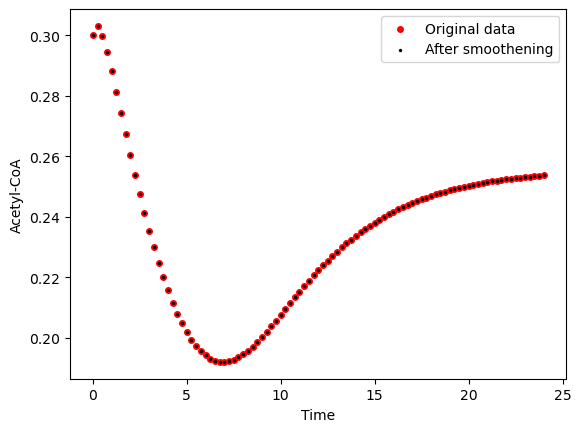

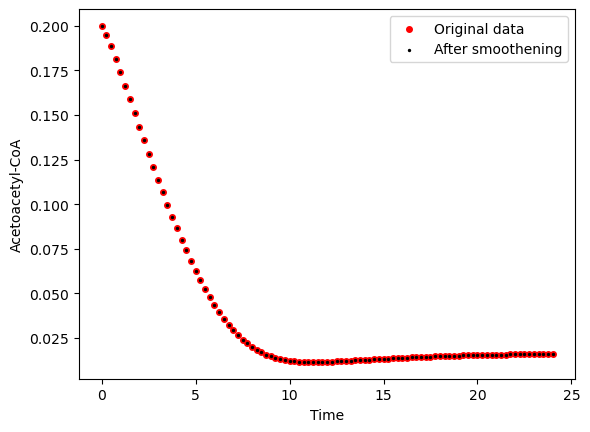

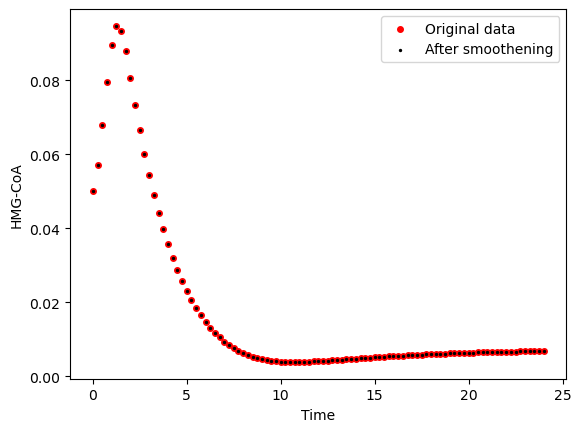

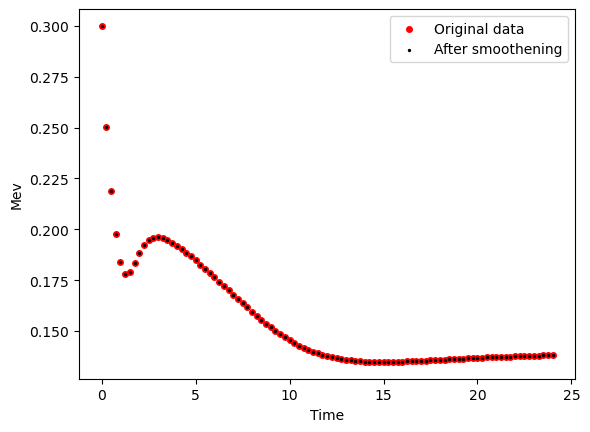

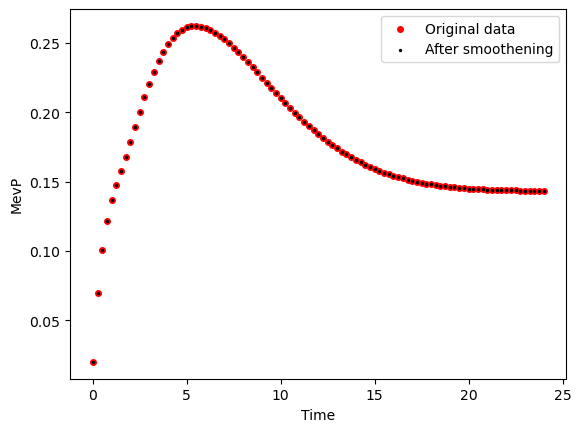

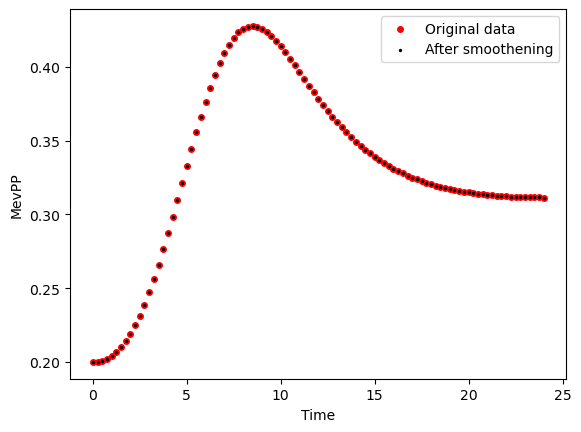

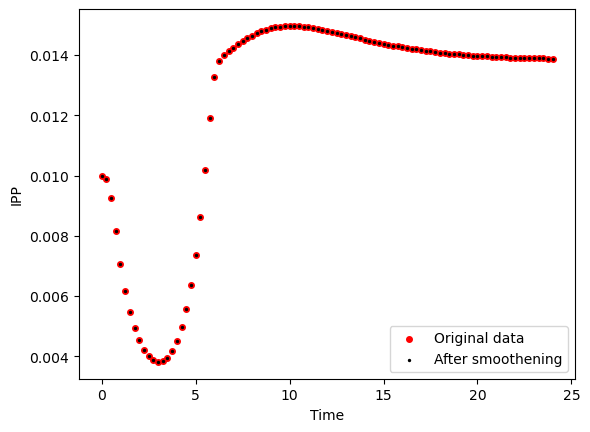

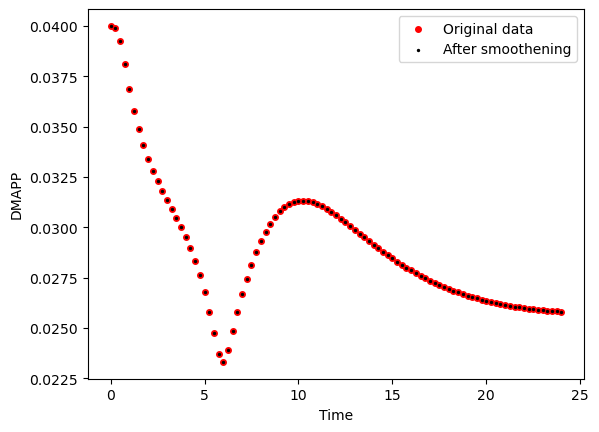

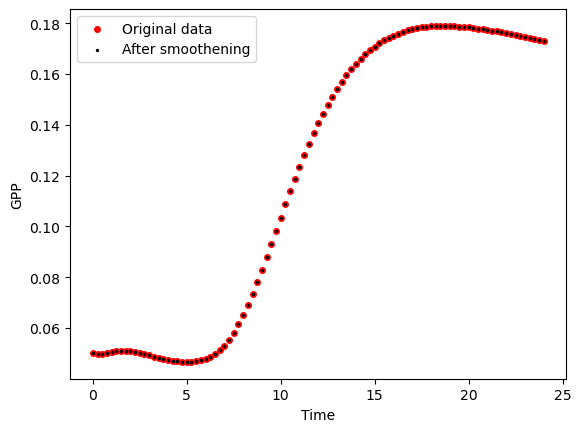

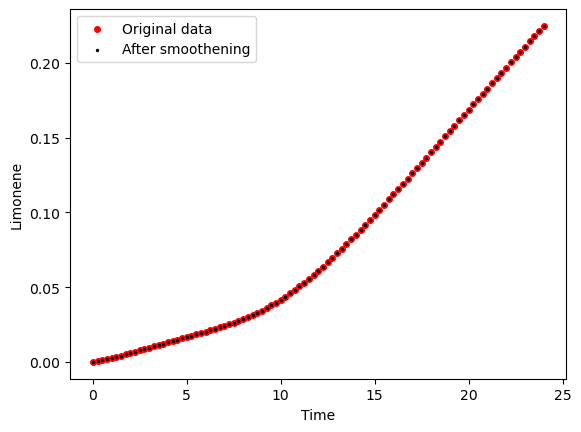

Strain Strain 2


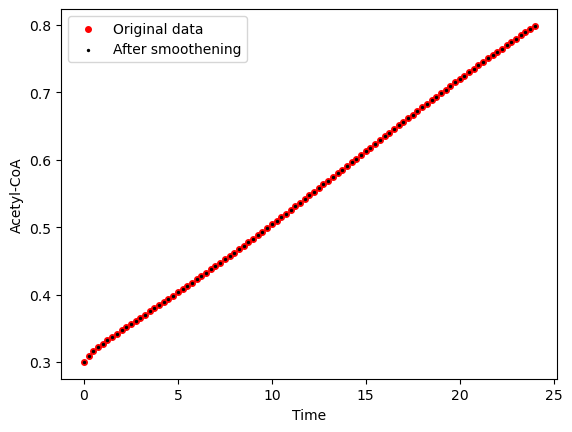

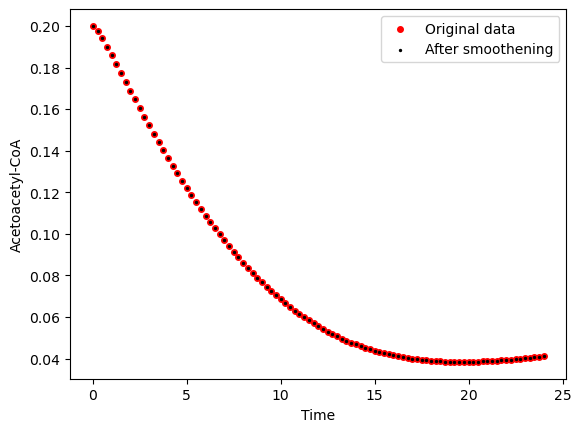

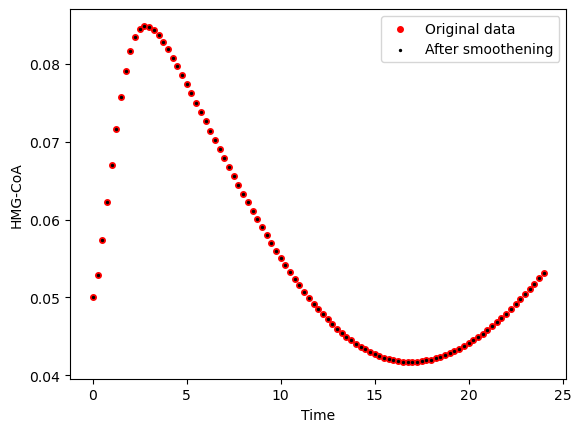

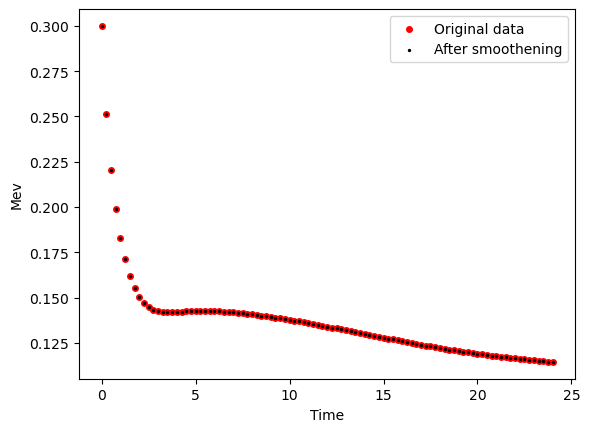

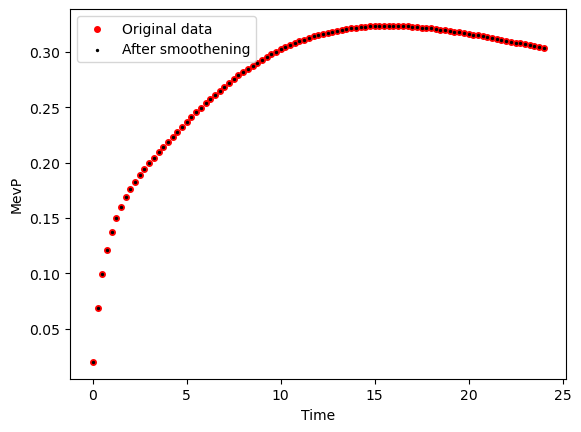

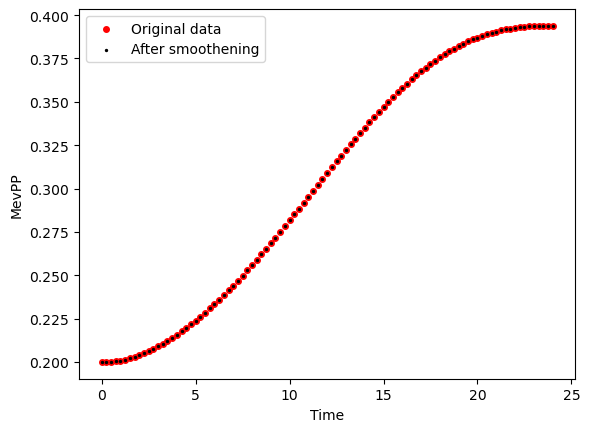

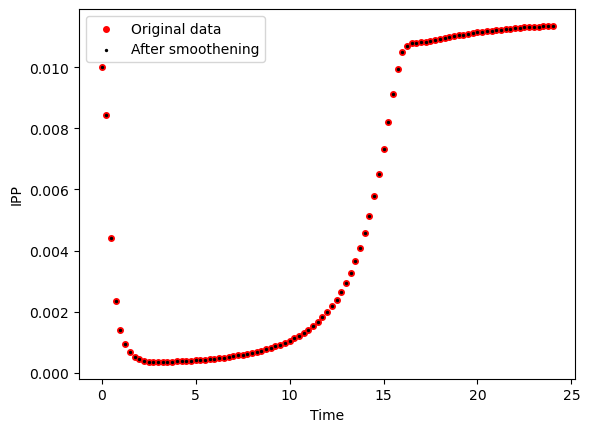

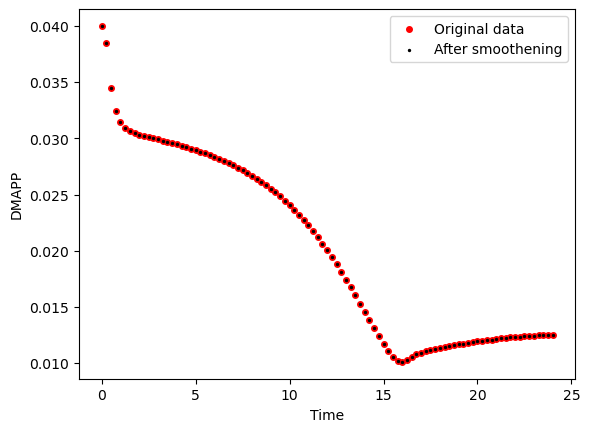

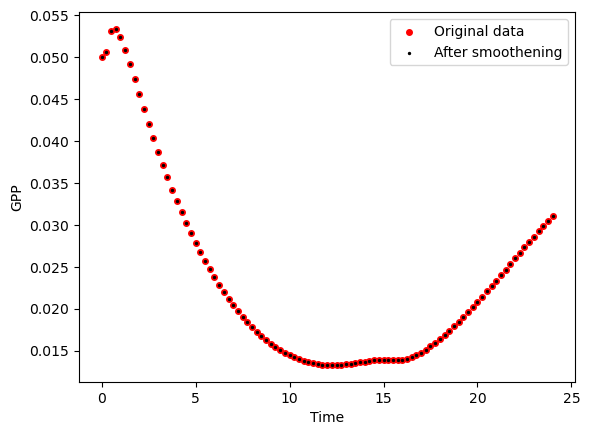

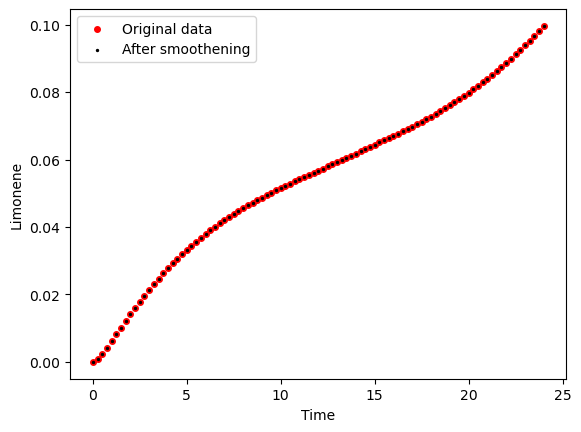

Strain Strain 3


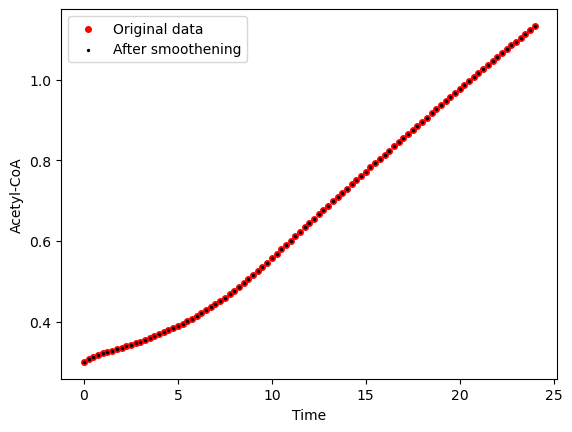

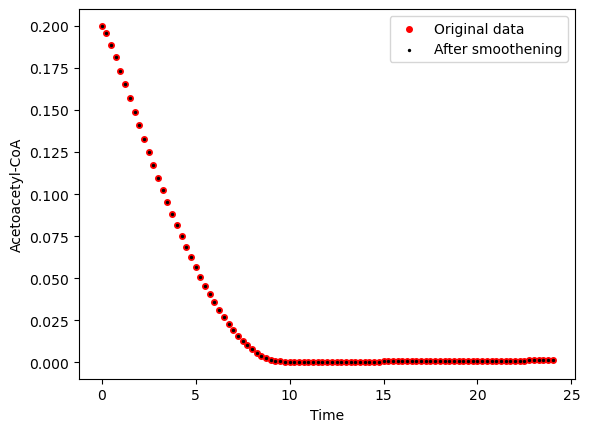

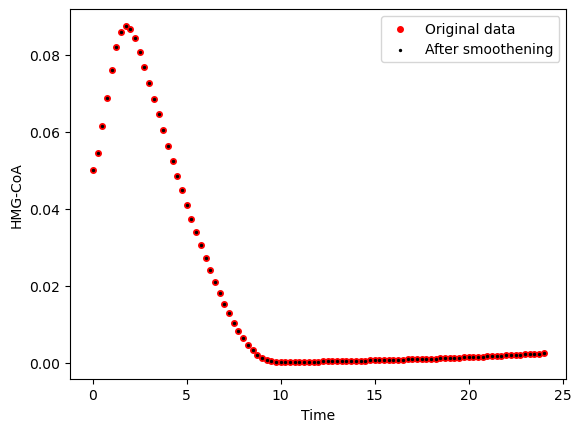

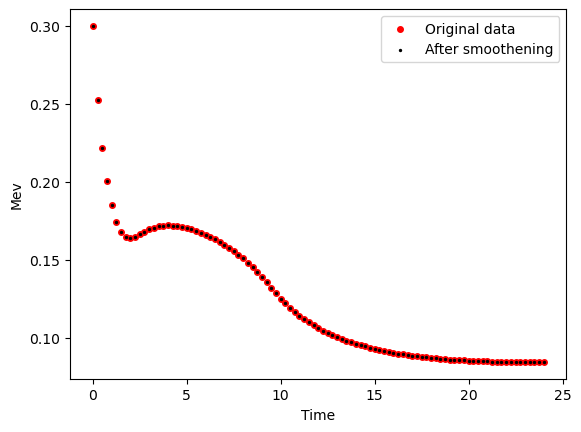

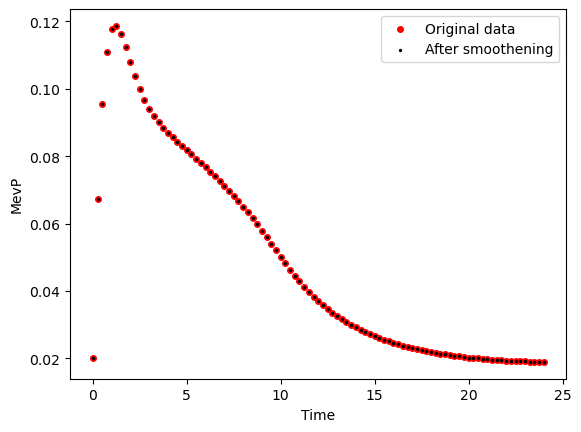

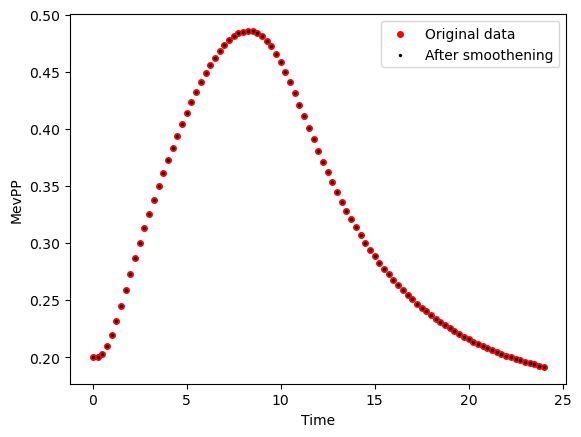

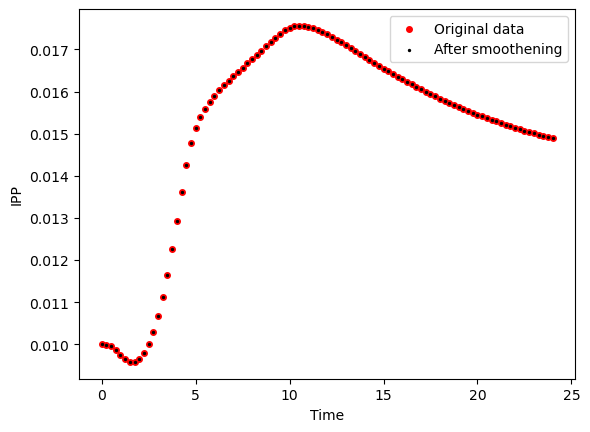

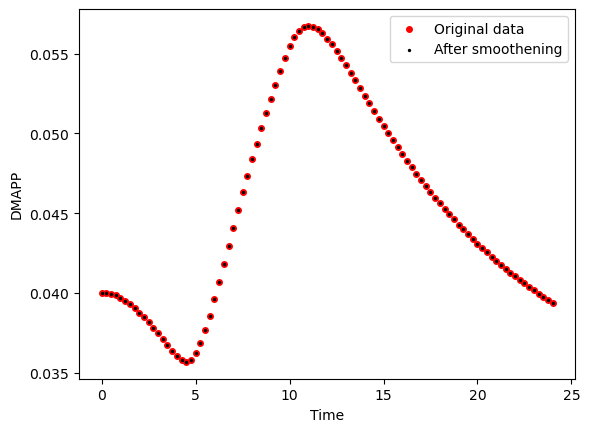

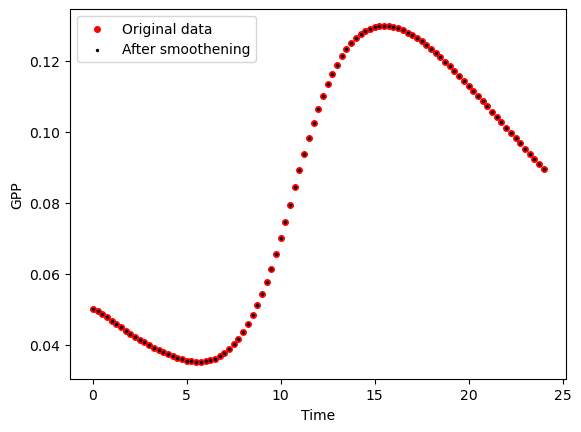

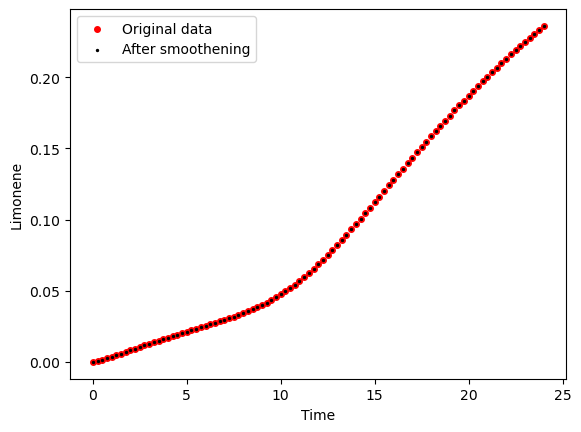

Strain WT


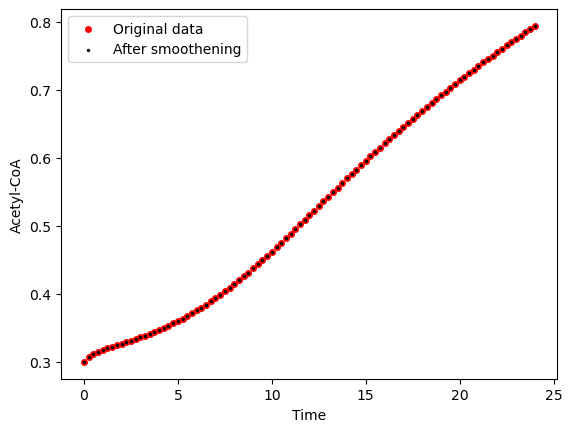

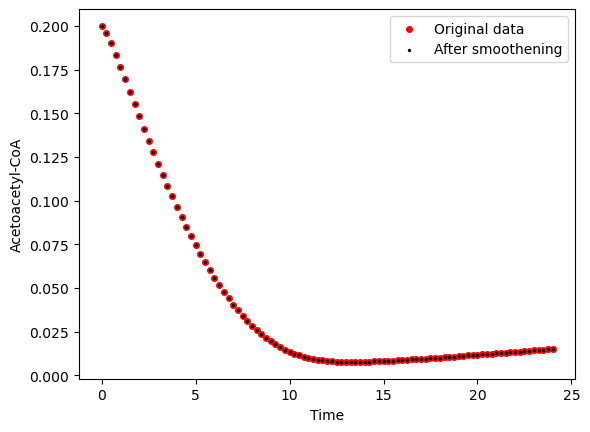

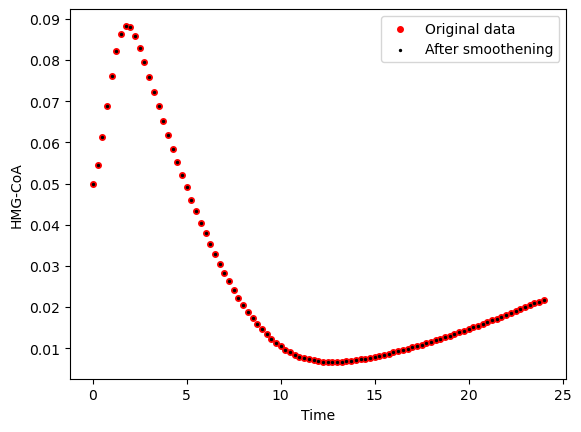

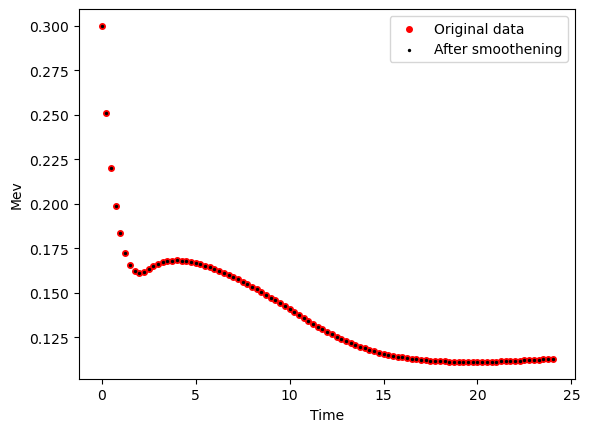

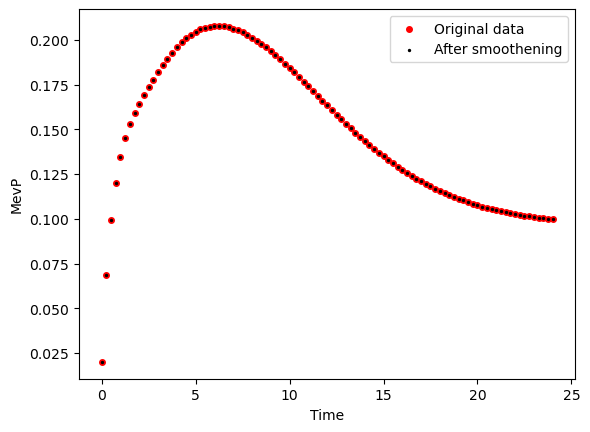

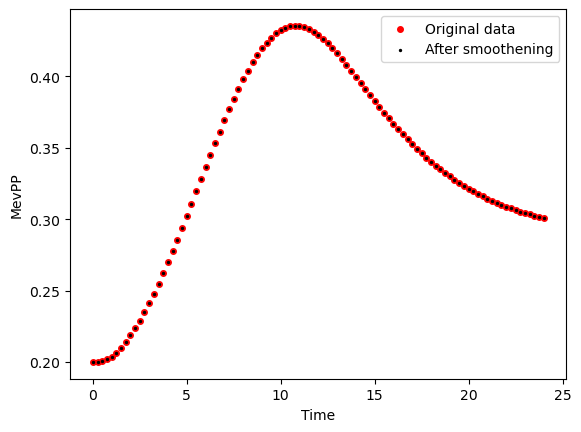

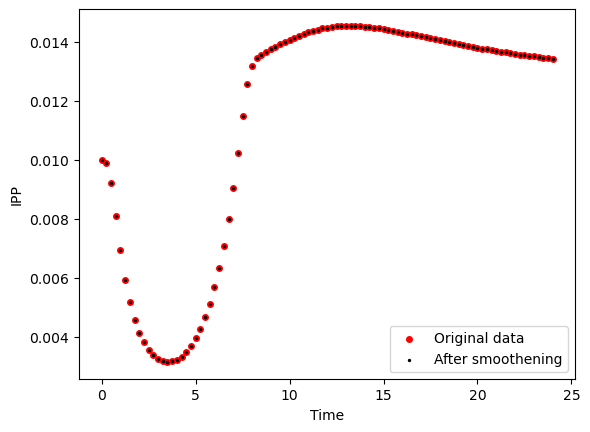

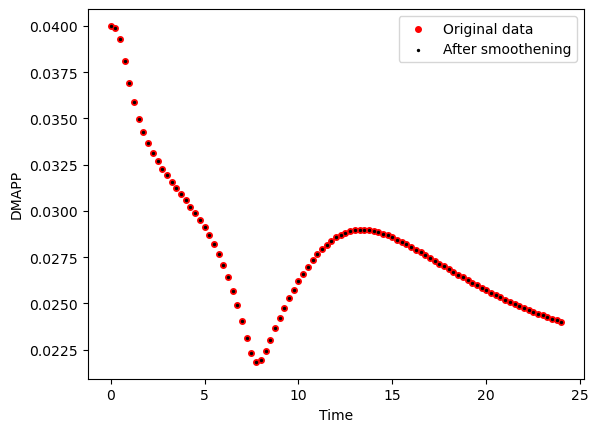

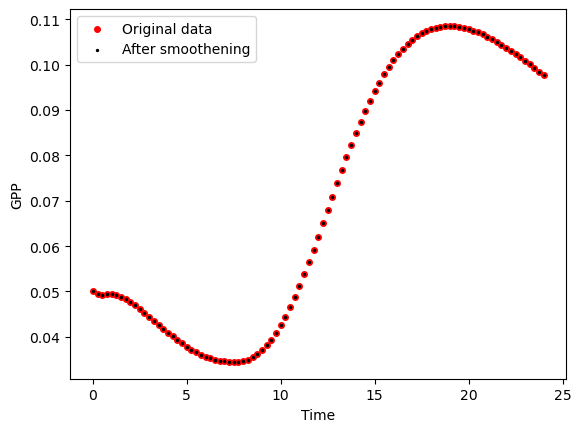

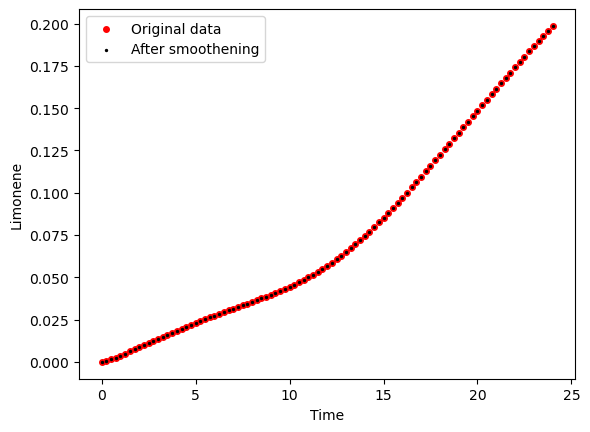

In [20]:
if development==True:
    pass
else:
    compareTimeSeriesAfterPreprocess(df_metaboliteRaw,df_metaboliteSmooth,'states',
                                 strainList,preprocessLabel='After smoothening')

enzymes

Strain Strain 1


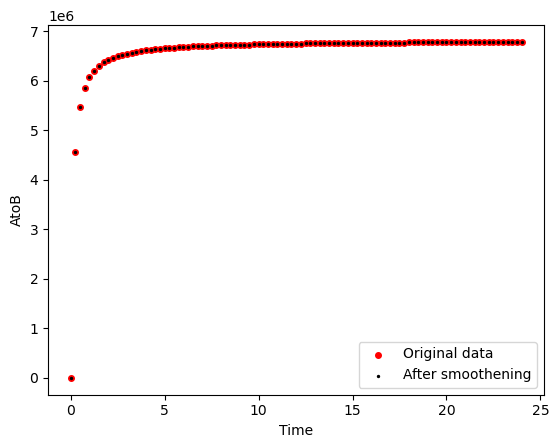

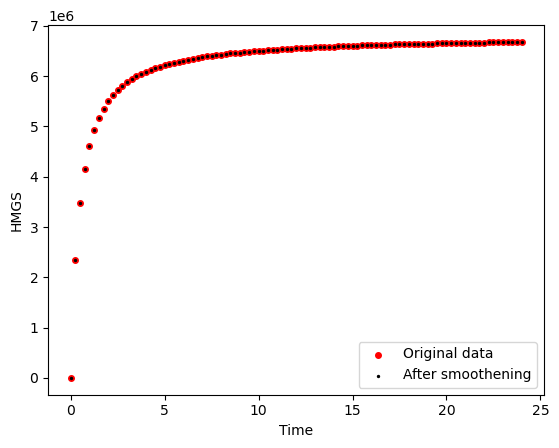

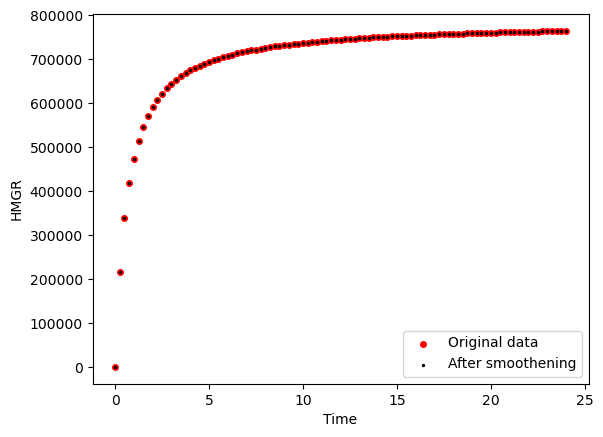

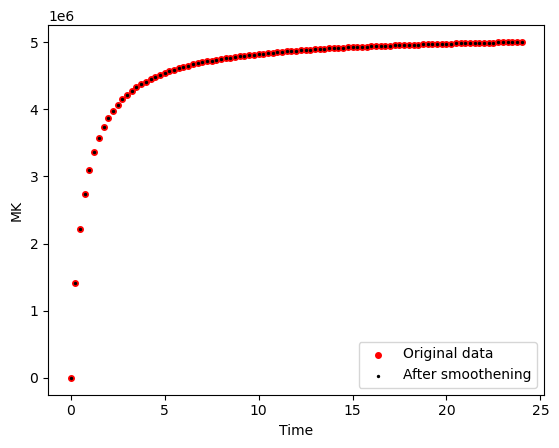

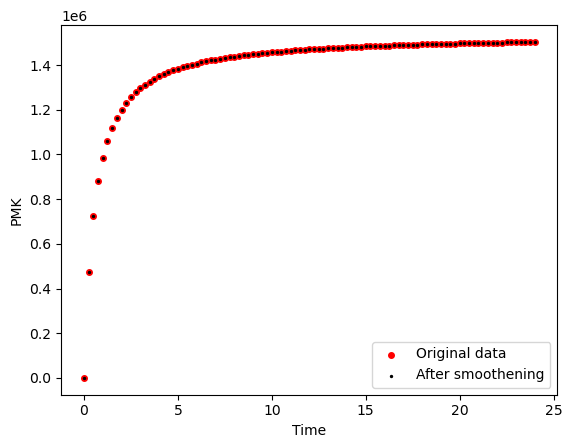

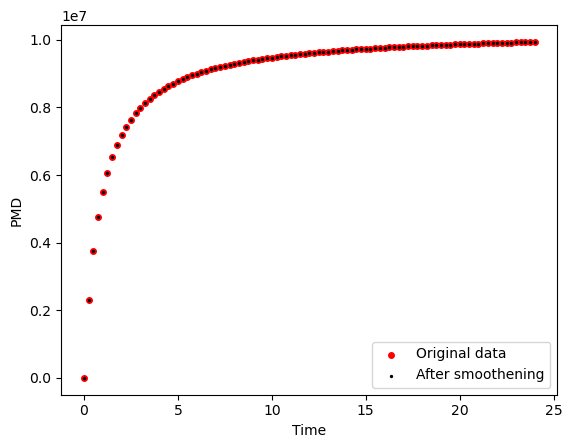

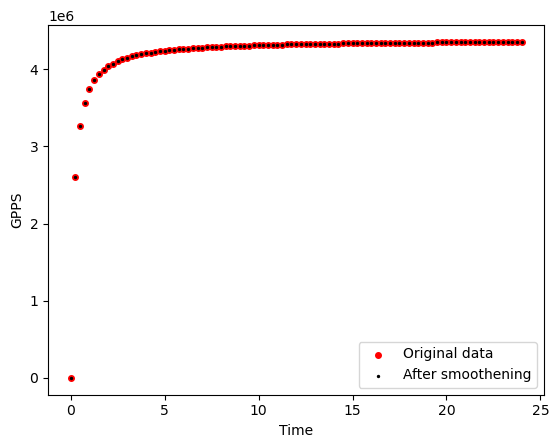

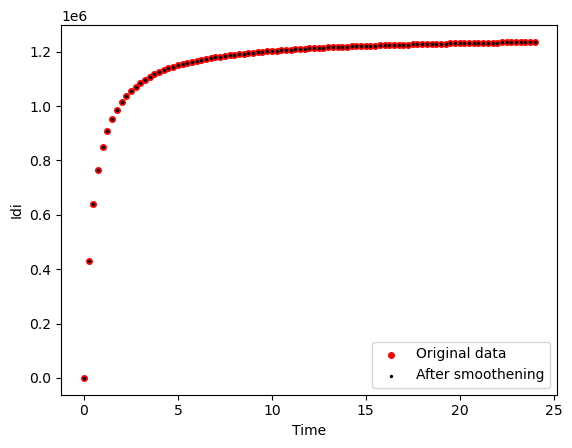

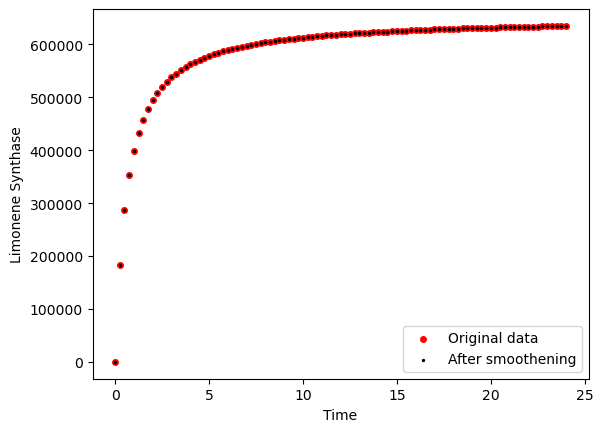

Strain Strain 2


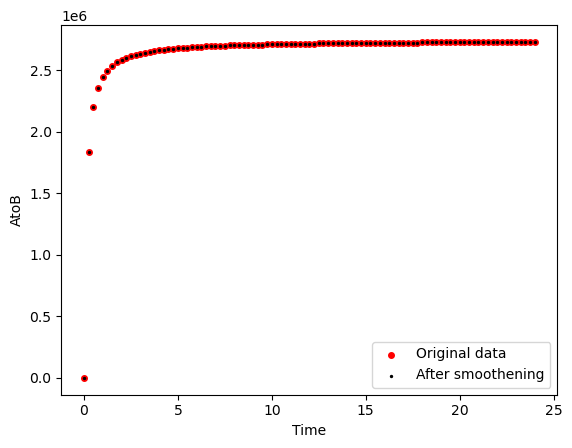

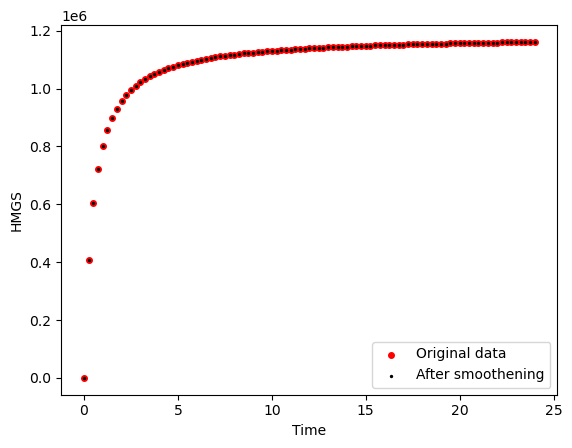

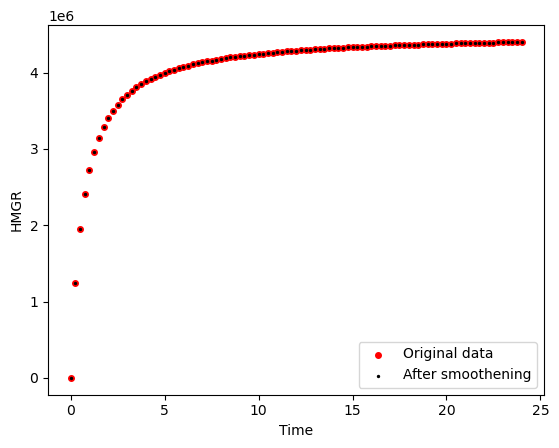

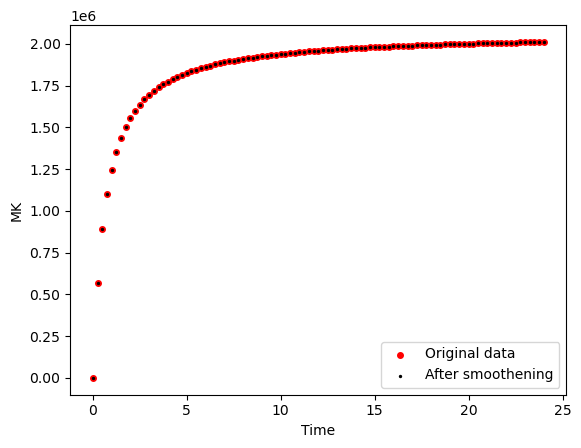

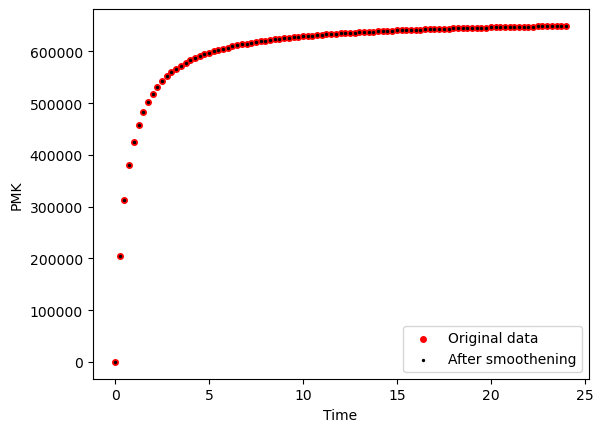

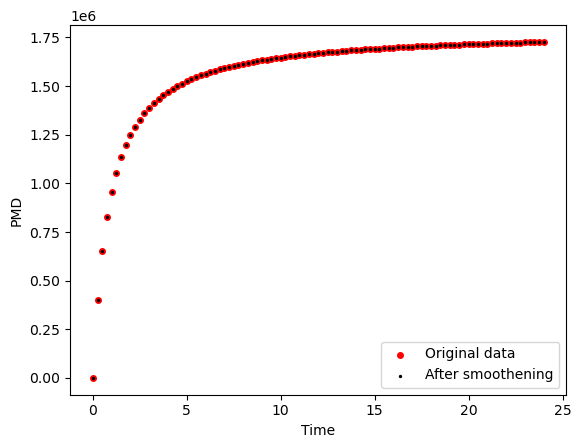

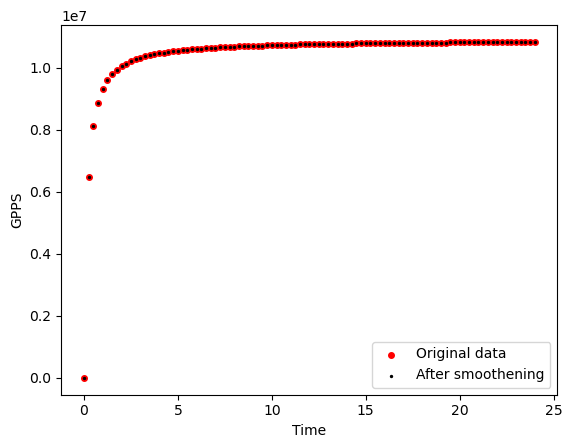

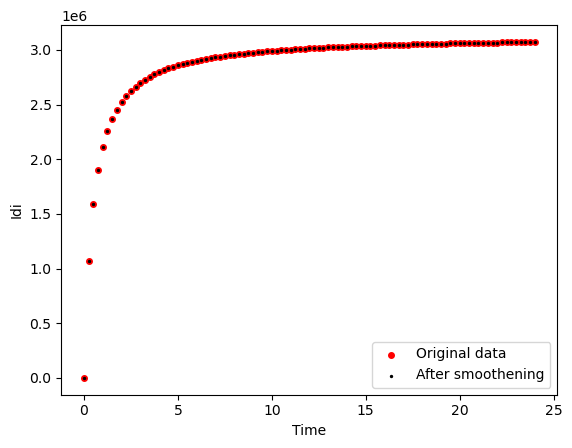

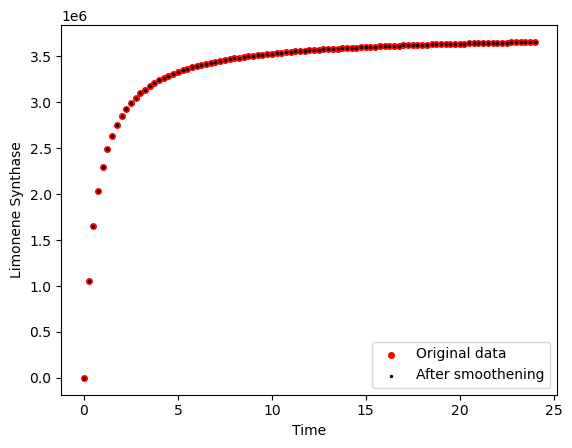

Strain Strain 3


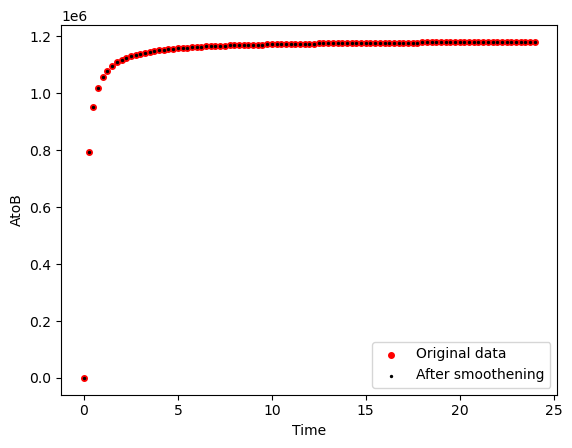

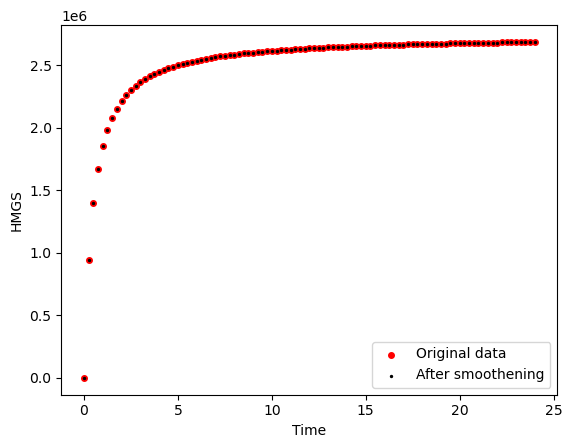

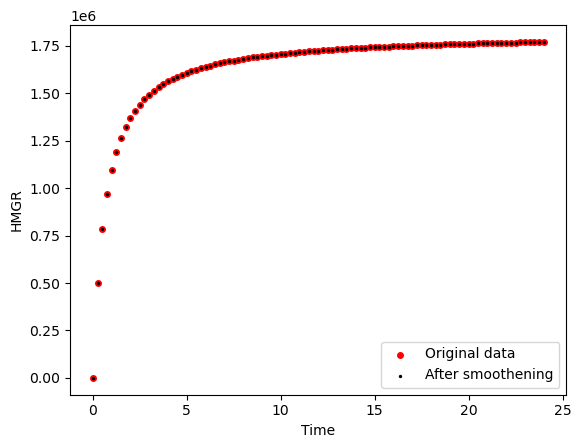

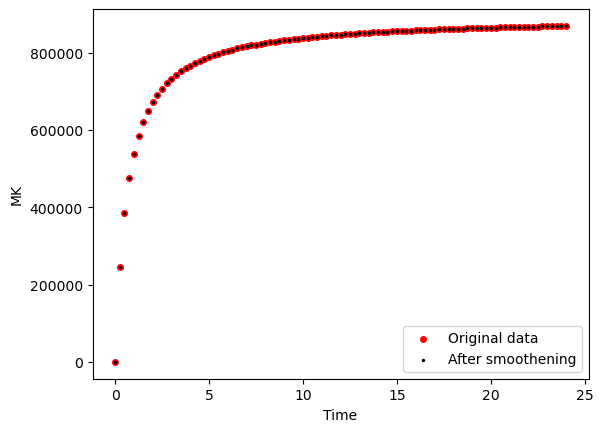

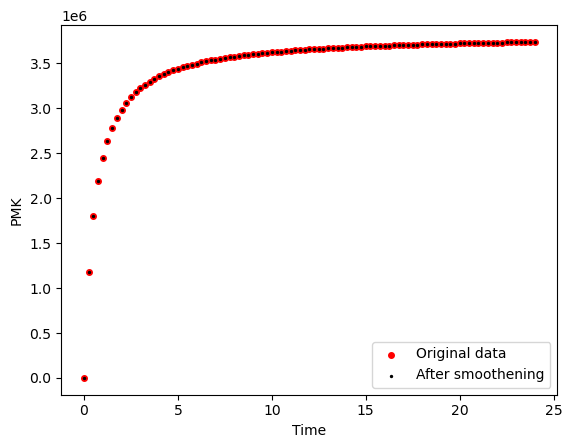

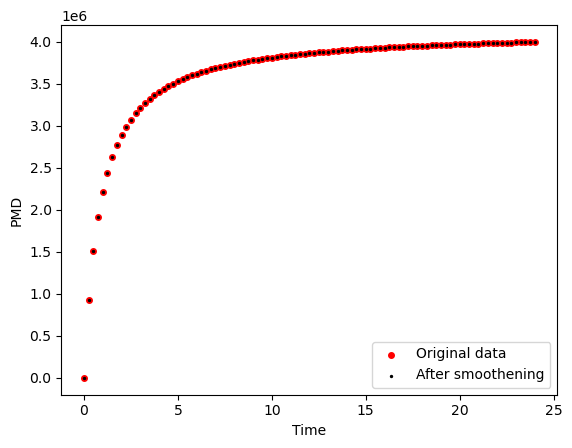

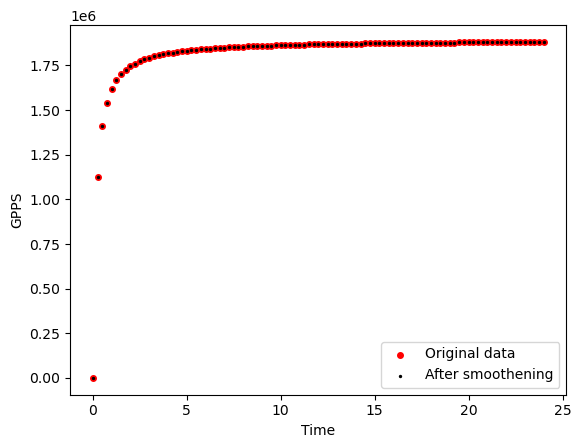

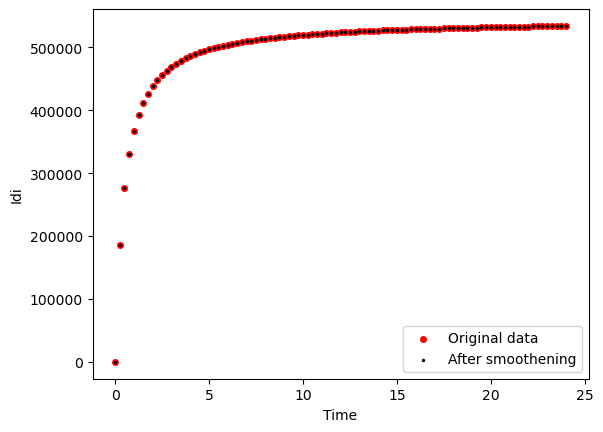

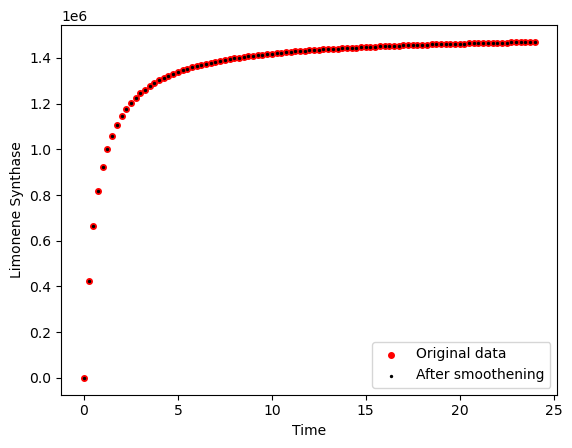

Strain WT


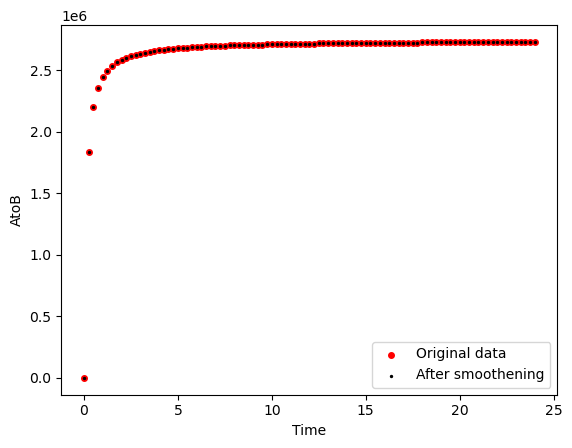

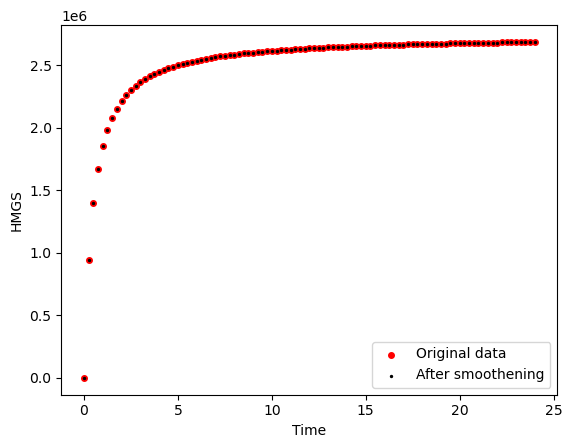

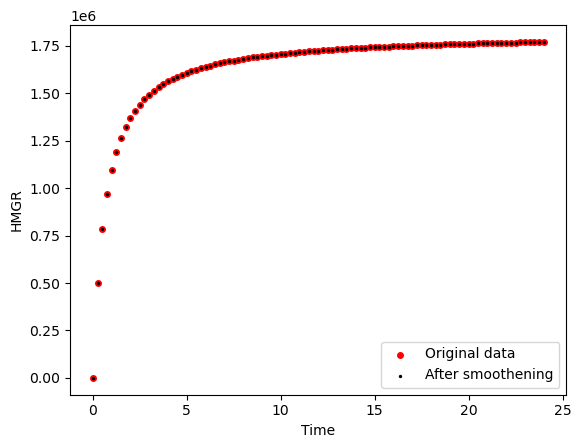

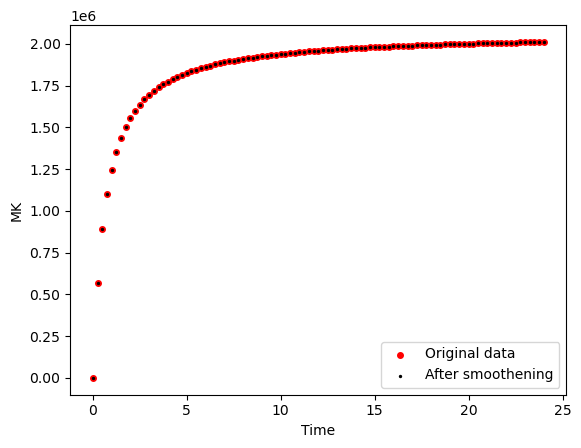

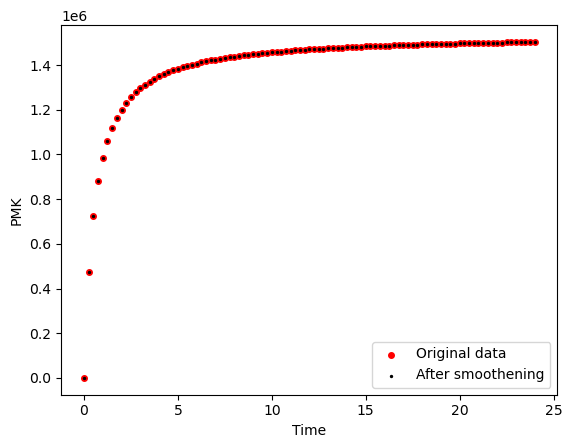

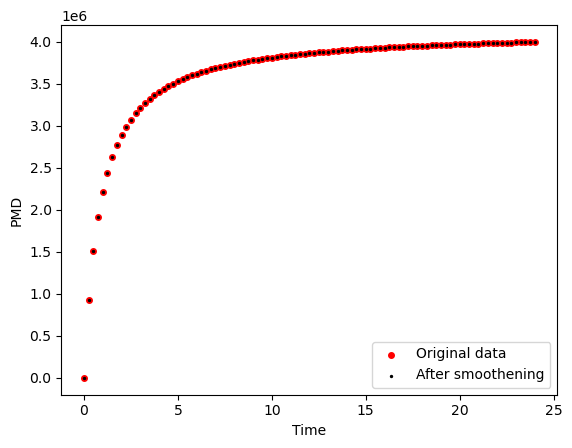

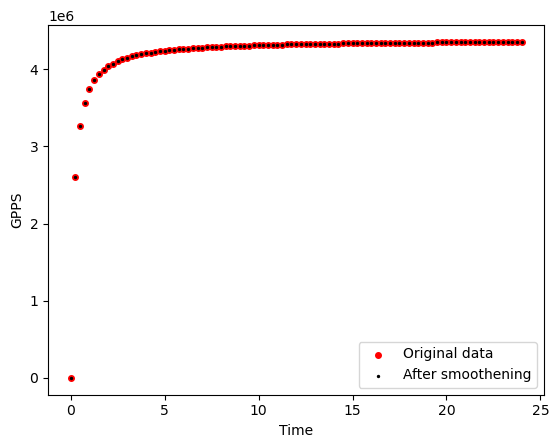

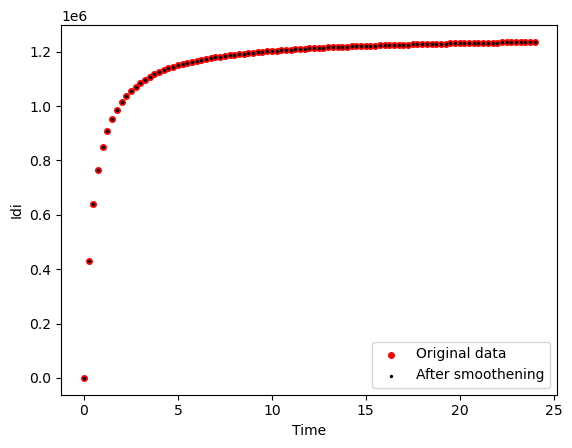

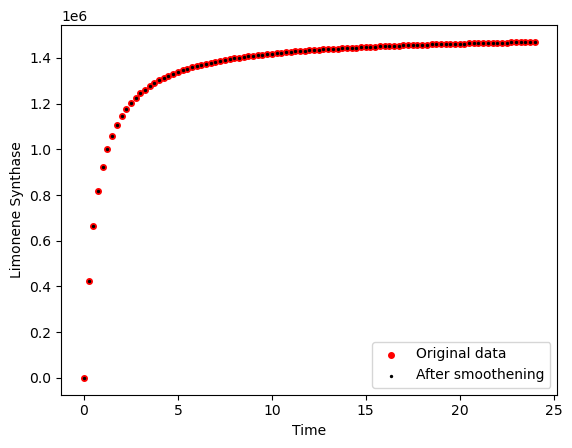

In [21]:
if development==True:
    pass
else:
    compareTimeSeriesAfterPreprocess(df_enzymeRaw,df_enzymeSmooth,'controls',
                                 strainList,preprocessLabel='After smoothening')

# Combine metabolites & enzymes dataframes

In [22]:
df_allSmooth=pd.concat([df_metaboliteSmooth,df_enzymeSmooth],axis=1)

if development==True:
    pass
else:
    df_allSmooth.head()

# Compute rate of reaction

In [23]:
from KineticLearning import estimate_state_derivative73

df_allSmooth=estimate_state_derivative73(df_allSmooth)

if development==True:
    pass
else:
    display(df_allSmooth) #new
    df_allSmooth.to_csv(shelve_name + '_df_allSmooth.csv')

states                                                \
               Acetyl-CoA Acetoacetyl-CoA   HMG-CoA       Mev      MevP   
Strain   Time                                                             
Strain 1 0.00    0.300000        0.200000  0.050000  0.300000  0.020000   
         0.25    0.303073        0.195043  0.057155  0.250311  0.069661   
         0.50    0.299893        0.188541  0.068037  0.218933  0.100735   
         0.75    0.294538        0.181467  0.079599  0.197732  0.121566   
         1.00    0.288190        0.174077  0.089557  0.183997  0.136357   
...                   ...             ...       ...       ...       ...   
WT       23.00   0.775039        0.014167  0.019944  0.112389  0.101024   
         23.25   0.779833        0.014374  0.020413  0.112530  0.100700   
         23.50   0.784584        0.014581  0.020886  0.112676  0.100406   
         23.75   0.789290        0.014788  0.021363  0.112825  0.100138   
         24.00   0.793953        0.014996  0.021843  0.112979  0.099897   

                                                                  ...  \
                   MevPP       IPP     DMAPP       GPP  Limonene  ...   
Strain   Time                                                     ...   
Strain 1 0.00   0.200000  0.010000  0.040000  0.050000  0.000000  ...   
         0.25   0.200059  0.009901  0.039914  0.049716  0.000379  ...   
         0.50   0.200543  0.009250  0.039268  0.049773  0.000986  ...   
         0.75   0.201742  0.008158  0.038120  0.050221  0.001694  ...   
         1.00   0.203716  0.007056  0.036890  0.050678  0.002468  ...   
...                  ...       ...       ...       ...       ...  ...   
WT       23.00  0.304296  0.013499  0.024360  0.100867  0.186575  ...   
         23.25  0.303339  0.013479  0.024268  0.100090  0.189619  ...   
         23.50  0.302440  0.013460  0.024180  0.099296  0.192639  ...   
         23.75  0.301600  0.013442  0.024094  0.098489  0.195636  ...   
         24.00  0.300814  0.013424  0.024011  0.097670  0.198608  ...   

               derivatives                                                \
                Acetyl-CoA Acetoacetyl-CoA   HMG-CoA       Mev      MevP   
Strain   Time                                                              
Strain 1 0.00     0.018594       -0.018182  0.018805 -0.220877  0.228172   
         0.25    -0.001101       -0.023119  0.037819 -0.160423  0.158607   
         0.50    -0.015600       -0.026822  0.046418 -0.109091  0.105123   
         0.75    -0.024903       -0.029292  0.044600 -0.066881  0.067719   
         1.00    -0.026775       -0.030023  0.030284 -0.037420  0.050530   
...                    ...             ...       ...       ...       ...   
WT       23.00    0.019269        0.000828  0.001867  0.000553 -0.001353   
         23.25    0.019090        0.000828  0.001883  0.000573 -0.001236   
         23.50    0.018914        0.000829  0.001899  0.000591 -0.001124   
         23.75    0.018739        0.000829  0.001915  0.000606 -0.001016   
         24.00    0.018565        0.000829  0.001931  0.000620 -0.000913   

                                                                  
                   MevPP       IPP     DMAPP       GPP  Limonene  
Strain   Time                                                     
Strain 1 0.00  -0.001239  0.001000  0.001198 -0.002373  0.001240  
         0.25   0.001046 -0.001742 -0.001698 -0.000249  0.001999  
         0.50   0.003542 -0.003549 -0.003689  0.001138  0.002590  
         0.75   0.006251 -0.004420 -0.004777  0.001790  0.003013  
         1.00   0.009342 -0.004136 -0.004793  0.001594  0.003202  
...                  ...       ...       ...       ...       ...  
WT       23.00 -0.003953 -0.000080 -0.000374 -0.003075  0.012221  
         23.25 -0.003710 -0.000078 -0.000361 -0.003144  0.012129  
         23.50 -0.003476 -0.000075 -0.000349 -0.003203  0.012034  
         23.75 -0.003251 -0.000072 -0.000337 -0.003253  0.011938  
         

# Inspect quality of reaction rates

Check if derivatives are reliable enough to regenerate metabolite time profiles.

'Time profile from derivative vs. actual profile for Strain 1'

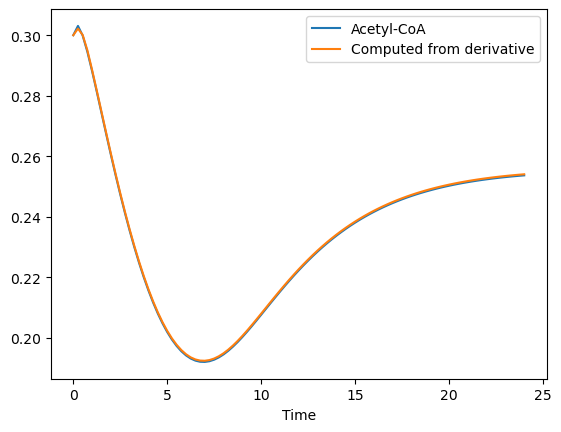

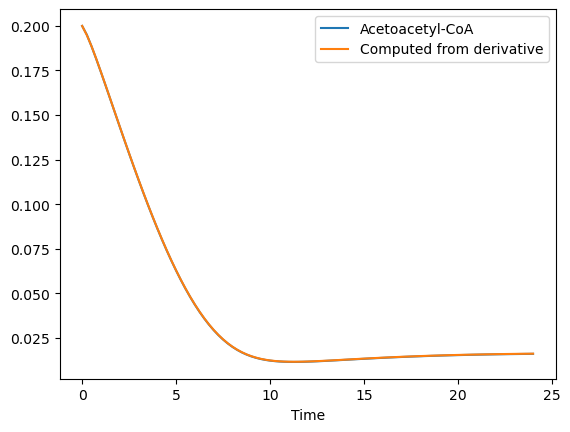

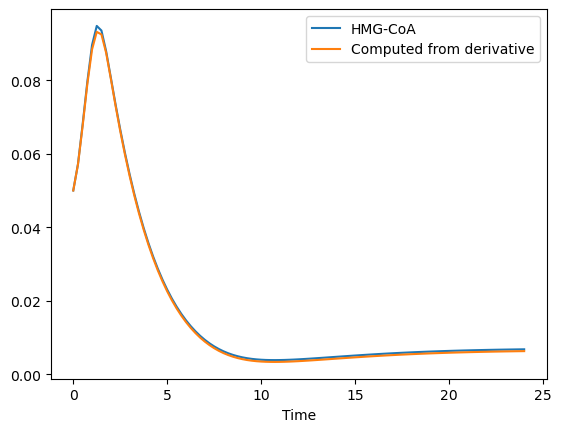

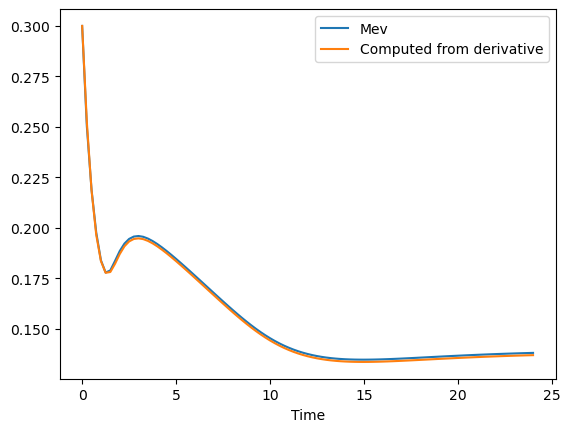

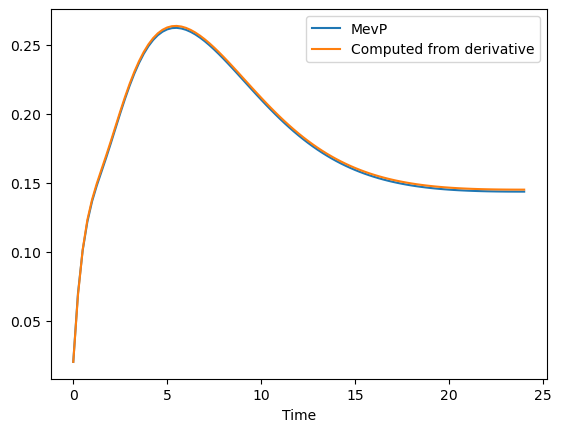

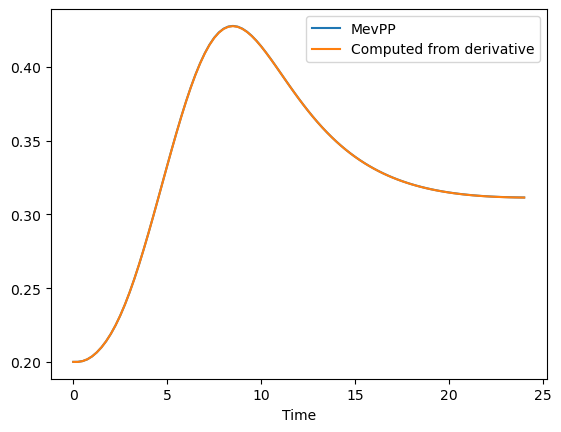

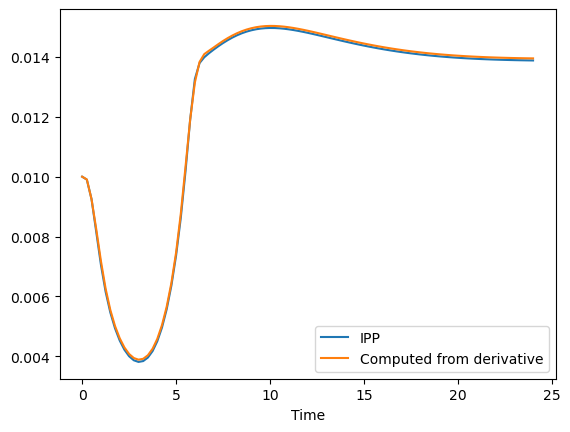

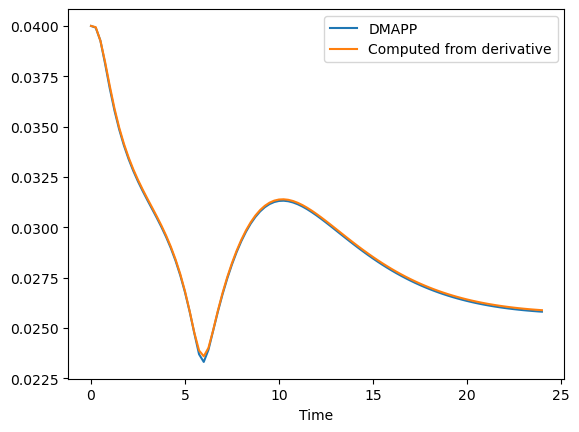

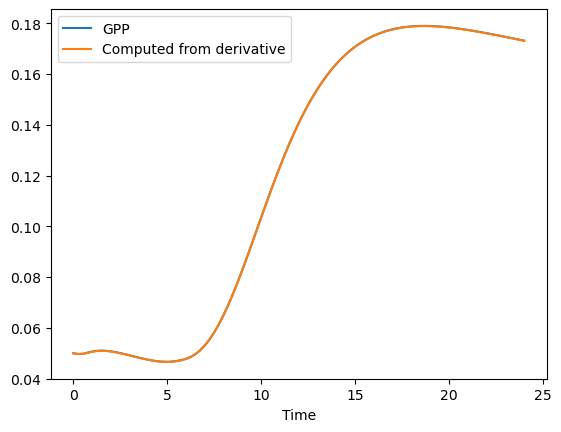

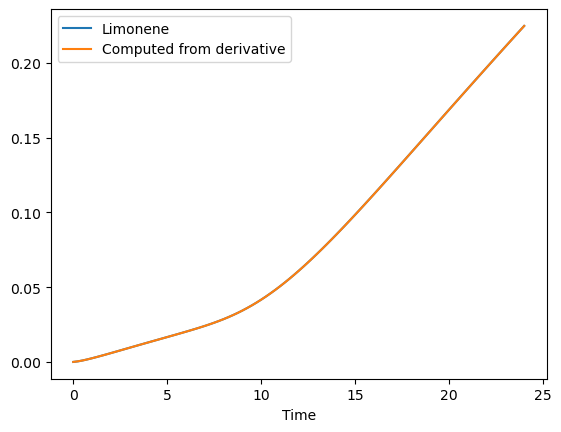

'Time profile from derivative vs. actual profile for Strain 2'

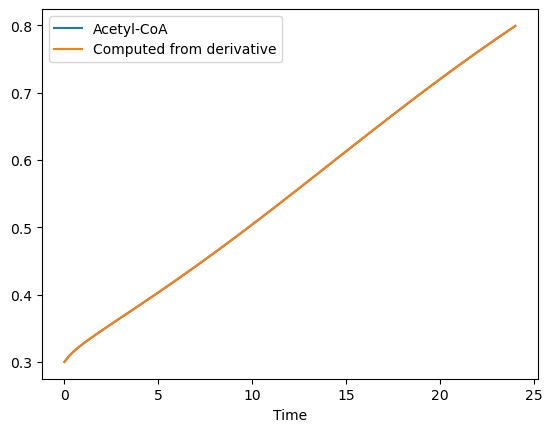

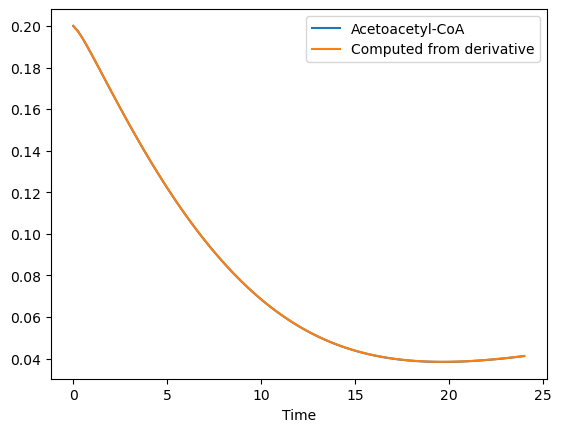

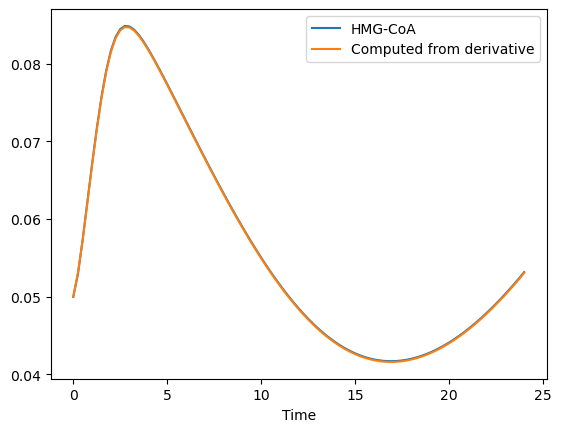

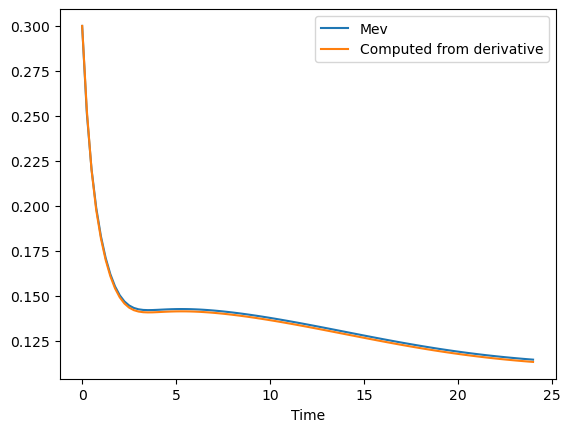

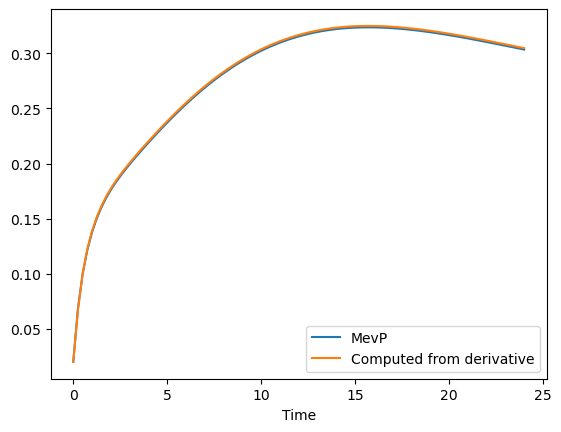

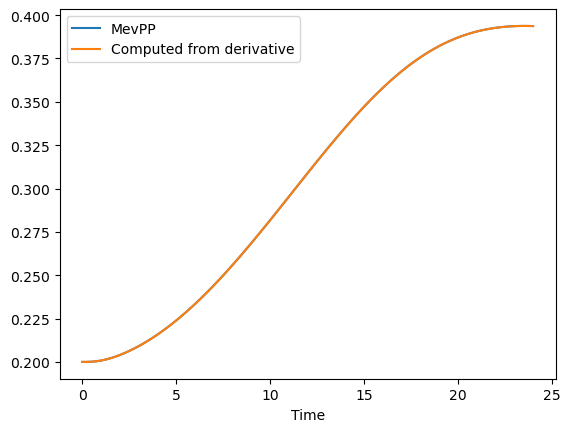

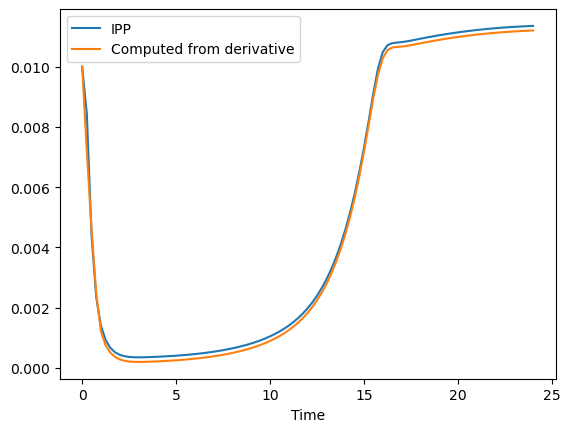

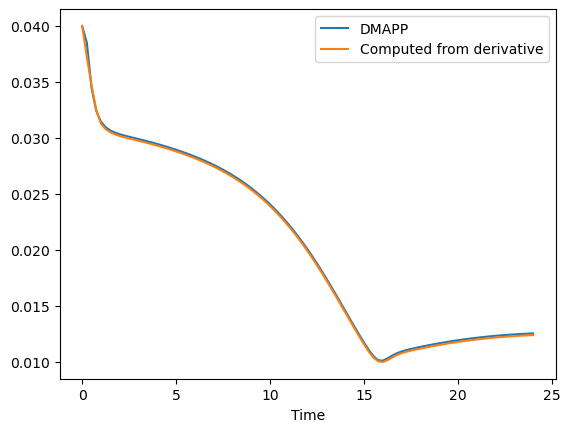

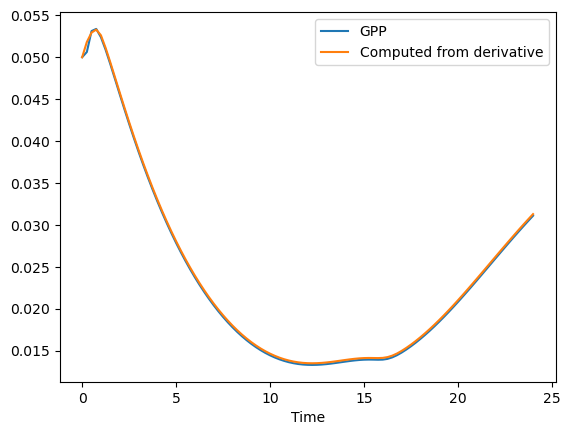

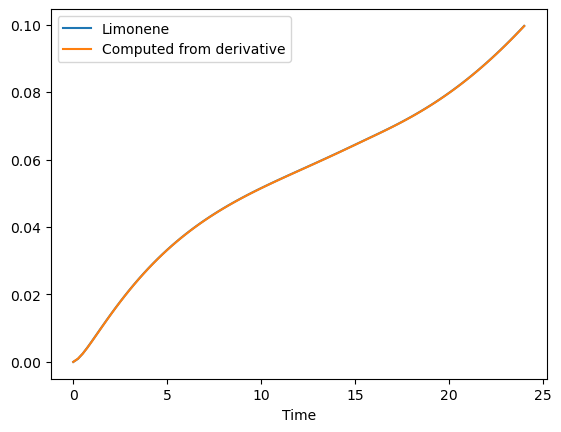

'Time profile from derivative vs. actual profile for Strain 3'

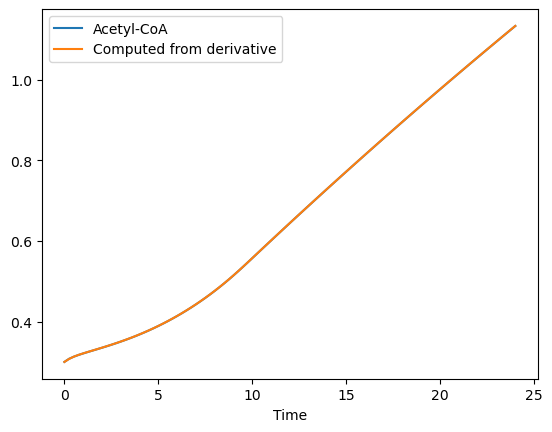

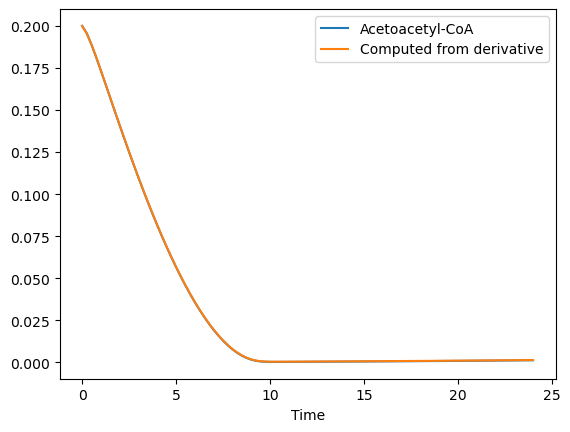

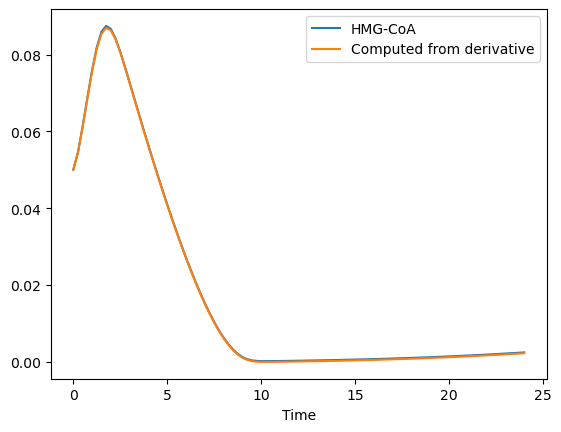

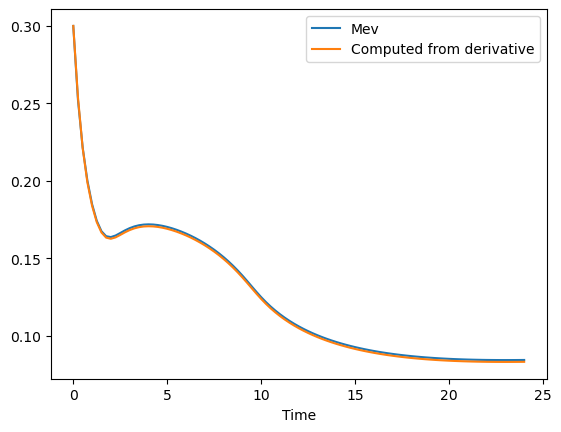

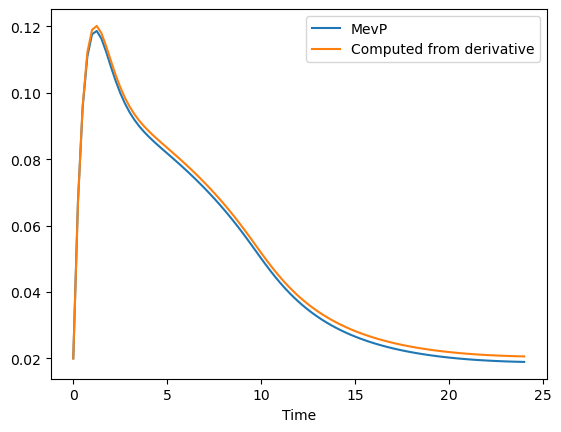

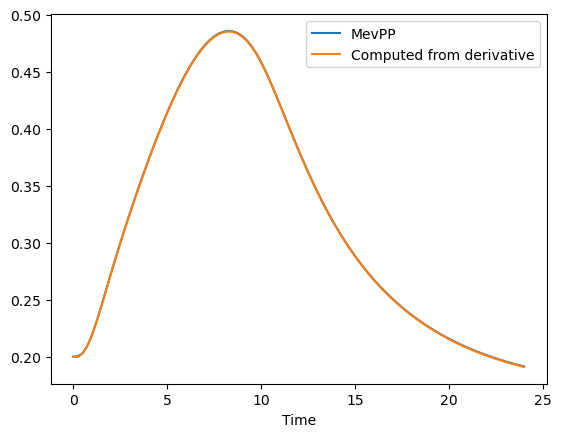

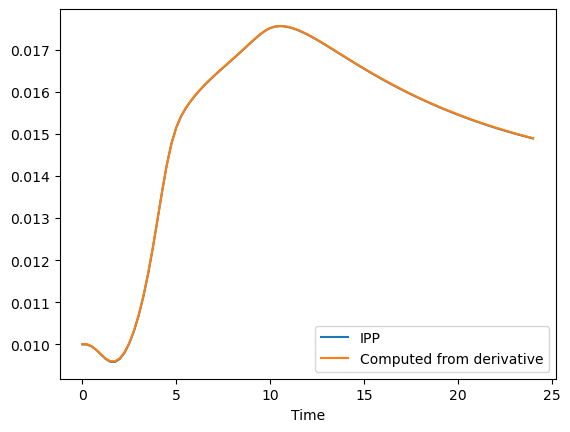

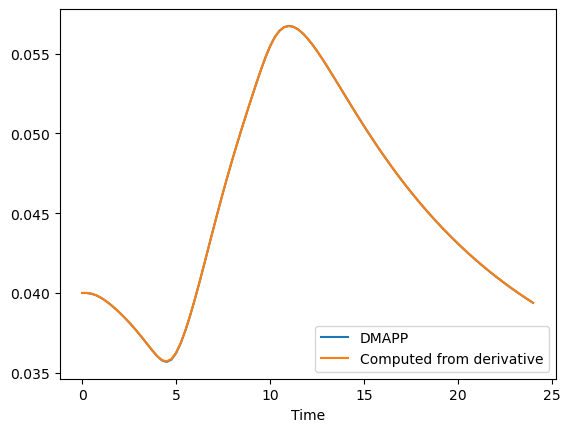

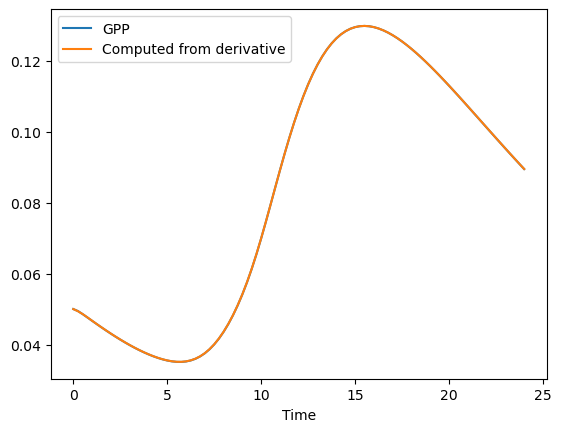

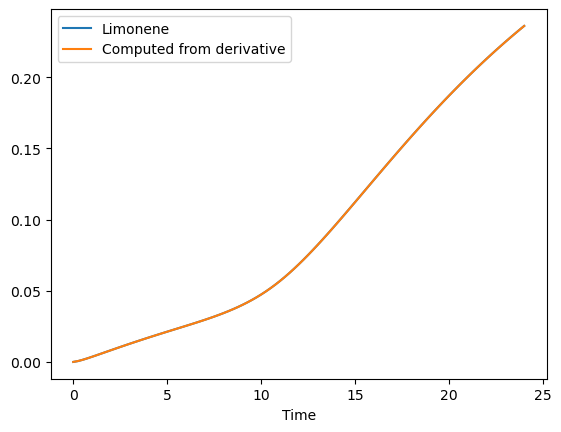

'Time profile from derivative vs. actual profile for WT'

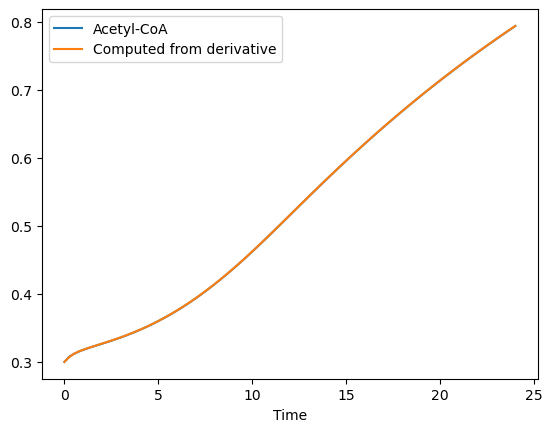

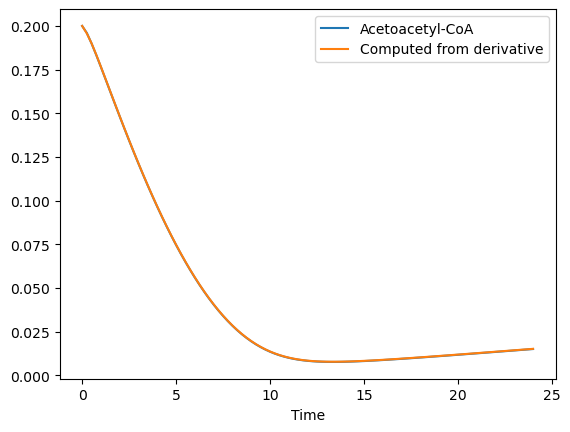

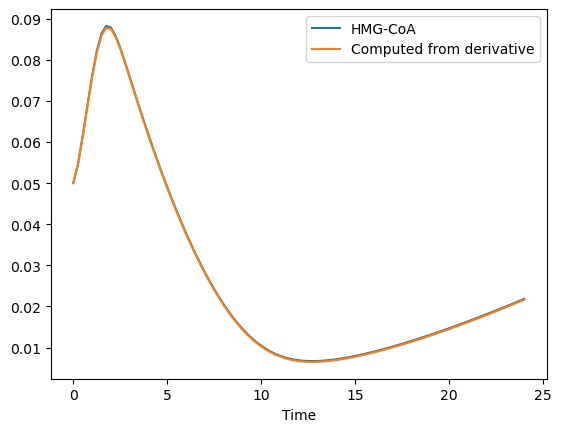

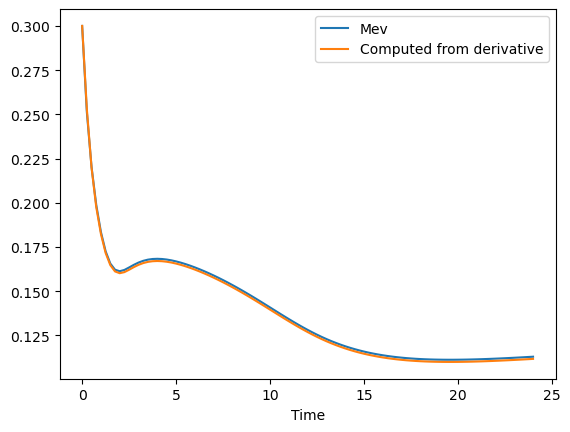

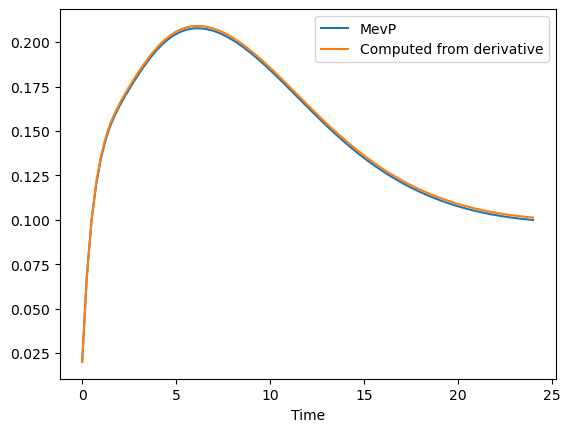

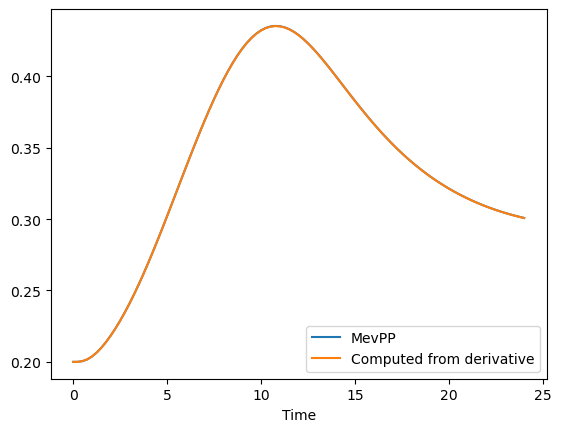

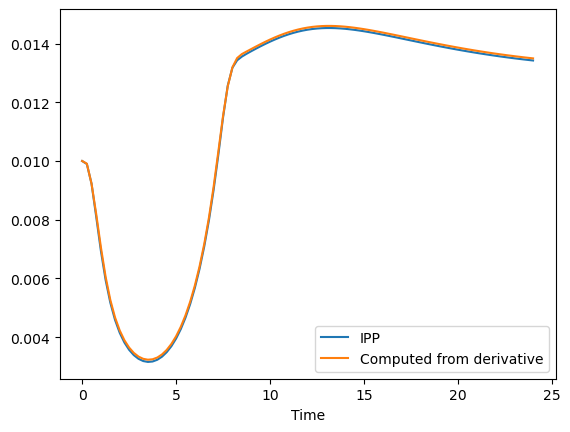

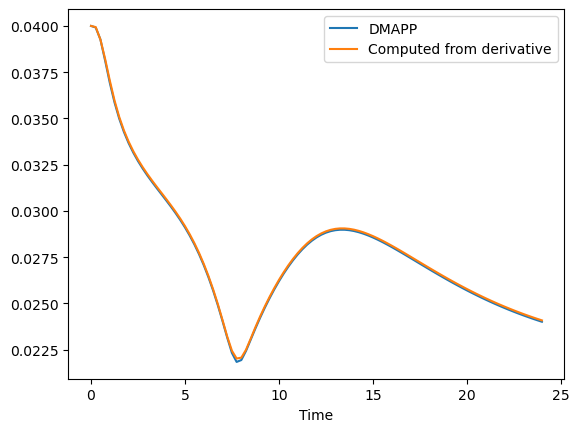

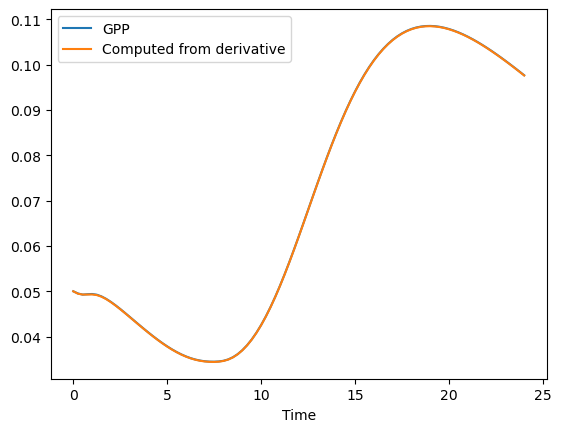

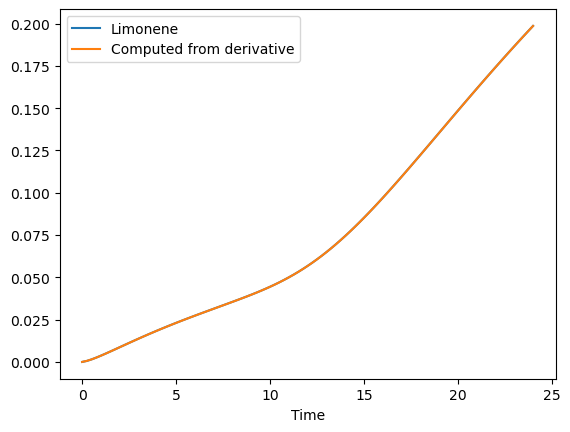

In [24]:
if inspectRate==True:
    from KineticLearning import check_derivative
    check_derivative(df_allSmooth)
    
#HC: synthetic data has sharp conc changes for HMG-CoA, Mev, IPP, DMAPP that are not well estimated by savgol filter 

# Prepare dataframes for model fitting (kr optimization)

enzymes, metabolites

Again:

measured_enzymes = ['AtoB', 'HMGS', 'HMGR', 'MK', 'PMK', 'PMD', 'GPPS', 'Idi','Limonene Synthase']

measured_substrates = ['Acetyl-CoA','Acetoacetyl-CoA','HMG-CoA', 'Mev', 'MevP','MevPP', 'IPP','DMAPP','GPP','Limonene']

In [25]:
# 9 enzymes conc measurement used for fitting model
x_controls = [('controls',control) for control in measured_enzymes]
controls_df = df_allSmooth[x_controls] # dataframe format

# 10 substrates conc measurement used for fitting model
x_states = [('states',state) for state in measured_substrates]
states_df = df_allSmooth[x_states] # dataframe format

# merge enzymes & substrates measurement as single feature dataframe
features_df = pd.merge(controls_df, states_df,left_index=True, right_index=True,how='left')
print('Enzyme & metabolite timepoint data to be used for model fitting')
display (features_df) # check total no. time-series datapoints (all strains)

Enzyme & metabolite timepoint data to be used for model fitting


controls                                            \
                        AtoB          HMGS          HMGR            MK   
Strain   Time                                                            
Strain 1 0.00   5.946962e+01  3.973013e+01  3.696892e+01  5.762279e+01   
         0.25   4.568047e+06  2.339239e+06  2.165020e+05  1.413483e+06   
         0.50   5.471875e+06  3.482933e+06  3.394490e+05  2.217158e+06   
         0.75   5.858245e+06  4.161080e+06  4.187155e+05  2.735644e+06   
         1.00   6.072640e+06  4.609864e+06  4.740683e+05  3.097868e+06   
...                      ...           ...           ...           ...   
WT       23.00  2.729403e+06  2.685480e+06  1.768100e+06  2.009782e+06   
         23.25  2.729560e+06  2.686069e+06  1.768628e+06  2.010384e+06   
         23.50  2.729713e+06  2.686645e+06  1.769146e+06  2.010974e+06   
         23.75  2.729863e+06  2.687209e+06  1.769653e+06  2.011551e+06   
         24.00  2.730010e+06  2.687762e+06  1.770149e+06  2.012117e+06   

                                                                        \
                         PMK           PMD          GPPS           Idi   
Strain   Time                                                            
Strain 1 0.00   2.659959e+01  5.448132e+01  5.547215e+01  1.868778e+01   
         0.25   4.735188e+05  2.301051e+06  2.600509e+06  4.287990e+05   
         0.50   7.241324e+05  3.761395e+06  3.265182e+06  6.399929e+05   
         0.75   8.792538e+05  4.770619e+06  3.569278e+06  7.657046e+05   
         1.00   9.847275e+05  5.509792e+06  3.743605e+06  8.490980e+05   
...                      ...           ...           ...           ...   
WT       23.00  1.501640e+06  3.990692e+06  4.353803e+06  1.235104e+06   
         23.25  1.502026e+06  3.992254e+06  4.354150e+06  1.235378e+06   
         23.50  1.502403e+06  3.993784e+06  4.354490e+06  1.235647e+06   
         23.75  1.502773e+06  3.995283e+06  4.354822e+06  1.235910e+06   
         24.00  1.503135e+06  3.996752e+06  4.355148e+06  1.236168e+06   

                                     states                            \
               Limonene Synthase Acetyl-CoA Acetoacetyl-CoA   HMG-CoA   
Strain   Time                                                           
Strain 1 0.00       3.034108e+01   0.300000        0.200000  0.050000   
         0.25       1.837058e+05   0.303073        0.195043  0.057155   
         0.50       2.866143e+05   0.299893        0.188541  0.068037   
         0.75       3.524272e+05   0.294538        0.181467  0.079599   
         1.00       3.981392e+05   0.288190        0.174077  0.089557   
...                          ...        ...             ...       ...   
WT       23.00      1.468009e+06   0.775039        0.014167  0.019944   
         23.25      1.468435e+06   0.779833        0.014374  0.020413   
         23.50      1.468851e+06   0.784584        0.014581  0.020886   
         23.75      1.469260e+06   0.789290        0.014788  0.021363   
         24.00      1.469659e+06   0.793953        0.014996  0.021843   

                                                                            \
                     Mev      MevP     MevPP       IPP     DMAPP       GPP   
Strain   Time                                                                
Strain 1 0.00   0.300000  0.020000  0.200000  0.010000  0.040000  0.050000   
         0.25   0.250311  0.069661  0.200059  0.009901  0.039914  0.049716   
         0.50   0.218933  0.100735  0.200543  0.009250  0.039268  0.049773   
         0.75   0.197732  0.121566  0.201742  0.008158  0.038120  0.050221   
         1.00   0.183997  0.136357  0.203716  0.007056  0.036890  0.050678   
...                  ...       ...       ...       ...       ...       ...   
WT       23.00  0.112389  0.101024  0.304296  0.013499  0.024360  0.100867   
         23.25  0.112530  0.100700  0.303339  0.013479  0.024268  0.100090   
         23.50  0.112676  0.100406  0.302440  0.013460  0.024180 

rate of reaction

In [26]:
# get rate of reaction for selected metabolites
y_derivatives = [('derivatives',derivative) for derivative in measured_substrates]
y_derivatives_df=df_allSmooth[y_derivatives]

# print ('Sample size of X & y should match:')
# print ('Sample size of X:'+ str(features_df.shape[0])) # df is 'array-like' NOT list
# print ('Sample size of y:'+ str(y_derivatives_df.shape[0])+'\n----------------\n')

print('Rate of reaction time datapoints to be used for model fitting')
display (y_derivatives_df) # check total no. time-series datapoints (all strains), sld be SAME as features_df

Rate of reaction time datapoints to be used for model fitting


derivatives                                                \
                Acetyl-CoA Acetoacetyl-CoA   HMG-CoA       Mev      MevP   
Strain   Time                                                              
Strain 1 0.00     0.018594       -0.018182  0.018805 -0.220877  0.228172   
         0.25    -0.001101       -0.023119  0.037819 -0.160423  0.158607   
         0.50    -0.015600       -0.026822  0.046418 -0.109091  0.105123   
         0.75    -0.024903       -0.029292  0.044600 -0.066881  0.067719   
         1.00    -0.026775       -0.030023  0.030284 -0.037420  0.050530   
...                    ...             ...       ...       ...       ...   
WT       23.00    0.019269        0.000828  0.001867  0.000553 -0.001353   
         23.25    0.019090        0.000828  0.001883  0.000573 -0.001236   
         23.50    0.018914        0.000829  0.001899  0.000591 -0.001124   
         23.75    0.018739        0.000829  0.001915  0.000606 -0.001016   
         24.00    0.018565        0.000829  0.001931  0.000620 -0.000913   

                                                                  
                   MevPP       IPP     DMAPP       GPP  Limonene  
Strain   Time                                                     
Strain 1 0.00  -0.001239  0.001000  0.001198 -0.002373  0.001240  
         0.25   0.001046 -0.001742 -0.001698 -0.000249  0.001999  
         0.50   0.003542 -0.003549 -0.003689  0.001138  0.002590  
         0.75   0.006251 -0.004420 -0.004777  0.001790  0.003013  
         1.00   0.009342 -0.004136 -0.004793  0.001594  0.003202  
...                  ...       ...       ...       ...       ...  
WT       23.00 -0.003953 -0.000080 -0.000374 -0.003075  0.012221  
         23.25 -0.003710 -0.000078 -0.000361 -0.003144  0.012129  
         23.50 -0.003476 -0.000075 -0.000349 -0.003203  0.012034  
         23.75 -0.003251 -0.000072 -0.000337 -0.003253  0.011938  
         24.00 -0.003035 -0.000069 -0.000325 -0.003293  0.011840  

[388 rows x 10 columns]

# Prepare X, y for fitting

In [27]:
import random
random.seed(a='anyString')

# Get X,y for fitting
X=features_df.to_numpy() # dataframe to array
y=y_derivatives_df.to_numpy()


# Evaluate rate constants

In [28]:
# def kinetic_model(e1,e2,e3,e4,e5,e6,e7,e8,e9, #HC: 9
#                   s1,s2,s3,s4,s5,s6,s7,s8,s9,s10, #HC: 10
#                   k11,k12,k13,k21,k22,k23,k24,k31,k32,k33,k34,k35, #HC: 12 
#                   k41,k42,k43,k44,k45,k51,k52,k61,k62,k63,k64,k65, #HC: 12
#                   k71,k72,k81,k82,k83,k84,k91,k92,Vin,ks3): #HC: 10
#     #HC: 53 parameters (9+10+12+12+10)
#     r1 = 10**Vin - ((10**k11) *e1*s1)/((10**k12) + (10**k13)*s1) - (10**k21)*e2*s1*s2*(10**ks3) / ((10**k22)*s2 + (10**k23)*s1 + (10**k24)*s1*s2)     
#     r2 = ((10**k11)*e1*s1)/((10**k12) + (10**k13)*s1) - (10**k21)*e2*s1*s2*(10**ks3) / ((10**k22)*s2 + (10**k23)*s1 + (10**k24)*s1*s2)
#     r3 = (10**k21)*e2*s1*s2*(10**ks3) / ((10**k22)*s2 + (10**k23)*s1 + (10**k24)*s1*s2) - (10**k31)*e3*s3 / ((10**k32)*s1 + (10**k33)*s2 + (10**k34)*s3 + 10**k35)
#     r4 = (10**k31)*e3*s3 / ((10**k32)*s1 + (10**k33)*s2 + (10**k34)*s3 + 10**k35) - (10**k41)*e4*s4 / ((10**k42)*s9 + (10**k43)*s6 + (10**k44)*s4 + 10**k45) # k43*s6 NOT s5
#     r5 = (10**k41)*e4*s4 / ((10**k42)*s9 + (10**k43)*s6 + (10**k44)*s4 + 10**k45) - (10**k51)*e5*s5 / ((10**k52) + s5) # k43*s6 NOT s5
#     r6 = (10**k51)*e5*s5 / ((10**k52) + s5) - (10**k61)*e6*s6 / ((10**k62)*s5 + (10**k63)*s4 + (10**k64)*s6 + 10**k65)
#     r7 = (10**k61)*e6*s6 / ((10**k62)*s5 + (10**k63)*s4 + (10**k64)*s6 + 10**k65) - (10**k71)*e7*s7 / ((10**k72) + s7) - (10**k81)*e8*s7*s8 / ((10**k82) + (10**k83)*s7 + (10**k84)*s8 + s7*s8)
#     r8 = (10**k71)*e7*s7 / ((10**k72) + s7) - (10**k81)*e8*s7*s8 / ((10**k82) + (10**k83)*s7 + (10**k84)*s8 + s7*s8)
#     r9 = (10**k81)*e8*s7*s8 / ((10**k82) + (10**k83)*s7 + (10**k84)*s8 + s7*s8) - (10**k91)*e9*s9 / ((10**k92) + s9)
#     r10 = (10**k91)*e9*s9 / ((10**k92) + s9)
#     return [r1,r2,r3,r4,r5,r6,r7,r8,r9,r10]


In [29]:
# def derivatives_error_fcn_gen(X, y):

#     """
#     Returns a defined function (NOT numerical value) 
#     that reports the error score for given set of model parameters as argument
#     """

#     # Convert array-like data to list for defining error function
#     XX = X.tolist() # order according to measured_enzymes, then measured_substrates
#     yy = y.tolist()
# #         print(str(len(X)))
# #         print(str(len(y)))        
# #         print ('Sample size of XX & yy should match:')
# #         print ('Sample size of XX:'+ str(len(XX))) # df is 'array-like' NOT list
# #         print ('Sample size of yy:'+ str(len(yy))+'\n----------------\n')


#     def kinetic_model(e1,e2,e3,e4,e5,e6,e7,e8,e9, #HC: 9
#                       s1,s2,s3,s4,s5,s6,s7,s8,s9,s10, #HC: 10
#                       k11,k12,k13,k21,k22,k23,k24,k31,k32,k33,k34,k35, #HC: 12 
#                       k41,k42,k43,k44,k45,k51,k52,k61,k62,k63,k64,k65, #HC: 12
#                       k71,k72,k81,k82,k83,k84,k91,k92,Vin,ks3): #HC: 10
#         #HC: 53 parameters (9+10+12+12+10)
#         r1 = 10**Vin - ((10**k11) *e1*s1)/((10**k12) + (10**k13)*s1) - (10**k21)*e2*s1*s2*(10**ks3) / ((10**k22)*s2 + (10**k23)*s1 + (10**k24)*s1*s2)     
#         r2 = ((10**k11)*e1*s1)/((10**k12) + (10**k13)*s1) - (10**k21)*e2*s1*s2*(10**ks3) / ((10**k22)*s2 + (10**k23)*s1 + (10**k24)*s1*s2)
#         r3 = (10**k21)*e2*s1*s2*(10**ks3) / ((10**k22)*s2 + (10**k23)*s1 + (10**k24)*s1*s2) - (10**k31)*e3*s3 / ((10**k32)*s1 + (10**k33)*s2 + (10**k34)*s3 + 10**k35)
#         r4 = (10**k31)*e3*s3 / ((10**k32)*s1 + (10**k33)*s2 + (10**k34)*s3 + 10**k35) - (10**k41)*e4*s4 / ((10**k42)*s9 + (10**k43)*s6 + (10**k44)*s4 + 10**k45) # k43*s6 NOT s5
#         r5 = (10**k41)*e4*s4 / ((10**k42)*s9 + (10**k43)*s6 + (10**k44)*s4 + 10**k45) - (10**k51)*e5*s5 / ((10**k52) + s5) # k43*s6 NOT s5
#         r6 = (10**k51)*e5*s5 / ((10**k52) + s5) - (10**k61)*e6*s6 / ((10**k62)*s5 + (10**k63)*s4 + (10**k64)*s6 + 10**k65)
#         r7 = (10**k61)*e6*s6 / ((10**k62)*s5 + (10**k63)*s4 + (10**k64)*s6 + 10**k65) - (10**k71)*e7*s7 / ((10**k72) + s7) - (10**k81)*e8*s7*s8 / ((10**k82) + (10**k83)*s7 + (10**k84)*s8 + s7*s8)
#         r8 = (10**k71)*e7*s7 / ((10**k72) + s7) - (10**k81)*e8*s7*s8 / ((10**k82) + (10**k83)*s7 + (10**k84)*s8 + s7*s8)
#         r9 = (10**k81)*e8*s7*s8 / ((10**k82) + (10**k83)*s7 + (10**k84)*s8 + s7*s8) - (10**k91)*e9*s9 / ((10**k92) + s9)
#         r10 = (10**k91)*e9*s9 / ((10**k92) + s9)
#         return [r1,r2,r3,r4,r5,r6,r7,r8,r9,r10]

#     # THE FUNCTION BEING DEFINED & TO BE RETURNED
#     def derivatives_error_fcn(free_params):
#         # Error evaluation
#         derivatives_error = 0 # initialize
#         for x_val,y_vals in zip(XX,yy): # FOR EACH PAIR of X & y according to timepoint/strain

#             # Prepare argument for 'model' function in the same order
#             params = []
#             params.extend(x_val[0:9])     # 9 enzymes conc already in same order (index 0 to 8)
#             params.extend(x_val[9:19])    # 10 metabolites already in same order (index 9 to 18)
#             params.extend(free_params)    # take in SAME argument values for free kinetic parameters

#             # Print the instances for each function call
#             '''
#             print('len x_val:' + str(len(x_val))+'\n')
#             print(x_val) # 9 enzyme + 10 metabolite conc at each time point & strain
#             print('len y_vals:' + str(len(y_vals))+'\n')
#             print(y_vals) # rate of reaction (10 metabolites) at each time point & strain
#             print ('len free_params:' + str(len(free_params))+'\n')
#             print ('len params:' + str(len(params))+'\n')
#             print (params)
#             '''

#             #print ('free_params length OUTSIDE _metaboliteProductionRates:' + str( len (free_params) ) )                
#             #print (free_params)

#             ### Get list of predicted metabolite production rates for THE timepoint/strain  
#             mp = kinetic_model(*params)
#             prediction = [ mp[0], mp[1], mp[2], mp[3], mp[4], mp[5], mp[6], mp[7], mp[8], mp[9] ]            
            
#             # Update total error between predicted & measured reaction rates
#             # by including error for current timepoint/strain
#             # Again, same free params value is used
#             #derivatives_error += sum([(fx_val - y_val)**2  for fx_val,y_val in zip(prediction,y_vals)])
#             derivatives_error += sum([  ( (fx_val - y_val)/y_val )**2  for fx_val,y_val in zip(prediction,y_vals)])
#         return derivatives_error # return numerical value

#     return derivatives_error_fcn


In [30]:
# ### Generate the error function with free parameters as sole argument
# #print ('Generating error_fcn...')
# error_fcn = derivatives_error_fcn_gen(X, y)
# #print ('Completed generating error_fcn.')

# ### Search for optimal free parameters
# # Note that derivatives_error_fcn is basis for objective search 
# # by returning error value for each set of proposed free parameter values

# # initiate reasonable bounds for all the free parameters
# bounds = [(0.0,9.0)]*32 + [(-1.30103,-1.301029)] + [(0.0,9.0)]
# print (bounds)

In [31]:
from pymoo.core.problem import ElementwiseProblem

class MyProblem(ElementwiseProblem):
    
    def __init__(self, **kwargs):
         super().__init__(n_var=36, # no. of free parameters
                         n_obj=1, # weighted squared error
                         n_ieq_constr=0, # no inequality
                         xl=np.array([ # exponent constants: +ve values bounded, -ve values taken care in eqns
                             -12.0, 0.0, 0.0,
                             -12.0, 0.0, 0.0, 0.0,
                             -12.0, 0.0, 0.0, 0.0, 0.0,
                             0.0, 0.0, 0.0, 0.0, 0.0,
                             -12.0, 0.0, 0.0,
                             -12.0, 0.0, 0.0, 0.0, 0.0,
                             0.0, 0.0, 0.0,
                             -12.0, 0.0, 0.0, 0.0,
                             -12.0, 0.0, 0.0,
                             -1.30103]), # lower bounds
                         xu=np.array([
                             0.0, 12.0, 12.0,
                             0.0, 12.0, 12.0, 12.0,
                             0.0, 12.0, 12.0, 12.0, 12.0,
                             12.0, 12.0, 12.0, 12.0, 12.0,
                             0.0, 12.0, 12.0,
                             0.0, 12.0, 12.0, 12.0, 12.0,
                             12.0, 12.0, 12.0,
                             0.0, 12.0, 12.0, 12.0,
                             0.0, 12.0, 12.0,
                             -1.301029]) # upper bounds
                        )
       
    def _kinetic_model(self,e1,e2,e3,e4,e5,e6,e7,e8,e9, #HC: 9
                       s1,s2,s3,s4,s5,s6,s7,s8,s9,s10, #HC: 10
                       k11,k12,k13,
                       k21,k22,k23,k24,
                       k31,k32,k33,k34,k35, 
                       k41,k42,k43,k44,k45,
                       k51,k52,k53,
                       k61,k62,k63,k64,k65,
                       k71,k72,k73,
                       k81,k82,k83,k84,
                       k91,k92,k93,
                       Vin): #HC: 36

        r1 = (10**k11) *(e1**k12) *(s1**k13) # AtoB
        r2 = (10**k21) *(e2**k22) *(s1**k23) *(s2**k24) # HMGS
        r3 = (10**k31) *(e3**k32) *(s1**-k33) *(s2**-k34) *(s3**k35) # HMGR
        r4 = (10**k41) *(e4**k42) *(s4**k43) *(s9**-k44) *(s6**-k45) # MK
        r5 = (10**k51) *(e5**k52) *(s5**k53) # PMK
        r6 = (10**k61) *(e6**k62) *(s6**k63) *(s5**-k64) *(s4**-k65) # PMD
        r7 = (10**k71) *(e7**k72) *(s7**k73) # IDI
        r8 = (10**k81) *(e8**k82) *(s7**k83) *(s8**k84) # GPPS
        r9 = (10**k91) *(e9**k92) *(s9**k93) # LS
        r10 = 10**Vin # AcCoA supply

        # net metabolite turnover in Costello et al.
        rs1 = r10 - r1 - r2     
        rs2 = r1 - r2
        rs3 = r2 - r3
        rs4 = r3 - r4
        rs5 = r4 - r5
        rs6 = r5 - r6
        rs7 = r6 - r7 - r8
        rs8 = r7 - r8
        rs9 = r8 - r9
        rs10 = r9

        return [rs1,rs2,rs3,rs4,rs5,rs6,rs7,rs8,rs9,rs10]

        
    def _derivatives_error_fcn_gen(self, X, y):
        """
        Returns a defined function (NOT numerical value) 
        that reports the error score for given set of model parameters as argument
        X, y: for defining the function
        """

        # Convert array-like data to list for defining error function
        XX = X.tolist() # order according to measured_enzymes, then measured_substrates
        yy = y.tolist()
        #print(str(len(X)))
        #print(str(len(y)))        
        #print ('Sample size of XX & yy should match:')
        #print ('Sample size of XX:'+ str(len(XX))) # df is 'array-like' NOT list
        #print ('Sample size of yy:'+ str(len(yy))+'\n----------------\n')


        # THE FUNCTION BEING DEFINED & TO BE RETURNED
        def _derivatives_error_fcn(free_params):
            # Error evaluation
            derivatives_error = 0 # initialize
            count = 0
            for x_val,y_vals in zip(XX,yy): # FOR EACH PAIR of X & y according to timepoint/strain

                # Prepare argument for 'model' function in the same order
                params = []
                params.extend(x_val[0:9])     # 9 enzymes conc already in same order (index 0 to 8)
                params.extend(x_val[9:19])    # 10 metabolites already in same order (index 9 to 18)
                params.extend(free_params)    # take in SAME argument values for free kinetic parameters

                # Print the instances for each function call
                '''
                print('len x_val:' + str(len(x_val))+'\n')
                print(x_val) # 9 enzyme + 10 metabolite conc at each time point & strain
                print('len y_vals:' + str(len(y_vals))+'\n')
                print(y_vals) # rate of reaction (10 metabolites) at each time point & strain
                print ('len free_params:' + str(len(free_params))+'\n')
                #print (free_params)
                print ('len params:' + str(len(params))+'\n')
                #print (params)
                '''

                #print ('free_params length OUTSIDE _metaboliteProductionRates:' + str( len (free_params) ) )                
                #print (free_params)

                ### Get list of predicted metabolite production rates for THE timepoint/strain  
                mp = self._kinetic_model(*params)
                prediction = [ mp[0], mp[1], mp[2], mp[3], mp[4], mp[5], mp[6], mp[7], mp[8], mp[9] ]            
                
                # Update total error between predicted & measured reaction rates
                # by including error for current timepoint/strain
                # Again, same free params value is used
                derivatives_error += sum([(fx_val - y_val)**2  for fx_val,y_val in zip(prediction,y_vals)])
                count = count + 1
                #derivatives_error += sum([  ( (fx_val - y_val)/y_val )**2  for fx_val,y_val in zip(prediction,y_vals)])
            MSE = (10**5)*derivatives_error/( count*len(prediction) )
            #print ('count: ' + str(count))
            return MSE #derivatives_error # return numerical value

        return _derivatives_error_fcn

    def _evaluate(self, x, out, *args, **kwargs):
        '''
        x: one-dimensional NumPy array of length n_var, i.e., 34 kr parameter values
        '''
        
        #print ('no. x' + str( len(x) ) )
        #print (x)

        #print (len(X))
        #print (X)
        #print (len(y))
        #print (y)
        self._derivatives_error_fcn = self._derivatives_error_fcn_gen(X, y)
        f = self._derivatives_error_fcn(x) # objective error func
        out["F"] = [f] 


In [32]:
import multiprocessing
from pymoo.core.problem import StarmapParallelization

n_cores = 4
pool = multiprocessing.Pool(n_cores)
runner = StarmapParallelization(pool.starmap)
problem=MyProblem(elementwise_runner=runner)


# --- Optimization algorithm

In [33]:
algo = 'ISRES'

from pymoo.operators.sampling.lhs import LHS
if algo == 'SRES':
    from pymoo.algorithms.soo.nonconvex.sres import SRES
    algorithm = SRES(n_offsprings=64, sampling=LHS(), rule=1.0 / 7.0, gamma=0.85, alpha=0.2)
elif algo == 'CMAES':
    from pymoo.algorithms.soo.nonconvex.cmaes import CMAES
    algorithm = CMAES(popsize=64)
elif algo == 'DE':
    from pymoo.algorithms.soo.nonconvex.de import DE
    algorithm = DE(pop_size=64, sampling=LHS(),
    variant="DE/rand/1/bin", CR=0.3, 
    dither="vector", jitter=False)
elif algo == 'ISRES':
    from pymoo.algorithms.soo.nonconvex.isres import ISRES
    algorithm = ISRES(n_offsprings=64, sampling=LHS(), rule=1.0 / 7.0, gamma=0.85, alpha=0.2)
elif algo == 'G3PCX':
    from pymoo.algorithms.soo.nonconvex.g3pcx import G3PCX
    algorithm = G3PCX(pop_size=64,sampling=LHS())
else:
    print ('No such algo: ' + algo + '\n')
    
from pymoo.termination import get_termination
termination = get_termination("n_gen", 1e5)

In [34]:
# Callback function to update f_min_log during optimization
f_min_log = []

def callback(res):
     f_min_log.append(res.opt.get("F").min())

from pymoo.optimize import minimize
print ('Algorithm in use: ' + algo + '\n')
res = minimize(problem,
               algorithm,
               termination,
               callback=callback,
               seed=101,
               verbose=True)

print('Time required:', res.exec_time)
pool.close()
print("Best solution found: \nX = %s\nF = %s\nCV = %s" % (res.X, res.F, res.CV))

Algorithm in use: ISRES

n_gen  |  n_eval  |     f_avg     |     f_min    
     1 |       10 | 8.402592E+191 | 9.187797E+116
     2 |       74 | 7.954855E+119 |  2.749475E+97
     3 |      138 | 4.996382E+100 |  2.083271E+88
     4 |      202 |  1.128812E+88 |  4.710618E+60
     5 |      266 |  2.507684E+82 |  3.265015E+58
     6 |      330 |  1.560091E+70 |  3.265015E+58
     7 |      394 |  1.683587E+69 |  1.497458E+48
     8 |      458 |  2.550913E+59 |  9.346525E+41
     9 |      522 |  5.837148E+53 |  9.346525E+41
    10 |      586 |  1.280954E+51 |  4.379241E+39
    11 |      650 |  1.528949E+51 |  1.634783E+38
    12 |      714 |  2.825236E+47 |  1.634783E+38
    13 |      778 |  1.265041E+45 |  7.678647E+37
    14 |      842 |  3.749075E+44 |  5.659716E+33
    15 |      906 |  9.209430E+41 |  2.001783E+30
    16 |      970 |  1.414950E+41 |  2.001783E+30
    17 |     1034 |  5.604011E+37 |  2.175766E+15
    18 |     1098 |  2.630216E+30 |  2.175766E+15
    19 |     1162 |  2.85

   162 |    10314 |  1.844997E+01 |  1.810150E+01
   163 |    10378 |  1.850194E+01 |  1.810150E+01
   164 |    10442 |  1.846960E+01 |  1.810150E+01
   165 |    10506 |  1.848822E+01 |  1.810150E+01
   166 |    10570 |  1.846084E+01 |  1.810150E+01
   167 |    10634 |  1.850311E+01 |  1.810150E+01
   168 |    10698 |  1.843430E+01 |  1.810150E+01
   169 |    10762 |  1.839751E+01 |  1.810150E+01
   170 |    10826 |  1.842700E+01 |  1.810150E+01
   171 |    10890 |  1.840197E+01 |  1.810150E+01
   172 |    10954 |  1.847192E+01 |  1.810150E+01
   173 |    11018 |  1.848710E+01 |  1.810150E+01
   174 |    11082 |  1.838752E+01 |  1.810150E+01
   175 |    11146 |  1.825758E+01 |  1.809107E+01
   176 |    11210 |  1.819938E+01 |  1.795450E+01
   177 |    11274 |  1.816481E+01 |  1.795450E+01
   178 |    11338 |  1.814574E+01 |  1.784669E+01
   179 |    11402 |  1.789414E+01 |  1.750716E+01
   180 |    11466 |  1.772429E+01 |  1.725917E+01
   181 |    11530 |  1.787709E+01 |  1.725917E+01


   326 |    20810 |  1.335778E+01 |  1.326643E+01
   327 |    20874 |  1.336449E+01 |  1.326643E+01
   328 |    20938 |  1.332434E+01 |  1.326643E+01
   329 |    21002 |  1.333884E+01 |  1.326643E+01
   330 |    21066 |  1.333644E+01 |  1.325978E+01
   331 |    21130 |  1.331562E+01 |  1.320295E+01
   332 |    21194 |  1.328051E+01 |  1.320029E+01
   333 |    21258 |  1.325531E+01 |  1.319398E+01
   334 |    21322 |  1.325244E+01 |  1.319398E+01
   335 |    21386 |  1.323120E+01 |  1.319398E+01
   336 |    21450 |  1.323537E+01 |  1.318720E+01
   337 |    21514 |  1.322760E+01 |  1.316776E+01
   338 |    21578 |  1.321207E+01 |  1.311612E+01
   339 |    21642 |  1.319906E+01 |  1.311612E+01
   340 |    21706 |  1.321922E+01 |  1.311612E+01
   341 |    21770 |  1.319283E+01 |  1.311612E+01
   342 |    21834 |  1.319942E+01 |  1.311612E+01
   343 |    21898 |  1.317601E+01 |  1.310645E+01
   344 |    21962 |  1.315140E+01 |  1.310645E+01
   345 |    22026 |  1.314162E+01 |  1.310645E+01


   490 |    31306 |  1.251738E+01 |  1.251462E+01
   491 |    31370 |  1.251609E+01 |  1.251398E+01
   492 |    31434 |  1.251448E+01 |  1.251131E+01
   493 |    31498 |  1.251420E+01 |  1.251131E+01
   494 |    31562 |  1.251158E+01 |  1.250724E+01
   495 |    31626 |  1.250905E+01 |  1.250635E+01
   496 |    31690 |  1.250670E+01 |  1.250326E+01
   497 |    31754 |  1.250448E+01 |  1.250114E+01
   498 |    31818 |  1.250231E+01 |  1.249980E+01
   499 |    31882 |  1.249981E+01 |  1.249600E+01
   500 |    31946 |  1.249882E+01 |  1.249600E+01
   501 |    32010 |  1.249878E+01 |  1.249571E+01
   502 |    32074 |  1.249671E+01 |  1.249323E+01
   503 |    32138 |  1.249526E+01 |  1.249293E+01
   504 |    32202 |  1.249364E+01 |  1.249182E+01
   505 |    32266 |  1.249142E+01 |  1.248747E+01
   506 |    32330 |  1.248839E+01 |  1.248358E+01
   507 |    32394 |  1.248670E+01 |  1.248184E+01
   508 |    32458 |  1.248440E+01 |  1.248178E+01
   509 |    32522 |  1.248459E+01 |  1.248178E+01


   654 |    41802 |  1.221099E+01 |  1.220063E+01
   655 |    41866 |  1.220833E+01 |  1.220063E+01
   656 |    41930 |  1.220734E+01 |  1.220063E+01
   657 |    41994 |  1.220697E+01 |  1.219912E+01
   658 |    42058 |  1.220765E+01 |  1.219912E+01
   659 |    42122 |  1.220648E+01 |  1.219911E+01
   660 |    42186 |  1.220542E+01 |  1.219756E+01
   661 |    42250 |  1.220200E+01 |  1.219731E+01
   662 |    42314 |  1.219906E+01 |  1.219071E+01
   663 |    42378 |  1.219835E+01 |  1.219071E+01
   664 |    42442 |  1.219603E+01 |  1.219071E+01
   665 |    42506 |  1.219604E+01 |  1.218471E+01
   666 |    42570 |  1.219339E+01 |  1.218322E+01
   667 |    42634 |  1.218804E+01 |  1.218276E+01
   668 |    42698 |  1.218782E+01 |  1.218030E+01
   669 |    42762 |  1.218459E+01 |  1.217688E+01
   670 |    42826 |  1.218162E+01 |  1.217602E+01
   671 |    42890 |  1.217926E+01 |  1.217602E+01
   672 |    42954 |  1.217831E+01 |  1.217549E+01
   673 |    43018 |  1.217588E+01 |  1.217278E+01


   818 |    52298 |  1.187998E+01 |  1.187574E+01
   819 |    52362 |  1.187659E+01 |  1.187405E+01
   820 |    52426 |  1.187543E+01 |  1.186942E+01
   821 |    52490 |  1.187091E+01 |  1.186817E+01
   822 |    52554 |  1.186966E+01 |  1.186626E+01
   823 |    52618 |  1.186813E+01 |  1.186626E+01
   824 |    52682 |  1.186813E+01 |  1.186611E+01
   825 |    52746 |  1.186235E+01 |  1.185574E+01
   826 |    52810 |  1.185930E+01 |  1.184829E+01
   827 |    52874 |  1.185531E+01 |  1.184519E+01
   828 |    52938 |  1.185296E+01 |  1.184420E+01
   829 |    53002 |  1.184951E+01 |  1.183679E+01
   830 |    53066 |  1.184794E+01 |  1.183679E+01
   831 |    53130 |  1.184585E+01 |  1.183679E+01
   832 |    53194 |  1.184046E+01 |  1.183191E+01
   833 |    53258 |  1.183769E+01 |  1.183016E+01
   834 |    53322 |  1.183801E+01 |  1.183016E+01
   835 |    53386 |  1.183566E+01 |  1.182346E+01
   836 |    53450 |  1.183045E+01 |  1.182346E+01
   837 |    53514 |  1.182482E+01 |  1.181390E+01


   982 |    62794 |  1.043586E+01 |  1.031373E+01
   983 |    62858 |  1.039523E+01 |  1.028817E+01
   984 |    62922 |  1.047534E+01 |  1.028817E+01
   985 |    62986 |  1.041955E+01 |  1.028817E+01
   986 |    63050 |  1.037376E+01 |  1.028817E+01
   987 |    63114 |  1.037814E+01 |  1.025456E+01
   988 |    63178 |  1.036776E+01 |  1.025456E+01
   989 |    63242 |  1.040126E+01 |  1.025456E+01
   990 |    63306 |  1.042784E+01 |  1.023304E+01
   991 |    63370 |  1.038550E+01 |  1.023304E+01
   992 |    63434 |  1.037549E+01 |  1.022572E+01
   993 |    63498 |  1.040796E+01 |  1.022572E+01
   994 |    63562 |  1.036784E+01 |  1.017074E+01
   995 |    63626 |  1.027422E+01 |  1.014596E+01
   996 |    63690 |  1.022500E+01 |  1.010911E+01
   997 |    63754 |  1.021859E+01 |  1.009861E+01
   998 |    63818 |  1.013812E+01 |  1.005081E+01
   999 |    63882 |  1.015307E+01 |  1.005081E+01
  1000 |    63946 |  1.012776E+01 |  1.005081E+01
  1001 |    64010 |  1.017219E+01 |  1.005081E+01


  1146 |    73290 |  9.5468480918 |  9.5373049343
  1147 |    73354 |  9.5449540066 |  9.5254665071
  1148 |    73418 |  9.5389950658 |  9.5221922014
  1149 |    73482 |  9.5328438209 |  9.5171817450
  1150 |    73546 |  9.5284313119 |  9.5171817450
  1151 |    73610 |  9.5228277755 |  9.4990635879
  1152 |    73674 |  9.5221690534 |  9.4979273287
  1153 |    73738 |  9.5141906248 |  9.4979273287
  1154 |    73802 |  9.5098299168 |  9.4965029267
  1155 |    73866 |  9.5006659170 |  9.4878624076
  1156 |    73930 |  9.4954270220 |  9.4856489917
  1157 |    73994 |  9.4891591470 |  9.4729531379
  1158 |    74058 |  9.4800736507 |  9.4708485759
  1159 |    74122 |  9.4766449348 |  9.4702081151
  1160 |    74186 |  9.4731213509 |  9.4577826512
  1161 |    74250 |  9.4761331775 |  9.4577826512
  1162 |    74314 |  9.4702428102 |  9.4577826512
  1163 |    74378 |  9.4651644845 |  9.4540962597
  1164 |    74442 |  9.4595848979 |  9.4427018005
  1165 |    74506 |  9.4520912985 |  9.4388758641


  1310 |    83786 |  9.1403116865 |  9.1364892921
  1311 |    83850 |  9.1395264308 |  9.1364892921
  1312 |    83914 |  9.1384480612 |  9.1360526179
  1313 |    83978 |  9.1368282393 |  9.1347722448
  1314 |    84042 |  9.1358760306 |  9.1338556030
  1315 |    84106 |  9.1353353865 |  9.1280500099
  1316 |    84170 |  9.1328259159 |  9.1280500099
  1317 |    84234 |  9.1301364220 |  9.1273130382
  1318 |    84298 |  9.1287179273 |  9.1250095554
  1319 |    84362 |  9.1251570811 |  9.1173101436
  1320 |    84426 |  9.1202485621 |  9.1173101436
  1321 |    84490 |  9.1186283890 |  9.1147188949
  1322 |    84554 |  9.1175229078 |  9.1141865173
  1323 |    84618 |  9.1165874074 |  9.1141865173
  1324 |    84682 |  9.1155598941 |  9.1135581520
  1325 |    84746 |  9.1152413421 |  9.1128489198
  1326 |    84810 |  9.1141653251 |  9.1120349169
  1327 |    84874 |  9.1150527682 |  9.1120349169
  1328 |    84938 |  9.1141645545 |  9.1104840357
  1329 |    85002 |  9.1125340714 |  9.1095373730


  1474 |    94282 |  8.9629076240 |  8.9588712809
  1475 |    94346 |  8.9621247800 |  8.9588712809
  1476 |    94410 |  8.9602598197 |  8.9555422721
  1477 |    94474 |  8.9593909516 |  8.9543640676
  1478 |    94538 |  8.9570596646 |  8.9528300296
  1479 |    94602 |  8.9569010506 |  8.9528300296
  1480 |    94666 |  8.9559220391 |  8.9528300296
  1481 |    94730 |  8.9564481300 |  8.9521134763
  1482 |    94794 |  8.9563560620 |  8.9521134763
  1483 |    94858 |  8.9539756324 |  8.9512148789
  1484 |    94922 |  8.9540290989 |  8.9498201739
  1485 |    94986 |  8.9528785910 |  8.9498201739
  1486 |    95050 |  8.9513251023 |  8.9492671822
  1487 |    95114 |  8.9518344621 |  8.9476499262
  1488 |    95178 |  8.9487741998 |  8.9413654390
  1489 |    95242 |  8.9442131544 |  8.9387443783
  1490 |    95306 |  8.9414218865 |  8.9381341764
  1491 |    95370 |  8.9401822455 |  8.9372417848
  1492 |    95434 |  8.9393780363 |  8.9359931274
  1493 |    95498 |  8.9390676768 |  8.9332967453


  1638 |   104778 |  7.8774749329 |  7.8480214550
  1639 |   104842 |  7.8529294957 |  7.8422290963
  1640 |   104906 |  7.8413377826 |  7.8234415719
  1641 |   104970 |  7.8247608295 |  7.7962055842
  1642 |   105034 |  7.8117618227 |  7.7820804841
  1643 |   105098 |  7.8039606910 |  7.7754766806
  1644 |   105162 |  7.8007597190 |  7.7754766806
  1645 |   105226 |  7.7989818488 |  7.7754766806
  1646 |   105290 |  7.7843026603 |  7.7526523907
  1647 |   105354 |  7.7808651155 |  7.7526523907
  1648 |   105418 |  7.7629263350 |  7.7272491020
  1649 |   105482 |  7.7487889282 |  7.7272491020
  1650 |   105546 |  7.7481747067 |  7.7272491020
  1651 |   105610 |  7.7354429432 |  7.6961014381
  1652 |   105674 |  7.7302116620 |  7.6961014381
  1653 |   105738 |  7.7185815354 |  7.6961014381
  1654 |   105802 |  7.6993552167 |  7.6741554412
  1655 |   105866 |  7.6846608296 |  7.6738434676
  1656 |   105930 |  7.6754599590 |  7.6578282667
  1657 |   105994 |  7.6628904568 |  7.6427333361


  1802 |   115274 |  5.6275598934 |  5.6241919781
  1803 |   115338 |  5.6243818018 |  5.6215189012
  1804 |   115402 |  5.6220390851 |  5.6207075032
  1805 |   115466 |  5.6199228006 |  5.6161588238
  1806 |   115530 |  5.6165479167 |  5.6129939088
  1807 |   115594 |  5.6134206937 |  5.6116620133
  1808 |   115658 |  5.6114999183 |  5.6099448556
  1809 |   115722 |  5.6093055341 |  5.6081160956
  1810 |   115786 |  5.6063887117 |  5.6008172051
  1811 |   115850 |  5.6028311702 |  5.5998277896
  1812 |   115914 |  5.6006316471 |  5.5997115334
  1813 |   115978 |  5.5984469935 |  5.5941712721
  1814 |   116042 |  5.5958797053 |  5.5932063112
  1815 |   116106 |  5.5938186172 |  5.5861221885
  1816 |   116170 |  5.5899776620 |  5.5851400855
  1817 |   116234 |  5.5884881536 |  5.5842837056
  1818 |   116298 |  5.5843968923 |  5.5818684649
  1819 |   116362 |  5.5826200818 |  5.5779162942
  1820 |   116426 |  5.5806101820 |  5.5779162942
  1821 |   116490 |  5.5792292085 |  5.5775597769


  1966 |   125770 |  5.2304984715 |  5.2242923895
  1967 |   125834 |  5.2294142900 |  5.2241220080
  1968 |   125898 |  5.2258625413 |  5.2190629876
  1969 |   125962 |  5.2256372375 |  5.2120659894
  1970 |   126026 |  5.2212487383 |  5.2120659894
  1971 |   126090 |  5.2209768177 |  5.2110017852
  1972 |   126154 |  5.2166494918 |  5.2048687316
  1973 |   126218 |  5.2121703925 |  5.2048687316
  1974 |   126282 |  5.2123593559 |  5.1991757033
  1975 |   126346 |  5.2089927460 |  5.1904432154
  1976 |   126410 |  5.2017746409 |  5.1904432154
  1977 |   126474 |  5.1990897366 |  5.1904432154
  1978 |   126538 |  5.1929108305 |  5.1871734865
  1979 |   126602 |  5.1895779519 |  5.1844810239
  1980 |   126666 |  5.1889079800 |  5.1810663263
  1981 |   126730 |  5.1853841021 |  5.1775759864
  1982 |   126794 |  5.1851172725 |  5.1759449279
  1983 |   126858 |  5.1826281070 |  5.1759449279
  1984 |   126922 |  5.1823433784 |  5.1759449279
  1985 |   126986 |  5.1825769782 |  5.1759449279


  2130 |   136266 |  4.9578107101 |  4.9558562830
  2131 |   136330 |  4.9565908583 |  4.9537110019
  2132 |   136394 |  4.9558247521 |  4.9537110019
  2133 |   136458 |  4.9549873533 |  4.9527904109
  2134 |   136522 |  4.9535899108 |  4.9513893738
  2135 |   136586 |  4.9533058469 |  4.9511504754
  2136 |   136650 |  4.9518712344 |  4.9479054398
  2137 |   136714 |  4.9488348944 |  4.9442657105
  2138 |   136778 |  4.9483059571 |  4.9432192118
  2139 |   136842 |  4.9467695023 |  4.9432192118
  2140 |   136906 |  4.9445720733 |  4.9401633046
  2141 |   136970 |  4.9419873739 |  4.9365957014
  2142 |   137034 |  4.9399471194 |  4.9365957014
  2143 |   137098 |  4.9373754359 |  4.9351991396
  2144 |   137162 |  4.9360544240 |  4.9321567586
  2145 |   137226 |  4.9341692793 |  4.9292877141
  2146 |   137290 |  4.9321890204 |  4.9292877141
  2147 |   137354 |  4.9315281599 |  4.9282268703
  2148 |   137418 |  4.9305399253 |  4.9265949523
  2149 |   137482 |  4.9284551554 |  4.9264565907


  2294 |   146762 |  4.7845284300 |  4.7811267189
  2295 |   146826 |  4.7840519804 |  4.7757776303
  2296 |   146890 |  4.7817484264 |  4.7757776303
  2297 |   146954 |  4.7749908661 |  4.7699927675
  2298 |   147018 |  4.7740026720 |  4.7683728521
  2299 |   147082 |  4.7720167695 |  4.7683728521
  2300 |   147146 |  4.7709313590 |  4.7591132448
  2301 |   147210 |  4.7669981604 |  4.7591132448
  2302 |   147274 |  4.7642280187 |  4.7558504848
  2303 |   147338 |  4.7620143869 |  4.7546025561
  2304 |   147402 |  4.7585123318 |  4.7540989002
  2305 |   147466 |  4.7594053399 |  4.7540989002
  2306 |   147530 |  4.7587764989 |  4.7540989002
  2307 |   147594 |  4.7575589466 |  4.7540989002
  2308 |   147658 |  4.7572670297 |  4.7540989002
  2309 |   147722 |  4.7552860118 |  4.7527024504
  2310 |   147786 |  4.7553903285 |  4.7503403411
  2311 |   147850 |  4.7542451920 |  4.7451601505
  2312 |   147914 |  4.7540524797 |  4.7451601505
  2313 |   147978 |  4.7530377936 |  4.7451601505


  2458 |   157258 |  4.7035636206 |  4.7030214278
  2459 |   157322 |  4.7037857161 |  4.7029596498
  2460 |   157386 |  4.7039776759 |  4.7029596498
  2461 |   157450 |  4.7034117572 |  4.7019618878
  2462 |   157514 |  4.7029244132 |  4.7019618878
  2463 |   157578 |  4.7026787390 |  4.7019618878
  2464 |   157642 |  4.7022869590 |  4.7016866240
  2465 |   157706 |  4.7022494102 |  4.7015151238
  2466 |   157770 |  4.7021224989 |  4.7009312029
  2467 |   157834 |  4.7019568870 |  4.7009312029
  2468 |   157898 |  4.7017773354 |  4.7008789090
  2469 |   157962 |  4.7013408077 |  4.6999780067
  2470 |   158026 |  4.7015444257 |  4.6999780067
  2471 |   158090 |  4.7017263979 |  4.6999780067
  2472 |   158154 |  4.7016396157 |  4.6999780067
  2473 |   158218 |  4.7009296448 |  4.6999665285
  2474 |   158282 |  4.7004387816 |  4.6996597729
  2475 |   158346 |  4.7000564544 |  4.6991391589
  2476 |   158410 |  4.6997313811 |  4.6986149301
  2477 |   158474 |  4.6990870182 |  4.6981004445


  2622 |   167754 |  4.6400858759 |  4.6390894369
  2623 |   167818 |  4.6391392693 |  4.6382666670
  2624 |   167882 |  4.6386763604 |  4.6373181619
  2625 |   167946 |  4.6382040935 |  4.6366564606
  2626 |   168010 |  4.6377240694 |  4.6366564606
  2627 |   168074 |  4.6377879721 |  4.6366564606
  2628 |   168138 |  4.6371844402 |  4.6358096691
  2629 |   168202 |  4.6364104676 |  4.6358096691
  2630 |   168266 |  4.6357509057 |  4.6332074997
  2631 |   168330 |  4.6342813963 |  4.6317498252
  2632 |   168394 |  4.6332195499 |  4.6313761528
  2633 |   168458 |  4.6321084436 |  4.6298612276
  2634 |   168522 |  4.6310134383 |  4.6294036973
  2635 |   168586 |  4.6304577173 |  4.6291873260
  2636 |   168650 |  4.6306275415 |  4.6291873260
  2637 |   168714 |  4.6301011152 |  4.6291873260
  2638 |   168778 |  4.6298588980 |  4.6289373205
  2639 |   168842 |  4.6289529623 |  4.6276219720
  2640 |   168906 |  4.6290164363 |  4.6276219720
  2641 |   168970 |  4.6286754779 |  4.6271017574


  2786 |   178250 |  4.5601767140 |  4.5597226016
  2787 |   178314 |  4.5600291057 |  4.5594676849
  2788 |   178378 |  4.5598370606 |  4.5594053068
  2789 |   178442 |  4.5596445671 |  4.5594053068
  2790 |   178506 |  4.5593898115 |  4.5587793600
  2791 |   178570 |  4.5590636679 |  4.5586131156
  2792 |   178634 |  4.5589329638 |  4.5585344635
  2793 |   178698 |  4.5587778648 |  4.5584609706
  2794 |   178762 |  4.5585319510 |  4.5582424357
  2795 |   178826 |  4.5584763808 |  4.5582424357
  2796 |   178890 |  4.5584670259 |  4.5582424357
  2797 |   178954 |  4.5583787389 |  4.5579909804
  2798 |   179018 |  4.5582691015 |  4.5579909804
  2799 |   179082 |  4.5581850634 |  4.5579093388
  2800 |   179146 |  4.5581786372 |  4.5579093388
  2801 |   179210 |  4.5581809434 |  4.5579093388
  2802 |   179274 |  4.5580266083 |  4.5574468798
  2803 |   179338 |  4.5578057463 |  4.5572305235
  2804 |   179402 |  4.5574969828 |  4.5572305235
  2805 |   179466 |  4.5572963883 |  4.5572112926


  2950 |   188746 |  4.5390209427 |  4.5387748962
  2951 |   188810 |  4.5388638686 |  4.5386870201
  2952 |   188874 |  4.5388570086 |  4.5386710749
  2953 |   188938 |  4.5387649915 |  4.5384675236
  2954 |   189002 |  4.5386637904 |  4.5384289062
  2955 |   189066 |  4.5385517487 |  4.5383959176
  2956 |   189130 |  4.5384737676 |  4.5382931150
  2957 |   189194 |  4.5384341623 |  4.5381572515
  2958 |   189258 |  4.5383290224 |  4.5381549712
  2959 |   189322 |  4.5382221314 |  4.5381549712
  2960 |   189386 |  4.5379698427 |  4.5377729215
  2961 |   189450 |  4.5377911570 |  4.5375769855
  2962 |   189514 |  4.5377153028 |  4.5375601529
  2963 |   189578 |  4.5376537710 |  4.5374021470
  2964 |   189642 |  4.5375693230 |  4.5373580741
  2965 |   189706 |  4.5375057644 |  4.5372951026
  2966 |   189770 |  4.5375597855 |  4.5372914962
  2967 |   189834 |  4.5374183319 |  4.5369674034
  2968 |   189898 |  4.5371907737 |  4.5368142187
  2969 |   189962 |  4.5368993504 |  4.5366542556


  3114 |   199242 |  4.4809572197 |  4.4778732899
  3115 |   199306 |  4.4802381197 |  4.4778732899
  3116 |   199370 |  4.4795206455 |  4.4766642544
  3117 |   199434 |  4.4788167441 |  4.4766642544
  3118 |   199498 |  4.4783125902 |  4.4766642544
  3119 |   199562 |  4.4779904495 |  4.4766642544
  3120 |   199626 |  4.4767073968 |  4.4740631417
  3121 |   199690 |  4.4755224943 |  4.4740631417
  3122 |   199754 |  4.4740281745 |  4.4718471647
  3123 |   199818 |  4.4731577884 |  4.4718471647
  3124 |   199882 |  4.4720300589 |  4.4700796984
  3125 |   199946 |  4.4713973532 |  4.4692535732
  3126 |   200010 |  4.4706668363 |  4.4685690975
  3127 |   200074 |  4.4700350632 |  4.4685690975
  3128 |   200138 |  4.4691571493 |  4.4678493848
  3129 |   200202 |  4.4689472744 |  4.4677139411
  3130 |   200266 |  4.4687162905 |  4.4676409213
  3131 |   200330 |  4.4680611562 |  4.4672355271
  3132 |   200394 |  4.4668026938 |  4.4660173587
  3133 |   200458 |  4.4657270387 |  4.4652736509


  3278 |   209738 |  4.3553852024 |  4.3530761924
  3279 |   209802 |  4.3545417719 |  4.3530761924
  3280 |   209866 |  4.3528606611 |  4.3507035753
  3281 |   209930 |  4.3517177372 |  4.3497205963
  3282 |   209994 |  4.3515694119 |  4.3484583317
  3283 |   210058 |  4.3509625869 |  4.3484583317
  3284 |   210122 |  4.3496722163 |  4.3472522501
  3285 |   210186 |  4.3499984930 |  4.3472522501
  3286 |   210250 |  4.3487589326 |  4.3462850849
  3287 |   210314 |  4.3487508137 |  4.3455576838
  3288 |   210378 |  4.3482748862 |  4.3454892250
  3289 |   210442 |  4.3464171044 |  4.3431450619
  3290 |   210506 |  4.3445937843 |  4.3411407292
  3291 |   210570 |  4.3435398794 |  4.3411407292
  3292 |   210634 |  4.3433661838 |  4.3408084355
  3293 |   210698 |  4.3421890291 |  4.3398114753
  3294 |   210762 |  4.3420295979 |  4.3398114753
  3295 |   210826 |  4.3421474612 |  4.3397667451
  3296 |   210890 |  4.3411969688 |  4.3383231270
  3297 |   210954 |  4.3404591727 |  4.3349525963


  3442 |   220234 |  4.3040881304 |  4.3034744861
  3443 |   220298 |  4.3036445661 |  4.3030498271
  3444 |   220362 |  4.3031370452 |  4.3029742726
  3445 |   220426 |  4.3031386117 |  4.3029742726
  3446 |   220490 |  4.3030219852 |  4.3028243764
  3447 |   220554 |  4.3028576044 |  4.3024727367
  3448 |   220618 |  4.3025777713 |  4.3023085114
  3449 |   220682 |  4.3024373745 |  4.3022181800
  3450 |   220746 |  4.3024914338 |  4.3022181800
  3451 |   220810 |  4.3024010482 |  4.3017339536
  3452 |   220874 |  4.3019601378 |  4.3015537973
  3453 |   220938 |  4.3015467900 |  4.3012587567
  3454 |   221002 |  4.3012534933 |  4.3008774899
  3455 |   221066 |  4.3009293937 |  4.2991771386
  3456 |   221130 |  4.2993810125 |  4.2982959789
  3457 |   221194 |  4.2986687996 |  4.2979481407
  3458 |   221258 |  4.2979388715 |  4.2974218969
  3459 |   221322 |  4.2974850124 |  4.2963085404
  3460 |   221386 |  4.2969068417 |  4.2963085404
  3461 |   221450 |  4.2966805813 |  4.2960862102


  3606 |   230730 |  4.1653353338 |  4.1645006357
  3607 |   230794 |  4.1653111213 |  4.1645006357
  3608 |   230858 |  4.1643439152 |  4.1632773331
  3609 |   230922 |  4.1640918985 |  4.1626878611
  3610 |   230986 |  4.1641958088 |  4.1626878611
  3611 |   231050 |  4.1633178490 |  4.1619913125
  3612 |   231114 |  4.1633018290 |  4.1619913125
  3613 |   231178 |  4.1625497347 |  4.1601366177
  3614 |   231242 |  4.1612730549 |  4.1598331361
  3615 |   231306 |  4.1608689069 |  4.1593198643
  3616 |   231370 |  4.1603259823 |  4.1592812251
  3617 |   231434 |  4.1601483259 |  4.1586932430
  3618 |   231498 |  4.1601904416 |  4.1586932430
  3619 |   231562 |  4.1600595213 |  4.1586932430
  3620 |   231626 |  4.1598229948 |  4.1586932430
  3621 |   231690 |  4.1594711571 |  4.1585896247
  3622 |   231754 |  4.1592523200 |  4.1583186920
  3623 |   231818 |  4.1582343008 |  4.1572333166
  3624 |   231882 |  4.1570746084 |  4.1563645454
  3625 |   231946 |  4.1568630503 |  4.1556194542


  3770 |   241226 |  4.0885097988 |  4.0879998814
  3771 |   241290 |  4.0883582314 |  4.0879998814
  3772 |   241354 |  4.0883092499 |  4.0879920468
  3773 |   241418 |  4.0880589653 |  4.0873221528
  3774 |   241482 |  4.0879384105 |  4.0872960974
  3775 |   241546 |  4.0878418137 |  4.0872960974
  3776 |   241610 |  4.0876785976 |  4.0870930155
  3777 |   241674 |  4.0873663998 |  4.0862376652
  3778 |   241738 |  4.0868162120 |  4.0862376652
  3779 |   241802 |  4.0863575965 |  4.0856614823
  3780 |   241866 |  4.0861781700 |  4.0856614823
  3781 |   241930 |  4.0858187198 |  4.0850976833
  3782 |   241994 |  4.0853258614 |  4.0848806553
  3783 |   242058 |  4.0854941706 |  4.0848806553
  3784 |   242122 |  4.0848477174 |  4.0835813247
  3785 |   242186 |  4.0840194554 |  4.0833014392
  3786 |   242250 |  4.0838292540 |  4.0829270772
  3787 |   242314 |  4.0834519734 |  4.0822901615
  3788 |   242378 |  4.0831603776 |  4.0822901615
  3789 |   242442 |  4.0826594190 |  4.0818885568


  3934 |   251722 |  4.0391647748 |  4.0389266282
  3935 |   251786 |  4.0391583035 |  4.0388935834
  3936 |   251850 |  4.0388981102 |  4.0387427943
  3937 |   251914 |  4.0387589244 |  4.0386799845
  3938 |   251978 |  4.0387625903 |  4.0386359362
  3939 |   252042 |  4.0387686616 |  4.0386359362
  3940 |   252106 |  4.0387567798 |  4.0386092532
  3941 |   252170 |  4.0387448666 |  4.0384789943
  3942 |   252234 |  4.0386587633 |  4.0384789943
  3943 |   252298 |  4.0386050068 |  4.0384789943
  3944 |   252362 |  4.0385238674 |  4.0384081257
  3945 |   252426 |  4.0384234474 |  4.0382468656
  3946 |   252490 |  4.0383326612 |  4.0380456988
  3947 |   252554 |  4.0381642089 |  4.0380242389
  3948 |   252618 |  4.0381482101 |  4.0380242389
  3949 |   252682 |  4.0381248615 |  4.0379409650
  3950 |   252746 |  4.0379343274 |  4.0376731152
  3951 |   252810 |  4.0378624556 |  4.0376731152
  3952 |   252874 |  4.0377784532 |  4.0375679836
  3953 |   252938 |  4.0377183959 |  4.0375334937


  4098 |   262218 |  4.0255647444 |  4.0254111294
  4099 |   262282 |  4.0254150993 |  4.0252474959
  4100 |   262346 |  4.0253216330 |  4.0252270545
  4101 |   262410 |  4.0252021568 |  4.0250256337
  4102 |   262474 |  4.0249873048 |  4.0245595633
  4103 |   262538 |  4.0247135554 |  4.0245595633
  4104 |   262602 |  4.0247021877 |  4.0245595633
  4105 |   262666 |  4.0246694335 |  4.0244645480
  4106 |   262730 |  4.0246218873 |  4.0244645480
  4107 |   262794 |  4.0245821938 |  4.0244603154
  4108 |   262858 |  4.0244922975 |  4.0244150815
  4109 |   262922 |  4.0245079240 |  4.0243514421
  4110 |   262986 |  4.0244473417 |  4.0243514421
  4111 |   263050 |  4.0244490774 |  4.0243514421
  4112 |   263114 |  4.0244547710 |  4.0243292619
  4113 |   263178 |  4.0243697672 |  4.0241786541
  4114 |   263242 |  4.0242776490 |  4.0240967310
  4115 |   263306 |  4.0242116967 |  4.0240695780
  4116 |   263370 |  4.0240975760 |  4.0239317296
  4117 |   263434 |  4.0240621331 |  4.0239317296


  4262 |   272714 |  4.0074975222 |  4.0069259086
  4263 |   272778 |  4.0071331945 |  4.0061362852
  4264 |   272842 |  4.0067448056 |  4.0061362852
  4265 |   272906 |  4.0065888435 |  4.0061023055
  4266 |   272970 |  4.0067975038 |  4.0061023055
  4267 |   273034 |  4.0062868387 |  4.0058579475
  4268 |   273098 |  4.0061598753 |  4.0055949119
  4269 |   273162 |  4.0056742043 |  4.0051138146
  4270 |   273226 |  4.0053862525 |  4.0046725587
  4271 |   273290 |  4.0050258327 |  4.0046725587
  4272 |   273354 |  4.0048979101 |  4.0046382081
  4273 |   273418 |  4.0047865836 |  4.0038844252
  4274 |   273482 |  4.0044810443 |  4.0038844252
  4275 |   273546 |  4.0043760276 |  4.0038844252
  4276 |   273610 |  4.0040554690 |  4.0034050197
  4277 |   273674 |  4.0038580276 |  4.0034050197
  4278 |   273738 |  4.0037010984 |  4.0031960018
  4279 |   273802 |  4.0033808739 |  4.0024735814
  4280 |   273866 |  4.0029097506 |  4.0020271275
  4281 |   273930 |  4.0023660895 |  4.0018866977


  4426 |   283210 |  3.9636988865 |  3.9624063416
  4427 |   283274 |  3.9624466189 |  3.9614803657
  4428 |   283338 |  3.9620903520 |  3.9610057214
  4429 |   283402 |  3.9615675916 |  3.9610057214
  4430 |   283466 |  3.9614043463 |  3.9598653736
  4431 |   283530 |  3.9607485880 |  3.9598653736
  4432 |   283594 |  3.9605586703 |  3.9592713066
  4433 |   283658 |  3.9606575249 |  3.9592713066
  4434 |   283722 |  3.9602779681 |  3.9592713066
  4435 |   283786 |  3.9603050172 |  3.9592713066
  4436 |   283850 |  3.9609852239 |  3.9592713066
  4437 |   283914 |  3.9607993541 |  3.9592713066
  4438 |   283978 |  3.9611561875 |  3.9592713066
  4439 |   284042 |  3.9604008233 |  3.9590918440
  4440 |   284106 |  3.9597916814 |  3.9586746460
  4441 |   284170 |  3.9595319645 |  3.9581469282
  4442 |   284234 |  3.9592320193 |  3.9577629186
  4443 |   284298 |  3.9578623032 |  3.9565962422
  4444 |   284362 |  3.9571230546 |  3.9555825372
  4445 |   284426 |  3.9566244715 |  3.9555825372


  4590 |   293706 |  3.9235332149 |  3.9232417855
  4591 |   293770 |  3.9233841238 |  3.9230879036
  4592 |   293834 |  3.9232443260 |  3.9229404180
  4593 |   293898 |  3.9232862621 |  3.9229404180
  4594 |   293962 |  3.9231768820 |  3.9227791054
  4595 |   294026 |  3.9231393673 |  3.9227791054
  4596 |   294090 |  3.9229094531 |  3.9222570856
  4597 |   294154 |  3.9225651194 |  3.9220625322
  4598 |   294218 |  3.9225203893 |  3.9220515659
  4599 |   294282 |  3.9223712106 |  3.9220515659
  4600 |   294346 |  3.9223052892 |  3.9219377434
  4601 |   294410 |  3.9223595746 |  3.9217794325
  4602 |   294474 |  3.9219259006 |  3.9215647600
  4603 |   294538 |  3.9215233540 |  3.9209792858
  4604 |   294602 |  3.9212450454 |  3.9205836426
  4605 |   294666 |  3.9210357647 |  3.9205836426
  4606 |   294730 |  3.9210808501 |  3.9201903331
  4607 |   294794 |  3.9206270118 |  3.9195012603
  4608 |   294858 |  3.9205972975 |  3.9195012603
  4609 |   294922 |  3.9202149583 |  3.9195012603


  4754 |   304202 |  3.8852611761 |  3.8841540253
  4755 |   304266 |  3.8847599970 |  3.8841540253
  4756 |   304330 |  3.8845267015 |  3.8841540253
  4757 |   304394 |  3.8842982463 |  3.8837229034
  4758 |   304458 |  3.8840316668 |  3.8835733843
  4759 |   304522 |  3.8838859986 |  3.8832417156
  4760 |   304586 |  3.8836288360 |  3.8832417156
  4761 |   304650 |  3.8832606825 |  3.8828487428
  4762 |   304714 |  3.8828942373 |  3.8825706982
  4763 |   304778 |  3.8826254197 |  3.8822250736
  4764 |   304842 |  3.8824380991 |  3.8822250736
  4765 |   304906 |  3.8823454734 |  3.8820364927
  4766 |   304970 |  3.8823413419 |  3.8820364927
  4767 |   305034 |  3.8821764665 |  3.8819921011
  4768 |   305098 |  3.8821679597 |  3.8819921011
  4769 |   305162 |  3.8820013553 |  3.8814693451
  4770 |   305226 |  3.8816992878 |  3.8811124538
  4771 |   305290 |  3.8814128549 |  3.8811110702
  4772 |   305354 |  3.8812457881 |  3.8807586455
  4773 |   305418 |  3.8810243595 |  3.8804900111


  4918 |   314698 |  3.8658069334 |  3.8656929534
  4919 |   314762 |  3.8657939931 |  3.8656929534
  4920 |   314826 |  3.8657176919 |  3.8655043901
  4921 |   314890 |  3.8656455646 |  3.8654438756
  4922 |   314954 |  3.8655477913 |  3.8654156919
  4923 |   315018 |  3.8654538436 |  3.8653061472
  4924 |   315082 |  3.8653460202 |  3.8652703891
  4925 |   315146 |  3.8653428491 |  3.8651998030
  4926 |   315210 |  3.8653325556 |  3.8651476550
  4927 |   315274 |  3.8653314463 |  3.8651476550
  4928 |   315338 |  3.8652047522 |  3.8651014160
  4929 |   315402 |  3.8652025017 |  3.8650923461
  4930 |   315466 |  3.8651600824 |  3.8650303136
  4931 |   315530 |  3.8651362045 |  3.8649825083
  4932 |   315594 |  3.8650630412 |  3.8649010482
  4933 |   315658 |  3.8649766071 |  3.8646493274
  4934 |   315722 |  3.8648639980 |  3.8646150442
  4935 |   315786 |  3.8647046091 |  3.8644762461
  4936 |   315850 |  3.8645732424 |  3.8643130352
  4937 |   315914 |  3.8644844857 |  3.8640741153


  5082 |   325194 |  3.8161610965 |  3.8157620531
  5083 |   325258 |  3.8159363109 |  3.8151481114
  5084 |   325322 |  3.8154545546 |  3.8143129846
  5085 |   325386 |  3.8146639432 |  3.8140126778
  5086 |   325450 |  3.8146207374 |  3.8140126778
  5087 |   325514 |  3.8144073100 |  3.8140126778
  5088 |   325578 |  3.8144429339 |  3.8140126778
  5089 |   325642 |  3.8144135648 |  3.8140126778
  5090 |   325706 |  3.8140054504 |  3.8135748724
  5091 |   325770 |  3.8138749307 |  3.8135748724
  5092 |   325834 |  3.8139464367 |  3.8134861489
  5093 |   325898 |  3.8140839084 |  3.8134861489
  5094 |   325962 |  3.8139264814 |  3.8133460747
  5095 |   326026 |  3.8136141912 |  3.8133241637
  5096 |   326090 |  3.8136697710 |  3.8131262924
  5097 |   326154 |  3.8137561159 |  3.8131262924
  5098 |   326218 |  3.8133680441 |  3.8128471506
  5099 |   326282 |  3.8129604267 |  3.8122854006
  5100 |   326346 |  3.8127450183 |  3.8122854006
  5101 |   326410 |  3.8126665148 |  3.8122854006


  5246 |   335690 |  3.7987221249 |  3.7985032193
  5247 |   335754 |  3.7985357992 |  3.7983503916
  5248 |   335818 |  3.7984105689 |  3.7981080515
  5249 |   335882 |  3.7982503103 |  3.7979955671
  5250 |   335946 |  3.7980938641 |  3.7976732149
  5251 |   336010 |  3.7978942237 |  3.7976732149
  5252 |   336074 |  3.7979712177 |  3.7976732149
  5253 |   336138 |  3.7977663976 |  3.7975660677
  5254 |   336202 |  3.7976604256 |  3.7973983355
  5255 |   336266 |  3.7975033290 |  3.7973814868
  5256 |   336330 |  3.7974144794 |  3.7971552682
  5257 |   336394 |  3.7973282150 |  3.7971552682
  5258 |   336458 |  3.7972566896 |  3.7968836533
  5259 |   336522 |  3.7970739710 |  3.7968176677
  5260 |   336586 |  3.7966881467 |  3.7964337442
  5261 |   336650 |  3.7965175941 |  3.7962440382
  5262 |   336714 |  3.7963250194 |  3.7960302573
  5263 |   336778 |  3.7963343434 |  3.7960302573
  5264 |   336842 |  3.7963165604 |  3.7958924547
  5265 |   336906 |  3.7958474575 |  3.7951622119


  5410 |   346186 |  3.7780039302 |  3.7779011044
  5411 |   346250 |  3.7779248606 |  3.7777954099
  5412 |   346314 |  3.7778268609 |  3.7777460870
  5413 |   346378 |  3.7777859505 |  3.7776884566
  5414 |   346442 |  3.7777141714 |  3.7776419809
  5415 |   346506 |  3.7775029283 |  3.7772232856
  5416 |   346570 |  3.7773096310 |  3.7770064262
  5417 |   346634 |  3.7770816592 |  3.7768963891
  5418 |   346698 |  3.7770246907 |  3.7768119014
  5419 |   346762 |  3.7768616172 |  3.7766302500
  5420 |   346826 |  3.7766717988 |  3.7764206781
  5421 |   346890 |  3.7764745788 |  3.7763270202
  5422 |   346954 |  3.7763224722 |  3.7761152239
  5423 |   347018 |  3.7761364124 |  3.7759130792
  5424 |   347082 |  3.7760506632 |  3.7759130792
  5425 |   347146 |  3.7759177637 |  3.7757847691
  5426 |   347210 |  3.7757656696 |  3.7754933814
  5427 |   347274 |  3.7757053961 |  3.7754872157
  5428 |   347338 |  3.7756312152 |  3.7754872157
  5429 |   347402 |  3.7755461639 |  3.7754280570


  5574 |   356682 |  3.7484178848 |  3.7482713388
  5575 |   356746 |  3.7483286284 |  3.7480296378
  5576 |   356810 |  3.7482053893 |  3.7479483499
  5577 |   356874 |  3.7480305462 |  3.7478615232
  5578 |   356938 |  3.7479543575 |  3.7477076749
  5579 |   357002 |  3.7478817769 |  3.7477076749
  5580 |   357066 |  3.7478114660 |  3.7476826056
  5581 |   357130 |  3.7476961977 |  3.7474096257
  5582 |   357194 |  3.7475592487 |  3.7472631776
  5583 |   357258 |  3.7474254708 |  3.7472215118
  5584 |   357322 |  3.7473048601 |  3.7471550519
  5585 |   357386 |  3.7472755626 |  3.7471419743
  5586 |   357450 |  3.7471632646 |  3.7470057064
  5587 |   357514 |  3.7470772199 |  3.7468157319
  5588 |   357578 |  3.7470503146 |  3.7468157319
  5589 |   357642 |  3.7469139605 |  3.7467181507
  5590 |   357706 |  3.7467962158 |  3.7466309670
  5591 |   357770 |  3.7467890680 |  3.7466309670
  5592 |   357834 |  3.7466651730 |  3.7464144483
  5593 |   357898 |  3.7467298290 |  3.7464144483


  5738 |   367178 |  3.7289590181 |  3.7286760409
  5739 |   367242 |  3.7287422658 |  3.7284771474
  5740 |   367306 |  3.7284628692 |  3.7281944883
  5741 |   367370 |  3.7283826214 |  3.7278684006
  5742 |   367434 |  3.7282748761 |  3.7278684006
  5743 |   367498 |  3.7276069125 |  3.7268228026
  5744 |   367562 |  3.7273559727 |  3.7268228026
  5745 |   367626 |  3.7267872168 |  3.7259001901
  5746 |   367690 |  3.7263007496 |  3.7258533257
  5747 |   367754 |  3.7260181934 |  3.7254577323
  5748 |   367818 |  3.7256813390 |  3.7251959631
  5749 |   367882 |  3.7256703694 |  3.7251056199
  5750 |   367946 |  3.7251719383 |  3.7248791846
  5751 |   368010 |  3.7248850872 |  3.7240296276
  5752 |   368074 |  3.7244630114 |  3.7238314585
  5753 |   368138 |  3.7239938023 |  3.7237143029
  5754 |   368202 |  3.7238452631 |  3.7234026060
  5755 |   368266 |  3.7236952251 |  3.7231050727
  5756 |   368330 |  3.7233747616 |  3.7229817947
  5757 |   368394 |  3.7230275673 |  3.7228034565


  5902 |   377674 |  3.6727408247 |  3.6720675624
  5903 |   377738 |  3.6726013368 |  3.6720675624
  5904 |   377802 |  3.6725012697 |  3.6719547229
  5905 |   377866 |  3.6720504975 |  3.6715277587
  5906 |   377930 |  3.6717466959 |  3.6708651427
  5907 |   377994 |  3.6712765103 |  3.6705236226
  5908 |   378058 |  3.6708650808 |  3.6702454836
  5909 |   378122 |  3.6705223959 |  3.6700975283
  5910 |   378186 |  3.6702609924 |  3.6699181531
  5911 |   378250 |  3.6701786136 |  3.6698205262
  5912 |   378314 |  3.6700548814 |  3.6698128668
  5913 |   378378 |  3.6698951852 |  3.6696823871
  5914 |   378442 |  3.6693684382 |  3.6689280168
  5915 |   378506 |  3.6692326200 |  3.6683507705
  5916 |   378570 |  3.6689698710 |  3.6683507705
  5917 |   378634 |  3.6687388102 |  3.6683507705
  5918 |   378698 |  3.6687781106 |  3.6682857951
  5919 |   378762 |  3.6683169052 |  3.6678695139
  5920 |   378826 |  3.6680542120 |  3.6677331801
  5921 |   378890 |  3.6676451528 |  3.6670308086


  6066 |   388170 |  3.5825059314 |  3.5812728332
  6067 |   388234 |  3.5814990837 |  3.5798349014
  6068 |   388298 |  3.5790980024 |  3.5777706641
  6069 |   388362 |  3.5771156552 |  3.5750023389
  6070 |   388426 |  3.5754238972 |  3.5710214274
  6071 |   388490 |  3.5729664085 |  3.5680877680
  6072 |   388554 |  3.5711744664 |  3.5674487928
  6073 |   388618 |  3.5685154325 |  3.5647421492
  6074 |   388682 |  3.5667082908 |  3.5629294806
  6075 |   388746 |  3.5635247497 |  3.5551503267
  6076 |   388810 |  3.5565666461 |  3.5509920452
  6077 |   388874 |  3.5533670630 |  3.5508828802
  6078 |   388938 |  3.5523403080 |  3.5450698741
  6079 |   389002 |  3.5467667418 |  3.5408392081
  6080 |   389066 |  3.5437828177 |  3.5408392081
  6081 |   389130 |  3.5420794396 |  3.5365110648
  6082 |   389194 |  3.5400628309 |  3.5353548656
  6083 |   389258 |  3.5376990466 |  3.5329407953
  6084 |   389322 |  3.5339268508 |  3.5291594806
  6085 |   389386 |  3.5294119539 |  3.5195005676


  6230 |   398666 |  1.5917032853 |  1.5793441590
  6231 |   398730 |  1.5763589519 |  1.5669521857
  6232 |   398794 |  1.5725655311 |  1.5622858847
  6233 |   398858 |  1.5706991527 |  1.5622858847
  6234 |   398922 |  1.5700098823 |  1.5600406082
  6235 |   398986 |  1.5652477697 |  1.5555230092
  6236 |   399050 |  1.5630168533 |  1.5532565239
  6237 |   399114 |  1.5549642242 |  1.5373682083
  6238 |   399178 |  1.5491493410 |  1.5373682083
  6239 |   399242 |  1.5472108467 |  1.5373682083
  6240 |   399306 |  1.5414336061 |  1.5300864260
  6241 |   399370 |  1.5387672103 |  1.5266524543
  6242 |   399434 |  1.5409433103 |  1.5253130826
  6243 |   399498 |  1.5414954538 |  1.5237667313
  6244 |   399562 |  1.5392557745 |  1.5237667313
  6245 |   399626 |  1.5356908294 |  1.5206708161
  6246 |   399690 |  1.5313580947 |  1.5206708161
  6247 |   399754 |  1.5258290589 |  1.5044812845
  6248 |   399818 |  1.5180569938 |  1.5044812845
  6249 |   399882 |  1.5139750375 |  1.4954782266


  6394 |   409162 |  1.2705167870 |  1.2694203653
  6395 |   409226 |  1.2692825076 |  1.2681920299
  6396 |   409290 |  1.2682213918 |  1.2657436879
  6397 |   409354 |  1.2676519959 |  1.2657436879
  6398 |   409418 |  1.2671719316 |  1.2648907741
  6399 |   409482 |  1.2663798529 |  1.2648907741
  6400 |   409546 |  1.2659131913 |  1.2647331938
  6401 |   409610 |  1.2645477994 |  1.2621797465
  6402 |   409674 |  1.2632563337 |  1.2601125378
  6403 |   409738 |  1.2620599415 |  1.2601125378
  6404 |   409802 |  1.2613810285 |  1.2601125378
  6405 |   409866 |  1.2616456826 |  1.2590823485
  6406 |   409930 |  1.2600241373 |  1.2582266411
  6407 |   409994 |  1.2595693740 |  1.2576206290
  6408 |   410058 |  1.2590895429 |  1.2576206290
  6409 |   410122 |  1.2584662365 |  1.2569371620
  6410 |   410186 |  1.2582582097 |  1.2566662290
  6411 |   410250 |  1.2575152047 |  1.2555916451
  6412 |   410314 |  1.2574517772 |  1.2555916451
  6413 |   410378 |  1.2566944593 |  1.2555916451


  6558 |   419658 |  1.1197625075 |  1.1180214076
  6559 |   419722 |  1.1197082278 |  1.1180214076
  6560 |   419786 |  1.1197617636 |  1.1180214076
  6561 |   419850 |  1.1190617827 |  1.1172781170
  6562 |   419914 |  1.1182642653 |  1.1160084724
  6563 |   419978 |  1.1170089943 |  1.1156308391
  6564 |   420042 |  1.1164663327 |  1.1152350212
  6565 |   420106 |  1.1157753373 |  1.1151034334
  6566 |   420170 |  1.1155387657 |  1.1147083457
  6567 |   420234 |  1.1148757231 |  1.1134445829
  6568 |   420298 |  1.1141072844 |  1.1125600084
  6569 |   420362 |  1.1136789119 |  1.1125600084
  6570 |   420426 |  1.1130802671 |  1.1121843871
  6571 |   420490 |  1.1126650641 |  1.1117772139
  6572 |   420554 |  1.1116483353 |  1.1093527360
  6573 |   420618 |  1.1108841872 |  1.1093527360
  6574 |   420682 |  1.1103620522 |  1.1092765712
  6575 |   420746 |  1.1094849118 |  1.1078306384
  6576 |   420810 |  1.1091967229 |  1.1078306384
  6577 |   420874 |  1.1092010390 |  1.1070193916


  6722 |   430154 |  1.0815540396 |  1.0814572132
  6723 |   430218 |  1.0815151333 |  1.0813883259
  6724 |   430282 |  1.0814374995 |  1.0812793838
  6725 |   430346 |  1.0813035796 |  1.0811058819
  6726 |   430410 |  1.0811819601 |  1.0810933947
  6727 |   430474 |  1.0811402615 |  1.0808495939
  6728 |   430538 |  1.0810024956 |  1.0806304794
  6729 |   430602 |  1.0808434757 |  1.0806304794
  6730 |   430666 |  1.0807091755 |  1.0805530310
  6731 |   430730 |  1.0806437909 |  1.0803959307
  6732 |   430794 |  1.0806634681 |  1.0803908035
  6733 |   430858 |  1.0805965696 |  1.0803908035
  6734 |   430922 |  1.0805671526 |  1.0803908035
  6735 |   430986 |  1.0805561261 |  1.0803846337
  6736 |   431050 |  1.0805178807 |  1.0800943833
  6737 |   431114 |  1.0804888601 |  1.0800943833
  6738 |   431178 |  1.0803599230 |  1.0800943833
  6739 |   431242 |  1.0802351277 |  1.0798634689
  6740 |   431306 |  1.0800906792 |  1.0798634689
  6741 |   431370 |  1.0798757477 |  1.0796427169


  6886 |   440650 |  1.0544170218 |  1.0539454742
  6887 |   440714 |  1.0539273188 |  1.0534905375
  6888 |   440778 |  1.0536167667 |  1.0526168640
  6889 |   440842 |  1.0530281734 |  1.0526168640
  6890 |   440906 |  1.0527840484 |  1.0525393993
  6891 |   440970 |  1.0525952928 |  1.0519208959
  6892 |   441034 |  1.0522933453 |  1.0519208959
  6893 |   441098 |  1.0519698088 |  1.0517119190
  6894 |   441162 |  1.0515489969 |  1.0509796036
  6895 |   441226 |  1.0510973313 |  1.0505179253
  6896 |   441290 |  1.0501936651 |  1.0495598398
  6897 |   441354 |  1.0498911669 |  1.0493934773
  6898 |   441418 |  1.0491578772 |  1.0486963693
  6899 |   441482 |  1.0489112401 |  1.0482721588
  6900 |   441546 |  1.0482125189 |  1.0474270843
  6901 |   441610 |  1.0479420000 |  1.0474270843
  6902 |   441674 |  1.0476025140 |  1.0467444707
  6903 |   441738 |  1.0471728871 |  1.0464716452
  6904 |   441802 |  1.0467161364 |  1.0463131591
  6905 |   441866 |  1.0464992572 |  1.0458526726


  7050 |   451146 |  1.0250845856 |  1.0248227489
  7051 |   451210 |  1.0249121720 |  1.0247346478
  7052 |   451274 |  1.0247590180 |  1.0244853613
  7053 |   451338 |  1.0245136969 |  1.0239463954
  7054 |   451402 |  1.0242372818 |  1.0239463954
  7055 |   451466 |  1.0240740436 |  1.0236603991
  7056 |   451530 |  1.0238750604 |  1.0234461473
  7057 |   451594 |  1.0236424939 |  1.0232988524
  7058 |   451658 |  1.0234082623 |  1.0229911114
  7059 |   451722 |  1.0231400294 |  1.0228346361
  7060 |   451786 |  1.0230424663 |  1.0228346361
  7061 |   451850 |  1.0229379246 |  1.0226694073
  7062 |   451914 |  1.0225984324 |  1.0222840703
  7063 |   451978 |  1.0224145506 |  1.0222419014
  7064 |   452042 |  1.0223480431 |  1.0220712147
  7065 |   452106 |  1.0222463236 |  1.0220677198
  7066 |   452170 |  1.0221356849 |  1.0218256229
  7067 |   452234 |  1.0219315676 |  1.0215123924
  7068 |   452298 |  1.0218578150 |  1.0215123924
  7069 |   452362 |  1.0217667055 |  1.0213966657


  7214 |   461642 |  1.0056129342 |  1.0055484481
  7215 |   461706 |  1.0055833845 |  1.0054364159
  7216 |   461770 |  1.0055322509 |  1.0054300390
  7217 |   461834 |  1.0055027892 |  1.0054300390
  7218 |   461898 |  1.0054713319 |  1.0054070703
  7219 |   461962 |  1.0053699306 |  1.0052124557
  7220 |   462026 |  1.0053134803 |  1.0052014722
  7221 |   462090 |  1.0053116760 |  1.0052014722
  7222 |   462154 |  1.0052831215 |  1.0052014722
  7223 |   462218 |  1.0052730131 |  1.0051966922
  7224 |   462282 |  1.0052494844 |  1.0051759647
  7225 |   462346 |  1.0052050418 |  1.0050508748
  7226 |   462410 |  1.0051515535 |  1.0050431209
  7227 |   462474 |  1.0050306495 |  1.0049387376
  7228 |   462538 |  1.0049564339 |  1.0048649302
  7229 |   462602 |  1.0048699789 |  1.0046464408
  7230 |   462666 |  1.0047474025 |  1.0046333106
  7231 |   462730 |  1.0047042710 |  1.0045554318
  7232 |   462794 |  1.0046982790 |  1.0045093384
  7233 |   462858 |  1.0046295020 |  1.0044775797


  7378 |   472138 |  0.9967943159 |  0.9966721861
  7379 |   472202 |  0.9967308957 |  0.9966721861
  7380 |   472266 |  0.9966585459 |  0.9965266561
  7381 |   472330 |  0.9965836731 |  0.9964999030
  7382 |   472394 |  0.9965470984 |  0.9964580912
  7383 |   472458 |  0.9965386641 |  0.9964348884
  7384 |   472522 |  0.9964421000 |  0.9962530426
  7385 |   472586 |  0.9963676846 |  0.9962530426
  7386 |   472650 |  0.9963119172 |  0.9962232145
  7387 |   472714 |  0.9962628242 |  0.9961802246
  7388 |   472778 |  0.9962428475 |  0.9961802246
  7389 |   472842 |  0.9961340701 |  0.9959893195
  7390 |   472906 |  0.9960226217 |  0.9959271087
  7391 |   472970 |  0.9959469947 |  0.9958228900
  7392 |   473034 |  0.9957992753 |  0.9956188377
  7393 |   473098 |  0.9956376208 |  0.9954610328
  7394 |   473162 |  0.9955017168 |  0.9953511590
  7395 |   473226 |  0.9953676896 |  0.9952045964
  7396 |   473290 |  0.9952417636 |  0.9951453204
  7397 |   473354 |  0.9952154586 |  0.9951126058


  7542 |   482634 |  0.9800849551 |  0.9798879669
  7543 |   482698 |  0.9798927106 |  0.9797176292
  7544 |   482762 |  0.9798853817 |  0.9797176292
  7545 |   482826 |  0.9798222503 |  0.9797028092
  7546 |   482890 |  0.9796969610 |  0.9790643122
  7547 |   482954 |  0.9793810057 |  0.9790643122
  7548 |   483018 |  0.9792664741 |  0.9789901834
  7549 |   483082 |  0.9791909570 |  0.9789552915
  7550 |   483146 |  0.9791235655 |  0.9787932749
  7551 |   483210 |  0.9788665995 |  0.9785554144
  7552 |   483274 |  0.9787776939 |  0.9785554144
  7553 |   483338 |  0.9788445639 |  0.9785554144
  7554 |   483402 |  0.9787632592 |  0.9785427625
  7555 |   483466 |  0.9784781246 |  0.9780304382
  7556 |   483530 |  0.9784092357 |  0.9777314541
  7557 |   483594 |  0.9782443520 |  0.9777314541
  7558 |   483658 |  0.9781880494 |  0.9777127214
  7559 |   483722 |  0.9781317151 |  0.9777127214
  7560 |   483786 |  0.9780103284 |  0.9777127214
  7561 |   483850 |  0.9779512537 |  0.9777127214


  7706 |   493130 |  0.9625203800 |  0.9623254360
  7707 |   493194 |  0.9625532018 |  0.9620446431
  7708 |   493258 |  0.9624902219 |  0.9620446431
  7709 |   493322 |  0.9623353437 |  0.9619791308
  7710 |   493386 |  0.9621798769 |  0.9619791308
  7711 |   493450 |  0.9622502099 |  0.9619791308
  7712 |   493514 |  0.9621433463 |  0.9615628999
  7713 |   493578 |  0.9622339213 |  0.9615628999
  7714 |   493642 |  0.9621588870 |  0.9615628999
  7715 |   493706 |  0.9619187481 |  0.9615628999
  7716 |   493770 |  0.9617570846 |  0.9614867089
  7717 |   493834 |  0.9617777622 |  0.9614796175
  7718 |   493898 |  0.9616087394 |  0.9613421726
  7719 |   493962 |  0.9615985746 |  0.9613421726
  7720 |   494026 |  0.9614960349 |  0.9611906777
  7721 |   494090 |  0.9612539217 |  0.9609458147
  7722 |   494154 |  0.9611526526 |  0.9609458147
  7723 |   494218 |  0.9611145676 |  0.9609458147
  7724 |   494282 |  0.9610767912 |  0.9608559010
  7725 |   494346 |  0.9610191875 |  0.9607658780


  7870 |   503626 |  0.9315422680 |  0.9314293529
  7871 |   503690 |  0.9314920139 |  0.9312545346
  7872 |   503754 |  0.9313684429 |  0.9310669226
  7873 |   503818 |  0.9312340636 |  0.9310669226
  7874 |   503882 |  0.9312714157 |  0.9310669226
  7875 |   503946 |  0.9311233949 |  0.9310412292
  7876 |   504010 |  0.9310814361 |  0.9309693105
  7877 |   504074 |  0.9310419681 |  0.9309405927
  7878 |   504138 |  0.9310908350 |  0.9309159659
  7879 |   504202 |  0.9310935692 |  0.9308159120
  7880 |   504266 |  0.9309848550 |  0.9307781902
  7881 |   504330 |  0.9308500216 |  0.9307124681
  7882 |   504394 |  0.9306986127 |  0.9303739121
  7883 |   504458 |  0.9305080463 |  0.9303739121
  7884 |   504522 |  0.9303714399 |  0.9299990676
  7885 |   504586 |  0.9301833727 |  0.9299764817
  7886 |   504650 |  0.9299817614 |  0.9296824273
  7887 |   504714 |  0.9298681971 |  0.9296824273
  7888 |   504778 |  0.9297410766 |  0.9295776463
  7889 |   504842 |  0.9296016411 |  0.9293065341


  8034 |   514122 |  0.8037829198 |  0.7999804791
  8035 |   514186 |  0.8023660964 |  0.7993104814
  8036 |   514250 |  0.8017220609 |  0.7993104814
  8037 |   514314 |  0.8006066430 |  0.7986628522
  8038 |   514378 |  0.7993287259 |  0.7981241058
  8039 |   514442 |  0.7985544438 |  0.7975406939
  8040 |   514506 |  0.7985905513 |  0.7968032369
  8041 |   514570 |  0.7975744053 |  0.7941804571
  8042 |   514634 |  0.7953355299 |  0.7929787226
  8043 |   514698 |  0.7933597044 |  0.7911754968
  8044 |   514762 |  0.7920960351 |  0.7909687459
  8045 |   514826 |  0.7916016493 |  0.7886601829
  8046 |   514890 |  0.7897749474 |  0.7873294142
  8047 |   514954 |  0.7897329358 |  0.7872243678
  8048 |   515018 |  0.7889805358 |  0.7870934511
  8049 |   515082 |  0.7880428506 |  0.7857699790
  8050 |   515146 |  0.7870598315 |  0.7840945391
  8051 |   515210 |  0.7867138851 |  0.7840945391
  8052 |   515274 |  0.7853498643 |  0.7819455481
  8053 |   515338 |  0.7832466663 |  0.7810101658


  8198 |   524618 |  0.6999765642 |  0.6990298594
  8199 |   524682 |  0.6999229988 |  0.6990298594
  8200 |   524746 |  0.6992149061 |  0.6986406295
  8201 |   524810 |  0.6991348093 |  0.6985950937
  8202 |   524874 |  0.6986788006 |  0.6982385388
  8203 |   524938 |  0.6985613218 |  0.6980973993
  8204 |   525002 |  0.6983656381 |  0.6977081710
  8205 |   525066 |  0.6982180806 |  0.6974727922
  8206 |   525130 |  0.6977690035 |  0.6969338894
  8207 |   525194 |  0.6975013644 |  0.6967343381
  8208 |   525258 |  0.6975270082 |  0.6967343381
  8209 |   525322 |  0.6970877989 |  0.6957403684
  8210 |   525386 |  0.6965685511 |  0.6953967144
  8211 |   525450 |  0.6961375472 |  0.6953967144
  8212 |   525514 |  0.6961232775 |  0.6952787775
  8213 |   525578 |  0.6957674585 |  0.6951273282
  8214 |   525642 |  0.6953090464 |  0.6949452841
  8215 |   525706 |  0.6953440408 |  0.6949452841
  8216 |   525770 |  0.6954213627 |  0.6946814739
  8217 |   525834 |  0.6951199383 |  0.6945540343


  8362 |   535114 |  0.6770747768 |  0.6769199364
  8363 |   535178 |  0.6769579260 |  0.6768182734
  8364 |   535242 |  0.6768421435 |  0.6767361815
  8365 |   535306 |  0.6767298257 |  0.6766264138
  8366 |   535370 |  0.6767102833 |  0.6765349781
  8367 |   535434 |  0.6766403367 |  0.6764895554
  8368 |   535498 |  0.6765228452 |  0.6764048506
  8369 |   535562 |  0.6764491594 |  0.6762439305
  8370 |   535626 |  0.6762834070 |  0.6761053554
  8371 |   535690 |  0.6761309838 |  0.6760084310
  8372 |   535754 |  0.6760146734 |  0.6757381125
  8373 |   535818 |  0.6757622265 |  0.6755556448
  8374 |   535882 |  0.6756232247 |  0.6755258932
  8375 |   535946 |  0.6755374837 |  0.6753672061
  8376 |   536010 |  0.6754226055 |  0.6752377413
  8377 |   536074 |  0.6753373100 |  0.6751794123
  8378 |   536138 |  0.6752204348 |  0.6750318252
  8379 |   536202 |  0.6751508445 |  0.6750156182
  8380 |   536266 |  0.6750404039 |  0.6749183540
  8381 |   536330 |  0.6749141263 |  0.6747854016


  8526 |   545610 |  0.6388017586 |  0.6381454652
  8527 |   545674 |  0.6384995942 |  0.6377343781
  8528 |   545738 |  0.6380941838 |  0.6376291210
  8529 |   545802 |  0.6375037991 |  0.6368343563
  8530 |   545866 |  0.6372267370 |  0.6368343563
  8531 |   545930 |  0.6368368435 |  0.6360938148
  8532 |   545994 |  0.6361549979 |  0.6346041609
  8533 |   546058 |  0.6351710810 |  0.6332031688
  8534 |   546122 |  0.6339708890 |  0.6329592719
  8535 |   546186 |  0.6330825401 |  0.6323568131
  8536 |   546250 |  0.6324495708 |  0.6321992893
  8537 |   546314 |  0.6319585066 |  0.6307356599
  8538 |   546378 |  0.6309183765 |  0.6295903297
  8539 |   546442 |  0.6295393981 |  0.6279565088
  8540 |   546506 |  0.6284943812 |  0.6269495933
  8541 |   546570 |  0.6276350777 |  0.6265072609
  8542 |   546634 |  0.6270621151 |  0.6258668276
  8543 |   546698 |  0.6260790900 |  0.6254457779
  8544 |   546762 |  0.6257844624 |  0.6253339517
  8545 |   546826 |  0.6251531467 |  0.6239929422


  8690 |   556106 |  0.5806388516 |  0.5804739874
  8691 |   556170 |  0.5806027969 |  0.5803343272
  8692 |   556234 |  0.5804794499 |  0.5800953560
  8693 |   556298 |  0.5803582764 |  0.5800884430
  8694 |   556362 |  0.5802099047 |  0.5799023355
  8695 |   556426 |  0.5800609913 |  0.5798816172
  8696 |   556490 |  0.5799325659 |  0.5797326050
  8697 |   556554 |  0.5798264060 |  0.5796814184
  8698 |   556618 |  0.5796616390 |  0.5794866081
  8699 |   556682 |  0.5796078715 |  0.5793935679
  8700 |   556746 |  0.5794453693 |  0.5789847308
  8701 |   556810 |  0.5792711361 |  0.5789847308
  8702 |   556874 |  0.5792321267 |  0.5789685394
  8703 |   556938 |  0.5792527605 |  0.5787396946
  8704 |   557002 |  0.5791734427 |  0.5787396946
  8705 |   557066 |  0.5791931574 |  0.5787396946
  8706 |   557130 |  0.5788923815 |  0.5784524804
  8707 |   557194 |  0.5787600117 |  0.5784524804
  8708 |   557258 |  0.5787078781 |  0.5784524804
  8709 |   557322 |  0.5784920318 |  0.5782664717


  8854 |   566602 |  0.5665877677 |  0.5664815612
  8855 |   566666 |  0.5665446621 |  0.5664782949
  8856 |   566730 |  0.5664603321 |  0.5663467861
  8857 |   566794 |  0.5664404512 |  0.5663467861
  8858 |   566858 |  0.5663569989 |  0.5662401142
  8859 |   566922 |  0.5662996926 |  0.5661262696
  8860 |   566986 |  0.5662411673 |  0.5661262696
  8861 |   567050 |  0.5661793429 |  0.5660895548
  8862 |   567114 |  0.5661407413 |  0.5660509442
  8863 |   567178 |  0.5661671885 |  0.5659920527
  8864 |   567242 |  0.5660565554 |  0.5658847338
  8865 |   567306 |  0.5659908641 |  0.5658649104
  8866 |   567370 |  0.5659577621 |  0.5657953192
  8867 |   567434 |  0.5658719788 |  0.5657727063
  8868 |   567498 |  0.5658561390 |  0.5657411502
  8869 |   567562 |  0.5658180343 |  0.5657048817
  8870 |   567626 |  0.5657567449 |  0.5656960256
  8871 |   567690 |  0.5657298610 |  0.5656175206
  8872 |   567754 |  0.5656765565 |  0.5655490960
  8873 |   567818 |  0.5655863669 |  0.5653566959


  9018 |   577098 |  0.5524540034 |  0.5523031777
  9019 |   577162 |  0.5523400455 |  0.5522315193
  9020 |   577226 |  0.5522485070 |  0.5521388541
  9021 |   577290 |  0.5521866025 |  0.5519801014
  9022 |   577354 |  0.5521345213 |  0.5519801014
  9023 |   577418 |  0.5520840086 |  0.5519801014
  9024 |   577482 |  0.5520269103 |  0.5519801014
  9025 |   577546 |  0.5519803885 |  0.5519129045
  9026 |   577610 |  0.5519316473 |  0.5518866550
  9027 |   577674 |  0.5518186028 |  0.5517031599
  9028 |   577738 |  0.5517870089 |  0.5516919882
  9029 |   577802 |  0.5517268928 |  0.5516241510
  9030 |   577866 |  0.5516510243 |  0.5516103410
  9031 |   577930 |  0.5515864763 |  0.5515506054
  9032 |   577994 |  0.5515481259 |  0.5514545435
  9033 |   578058 |  0.5514896973 |  0.5514035956
  9034 |   578122 |  0.5514503296 |  0.5513353347
  9035 |   578186 |  0.5514067815 |  0.5511772928
  9036 |   578250 |  0.5513401383 |  0.5511772928
  9037 |   578314 |  0.5513148608 |  0.5511772928


  9182 |   587594 |  0.5307660240 |  0.5300235243
  9183 |   587658 |  0.5303259780 |  0.5293778254
  9184 |   587722 |  0.5301393141 |  0.5293778254
  9185 |   587786 |  0.5302828721 |  0.5293778254
  9186 |   587850 |  0.5300029236 |  0.5288817833
  9187 |   587914 |  0.5299975822 |  0.5288817833
  9188 |   587978 |  0.5295309717 |  0.5288635620
  9189 |   588042 |  0.5295333161 |  0.5288635620
  9190 |   588106 |  0.5296845749 |  0.5288635620
  9191 |   588170 |  0.5294285290 |  0.5284862504
  9192 |   588234 |  0.5290672322 |  0.5284102788
  9193 |   588298 |  0.5286734545 |  0.5283057717
  9194 |   588362 |  0.5287227166 |  0.5283057717
  9195 |   588426 |  0.5287200938 |  0.5283057717
  9196 |   588490 |  0.5287123374 |  0.5283057717
  9197 |   588554 |  0.5285939765 |  0.5283057717
  9198 |   588618 |  0.5285861697 |  0.5282930002
  9199 |   588682 |  0.5283228241 |  0.5278240665
  9200 |   588746 |  0.5281733620 |  0.5275843286
  9201 |   588810 |  0.5280624336 |  0.5275843286


  9346 |   598090 |  0.5154672461 |  0.5152130356
  9347 |   598154 |  0.5153333860 |  0.5151229664
  9348 |   598218 |  0.5152037211 |  0.5150193633
  9349 |   598282 |  0.5151563889 |  0.5149267420
  9350 |   598346 |  0.5149953913 |  0.5148304197
  9351 |   598410 |  0.5149292270 |  0.5148164096
  9352 |   598474 |  0.5148556427 |  0.5147659719
  9353 |   598538 |  0.5147990268 |  0.5146867878
  9354 |   598602 |  0.5147748383 |  0.5146706045
  9355 |   598666 |  0.5147113503 |  0.5146138682
  9356 |   598730 |  0.5146445977 |  0.5145342594
  9357 |   598794 |  0.5145970379 |  0.5144832229
  9358 |   598858 |  0.5145200748 |  0.5144405853
  9359 |   598922 |  0.5144671500 |  0.5143686621
  9360 |   598986 |  0.5144127985 |  0.5142857013
  9361 |   599050 |  0.5143686473 |  0.5142489644
  9362 |   599114 |  0.5143404375 |  0.5142489644
  9363 |   599178 |  0.5142878660 |  0.5141929262
  9364 |   599242 |  0.5142367055 |  0.5141654282
  9365 |   599306 |  0.5141669780 |  0.5140864273


  9510 |   608586 |  0.5049830921 |  0.5049213583
  9511 |   608650 |  0.5050008994 |  0.5049141966
  9512 |   608714 |  0.5049452684 |  0.5047224770
  9513 |   608778 |  0.5048661495 |  0.5047224770
  9514 |   608842 |  0.5048287260 |  0.5046829672
  9515 |   608906 |  0.5047868560 |  0.5046575701
  9516 |   608970 |  0.5047519098 |  0.5044954847
  9517 |   609034 |  0.5047551569 |  0.5044954847
  9518 |   609098 |  0.5047543725 |  0.5044954847
  9519 |   609162 |  0.5047012648 |  0.5044954847
  9520 |   609226 |  0.5046566433 |  0.5044954847
  9521 |   609290 |  0.5046529525 |  0.5044954847
  9522 |   609354 |  0.5045576082 |  0.5043447079
  9523 |   609418 |  0.5044111557 |  0.5042959156
  9524 |   609482 |  0.5042720633 |  0.5041834687
  9525 |   609546 |  0.5043140351 |  0.5041334116
  9526 |   609610 |  0.5042813155 |  0.5041334116
  9527 |   609674 |  0.5042153496 |  0.5041236714
  9528 |   609738 |  0.5042302374 |  0.5040879670
  9529 |   609802 |  0.5043081161 |  0.5040879670


  9674 |   619082 |  0.4951226988 |  0.4949657923
  9675 |   619146 |  0.4951187780 |  0.4948642144
  9676 |   619210 |  0.4950470658 |  0.4947803121
  9677 |   619274 |  0.4949282241 |  0.4947480542
  9678 |   619338 |  0.4947938768 |  0.4947177677
  9679 |   619402 |  0.4947296725 |  0.4945333109
  9680 |   619466 |  0.4946670664 |  0.4945333109
  9681 |   619530 |  0.4946656616 |  0.4945333109
  9682 |   619594 |  0.4946232158 |  0.4945333109
  9683 |   619658 |  0.4945693433 |  0.4944833547
  9684 |   619722 |  0.4945382948 |  0.4944124502
  9685 |   619786 |  0.4945855143 |  0.4944026402
  9686 |   619850 |  0.4945478357 |  0.4944026402
  9687 |   619914 |  0.4945764235 |  0.4944026402
  9688 |   619978 |  0.4945127007 |  0.4943126232
  9689 |   620042 |  0.4944343919 |  0.4942576137
  9690 |   620106 |  0.4943136714 |  0.4942134847
  9691 |   620170 |  0.4942766594 |  0.4941752171
  9692 |   620234 |  0.4942244296 |  0.4941132336
  9693 |   620298 |  0.4942373074 |  0.4941132336


  9838 |   629578 |  0.4858713633 |  0.4857522122
  9839 |   629642 |  0.4858293353 |  0.4857391583
  9840 |   629706 |  0.4857720945 |  0.4856318277
  9841 |   629770 |  0.4857353291 |  0.4856283019
  9842 |   629834 |  0.4857778290 |  0.4856283019
  9843 |   629898 |  0.4857875898 |  0.4856283019
  9844 |   629962 |  0.4857051943 |  0.4854232876
  9845 |   630026 |  0.4857175796 |  0.4853814477
  9846 |   630090 |  0.4855207020 |  0.4853203751
  9847 |   630154 |  0.4854808295 |  0.4852640737
  9848 |   630218 |  0.4854270286 |  0.4852640737
  9849 |   630282 |  0.4854310960 |  0.4852640737
  9850 |   630346 |  0.4853775658 |  0.4852556403
  9851 |   630410 |  0.4853207783 |  0.4852463095
  9852 |   630474 |  0.4852524017 |  0.4849905467
  9853 |   630538 |  0.4851508536 |  0.4849905467
  9854 |   630602 |  0.4851312152 |  0.4849905467
  9855 |   630666 |  0.4850439563 |  0.4847498721
  9856 |   630730 |  0.4848801888 |  0.4846465925
  9857 |   630794 |  0.4847178037 |  0.4846006430


 10002 |   640074 |  0.4759879171 |  0.4758784068
 10003 |   640138 |  0.4759525505 |  0.4758342662
 10004 |   640202 |  0.4758955400 |  0.4758342662
 10005 |   640266 |  0.4758544091 |  0.4757542735
 10006 |   640330 |  0.4758165454 |  0.4756759071
 10007 |   640394 |  0.4757156138 |  0.4756395447
 10008 |   640458 |  0.4756635568 |  0.4756329305
 10009 |   640522 |  0.4756595286 |  0.4756235929
 10010 |   640586 |  0.4756517696 |  0.4755931120
 10011 |   640650 |  0.4756371730 |  0.4755500652
 10012 |   640714 |  0.4755779143 |  0.4754667360
 10013 |   640778 |  0.4754971352 |  0.4754107892
 10014 |   640842 |  0.4754812541 |  0.4753482383
 10015 |   640906 |  0.4754056829 |  0.4753331827
 10016 |   640970 |  0.4753358393 |  0.4752566059
 10017 |   641034 |  0.4753340250 |  0.4752272077
 10018 |   641098 |  0.4753001343 |  0.4752241419
 10019 |   641162 |  0.4752365922 |  0.4751505969
 10020 |   641226 |  0.4752181449 |  0.4750742090
 10021 |   641290 |  0.4751691234 |  0.4750516736


 10166 |   650570 |  0.4706958639 |  0.4705518085
 10167 |   650634 |  0.4706205339 |  0.4705490842
 10168 |   650698 |  0.4705927483 |  0.4704621727
 10169 |   650762 |  0.4705632333 |  0.4704621727
 10170 |   650826 |  0.4705765565 |  0.4704621727
 10171 |   650890 |  0.4705759639 |  0.4704621727
 10172 |   650954 |  0.4705620563 |  0.4704621727
 10173 |   651018 |  0.4705564445 |  0.4704497299
 10174 |   651082 |  0.4705395401 |  0.4704497299
 10175 |   651146 |  0.4705134702 |  0.4704497299
 10176 |   651210 |  0.4705003432 |  0.4704103616
 10177 |   651274 |  0.4704349555 |  0.4703118466
 10178 |   651338 |  0.4703336727 |  0.4702503593
 10179 |   651402 |  0.4702975065 |  0.4702239028
 10180 |   651466 |  0.4702504202 |  0.4701515734
 10181 |   651530 |  0.4702067938 |  0.4701515734
 10182 |   651594 |  0.4701993830 |  0.4701348933
 10183 |   651658 |  0.4701852180 |  0.4701348933
 10184 |   651722 |  0.4701795627 |  0.4701348933
 10185 |   651786 |  0.4701756374 |  0.4701337687


 10330 |   661066 |  0.4604464422 |  0.4600623790
 10331 |   661130 |  0.4602480355 |  0.4600623790
 10332 |   661194 |  0.4601469677 |  0.4600277767
 10333 |   661258 |  0.4601219715 |  0.4599388545
 10334 |   661322 |  0.4601119521 |  0.4599388545
 10335 |   661386 |  0.4600374104 |  0.4599081889
 10336 |   661450 |  0.4598512151 |  0.4595931480
 10337 |   661514 |  0.4596448075 |  0.4594300521
 10338 |   661578 |  0.4595414132 |  0.4593528200
 10339 |   661642 |  0.4594997815 |  0.4593419832
 10340 |   661706 |  0.4593843101 |  0.4589824030
 10341 |   661770 |  0.4592594875 |  0.4589824030
 10342 |   661834 |  0.4592482255 |  0.4589824030
 10343 |   661898 |  0.4591813549 |  0.4589824030
 10344 |   661962 |  0.4590764311 |  0.4586569270
 10345 |   662026 |  0.4587678187 |  0.4584275719
 10346 |   662090 |  0.4585311637 |  0.4581501806
 10347 |   662154 |  0.4584431087 |  0.4581501806
 10348 |   662218 |  0.4581060603 |  0.4576743315
 10349 |   662282 |  0.4578153540 |  0.4575052244


 10494 |   671562 |  0.4505632503 |  0.4505040225
 10495 |   671626 |  0.4505516182 |  0.4505012464
 10496 |   671690 |  0.4505070606 |  0.4503963552
 10497 |   671754 |  0.4504697638 |  0.4503829659
 10498 |   671818 |  0.4504211759 |  0.4503579767
 10499 |   671882 |  0.4503700496 |  0.4502849976
 10500 |   671946 |  0.4503274326 |  0.4502804617
 10501 |   672010 |  0.4503037931 |  0.4501997254
 10502 |   672074 |  0.4502830867 |  0.4501997254
 10503 |   672138 |  0.4502825058 |  0.4501997254
 10504 |   672202 |  0.4502275042 |  0.4501503416
 10505 |   672266 |  0.4501744273 |  0.4501205455
 10506 |   672330 |  0.4501620038 |  0.4501002546
 10507 |   672394 |  0.4500994722 |  0.4500494440
 10508 |   672458 |  0.4500594848 |  0.4499961721
 10509 |   672522 |  0.4499957786 |  0.4499350226
 10510 |   672586 |  0.4499532560 |  0.4499051995
 10511 |   672650 |  0.4499372029 |  0.4499051995
 10512 |   672714 |  0.4499171636 |  0.4498655529
 10513 |   672778 |  0.4498619196 |  0.4498227289


 10658 |   682058 |  0.4405760784 |  0.4404993199
 10659 |   682122 |  0.4405167198 |  0.4404054403
 10660 |   682186 |  0.4404457223 |  0.4403012780
 10661 |   682250 |  0.4403633920 |  0.4402989304
 10662 |   682314 |  0.4403859074 |  0.4402989304
 10663 |   682378 |  0.4403913667 |  0.4402989304
 10664 |   682442 |  0.4403719367 |  0.4402753106
 10665 |   682506 |  0.4403682415 |  0.4402364540
 10666 |   682570 |  0.4402923895 |  0.4401833197
 10667 |   682634 |  0.4402337577 |  0.4401738823
 10668 |   682698 |  0.4401961913 |  0.4401078698
 10669 |   682762 |  0.4401865435 |  0.4398768583
 10670 |   682826 |  0.4400492835 |  0.4398768583
 10671 |   682890 |  0.4399974767 |  0.4398768583
 10672 |   682954 |  0.4399727787 |  0.4398691224
 10673 |   683018 |  0.4398664482 |  0.4396888146
 10674 |   683082 |  0.4397656852 |  0.4396220785
 10675 |   683146 |  0.4397125882 |  0.4395686202
 10676 |   683210 |  0.4396139827 |  0.4393707766
 10677 |   683274 |  0.4395116568 |  0.4393184820


 10822 |   692554 |  0.4268373170 |  0.4266738997
 10823 |   692618 |  0.4268206050 |  0.4266505042
 10824 |   692682 |  0.4267509708 |  0.4264897446
 10825 |   692746 |  0.4266970210 |  0.4264824813
 10826 |   692810 |  0.4266872172 |  0.4264512800
 10827 |   692874 |  0.4265931194 |  0.4264439959
 10828 |   692938 |  0.4265461910 |  0.4264132598
 10829 |   693002 |  0.4264771176 |  0.4263080317
 10830 |   693066 |  0.4264423826 |  0.4263080317
 10831 |   693130 |  0.4264421602 |  0.4263080317
 10832 |   693194 |  0.4264156170 |  0.4262934169
 10833 |   693258 |  0.4263588370 |  0.4261976905
 10834 |   693322 |  0.4262939192 |  0.4260942047
 10835 |   693386 |  0.4261707901 |  0.4260388513
 10836 |   693450 |  0.4261330821 |  0.4257770724
 10837 |   693514 |  0.4259393310 |  0.4257660977
 10838 |   693578 |  0.4258532642 |  0.4257660977
 10839 |   693642 |  0.4257868926 |  0.4256830189
 10840 |   693706 |  0.4257991531 |  0.4256830189
 10841 |   693770 |  0.4257649692 |  0.4256701005


 10986 |   703050 |  0.4191745094 |  0.4190768456
 10987 |   703114 |  0.4190491993 |  0.4187603310
 10988 |   703178 |  0.4189921143 |  0.4186411408
 10989 |   703242 |  0.4188584930 |  0.4185362510
 10990 |   703306 |  0.4187923651 |  0.4185362510
 10991 |   703370 |  0.4186949702 |  0.4184919569
 10992 |   703434 |  0.4185616084 |  0.4183898953
 10993 |   703498 |  0.4183261492 |  0.4177328440
 10994 |   703562 |  0.4180952576 |  0.4176814011
 10995 |   703626 |  0.4179980807 |  0.4176814011
 10996 |   703690 |  0.4177927114 |  0.4174723381
 10997 |   703754 |  0.4175991869 |  0.4174246496
 10998 |   703818 |  0.4174624965 |  0.4171782333
 10999 |   703882 |  0.4172544124 |  0.4171202520
 11000 |   703946 |  0.4173046381 |  0.4170959152
 11001 |   704010 |  0.4171901006 |  0.4169620415
 11002 |   704074 |  0.4169928216 |  0.4165117470
 11003 |   704138 |  0.4168972998 |  0.4165117470
 11004 |   704202 |  0.4168158161 |  0.4165117470
 11005 |   704266 |  0.4166958047 |  0.4164514623


 11150 |   713546 |  0.3973474506 |  0.3970504975
 11151 |   713610 |  0.3972408375 |  0.3970504975
 11152 |   713674 |  0.3971512898 |  0.3969576691
 11153 |   713738 |  0.3971221845 |  0.3969576691
 11154 |   713802 |  0.3970725232 |  0.3968473418
 11155 |   713866 |  0.3970488806 |  0.3966067508
 11156 |   713930 |  0.3970212734 |  0.3966067508
 11157 |   713994 |  0.3969595969 |  0.3966067508
 11158 |   714058 |  0.3967994408 |  0.3965874896
 11159 |   714122 |  0.3967638621 |  0.3964760469
 11160 |   714186 |  0.3968563356 |  0.3964760469
 11161 |   714250 |  0.3966182602 |  0.3964109815
 11162 |   714314 |  0.3965726121 |  0.3964109815
 11163 |   714378 |  0.3964756531 |  0.3963575533
 11164 |   714442 |  0.3963106967 |  0.3960835475
 11165 |   714506 |  0.3962235014 |  0.3960835475
 11166 |   714570 |  0.3961219226 |  0.3960556781
 11167 |   714634 |  0.3960964486 |  0.3959413090
 11168 |   714698 |  0.3960531951 |  0.3959413090
 11169 |   714762 |  0.3960358259 |  0.3959413090


 11314 |   724042 |  0.3814048193 |  0.3811608474
 11315 |   724106 |  0.3812903170 |  0.3811608474
 11316 |   724170 |  0.3811799974 |  0.3809832607
 11317 |   724234 |  0.3810631288 |  0.3802979331
 11318 |   724298 |  0.3806000007 |  0.3800170024
 11319 |   724362 |  0.3801898494 |  0.3797109434
 11320 |   724426 |  0.3797792309 |  0.3792744532
 11321 |   724490 |  0.3794292242 |  0.3791737051
 11322 |   724554 |  0.3791579661 |  0.3789290647
 11323 |   724618 |  0.3787154710 |  0.3783843100
 11324 |   724682 |  0.3784306264 |  0.3777597830
 11325 |   724746 |  0.3780078322 |  0.3776086776
 11326 |   724810 |  0.3778453705 |  0.3776086776
 11327 |   724874 |  0.3775808583 |  0.3768449465
 11328 |   724938 |  0.3773217484 |  0.3768449465
 11329 |   725002 |  0.3772238589 |  0.3768449465
 11330 |   725066 |  0.3772347870 |  0.3768449465
 11331 |   725130 |  0.3771744545 |  0.3768449465
 11332 |   725194 |  0.3771101449 |  0.3765130962
 11333 |   725258 |  0.3768306875 |  0.3764463819


 11478 |   734538 |  0.3574906189 |  0.3570599117
 11479 |   734602 |  0.3572483616 |  0.3569345287
 11480 |   734666 |  0.3570618281 |  0.3569212349
 11481 |   734730 |  0.3570326480 |  0.3568913412
 11482 |   734794 |  0.3569366298 |  0.3568492183
 11483 |   734858 |  0.3569082973 |  0.3567311264
 11484 |   734922 |  0.3568253937 |  0.3566422586
 11485 |   734986 |  0.3568327115 |  0.3566301000
 11486 |   735050 |  0.3567873249 |  0.3566301000
 11487 |   735114 |  0.3566702064 |  0.3565633176
 11488 |   735178 |  0.3566474137 |  0.3565318626
 11489 |   735242 |  0.3566111230 |  0.3565116118
 11490 |   735306 |  0.3565995745 |  0.3564889581
 11491 |   735370 |  0.3566063775 |  0.3564889581
 11492 |   735434 |  0.3564793752 |  0.3563118625
 11493 |   735498 |  0.3563849686 |  0.3561662379
 11494 |   735562 |  0.3562946537 |  0.3561456138
 11495 |   735626 |  0.3561882058 |  0.3560520880
 11496 |   735690 |  0.3560695920 |  0.3559784291
 11497 |   735754 |  0.3559939799 |  0.3558149171


 11642 |   745034 |  0.3438364359 |  0.3436405024
 11643 |   745098 |  0.3436870494 |  0.3435670659
 11644 |   745162 |  0.3436909396 |  0.3435670659
 11645 |   745226 |  0.3436112768 |  0.3434182796
 11646 |   745290 |  0.3436285763 |  0.3434147172
 11647 |   745354 |  0.3435018132 |  0.3433722171
 11648 |   745418 |  0.3433629961 |  0.3430915753
 11649 |   745482 |  0.3431440045 |  0.3429144037
 11650 |   745546 |  0.3429890993 |  0.3429110198
 11651 |   745610 |  0.3428758285 |  0.3427000535
 11652 |   745674 |  0.3427078625 |  0.3425706268
 11653 |   745738 |  0.3426694815 |  0.3425139120
 11654 |   745802 |  0.3425513155 |  0.3424289938
 11655 |   745866 |  0.3424728533 |  0.3424257504
 11656 |   745930 |  0.3423903429 |  0.3422945481
 11657 |   745994 |  0.3423385377 |  0.3422195598
 11658 |   746058 |  0.3423000838 |  0.3421695171
 11659 |   746122 |  0.3422193267 |  0.3421135577
 11660 |   746186 |  0.3421324481 |  0.3419698534
 11661 |   746250 |  0.3420003167 |  0.3418215320


 11806 |   755530 |  0.3268910699 |  0.3266542527
 11807 |   755594 |  0.3268102178 |  0.3265454957
 11808 |   755658 |  0.3266876605 |  0.3262509166
 11809 |   755722 |  0.3264336557 |  0.3260990690
 11810 |   755786 |  0.3262854895 |  0.3260687369
 11811 |   755850 |  0.3261604674 |  0.3259633666
 11812 |   755914 |  0.3261315883 |  0.3258044356
 11813 |   755978 |  0.3259318368 |  0.3256403604
 11814 |   756042 |  0.3257772849 |  0.3255631787
 11815 |   756106 |  0.3256141432 |  0.3254970654
 11816 |   756170 |  0.3255694158 |  0.3254189828
 11817 |   756234 |  0.3254533175 |  0.3252721873
 11818 |   756298 |  0.3252950617 |  0.3251727250
 11819 |   756362 |  0.3252666158 |  0.3251707684
 11820 |   756426 |  0.3252377712 |  0.3250403291
 11821 |   756490 |  0.3251850605 |  0.3250315688
 11822 |   756554 |  0.3251528442 |  0.3248318820
 11823 |   756618 |  0.3249678550 |  0.3244037357
 11824 |   756682 |  0.3247648007 |  0.3241962702
 11825 |   756746 |  0.3244516863 |  0.3241102281


 11970 |   766026 |  0.3174716801 |  0.3173926300
 11971 |   766090 |  0.3174549404 |  0.3173777490
 11972 |   766154 |  0.3174115794 |  0.3173288397
 11973 |   766218 |  0.3174306235 |  0.3173142310
 11974 |   766282 |  0.3174185321 |  0.3173142310
 11975 |   766346 |  0.3173696502 |  0.3173139526
 11976 |   766410 |  0.3173481808 |  0.3172530184
 11977 |   766474 |  0.3173288943 |  0.3172530184
 11978 |   766538 |  0.3173329471 |  0.3172530184
 11979 |   766602 |  0.3173120770 |  0.3172303415
 11980 |   766666 |  0.3173077505 |  0.3172303415
 11981 |   766730 |  0.3173200919 |  0.3172303415
 11982 |   766794 |  0.3173236689 |  0.3172303415
 11983 |   766858 |  0.3173125534 |  0.3172303415
 11984 |   766922 |  0.3172795367 |  0.3171842992
 11985 |   766986 |  0.3172499867 |  0.3171842992
 11986 |   767050 |  0.3172295447 |  0.3171357719
 11987 |   767114 |  0.3172057260 |  0.3171274892
 11988 |   767178 |  0.3172277209 |  0.3171274892
 11989 |   767242 |  0.3171972525 |  0.3171179782


 12134 |   776522 |  0.3145555524 |  0.3144879782
 12135 |   776586 |  0.3145563793 |  0.3144879782
 12136 |   776650 |  0.3145723306 |  0.3144879782
 12137 |   776714 |  0.3145833303 |  0.3144879782
 12138 |   776778 |  0.3145725940 |  0.3144879782
 12139 |   776842 |  0.3145512417 |  0.3144461199
 12140 |   776906 |  0.3145131614 |  0.3144277423
 12141 |   776970 |  0.3144858103 |  0.3144277423
 12142 |   777034 |  0.3144886774 |  0.3144277423
 12143 |   777098 |  0.3144610810 |  0.3143984811
 12144 |   777162 |  0.3144133299 |  0.3143392807
 12145 |   777226 |  0.3144138557 |  0.3143392807
 12146 |   777290 |  0.3144225141 |  0.3143392807
 12147 |   777354 |  0.3143973554 |  0.3143328293
 12148 |   777418 |  0.3143779317 |  0.3143328293
 12149 |   777482 |  0.3143767965 |  0.3143328293
 12150 |   777546 |  0.3143634037 |  0.3143258913
 12151 |   777610 |  0.3143646774 |  0.3143226373
 12152 |   777674 |  0.3143707612 |  0.3143226373
 12153 |   777738 |  0.3143258660 |  0.3142526264


 12298 |   787018 |  0.3116118368 |  0.3115530373
 12299 |   787082 |  0.3115777619 |  0.3115505001
 12300 |   787146 |  0.3115771939 |  0.3115049060
 12301 |   787210 |  0.3115690979 |  0.3115024353
 12302 |   787274 |  0.3115378090 |  0.3114899142
 12303 |   787338 |  0.3115262502 |  0.3114841359
 12304 |   787402 |  0.3115151700 |  0.3114676092
 12305 |   787466 |  0.3114930654 |  0.3114215332
 12306 |   787530 |  0.3114688688 |  0.3114215332
 12307 |   787594 |  0.3114570947 |  0.3113937550
 12308 |   787658 |  0.3114599289 |  0.3113937550
 12309 |   787722 |  0.3114494214 |  0.3113937550
 12310 |   787786 |  0.3114429591 |  0.3113937550
 12311 |   787850 |  0.3114141020 |  0.3113579747
 12312 |   787914 |  0.3113776028 |  0.3113205280
 12313 |   787978 |  0.3113700702 |  0.3113205280
 12314 |   788042 |  0.3113469227 |  0.3112960079
 12315 |   788106 |  0.3113438241 |  0.3112960079
 12316 |   788170 |  0.3113357062 |  0.3112960079
 12317 |   788234 |  0.3113264254 |  0.3112641794


 12462 |   797514 |  0.3061707168 |  0.3060840789
 12463 |   797578 |  0.3061463859 |  0.3060840789
 12464 |   797642 |  0.3061019817 |  0.3060724732
 12465 |   797706 |  0.3061156011 |  0.3060534555
 12466 |   797770 |  0.3060844162 |  0.3060207047
 12467 |   797834 |  0.3060606934 |  0.3060105012
 12468 |   797898 |  0.3059858755 |  0.3059153267
 12469 |   797962 |  0.3059134393 |  0.3058360578
 12470 |   798026 |  0.3058392297 |  0.3057793995
 12471 |   798090 |  0.3057421246 |  0.3056866463
 12472 |   798154 |  0.3056739379 |  0.3056166782
 12473 |   798218 |  0.3056463402 |  0.3055491208
 12474 |   798282 |  0.3056287361 |  0.3055491208
 12475 |   798346 |  0.3055685319 |  0.3054766928
 12476 |   798410 |  0.3055301927 |  0.3054723210
 12477 |   798474 |  0.3054988596 |  0.3054450724
 12478 |   798538 |  0.3054798907 |  0.3054262371
 12479 |   798602 |  0.3054509081 |  0.3053303781
 12480 |   798666 |  0.3053962871 |  0.3052422635
 12481 |   798730 |  0.3052922122 |  0.3051568668


 12626 |   808010 |  0.2938149805 |  0.2936834824
 12627 |   808074 |  0.2936999636 |  0.2936168044
 12628 |   808138 |  0.2936245788 |  0.2935567505
 12629 |   808202 |  0.2936071303 |  0.2935263154
 12630 |   808266 |  0.2935614723 |  0.2934856632
 12631 |   808330 |  0.2935020139 |  0.2934434566
 12632 |   808394 |  0.2934873624 |  0.2932713356
 12633 |   808458 |  0.2934454966 |  0.2932713356
 12634 |   808522 |  0.2933819866 |  0.2932713356
 12635 |   808586 |  0.2933602315 |  0.2932713356
 12636 |   808650 |  0.2933128029 |  0.2931752577
 12637 |   808714 |  0.2932345780 |  0.2930910454
 12638 |   808778 |  0.2931846496 |  0.2930490957
 12639 |   808842 |  0.2931392027 |  0.2930430751
 12640 |   808906 |  0.2930543914 |  0.2928699333
 12641 |   808970 |  0.2929786255 |  0.2927681257
 12642 |   809034 |  0.2928415269 |  0.2927277092
 12643 |   809098 |  0.2928185482 |  0.2926821109
 12644 |   809162 |  0.2927083335 |  0.2925852630
 12645 |   809226 |  0.2926421661 |  0.2925327385


 12790 |   818506 |  0.2891483482 |  0.2891176114
 12791 |   818570 |  0.2891325651 |  0.2890978093
 12792 |   818634 |  0.2891016520 |  0.2890585268
 12793 |   818698 |  0.2890865005 |  0.2890532742
 12794 |   818762 |  0.2890792452 |  0.2890497617
 12795 |   818826 |  0.2890624422 |  0.2890326821
 12796 |   818890 |  0.2890351376 |  0.2889975178
 12797 |   818954 |  0.2890128236 |  0.2889915847
 12798 |   819018 |  0.2890085331 |  0.2889915847
 12799 |   819082 |  0.2889858385 |  0.2889399265
 12800 |   819146 |  0.2889653769 |  0.2889241123
 12801 |   819210 |  0.2889386196 |  0.2888905227
 12802 |   819274 |  0.2889148266 |  0.2888905227
 12803 |   819338 |  0.2888812697 |  0.2888422280
 12804 |   819402 |  0.2888512410 |  0.2888046068
 12805 |   819466 |  0.2888335392 |  0.2888009212
 12806 |   819530 |  0.2888042885 |  0.2887686870
 12807 |   819594 |  0.2888018682 |  0.2887399247
 12808 |   819658 |  0.2887891035 |  0.2887057672
 12809 |   819722 |  0.2887401349 |  0.2887008459


 12954 |   829002 |  0.2837107541 |  0.2836657065
 12955 |   829066 |  0.2836756616 |  0.2836158426
 12956 |   829130 |  0.2836269076 |  0.2835773936
 12957 |   829194 |  0.2836067288 |  0.2835773936
 12958 |   829258 |  0.2836104946 |  0.2835419563
 12959 |   829322 |  0.2835911907 |  0.2835419563
 12960 |   829386 |  0.2835736011 |  0.2835148725
 12961 |   829450 |  0.2835469225 |  0.2834720551
 12962 |   829514 |  0.2835053935 |  0.2834720551
 12963 |   829578 |  0.2834580472 |  0.2833803200
 12964 |   829642 |  0.2834170332 |  0.2833803200
 12965 |   829706 |  0.2833853949 |  0.2833572199
 12966 |   829770 |  0.2833427816 |  0.2833093322
 12967 |   829834 |  0.2833368695 |  0.2832820690
 12968 |   829898 |  0.2833086738 |  0.2832806490
 12969 |   829962 |  0.2833007054 |  0.2832798575
 12970 |   830026 |  0.2832768391 |  0.2831968699
 12971 |   830090 |  0.2832397336 |  0.2831968699
 12972 |   830154 |  0.2832301947 |  0.2831574599
 12973 |   830218 |  0.2831927746 |  0.2831197634


 13118 |   839498 |  0.2774123331 |  0.2771169379
 13119 |   839562 |  0.2773679969 |  0.2771169379
 13120 |   839626 |  0.2772592668 |  0.2771169379
 13121 |   839690 |  0.2772878585 |  0.2771169379
 13122 |   839754 |  0.2772934202 |  0.2771169379
 13123 |   839818 |  0.2772838976 |  0.2771127148
 13124 |   839882 |  0.2772315555 |  0.2770655258
 13125 |   839946 |  0.2771574202 |  0.2770229272
 13126 |   840010 |  0.2769735916 |  0.2764560123
 13127 |   840074 |  0.2768521709 |  0.2764560123
 13128 |   840138 |  0.2766754772 |  0.2763491484
 13129 |   840202 |  0.2764243282 |  0.2760076273
 13130 |   840266 |  0.2762043157 |  0.2758383982
 13131 |   840330 |  0.2759736917 |  0.2757383022
 13132 |   840394 |  0.2759145233 |  0.2755104469
 13133 |   840458 |  0.2757962563 |  0.2755104469
 13134 |   840522 |  0.2757132009 |  0.2754861284
 13135 |   840586 |  0.2757071555 |  0.2754861284
 13136 |   840650 |  0.2756470759 |  0.2754549829
 13137 |   840714 |  0.2755886894 |  0.2753598213


 13282 |   849994 |  0.2689747750 |  0.2689240127
 13283 |   850058 |  0.2689351609 |  0.2688197126
 13284 |   850122 |  0.2688960452 |  0.2688197126
 13285 |   850186 |  0.2688695597 |  0.2688079057
 13286 |   850250 |  0.2688319881 |  0.2687041818
 13287 |   850314 |  0.2687742404 |  0.2686709241
 13288 |   850378 |  0.2687338069 |  0.2686130917
 13289 |   850442 |  0.2687239894 |  0.2686130917
 13290 |   850506 |  0.2686817699 |  0.2686130917
 13291 |   850570 |  0.2686518408 |  0.2686050878
 13292 |   850634 |  0.2686068173 |  0.2685357684
 13293 |   850698 |  0.2685608994 |  0.2684249531
 13294 |   850762 |  0.2685508273 |  0.2684249531
 13295 |   850826 |  0.2685128340 |  0.2683986268
 13296 |   850890 |  0.2684894826 |  0.2683986268
 13297 |   850954 |  0.2684887720 |  0.2683986268
 13298 |   851018 |  0.2684925152 |  0.2683986268
 13299 |   851082 |  0.2684862289 |  0.2683986268
 13300 |   851146 |  0.2684533522 |  0.2683482228
 13301 |   851210 |  0.2684398003 |  0.2683482228


 13446 |   860490 |  0.2633765946 |  0.2633282321
 13447 |   860554 |  0.2633345121 |  0.2632562003
 13448 |   860618 |  0.2633008432 |  0.2632562003
 13449 |   860682 |  0.2632862146 |  0.2632342227
 13450 |   860746 |  0.2632747321 |  0.2632206566
 13451 |   860810 |  0.2632596506 |  0.2632184278
 13452 |   860874 |  0.2632440808 |  0.2632145320
 13453 |   860938 |  0.2632298451 |  0.2631767965
 13454 |   861002 |  0.2632228175 |  0.2631767965
 13455 |   861066 |  0.2632106794 |  0.2631525309
 13456 |   861130 |  0.2631641611 |  0.2630855567
 13457 |   861194 |  0.2631210925 |  0.2630496064
 13458 |   861258 |  0.2630632162 |  0.2630073349
 13459 |   861322 |  0.2630132845 |  0.2629709603
 13460 |   861386 |  0.2629870363 |  0.2629473974
 13461 |   861450 |  0.2629706511 |  0.2629273792
 13462 |   861514 |  0.2629603411 |  0.2628984790
 13463 |   861578 |  0.2629348634 |  0.2628877949
 13464 |   861642 |  0.2629127815 |  0.2628577326
 13465 |   861706 |  0.2628942433 |  0.2628577326


 13610 |   870986 |  0.2592995354 |  0.2592495970
 13611 |   871050 |  0.2592417988 |  0.2592023854
 13612 |   871114 |  0.2591921035 |  0.2591074146
 13613 |   871178 |  0.2591396464 |  0.2590575884
 13614 |   871242 |  0.2590986974 |  0.2590037347
 13615 |   871306 |  0.2590834975 |  0.2589946603
 13616 |   871370 |  0.2590221625 |  0.2589305962
 13617 |   871434 |  0.2589657978 |  0.2589071799
 13618 |   871498 |  0.2589461561 |  0.2588990288
 13619 |   871562 |  0.2589107984 |  0.2588450498
 13620 |   871626 |  0.2589066882 |  0.2588016117
 13621 |   871690 |  0.2588955886 |  0.2588016117
 13622 |   871754 |  0.2588577182 |  0.2587632557
 13623 |   871818 |  0.2587489706 |  0.2586966530
 13624 |   871882 |  0.2586812614 |  0.2586336655
 13625 |   871946 |  0.2586352595 |  0.2585898939
 13626 |   872010 |  0.2585877607 |  0.2585442733
 13627 |   872074 |  0.2585413718 |  0.2584931641
 13628 |   872138 |  0.2585259495 |  0.2584931641
 13629 |   872202 |  0.2585349323 |  0.2584683518


 13774 |   881482 |  0.2536090446 |  0.2535671008
 13775 |   881546 |  0.2535997101 |  0.2535530588
 13776 |   881610 |  0.2535542223 |  0.2534941053
 13777 |   881674 |  0.2535058901 |  0.2534323516
 13778 |   881738 |  0.2534349784 |  0.2533593560
 13779 |   881802 |  0.2533907767 |  0.2533521236
 13780 |   881866 |  0.2533858281 |  0.2533495059
 13781 |   881930 |  0.2533648600 |  0.2533335673
 13782 |   881994 |  0.2533481287 |  0.2533145809
 13783 |   882058 |  0.2533272287 |  0.2533054908
 13784 |   882122 |  0.2533192282 |  0.2532656486
 13785 |   882186 |  0.2533026457 |  0.2532656486
 13786 |   882250 |  0.2532941453 |  0.2532656486
 13787 |   882314 |  0.2532597661 |  0.2532081561
 13788 |   882378 |  0.2532140964 |  0.2531817400
 13789 |   882442 |  0.2531960499 |  0.2531724524
 13790 |   882506 |  0.2531926377 |  0.2531450256
 13791 |   882570 |  0.2531847463 |  0.2531450256
 13792 |   882634 |  0.2531761182 |  0.2530872667
 13793 |   882698 |  0.2531263770 |  0.2530387070


 13938 |   891978 |  0.2487621107 |  0.2487426253
 13939 |   892042 |  0.2487520662 |  0.2487373276
 13940 |   892106 |  0.2487395125 |  0.2487159108
 13941 |   892170 |  0.2487297729 |  0.2487159108
 13942 |   892234 |  0.2487207272 |  0.2487019381
 13943 |   892298 |  0.2487088765 |  0.2486959062
 13944 |   892362 |  0.2486934767 |  0.2486794984
 13945 |   892426 |  0.2486808089 |  0.2486567870
 13946 |   892490 |  0.2486699443 |  0.2486567870
 13947 |   892554 |  0.2486556958 |  0.2486345792
 13948 |   892618 |  0.2486294297 |  0.2486105413
 13949 |   892682 |  0.2486123204 |  0.2485806226
 13950 |   892746 |  0.2485903103 |  0.2485470170
 13951 |   892810 |  0.2485632214 |  0.2485225425
 13952 |   892874 |  0.2485444951 |  0.2485068984
 13953 |   892938 |  0.2485271290 |  0.2485068984
 13954 |   893002 |  0.2485014354 |  0.2484756538
 13955 |   893066 |  0.2484851449 |  0.2484513464
 13956 |   893130 |  0.2484549251 |  0.2483871125
 13957 |   893194 |  0.2484100908 |  0.2483158180


 14102 |   902474 |  0.2433022148 |  0.2432490639
 14103 |   902538 |  0.2432934626 |  0.2432317344
 14104 |   902602 |  0.2432607200 |  0.2432317344
 14105 |   902666 |  0.2432504612 |  0.2431911437
 14106 |   902730 |  0.2432186781 |  0.2431911437
 14107 |   902794 |  0.2432063107 |  0.2431506406
 14108 |   902858 |  0.2431823374 |  0.2431502091
 14109 |   902922 |  0.2431861474 |  0.2431395952
 14110 |   902986 |  0.2431736533 |  0.2431362634
 14111 |   903050 |  0.2431684088 |  0.2431151848
 14112 |   903114 |  0.2431370194 |  0.2431104374
 14113 |   903178 |  0.2431320317 |  0.2430709993
 14114 |   903242 |  0.2430973272 |  0.2430509492
 14115 |   903306 |  0.2430662010 |  0.2430244576
 14116 |   903370 |  0.2430621148 |  0.2430244576
 14117 |   903434 |  0.2430455001 |  0.2429981460
 14118 |   903498 |  0.2430210457 |  0.2429981460
 14119 |   903562 |  0.2429796330 |  0.2428747718
 14120 |   903626 |  0.2429303008 |  0.2428667632
 14121 |   903690 |  0.2428725987 |  0.2428362748


 14266 |   912970 |  0.2406072558 |  0.2405490870
 14267 |   913034 |  0.2405914707 |  0.2405427444
 14268 |   913098 |  0.2405758553 |  0.2405370778
 14269 |   913162 |  0.2405480314 |  0.2405136491
 14270 |   913226 |  0.2405340025 |  0.2404932453
 14271 |   913290 |  0.2404953126 |  0.2404332273
 14272 |   913354 |  0.2404554326 |  0.2404289774
 14273 |   913418 |  0.2404321879 |  0.2403848798
 14274 |   913482 |  0.2404261706 |  0.2403834492
 14275 |   913546 |  0.2404144356 |  0.2403660534
 14276 |   913610 |  0.2403776712 |  0.2403258208
 14277 |   913674 |  0.2403646362 |  0.2403154058
 14278 |   913738 |  0.2403475253 |  0.2403154058
 14279 |   913802 |  0.2403340436 |  0.2403096251
 14280 |   913866 |  0.2403221803 |  0.2402875839
 14281 |   913930 |  0.2403107227 |  0.2402845674
 14282 |   913994 |  0.2403045970 |  0.2402610939
 14283 |   914058 |  0.2402683509 |  0.2402406868
 14284 |   914122 |  0.2402469683 |  0.2402102919
 14285 |   914186 |  0.2402201317 |  0.2401909335


 14430 |   923466 |  0.2371986265 |  0.2371600296
 14431 |   923530 |  0.2371929296 |  0.2371529222
 14432 |   923594 |  0.2371564242 |  0.2371350247
 14433 |   923658 |  0.2371274623 |  0.2371068252
 14434 |   923722 |  0.2371170668 |  0.2370965631
 14435 |   923786 |  0.2370939413 |  0.2370608239
 14436 |   923850 |  0.2370756944 |  0.2370546751
 14437 |   923914 |  0.2370627082 |  0.2370461814
 14438 |   923978 |  0.2370707665 |  0.2370461814
 14439 |   924042 |  0.2370568844 |  0.2370419087
 14440 |   924106 |  0.2370441756 |  0.2370244885
 14441 |   924170 |  0.2370146336 |  0.2369921987
 14442 |   924234 |  0.2370021668 |  0.2369734609
 14443 |   924298 |  0.2369827136 |  0.2369462533
 14444 |   924362 |  0.2369698749 |  0.2369462533
 14445 |   924426 |  0.2369522809 |  0.2369356557
 14446 |   924490 |  0.2369435289 |  0.2369205751
 14447 |   924554 |  0.2369266024 |  0.2369048974
 14448 |   924618 |  0.2369093065 |  0.2368817199
 14449 |   924682 |  0.2368989864 |  0.2368593267


 14594 |   933962 |  0.2336208850 |  0.2335382983
 14595 |   934026 |  0.2335750814 |  0.2335212423
 14596 |   934090 |  0.2335413320 |  0.2335212423
 14597 |   934154 |  0.2334970192 |  0.2334089951
 14598 |   934218 |  0.2334462497 |  0.2333878021
 14599 |   934282 |  0.2334251919 |  0.2333878021
 14600 |   934346 |  0.2334054785 |  0.2333732720
 14601 |   934410 |  0.2333869518 |  0.2333498401
 14602 |   934474 |  0.2333684076 |  0.2333103555
 14603 |   934538 |  0.2333425849 |  0.2333046377
 14604 |   934602 |  0.2333360970 |  0.2333046377
 14605 |   934666 |  0.2333105067 |  0.2332620609
 14606 |   934730 |  0.2332934620 |  0.2332620609
 14607 |   934794 |  0.2332625442 |  0.2332357007
 14608 |   934858 |  0.2332407351 |  0.2331954485
 14609 |   934922 |  0.2332328695 |  0.2331954485
 14610 |   934986 |  0.2331682251 |  0.2330939052
 14611 |   935050 |  0.2331290586 |  0.2330783136
 14612 |   935114 |  0.2331152252 |  0.2330783136
 14613 |   935178 |  0.2331182358 |  0.2330783136


 14758 |   944458 |  0.2296070255 |  0.2295532377
 14759 |   944522 |  0.2296080614 |  0.2295532377
 14760 |   944586 |  0.2295881345 |  0.2295524295
 14761 |   944650 |  0.2295730612 |  0.2295334688
 14762 |   944714 |  0.2295329973 |  0.2294842713
 14763 |   944778 |  0.2295127501 |  0.2294741083
 14764 |   944842 |  0.2294883511 |  0.2294248008
 14765 |   944906 |  0.2294686102 |  0.2293984017
 14766 |   944970 |  0.2294079198 |  0.2293640955
 14767 |   945034 |  0.2293916437 |  0.2293632611
 14768 |   945098 |  0.2294018369 |  0.2293632611
 14769 |   945162 |  0.2293825879 |  0.2293377180
 14770 |   945226 |  0.2293543543 |  0.2293017064
 14771 |   945290 |  0.2293439616 |  0.2293017064
 14772 |   945354 |  0.2293344120 |  0.2292558112
 14773 |   945418 |  0.2293095802 |  0.2292382501
 14774 |   945482 |  0.2292485271 |  0.2291693501
 14775 |   945546 |  0.2292142670 |  0.2291510928
 14776 |   945610 |  0.2291736082 |  0.2291317551
 14777 |   945674 |  0.2291450318 |  0.2291137311


 14922 |   954954 |  0.2259373021 |  0.2258639565
 14923 |   955018 |  0.2259053670 |  0.2258142521
 14924 |   955082 |  0.2259319114 |  0.2258142521
 14925 |   955146 |  0.2258851608 |  0.2257982345
 14926 |   955210 |  0.2258392407 |  0.2257677590
 14927 |   955274 |  0.2258068289 |  0.2257328239
 14928 |   955338 |  0.2257599334 |  0.2256832674
 14929 |   955402 |  0.2257135314 |  0.2256524383
 14930 |   955466 |  0.2257183671 |  0.2256524383
 14931 |   955530 |  0.2256753340 |  0.2256017897
 14932 |   955594 |  0.2256346827 |  0.2255784803
 14933 |   955658 |  0.2255926783 |  0.2255259491
 14934 |   955722 |  0.2255792189 |  0.2255259491
 14935 |   955786 |  0.2255757105 |  0.2255259491
 14936 |   955850 |  0.2255724276 |  0.2254179858
 14937 |   955914 |  0.2255152500 |  0.2254179858
 14938 |   955978 |  0.2254863432 |  0.2254179858
 14939 |   956042 |  0.2254604930 |  0.2253793733
 14940 |   956106 |  0.2254552209 |  0.2253793733
 14941 |   956170 |  0.2254545089 |  0.2253793733


 15086 |   965450 |  0.2235225079 |  0.2234880740
 15087 |   965514 |  0.2235189336 |  0.2234880740
 15088 |   965578 |  0.2235063301 |  0.2234669340
 15089 |   965642 |  0.2234999466 |  0.2234669340
 15090 |   965706 |  0.2234901901 |  0.2234441725
 15091 |   965770 |  0.2234736257 |  0.2234150474
 15092 |   965834 |  0.2234417905 |  0.2234119275
 15093 |   965898 |  0.2234268122 |  0.2233932963
 15094 |   965962 |  0.2234041584 |  0.2233791998
 15095 |   966026 |  0.2233939899 |  0.2233731526
 15096 |   966090 |  0.2233891860 |  0.2233621769
 15097 |   966154 |  0.2233585734 |  0.2233443785
 15098 |   966218 |  0.2233460322 |  0.2233156217
 15099 |   966282 |  0.2233497378 |  0.2233156217
 15100 |   966346 |  0.2233095540 |  0.2232595010
 15101 |   966410 |  0.2232996831 |  0.2232534022
 15102 |   966474 |  0.2232647397 |  0.2232264419
 15103 |   966538 |  0.2232459151 |  0.2231850317
 15104 |   966602 |  0.2232372633 |  0.2231850317
 15105 |   966666 |  0.2232320926 |  0.2231818503


 15250 |   975946 |  0.2222734984 |  0.2222699495
 15251 |   976010 |  0.2222723346 |  0.2222683982
 15252 |   976074 |  0.2222685189 |  0.2222646756
 15253 |   976138 |  0.2222661649 |  0.2222575803
 15254 |   976202 |  0.2222646121 |  0.2222571107
 15255 |   976266 |  0.2222591191 |  0.2222531540
 15256 |   976330 |  0.2222562683 |  0.2222448198
 15257 |   976394 |  0.2222531332 |  0.2222448198
 15258 |   976458 |  0.2222461966 |  0.2222389283
 15259 |   976522 |  0.2222427010 |  0.2222339971
 15260 |   976586 |  0.2222349760 |  0.2222133939
 15261 |   976650 |  0.2222226929 |  0.2222133939
 15262 |   976714 |  0.2222174549 |  0.2222086290
 15263 |   976778 |  0.2222127475 |  0.2222054997
 15264 |   976842 |  0.2222089757 |  0.2222011251
 15265 |   976906 |  0.2222052115 |  0.2221961201
 15266 |   976970 |  0.2222022576 |  0.2221961201
 15267 |   977034 |  0.2221983199 |  0.2221874023
 15268 |   977098 |  0.2221943876 |  0.2221809131
 15269 |   977162 |  0.2221853968 |  0.2221809131


 15414 |   986442 |  0.2210908332 |  0.2210695544
 15415 |   986506 |  0.2210847402 |  0.2210695544
 15416 |   986570 |  0.2210640358 |  0.2210513347
 15417 |   986634 |  0.2210548605 |  0.2210225085
 15418 |   986698 |  0.2210408633 |  0.2210225085
 15419 |   986762 |  0.2210347739 |  0.2210225085
 15420 |   986826 |  0.2210256840 |  0.2210130163
 15421 |   986890 |  0.2210179146 |  0.2210017983
 15422 |   986954 |  0.2210025606 |  0.2209838447
 15423 |   987018 |  0.2209985398 |  0.2209838447
 15424 |   987082 |  0.2209999918 |  0.2209785616
 15425 |   987146 |  0.2209863664 |  0.2209679245
 15426 |   987210 |  0.2209717017 |  0.2209548886
 15427 |   987274 |  0.2209591088 |  0.2209415863
 15428 |   987338 |  0.2209458733 |  0.2209264856
 15429 |   987402 |  0.2209384515 |  0.2209264856
 15430 |   987466 |  0.2209368925 |  0.2209226542
 15431 |   987530 |  0.2209292530 |  0.2209046788
 15432 |   987594 |  0.2209278690 |  0.2209046788
 15433 |   987658 |  0.2209197728 |  0.2209027179


 15578 |   996938 |  0.2192632567 |  0.2192411171
 15579 |   997002 |  0.2192506224 |  0.2192343939
 15580 |   997066 |  0.2192419254 |  0.2192206451
 15581 |   997130 |  0.2192291697 |  0.2192137005
 15582 |   997194 |  0.2192147551 |  0.2191962494
 15583 |   997258 |  0.2192020499 |  0.2191808200
 15584 |   997322 |  0.2191921560 |  0.2191656939
 15585 |   997386 |  0.2191857174 |  0.2191652094
 15586 |   997450 |  0.2191816949 |  0.2191652094
 15587 |   997514 |  0.2191831393 |  0.2191643336
 15588 |   997578 |  0.2191734350 |  0.2191573664
 15589 |   997642 |  0.2191575101 |  0.2191359340
 15590 |   997706 |  0.2191451549 |  0.2191195152
 15591 |   997770 |  0.2191257934 |  0.2190863786
 15592 |   997834 |  0.2191061359 |  0.2190730022
 15593 |   997898 |  0.2190880857 |  0.2190456456
 15594 |   997962 |  0.2190674641 |  0.2190456456
 15595 |   998026 |  0.2190598210 |  0.2190425359
 15596 |   998090 |  0.2190530963 |  0.2190414870
 15597 |   998154 |  0.2190423391 |  0.2190348950


 15742 |  1007434 |  0.2176776023 |  0.2176687139
 15743 |  1007498 |  0.2176734230 |  0.2176687139
 15744 |  1007562 |  0.2176684413 |  0.2176639848
 15745 |  1007626 |  0.2176631433 |  0.2176473206
 15746 |  1007690 |  0.2176532302 |  0.2176365079
 15747 |  1007754 |  0.2176470884 |  0.2176361312
 15748 |  1007818 |  0.2176433080 |  0.2176361312
 15749 |  1007882 |  0.2176418350 |  0.2176295529
 15750 |  1007946 |  0.2176328312 |  0.2176151123
 15751 |  1008010 |  0.2176288857 |  0.2176139526
 15752 |  1008074 |  0.2176227312 |  0.2176130803
 15753 |  1008138 |  0.2176267521 |  0.2176130775
 15754 |  1008202 |  0.2176234514 |  0.2176045031
 15755 |  1008266 |  0.2176190639 |  0.2175991489
 15756 |  1008330 |  0.2176124668 |  0.2175976912
 15757 |  1008394 |  0.2175968101 |  0.2175694321
 15758 |  1008458 |  0.2175836898 |  0.2175694321
 15759 |  1008522 |  0.2175831657 |  0.2175694321
 15760 |  1008586 |  0.2175831880 |  0.2175694321
 15761 |  1008650 |  0.2175817664 |  0.2175694321


 15906 |  1017930 |  0.2163092015 |  0.2162767114
 15907 |  1017994 |  0.2162871091 |  0.2162564653
 15908 |  1018058 |  0.2162731224 |  0.2162397515
 15909 |  1018122 |  0.2162462085 |  0.2162181535
 15910 |  1018186 |  0.2162341044 |  0.2161943766
 15911 |  1018250 |  0.2162262065 |  0.2161941721
 15912 |  1018314 |  0.2162020547 |  0.2161760890
 15913 |  1018378 |  0.2161880259 |  0.2161652948
 15914 |  1018442 |  0.2161647638 |  0.2161240380
 15915 |  1018506 |  0.2161414081 |  0.2161006785
 15916 |  1018570 |  0.2161148098 |  0.2160982603
 15917 |  1018634 |  0.2161117026 |  0.2160932727
 15918 |  1018698 |  0.2160984634 |  0.2160467330
 15919 |  1018762 |  0.2160697446 |  0.2160338594
 15920 |  1018826 |  0.2160575237 |  0.2160287342
 15921 |  1018890 |  0.2160367428 |  0.2160161302
 15922 |  1018954 |  0.2160204500 |  0.2159888475
 15923 |  1019018 |  0.2159971154 |  0.2159724050
 15924 |  1019082 |  0.2159855784 |  0.2159635003
 15925 |  1019146 |  0.2159560393 |  0.2159128780


 16070 |  1028426 |  0.2117464358 |  0.2116164590
 16071 |  1028490 |  0.2116588087 |  0.2115665550
 16072 |  1028554 |  0.2116600385 |  0.2115312966
 16073 |  1028618 |  0.2116039966 |  0.2115083343
 16074 |  1028682 |  0.2115864061 |  0.2115083343
 16075 |  1028746 |  0.2115160654 |  0.2114590761
 16076 |  1028810 |  0.2114952343 |  0.2113929461
 16077 |  1028874 |  0.2114659854 |  0.2113696869
 16078 |  1028938 |  0.2114377821 |  0.2113622787
 16079 |  1029002 |  0.2114003716 |  0.2113267173
 16080 |  1029066 |  0.2113816290 |  0.2112537928
 16081 |  1029130 |  0.2113451556 |  0.2111991167
 16082 |  1029194 |  0.2113441634 |  0.2111991167
 16083 |  1029258 |  0.2112831462 |  0.2111186253
 16084 |  1029322 |  0.2112155446 |  0.2111186253
 16085 |  1029386 |  0.2111798121 |  0.2110159327
 16086 |  1029450 |  0.2111036646 |  0.2109951754
 16087 |  1029514 |  0.2110410069 |  0.2109564759
 16088 |  1029578 |  0.2110186604 |  0.2109230016
 16089 |  1029642 |  0.2109948284 |  0.2109230016


 16234 |  1038922 |  0.2080933010 |  0.2080695204
 16235 |  1038986 |  0.2080895998 |  0.2080428759
 16236 |  1039050 |  0.2080695517 |  0.2080412295
 16237 |  1039114 |  0.2080598073 |  0.2080412295
 16238 |  1039178 |  0.2080413837 |  0.2080126177
 16239 |  1039242 |  0.2080205016 |  0.2079904364
 16240 |  1039306 |  0.2080055922 |  0.2079843658
 16241 |  1039370 |  0.2080064242 |  0.2079843658
 16242 |  1039434 |  0.2080005456 |  0.2079715844
 16243 |  1039498 |  0.2079629230 |  0.2079275607
 16244 |  1039562 |  0.2079472377 |  0.2079275607
 16245 |  1039626 |  0.2079479065 |  0.2079063166
 16246 |  1039690 |  0.2079361062 |  0.2078889696
 16247 |  1039754 |  0.2079082123 |  0.2078806194
 16248 |  1039818 |  0.2078932819 |  0.2078629252
 16249 |  1039882 |  0.2078745418 |  0.2078437329
 16250 |  1039946 |  0.2078642760 |  0.2078210285
 16251 |  1040010 |  0.2078269868 |  0.2077987303
 16252 |  1040074 |  0.2078214338 |  0.2077974109
 16253 |  1040138 |  0.2078250022 |  0.2077974109


 16398 |  1049418 |  0.2062409905 |  0.2062182627
 16399 |  1049482 |  0.2062317936 |  0.2062050655
 16400 |  1049546 |  0.2062263484 |  0.2062050655
 16401 |  1049610 |  0.2062190062 |  0.2061970230
 16402 |  1049674 |  0.2061985710 |  0.2061879153
 16403 |  1049738 |  0.2061964804 |  0.2061817457
 16404 |  1049802 |  0.2061893095 |  0.2061740535
 16405 |  1049866 |  0.2061770884 |  0.2061575158
 16406 |  1049930 |  0.2061637561 |  0.2061484141
 16407 |  1049994 |  0.2061569330 |  0.2061414673
 16408 |  1050058 |  0.2061521940 |  0.2061316443
 16409 |  1050122 |  0.2061446124 |  0.2061261382
 16410 |  1050186 |  0.2061365382 |  0.2061253502
 16411 |  1050250 |  0.2061299120 |  0.2061012821
 16412 |  1050314 |  0.2061136144 |  0.2060942895
 16413 |  1050378 |  0.2061036496 |  0.2060920949
 16414 |  1050442 |  0.2060925629 |  0.2060871519
 16415 |  1050506 |  0.2060862472 |  0.2060726283
 16416 |  1050570 |  0.2060819516 |  0.2060720594
 16417 |  1050634 |  0.2060803698 |  0.2060720594


 16562 |  1059914 |  0.2050631974 |  0.2050514450
 16563 |  1059978 |  0.2050558340 |  0.2050386045
 16564 |  1060042 |  0.2050448093 |  0.2050355905
 16565 |  1060106 |  0.2050379483 |  0.2050254874
 16566 |  1060170 |  0.2050353405 |  0.2050254874
 16567 |  1060234 |  0.2050340521 |  0.2050233734
 16568 |  1060298 |  0.2050275740 |  0.2050115851
 16569 |  1060362 |  0.2050194806 |  0.2050043184
 16570 |  1060426 |  0.2050222077 |  0.2050043184
 16571 |  1060490 |  0.2050152441 |  0.2050039363
 16572 |  1060554 |  0.2050079242 |  0.2050006509
 16573 |  1060618 |  0.2050051400 |  0.2049955803
 16574 |  1060682 |  0.2050063373 |  0.2049955803
 16575 |  1060746 |  0.2050078054 |  0.2049955803
 16576 |  1060810 |  0.2050164981 |  0.2049955803
 16577 |  1060874 |  0.2050051980 |  0.2049925784
 16578 |  1060938 |  0.2049992935 |  0.2049882930
 16579 |  1061002 |  0.2049955958 |  0.2049833308
 16580 |  1061066 |  0.2049901597 |  0.2049817708
 16581 |  1061130 |  0.2049849759 |  0.2049761202


 16726 |  1070410 |  0.2029316495 |  0.2028870055
 16727 |  1070474 |  0.2029263560 |  0.2028870055
 16728 |  1070538 |  0.2029253521 |  0.2028870055
 16729 |  1070602 |  0.2029003623 |  0.2028533515
 16730 |  1070666 |  0.2028784196 |  0.2028138122
 16731 |  1070730 |  0.2028627887 |  0.2028138122
 16732 |  1070794 |  0.2028370386 |  0.2027951807
 16733 |  1070858 |  0.2028024111 |  0.2027890064
 16734 |  1070922 |  0.2027991411 |  0.2027762364
 16735 |  1070986 |  0.2027913975 |  0.2027762364
 16736 |  1071050 |  0.2027857942 |  0.2027693983
 16737 |  1071114 |  0.2027757215 |  0.2027474041
 16738 |  1071178 |  0.2027573598 |  0.2027253235
 16739 |  1071242 |  0.2027486444 |  0.2027170220
 16740 |  1071306 |  0.2027405345 |  0.2027170220
 16741 |  1071370 |  0.2027309077 |  0.2027131594
 16742 |  1071434 |  0.2027277355 |  0.2027131594
 16743 |  1071498 |  0.2027229125 |  0.2027129677
 16744 |  1071562 |  0.2027113444 |  0.2026939625
 16745 |  1071626 |  0.2027060693 |  0.2026837956


 16890 |  1080906 |  0.2019702227 |  0.2019631032
 16891 |  1080970 |  0.2019686715 |  0.2019611423
 16892 |  1081034 |  0.2019648816 |  0.2019569011
 16893 |  1081098 |  0.2019614277 |  0.2019540991
 16894 |  1081162 |  0.2019567420 |  0.2019518658
 16895 |  1081226 |  0.2019546443 |  0.2019475216
 16896 |  1081290 |  0.2019543595 |  0.2019475216
 16897 |  1081354 |  0.2019524128 |  0.2019473102
 16898 |  1081418 |  0.2019466966 |  0.2019409478
 16899 |  1081482 |  0.2019405716 |  0.2019277502
 16900 |  1081546 |  0.2019309597 |  0.2019235458
 16901 |  1081610 |  0.2019255050 |  0.2019180500
 16902 |  1081674 |  0.2019208627 |  0.2019126149
 16903 |  1081738 |  0.2019187244 |  0.2019126149
 16904 |  1081802 |  0.2019142917 |  0.2019088967
 16905 |  1081866 |  0.2019104515 |  0.2019035249
 16906 |  1081930 |  0.2019057371 |  0.2019000707
 16907 |  1081994 |  0.2019039705 |  0.2019000707
 16908 |  1082058 |  0.2019008246 |  0.2018929456
 16909 |  1082122 |  0.2018983003 |  0.2018883031


 17054 |  1091402 |  0.2001092410 |  0.2000694472
 17055 |  1091466 |  0.2000731997 |  0.2000402192
 17056 |  1091530 |  0.2000611948 |  0.2000262257
 17057 |  1091594 |  0.2000560384 |  0.2000262257
 17058 |  1091658 |  0.2000430854 |  0.2000262257
 17059 |  1091722 |  0.2000410000 |  0.2000113205
 17060 |  1091786 |  0.2000368418 |  0.1999968290
 17061 |  1091850 |  0.2000114649 |  0.1999881336
 17062 |  1091914 |  0.2000089217 |  0.1999836283
 17063 |  1091978 |  0.2000048647 |  0.1999714671
 17064 |  1092042 |  0.1999845247 |  0.1999614799
 17065 |  1092106 |  0.1999612380 |  0.1999397836
 17066 |  1092170 |  0.1999572911 |  0.1999313299
 17067 |  1092234 |  0.1999291278 |  0.1999045909
 17068 |  1092298 |  0.1999093786 |  0.1998852107
 17069 |  1092362 |  0.1999017431 |  0.1998582693
 17070 |  1092426 |  0.1998968669 |  0.1998582693
 17071 |  1092490 |  0.1998878044 |  0.1998475489
 17072 |  1092554 |  0.1998770775 |  0.1998379971
 17073 |  1092618 |  0.1998809963 |  0.1998379971


 17218 |  1101898 |  0.1983608202 |  0.1983368912
 17219 |  1101962 |  0.1983568963 |  0.1983361217
 17220 |  1102026 |  0.1983467554 |  0.1983360286
 17221 |  1102090 |  0.1983434677 |  0.1983203422
 17222 |  1102154 |  0.1983419804 |  0.1983141543
 17223 |  1102218 |  0.1983363951 |  0.1983112318
 17224 |  1102282 |  0.1983256863 |  0.1983112318
 17225 |  1102346 |  0.1983204236 |  0.1982899751
 17226 |  1102410 |  0.1983197995 |  0.1982899751
 17227 |  1102474 |  0.1983227113 |  0.1982899751
 17228 |  1102538 |  0.1983169818 |  0.1982899751
 17229 |  1102602 |  0.1983055905 |  0.1982899751
 17230 |  1102666 |  0.1983039058 |  0.1982874406
 17231 |  1102730 |  0.1983084281 |  0.1982874406
 17232 |  1102794 |  0.1983043295 |  0.1982874406
 17233 |  1102858 |  0.1983044720 |  0.1982874406
 17234 |  1102922 |  0.1983096019 |  0.1982874406
 17235 |  1102986 |  0.1982951035 |  0.1982742450
 17236 |  1103050 |  0.1982893367 |  0.1982732659
 17237 |  1103114 |  0.1982872729 |  0.1982732659


 17382 |  1112394 |  0.1973881643 |  0.1973709974
 17383 |  1112458 |  0.1973922130 |  0.1973709974
 17384 |  1112522 |  0.1973810401 |  0.1973650653
 17385 |  1112586 |  0.1973814375 |  0.1973650653
 17386 |  1112650 |  0.1973812559 |  0.1973650653
 17387 |  1112714 |  0.1973712640 |  0.1973517350
 17388 |  1112778 |  0.1973674657 |  0.1973460986
 17389 |  1112842 |  0.1973665080 |  0.1973403216
 17390 |  1112906 |  0.1973555300 |  0.1973258462
 17391 |  1112970 |  0.1973630903 |  0.1973257408
 17392 |  1113034 |  0.1973485657 |  0.1973247138
 17393 |  1113098 |  0.1973477199 |  0.1973247138
 17394 |  1113162 |  0.1973357121 |  0.1972873870
 17395 |  1113226 |  0.1973333294 |  0.1972873870
 17396 |  1113290 |  0.1973278440 |  0.1972873870
 17397 |  1113354 |  0.1973115024 |  0.1972873870
 17398 |  1113418 |  0.1973020047 |  0.1972713860
 17399 |  1113482 |  0.1972940525 |  0.1972563934
 17400 |  1113546 |  0.1972766273 |  0.1972433300
 17401 |  1113610 |  0.1972690263 |  0.1972433300


 17546 |  1122890 |  0.1954860595 |  0.1954596888
 17547 |  1122954 |  0.1954809790 |  0.1954559174
 17548 |  1123018 |  0.1954720734 |  0.1954559174
 17549 |  1123082 |  0.1954741248 |  0.1954559174
 17550 |  1123146 |  0.1954736214 |  0.1954523329
 17551 |  1123210 |  0.1954705058 |  0.1954523329
 17552 |  1123274 |  0.1954657768 |  0.1954493448
 17553 |  1123338 |  0.1954631417 |  0.1954484622
 17554 |  1123402 |  0.1954656863 |  0.1954484622
 17555 |  1123466 |  0.1954576423 |  0.1954308022
 17556 |  1123530 |  0.1954474626 |  0.1954251834
 17557 |  1123594 |  0.1954544618 |  0.1954251834
 17558 |  1123658 |  0.1954477829 |  0.1954251834
 17559 |  1123722 |  0.1954312333 |  0.1954099065
 17560 |  1123786 |  0.1954139280 |  0.1953933687
 17561 |  1123850 |  0.1954065749 |  0.1953933687
 17562 |  1123914 |  0.1954111194 |  0.1953933687
 17563 |  1123978 |  0.1954082578 |  0.1953910978
 17564 |  1124042 |  0.1954006410 |  0.1953717892
 17565 |  1124106 |  0.1953847884 |  0.1953413394


 17710 |  1133386 |  0.1942173367 |  0.1942092309
 17711 |  1133450 |  0.1942161235 |  0.1942068012
 17712 |  1133514 |  0.1942089584 |  0.1941922115
 17713 |  1133578 |  0.1941996610 |  0.1941876954
 17714 |  1133642 |  0.1941936006 |  0.1941793966
 17715 |  1133706 |  0.1941841624 |  0.1941772443
 17716 |  1133770 |  0.1941791537 |  0.1941710878
 17717 |  1133834 |  0.1941769325 |  0.1941704501
 17718 |  1133898 |  0.1941787681 |  0.1941704501
 17719 |  1133962 |  0.1941769798 |  0.1941704501
 17720 |  1134026 |  0.1941733444 |  0.1941627708
 17721 |  1134090 |  0.1941670844 |  0.1941565486
 17722 |  1134154 |  0.1941621517 |  0.1941539085
 17723 |  1134218 |  0.1941543596 |  0.1941484382
 17724 |  1134282 |  0.1941526321 |  0.1941475727
 17725 |  1134346 |  0.1941491999 |  0.1941325686
 17726 |  1134410 |  0.1941417082 |  0.1941247309
 17727 |  1134474 |  0.1941300520 |  0.1941169503
 17728 |  1134538 |  0.1941250531 |  0.1941169503
 17729 |  1134602 |  0.1941189194 |  0.1941084079


 17874 |  1143882 |  0.1932278378 |  0.1932172057
 17875 |  1143946 |  0.1932228519 |  0.1932121570
 17876 |  1144010 |  0.1932163884 |  0.1932110420
 17877 |  1144074 |  0.1932060614 |  0.1931965114
 17878 |  1144138 |  0.1931964918 |  0.1931876765
 17879 |  1144202 |  0.1931880510 |  0.1931805458
 17880 |  1144266 |  0.1931828612 |  0.1931740155
 17881 |  1144330 |  0.1931791756 |  0.1931721514
 17882 |  1144394 |  0.1931742657 |  0.1931626349
 17883 |  1144458 |  0.1931703884 |  0.1931626349
 17884 |  1144522 |  0.1931682134 |  0.1931618381
 17885 |  1144586 |  0.1931609499 |  0.1931529646
 17886 |  1144650 |  0.1931608972 |  0.1931529646
 17887 |  1144714 |  0.1931626622 |  0.1931529646
 17888 |  1144778 |  0.1931614827 |  0.1931527422
 17889 |  1144842 |  0.1931575760 |  0.1931464362
 17890 |  1144906 |  0.1931489871 |  0.1931433287
 17891 |  1144970 |  0.1931403697 |  0.1931286895
 17892 |  1145034 |  0.1931391108 |  0.1931286895
 17893 |  1145098 |  0.1931343893 |  0.1931286895


 18038 |  1154378 |  0.1912138981 |  0.1911818689
 18039 |  1154442 |  0.1911937997 |  0.1911537706
 18040 |  1154506 |  0.1911867105 |  0.1911445278
 18041 |  1154570 |  0.1911746713 |  0.1911232865
 18042 |  1154634 |  0.1911697499 |  0.1911225991
 18043 |  1154698 |  0.1911486287 |  0.1910904814
 18044 |  1154762 |  0.1911350494 |  0.1910834596
 18045 |  1154826 |  0.1910907962 |  0.1910743299
 18046 |  1154890 |  0.1910730919 |  0.1910232672
 18047 |  1154954 |  0.1910566494 |  0.1910185650
 18048 |  1155018 |  0.1910489080 |  0.1910152450
 18049 |  1155082 |  0.1910405193 |  0.1909763270
 18050 |  1155146 |  0.1910066091 |  0.1909268940
 18051 |  1155210 |  0.1909746967 |  0.1908869364
 18052 |  1155274 |  0.1909376401 |  0.1908869364
 18053 |  1155338 |  0.1909215574 |  0.1908869364
 18054 |  1155402 |  0.1909022965 |  0.1908517144
 18055 |  1155466 |  0.1908822560 |  0.1908274824
 18056 |  1155530 |  0.1908701691 |  0.1908274824
 18057 |  1155594 |  0.1908573511 |  0.1908274824


 18202 |  1164874 |  0.1898300588 |  0.1898217505
 18203 |  1164938 |  0.1898266744 |  0.1898178109
 18204 |  1165002 |  0.1898208071 |  0.1898132532
 18205 |  1165066 |  0.1898181795 |  0.1898104730
 18206 |  1165130 |  0.1898190219 |  0.1898032209
 18207 |  1165194 |  0.1898154915 |  0.1898032209
 18208 |  1165258 |  0.1898098873 |  0.1897915794
 18209 |  1165322 |  0.1898039341 |  0.1897915794
 18210 |  1165386 |  0.1898003901 |  0.1897915794
 18211 |  1165450 |  0.1897934451 |  0.1897810948
 18212 |  1165514 |  0.1897882340 |  0.1897810948
 18213 |  1165578 |  0.1897838768 |  0.1897797055
 18214 |  1165642 |  0.1897809422 |  0.1897753874
 18215 |  1165706 |  0.1897750978 |  0.1897646742
 18216 |  1165770 |  0.1897658313 |  0.1897576340
 18217 |  1165834 |  0.1897616571 |  0.1897523212
 18218 |  1165898 |  0.1897558427 |  0.1897451433
 18219 |  1165962 |  0.1897445596 |  0.1897334663
 18220 |  1166026 |  0.1897391497 |  0.1897269429
 18221 |  1166090 |  0.1897385003 |  0.1897269429


 18366 |  1175370 |  0.1885728577 |  0.1885510734
 18367 |  1175434 |  0.1885621685 |  0.1885442349
 18368 |  1175498 |  0.1885513302 |  0.1885370046
 18369 |  1175562 |  0.1885449432 |  0.1885289489
 18370 |  1175626 |  0.1885442386 |  0.1885289489
 18371 |  1175690 |  0.1885352702 |  0.1885211962
 18372 |  1175754 |  0.1885280152 |  0.1885148171
 18373 |  1175818 |  0.1885244296 |  0.1885107175
 18374 |  1175882 |  0.1885220439 |  0.1885107175
 18375 |  1175946 |  0.1885146508 |  0.1885012433
 18376 |  1176010 |  0.1885067285 |  0.1884933372
 18377 |  1176074 |  0.1884953669 |  0.1884892115
 18378 |  1176138 |  0.1884952815 |  0.1884852590
 18379 |  1176202 |  0.1884929059 |  0.1884736972
 18380 |  1176266 |  0.1884924632 |  0.1884721914
 18381 |  1176330 |  0.1884910550 |  0.1884721914
 18382 |  1176394 |  0.1884901160 |  0.1884714804
 18383 |  1176458 |  0.1884805996 |  0.1884677715
 18384 |  1176522 |  0.1884762745 |  0.1884677715
 18385 |  1176586 |  0.1884690888 |  0.1884598538


 18530 |  1185866 |  0.1875155266 |  0.1875110291
 18531 |  1185930 |  0.1875154134 |  0.1875099183
 18532 |  1185994 |  0.1875127798 |  0.1875021490
 18533 |  1186058 |  0.1875074260 |  0.1875001640
 18534 |  1186122 |  0.1875055458 |  0.1874944431
 18535 |  1186186 |  0.1874971030 |  0.1874846945
 18536 |  1186250 |  0.1874858869 |  0.1874694326
 18537 |  1186314 |  0.1874793791 |  0.1874648427
 18538 |  1186378 |  0.1874697092 |  0.1874503864
 18539 |  1186442 |  0.1874601915 |  0.1874438372
 18540 |  1186506 |  0.1874510104 |  0.1874285415
 18541 |  1186570 |  0.1874425257 |  0.1874270510
 18542 |  1186634 |  0.1874358039 |  0.1874270510
 18543 |  1186698 |  0.1874338244 |  0.1874185671
 18544 |  1186762 |  0.1874164269 |  0.1874042916
 18545 |  1186826 |  0.1874118526 |  0.1873943883
 18546 |  1186890 |  0.1874038844 |  0.1873812468
 18547 |  1186954 |  0.1873939032 |  0.1873770616
 18548 |  1187018 |  0.1873925548 |  0.1873756298
 18549 |  1187082 |  0.1873887830 |  0.1873756298


 18694 |  1196362 |  0.1865402547 |  0.1865341570
 18695 |  1196426 |  0.1865367637 |  0.1865299151
 18696 |  1196490 |  0.1865324445 |  0.1865269736
 18697 |  1196554 |  0.1865316474 |  0.1865240618
 18698 |  1196618 |  0.1865279218 |  0.1865240618
 18699 |  1196682 |  0.1865257574 |  0.1865195612
 18700 |  1196746 |  0.1865235479 |  0.1865185427
 18701 |  1196810 |  0.1865240809 |  0.1865162119
 18702 |  1196874 |  0.1865202343 |  0.1865107735
 18703 |  1196938 |  0.1865173539 |  0.1865107735
 18704 |  1197002 |  0.1865171241 |  0.1865107735
 18705 |  1197066 |  0.1865091234 |  0.1865003478
 18706 |  1197130 |  0.1865033921 |  0.1864994670
 18707 |  1197194 |  0.1865004642 |  0.1864936269
 18708 |  1197258 |  0.1864952531 |  0.1864855602
 18709 |  1197322 |  0.1864909630 |  0.1864842260
 18710 |  1197386 |  0.1864873281 |  0.1864824494
 18711 |  1197450 |  0.1864858453 |  0.1864766068
 18712 |  1197514 |  0.1864826288 |  0.1864766068
 18713 |  1197578 |  0.1864796396 |  0.1864703544


 18858 |  1206858 |  0.1859215383 |  0.1859110219
 18859 |  1206922 |  0.1859219462 |  0.1859109789
 18860 |  1206986 |  0.1859093462 |  0.1858958635
 18861 |  1207050 |  0.1858994328 |  0.1858909079
 18862 |  1207114 |  0.1858933896 |  0.1858853069
 18863 |  1207178 |  0.1858893622 |  0.1858853069
 18864 |  1207242 |  0.1858889160 |  0.1858803039
 18865 |  1207306 |  0.1858851997 |  0.1858803039
 18866 |  1207370 |  0.1858828027 |  0.1858770077
 18867 |  1207434 |  0.1858810138 |  0.1858751031
 18868 |  1207498 |  0.1858787660 |  0.1858751031
 18869 |  1207562 |  0.1858780006 |  0.1858737293
 18870 |  1207626 |  0.1858759730 |  0.1858710182
 18871 |  1207690 |  0.1858731514 |  0.1858624511
 18872 |  1207754 |  0.1858690444 |  0.1858624511
 18873 |  1207818 |  0.1858672626 |  0.1858605765
 18874 |  1207882 |  0.1858671946 |  0.1858605765
 18875 |  1207946 |  0.1858647724 |  0.1858598405
 18876 |  1208010 |  0.1858629442 |  0.1858594318
 18877 |  1208074 |  0.1858606517 |  0.1858558555


 19022 |  1217354 |  0.1853671454 |  0.1853587949
 19023 |  1217418 |  0.1853642578 |  0.1853560435
 19024 |  1217482 |  0.1853595129 |  0.1853542612
 19025 |  1217546 |  0.1853563310 |  0.1853496252
 19026 |  1217610 |  0.1853499323 |  0.1853453680
 19027 |  1217674 |  0.1853457242 |  0.1853403436
 19028 |  1217738 |  0.1853432993 |  0.1853382749
 19029 |  1217802 |  0.1853416280 |  0.1853372543
 19030 |  1217866 |  0.1853390948 |  0.1853344687
 19031 |  1217930 |  0.1853362105 |  0.1853340468
 19032 |  1217994 |  0.1853343027 |  0.1853249981
 19033 |  1218058 |  0.1853277349 |  0.1853134973
 19034 |  1218122 |  0.1853170272 |  0.1853131033
 19035 |  1218186 |  0.1853144392 |  0.1853125564
 19036 |  1218250 |  0.1853122326 |  0.1853083479
 19037 |  1218314 |  0.1853085317 |  0.1853044925
 19038 |  1218378 |  0.1853023461 |  0.1852948163
 19039 |  1218442 |  0.1852981770 |  0.1852947582
 19040 |  1218506 |  0.1852926584 |  0.1852868507
 19041 |  1218570 |  0.1852877819 |  0.1852838839


 19186 |  1227850 |  0.1844026168 |  0.1843871205
 19187 |  1227914 |  0.1843895996 |  0.1843826199
 19188 |  1227978 |  0.1843900710 |  0.1843826199
 19189 |  1228042 |  0.1843953242 |  0.1843826199
 19190 |  1228106 |  0.1843906155 |  0.1843799905
 19191 |  1228170 |  0.1843862159 |  0.1843737405
 19192 |  1228234 |  0.1843829169 |  0.1843728342
 19193 |  1228298 |  0.1843749551 |  0.1843674186
 19194 |  1228362 |  0.1843731113 |  0.1843654834
 19195 |  1228426 |  0.1843643282 |  0.1843487365
 19196 |  1228490 |  0.1843540129 |  0.1843482272
 19197 |  1228554 |  0.1843461701 |  0.1843314792
 19198 |  1228618 |  0.1843371511 |  0.1843246068
 19199 |  1228682 |  0.1843169645 |  0.1843043206
 19200 |  1228746 |  0.1843059367 |  0.1842910413
 19201 |  1228810 |  0.1842935127 |  0.1842637956
 19202 |  1228874 |  0.1842757761 |  0.1842605536
 19203 |  1228938 |  0.1842600805 |  0.1842358539
 19204 |  1229002 |  0.1842477177 |  0.1842043864
 19205 |  1229066 |  0.1842250070 |  0.1842011553


 19350 |  1238346 |  0.1821394500 |  0.1821299714
 19351 |  1238410 |  0.1821384691 |  0.1821299714
 19352 |  1238474 |  0.1821341411 |  0.1821278599
 19353 |  1238538 |  0.1821285668 |  0.1821231160
 19354 |  1238602 |  0.1821259038 |  0.1821164559
 19355 |  1238666 |  0.1821234721 |  0.1821144614
 19356 |  1238730 |  0.1821215811 |  0.1821135547
 19357 |  1238794 |  0.1821169410 |  0.1821098469
 19358 |  1238858 |  0.1821133401 |  0.1821040788
 19359 |  1238922 |  0.1821106501 |  0.1821040788
 19360 |  1238986 |  0.1821062111 |  0.1821004268
 19361 |  1239050 |  0.1821012517 |  0.1820935956
 19362 |  1239114 |  0.1820977690 |  0.1820933462
 19363 |  1239178 |  0.1820933597 |  0.1820884455
 19364 |  1239242 |  0.1820882697 |  0.1820805105
 19365 |  1239306 |  0.1820874989 |  0.1820805105
 19366 |  1239370 |  0.1820851433 |  0.1820784882
 19367 |  1239434 |  0.1820788148 |  0.1820647215
 19368 |  1239498 |  0.1820680357 |  0.1820591623
 19369 |  1239562 |  0.1820639054 |  0.1820582369


 19514 |  1248842 |  0.1815768687 |  0.1815728353
 19515 |  1248906 |  0.1815750326 |  0.1815699941
 19516 |  1248970 |  0.1815744517 |  0.1815699941
 19517 |  1249034 |  0.1815730062 |  0.1815666352
 19518 |  1249098 |  0.1815728447 |  0.1815652564
 19519 |  1249162 |  0.1815690413 |  0.1815635066
 19520 |  1249226 |  0.1815663781 |  0.1815633452
 19521 |  1249290 |  0.1815643592 |  0.1815631147
 19522 |  1249354 |  0.1815647057 |  0.1815597345
 19523 |  1249418 |  0.1815631531 |  0.1815581875
 19524 |  1249482 |  0.1815612254 |  0.1815561915
 19525 |  1249546 |  0.1815595469 |  0.1815549764
 19526 |  1249610 |  0.1815545878 |  0.1815510194
 19527 |  1249674 |  0.1815507448 |  0.1815459245
 19528 |  1249738 |  0.1815476411 |  0.1815425407
 19529 |  1249802 |  0.1815446030 |  0.1815404408
 19530 |  1249866 |  0.1815416556 |  0.1815369565
 19531 |  1249930 |  0.1815393969 |  0.1815356632
 19532 |  1249994 |  0.1815368523 |  0.1815341128
 19533 |  1250058 |  0.1815362388 |  0.1815336613


 19678 |  1259338 |  0.1811128619 |  0.1810956198
 19679 |  1259402 |  0.1811061177 |  0.1810924967
 19680 |  1259466 |  0.1811045550 |  0.1810915687
 19681 |  1259530 |  0.1811046204 |  0.1810915687
 19682 |  1259594 |  0.1811010697 |  0.1810915687
 19683 |  1259658 |  0.1811043373 |  0.1810915687
 19684 |  1259722 |  0.1811011272 |  0.1810915687
 19685 |  1259786 |  0.1810952999 |  0.1810859358
 19686 |  1259850 |  0.1810884903 |  0.1810834905
 19687 |  1259914 |  0.1810860225 |  0.1810797705
 19688 |  1259978 |  0.1810815839 |  0.1810744052
 19689 |  1260042 |  0.1810788995 |  0.1810744052
 19690 |  1260106 |  0.1810769688 |  0.1810738254
 19691 |  1260170 |  0.1810749032 |  0.1810700508
 19692 |  1260234 |  0.1810733266 |  0.1810687124
 19693 |  1260298 |  0.1810719206 |  0.1810687124
 19694 |  1260362 |  0.1810690618 |  0.1810656716
 19695 |  1260426 |  0.1810675607 |  0.1810633470
 19696 |  1260490 |  0.1810661602 |  0.1810604385
 19697 |  1260554 |  0.1810628119 |  0.1810579919


 19842 |  1269834 |  0.1807137032 |  0.1807091994
 19843 |  1269898 |  0.1807135189 |  0.1807091994
 19844 |  1269962 |  0.1807143076 |  0.1807067559
 19845 |  1270026 |  0.1807113089 |  0.1807038210
 19846 |  1270090 |  0.1807074034 |  0.1806993820
 19847 |  1270154 |  0.1807028190 |  0.1806952833
 19848 |  1270218 |  0.1807002945 |  0.1806924927
 19849 |  1270282 |  0.1806986094 |  0.1806924927
 19850 |  1270346 |  0.1806976938 |  0.1806924927
 19851 |  1270410 |  0.1806941328 |  0.1806891075
 19852 |  1270474 |  0.1806913611 |  0.1806881232
 19853 |  1270538 |  0.1806899355 |  0.1806845617
 19854 |  1270602 |  0.1806871856 |  0.1806833239
 19855 |  1270666 |  0.1806855945 |  0.1806789397
 19856 |  1270730 |  0.1806828165 |  0.1806763924
 19857 |  1270794 |  0.1806805819 |  0.1806747926
 19858 |  1270858 |  0.1806785449 |  0.1806747926
 19859 |  1270922 |  0.1806742628 |  0.1806716741
 19860 |  1270986 |  0.1806736238 |  0.1806713057
 19861 |  1271050 |  0.1806719478 |  0.1806669748


 20006 |  1280330 |  0.1799712090 |  0.1799597650
 20007 |  1280394 |  0.1799642051 |  0.1799561573
 20008 |  1280458 |  0.1799614993 |  0.1799541914
 20009 |  1280522 |  0.1799580986 |  0.1799507060
 20010 |  1280586 |  0.1799528002 |  0.1799418649
 20011 |  1280650 |  0.1799475782 |  0.1799401514
 20012 |  1280714 |  0.1799474994 |  0.1799348838
 20013 |  1280778 |  0.1799429168 |  0.1799292251
 20014 |  1280842 |  0.1799336087 |  0.1799216924
 20015 |  1280906 |  0.1799268330 |  0.1799163961
 20016 |  1280970 |  0.1799227645 |  0.1799132162
 20017 |  1281034 |  0.1799183922 |  0.1799132162
 20018 |  1281098 |  0.1799223782 |  0.1799132162
 20019 |  1281162 |  0.1799179366 |  0.1799106364
 20020 |  1281226 |  0.1799126299 |  0.1799063563
 20021 |  1281290 |  0.1799107238 |  0.1798968101
 20022 |  1281354 |  0.1799034136 |  0.1798968101
 20023 |  1281418 |  0.1799021737 |  0.1798968101
 20024 |  1281482 |  0.1798957010 |  0.1798875097
 20025 |  1281546 |  0.1798936073 |  0.1798875097


 20170 |  1290826 |  0.1792818632 |  0.1792769104
 20171 |  1290890 |  0.1792771135 |  0.1792711071
 20172 |  1290954 |  0.1792770382 |  0.1792696284
 20173 |  1291018 |  0.1792753567 |  0.1792665065
 20174 |  1291082 |  0.1792739677 |  0.1792657082
 20175 |  1291146 |  0.1792669830 |  0.1792505249
 20176 |  1291210 |  0.1792620264 |  0.1792505249
 20177 |  1291274 |  0.1792581359 |  0.1792505249
 20178 |  1291338 |  0.1792539238 |  0.1792432999
 20179 |  1291402 |  0.1792481604 |  0.1792372505
 20180 |  1291466 |  0.1792416531 |  0.1792326043
 20181 |  1291530 |  0.1792355438 |  0.1792207285
 20182 |  1291594 |  0.1792293920 |  0.1792207285
 20183 |  1291658 |  0.1792251613 |  0.1792167220
 20184 |  1291722 |  0.1792223532 |  0.1792045953
 20185 |  1291786 |  0.1792191675 |  0.1792045953
 20186 |  1291850 |  0.1792178843 |  0.1792045953
 20187 |  1291914 |  0.1792147865 |  0.1792043247
 20188 |  1291978 |  0.1792085576 |  0.1791922128
 20189 |  1292042 |  0.1791988488 |  0.1791837528


 20334 |  1301322 |  0.1788467822 |  0.1788449813
 20335 |  1301386 |  0.1788457292 |  0.1788443481
 20336 |  1301450 |  0.1788439902 |  0.1788396638
 20337 |  1301514 |  0.1788407903 |  0.1788365309
 20338 |  1301578 |  0.1788390655 |  0.1788341778
 20339 |  1301642 |  0.1788359544 |  0.1788328971
 20340 |  1301706 |  0.1788336891 |  0.1788305796
 20341 |  1301770 |  0.1788317218 |  0.1788300322
 20342 |  1301834 |  0.1788300687 |  0.1788282384
 20343 |  1301898 |  0.1788291727 |  0.1788241016
 20344 |  1301962 |  0.1788260885 |  0.1788237150
 20345 |  1302026 |  0.1788244666 |  0.1788224310
 20346 |  1302090 |  0.1788230664 |  0.1788214949
 20347 |  1302154 |  0.1788205746 |  0.1788172882
 20348 |  1302218 |  0.1788185428 |  0.1788155007
 20349 |  1302282 |  0.1788159328 |  0.1788107490
 20350 |  1302346 |  0.1788115751 |  0.1788034625
 20351 |  1302410 |  0.1788073291 |  0.1788034625
 20352 |  1302474 |  0.1788033210 |  0.1787977784
 20353 |  1302538 |  0.1788007645 |  0.1787977784


 20498 |  1311818 |  0.1780674457 |  0.1780556249
 20499 |  1311882 |  0.1780630969 |  0.1780530244
 20500 |  1311946 |  0.1780535620 |  0.1780436557
 20501 |  1312010 |  0.1780486163 |  0.1780382238
 20502 |  1312074 |  0.1780467988 |  0.1780382238
 20503 |  1312138 |  0.1780449355 |  0.1780382238
 20504 |  1312202 |  0.1780415919 |  0.1780302545
 20505 |  1312266 |  0.1780311531 |  0.1780170717
 20506 |  1312330 |  0.1780235984 |  0.1780170717
 20507 |  1312394 |  0.1780136138 |  0.1780062883
 20508 |  1312458 |  0.1780036813 |  0.1779977282
 20509 |  1312522 |  0.1779967760 |  0.1779799803
 20510 |  1312586 |  0.1779900449 |  0.1779717223
 20511 |  1312650 |  0.1779856929 |  0.1779717223
 20512 |  1312714 |  0.1779789974 |  0.1779696326
 20513 |  1312778 |  0.1779722269 |  0.1779589440
 20514 |  1312842 |  0.1779659030 |  0.1779540591
 20515 |  1312906 |  0.1779620973 |  0.1779511133
 20516 |  1312970 |  0.1779562978 |  0.1779454118
 20517 |  1313034 |  0.1779533265 |  0.1779420334


 20662 |  1322314 |  0.1766088762 |  0.1765826921
 20663 |  1322378 |  0.1766126455 |  0.1765826921
 20664 |  1322442 |  0.1766005370 |  0.1765699031
 20665 |  1322506 |  0.1765758927 |  0.1765415457
 20666 |  1322570 |  0.1765753664 |  0.1765415457
 20667 |  1322634 |  0.1765555985 |  0.1765315953
 20668 |  1322698 |  0.1765417495 |  0.1765161815
 20669 |  1322762 |  0.1765257031 |  0.1765023307
 20670 |  1322826 |  0.1765175089 |  0.1764932767
 20671 |  1322890 |  0.1765026870 |  0.1764907771
 20672 |  1322954 |  0.1764972603 |  0.1764895113
 20673 |  1323018 |  0.1764914326 |  0.1764485065
 20674 |  1323082 |  0.1764878493 |  0.1764485065
 20675 |  1323146 |  0.1764812373 |  0.1764485065
 20676 |  1323210 |  0.1764602994 |  0.1764397669
 20677 |  1323274 |  0.1764540107 |  0.1764372584
 20678 |  1323338 |  0.1764453175 |  0.1764328782
 20679 |  1323402 |  0.1764529805 |  0.1764298889
 20680 |  1323466 |  0.1764438924 |  0.1764208726
 20681 |  1323530 |  0.1764340588 |  0.1764070057


 20826 |  1332810 |  0.1740518297 |  0.1740266567
 20827 |  1332874 |  0.1740490600 |  0.1740075849
 20828 |  1332938 |  0.1740664162 |  0.1740075849
 20829 |  1333002 |  0.1740245718 |  0.1739826693
 20830 |  1333066 |  0.1740037879 |  0.1739627729
 20831 |  1333130 |  0.1739859845 |  0.1739388868
 20832 |  1333194 |  0.1739928116 |  0.1739388868
 20833 |  1333258 |  0.1739993142 |  0.1739388868
 20834 |  1333322 |  0.1739861583 |  0.1739272006
 20835 |  1333386 |  0.1739753009 |  0.1739272006
 20836 |  1333450 |  0.1739679437 |  0.1739272006
 20837 |  1333514 |  0.1739623587 |  0.1739177509
 20838 |  1333578 |  0.1739506636 |  0.1739177509
 20839 |  1333642 |  0.1739421024 |  0.1739177509
 20840 |  1333706 |  0.1739393296 |  0.1738983234
 20841 |  1333770 |  0.1739207875 |  0.1738943003
 20842 |  1333834 |  0.1739193015 |  0.1738923068
 20843 |  1333898 |  0.1738954649 |  0.1738637179
 20844 |  1333962 |  0.1739036772 |  0.1738549048
 20845 |  1334026 |  0.1738831736 |  0.1738549048


 20990 |  1343306 |  0.1728516712 |  0.1728439405
 20991 |  1343370 |  0.1728492805 |  0.1728418231
 20992 |  1343434 |  0.1728440850 |  0.1728367834
 20993 |  1343498 |  0.1728474300 |  0.1728367834
 20994 |  1343562 |  0.1728424662 |  0.1728366444
 20995 |  1343626 |  0.1728383654 |  0.1728306687
 20996 |  1343690 |  0.1728377599 |  0.1728306687
 20997 |  1343754 |  0.1728350686 |  0.1728286380
 20998 |  1343818 |  0.1728341496 |  0.1728286380
 20999 |  1343882 |  0.1728325606 |  0.1728254353
 21000 |  1343946 |  0.1728296708 |  0.1728221727
 21001 |  1344010 |  0.1728269752 |  0.1728206106
 21002 |  1344074 |  0.1728247776 |  0.1728188062
 21003 |  1344138 |  0.1728241839 |  0.1728188062
 21004 |  1344202 |  0.1728205389 |  0.1728084712
 21005 |  1344266 |  0.1728157224 |  0.1728084712
 21006 |  1344330 |  0.1728129759 |  0.1728050153
 21007 |  1344394 |  0.1728149316 |  0.1728014796
 21008 |  1344458 |  0.1728109191 |  0.1728014796
 21009 |  1344522 |  0.1728066763 |  0.1727981029


 21154 |  1353802 |  0.1724080393 |  0.1724006028
 21155 |  1353866 |  0.1724055560 |  0.1723978919
 21156 |  1353930 |  0.1724021329 |  0.1723978919
 21157 |  1353994 |  0.1723994044 |  0.1723950139
 21158 |  1354058 |  0.1723958995 |  0.1723864325
 21159 |  1354122 |  0.1723933808 |  0.1723864325
 21160 |  1354186 |  0.1723910517 |  0.1723864325
 21161 |  1354250 |  0.1723869122 |  0.1723799517
 21162 |  1354314 |  0.1723828180 |  0.1723774822
 21163 |  1354378 |  0.1723806700 |  0.1723750730
 21164 |  1354442 |  0.1723820253 |  0.1723750730
 21165 |  1354506 |  0.1723798074 |  0.1723738100
 21166 |  1354570 |  0.1723792957 |  0.1723738100
 21167 |  1354634 |  0.1723751636 |  0.1723619251
 21168 |  1354698 |  0.1723659937 |  0.1723585715
 21169 |  1354762 |  0.1723626140 |  0.1723585715
 21170 |  1354826 |  0.1723628391 |  0.1723585715
 21171 |  1354890 |  0.1723604934 |  0.1723570462
 21172 |  1354954 |  0.1723574856 |  0.1723520405
 21173 |  1355018 |  0.1723551264 |  0.1723498506


 21318 |  1364298 |  0.1716312973 |  0.1716084063
 21319 |  1364362 |  0.1716186416 |  0.1715920760
 21320 |  1364426 |  0.1716059485 |  0.1715833151
 21321 |  1364490 |  0.1715913719 |  0.1715599426
 21322 |  1364554 |  0.1715697347 |  0.1715498912
 21323 |  1364618 |  0.1715587875 |  0.1715488997
 21324 |  1364682 |  0.1715491787 |  0.1715408736
 21325 |  1364746 |  0.1715448332 |  0.1715173216
 21326 |  1364810 |  0.1715309938 |  0.1715162137
 21327 |  1364874 |  0.1715175674 |  0.1714797578
 21328 |  1364938 |  0.1714902830 |  0.1714519170
 21329 |  1365002 |  0.1714688316 |  0.1714519170
 21330 |  1365066 |  0.1714668088 |  0.1714519170
 21331 |  1365130 |  0.1714625406 |  0.1714458046
 21332 |  1365194 |  0.1714540496 |  0.1714425628
 21333 |  1365258 |  0.1714395681 |  0.1714308786
 21334 |  1365322 |  0.1714295976 |  0.1713973203
 21335 |  1365386 |  0.1714097399 |  0.1713962643
 21336 |  1365450 |  0.1713953303 |  0.1713711850
 21337 |  1365514 |  0.1713895644 |  0.1713711850


 21482 |  1374794 |  0.1705412053 |  0.1705332464
 21483 |  1374858 |  0.1705372549 |  0.1705332464
 21484 |  1374922 |  0.1705347368 |  0.1705313728
 21485 |  1374986 |  0.1705311275 |  0.1705266840
 21486 |  1375050 |  0.1705289409 |  0.1705210233
 21487 |  1375114 |  0.1705250922 |  0.1705200847
 21488 |  1375178 |  0.1705197962 |  0.1705147459
 21489 |  1375242 |  0.1705210678 |  0.1705147459
 21490 |  1375306 |  0.1705192445 |  0.1705147459
 21491 |  1375370 |  0.1705188514 |  0.1705135741
 21492 |  1375434 |  0.1705149893 |  0.1705119220
 21493 |  1375498 |  0.1705139718 |  0.1705064793
 21494 |  1375562 |  0.1705067601 |  0.1704981622
 21495 |  1375626 |  0.1705003137 |  0.1704913057
 21496 |  1375690 |  0.1704982672 |  0.1704901112
 21497 |  1375754 |  0.1704925338 |  0.1704794497
 21498 |  1375818 |  0.1704856504 |  0.1704763724
 21499 |  1375882 |  0.1704801136 |  0.1704688477
 21500 |  1375946 |  0.1704760736 |  0.1704688477
 21501 |  1376010 |  0.1704733800 |  0.1704629192


 21646 |  1385290 |  0.1698574730 |  0.1698543363
 21647 |  1385354 |  0.1698567287 |  0.1698512167
 21648 |  1385418 |  0.1698527631 |  0.1698483512
 21649 |  1385482 |  0.1698518217 |  0.1698474942
 21650 |  1385546 |  0.1698470292 |  0.1698370764
 21651 |  1385610 |  0.1698431958 |  0.1698370764
 21652 |  1385674 |  0.1698416428 |  0.1698370764
 21653 |  1385738 |  0.1698383919 |  0.1698277565
 21654 |  1385802 |  0.1698338613 |  0.1698277565
 21655 |  1385866 |  0.1698310591 |  0.1698275736
 21656 |  1385930 |  0.1698287708 |  0.1698254775
 21657 |  1385994 |  0.1698268683 |  0.1698206142
 21658 |  1386058 |  0.1698228121 |  0.1698152280
 21659 |  1386122 |  0.1698164822 |  0.1698131376
 21660 |  1386186 |  0.1698125072 |  0.1698077708
 21661 |  1386250 |  0.1698044482 |  0.1697957574
 21662 |  1386314 |  0.1698005725 |  0.1697951462
 21663 |  1386378 |  0.1697993938 |  0.1697951462
 21664 |  1386442 |  0.1697998018 |  0.1697948085
 21665 |  1386506 |  0.1697992196 |  0.1697948085


 21810 |  1395786 |  0.1692028764 |  0.1691857453
 21811 |  1395850 |  0.1691894129 |  0.1691748939
 21812 |  1395914 |  0.1691903537 |  0.1691748939
 21813 |  1395978 |  0.1691867129 |  0.1691661563
 21814 |  1396042 |  0.1691789582 |  0.1691628147
 21815 |  1396106 |  0.1691697664 |  0.1691590913
 21816 |  1396170 |  0.1691614900 |  0.1691398795
 21817 |  1396234 |  0.1691510394 |  0.1691385799
 21818 |  1396298 |  0.1691500201 |  0.1691365576
 21819 |  1396362 |  0.1691505185 |  0.1691365576
 21820 |  1396426 |  0.1691468387 |  0.1691303030
 21821 |  1396490 |  0.1691482412 |  0.1691303030
 21822 |  1396554 |  0.1691467194 |  0.1691303030
 21823 |  1396618 |  0.1691493671 |  0.1691303030
 21824 |  1396682 |  0.1691487375 |  0.1691294512
 21825 |  1396746 |  0.1691468857 |  0.1691184617
 21826 |  1396810 |  0.1691376170 |  0.1691184617
 21827 |  1396874 |  0.1691364023 |  0.1691184617
 21828 |  1396938 |  0.1691248978 |  0.1691183258
 21829 |  1397002 |  0.1691207278 |  0.1691120767


 21974 |  1406282 |  0.1685421139 |  0.1685363563
 21975 |  1406346 |  0.1685378720 |  0.1685338096
 21976 |  1406410 |  0.1685343753 |  0.1685283277
 21977 |  1406474 |  0.1685318537 |  0.1685282873
 21978 |  1406538 |  0.1685274440 |  0.1685239534
 21979 |  1406602 |  0.1685237034 |  0.1685205231
 21980 |  1406666 |  0.1685244427 |  0.1685205231
 21981 |  1406730 |  0.1685220074 |  0.1685186346
 21982 |  1406794 |  0.1685204161 |  0.1685166353
 21983 |  1406858 |  0.1685167775 |  0.1685116724
 21984 |  1406922 |  0.1685167819 |  0.1685113212
 21985 |  1406986 |  0.1685142883 |  0.1685088313
 21986 |  1407050 |  0.1685102209 |  0.1684974593
 21987 |  1407114 |  0.1685011066 |  0.1684909975
 21988 |  1407178 |  0.1684964752 |  0.1684893628
 21989 |  1407242 |  0.1684906574 |  0.1684807835
 21990 |  1407306 |  0.1684838741 |  0.1684800294
 21991 |  1407370 |  0.1684804901 |  0.1684765228
 21992 |  1407434 |  0.1684782653 |  0.1684715278
 21993 |  1407498 |  0.1684727300 |  0.1684681502


 22138 |  1416778 |  0.1680229912 |  0.1680206227
 22139 |  1416842 |  0.1680225580 |  0.1680206227
 22140 |  1416906 |  0.1680198604 |  0.1680137265
 22141 |  1416970 |  0.1680209826 |  0.1680137265
 22142 |  1417034 |  0.1680170691 |  0.1680093974
 22143 |  1417098 |  0.1680135054 |  0.1680093974
 22144 |  1417162 |  0.1680100989 |  0.1680058689
 22145 |  1417226 |  0.1680076779 |  0.1680013931
 22146 |  1417290 |  0.1680064963 |  0.1680013931
 22147 |  1417354 |  0.1680045623 |  0.1680008121
 22148 |  1417418 |  0.1680003826 |  0.1679952753
 22149 |  1417482 |  0.1679937881 |  0.1679850149
 22150 |  1417546 |  0.1679913698 |  0.1679850149
 22151 |  1417610 |  0.1679864510 |  0.1679796060
 22152 |  1417674 |  0.1679826819 |  0.1679774664
 22153 |  1417738 |  0.1679788344 |  0.1679760102
 22154 |  1417802 |  0.1679762719 |  0.1679665949
 22155 |  1417866 |  0.1679720461 |  0.1679665949
 22156 |  1417930 |  0.1679706850 |  0.1679665949
 22157 |  1417994 |  0.1679662660 |  0.1679554357


 22302 |  1427274 |  0.1674471799 |  0.1674379086
 22303 |  1427338 |  0.1674472397 |  0.1674379086
 22304 |  1427402 |  0.1674449345 |  0.1674379086
 22305 |  1427466 |  0.1674407100 |  0.1674315462
 22306 |  1427530 |  0.1674356028 |  0.1674315462
 22307 |  1427594 |  0.1674314166 |  0.1674255985
 22308 |  1427658 |  0.1674284388 |  0.1674176953
 22309 |  1427722 |  0.1674251015 |  0.1674174552
 22310 |  1427786 |  0.1674193947 |  0.1674089149
 22311 |  1427850 |  0.1674134712 |  0.1674085175
 22312 |  1427914 |  0.1674109342 |  0.1674026765
 22313 |  1427978 |  0.1674052889 |  0.1674023454
 22314 |  1428042 |  0.1673979113 |  0.1673939490
 22315 |  1428106 |  0.1673973143 |  0.1673939490
 22316 |  1428170 |  0.1673950100 |  0.1673899657
 22317 |  1428234 |  0.1673925987 |  0.1673846124
 22318 |  1428298 |  0.1673893240 |  0.1673839146
 22319 |  1428362 |  0.1673825255 |  0.1673759807
 22320 |  1428426 |  0.1673811580 |  0.1673736867
 22321 |  1428490 |  0.1673783267 |  0.1673725272


 22466 |  1437770 |  0.1668513512 |  0.1668457754
 22467 |  1437834 |  0.1668484759 |  0.1668449609
 22468 |  1437898 |  0.1668463761 |  0.1668432265
 22469 |  1437962 |  0.1668454077 |  0.1668397129
 22470 |  1438026 |  0.1668446786 |  0.1668397129
 22471 |  1438090 |  0.1668431084 |  0.1668382241
 22472 |  1438154 |  0.1668419674 |  0.1668367031
 22473 |  1438218 |  0.1668402625 |  0.1668361736
 22474 |  1438282 |  0.1668379028 |  0.1668332395
 22475 |  1438346 |  0.1668365286 |  0.1668332395
 22476 |  1438410 |  0.1668331424 |  0.1668312400
 22477 |  1438474 |  0.1668309107 |  0.1668238025
 22478 |  1438538 |  0.1668291442 |  0.1668238025
 22479 |  1438602 |  0.1668246724 |  0.1668217224
 22480 |  1438666 |  0.1668215665 |  0.1668188880
 22481 |  1438730 |  0.1668200883 |  0.1668180357
 22482 |  1438794 |  0.1668196301 |  0.1668157479
 22483 |  1438858 |  0.1668168147 |  0.1668138319
 22484 |  1438922 |  0.1668138869 |  0.1668116537
 22485 |  1438986 |  0.1668111975 |  0.1668085071


 22630 |  1448266 |  0.1662919356 |  0.1662802883
 22631 |  1448330 |  0.1662895461 |  0.1662802883
 22632 |  1448394 |  0.1662873352 |  0.1662763533
 22633 |  1448458 |  0.1662741224 |  0.1662627450
 22634 |  1448522 |  0.1662657033 |  0.1662595577
 22635 |  1448586 |  0.1662632913 |  0.1662595577
 22636 |  1448650 |  0.1662629339 |  0.1662577018
 22637 |  1448714 |  0.1662604400 |  0.1662530415
 22638 |  1448778 |  0.1662576809 |  0.1662516144
 22639 |  1448842 |  0.1662542942 |  0.1662427239
 22640 |  1448906 |  0.1662516070 |  0.1662391205
 22641 |  1448970 |  0.1662470894 |  0.1662391205
 22642 |  1449034 |  0.1662453842 |  0.1662388395
 22643 |  1449098 |  0.1662477494 |  0.1662337070
 22644 |  1449162 |  0.1662440824 |  0.1662337070
 22645 |  1449226 |  0.1662412453 |  0.1662301465
 22646 |  1449290 |  0.1662399665 |  0.1662301465
 22647 |  1449354 |  0.1662354441 |  0.1662225379
 22648 |  1449418 |  0.1662303128 |  0.1662207930
 22649 |  1449482 |  0.1662260180 |  0.1662176556


 22794 |  1458762 |  0.1657984015 |  0.1657927438
 22795 |  1458826 |  0.1657975335 |  0.1657898462
 22796 |  1458890 |  0.1657945197 |  0.1657858212
 22797 |  1458954 |  0.1657901858 |  0.1657746674
 22798 |  1459018 |  0.1657862796 |  0.1657746674
 22799 |  1459082 |  0.1657825429 |  0.1657746674
 22800 |  1459146 |  0.1657802872 |  0.1657736703
 22801 |  1459210 |  0.1657816035 |  0.1657734679
 22802 |  1459274 |  0.1657793022 |  0.1657640668
 22803 |  1459338 |  0.1657725244 |  0.1657633793
 22804 |  1459402 |  0.1657699070 |  0.1657632575
 22805 |  1459466 |  0.1657696201 |  0.1657572038
 22806 |  1459530 |  0.1657643882 |  0.1657470280
 22807 |  1459594 |  0.1657626069 |  0.1657470280
 22808 |  1459658 |  0.1657578874 |  0.1657470280
 22809 |  1459722 |  0.1657580546 |  0.1657470280
 22810 |  1459786 |  0.1657515378 |  0.1657467355
 22811 |  1459850 |  0.1657491440 |  0.1657409136
 22812 |  1459914 |  0.1657442421 |  0.1657383569
 22813 |  1459978 |  0.1657429921 |  0.1657337265


 22958 |  1469258 |  0.1654147377 |  0.1654137957
 22959 |  1469322 |  0.1654140924 |  0.1654128320
 22960 |  1469386 |  0.1654136683 |  0.1654128320
 22961 |  1469450 |  0.1654134239 |  0.1654124156
 22962 |  1469514 |  0.1654132446 |  0.1654124156
 22963 |  1469578 |  0.1654126461 |  0.1654105380
 22964 |  1469642 |  0.1654117985 |  0.1654092112
 22965 |  1469706 |  0.1654106321 |  0.1654092071
 22966 |  1469770 |  0.1654095927 |  0.1654084671
 22967 |  1469834 |  0.1654087644 |  0.1654073982
 22968 |  1469898 |  0.1654087857 |  0.1654071319
 22969 |  1469962 |  0.1654078637 |  0.1654071319
 22970 |  1470026 |  0.1654070669 |  0.1654057982
 22971 |  1470090 |  0.1654062736 |  0.1654046990
 22972 |  1470154 |  0.1654053181 |  0.1654035375
 22973 |  1470218 |  0.1654044400 |  0.1654028415
 22974 |  1470282 |  0.1654028595 |  0.1654015234
 22975 |  1470346 |  0.1654018889 |  0.1654008961
 22976 |  1470410 |  0.1654012305 |  0.1653979451
 22977 |  1470474 |  0.1653989323 |  0.1653963909


 23122 |  1479754 |  0.1650072295 |  0.1649964096
 23123 |  1479818 |  0.1650079288 |  0.1649964096
 23124 |  1479882 |  0.1650057277 |  0.1649964096
 23125 |  1479946 |  0.1650035494 |  0.1649963868
 23126 |  1480010 |  0.1649992408 |  0.1649916541
 23127 |  1480074 |  0.1649978025 |  0.1649916541
 23128 |  1480138 |  0.1649925653 |  0.1649825569
 23129 |  1480202 |  0.1649924600 |  0.1649825569
 23130 |  1480266 |  0.1649916895 |  0.1649740804
 23131 |  1480330 |  0.1649849401 |  0.1649740804
 23132 |  1480394 |  0.1649783270 |  0.1649686526
 23133 |  1480458 |  0.1649652885 |  0.1649583155
 23134 |  1480522 |  0.1649588923 |  0.1649420715
 23135 |  1480586 |  0.1649520961 |  0.1649420715
 23136 |  1480650 |  0.1649503190 |  0.1649420715
 23137 |  1480714 |  0.1649453339 |  0.1649383872
 23138 |  1480778 |  0.1649419646 |  0.1649354202
 23139 |  1480842 |  0.1649394227 |  0.1649354202
 23140 |  1480906 |  0.1649399423 |  0.1649328282
 23141 |  1480970 |  0.1649340217 |  0.1649227657


 23286 |  1490250 |  0.1644953086 |  0.1644849578
 23287 |  1490314 |  0.1644891503 |  0.1644759347
 23288 |  1490378 |  0.1644832491 |  0.1644754501
 23289 |  1490442 |  0.1644753796 |  0.1644666801
 23290 |  1490506 |  0.1644718285 |  0.1644666801
 23291 |  1490570 |  0.1644705228 |  0.1644663217
 23292 |  1490634 |  0.1644666239 |  0.1644592477
 23293 |  1490698 |  0.1644652689 |  0.1644575436
 23294 |  1490762 |  0.1644612313 |  0.1644543281
 23295 |  1490826 |  0.1644601508 |  0.1644543281
 23296 |  1490890 |  0.1644627350 |  0.1644539565
 23297 |  1490954 |  0.1644611552 |  0.1644539565
 23298 |  1491018 |  0.1644588148 |  0.1644493425
 23299 |  1491082 |  0.1644560665 |  0.1644458301
 23300 |  1491146 |  0.1644509769 |  0.1644411933
 23301 |  1491210 |  0.1644394956 |  0.1644202482
 23302 |  1491274 |  0.1644320186 |  0.1644202482
 23303 |  1491338 |  0.1644268093 |  0.1644175779
 23304 |  1491402 |  0.1644223895 |  0.1643989402
 23305 |  1491466 |  0.1644157274 |  0.1643989402


 23450 |  1500746 |  0.1638135964 |  0.1638057648
 23451 |  1500810 |  0.1638087494 |  0.1638008878
 23452 |  1500874 |  0.1638048576 |  0.1637971732
 23453 |  1500938 |  0.1638005843 |  0.1637971732
 23454 |  1501002 |  0.1637972915 |  0.1637850186
 23455 |  1501066 |  0.1637877990 |  0.1637738221
 23456 |  1501130 |  0.1637826986 |  0.1637684045
 23457 |  1501194 |  0.1637782820 |  0.1637665584
 23458 |  1501258 |  0.1637705123 |  0.1637535999
 23459 |  1501322 |  0.1637641411 |  0.1637535999
 23460 |  1501386 |  0.1637604215 |  0.1637535999
 23461 |  1501450 |  0.1637560465 |  0.1637469061
 23462 |  1501514 |  0.1637526611 |  0.1637466404
 23463 |  1501578 |  0.1637522759 |  0.1637443854
 23464 |  1501642 |  0.1637465002 |  0.1637406776
 23465 |  1501706 |  0.1637440246 |  0.1637380777
 23466 |  1501770 |  0.1637373786 |  0.1637291487
 23467 |  1501834 |  0.1637294659 |  0.1637132433
 23468 |  1501898 |  0.1637257058 |  0.1637132433
 23469 |  1501962 |  0.1637203605 |  0.1636940755


 23614 |  1511242 |  0.1629243792 |  0.1629166615
 23615 |  1511306 |  0.1629197388 |  0.1629141667
 23616 |  1511370 |  0.1629178241 |  0.1629137595
 23617 |  1511434 |  0.1629123857 |  0.1629073803
 23618 |  1511498 |  0.1629085981 |  0.1629023126
 23619 |  1511562 |  0.1629051094 |  0.1629001292
 23620 |  1511626 |  0.1629024734 |  0.1629001292
 23621 |  1511690 |  0.1629007022 |  0.1628946351
 23622 |  1511754 |  0.1628953630 |  0.1628886025
 23623 |  1511818 |  0.1628915337 |  0.1628867226
 23624 |  1511882 |  0.1628882134 |  0.1628858974
 23625 |  1511946 |  0.1628856325 |  0.1628811723
 23626 |  1512010 |  0.1628832715 |  0.1628804183
 23627 |  1512074 |  0.1628821905 |  0.1628778363
 23628 |  1512138 |  0.1628788983 |  0.1628759898
 23629 |  1512202 |  0.1628774962 |  0.1628736957
 23630 |  1512266 |  0.1628767033 |  0.1628710125
 23631 |  1512330 |  0.1628734188 |  0.1628664299
 23632 |  1512394 |  0.1628693412 |  0.1628651617
 23633 |  1512458 |  0.1628655517 |  0.1628609964


 23778 |  1521738 |  0.1624601265 |  0.1624557295
 23779 |  1521802 |  0.1624585134 |  0.1624468251
 23780 |  1521866 |  0.1624540919 |  0.1624462210
 23781 |  1521930 |  0.1624522179 |  0.1624462210
 23782 |  1521994 |  0.1624479945 |  0.1624410992
 23783 |  1522058 |  0.1624470546 |  0.1624410992
 23784 |  1522122 |  0.1624443994 |  0.1624379463
 23785 |  1522186 |  0.1624436191 |  0.1624379463
 23786 |  1522250 |  0.1624403414 |  0.1624337755
 23787 |  1522314 |  0.1624374673 |  0.1624337755
 23788 |  1522378 |  0.1624356628 |  0.1624323759
 23789 |  1522442 |  0.1624333692 |  0.1624283837
 23790 |  1522506 |  0.1624312743 |  0.1624275236
 23791 |  1522570 |  0.1624302497 |  0.1624275236
 23792 |  1522634 |  0.1624292994 |  0.1624272227
 23793 |  1522698 |  0.1624288520 |  0.1624261036
 23794 |  1522762 |  0.1624247753 |  0.1624201098
 23795 |  1522826 |  0.1624216730 |  0.1624189581
 23796 |  1522890 |  0.1624199566 |  0.1624157869
 23797 |  1522954 |  0.1624178280 |  0.1624104867


 23942 |  1532234 |  0.1617947605 |  0.1617810616
 23943 |  1532298 |  0.1617879162 |  0.1617751965
 23944 |  1532362 |  0.1617890837 |  0.1617751965
 23945 |  1532426 |  0.1617809926 |  0.1617654563
 23946 |  1532490 |  0.1617750844 |  0.1617654563
 23947 |  1532554 |  0.1617674540 |  0.1617544311
 23948 |  1532618 |  0.1617567229 |  0.1617430753
 23949 |  1532682 |  0.1617510269 |  0.1617390931
 23950 |  1532746 |  0.1617469801 |  0.1617390931
 23951 |  1532810 |  0.1617441519 |  0.1617328524
 23952 |  1532874 |  0.1617411246 |  0.1617303457
 23953 |  1532938 |  0.1617386497 |  0.1617303457
 23954 |  1533002 |  0.1617335696 |  0.1617135294
 23955 |  1533066 |  0.1617238211 |  0.1617135294
 23956 |  1533130 |  0.1617237349 |  0.1617135294
 23957 |  1533194 |  0.1617188394 |  0.1617130174
 23958 |  1533258 |  0.1617160138 |  0.1617069929
 23959 |  1533322 |  0.1617152074 |  0.1617069929
 23960 |  1533386 |  0.1617162463 |  0.1617059624
 23961 |  1533450 |  0.1617106816 |  0.1616980334


 24106 |  1542730 |  0.1613798049 |  0.1613785356
 24107 |  1542794 |  0.1613789771 |  0.1613778387
 24108 |  1542858 |  0.1613774192 |  0.1613725420
 24109 |  1542922 |  0.1613748589 |  0.1613717536
 24110 |  1542986 |  0.1613731239 |  0.1613715580
 24111 |  1543050 |  0.1613724870 |  0.1613696890
 24112 |  1543114 |  0.1613712849 |  0.1613689862
 24113 |  1543178 |  0.1613689549 |  0.1613646821
 24114 |  1543242 |  0.1613670535 |  0.1613633943
 24115 |  1543306 |  0.1613637946 |  0.1613603115
 24116 |  1543370 |  0.1613626931 |  0.1613595192
 24117 |  1543434 |  0.1613598532 |  0.1613561524
 24118 |  1543498 |  0.1613573761 |  0.1613526556
 24119 |  1543562 |  0.1613535612 |  0.1613505420
 24120 |  1543626 |  0.1613508151 |  0.1613481314
 24121 |  1543690 |  0.1613493094 |  0.1613473208
 24122 |  1543754 |  0.1613485570 |  0.1613461044
 24123 |  1543818 |  0.1613449807 |  0.1613396714
 24124 |  1543882 |  0.1613414021 |  0.1613384355
 24125 |  1543946 |  0.1613374175 |  0.1613307955


 24270 |  1553226 |  0.1609717460 |  0.1609641771
 24271 |  1553290 |  0.1609696128 |  0.1609641771
 24272 |  1553354 |  0.1609676416 |  0.1609641771
 24273 |  1553418 |  0.1609674122 |  0.1609641771
 24274 |  1553482 |  0.1609657415 |  0.1609611671
 24275 |  1553546 |  0.1609643488 |  0.1609606360
 24276 |  1553610 |  0.1609617314 |  0.1609566204
 24277 |  1553674 |  0.1609599873 |  0.1609554196
 24278 |  1553738 |  0.1609591707 |  0.1609535882
 24279 |  1553802 |  0.1609563338 |  0.1609513258
 24280 |  1553866 |  0.1609533728 |  0.1609448186
 24281 |  1553930 |  0.1609518127 |  0.1609448186
 24282 |  1553994 |  0.1609503398 |  0.1609448186
 24283 |  1554058 |  0.1609498684 |  0.1609440187
 24284 |  1554122 |  0.1609459617 |  0.1609393390
 24285 |  1554186 |  0.1609429526 |  0.1609384508
 24286 |  1554250 |  0.1609426772 |  0.1609384508
 24287 |  1554314 |  0.1609403163 |  0.1609333771
 24288 |  1554378 |  0.1609370310 |  0.1609328957
 24289 |  1554442 |  0.1609347507 |  0.1609308688


 24434 |  1563722 |  0.1607761500 |  0.1607729540
 24435 |  1563786 |  0.1607727361 |  0.1607671679
 24436 |  1563850 |  0.1607715437 |  0.1607671679
 24437 |  1563914 |  0.1607686174 |  0.1607659643
 24438 |  1563978 |  0.1607660407 |  0.1607617411
 24439 |  1564042 |  0.1607601468 |  0.1607548856
 24440 |  1564106 |  0.1607558392 |  0.1607455816
 24441 |  1564170 |  0.1607507504 |  0.1607455816
 24442 |  1564234 |  0.1607478968 |  0.1607376402
 24443 |  1564298 |  0.1607456245 |  0.1607360322
 24444 |  1564362 |  0.1607405321 |  0.1607350550
 24445 |  1564426 |  0.1607409464 |  0.1607350550
 24446 |  1564490 |  0.1607389251 |  0.1607335114
 24447 |  1564554 |  0.1607350345 |  0.1607273458
 24448 |  1564618 |  0.1607322809 |  0.1607228190
 24449 |  1564682 |  0.1607244665 |  0.1607191109
 24450 |  1564746 |  0.1607195198 |  0.1607138821
 24451 |  1564810 |  0.1607147725 |  0.1607075424
 24452 |  1564874 |  0.1607137979 |  0.1607075424
 24453 |  1564938 |  0.1607101262 |  0.1607070722


 24598 |  1574218 |  0.1603773827 |  0.1603734775
 24599 |  1574282 |  0.1603754988 |  0.1603726362
 24600 |  1574346 |  0.1603739396 |  0.1603717237
 24601 |  1574410 |  0.1603732733 |  0.1603702893
 24602 |  1574474 |  0.1603737329 |  0.1603689765
 24603 |  1574538 |  0.1603700314 |  0.1603647488
 24604 |  1574602 |  0.1603656457 |  0.1603626525
 24605 |  1574666 |  0.1603644662 |  0.1603607240
 24606 |  1574730 |  0.1603632584 |  0.1603570236
 24607 |  1574794 |  0.1603607594 |  0.1603564081
 24608 |  1574858 |  0.1603579978 |  0.1603544264
 24609 |  1574922 |  0.1603575400 |  0.1603544264
 24610 |  1574986 |  0.1603567856 |  0.1603535548
 24611 |  1575050 |  0.1603581315 |  0.1603535548
 24612 |  1575114 |  0.1603566204 |  0.1603535548
 24613 |  1575178 |  0.1603537048 |  0.1603495024
 24614 |  1575242 |  0.1603524503 |  0.1603491009
 24615 |  1575306 |  0.1603512756 |  0.1603491009
 24616 |  1575370 |  0.1603519864 |  0.1603491009
 24617 |  1575434 |  0.1603487674 |  0.1603457386


 24762 |  1584714 |  0.1596773125 |  0.1596669172
 24763 |  1584778 |  0.1596676193 |  0.1596548102
 24764 |  1584842 |  0.1596582211 |  0.1596439319
 24765 |  1584906 |  0.1596480658 |  0.1596401010
 24766 |  1584970 |  0.1596343777 |  0.1596106510
 24767 |  1585034 |  0.1596268089 |  0.1596106510
 24768 |  1585098 |  0.1596204262 |  0.1596072701
 24769 |  1585162 |  0.1596041543 |  0.1595831718
 24770 |  1585226 |  0.1595924813 |  0.1595537960
 24771 |  1585290 |  0.1595742915 |  0.1595515519
 24772 |  1585354 |  0.1595589213 |  0.1595399458
 24773 |  1585418 |  0.1595583579 |  0.1595399458
 24774 |  1585482 |  0.1595446408 |  0.1595274433
 24775 |  1585546 |  0.1595295947 |  0.1595152586
 24776 |  1585610 |  0.1595282442 |  0.1594874892
 24777 |  1585674 |  0.1595061046 |  0.1594832870
 24778 |  1585738 |  0.1594910766 |  0.1594760745
 24779 |  1585802 |  0.1594873556 |  0.1594732445
 24780 |  1585866 |  0.1594809044 |  0.1594564362
 24781 |  1585930 |  0.1594674459 |  0.1594487203


 24926 |  1595210 |  0.1584218678 |  0.1584145892
 24927 |  1595274 |  0.1584168263 |  0.1584126639
 24928 |  1595338 |  0.1584162059 |  0.1584125740
 24929 |  1595402 |  0.1584147924 |  0.1584125740
 24930 |  1595466 |  0.1584128917 |  0.1584087272
 24931 |  1595530 |  0.1584116554 |  0.1584066102
 24932 |  1595594 |  0.1584095544 |  0.1584050903
 24933 |  1595658 |  0.1584072476 |  0.1584028109
 24934 |  1595722 |  0.1584051137 |  0.1584022484
 24935 |  1595786 |  0.1584021731 |  0.1583982312
 24936 |  1595850 |  0.1584007101 |  0.1583957191
 24937 |  1595914 |  0.1583972732 |  0.1583928402
 24938 |  1595978 |  0.1583933532 |  0.1583885525
 24939 |  1596042 |  0.1583897733 |  0.1583834972
 24940 |  1596106 |  0.1583888887 |  0.1583800009
 24941 |  1596170 |  0.1583852991 |  0.1583784341
 24942 |  1596234 |  0.1583828528 |  0.1583784341
 24943 |  1596298 |  0.1583812558 |  0.1583730185
 24944 |  1596362 |  0.1583736484 |  0.1583703413
 24945 |  1596426 |  0.1583728648 |  0.1583665493


 25090 |  1605706 |  0.1579356110 |  0.1579323809
 25091 |  1605770 |  0.1579347277 |  0.1579317540
 25092 |  1605834 |  0.1579334773 |  0.1579247892
 25093 |  1605898 |  0.1579307695 |  0.1579234200
 25094 |  1605962 |  0.1579268616 |  0.1579234200
 25095 |  1606026 |  0.1579252208 |  0.1579222142
 25096 |  1606090 |  0.1579217467 |  0.1579174238
 25097 |  1606154 |  0.1579210785 |  0.1579169166
 25098 |  1606218 |  0.1579172080 |  0.1579143739
 25099 |  1606282 |  0.1579155493 |  0.1579114075
 25100 |  1606346 |  0.1579140184 |  0.1579099610
 25101 |  1606410 |  0.1579120948 |  0.1579076831
 25102 |  1606474 |  0.1579099996 |  0.1579064955
 25103 |  1606538 |  0.1579064497 |  0.1579038241
 25104 |  1606602 |  0.1579063041 |  0.1579038241
 25105 |  1606666 |  0.1579079350 |  0.1579038241
 25106 |  1606730 |  0.1579069135 |  0.1579038241
 25107 |  1606794 |  0.1579043205 |  0.1578983059
 25108 |  1606858 |  0.1578995871 |  0.1578963620
 25109 |  1606922 |  0.1578971826 |  0.1578922091


 25254 |  1616202 |  0.1575442997 |  0.1575372756
 25255 |  1616266 |  0.1575427312 |  0.1575372756
 25256 |  1616330 |  0.1575392593 |  0.1575344817
 25257 |  1616394 |  0.1575378127 |  0.1575344817
 25258 |  1616458 |  0.1575334305 |  0.1575281168
 25259 |  1616522 |  0.1575303797 |  0.1575245438
 25260 |  1616586 |  0.1575279210 |  0.1575245438
 25261 |  1616650 |  0.1575263508 |  0.1575218726
 25262 |  1616714 |  0.1575250611 |  0.1575183611
 25263 |  1616778 |  0.1575236937 |  0.1575183611
 25264 |  1616842 |  0.1575219322 |  0.1575183611
 25265 |  1616906 |  0.1575219764 |  0.1575183611
 25266 |  1616970 |  0.1575216262 |  0.1575183611
 25267 |  1617034 |  0.1575194210 |  0.1575155313
 25268 |  1617098 |  0.1575167688 |  0.1575118932
 25269 |  1617162 |  0.1575134373 |  0.1575095206
 25270 |  1617226 |  0.1575085677 |  0.1575045487
 25271 |  1617290 |  0.1575063054 |  0.1575034239
 25272 |  1617354 |  0.1575044338 |  0.1575012792
 25273 |  1617418 |  0.1575025823 |  0.1574974906


 25418 |  1626698 |  0.1573675460 |  0.1573665483
 25419 |  1626762 |  0.1573666598 |  0.1573657905
 25420 |  1626826 |  0.1573662095 |  0.1573652040
 25421 |  1626890 |  0.1573654035 |  0.1573647761
 25422 |  1626954 |  0.1573648342 |  0.1573636675
 25423 |  1627018 |  0.1573638595 |  0.1573621903
 25424 |  1627082 |  0.1573628462 |  0.1573616769
 25425 |  1627146 |  0.1573621576 |  0.1573616570
 25426 |  1627210 |  0.1573616508 |  0.1573609017
 25427 |  1627274 |  0.1573608968 |  0.1573598999
 25428 |  1627338 |  0.1573602726 |  0.1573595251
 25429 |  1627402 |  0.1573600932 |  0.1573594502
 25430 |  1627466 |  0.1573596910 |  0.1573585504
 25431 |  1627530 |  0.1573588423 |  0.1573579277
 25432 |  1627594 |  0.1573582507 |  0.1573565434
 25433 |  1627658 |  0.1573572823 |  0.1573555263
 25434 |  1627722 |  0.1573560795 |  0.1573537833
 25435 |  1627786 |  0.1573543403 |  0.1573528599
 25436 |  1627850 |  0.1573531123 |  0.1573521380
 25437 |  1627914 |  0.1573515748 |  0.1573504310


 25582 |  1637194 |  0.1569944598 |  0.1569876354
 25583 |  1637258 |  0.1569940191 |  0.1569876354
 25584 |  1637322 |  0.1569907650 |  0.1569851070
 25585 |  1637386 |  0.1569855385 |  0.1569815920
 25586 |  1637450 |  0.1569823542 |  0.1569753117
 25587 |  1637514 |  0.1569805201 |  0.1569753117
 25588 |  1637578 |  0.1569801710 |  0.1569753117
 25589 |  1637642 |  0.1569782578 |  0.1569705450
 25590 |  1637706 |  0.1569747393 |  0.1569679573
 25591 |  1637770 |  0.1569718128 |  0.1569639679
 25592 |  1637834 |  0.1569683597 |  0.1569569031
 25593 |  1637898 |  0.1569634989 |  0.1569512477
 25594 |  1637962 |  0.1569572208 |  0.1569411208
 25595 |  1638026 |  0.1569510425 |  0.1569405416
 25596 |  1638090 |  0.1569479248 |  0.1569405416
 25597 |  1638154 |  0.1569406276 |  0.1569342120
 25598 |  1638218 |  0.1569357912 |  0.1569315846
 25599 |  1638282 |  0.1569323557 |  0.1569242549
 25600 |  1638346 |  0.1569253831 |  0.1569203208
 25601 |  1638410 |  0.1569210085 |  0.1569126759


 25746 |  1647690 |  0.1566222523 |  0.1566189874
 25747 |  1647754 |  0.1566213438 |  0.1566189874
 25748 |  1647818 |  0.1566196781 |  0.1566179808
 25749 |  1647882 |  0.1566202972 |  0.1566169883
 25750 |  1647946 |  0.1566196313 |  0.1566169883
 25751 |  1648010 |  0.1566179244 |  0.1566152240
 25752 |  1648074 |  0.1566169966 |  0.1566139287
 25753 |  1648138 |  0.1566158250 |  0.1566139287
 25754 |  1648202 |  0.1566146093 |  0.1566101464
 25755 |  1648266 |  0.1566129939 |  0.1566101464
 25756 |  1648330 |  0.1566109893 |  0.1566072318
 25757 |  1648394 |  0.1566090474 |  0.1566051007
 25758 |  1648458 |  0.1566062372 |  0.1566028432
 25759 |  1648522 |  0.1566038855 |  0.1566012631
 25760 |  1648586 |  0.1566034563 |  0.1566006361
 25761 |  1648650 |  0.1566021396 |  0.1566005542
 25762 |  1648714 |  0.1566019571 |  0.1565993315
 25763 |  1648778 |  0.1566017626 |  0.1565981446
 25764 |  1648842 |  0.1566006289 |  0.1565981446
 25765 |  1648906 |  0.1565996206 |  0.1565969174


 25910 |  1658186 |  0.1564046115 |  0.1564019130
 25911 |  1658250 |  0.1564020537 |  0.1563962976
 25912 |  1658314 |  0.1563990187 |  0.1563958047
 25913 |  1658378 |  0.1563968024 |  0.1563940671
 25914 |  1658442 |  0.1563962148 |  0.1563919850
 25915 |  1658506 |  0.1563938456 |  0.1563911178
 25916 |  1658570 |  0.1563941030 |  0.1563911178
 25917 |  1658634 |  0.1563931788 |  0.1563880676
 25918 |  1658698 |  0.1563925398 |  0.1563880676
 25919 |  1658762 |  0.1563916983 |  0.1563858388
 25920 |  1658826 |  0.1563877545 |  0.1563839215
 25921 |  1658890 |  0.1563867028 |  0.1563813133
 25922 |  1658954 |  0.1563841451 |  0.1563813133
 25923 |  1659018 |  0.1563834784 |  0.1563794402
 25924 |  1659082 |  0.1563811699 |  0.1563766334
 25925 |  1659146 |  0.1563794846 |  0.1563758856
 25926 |  1659210 |  0.1563756624 |  0.1563712869
 25927 |  1659274 |  0.1563717586 |  0.1563679410
 25928 |  1659338 |  0.1563684972 |  0.1563647762
 25929 |  1659402 |  0.1563663737 |  0.1563630569


 26074 |  1668682 |  0.1560325877 |  0.1560279509
 26075 |  1668746 |  0.1560294364 |  0.1560253746
 26076 |  1668810 |  0.1560296511 |  0.1560253746
 26077 |  1668874 |  0.1560264843 |  0.1560241378
 26078 |  1668938 |  0.1560243913 |  0.1560185337
 26079 |  1669002 |  0.1560201636 |  0.1560155837
 26080 |  1669066 |  0.1560154139 |  0.1560120334
 26081 |  1669130 |  0.1560138689 |  0.1560102990
 26082 |  1669194 |  0.1560135735 |  0.1560089196
 26083 |  1669258 |  0.1560101104 |  0.1560044718
 26084 |  1669322 |  0.1560076568 |  0.1560044455
 26085 |  1669386 |  0.1560068204 |  0.1559974754
 26086 |  1669450 |  0.1559991414 |  0.1559935522
 26087 |  1669514 |  0.1559962967 |  0.1559909822
 26088 |  1669578 |  0.1559957917 |  0.1559909822
 26089 |  1669642 |  0.1559923553 |  0.1559824449
 26090 |  1669706 |  0.1559878782 |  0.1559824449
 26091 |  1669770 |  0.1559860559 |  0.1559795121
 26092 |  1669834 |  0.1559824845 |  0.1559793011
 26093 |  1669898 |  0.1559798954 |  0.1559751751


 26238 |  1679178 |  0.1556426139 |  0.1556356043
 26239 |  1679242 |  0.1556415416 |  0.1556356043
 26240 |  1679306 |  0.1556383371 |  0.1556344906
 26241 |  1679370 |  0.1556378184 |  0.1556317087
 26242 |  1679434 |  0.1556306557 |  0.1556228660
 26243 |  1679498 |  0.1556252367 |  0.1556164075
 26244 |  1679562 |  0.1556224369 |  0.1556164075
 26245 |  1679626 |  0.1556198371 |  0.1556135888
 26246 |  1679690 |  0.1556171670 |  0.1556131688
 26247 |  1679754 |  0.1556179681 |  0.1556131688
 26248 |  1679818 |  0.1556160446 |  0.1556104317
 26249 |  1679882 |  0.1556132117 |  0.1556058388
 26250 |  1679946 |  0.1556129197 |  0.1556058388
 26251 |  1680010 |  0.1556116111 |  0.1556058388
 26252 |  1680074 |  0.1556060235 |  0.1556011579
 26253 |  1680138 |  0.1556042721 |  0.1555918461
 26254 |  1680202 |  0.1555991365 |  0.1555887933
 26255 |  1680266 |  0.1555935131 |  0.1555875151
 26256 |  1680330 |  0.1555926834 |  0.1555875151
 26257 |  1680394 |  0.1555915955 |  0.1555856386


 26402 |  1689674 |  0.1552250754 |  0.1552175861
 26403 |  1689738 |  0.1552212379 |  0.1552134059
 26404 |  1689802 |  0.1552190874 |  0.1552113786
 26405 |  1689866 |  0.1552139497 |  0.1552096145
 26406 |  1689930 |  0.1552098561 |  0.1552042173
 26407 |  1689994 |  0.1552081847 |  0.1552009242
 26408 |  1690058 |  0.1552032124 |  0.1552000170
 26409 |  1690122 |  0.1552016932 |  0.1551996234
 26410 |  1690186 |  0.1552003625 |  0.1551943855
 26411 |  1690250 |  0.1551999631 |  0.1551943855
 26412 |  1690314 |  0.1551979148 |  0.1551927070
 26413 |  1690378 |  0.1551980500 |  0.1551922456
 26414 |  1690442 |  0.1551965455 |  0.1551907877
 26415 |  1690506 |  0.1551931136 |  0.1551901540
 26416 |  1690570 |  0.1551907282 |  0.1551866966
 26417 |  1690634 |  0.1551872467 |  0.1551784982
 26418 |  1690698 |  0.1551855706 |  0.1551784982
 26419 |  1690762 |  0.1551840259 |  0.1551784982
 26420 |  1690826 |  0.1551802982 |  0.1551750683
 26421 |  1690890 |  0.1551747654 |  0.1551698960


 26566 |  1700170 |  0.1547162241 |  0.1547121632
 26567 |  1700234 |  0.1547163194 |  0.1547121632
 26568 |  1700298 |  0.1547147587 |  0.1547119408
 26569 |  1700362 |  0.1547123269 |  0.1547089268
 26570 |  1700426 |  0.1547092930 |  0.1547046579
 26571 |  1700490 |  0.1547065397 |  0.1546980311
 26572 |  1700554 |  0.1547045502 |  0.1546980311
 26573 |  1700618 |  0.1547017055 |  0.1546980311
 26574 |  1700682 |  0.1546996548 |  0.1546964701
 26575 |  1700746 |  0.1546976097 |  0.1546922743
 26576 |  1700810 |  0.1546943496 |  0.1546914992
 26577 |  1700874 |  0.1546901424 |  0.1546841452
 26578 |  1700938 |  0.1546857219 |  0.1546775664
 26579 |  1701002 |  0.1546801405 |  0.1546748994
 26580 |  1701066 |  0.1546745605 |  0.1546679842
 26581 |  1701130 |  0.1546697369 |  0.1546641610
 26582 |  1701194 |  0.1546675036 |  0.1546641610
 26583 |  1701258 |  0.1546670362 |  0.1546605392
 26584 |  1701322 |  0.1546634392 |  0.1546531550
 26585 |  1701386 |  0.1546588122 |  0.1546531550


 26730 |  1710666 |  0.1542118936 |  0.1542082095
 26731 |  1710730 |  0.1542102860 |  0.1542069277
 26732 |  1710794 |  0.1542082197 |  0.1542056628
 26733 |  1710858 |  0.1542077077 |  0.1542040060
 26734 |  1710922 |  0.1542067475 |  0.1542040060
 26735 |  1710986 |  0.1542060500 |  0.1542031005
 26736 |  1711050 |  0.1542034854 |  0.1541969597
 26737 |  1711114 |  0.1542009391 |  0.1541957554
 26738 |  1711178 |  0.1542007409 |  0.1541957554
 26739 |  1711242 |  0.1541989529 |  0.1541943979
 26740 |  1711306 |  0.1541967838 |  0.1541929765
 26741 |  1711370 |  0.1541967832 |  0.1541929765
 26742 |  1711434 |  0.1541963915 |  0.1541929765
 26743 |  1711498 |  0.1541952604 |  0.1541912435
 26744 |  1711562 |  0.1541927533 |  0.1541890490
 26745 |  1711626 |  0.1541922872 |  0.1541871656
 26746 |  1711690 |  0.1541912623 |  0.1541871656
 26747 |  1711754 |  0.1541905647 |  0.1541849659
 26748 |  1711818 |  0.1541875089 |  0.1541842417
 26749 |  1711882 |  0.1541870340 |  0.1541814319


 26894 |  1721162 |  0.1539512222 |  0.1539465772
 26895 |  1721226 |  0.1539490515 |  0.1539465772
 26896 |  1721290 |  0.1539475810 |  0.1539442424
 26897 |  1721354 |  0.1539458487 |  0.1539417879
 26898 |  1721418 |  0.1539438505 |  0.1539413578
 26899 |  1721482 |  0.1539428389 |  0.1539387737
 26900 |  1721546 |  0.1539425934 |  0.1539387737
 26901 |  1721610 |  0.1539410927 |  0.1539378734
 26902 |  1721674 |  0.1539393950 |  0.1539376517
 26903 |  1721738 |  0.1539384923 |  0.1539366141
 26904 |  1721802 |  0.1539374305 |  0.1539352578
 26905 |  1721866 |  0.1539361364 |  0.1539323639
 26906 |  1721930 |  0.1539346105 |  0.1539318331
 26907 |  1721994 |  0.1539342313 |  0.1539318331
 26908 |  1722058 |  0.1539329013 |  0.1539305694
 26909 |  1722122 |  0.1539314037 |  0.1539294615
 26910 |  1722186 |  0.1539297312 |  0.1539264293
 26911 |  1722250 |  0.1539288480 |  0.1539264293
 26912 |  1722314 |  0.1539285342 |  0.1539264293
 26913 |  1722378 |  0.1539277627 |  0.1539262222


 27058 |  1731658 |  0.1537188666 |  0.1537168382
 27059 |  1731722 |  0.1537177516 |  0.1537131972
 27060 |  1731786 |  0.1537142079 |  0.1537094690
 27061 |  1731850 |  0.1537116401 |  0.1537094690
 27062 |  1731914 |  0.1537107480 |  0.1537071079
 27063 |  1731978 |  0.1537102591 |  0.1537055623
 27064 |  1732042 |  0.1537068034 |  0.1537040604
 27065 |  1732106 |  0.1537033752 |  0.1537013375
 27066 |  1732170 |  0.1537019056 |  0.1536982787
 27067 |  1732234 |  0.1537003681 |  0.1536975439
 27068 |  1732298 |  0.1537010787 |  0.1536957771
 27069 |  1732362 |  0.1536984053 |  0.1536923807
 27070 |  1732426 |  0.1536960867 |  0.1536923807
 27071 |  1732490 |  0.1536918018 |  0.1536846310
 27072 |  1732554 |  0.1536893041 |  0.1536839103
 27073 |  1732618 |  0.1536869436 |  0.1536796610
 27074 |  1732682 |  0.1536833224 |  0.1536796610
 27075 |  1732746 |  0.1536810050 |  0.1536753866
 27076 |  1732810 |  0.1536795762 |  0.1536729485
 27077 |  1732874 |  0.1536767918 |  0.1536729485


 27222 |  1742154 |  0.1534165360 |  0.1534132509
 27223 |  1742218 |  0.1534162693 |  0.1534132509
 27224 |  1742282 |  0.1534158967 |  0.1534108925
 27225 |  1742346 |  0.1534138447 |  0.1534099315
 27226 |  1742410 |  0.1534137591 |  0.1534091897
 27227 |  1742474 |  0.1534123688 |  0.1534081504
 27228 |  1742538 |  0.1534111468 |  0.1534081504
 27229 |  1742602 |  0.1534119775 |  0.1534081504
 27230 |  1742666 |  0.1534093484 |  0.1534064513
 27231 |  1742730 |  0.1534092428 |  0.1534043278
 27232 |  1742794 |  0.1534073380 |  0.1534043278
 27233 |  1742858 |  0.1534063044 |  0.1534019216
 27234 |  1742922 |  0.1534044395 |  0.1534019216
 27235 |  1742986 |  0.1534038350 |  0.1534011874
 27236 |  1743050 |  0.1534033532 |  0.1534011874
 27237 |  1743114 |  0.1534022295 |  0.1533989434
 27238 |  1743178 |  0.1533996948 |  0.1533982237
 27239 |  1743242 |  0.1533998616 |  0.1533982237
 27240 |  1743306 |  0.1533996561 |  0.1533954990
 27241 |  1743370 |  0.1533990914 |  0.1533954990


 27386 |  1752650 |  0.1532343822 |  0.1532317064
 27387 |  1752714 |  0.1532328758 |  0.1532306008
 27388 |  1752778 |  0.1532326812 |  0.1532306008
 27389 |  1752842 |  0.1532333964 |  0.1532299035
 27390 |  1752906 |  0.1532328783 |  0.1532299035
 27391 |  1752970 |  0.1532328075 |  0.1532298339
 27392 |  1753034 |  0.1532308791 |  0.1532293537
 27393 |  1753098 |  0.1532295642 |  0.1532283464
 27394 |  1753162 |  0.1532288922 |  0.1532277730
 27395 |  1753226 |  0.1532284587 |  0.1532266802
 27396 |  1753290 |  0.1532276318 |  0.1532255121
 27397 |  1753354 |  0.1532267821 |  0.1532243245
 27398 |  1753418 |  0.1532258344 |  0.1532243106
 27399 |  1753482 |  0.1532256845 |  0.1532229925
 27400 |  1753546 |  0.1532250843 |  0.1532229925
 27401 |  1753610 |  0.1532242278 |  0.1532229805
 27402 |  1753674 |  0.1532238465 |  0.1532220539
 27403 |  1753738 |  0.1532234877 |  0.1532216570
 27404 |  1753802 |  0.1532228969 |  0.1532210925
 27405 |  1753866 |  0.1532216138 |  0.1532195688


 27550 |  1763146 |  0.1530711730 |  0.1530688302
 27551 |  1763210 |  0.1530698867 |  0.1530684938
 27552 |  1763274 |  0.1530689637 |  0.1530683631
 27553 |  1763338 |  0.1530686531 |  0.1530677679
 27554 |  1763402 |  0.1530688719 |  0.1530677679
 27555 |  1763466 |  0.1530678644 |  0.1530667388
 27556 |  1763530 |  0.1530662352 |  0.1530642154
 27557 |  1763594 |  0.1530648848 |  0.1530628224
 27558 |  1763658 |  0.1530637177 |  0.1530618796
 27559 |  1763722 |  0.1530625908 |  0.1530615507
 27560 |  1763786 |  0.1530616192 |  0.1530598348
 27561 |  1763850 |  0.1530610150 |  0.1530576409
 27562 |  1763914 |  0.1530607377 |  0.1530576409
 27563 |  1763978 |  0.1530592721 |  0.1530576409
 27564 |  1764042 |  0.1530581488 |  0.1530561198
 27565 |  1764106 |  0.1530577591 |  0.1530561198
 27566 |  1764170 |  0.1530562791 |  0.1530541162
 27567 |  1764234 |  0.1530533142 |  0.1530513884
 27568 |  1764298 |  0.1530515161 |  0.1530481344
 27569 |  1764362 |  0.1530505734 |  0.1530481344


 27714 |  1773642 |  0.1528285791 |  0.1528270678
 27715 |  1773706 |  0.1528277972 |  0.1528262349
 27716 |  1773770 |  0.1528272870 |  0.1528262349
 27717 |  1773834 |  0.1528263040 |  0.1528230488
 27718 |  1773898 |  0.1528250086 |  0.1528222547
 27719 |  1773962 |  0.1528245975 |  0.1528222407
 27720 |  1774026 |  0.1528240295 |  0.1528222407
 27721 |  1774090 |  0.1528227747 |  0.1528198148
 27722 |  1774154 |  0.1528204817 |  0.1528172500
 27723 |  1774218 |  0.1528197264 |  0.1528172500
 27724 |  1774282 |  0.1528187901 |  0.1528172500
 27725 |  1774346 |  0.1528176953 |  0.1528152302
 27726 |  1774410 |  0.1528156264 |  0.1528124715
 27727 |  1774474 |  0.1528153580 |  0.1528124715
 27728 |  1774538 |  0.1528141778 |  0.1528124715
 27729 |  1774602 |  0.1528132153 |  0.1528120817
 27730 |  1774666 |  0.1528128366 |  0.1528112184
 27731 |  1774730 |  0.1528117023 |  0.1528099297
 27732 |  1774794 |  0.1528104562 |  0.1528085339
 27733 |  1774858 |  0.1528106306 |  0.1528085339


 27878 |  1784138 |  0.1526009511 |  0.1525971576
 27879 |  1784202 |  0.1525999430 |  0.1525953201
 27880 |  1784266 |  0.1525982824 |  0.1525953201
 27881 |  1784330 |  0.1525986987 |  0.1525951788
 27882 |  1784394 |  0.1525970135 |  0.1525931178
 27883 |  1784458 |  0.1525934688 |  0.1525907665
 27884 |  1784522 |  0.1525916064 |  0.1525885540
 27885 |  1784586 |  0.1525885051 |  0.1525846806
 27886 |  1784650 |  0.1525852526 |  0.1525805658
 27887 |  1784714 |  0.1525818557 |  0.1525783835
 27888 |  1784778 |  0.1525826180 |  0.1525783835
 27889 |  1784842 |  0.1525803278 |  0.1525771627
 27890 |  1784906 |  0.1525783406 |  0.1525742006
 27891 |  1784970 |  0.1525766385 |  0.1525742006
 27892 |  1785034 |  0.1525749683 |  0.1525723072
 27893 |  1785098 |  0.1525746255 |  0.1525723072
 27894 |  1785162 |  0.1525731897 |  0.1525702906
 27895 |  1785226 |  0.1525737787 |  0.1525702906
 27896 |  1785290 |  0.1525709456 |  0.1525659927
 27897 |  1785354 |  0.1525682760 |  0.1525631836


 28042 |  1794634 |  0.1524029678 |  0.1524009248
 28043 |  1794698 |  0.1524027098 |  0.1524009248
 28044 |  1794762 |  0.1524022292 |  0.1524000028
 28045 |  1794826 |  0.1524028240 |  0.1524000028
 28046 |  1794890 |  0.1524016064 |  0.1523987955
 28047 |  1794954 |  0.1524010747 |  0.1523987955
 28048 |  1795018 |  0.1524006001 |  0.1523980790
 28049 |  1795082 |  0.1523989662 |  0.1523970546
 28050 |  1795146 |  0.1523981550 |  0.1523958355
 28051 |  1795210 |  0.1523984979 |  0.1523955410
 28052 |  1795274 |  0.1523969764 |  0.1523944548
 28053 |  1795338 |  0.1523956841 |  0.1523935434
 28054 |  1795402 |  0.1523944126 |  0.1523917904
 28055 |  1795466 |  0.1523923293 |  0.1523893339
 28056 |  1795530 |  0.1523914261 |  0.1523880403
 28057 |  1795594 |  0.1523888604 |  0.1523847136
 28058 |  1795658 |  0.1523862344 |  0.1523814022
 28059 |  1795722 |  0.1523832829 |  0.1523793513
 28060 |  1795786 |  0.1523818935 |  0.1523779657
 28061 |  1795850 |  0.1523793426 |  0.1523741399


 28206 |  1805130 |  0.1521122298 |  0.1521091636
 28207 |  1805194 |  0.1521110563 |  0.1521086398
 28208 |  1805258 |  0.1521098361 |  0.1521060208
 28209 |  1805322 |  0.1521083703 |  0.1521058851
 28210 |  1805386 |  0.1521067300 |  0.1521034833
 28211 |  1805450 |  0.1521038426 |  0.1520991604
 28212 |  1805514 |  0.1521027622 |  0.1520991604
 28213 |  1805578 |  0.1521016557 |  0.1520978839
 28214 |  1805642 |  0.1521004102 |  0.1520962562
 28215 |  1805706 |  0.1520975710 |  0.1520938211
 28216 |  1805770 |  0.1520953756 |  0.1520909322
 28217 |  1805834 |  0.1520934066 |  0.1520885940
 28218 |  1805898 |  0.1520913702 |  0.1520885940
 28219 |  1805962 |  0.1520907125 |  0.1520869481
 28220 |  1806026 |  0.1520893279 |  0.1520869481
 28221 |  1806090 |  0.1520889981 |  0.1520833369
 28222 |  1806154 |  0.1520864423 |  0.1520791048
 28223 |  1806218 |  0.1520842232 |  0.1520786555
 28224 |  1806282 |  0.1520822153 |  0.1520786555
 28225 |  1806346 |  0.1520813107 |  0.1520770442


 28370 |  1815626 |  0.1518884861 |  0.1518823288
 28371 |  1815690 |  0.1518857538 |  0.1518821048
 28372 |  1815754 |  0.1518804877 |  0.1518770440
 28373 |  1815818 |  0.1518775669 |  0.1518730684
 28374 |  1815882 |  0.1518759819 |  0.1518708494
 28375 |  1815946 |  0.1518719344 |  0.1518556826
 28376 |  1816010 |  0.1518644895 |  0.1518449256
 28377 |  1816074 |  0.1518527434 |  0.1518449256
 28378 |  1816138 |  0.1518477660 |  0.1518363971
 28379 |  1816202 |  0.1518423118 |  0.1518363971
 28380 |  1816266 |  0.1518373673 |  0.1518298363
 28381 |  1816330 |  0.1518322748 |  0.1518265511
 28382 |  1816394 |  0.1518310298 |  0.1518239565
 28383 |  1816458 |  0.1518278632 |  0.1518193939
 28384 |  1816522 |  0.1518215538 |  0.1518095724
 28385 |  1816586 |  0.1518177803 |  0.1518081290
 28386 |  1816650 |  0.1518105071 |  0.1518024995
 28387 |  1816714 |  0.1518043735 |  0.1517991336
 28388 |  1816778 |  0.1517941099 |  0.1517871543
 28389 |  1816842 |  0.1517896049 |  0.1517814499


 28534 |  1826122 |  0.1515330887 |  0.1515300230
 28535 |  1826186 |  0.1515305380 |  0.1515286665
 28536 |  1826250 |  0.1515294495 |  0.1515284741
 28537 |  1826314 |  0.1515281353 |  0.1515265313
 28538 |  1826378 |  0.1515266116 |  0.1515251263
 28539 |  1826442 |  0.1515246248 |  0.1515228302
 28540 |  1826506 |  0.1515226926 |  0.1515210471
 28541 |  1826570 |  0.1515209188 |  0.1515187589
 28542 |  1826634 |  0.1515200030 |  0.1515180719
 28543 |  1826698 |  0.1515178312 |  0.1515157394
 28544 |  1826762 |  0.1515163287 |  0.1515135029
 28545 |  1826826 |  0.1515141196 |  0.1515116176
 28546 |  1826890 |  0.1515122578 |  0.1515096374
 28547 |  1826954 |  0.1515107903 |  0.1515081275
 28548 |  1827018 |  0.1515095021 |  0.1515081275
 28549 |  1827082 |  0.1515074546 |  0.1515061174
 28550 |  1827146 |  0.1515072839 |  0.1515055954
 28551 |  1827210 |  0.1515063352 |  0.1515037315
 28552 |  1827274 |  0.1515036737 |  0.1514986062
 28553 |  1827338 |  0.1515010876 |  0.1514969658


 28698 |  1836618 |  0.1512474018 |  0.1512448680
 28699 |  1836682 |  0.1512475508 |  0.1512448680
 28700 |  1836746 |  0.1512457448 |  0.1512435187
 28701 |  1836810 |  0.1512454295 |  0.1512435187
 28702 |  1836874 |  0.1512449141 |  0.1512429199
 28703 |  1836938 |  0.1512450225 |  0.1512410157
 28704 |  1837002 |  0.1512421091 |  0.1512396010
 28705 |  1837066 |  0.1512400144 |  0.1512371003
 28706 |  1837130 |  0.1512391206 |  0.1512369512
 28707 |  1837194 |  0.1512389970 |  0.1512367704
 28708 |  1837258 |  0.1512386552 |  0.1512354080
 28709 |  1837322 |  0.1512384662 |  0.1512354080
 28710 |  1837386 |  0.1512371624 |  0.1512354080
 28711 |  1837450 |  0.1512345145 |  0.1512329067
 28712 |  1837514 |  0.1512341400 |  0.1512327083
 28713 |  1837578 |  0.1512330714 |  0.1512316427
 28714 |  1837642 |  0.1512334557 |  0.1512312582
 28715 |  1837706 |  0.1512321794 |  0.1512297733
 28716 |  1837770 |  0.1512324265 |  0.1512297733
 28717 |  1837834 |  0.1512319525 |  0.1512297733


 28862 |  1847114 |  0.1511102030 |  0.1511088319
 28863 |  1847178 |  0.1511091903 |  0.1511076619
 28864 |  1847242 |  0.1511085014 |  0.1511071666
 28865 |  1847306 |  0.1511077147 |  0.1511071479
 28866 |  1847370 |  0.1511069996 |  0.1511060090
 28867 |  1847434 |  0.1511061336 |  0.1511051844
 28868 |  1847498 |  0.1511057255 |  0.1511030300
 28869 |  1847562 |  0.1511049862 |  0.1511026704
 28870 |  1847626 |  0.1511038904 |  0.1511026327
 28871 |  1847690 |  0.1511034004 |  0.1511019740
 28872 |  1847754 |  0.1511026273 |  0.1511011166
 28873 |  1847818 |  0.1511010482 |  0.1510991206
 28874 |  1847882 |  0.1510997715 |  0.1510980378
 28875 |  1847946 |  0.1510987979 |  0.1510971006
 28876 |  1848010 |  0.1510974819 |  0.1510961656
 28877 |  1848074 |  0.1510963457 |  0.1510941195
 28878 |  1848138 |  0.1510948220 |  0.1510932830
 28879 |  1848202 |  0.1510937898 |  0.1510917986
 28880 |  1848266 |  0.1510930754 |  0.1510911523
 28881 |  1848330 |  0.1510921598 |  0.1510911523


 29026 |  1857610 |  0.1509126005 |  0.1509102817
 29027 |  1857674 |  0.1509102442 |  0.1509074475
 29028 |  1857738 |  0.1509082109 |  0.1509061070
 29029 |  1857802 |  0.1509074132 |  0.1509056912
 29030 |  1857866 |  0.1509058025 |  0.1509044012
 29031 |  1857930 |  0.1509048789 |  0.1509038311
 29032 |  1857994 |  0.1509039309 |  0.1509019739
 29033 |  1858058 |  0.1509037475 |  0.1509017246
 29034 |  1858122 |  0.1509026875 |  0.1509013365
 29035 |  1858186 |  0.1509007064 |  0.1508969565
 29036 |  1858250 |  0.1508989416 |  0.1508962344
 29037 |  1858314 |  0.1508985609 |  0.1508962344
 29038 |  1858378 |  0.1508969180 |  0.1508947570
 29039 |  1858442 |  0.1508953271 |  0.1508924329
 29040 |  1858506 |  0.1508935207 |  0.1508884239
 29041 |  1858570 |  0.1508900819 |  0.1508866201
 29042 |  1858634 |  0.1508889045 |  0.1508851458
 29043 |  1858698 |  0.1508870461 |  0.1508841948
 29044 |  1858762 |  0.1508856720 |  0.1508824332
 29045 |  1858826 |  0.1508845568 |  0.1508824332


 29190 |  1868106 |  0.1507051673 |  0.1507028755
 29191 |  1868170 |  0.1507036302 |  0.1507016072
 29192 |  1868234 |  0.1507029824 |  0.1507008092
 29193 |  1868298 |  0.1507014501 |  0.1506985151
 29194 |  1868362 |  0.1506988363 |  0.1506955913
 29195 |  1868426 |  0.1506968729 |  0.1506926338
 29196 |  1868490 |  0.1506937133 |  0.1506846391
 29197 |  1868554 |  0.1506885850 |  0.1506839161
 29198 |  1868618 |  0.1506869702 |  0.1506835380
 29199 |  1868682 |  0.1506839793 |  0.1506789699
 29200 |  1868746 |  0.1506819360 |  0.1506769090
 29201 |  1868810 |  0.1506802146 |  0.1506769090
 29202 |  1868874 |  0.1506794550 |  0.1506769090
 29203 |  1868938 |  0.1506780795 |  0.1506738753
 29204 |  1869002 |  0.1506775005 |  0.1506730555
 29205 |  1869066 |  0.1506754055 |  0.1506717879
 29206 |  1869130 |  0.1506735224 |  0.1506717093
 29207 |  1869194 |  0.1506731001 |  0.1506713212
 29208 |  1869258 |  0.1506710308 |  0.1506682566
 29209 |  1869322 |  0.1506691942 |  0.1506681829


 29354 |  1878602 |  0.1503925147 |  0.1503854211
 29355 |  1878666 |  0.1503887713 |  0.1503854211
 29356 |  1878730 |  0.1503870399 |  0.1503836911
 29357 |  1878794 |  0.1503852976 |  0.1503812149
 29358 |  1878858 |  0.1503834263 |  0.1503812149
 29359 |  1878922 |  0.1503825940 |  0.1503779665
 29360 |  1878986 |  0.1503785793 |  0.1503712992
 29361 |  1879050 |  0.1503758478 |  0.1503712992
 29362 |  1879114 |  0.1503699126 |  0.1503668377
 29363 |  1879178 |  0.1503690435 |  0.1503650477
 29364 |  1879242 |  0.1503661755 |  0.1503594095
 29365 |  1879306 |  0.1503608242 |  0.1503554671
 29366 |  1879370 |  0.1503569725 |  0.1503512123
 29367 |  1879434 |  0.1503551340 |  0.1503512123
 29368 |  1879498 |  0.1503536787 |  0.1503474464
 29369 |  1879562 |  0.1503495879 |  0.1503459503
 29370 |  1879626 |  0.1503462159 |  0.1503412825
 29371 |  1879690 |  0.1503452947 |  0.1503405236
 29372 |  1879754 |  0.1503391688 |  0.1503325670
 29373 |  1879818 |  0.1503370667 |  0.1503306398


 29518 |  1889098 |  0.1501279053 |  0.1501263708
 29519 |  1889162 |  0.1501271111 |  0.1501256975
 29520 |  1889226 |  0.1501271238 |  0.1501251409
 29521 |  1889290 |  0.1501258953 |  0.1501247514
 29522 |  1889354 |  0.1501261143 |  0.1501247514
 29523 |  1889418 |  0.1501245760 |  0.1501233945
 29524 |  1889482 |  0.1501230184 |  0.1501207056
 29525 |  1889546 |  0.1501213608 |  0.1501173618
 29526 |  1889610 |  0.1501197248 |  0.1501173618
 29527 |  1889674 |  0.1501198722 |  0.1501172352
 29528 |  1889738 |  0.1501183622 |  0.1501159635
 29529 |  1889802 |  0.1501178965 |  0.1501159635
 29530 |  1889866 |  0.1501162419 |  0.1501121955
 29531 |  1889930 |  0.1501147282 |  0.1501121955
 29532 |  1889994 |  0.1501143899 |  0.1501121955
 29533 |  1890058 |  0.1501133597 |  0.1501114745
 29534 |  1890122 |  0.1501134212 |  0.1501114745
 29535 |  1890186 |  0.1501129323 |  0.1501114745
 29536 |  1890250 |  0.1501117977 |  0.1501104114
 29537 |  1890314 |  0.1501108513 |  0.1501086333


 29682 |  1899594 |  0.1500200743 |  0.1500192111
 29683 |  1899658 |  0.1500196348 |  0.1500191558
 29684 |  1899722 |  0.1500196669 |  0.1500191171
 29685 |  1899786 |  0.1500195702 |  0.1500191171
 29686 |  1899850 |  0.1500189665 |  0.1500183879
 29687 |  1899914 |  0.1500186097 |  0.1500179361
 29688 |  1899978 |  0.1500180582 |  0.1500175970
 29689 |  1900042 |  0.1500178028 |  0.1500174094
 29690 |  1900106 |  0.1500176365 |  0.1500171184
 29691 |  1900170 |  0.1500175243 |  0.1500170855
 29692 |  1900234 |  0.1500174504 |  0.1500168684
 29693 |  1900298 |  0.1500170051 |  0.1500163368
 29694 |  1900362 |  0.1500164130 |  0.1500152631
 29695 |  1900426 |  0.1500159942 |  0.1500152482
 29696 |  1900490 |  0.1500152919 |  0.1500141144
 29697 |  1900554 |  0.1500148669 |  0.1500140707
 29698 |  1900618 |  0.1500142507 |  0.1500135481
 29699 |  1900682 |  0.1500137858 |  0.1500130853
 29700 |  1900746 |  0.1500132842 |  0.1500128019
 29701 |  1900810 |  0.1500129032 |  0.1500118384


 29846 |  1910090 |  0.1499072400 |  0.1499051193
 29847 |  1910154 |  0.1499056026 |  0.1499036621
 29848 |  1910218 |  0.1499047563 |  0.1499036621
 29849 |  1910282 |  0.1499043937 |  0.1499032437
 29850 |  1910346 |  0.1499043520 |  0.1499032437
 29851 |  1910410 |  0.1499042441 |  0.1499032437
 29852 |  1910474 |  0.1499033297 |  0.1499006537
 29853 |  1910538 |  0.1499009496 |  0.1498982087
 29854 |  1910602 |  0.1498985729 |  0.1498966052
 29855 |  1910666 |  0.1498971551 |  0.1498956003
 29856 |  1910730 |  0.1498963510 |  0.1498951484
 29857 |  1910794 |  0.1498956813 |  0.1498945564
 29858 |  1910858 |  0.1498956167 |  0.1498937697
 29859 |  1910922 |  0.1498947236 |  0.1498930510
 29860 |  1910986 |  0.1498944213 |  0.1498923510
 29861 |  1911050 |  0.1498934246 |  0.1498916485
 29862 |  1911114 |  0.1498929838 |  0.1498916485
 29863 |  1911178 |  0.1498918988 |  0.1498908281
 29864 |  1911242 |  0.1498909317 |  0.1498888391
 29865 |  1911306 |  0.1498904542 |  0.1498885691


 30010 |  1920586 |  0.1497731830 |  0.1497723592
 30011 |  1920650 |  0.1497728413 |  0.1497720834
 30012 |  1920714 |  0.1497727467 |  0.1497718347
 30013 |  1920778 |  0.1497725021 |  0.1497716100
 30014 |  1920842 |  0.1497716830 |  0.1497694114
 30015 |  1920906 |  0.1497707283 |  0.1497686719
 30016 |  1920970 |  0.1497698719 |  0.1497682611
 30017 |  1921034 |  0.1497689625 |  0.1497668431
 30018 |  1921098 |  0.1497680744 |  0.1497663410
 30019 |  1921162 |  0.1497665534 |  0.1497641469
 30020 |  1921226 |  0.1497650688 |  0.1497630217
 30021 |  1921290 |  0.1497643005 |  0.1497630217
 30022 |  1921354 |  0.1497637110 |  0.1497630217
 30023 |  1921418 |  0.1497633983 |  0.1497626131
 30024 |  1921482 |  0.1497629012 |  0.1497622858
 30025 |  1921546 |  0.1497624361 |  0.1497619324
 30026 |  1921610 |  0.1497619595 |  0.1497596391
 30027 |  1921674 |  0.1497609350 |  0.1497596391
 30028 |  1921738 |  0.1497606970 |  0.1497596391
 30029 |  1921802 |  0.1497606261 |  0.1497596391


 30174 |  1931082 |  0.1496603307 |  0.1496560612
 30175 |  1931146 |  0.1496592184 |  0.1496560612
 30176 |  1931210 |  0.1496586895 |  0.1496560612
 30177 |  1931274 |  0.1496576916 |  0.1496550544
 30178 |  1931338 |  0.1496545501 |  0.1496522234
 30179 |  1931402 |  0.1496531313 |  0.1496499341
 30180 |  1931466 |  0.1496507432 |  0.1496489301
 30181 |  1931530 |  0.1496496250 |  0.1496473548
 30182 |  1931594 |  0.1496491478 |  0.1496463548
 30183 |  1931658 |  0.1496478813 |  0.1496435227
 30184 |  1931722 |  0.1496460524 |  0.1496434005
 30185 |  1931786 |  0.1496438003 |  0.1496410663
 30186 |  1931850 |  0.1496428096 |  0.1496410663
 30187 |  1931914 |  0.1496417563 |  0.1496386344
 30188 |  1931978 |  0.1496410472 |  0.1496386344
 30189 |  1932042 |  0.1496396948 |  0.1496370811
 30190 |  1932106 |  0.1496378885 |  0.1496353163
 30191 |  1932170 |  0.1496381389 |  0.1496353163
 30192 |  1932234 |  0.1496364157 |  0.1496333109
 30193 |  1932298 |  0.1496349040 |  0.1496311053


 30338 |  1941578 |  0.1495023750 |  0.1495010446
 30339 |  1941642 |  0.1495017134 |  0.1495007654
 30340 |  1941706 |  0.1495014391 |  0.1495005998
 30341 |  1941770 |  0.1495008076 |  0.1494999721
 30342 |  1941834 |  0.1495006193 |  0.1494999421
 30343 |  1941898 |  0.1495002881 |  0.1494998324
 30344 |  1941962 |  0.1494999590 |  0.1494994675
 30345 |  1942026 |  0.1494996445 |  0.1494984663
 30346 |  1942090 |  0.1494992158 |  0.1494984663
 30347 |  1942154 |  0.1494986666 |  0.1494979938
 30348 |  1942218 |  0.1494983858 |  0.1494970434
 30349 |  1942282 |  0.1494978851 |  0.1494961463
 30350 |  1942346 |  0.1494970828 |  0.1494955617
 30351 |  1942410 |  0.1494963980 |  0.1494950456
 30352 |  1942474 |  0.1494954702 |  0.1494949618
 30353 |  1942538 |  0.1494956367 |  0.1494941702
 30354 |  1942602 |  0.1494951927 |  0.1494941070
 30355 |  1942666 |  0.1494948655 |  0.1494938670
 30356 |  1942730 |  0.1494945434 |  0.1494937765
 30357 |  1942794 |  0.1494938775 |  0.1494921407


 30502 |  1952074 |  0.1494106760 |  0.1494088487
 30503 |  1952138 |  0.1494100934 |  0.1494079805
 30504 |  1952202 |  0.1494084035 |  0.1494068313
 30505 |  1952266 |  0.1494068985 |  0.1494056216
 30506 |  1952330 |  0.1494057216 |  0.1494022204
 30507 |  1952394 |  0.1494036428 |  0.1494011163
 30508 |  1952458 |  0.1494025350 |  0.1493996049
 30509 |  1952522 |  0.1494009626 |  0.1493993338
 30510 |  1952586 |  0.1493996726 |  0.1493962171
 30511 |  1952650 |  0.1493987770 |  0.1493962171
 30512 |  1952714 |  0.1493976093 |  0.1493949522
 30513 |  1952778 |  0.1493958192 |  0.1493928872
 30514 |  1952842 |  0.1493926333 |  0.1493914548
 30515 |  1952906 |  0.1493910140 |  0.1493875878
 30516 |  1952970 |  0.1493886815 |  0.1493868793
 30517 |  1953034 |  0.1493877499 |  0.1493846076
 30518 |  1953098 |  0.1493862395 |  0.1493841175
 30519 |  1953162 |  0.1493847141 |  0.1493822202
 30520 |  1953226 |  0.1493853561 |  0.1493822202
 30521 |  1953290 |  0.1493837754 |  0.1493795569


 30666 |  1962570 |  0.1491700117 |  0.1491684277
 30667 |  1962634 |  0.1491690557 |  0.1491675866
 30668 |  1962698 |  0.1491686592 |  0.1491675866
 30669 |  1962762 |  0.1491685177 |  0.1491668341
 30670 |  1962826 |  0.1491668224 |  0.1491650206
 30671 |  1962890 |  0.1491647642 |  0.1491628890
 30672 |  1962954 |  0.1491640524 |  0.1491609551
 30673 |  1963018 |  0.1491635101 |  0.1491609551
 30674 |  1963082 |  0.1491617091 |  0.1491575378
 30675 |  1963146 |  0.1491592756 |  0.1491575378
 30676 |  1963210 |  0.1491578963 |  0.1491566408
 30677 |  1963274 |  0.1491572958 |  0.1491554751
 30678 |  1963338 |  0.1491562252 |  0.1491544046
 30679 |  1963402 |  0.1491550252 |  0.1491533799
 30680 |  1963466 |  0.1491542644 |  0.1491530306
 30681 |  1963530 |  0.1491536729 |  0.1491525079
 30682 |  1963594 |  0.1491530747 |  0.1491519839
 30683 |  1963658 |  0.1491528117 |  0.1491519054
 30684 |  1963722 |  0.1491522880 |  0.1491516428
 30685 |  1963786 |  0.1491519823 |  0.1491511072


 30830 |  1973066 |  0.1488438431 |  0.1488359721
 30831 |  1973130 |  0.1488405755 |  0.1488336255
 30832 |  1973194 |  0.1488368010 |  0.1488324879
 30833 |  1973258 |  0.1488318418 |  0.1488283220
 30834 |  1973322 |  0.1488297935 |  0.1488208847
 30835 |  1973386 |  0.1488249036 |  0.1488196985
 30836 |  1973450 |  0.1488216782 |  0.1488131565
 30837 |  1973514 |  0.1488206540 |  0.1488131565
 30838 |  1973578 |  0.1488181652 |  0.1488131565
 30839 |  1973642 |  0.1488171685 |  0.1488102209
 30840 |  1973706 |  0.1488143553 |  0.1488038729
 30841 |  1973770 |  0.1488074482 |  0.1487995756
 30842 |  1973834 |  0.1488031367 |  0.1487995756
 30843 |  1973898 |  0.1487993377 |  0.1487958898
 30844 |  1973962 |  0.1487965172 |  0.1487924988
 30845 |  1974026 |  0.1487925699 |  0.1487847948
 30846 |  1974090 |  0.1487839298 |  0.1487763588
 30847 |  1974154 |  0.1487804144 |  0.1487727092
 30848 |  1974218 |  0.1487771276 |  0.1487701817
 30849 |  1974282 |  0.1487722479 |  0.1487677659


 30994 |  1983562 |  0.1484333356 |  0.1484299767
 30995 |  1983626 |  0.1484319253 |  0.1484299767
 30996 |  1983690 |  0.1484306984 |  0.1484288345
 30997 |  1983754 |  0.1484299096 |  0.1484276785
 30998 |  1983818 |  0.1484286750 |  0.1484255492
 30999 |  1983882 |  0.1484273952 |  0.1484240922
 31000 |  1983946 |  0.1484265913 |  0.1484238973
 31001 |  1984010 |  0.1484244725 |  0.1484218729
 31002 |  1984074 |  0.1484223767 |  0.1484206890
 31003 |  1984138 |  0.1484220834 |  0.1484206059
 31004 |  1984202 |  0.1484212783 |  0.1484189292
 31005 |  1984266 |  0.1484195384 |  0.1484151186
 31006 |  1984330 |  0.1484163721 |  0.1484139469
 31007 |  1984394 |  0.1484148637 |  0.1484139069
 31008 |  1984458 |  0.1484142638 |  0.1484128821
 31009 |  1984522 |  0.1484128933 |  0.1484116308
 31010 |  1984586 |  0.1484118802 |  0.1484084362
 31011 |  1984650 |  0.1484101370 |  0.1484069472
 31012 |  1984714 |  0.1484092114 |  0.1484069472
 31013 |  1984778 |  0.1484075498 |  0.1484056063


 31158 |  1994058 |  0.1482572692 |  0.1482558380
 31159 |  1994122 |  0.1482567112 |  0.1482545092
 31160 |  1994186 |  0.1482553434 |  0.1482516876
 31161 |  1994250 |  0.1482535141 |  0.1482504707
 31162 |  1994314 |  0.1482517606 |  0.1482504707
 31163 |  1994378 |  0.1482508266 |  0.1482486326
 31164 |  1994442 |  0.1482499776 |  0.1482481568
 31165 |  1994506 |  0.1482490738 |  0.1482481568
 31166 |  1994570 |  0.1482487065 |  0.1482472583
 31167 |  1994634 |  0.1482482035 |  0.1482448324
 31168 |  1994698 |  0.1482468875 |  0.1482447234
 31169 |  1994762 |  0.1482453226 |  0.1482411263
 31170 |  1994826 |  0.1482438964 |  0.1482405589
 31171 |  1994890 |  0.1482415228 |  0.1482384368
 31172 |  1994954 |  0.1482397548 |  0.1482381245
 31173 |  1995018 |  0.1482380613 |  0.1482364293
 31174 |  1995082 |  0.1482374411 |  0.1482352930
 31175 |  1995146 |  0.1482356124 |  0.1482331404
 31176 |  1995210 |  0.1482346880 |  0.1482313118
 31177 |  1995274 |  0.1482335118 |  0.1482313118


 31322 |  2004554 |  0.1479927976 |  0.1479743783
 31323 |  2004618 |  0.1479792906 |  0.1479650798
 31324 |  2004682 |  0.1479663280 |  0.1479595808
 31325 |  2004746 |  0.1479621882 |  0.1479567751
 31326 |  2004810 |  0.1479585439 |  0.1479519762
 31327 |  2004874 |  0.1479539764 |  0.1479506649
 31328 |  2004938 |  0.1479522038 |  0.1479450878
 31329 |  2005002 |  0.1479495327 |  0.1479390679
 31330 |  2005066 |  0.1479457750 |  0.1479390184
 31331 |  2005130 |  0.1479429121 |  0.1479335161
 31332 |  2005194 |  0.1479371692 |  0.1479332593
 31333 |  2005258 |  0.1479347294 |  0.1479295864
 31334 |  2005322 |  0.1479309775 |  0.1479244302
 31335 |  2005386 |  0.1479300833 |  0.1479238332
 31336 |  2005450 |  0.1479293176 |  0.1479238332
 31337 |  2005514 |  0.1479252921 |  0.1479204891
 31338 |  2005578 |  0.1479232847 |  0.1479176024
 31339 |  2005642 |  0.1479226909 |  0.1479176024
 31340 |  2005706 |  0.1479226600 |  0.1479167234
 31341 |  2005770 |  0.1479224726 |  0.1479161869


 31486 |  2015050 |  0.1478403379 |  0.1478396342
 31487 |  2015114 |  0.1478399840 |  0.1478395074
 31488 |  2015178 |  0.1478397595 |  0.1478393851
 31489 |  2015242 |  0.1478396143 |  0.1478390548
 31490 |  2015306 |  0.1478394930 |  0.1478390548
 31491 |  2015370 |  0.1478392441 |  0.1478381355
 31492 |  2015434 |  0.1478387653 |  0.1478380009
 31493 |  2015498 |  0.1478384229 |  0.1478376712
 31494 |  2015562 |  0.1478381003 |  0.1478376636
 31495 |  2015626 |  0.1478379384 |  0.1478374227
 31496 |  2015690 |  0.1478379377 |  0.1478370165
 31497 |  2015754 |  0.1478377956 |  0.1478370165
 31498 |  2015818 |  0.1478374208 |  0.1478354287
 31499 |  2015882 |  0.1478366238 |  0.1478350862
 31500 |  2015946 |  0.1478358495 |  0.1478349383
 31501 |  2016010 |  0.1478352800 |  0.1478346044
 31502 |  2016074 |  0.1478349774 |  0.1478345648
 31503 |  2016138 |  0.1478350836 |  0.1478345648
 31504 |  2016202 |  0.1478345006 |  0.1478334635
 31505 |  2016266 |  0.1478341168 |  0.1478333169


 31650 |  2025546 |  0.1476311259 |  0.1476256704
 31651 |  2025610 |  0.1476274263 |  0.1476208788
 31652 |  2025674 |  0.1476228805 |  0.1476160089
 31653 |  2025738 |  0.1476178922 |  0.1476135306
 31654 |  2025802 |  0.1476158032 |  0.1476098233
 31655 |  2025866 |  0.1476114215 |  0.1476074879
 31656 |  2025930 |  0.1476084187 |  0.1476038580
 31657 |  2025994 |  0.1476062405 |  0.1476031861
 31658 |  2026058 |  0.1476046187 |  0.1475963521
 31659 |  2026122 |  0.1476012141 |  0.1475963521
 31660 |  2026186 |  0.1475985263 |  0.1475945228
 31661 |  2026250 |  0.1475970838 |  0.1475906875
 31662 |  2026314 |  0.1475936334 |  0.1475906875
 31663 |  2026378 |  0.1475897023 |  0.1475873166
 31664 |  2026442 |  0.1475891835 |  0.1475862593
 31665 |  2026506 |  0.1475870810 |  0.1475784148
 31666 |  2026570 |  0.1475839396 |  0.1475769982
 31667 |  2026634 |  0.1475802871 |  0.1475769982
 31668 |  2026698 |  0.1475764058 |  0.1475728857
 31669 |  2026762 |  0.1475729911 |  0.1475666058


 31814 |  2036042 |  0.1472304808 |  0.1472237404
 31815 |  2036106 |  0.1472256461 |  0.1472220890
 31816 |  2036170 |  0.1472242867 |  0.1472182956
 31817 |  2036234 |  0.1472216244 |  0.1472167024
 31818 |  2036298 |  0.1472152097 |  0.1472039331
 31819 |  2036362 |  0.1472072080 |  0.1472012028
 31820 |  2036426 |  0.1472039946 |  0.1471976711
 31821 |  2036490 |  0.1472033898 |  0.1471969281
 31822 |  2036554 |  0.1472016381 |  0.1471969281
 31823 |  2036618 |  0.1471995080 |  0.1471935073
 31824 |  2036682 |  0.1471964561 |  0.1471872458
 31825 |  2036746 |  0.1471918025 |  0.1471822924
 31826 |  2036810 |  0.1471910313 |  0.1471789989
 31827 |  2036874 |  0.1471866618 |  0.1471781301
 31828 |  2036938 |  0.1471896168 |  0.1471781301
 31829 |  2037002 |  0.1471855197 |  0.1471752953
 31830 |  2037066 |  0.1471793252 |  0.1471715355
 31831 |  2037130 |  0.1471736537 |  0.1471605524
 31832 |  2037194 |  0.1471663302 |  0.1471544868
 31833 |  2037258 |  0.1471612120 |  0.1471544868


 31978 |  2046538 |  0.1468411747 |  0.1468394037
 31979 |  2046602 |  0.1468378129 |  0.1468363738
 31980 |  2046666 |  0.1468362376 |  0.1468336387
 31981 |  2046730 |  0.1468332811 |  0.1468296334
 31982 |  2046794 |  0.1468307319 |  0.1468262996
 31983 |  2046858 |  0.1468291295 |  0.1468210117
 31984 |  2046922 |  0.1468254656 |  0.1468198177
 31985 |  2046986 |  0.1468236657 |  0.1468198177
 31986 |  2047050 |  0.1468189785 |  0.1468168368
 31987 |  2047114 |  0.1468172419 |  0.1468067602
 31988 |  2047178 |  0.1468140583 |  0.1468067602
 31989 |  2047242 |  0.1468107602 |  0.1468064853
 31990 |  2047306 |  0.1468073217 |  0.1468007703
 31991 |  2047370 |  0.1468038744 |  0.1467927722
 31992 |  2047434 |  0.1467999802 |  0.1467905784
 31993 |  2047498 |  0.1467942140 |  0.1467879105
 31994 |  2047562 |  0.1467902222 |  0.1467838687
 31995 |  2047626 |  0.1467811896 |  0.1467684200
 31996 |  2047690 |  0.1467708853 |  0.1467649367
 31997 |  2047754 |  0.1467636253 |  0.1467571341


 32142 |  2057034 |  0.1464977575 |  0.1464959368
 32143 |  2057098 |  0.1464964190 |  0.1464942368
 32144 |  2057162 |  0.1464949161 |  0.1464928994
 32145 |  2057226 |  0.1464934892 |  0.1464917129
 32146 |  2057290 |  0.1464925898 |  0.1464917129
 32147 |  2057354 |  0.1464922762 |  0.1464914300
 32148 |  2057418 |  0.1464918115 |  0.1464894100
 32149 |  2057482 |  0.1464901026 |  0.1464878448
 32150 |  2057546 |  0.1464870649 |  0.1464846627
 32151 |  2057610 |  0.1464862139 |  0.1464846627
 32152 |  2057674 |  0.1464851827 |  0.1464838669
 32153 |  2057738 |  0.1464841320 |  0.1464825472
 32154 |  2057802 |  0.1464826788 |  0.1464805326
 32155 |  2057866 |  0.1464812785 |  0.1464799856
 32156 |  2057930 |  0.1464799700 |  0.1464793736
 32157 |  2057994 |  0.1464790891 |  0.1464783210
 32158 |  2058058 |  0.1464792771 |  0.1464778177
 32159 |  2058122 |  0.1464789254 |  0.1464770795
 32160 |  2058186 |  0.1464774989 |  0.1464758169
 32161 |  2058250 |  0.1464762389 |  0.1464750062


 32306 |  2067530 |  0.1463487100 |  0.1463475504
 32307 |  2067594 |  0.1463486115 |  0.1463474540
 32308 |  2067658 |  0.1463482536 |  0.1463473016
 32309 |  2067722 |  0.1463477724 |  0.1463469176
 32310 |  2067786 |  0.1463477304 |  0.1463467557
 32311 |  2067850 |  0.1463475603 |  0.1463467557
 32312 |  2067914 |  0.1463468772 |  0.1463454846
 32313 |  2067978 |  0.1463465647 |  0.1463454846
 32314 |  2068042 |  0.1463463813 |  0.1463454846
 32315 |  2068106 |  0.1463459404 |  0.1463454846
 32316 |  2068170 |  0.1463456768 |  0.1463450626
 32317 |  2068234 |  0.1463453635 |  0.1463444689
 32318 |  2068298 |  0.1463443654 |  0.1463434220
 32319 |  2068362 |  0.1463439112 |  0.1463430056
 32320 |  2068426 |  0.1463437968 |  0.1463426292
 32321 |  2068490 |  0.1463430258 |  0.1463413949
 32322 |  2068554 |  0.1463424811 |  0.1463412851
 32323 |  2068618 |  0.1463413633 |  0.1463401079
 32324 |  2068682 |  0.1463405188 |  0.1463392644
 32325 |  2068746 |  0.1463399492 |  0.1463391680


 32470 |  2078026 |  0.1462971073 |  0.1462962993
 32471 |  2078090 |  0.1462968576 |  0.1462962993
 32472 |  2078154 |  0.1462966514 |  0.1462958151
 32473 |  2078218 |  0.1462962419 |  0.1462953840
 32474 |  2078282 |  0.1462960529 |  0.1462953528
 32475 |  2078346 |  0.1462961317 |  0.1462953528
 32476 |  2078410 |  0.1462953099 |  0.1462947717
 32477 |  2078474 |  0.1462948468 |  0.1462940412
 32478 |  2078538 |  0.1462943853 |  0.1462936149
 32479 |  2078602 |  0.1462936572 |  0.1462932535
 32480 |  2078666 |  0.1462934297 |  0.1462928389
 32481 |  2078730 |  0.1462932562 |  0.1462928389
 32482 |  2078794 |  0.1462932442 |  0.1462927005
 32483 |  2078858 |  0.1462931645 |  0.1462925559
 32484 |  2078922 |  0.1462928368 |  0.1462916474
 32485 |  2078986 |  0.1462925784 |  0.1462914213
 32486 |  2079050 |  0.1462921737 |  0.1462914213
 32487 |  2079114 |  0.1462920579 |  0.1462914213
 32488 |  2079178 |  0.1462912809 |  0.1462906735
 32489 |  2079242 |  0.1462908901 |  0.1462896270


 32634 |  2088522 |  0.1461377263 |  0.1461357327
 32635 |  2088586 |  0.1461362389 |  0.1461335533
 32636 |  2088650 |  0.1461355032 |  0.1461335533
 32637 |  2088714 |  0.1461336939 |  0.1461314298
 32638 |  2088778 |  0.1461316725 |  0.1461216956
 32639 |  2088842 |  0.1461260235 |  0.1461188100
 32640 |  2088906 |  0.1461212913 |  0.1461188100
 32641 |  2088970 |  0.1461203855 |  0.1461145613
 32642 |  2089034 |  0.1461178925 |  0.1461145613
 32643 |  2089098 |  0.1461157258 |  0.1461130606
 32644 |  2089162 |  0.1461148852 |  0.1461110065
 32645 |  2089226 |  0.1461124630 |  0.1461088546
 32646 |  2089290 |  0.1461102288 |  0.1461078351
 32647 |  2089354 |  0.1461098390 |  0.1461074281
 32648 |  2089418 |  0.1461078197 |  0.1461051729
 32649 |  2089482 |  0.1461060326 |  0.1461021385
 32650 |  2089546 |  0.1461047622 |  0.1461021385
 32651 |  2089610 |  0.1461034178 |  0.1461005224
 32652 |  2089674 |  0.1461021686 |  0.1460919127
 32653 |  2089738 |  0.1460970756 |  0.1460914522


 32798 |  2099018 |  0.1459645869 |  0.1459629833
 32799 |  2099082 |  0.1459623252 |  0.1459588409
 32800 |  2099146 |  0.1459614744 |  0.1459585627
 32801 |  2099210 |  0.1459603570 |  0.1459584728
 32802 |  2099274 |  0.1459593114 |  0.1459566890
 32803 |  2099338 |  0.1459573001 |  0.1459551254
 32804 |  2099402 |  0.1459553426 |  0.1459496346
 32805 |  2099466 |  0.1459537484 |  0.1459493460
 32806 |  2099530 |  0.1459524523 |  0.1459488077
 32807 |  2099594 |  0.1459515816 |  0.1459473108
 32808 |  2099658 |  0.1459508285 |  0.1459473108
 32809 |  2099722 |  0.1459492864 |  0.1459473108
 32810 |  2099786 |  0.1459493298 |  0.1459473108
 32811 |  2099850 |  0.1459490660 |  0.1459453559
 32812 |  2099914 |  0.1459483036 |  0.1459453234
 32813 |  2099978 |  0.1459458530 |  0.1459429909
 32814 |  2100042 |  0.1459455124 |  0.1459429909
 32815 |  2100106 |  0.1459447687 |  0.1459416547
 32816 |  2100170 |  0.1459437433 |  0.1459416547
 32817 |  2100234 |  0.1459431423 |  0.1459399982


 32962 |  2109514 |  0.1457620095 |  0.1457606681
 32963 |  2109578 |  0.1457612494 |  0.1457592968
 32964 |  2109642 |  0.1457610752 |  0.1457590272
 32965 |  2109706 |  0.1457607610 |  0.1457590272
 32966 |  2109770 |  0.1457609695 |  0.1457590272
 32967 |  2109834 |  0.1457596511 |  0.1457575852
 32968 |  2109898 |  0.1457581088 |  0.1457560066
 32969 |  2109962 |  0.1457568010 |  0.1457556306
 32970 |  2110026 |  0.1457558549 |  0.1457540067
 32971 |  2110090 |  0.1457547797 |  0.1457536448
 32972 |  2110154 |  0.1457544221 |  0.1457533659
 32973 |  2110218 |  0.1457539868 |  0.1457527157
 32974 |  2110282 |  0.1457534081 |  0.1457524503
 32975 |  2110346 |  0.1457531815 |  0.1457521557
 32976 |  2110410 |  0.1457530114 |  0.1457516940
 32977 |  2110474 |  0.1457524467 |  0.1457516940
 32978 |  2110538 |  0.1457520142 |  0.1457516695
 32979 |  2110602 |  0.1457514974 |  0.1457506371
 32980 |  2110666 |  0.1457508433 |  0.1457501220
 32981 |  2110730 |  0.1457502507 |  0.1457489829


 33126 |  2120010 |  0.1456498650 |  0.1456488466
 33127 |  2120074 |  0.1456498534 |  0.1456478977
 33128 |  2120138 |  0.1456495809 |  0.1456470069
 33129 |  2120202 |  0.1456481904 |  0.1456470069
 33130 |  2120266 |  0.1456470480 |  0.1456454328
 33131 |  2120330 |  0.1456443671 |  0.1456427816
 33132 |  2120394 |  0.1456431122 |  0.1456415503
 33133 |  2120458 |  0.1456421831 |  0.1456403126
 33134 |  2120522 |  0.1456407044 |  0.1456395360
 33135 |  2120586 |  0.1456398319 |  0.1456388643
 33136 |  2120650 |  0.1456376278 |  0.1456347491
 33137 |  2120714 |  0.1456360803 |  0.1456332007
 33138 |  2120778 |  0.1456352746 |  0.1456329584
 33139 |  2120842 |  0.1456341025 |  0.1456317378
 33140 |  2120906 |  0.1456322064 |  0.1456306367
 33141 |  2120970 |  0.1456320146 |  0.1456301755
 33142 |  2121034 |  0.1456309451 |  0.1456288120
 33143 |  2121098 |  0.1456287491 |  0.1456259112
 33144 |  2121162 |  0.1456276977 |  0.1456259112
 33145 |  2121226 |  0.1456267771 |  0.1456255513


 33290 |  2130506 |  0.1454266243 |  0.1454236070
 33291 |  2130570 |  0.1454258625 |  0.1454205813
 33292 |  2130634 |  0.1454230725 |  0.1454190183
 33293 |  2130698 |  0.1454205913 |  0.1454180916
 33294 |  2130762 |  0.1454205576 |  0.1454180916
 33295 |  2130826 |  0.1454210062 |  0.1454180916
 33296 |  2130890 |  0.1454188165 |  0.1454153335
 33297 |  2130954 |  0.1454156325 |  0.1454135299
 33298 |  2131018 |  0.1454150017 |  0.1454094052
 33299 |  2131082 |  0.1454126860 |  0.1454094052
 33300 |  2131146 |  0.1454121266 |  0.1454094052
 33301 |  2131210 |  0.1454120598 |  0.1454094052
 33302 |  2131274 |  0.1454118379 |  0.1454090772
 33303 |  2131338 |  0.1454102166 |  0.1454077652
 33304 |  2131402 |  0.1454098676 |  0.1454077652
 33305 |  2131466 |  0.1454101152 |  0.1454077652
 33306 |  2131530 |  0.1454094849 |  0.1454077337
 33307 |  2131594 |  0.1454082726 |  0.1454061740
 33308 |  2131658 |  0.1454080544 |  0.1454049936
 33309 |  2131722 |  0.1454068085 |  0.1454049936


 33454 |  2141002 |  0.1451464856 |  0.1451410148
 33455 |  2141066 |  0.1451479158 |  0.1451385686
 33456 |  2141130 |  0.1451444791 |  0.1451385686
 33457 |  2141194 |  0.1451403697 |  0.1451385686
 33458 |  2141258 |  0.1451402363 |  0.1451380863
 33459 |  2141322 |  0.1451380886 |  0.1451335208
 33460 |  2141386 |  0.1451380509 |  0.1451335208
 33461 |  2141450 |  0.1451369194 |  0.1451335208
 33462 |  2141514 |  0.1451350493 |  0.1451269636
 33463 |  2141578 |  0.1451299592 |  0.1451248743
 33464 |  2141642 |  0.1451269459 |  0.1451242208
 33465 |  2141706 |  0.1451248685 |  0.1451225325
 33466 |  2141770 |  0.1451239914 |  0.1451203237
 33467 |  2141834 |  0.1451227839 |  0.1451198063
 33468 |  2141898 |  0.1451213198 |  0.1451189724
 33469 |  2141962 |  0.1451204147 |  0.1451184410
 33470 |  2142026 |  0.1451205043 |  0.1451184410
 33471 |  2142090 |  0.1451210207 |  0.1451184410
 33472 |  2142154 |  0.1451192284 |  0.1451164097
 33473 |  2142218 |  0.1451171827 |  0.1451146962


 33618 |  2151498 |  0.1445728788 |  0.1445696352
 33619 |  2151562 |  0.1445727895 |  0.1445696352
 33620 |  2151626 |  0.1445704013 |  0.1445636626
 33621 |  2151690 |  0.1445715741 |  0.1445636626
 33622 |  2151754 |  0.1445682629 |  0.1445608313
 33623 |  2151818 |  0.1445676474 |  0.1445585986
 33624 |  2151882 |  0.1445664543 |  0.1445585986
 33625 |  2151946 |  0.1445624393 |  0.1445556612
 33626 |  2152010 |  0.1445598767 |  0.1445556612
 33627 |  2152074 |  0.1445579246 |  0.1445534341
 33628 |  2152138 |  0.1445573527 |  0.1445490796
 33629 |  2152202 |  0.1445523607 |  0.1445463314
 33630 |  2152266 |  0.1445529388 |  0.1445463314
 33631 |  2152330 |  0.1445542913 |  0.1445463314
 33632 |  2152394 |  0.1445541163 |  0.1445463314
 33633 |  2152458 |  0.1445556547 |  0.1445463314
 33634 |  2152522 |  0.1445534878 |  0.1445454523
 33635 |  2152586 |  0.1445497369 |  0.1445411664
 33636 |  2152650 |  0.1445439233 |  0.1445383738
 33637 |  2152714 |  0.1445446211 |  0.1445383738


 33782 |  2161994 |  0.1442630433 |  0.1442583017
 33783 |  2162058 |  0.1442618461 |  0.1442583017
 33784 |  2162122 |  0.1442591861 |  0.1442542929
 33785 |  2162186 |  0.1442588944 |  0.1442519616
 33786 |  2162250 |  0.1442565538 |  0.1442519616
 33787 |  2162314 |  0.1442560709 |  0.1442519616
 33788 |  2162378 |  0.1442537742 |  0.1442486879
 33789 |  2162442 |  0.1442533766 |  0.1442486879
 33790 |  2162506 |  0.1442542923 |  0.1442486879
 33791 |  2162570 |  0.1442544018 |  0.1442486879
 33792 |  2162634 |  0.1442512903 |  0.1442476939
 33793 |  2162698 |  0.1442502579 |  0.1442466708
 33794 |  2162762 |  0.1442490647 |  0.1442439530
 33795 |  2162826 |  0.1442471028 |  0.1442427832
 33796 |  2162890 |  0.1442474783 |  0.1442394578
 33797 |  2162954 |  0.1442450628 |  0.1442362005
 33798 |  2163018 |  0.1442427562 |  0.1442362005
 33799 |  2163082 |  0.1442420651 |  0.1442362005
 33800 |  2163146 |  0.1442390169 |  0.1442347014
 33801 |  2163210 |  0.1442380607 |  0.1442345701


 33946 |  2172490 |  0.1440470530 |  0.1440445687
 33947 |  2172554 |  0.1440466533 |  0.1440431392
 33948 |  2172618 |  0.1440443643 |  0.1440419643
 33949 |  2172682 |  0.1440437408 |  0.1440419643
 33950 |  2172746 |  0.1440434467 |  0.1440419643
 33951 |  2172810 |  0.1440419911 |  0.1440395104
 33952 |  2172874 |  0.1440418040 |  0.1440395104
 33953 |  2172938 |  0.1440405494 |  0.1440371392
 33954 |  2173002 |  0.1440390885 |  0.1440364251
 33955 |  2173066 |  0.1440377476 |  0.1440349014
 33956 |  2173130 |  0.1440364088 |  0.1440334770
 33957 |  2173194 |  0.1440362837 |  0.1440334770
 33958 |  2173258 |  0.1440353828 |  0.1440308206
 33959 |  2173322 |  0.1440345954 |  0.1440308206
 33960 |  2173386 |  0.1440332683 |  0.1440308206
 33961 |  2173450 |  0.1440331307 |  0.1440306228
 33962 |  2173514 |  0.1440320028 |  0.1440281590
 33963 |  2173578 |  0.1440298813 |  0.1440260748
 33964 |  2173642 |  0.1440277339 |  0.1440260281
 33965 |  2173706 |  0.1440253973 |  0.1440232117


 34110 |  2182986 |  0.1438751030 |  0.1438719353
 34111 |  2183050 |  0.1438739695 |  0.1438700849
 34112 |  2183114 |  0.1438721345 |  0.1438697613
 34113 |  2183178 |  0.1438709489 |  0.1438686629
 34114 |  2183242 |  0.1438702168 |  0.1438686629
 34115 |  2183306 |  0.1438694761 |  0.1438667275
 34116 |  2183370 |  0.1438698428 |  0.1438667275
 34117 |  2183434 |  0.1438695978 |  0.1438657922
 34118 |  2183498 |  0.1438685010 |  0.1438654680
 34119 |  2183562 |  0.1438673006 |  0.1438650864
 34120 |  2183626 |  0.1438670648 |  0.1438650146
 34121 |  2183690 |  0.1438660273 |  0.1438638948
 34122 |  2183754 |  0.1438638724 |  0.1438616317
 34123 |  2183818 |  0.1438626616 |  0.1438594621
 34124 |  2183882 |  0.1438600849 |  0.1438542277
 34125 |  2183946 |  0.1438571975 |  0.1438521709
 34126 |  2184010 |  0.1438550349 |  0.1438521709
 34127 |  2184074 |  0.1438520550 |  0.1438502813
 34128 |  2184138 |  0.1438515707 |  0.1438480412
 34129 |  2184202 |  0.1438503451 |  0.1438469218


 34274 |  2193482 |  0.1437682425 |  0.1437673808
 34275 |  2193546 |  0.1437682694 |  0.1437670750
 34276 |  2193610 |  0.1437675116 |  0.1437664043
 34277 |  2193674 |  0.1437667808 |  0.1437646641
 34278 |  2193738 |  0.1437656227 |  0.1437645102
 34279 |  2193802 |  0.1437651294 |  0.1437641622
 34280 |  2193866 |  0.1437642741 |  0.1437629993
 34281 |  2193930 |  0.1437637328 |  0.1437625355
 34282 |  2193994 |  0.1437632191 |  0.1437625355
 34283 |  2194058 |  0.1437629531 |  0.1437623667
 34284 |  2194122 |  0.1437624178 |  0.1437603467
 34285 |  2194186 |  0.1437619347 |  0.1437600869
 34286 |  2194250 |  0.1437602412 |  0.1437577581
 34287 |  2194314 |  0.1437591927 |  0.1437577581
 34288 |  2194378 |  0.1437589449 |  0.1437577581
 34289 |  2194442 |  0.1437583138 |  0.1437574771
 34290 |  2194506 |  0.1437583892 |  0.1437557916
 34291 |  2194570 |  0.1437572214 |  0.1437557916
 34292 |  2194634 |  0.1437566202 |  0.1437538705
 34293 |  2194698 |  0.1437554226 |  0.1437523938


 34438 |  2203978 |  0.1436638399 |  0.1436629297
 34439 |  2204042 |  0.1436638155 |  0.1436618600
 34440 |  2204106 |  0.1436626014 |  0.1436605838
 34441 |  2204170 |  0.1436615871 |  0.1436605838
 34442 |  2204234 |  0.1436612618 |  0.1436605159
 34443 |  2204298 |  0.1436606470 |  0.1436583985
 34444 |  2204362 |  0.1436597912 |  0.1436583985
 34445 |  2204426 |  0.1436596049 |  0.1436583985
 34446 |  2204490 |  0.1436589162 |  0.1436582417
 34447 |  2204554 |  0.1436581536 |  0.1436567029
 34448 |  2204618 |  0.1436581133 |  0.1436567029
 34449 |  2204682 |  0.1436573188 |  0.1436566577
 34450 |  2204746 |  0.1436564989 |  0.1436559918
 34451 |  2204810 |  0.1436562445 |  0.1436555446
 34452 |  2204874 |  0.1436559832 |  0.1436548927
 34453 |  2204938 |  0.1436559042 |  0.1436548927
 34454 |  2205002 |  0.1436557467 |  0.1436545661
 34455 |  2205066 |  0.1436552450 |  0.1436545661
 34456 |  2205130 |  0.1436550404 |  0.1436540892
 34457 |  2205194 |  0.1436544112 |  0.1436533650


 34602 |  2214474 |  0.1435480773 |  0.1435463386
 34603 |  2214538 |  0.1435471335 |  0.1435454492
 34604 |  2214602 |  0.1435466105 |  0.1435454492
 34605 |  2214666 |  0.1435460757 |  0.1435450563
 34606 |  2214730 |  0.1435456002 |  0.1435446888
 34607 |  2214794 |  0.1435449972 |  0.1435429056
 34608 |  2214858 |  0.1435442452 |  0.1435427387
 34609 |  2214922 |  0.1435441067 |  0.1435427387
 34610 |  2214986 |  0.1435426314 |  0.1435415512
 34611 |  2215050 |  0.1435420031 |  0.1435409230
 34612 |  2215114 |  0.1435413770 |  0.1435376460
 34613 |  2215178 |  0.1435403111 |  0.1435376460
 34614 |  2215242 |  0.1435390746 |  0.1435368678
 34615 |  2215306 |  0.1435384568 |  0.1435368678
 34616 |  2215370 |  0.1435377049 |  0.1435363480
 34617 |  2215434 |  0.1435357291 |  0.1435341525
 34618 |  2215498 |  0.1435341524 |  0.1435316053
 34619 |  2215562 |  0.1435330471 |  0.1435299607
 34620 |  2215626 |  0.1435315392 |  0.1435288300
 34621 |  2215690 |  0.1435301994 |  0.1435275626


 34766 |  2224970 |  0.1432371871 |  0.1432256919
 34767 |  2225034 |  0.1432334911 |  0.1432236508
 34768 |  2225098 |  0.1432320650 |  0.1432236508
 34769 |  2225162 |  0.1432224331 |  0.1432142517
 34770 |  2225226 |  0.1432212500 |  0.1432129038
 34771 |  2225290 |  0.1432159014 |  0.1432063302
 34772 |  2225354 |  0.1432121687 |  0.1432049632
 34773 |  2225418 |  0.1432120993 |  0.1432038171
 34774 |  2225482 |  0.1432062352 |  0.1432008034
 34775 |  2225546 |  0.1432021141 |  0.1431976108
 34776 |  2225610 |  0.1431974795 |  0.1431910983
 34777 |  2225674 |  0.1431948313 |  0.1431869946
 34778 |  2225738 |  0.1431917117 |  0.1431805656
 34779 |  2225802 |  0.1431886758 |  0.1431787294
 34780 |  2225866 |  0.1431853777 |  0.1431781476
 34781 |  2225930 |  0.1431800405 |  0.1431624776
 34782 |  2225994 |  0.1431677436 |  0.1431589228
 34783 |  2226058 |  0.1431658502 |  0.1431566682
 34784 |  2226122 |  0.1431660781 |  0.1431566682
 34785 |  2226186 |  0.1431607226 |  0.1431552814


 34930 |  2235466 |  0.1428367513 |  0.1428336227
 34931 |  2235530 |  0.1428356070 |  0.1428305946
 34932 |  2235594 |  0.1428332955 |  0.1428299120
 34933 |  2235658 |  0.1428309883 |  0.1428280435
 34934 |  2235722 |  0.1428302621 |  0.1428261464
 34935 |  2235786 |  0.1428277675 |  0.1428229351
 34936 |  2235850 |  0.1428242862 |  0.1428215393
 34937 |  2235914 |  0.1428231461 |  0.1428202774
 34938 |  2235978 |  0.1428214238 |  0.1428191063
 34939 |  2236042 |  0.1428211056 |  0.1428191063
 34940 |  2236106 |  0.1428205638 |  0.1428189252
 34941 |  2236170 |  0.1428200431 |  0.1428178836
 34942 |  2236234 |  0.1428189602 |  0.1428161219
 34943 |  2236298 |  0.1428180013 |  0.1428161219
 34944 |  2236362 |  0.1428161845 |  0.1428139094
 34945 |  2236426 |  0.1428143250 |  0.1428107474
 34946 |  2236490 |  0.1428132952 |  0.1428107474
 34947 |  2236554 |  0.1428121130 |  0.1428103842
 34948 |  2236618 |  0.1428103833 |  0.1428076934
 34949 |  2236682 |  0.1428091648 |  0.1428076934


 35094 |  2245962 |  0.1426317167 |  0.1426276886
 35095 |  2246026 |  0.1426292131 |  0.1426241493
 35096 |  2246090 |  0.1426267000 |  0.1426183872
 35097 |  2246154 |  0.1426219236 |  0.1426182473
 35098 |  2246218 |  0.1426192056 |  0.1426155560
 35099 |  2246282 |  0.1426169406 |  0.1426128166
 35100 |  2246346 |  0.1426163074 |  0.1426128166
 35101 |  2246410 |  0.1426151517 |  0.1426118141
 35102 |  2246474 |  0.1426141936 |  0.1426118141
 35103 |  2246538 |  0.1426106115 |  0.1426046610
 35104 |  2246602 |  0.1426081836 |  0.1426034387
 35105 |  2246666 |  0.1426048006 |  0.1426005197
 35106 |  2246730 |  0.1426034400 |  0.1425993284
 35107 |  2246794 |  0.1426014463 |  0.1425993284
 35108 |  2246858 |  0.1426002137 |  0.1425983196
 35109 |  2246922 |  0.1425989774 |  0.1425966190
 35110 |  2246986 |  0.1425973799 |  0.1425951515
 35111 |  2247050 |  0.1425950435 |  0.1425928902
 35112 |  2247114 |  0.1425929674 |  0.1425905378
 35113 |  2247178 |  0.1425906693 |  0.1425864304


 35258 |  2256458 |  0.1421442554 |  0.1421405311
 35259 |  2256522 |  0.1421410490 |  0.1421379020
 35260 |  2256586 |  0.1421392714 |  0.1421371574
 35261 |  2256650 |  0.1421375194 |  0.1421346744
 35262 |  2256714 |  0.1421342851 |  0.1421293584
 35263 |  2256778 |  0.1421317212 |  0.1421217402
 35264 |  2256842 |  0.1421256325 |  0.1421217402
 35265 |  2256906 |  0.1421242225 |  0.1421182701
 35266 |  2256970 |  0.1421201654 |  0.1421128206
 35267 |  2257034 |  0.1421123525 |  0.1421009111
 35268 |  2257098 |  0.1421074675 |  0.1420967075
 35269 |  2257162 |  0.1421058632 |  0.1420949818
 35270 |  2257226 |  0.1421000270 |  0.1420883104
 35271 |  2257290 |  0.1420905648 |  0.1420827390
 35272 |  2257354 |  0.1420889157 |  0.1420808738
 35273 |  2257418 |  0.1420850002 |  0.1420763611
 35274 |  2257482 |  0.1420774031 |  0.1420701366
 35275 |  2257546 |  0.1420735784 |  0.1420648122
 35276 |  2257610 |  0.1420672389 |  0.1420577624
 35277 |  2257674 |  0.1420613524 |  0.1420524639


 35422 |  2266954 |  0.1416798227 |  0.1416746050
 35423 |  2267018 |  0.1416762178 |  0.1416703198
 35424 |  2267082 |  0.1416741147 |  0.1416703198
 35425 |  2267146 |  0.1416704685 |  0.1416667585
 35426 |  2267210 |  0.1416681586 |  0.1416636962
 35427 |  2267274 |  0.1416646442 |  0.1416544172
 35428 |  2267338 |  0.1416585086 |  0.1416538618
 35429 |  2267402 |  0.1416554763 |  0.1416524354
 35430 |  2267466 |  0.1416548436 |  0.1416524354
 35431 |  2267530 |  0.1416524570 |  0.1416492082
 35432 |  2267594 |  0.1416496409 |  0.1416462908
 35433 |  2267658 |  0.1416477980 |  0.1416437203
 35434 |  2267722 |  0.1416453622 |  0.1416412210
 35435 |  2267786 |  0.1416420537 |  0.1416373455
 35436 |  2267850 |  0.1416402791 |  0.1416368069
 35437 |  2267914 |  0.1416389949 |  0.1416353410
 35438 |  2267978 |  0.1416359086 |  0.1416308456
 35439 |  2268042 |  0.1416351896 |  0.1416308456
 35440 |  2268106 |  0.1416322631 |  0.1416280424
 35441 |  2268170 |  0.1416307344 |  0.1416280424


 35586 |  2277450 |  0.1414414497 |  0.1414402864
 35587 |  2277514 |  0.1414408003 |  0.1414395913
 35588 |  2277578 |  0.1414402727 |  0.1414388453
 35589 |  2277642 |  0.1414393946 |  0.1414383493
 35590 |  2277706 |  0.1414390485 |  0.1414379036
 35591 |  2277770 |  0.1414385947 |  0.1414376905
 35592 |  2277834 |  0.1414379597 |  0.1414370729
 35593 |  2277898 |  0.1414376268 |  0.1414369498
 35594 |  2277962 |  0.1414370959 |  0.1414351781
 35595 |  2278026 |  0.1414363177 |  0.1414345812
 35596 |  2278090 |  0.1414357492 |  0.1414345373
 35597 |  2278154 |  0.1414346656 |  0.1414337279
 35598 |  2278218 |  0.1414340014 |  0.1414326467
 35599 |  2278282 |  0.1414337884 |  0.1414326467
 35600 |  2278346 |  0.1414330730 |  0.1414320997
 35601 |  2278410 |  0.1414324516 |  0.1414320997
 35602 |  2278474 |  0.1414326567 |  0.1414315373
 35603 |  2278538 |  0.1414315580 |  0.1414304983
 35604 |  2278602 |  0.1414308110 |  0.1414298766
 35605 |  2278666 |  0.1414299464 |  0.1414290156


 35750 |  2287946 |  0.1413248061 |  0.1413236648
 35751 |  2288010 |  0.1413236223 |  0.1413227637
 35752 |  2288074 |  0.1413234228 |  0.1413222830
 35753 |  2288138 |  0.1413224411 |  0.1413213195
 35754 |  2288202 |  0.1413216523 |  0.1413205068
 35755 |  2288266 |  0.1413208835 |  0.1413195691
 35756 |  2288330 |  0.1413199093 |  0.1413188088
 35757 |  2288394 |  0.1413193849 |  0.1413186799
 35758 |  2288458 |  0.1413194262 |  0.1413186799
 35759 |  2288522 |  0.1413187353 |  0.1413179005
 35760 |  2288586 |  0.1413182039 |  0.1413173515
 35761 |  2288650 |  0.1413177399 |  0.1413157089
 35762 |  2288714 |  0.1413166552 |  0.1413128826
 35763 |  2288778 |  0.1413140804 |  0.1413120047
 35764 |  2288842 |  0.1413127268 |  0.1413103539
 35765 |  2288906 |  0.1413109888 |  0.1413089430
 35766 |  2288970 |  0.1413092565 |  0.1413079267
 35767 |  2289034 |  0.1413083109 |  0.1413076042
 35768 |  2289098 |  0.1413072253 |  0.1413063720
 35769 |  2289162 |  0.1413071930 |  0.1413061766


 35914 |  2298442 |  0.1412343023 |  0.1412338249
 35915 |  2298506 |  0.1412338989 |  0.1412329692
 35916 |  2298570 |  0.1412330711 |  0.1412317774
 35917 |  2298634 |  0.1412327158 |  0.1412310373
 35918 |  2298698 |  0.1412314984 |  0.1412300424
 35919 |  2298762 |  0.1412306384 |  0.1412297828
 35920 |  2298826 |  0.1412298441 |  0.1412284701
 35921 |  2298890 |  0.1412295293 |  0.1412284701
 35922 |  2298954 |  0.1412291270 |  0.1412284701
 35923 |  2299018 |  0.1412285057 |  0.1412272840
 35924 |  2299082 |  0.1412276660 |  0.1412270128
 35925 |  2299146 |  0.1412275742 |  0.1412267614
 35926 |  2299210 |  0.1412269319 |  0.1412263356
 35927 |  2299274 |  0.1412263870 |  0.1412250063
 35928 |  2299338 |  0.1412254895 |  0.1412245275
 35929 |  2299402 |  0.1412251071 |  0.1412229713
 35930 |  2299466 |  0.1412239346 |  0.1412213416
 35931 |  2299530 |  0.1412221540 |  0.1412199918
 35932 |  2299594 |  0.1412203466 |  0.1412189857
 35933 |  2299658 |  0.1412194217 |  0.1412179507


 36078 |  2308938 |  0.1410116688 |  0.1410079919
 36079 |  2309002 |  0.1410091523 |  0.1410028424
 36080 |  2309066 |  0.1410072219 |  0.1410028424
 36081 |  2309130 |  0.1410071685 |  0.1410028424
 36082 |  2309194 |  0.1410063471 |  0.1410028424
 36083 |  2309258 |  0.1410077912 |  0.1410013717
 36084 |  2309322 |  0.1410021466 |  0.1409969911
 36085 |  2309386 |  0.1410005481 |  0.1409943044
 36086 |  2309450 |  0.1409979581 |  0.1409906953
 36087 |  2309514 |  0.1409966082 |  0.1409906953
 36088 |  2309578 |  0.1409958636 |  0.1409906953
 36089 |  2309642 |  0.1409938993 |  0.1409906953
 36090 |  2309706 |  0.1409920283 |  0.1409882864
 36091 |  2309770 |  0.1409898113 |  0.1409878501
 36092 |  2309834 |  0.1409889971 |  0.1409872084
 36093 |  2309898 |  0.1409892462 |  0.1409867528
 36094 |  2309962 |  0.1409885591 |  0.1409849097
 36095 |  2310026 |  0.1409868067 |  0.1409807005
 36096 |  2310090 |  0.1409855575 |  0.1409807005
 36097 |  2310154 |  0.1409851453 |  0.1409807005


 36242 |  2319434 |  0.1408340658 |  0.1408323531
 36243 |  2319498 |  0.1408339204 |  0.1408323531
 36244 |  2319562 |  0.1408331608 |  0.1408322443
 36245 |  2319626 |  0.1408326268 |  0.1408318759
 36246 |  2319690 |  0.1408324037 |  0.1408312781
 36247 |  2319754 |  0.1408326373 |  0.1408312781
 36248 |  2319818 |  0.1408326902 |  0.1408312781
 36249 |  2319882 |  0.1408322016 |  0.1408295234
 36250 |  2319946 |  0.1408311095 |  0.1408295234
 36251 |  2320010 |  0.1408296962 |  0.1408261904
 36252 |  2320074 |  0.1408275780 |  0.1408261904
 36253 |  2320138 |  0.1408272337 |  0.1408261904
 36254 |  2320202 |  0.1408267819 |  0.1408259902
 36255 |  2320266 |  0.1408266563 |  0.1408255280
 36256 |  2320330 |  0.1408255053 |  0.1408243156
 36257 |  2320394 |  0.1408249914 |  0.1408234551
 36258 |  2320458 |  0.1408238121 |  0.1408228994
 36259 |  2320522 |  0.1408237481 |  0.1408224590
 36260 |  2320586 |  0.1408233002 |  0.1408217466
 36261 |  2320650 |  0.1408231427 |  0.1408217466


 36406 |  2329930 |  0.1407019608 |  0.1406996225
 36407 |  2329994 |  0.1407007209 |  0.1406996225
 36408 |  2330058 |  0.1406992945 |  0.1406982918
 36409 |  2330122 |  0.1406983594 |  0.1406971293
 36410 |  2330186 |  0.1406978147 |  0.1406967543
 36411 |  2330250 |  0.1406973160 |  0.1406960581
 36412 |  2330314 |  0.1406956381 |  0.1406926740
 36413 |  2330378 |  0.1406931660 |  0.1406917331
 36414 |  2330442 |  0.1406918163 |  0.1406895110
 36415 |  2330506 |  0.1406900107 |  0.1406867136
 36416 |  2330570 |  0.1406875713 |  0.1406850118
 36417 |  2330634 |  0.1406854531 |  0.1406809653
 36418 |  2330698 |  0.1406838941 |  0.1406809653
 36419 |  2330762 |  0.1406834548 |  0.1406809653
 36420 |  2330826 |  0.1406828642 |  0.1406809653
 36421 |  2330890 |  0.1406815518 |  0.1406798032
 36422 |  2330954 |  0.1406810851 |  0.1406794049
 36423 |  2331018 |  0.1406797201 |  0.1406787314
 36424 |  2331082 |  0.1406797809 |  0.1406784985
 36425 |  2331146 |  0.1406790425 |  0.1406781332


 36570 |  2340426 |  0.1405880246 |  0.1405871291
 36571 |  2340490 |  0.1405876231 |  0.1405858154
 36572 |  2340554 |  0.1405866593 |  0.1405855918
 36573 |  2340618 |  0.1405864949 |  0.1405852053
 36574 |  2340682 |  0.1405861587 |  0.1405852053
 36575 |  2340746 |  0.1405858008 |  0.1405849188
 36576 |  2340810 |  0.1405849759 |  0.1405840991
 36577 |  2340874 |  0.1405847484 |  0.1405837500
 36578 |  2340938 |  0.1405836373 |  0.1405816982
 36579 |  2341002 |  0.1405821732 |  0.1405813508
 36580 |  2341066 |  0.1405821877 |  0.1405812736
 36581 |  2341130 |  0.1405815085 |  0.1405794754
 36582 |  2341194 |  0.1405810429 |  0.1405794754
 36583 |  2341258 |  0.1405801165 |  0.1405793314
 36584 |  2341322 |  0.1405794920 |  0.1405781951
 36585 |  2341386 |  0.1405785159 |  0.1405769744
 36586 |  2341450 |  0.1405778229 |  0.1405764291
 36587 |  2341514 |  0.1405771015 |  0.1405761381
 36588 |  2341578 |  0.1405760456 |  0.1405753024
 36589 |  2341642 |  0.1405751350 |  0.1405742611


 36734 |  2350922 |  0.1404596228 |  0.1404590375
 36735 |  2350986 |  0.1404589953 |  0.1404580690
 36736 |  2351050 |  0.1404584439 |  0.1404569784
 36737 |  2351114 |  0.1404582738 |  0.1404557665
 36738 |  2351178 |  0.1404570928 |  0.1404555342
 36739 |  2351242 |  0.1404563216 |  0.1404551506
 36740 |  2351306 |  0.1404559174 |  0.1404541790
 36741 |  2351370 |  0.1404551862 |  0.1404541790
 36742 |  2351434 |  0.1404545844 |  0.1404530192
 36743 |  2351498 |  0.1404530957 |  0.1404503454
 36744 |  2351562 |  0.1404512229 |  0.1404499301
 36745 |  2351626 |  0.1404498472 |  0.1404482688
 36746 |  2351690 |  0.1404499095 |  0.1404455659
 36747 |  2351754 |  0.1404481692 |  0.1404450398
 36748 |  2351818 |  0.1404465222 |  0.1404439151
 36749 |  2351882 |  0.1404457033 |  0.1404430370
 36750 |  2351946 |  0.1404439000 |  0.1404403798
 36751 |  2352010 |  0.1404420765 |  0.1404403554
 36752 |  2352074 |  0.1404411355 |  0.1404399213
 36753 |  2352138 |  0.1404397247 |  0.1404386044


 36898 |  2361418 |  0.1403103439 |  0.1403092801
 36899 |  2361482 |  0.1403097767 |  0.1403077554
 36900 |  2361546 |  0.1403084713 |  0.1403066359
 36901 |  2361610 |  0.1403078001 |  0.1403051579
 36902 |  2361674 |  0.1403063494 |  0.1403051579
 36903 |  2361738 |  0.1403054825 |  0.1403036764
 36904 |  2361802 |  0.1403057309 |  0.1403036764
 36905 |  2361866 |  0.1403054529 |  0.1403036764
 36906 |  2361930 |  0.1403053401 |  0.1403024893
 36907 |  2361994 |  0.1403057198 |  0.1403024893
 36908 |  2362058 |  0.1403037031 |  0.1403012301
 36909 |  2362122 |  0.1403018048 |  0.1403003243
 36910 |  2362186 |  0.1403012037 |  0.1403000211
 36911 |  2362250 |  0.1403000399 |  0.1402994192
 36912 |  2362314 |  0.1402999155 |  0.1402981920
 36913 |  2362378 |  0.1402992553 |  0.1402981920
 36914 |  2362442 |  0.1402992499 |  0.1402981920
 36915 |  2362506 |  0.1402993296 |  0.1402981920
 36916 |  2362570 |  0.1402990240 |  0.1402979386
 36917 |  2362634 |  0.1402983193 |  0.1402970603


 37062 |  2371914 |  0.1402195281 |  0.1402172309
 37063 |  2371978 |  0.1402192179 |  0.1402168597
 37064 |  2372042 |  0.1402189246 |  0.1402168597
 37065 |  2372106 |  0.1402185401 |  0.1402168597
 37066 |  2372170 |  0.1402181085 |  0.1402149352
 37067 |  2372234 |  0.1402170722 |  0.1402140467
 37068 |  2372298 |  0.1402154903 |  0.1402140324
 37069 |  2372362 |  0.1402154478 |  0.1402140324
 37070 |  2372426 |  0.1402148924 |  0.1402118777
 37071 |  2372490 |  0.1402135049 |  0.1402118777
 37072 |  2372554 |  0.1402138719 |  0.1402118777
 37073 |  2372618 |  0.1402133287 |  0.1402118777
 37074 |  2372682 |  0.1402138445 |  0.1402118777
 37075 |  2372746 |  0.1402132949 |  0.1402118777
 37076 |  2372810 |  0.1402131501 |  0.1402115392
 37077 |  2372874 |  0.1402124811 |  0.1402115392
 37078 |  2372938 |  0.1402127262 |  0.1402115392
 37079 |  2373002 |  0.1402123581 |  0.1402103339
 37080 |  2373066 |  0.1402121008 |  0.1402103339
 37081 |  2373130 |  0.1402118736 |  0.1402093325


 37226 |  2382410 |  0.1401317522 |  0.1401306959
 37227 |  2382474 |  0.1401312635 |  0.1401306718
 37228 |  2382538 |  0.1401311607 |  0.1401305053
 37229 |  2382602 |  0.1401311018 |  0.1401295339
 37230 |  2382666 |  0.1401307435 |  0.1401294614
 37231 |  2382730 |  0.1401304110 |  0.1401291926
 37232 |  2382794 |  0.1401299717 |  0.1401291552
 37233 |  2382858 |  0.1401299777 |  0.1401288885
 37234 |  2382922 |  0.1401292824 |  0.1401280713
 37235 |  2382986 |  0.1401289427 |  0.1401277859
 37236 |  2383050 |  0.1401280096 |  0.1401266862
 37237 |  2383114 |  0.1401274233 |  0.1401261504
 37238 |  2383178 |  0.1401266082 |  0.1401247380
 37239 |  2383242 |  0.1401252238 |  0.1401238933
 37240 |  2383306 |  0.1401245006 |  0.1401232659
 37241 |  2383370 |  0.1401241116 |  0.1401230706
 37242 |  2383434 |  0.1401236983 |  0.1401228664
 37243 |  2383498 |  0.1401239808 |  0.1401223495
 37244 |  2383562 |  0.1401228791 |  0.1401216833
 37245 |  2383626 |  0.1401220723 |  0.1401212253


 37390 |  2392906 |  0.1400198395 |  0.1400186286
 37391 |  2392970 |  0.1400184206 |  0.1400170283
 37392 |  2393034 |  0.1400171027 |  0.1400148971
 37393 |  2393098 |  0.1400158622 |  0.1400147463
 37394 |  2393162 |  0.1400145284 |  0.1400119585
 37395 |  2393226 |  0.1400141033 |  0.1400119585
 37396 |  2393290 |  0.1400131177 |  0.1400114573
 37397 |  2393354 |  0.1400131655 |  0.1400107187
 37398 |  2393418 |  0.1400118274 |  0.1400093252
 37399 |  2393482 |  0.1400105363 |  0.1400080523
 37400 |  2393546 |  0.1400089855 |  0.1400061757
 37401 |  2393610 |  0.1400082432 |  0.1400061757
 37402 |  2393674 |  0.1400075626 |  0.1400054615
 37403 |  2393738 |  0.1400065822 |  0.1400040045
 37404 |  2393802 |  0.1400045407 |  0.1400032719
 37405 |  2393866 |  0.1400027356 |  0.1400006595
 37406 |  2393930 |  0.1400013504 |  0.1399992947
 37407 |  2393994 |  0.1399999645 |  0.1399971675
 37408 |  2394058 |  0.1399986689 |  0.1399968474
 37409 |  2394122 |  0.1399983091 |  0.1399965204


 37554 |  2403402 |  0.1397369053 |  0.1397359745
 37555 |  2403466 |  0.1397362240 |  0.1397342361
 37556 |  2403530 |  0.1397349755 |  0.1397338267
 37557 |  2403594 |  0.1397345086 |  0.1397334590
 37558 |  2403658 |  0.1397339349 |  0.1397330175
 37559 |  2403722 |  0.1397334061 |  0.1397324955
 37560 |  2403786 |  0.1397329233 |  0.1397323206
 37561 |  2403850 |  0.1397324131 |  0.1397318413
 37562 |  2403914 |  0.1397321430 |  0.1397309440
 37563 |  2403978 |  0.1397317916 |  0.1397309426
 37564 |  2404042 |  0.1397312743 |  0.1397294864
 37565 |  2404106 |  0.1397302012 |  0.1397288096
 37566 |  2404170 |  0.1397290380 |  0.1397263197
 37567 |  2404234 |  0.1397278510 |  0.1397263197
 37568 |  2404298 |  0.1397263845 |  0.1397258397
 37569 |  2404362 |  0.1397264165 |  0.1397258397
 37570 |  2404426 |  0.1397255301 |  0.1397230545
 37571 |  2404490 |  0.1397246853 |  0.1397224281
 37572 |  2404554 |  0.1397237315 |  0.1397224281
 37573 |  2404618 |  0.1397240935 |  0.1397213004


 37718 |  2413898 |  0.1395942630 |  0.1395929646
 37719 |  2413962 |  0.1395937823 |  0.1395929646
 37720 |  2414026 |  0.1395934037 |  0.1395924475
 37721 |  2414090 |  0.1395932641 |  0.1395913092
 37722 |  2414154 |  0.1395927979 |  0.1395913092
 37723 |  2414218 |  0.1395923110 |  0.1395913092
 37724 |  2414282 |  0.1395922728 |  0.1395910885
 37725 |  2414346 |  0.1395913615 |  0.1395903633
 37726 |  2414410 |  0.1395906693 |  0.1395883319
 37727 |  2414474 |  0.1395900355 |  0.1395883319
 37728 |  2414538 |  0.1395894358 |  0.1395882961
 37729 |  2414602 |  0.1395884698 |  0.1395855908
 37730 |  2414666 |  0.1395875404 |  0.1395851605
 37731 |  2414730 |  0.1395864206 |  0.1395842652
 37732 |  2414794 |  0.1395853579 |  0.1395841565
 37733 |  2414858 |  0.1395844068 |  0.1395800215
 37734 |  2414922 |  0.1395820065 |  0.1395798499
 37735 |  2414986 |  0.1395816994 |  0.1395797411
 37736 |  2415050 |  0.1395802199 |  0.1395785058
 37737 |  2415114 |  0.1395788439 |  0.1395758624


 37882 |  2424394 |  0.1394978023 |  0.1394972286
 37883 |  2424458 |  0.1394969354 |  0.1394947769
 37884 |  2424522 |  0.1394959746 |  0.1394947769
 37885 |  2424586 |  0.1394955921 |  0.1394947518
 37886 |  2424650 |  0.1394945855 |  0.1394938185
 37887 |  2424714 |  0.1394942523 |  0.1394938185
 37888 |  2424778 |  0.1394935769 |  0.1394924111
 37889 |  2424842 |  0.1394928452 |  0.1394924111
 37890 |  2424906 |  0.1394923942 |  0.1394918196
 37891 |  2424970 |  0.1394920559 |  0.1394912230
 37892 |  2425034 |  0.1394914304 |  0.1394902809
 37893 |  2425098 |  0.1394907961 |  0.1394899143
 37894 |  2425162 |  0.1394903207 |  0.1394895035
 37895 |  2425226 |  0.1394898803 |  0.1394892873
 37896 |  2425290 |  0.1394896010 |  0.1394888728
 37897 |  2425354 |  0.1394892034 |  0.1394884693
 37898 |  2425418 |  0.1394886641 |  0.1394873504
 37899 |  2425482 |  0.1394880447 |  0.1394871886
 37900 |  2425546 |  0.1394869448 |  0.1394861224
 37901 |  2425610 |  0.1394865982 |  0.1394856383


 38046 |  2434890 |  0.1393909093 |  0.1393890961
 38047 |  2434954 |  0.1393891422 |  0.1393869191
 38048 |  2435018 |  0.1393886637 |  0.1393869191
 38049 |  2435082 |  0.1393879753 |  0.1393869191
 38050 |  2435146 |  0.1393873925 |  0.1393860325
 38051 |  2435210 |  0.1393869015 |  0.1393852157
 38052 |  2435274 |  0.1393858002 |  0.1393846937
 38053 |  2435338 |  0.1393854446 |  0.1393846215
 38054 |  2435402 |  0.1393849520 |  0.1393832505
 38055 |  2435466 |  0.1393838464 |  0.1393826010
 38056 |  2435530 |  0.1393832772 |  0.1393815969
 38057 |  2435594 |  0.1393830086 |  0.1393815969
 38058 |  2435658 |  0.1393821666 |  0.1393809469
 38059 |  2435722 |  0.1393817174 |  0.1393809241
 38060 |  2435786 |  0.1393816814 |  0.1393807571
 38061 |  2435850 |  0.1393810930 |  0.1393796534
 38062 |  2435914 |  0.1393807044 |  0.1393796534
 38063 |  2435978 |  0.1393799890 |  0.1393791201
 38064 |  2436042 |  0.1393797580 |  0.1393786408
 38065 |  2436106 |  0.1393791719 |  0.1393777466


 38210 |  2445386 |  0.1392808199 |  0.1392794135
 38211 |  2445450 |  0.1392800359 |  0.1392793022
 38212 |  2445514 |  0.1392792319 |  0.1392779625
 38213 |  2445578 |  0.1392785842 |  0.1392759302
 38214 |  2445642 |  0.1392776001 |  0.1392759302
 38215 |  2445706 |  0.1392773857 |  0.1392759302
 38216 |  2445770 |  0.1392762943 |  0.1392741866
 38217 |  2445834 |  0.1392753358 |  0.1392730547
 38218 |  2445898 |  0.1392745272 |  0.1392730547
 38219 |  2445962 |  0.1392744906 |  0.1392730547
 38220 |  2446026 |  0.1392741406 |  0.1392725952
 38221 |  2446090 |  0.1392732867 |  0.1392718047
 38222 |  2446154 |  0.1392730445 |  0.1392717182
 38223 |  2446218 |  0.1392725630 |  0.1392709275
 38224 |  2446282 |  0.1392717076 |  0.1392708473
 38225 |  2446346 |  0.1392716000 |  0.1392703762
 38226 |  2446410 |  0.1392714435 |  0.1392701831
 38227 |  2446474 |  0.1392709293 |  0.1392695826
 38228 |  2446538 |  0.1392700267 |  0.1392678036
 38229 |  2446602 |  0.1392685121 |  0.1392672800


 38374 |  2455882 |  0.1391454458 |  0.1391442504
 38375 |  2455946 |  0.1391442383 |  0.1391420650
 38376 |  2456010 |  0.1391443159 |  0.1391420279
 38377 |  2456074 |  0.1391433182 |  0.1391415525
 38378 |  2456138 |  0.1391420114 |  0.1391400622
 38379 |  2456202 |  0.1391413920 |  0.1391400622
 38380 |  2456266 |  0.1391410437 |  0.1391395461
 38381 |  2456330 |  0.1391395299 |  0.1391380570
 38382 |  2456394 |  0.1391386628 |  0.1391380426
 38383 |  2456458 |  0.1391378663 |  0.1391362634
 38384 |  2456522 |  0.1391367765 |  0.1391350383
 38385 |  2456586 |  0.1391359039 |  0.1391330668
 38386 |  2456650 |  0.1391343366 |  0.1391330503
 38387 |  2456714 |  0.1391337812 |  0.1391323533
 38388 |  2456778 |  0.1391323656 |  0.1391312280
 38389 |  2456842 |  0.1391314954 |  0.1391303995
 38390 |  2456906 |  0.1391310957 |  0.1391300514
 38391 |  2456970 |  0.1391302994 |  0.1391282914
 38392 |  2457034 |  0.1391296441 |  0.1391282803
 38393 |  2457098 |  0.1391290475 |  0.1391282255


 38538 |  2466378 |  0.1388237754 |  0.1388215058
 38539 |  2466442 |  0.1388220414 |  0.1388193688
 38540 |  2466506 |  0.1388208012 |  0.1388190999
 38541 |  2466570 |  0.1388200137 |  0.1388188458
 38542 |  2466634 |  0.1388193967 |  0.1388167895
 38543 |  2466698 |  0.1388187192 |  0.1388159068
 38544 |  2466762 |  0.1388179928 |  0.1388159068
 38545 |  2466826 |  0.1388175802 |  0.1388157443
 38546 |  2466890 |  0.1388165646 |  0.1388138756
 38547 |  2466954 |  0.1388162951 |  0.1388138756
 38548 |  2467018 |  0.1388152316 |  0.1388138756
 38549 |  2467082 |  0.1388146362 |  0.1388132856
 38550 |  2467146 |  0.1388148486 |  0.1388131679
 38551 |  2467210 |  0.1388145409 |  0.1388122688
 38552 |  2467274 |  0.1388130659 |  0.1388106505
 38553 |  2467338 |  0.1388114260 |  0.1388091418
 38554 |  2467402 |  0.1388107373 |  0.1388091418
 38555 |  2467466 |  0.1388107140 |  0.1388090198
 38556 |  2467530 |  0.1388107878 |  0.1388090198
 38557 |  2467594 |  0.1388098829 |  0.1388084864


 38702 |  2476874 |  0.1386049651 |  0.1386021648
 38703 |  2476938 |  0.1386023844 |  0.1385988977
 38704 |  2477002 |  0.1386002729 |  0.1385987505
 38705 |  2477066 |  0.1385991887 |  0.1385969490
 38706 |  2477130 |  0.1385989114 |  0.1385958493
 38707 |  2477194 |  0.1385975593 |  0.1385952828
 38708 |  2477258 |  0.1385960435 |  0.1385951294
 38709 |  2477322 |  0.1385944938 |  0.1385908489
 38710 |  2477386 |  0.1385909433 |  0.1385851034
 38711 |  2477450 |  0.1385867281 |  0.1385809307
 38712 |  2477514 |  0.1385833456 |  0.1385809307
 38713 |  2477578 |  0.1385818288 |  0.1385790689
 38714 |  2477642 |  0.1385797002 |  0.1385734513
 38715 |  2477706 |  0.1385724063 |  0.1385685998
 38716 |  2477770 |  0.1385700584 |  0.1385680055
 38717 |  2477834 |  0.1385686118 |  0.1385643645
 38718 |  2477898 |  0.1385657194 |  0.1385642976
 38719 |  2477962 |  0.1385647428 |  0.1385622876
 38720 |  2478026 |  0.1385642977 |  0.1385622876
 38721 |  2478090 |  0.1385645474 |  0.1385622876


 38866 |  2487370 |  0.1382124578 |  0.1382091134
 38867 |  2487434 |  0.1382102161 |  0.1382085772
 38868 |  2487498 |  0.1382087371 |  0.1382067566
 38869 |  2487562 |  0.1382074384 |  0.1382042029
 38870 |  2487626 |  0.1382075578 |  0.1382042029
 38871 |  2487690 |  0.1382059049 |  0.1382042029
 38872 |  2487754 |  0.1382043558 |  0.1382014219
 38873 |  2487818 |  0.1382027452 |  0.1382002210
 38874 |  2487882 |  0.1382005052 |  0.1381962311
 38875 |  2487946 |  0.1381998431 |  0.1381962311
 38876 |  2488010 |  0.1381980950 |  0.1381945577
 38877 |  2488074 |  0.1381971481 |  0.1381939682
 38878 |  2488138 |  0.1381972095 |  0.1381936626
 38879 |  2488202 |  0.1381965122 |  0.1381936626
 38880 |  2488266 |  0.1381953397 |  0.1381936626
 38881 |  2488330 |  0.1381952679 |  0.1381921840
 38882 |  2488394 |  0.1381958154 |  0.1381921840
 38883 |  2488458 |  0.1381955612 |  0.1381921840
 38884 |  2488522 |  0.1381943634 |  0.1381919209
 38885 |  2488586 |  0.1381929519 |  0.1381895705


 39030 |  2497866 |  0.1380800969 |  0.1380793251
 39031 |  2497930 |  0.1380796260 |  0.1380778498
 39032 |  2497994 |  0.1380791164 |  0.1380775992
 39033 |  2498058 |  0.1380776278 |  0.1380760213
 39034 |  2498122 |  0.1380767316 |  0.1380742882
 39035 |  2498186 |  0.1380758287 |  0.1380742882
 39036 |  2498250 |  0.1380751283 |  0.1380732981
 39037 |  2498314 |  0.1380741431 |  0.1380727737
 39038 |  2498378 |  0.1380736772 |  0.1380721882
 39039 |  2498442 |  0.1380729014 |  0.1380714357
 39040 |  2498506 |  0.1380726837 |  0.1380713290
 39041 |  2498570 |  0.1380717918 |  0.1380713290
 39042 |  2498634 |  0.1380723063 |  0.1380713290
 39043 |  2498698 |  0.1380716408 |  0.1380689143
 39044 |  2498762 |  0.1380707958 |  0.1380689143
 39045 |  2498826 |  0.1380692414 |  0.1380676491
 39046 |  2498890 |  0.1380691714 |  0.1380676491
 39047 |  2498954 |  0.1380681594 |  0.1380665983
 39048 |  2499018 |  0.1380680031 |  0.1380664956
 39049 |  2499082 |  0.1380669998 |  0.1380651985


 39194 |  2508362 |  0.1379640006 |  0.1379624304
 39195 |  2508426 |  0.1379632376 |  0.1379620766
 39196 |  2508490 |  0.1379626530 |  0.1379614547
 39197 |  2508554 |  0.1379616564 |  0.1379606041
 39198 |  2508618 |  0.1379614037 |  0.1379605463
 39199 |  2508682 |  0.1379610003 |  0.1379597586
 39200 |  2508746 |  0.1379603002 |  0.1379589776
 39201 |  2508810 |  0.1379595085 |  0.1379581232
 39202 |  2508874 |  0.1379590489 |  0.1379579571
 39203 |  2508938 |  0.1379583026 |  0.1379573006
 39204 |  2509002 |  0.1379573267 |  0.1379552956
 39205 |  2509066 |  0.1379569766 |  0.1379552956
 39206 |  2509130 |  0.1379561904 |  0.1379552956
 39207 |  2509194 |  0.1379560756 |  0.1379552356
 39208 |  2509258 |  0.1379554687 |  0.1379536613
 39209 |  2509322 |  0.1379543301 |  0.1379526938
 39210 |  2509386 |  0.1379524226 |  0.1379503891
 39211 |  2509450 |  0.1379518746 |  0.1379503891
 39212 |  2509514 |  0.1379513435 |  0.1379496344
 39213 |  2509578 |  0.1379502684 |  0.1379491348


 39358 |  2518858 |  0.1378326900 |  0.1378306896
 39359 |  2518922 |  0.1378301416 |  0.1378257587
 39360 |  2518986 |  0.1378259597 |  0.1378233717
 39361 |  2519050 |  0.1378244815 |  0.1378216716
 39362 |  2519114 |  0.1378248587 |  0.1378216716
 39363 |  2519178 |  0.1378234403 |  0.1378212765
 39364 |  2519242 |  0.1378218598 |  0.1378155986
 39365 |  2519306 |  0.1378197505 |  0.1378155986
 39366 |  2519370 |  0.1378167583 |  0.1378127871
 39367 |  2519434 |  0.1378139345 |  0.1378122376
 39368 |  2519498 |  0.1378116394 |  0.1378096035
 39369 |  2519562 |  0.1378086824 |  0.1378040433
 39370 |  2519626 |  0.1378056261 |  0.1378029088
 39371 |  2519690 |  0.1378035483 |  0.1378017672
 39372 |  2519754 |  0.1378031375 |  0.1378013922
 39373 |  2519818 |  0.1378028116 |  0.1377996954
 39374 |  2519882 |  0.1378014190 |  0.1377996954
 39375 |  2519946 |  0.1378004719 |  0.1377981638
 39376 |  2520010 |  0.1377979968 |  0.1377970282
 39377 |  2520074 |  0.1377962035 |  0.1377914779


 39522 |  2529354 |  0.1375502423 |  0.1375484653
 39523 |  2529418 |  0.1375490992 |  0.1375438716
 39524 |  2529482 |  0.1375475209 |  0.1375438716
 39525 |  2529546 |  0.1375464685 |  0.1375431769
 39526 |  2529610 |  0.1375442816 |  0.1375412624
 39527 |  2529674 |  0.1375425795 |  0.1375412624
 39528 |  2529738 |  0.1375421938 |  0.1375412624
 39529 |  2529802 |  0.1375419433 |  0.1375406859
 39530 |  2529866 |  0.1375417275 |  0.1375403399
 39531 |  2529930 |  0.1375407634 |  0.1375399712
 39532 |  2529994 |  0.1375405058 |  0.1375390194
 39533 |  2530058 |  0.1375396411 |  0.1375379287
 39534 |  2530122 |  0.1375385923 |  0.1375378321
 39535 |  2530186 |  0.1375380836 |  0.1375376796
 39536 |  2530250 |  0.1375379444 |  0.1375374708
 39537 |  2530314 |  0.1375377480 |  0.1375371185
 39538 |  2530378 |  0.1375374413 |  0.1375368678
 39539 |  2530442 |  0.1375370272 |  0.1375357292
 39540 |  2530506 |  0.1375364681 |  0.1375350816
 39541 |  2530570 |  0.1375357154 |  0.1375347023


 39686 |  2539850 |  0.1373747118 |  0.1373709634
 39687 |  2539914 |  0.1373727378 |  0.1373626045
 39688 |  2539978 |  0.1373665307 |  0.1373593065
 39689 |  2540042 |  0.1373621413 |  0.1373574611
 39690 |  2540106 |  0.1373600528 |  0.1373545856
 39691 |  2540170 |  0.1373590899 |  0.1373545856
 39692 |  2540234 |  0.1373574372 |  0.1373536107
 39693 |  2540298 |  0.1373539836 |  0.1373488848
 39694 |  2540362 |  0.1373518321 |  0.1373485629
 39695 |  2540426 |  0.1373491304 |  0.1373433452
 39696 |  2540490 |  0.1373481197 |  0.1373432982
 39697 |  2540554 |  0.1373467861 |  0.1373422690
 39698 |  2540618 |  0.1373480979 |  0.1373422690
 39699 |  2540682 |  0.1373445570 |  0.1373421724
 39700 |  2540746 |  0.1373424361 |  0.1373401582
 39701 |  2540810 |  0.1373411820 |  0.1373354384
 39702 |  2540874 |  0.1373373252 |  0.1373320343
 39703 |  2540938 |  0.1373351867 |  0.1373301203
 39704 |  2541002 |  0.1373356840 |  0.1373297970
 39705 |  2541066 |  0.1373354715 |  0.1373297970


 39850 |  2550346 |  0.1371138128 |  0.1371095385
 39851 |  2550410 |  0.1371123321 |  0.1371078227
 39852 |  2550474 |  0.1371112504 |  0.1371078227
 39853 |  2550538 |  0.1371111420 |  0.1371078227
 39854 |  2550602 |  0.1371106668 |  0.1371074984
 39855 |  2550666 |  0.1371078690 |  0.1371055148
 39856 |  2550730 |  0.1371078745 |  0.1371043016
 39857 |  2550794 |  0.1371079114 |  0.1371041554
 39858 |  2550858 |  0.1371054092 |  0.1371001447
 39859 |  2550922 |  0.1371027068 |  0.1370999676
 39860 |  2550986 |  0.1370999109 |  0.1370942490
 39861 |  2551050 |  0.1370980451 |  0.1370935415
 39862 |  2551114 |  0.1370968440 |  0.1370934586
 39863 |  2551178 |  0.1370954140 |  0.1370925213
 39864 |  2551242 |  0.1370932456 |  0.1370915446
 39865 |  2551306 |  0.1370936271 |  0.1370897772
 39866 |  2551370 |  0.1370934267 |  0.1370897772
 39867 |  2551434 |  0.1370901086 |  0.1370880628
 39868 |  2551498 |  0.1370899757 |  0.1370878001
 39869 |  2551562 |  0.1370889073 |  0.1370857187


 40014 |  2560842 |  0.1369096684 |  0.1369076312
 40015 |  2560906 |  0.1369086123 |  0.1369066319
 40016 |  2560970 |  0.1369065303 |  0.1369049431
 40017 |  2561034 |  0.1369045431 |  0.1369027228
 40018 |  2561098 |  0.1369042558 |  0.1369015820
 40019 |  2561162 |  0.1369037420 |  0.1369015820
 40020 |  2561226 |  0.1369030551 |  0.1368988059
 40021 |  2561290 |  0.1369010350 |  0.1368988059
 40022 |  2561354 |  0.1368994046 |  0.1368965018
 40023 |  2561418 |  0.1368985526 |  0.1368965018
 40024 |  2561482 |  0.1368956335 |  0.1368909737
 40025 |  2561546 |  0.1368930454 |  0.1368904803
 40026 |  2561610 |  0.1368907634 |  0.1368883657
 40027 |  2561674 |  0.1368901262 |  0.1368880166
 40028 |  2561738 |  0.1368884361 |  0.1368864355
 40029 |  2561802 |  0.1368862646 |  0.1368831962
 40030 |  2561866 |  0.1368845768 |  0.1368828535
 40031 |  2561930 |  0.1368846012 |  0.1368818598
 40032 |  2561994 |  0.1368839919 |  0.1368818598
 40033 |  2562058 |  0.1368825355 |  0.1368800757


 40178 |  2571338 |  0.1366476981 |  0.1366448183
 40179 |  2571402 |  0.1366465835 |  0.1366434796
 40180 |  2571466 |  0.1366460450 |  0.1366427140
 40181 |  2571530 |  0.1366438467 |  0.1366400675
 40182 |  2571594 |  0.1366419333 |  0.1366379315
 40183 |  2571658 |  0.1366424923 |  0.1366374436
 40184 |  2571722 |  0.1366411828 |  0.1366368082
 40185 |  2571786 |  0.1366392200 |  0.1366321407
 40186 |  2571850 |  0.1366338618 |  0.1366149794
 40187 |  2571914 |  0.1366212024 |  0.1366097880
 40188 |  2571978 |  0.1366179432 |  0.1366097880
 40189 |  2572042 |  0.1366207398 |  0.1366097880
 40190 |  2572106 |  0.1366171115 |  0.1366086152
 40191 |  2572170 |  0.1366144652 |  0.1366079947
 40192 |  2572234 |  0.1366122368 |  0.1366037956
 40193 |  2572298 |  0.1366090327 |  0.1365931791
 40194 |  2572362 |  0.1366006841 |  0.1365929182
 40195 |  2572426 |  0.1365951804 |  0.1365849074
 40196 |  2572490 |  0.1365913937 |  0.1365849074
 40197 |  2572554 |  0.1365832672 |  0.1365752477


 40342 |  2581834 |  0.1363672569 |  0.1363656646
 40343 |  2581898 |  0.1363660123 |  0.1363638465
 40344 |  2581962 |  0.1363646570 |  0.1363633566
 40345 |  2582026 |  0.1363643015 |  0.1363623923
 40346 |  2582090 |  0.1363630731 |  0.1363618256
 40347 |  2582154 |  0.1363615119 |  0.1363602473
 40348 |  2582218 |  0.1363608156 |  0.1363602289
 40349 |  2582282 |  0.1363605283 |  0.1363591014
 40350 |  2582346 |  0.1363603029 |  0.1363585689
 40351 |  2582410 |  0.1363593146 |  0.1363578767
 40352 |  2582474 |  0.1363580338 |  0.1363565566
 40353 |  2582538 |  0.1363581085 |  0.1363560747
 40354 |  2582602 |  0.1363568805 |  0.1363544758
 40355 |  2582666 |  0.1363553638 |  0.1363544758
 40356 |  2582730 |  0.1363540219 |  0.1363523359
 40357 |  2582794 |  0.1363533550 |  0.1363523359
 40358 |  2582858 |  0.1363521869 |  0.1363506211
 40359 |  2582922 |  0.1363509432 |  0.1363488921
 40360 |  2582986 |  0.1363490418 |  0.1363471984
 40361 |  2583050 |  0.1363473895 |  0.1363454050


 40506 |  2592330 |  0.1362382986 |  0.1362351511
 40507 |  2592394 |  0.1362370957 |  0.1362343018
 40508 |  2592458 |  0.1362347213 |  0.1362330109
 40509 |  2592522 |  0.1362327710 |  0.1362316869
 40510 |  2592586 |  0.1362317943 |  0.1362292476
 40511 |  2592650 |  0.1362316841 |  0.1362292147
 40512 |  2592714 |  0.1362307479 |  0.1362291297
 40513 |  2592778 |  0.1362290160 |  0.1362268091
 40514 |  2592842 |  0.1362288306 |  0.1362268091
 40515 |  2592906 |  0.1362279683 |  0.1362251945
 40516 |  2592970 |  0.1362268527 |  0.1362251945
 40517 |  2593034 |  0.1362263667 |  0.1362246885
 40518 |  2593098 |  0.1362250737 |  0.1362235930
 40519 |  2593162 |  0.1362240807 |  0.1362235930
 40520 |  2593226 |  0.1362232672 |  0.1362222833
 40521 |  2593290 |  0.1362221823 |  0.1362196561
 40522 |  2593354 |  0.1362217968 |  0.1362192851
 40523 |  2593418 |  0.1362201915 |  0.1362183523
 40524 |  2593482 |  0.1362195835 |  0.1362183523
 40525 |  2593546 |  0.1362189190 |  0.1362166211


 40670 |  2602826 |  0.1361191330 |  0.1361176877
 40671 |  2602890 |  0.1361179060 |  0.1361155277
 40672 |  2602954 |  0.1361171490 |  0.1361155277
 40673 |  2603018 |  0.1361167845 |  0.1361155277
 40674 |  2603082 |  0.1361163715 |  0.1361154494
 40675 |  2603146 |  0.1361160873 |  0.1361142227
 40676 |  2603210 |  0.1361150797 |  0.1361142227
 40677 |  2603274 |  0.1361148208 |  0.1361132738
 40678 |  2603338 |  0.1361143741 |  0.1361132738
 40679 |  2603402 |  0.1361141853 |  0.1361132738
 40680 |  2603466 |  0.1361136059 |  0.1361117526
 40681 |  2603530 |  0.1361129571 |  0.1361117526
 40682 |  2603594 |  0.1361123379 |  0.1361110740
 40683 |  2603658 |  0.1361121641 |  0.1361110740
 40684 |  2603722 |  0.1361121439 |  0.1361107978
 40685 |  2603786 |  0.1361119797 |  0.1361107978
 40686 |  2603850 |  0.1361117638 |  0.1361107813
 40687 |  2603914 |  0.1361107208 |  0.1361093770
 40688 |  2603978 |  0.1361112161 |  0.1361093770
 40689 |  2604042 |  0.1361107474 |  0.1361089855


 40834 |  2613322 |  0.1360304005 |  0.1360279138
 40835 |  2613386 |  0.1360285636 |  0.1360259501
 40836 |  2613450 |  0.1360270694 |  0.1360249812
 40837 |  2613514 |  0.1360259781 |  0.1360249216
 40838 |  2613578 |  0.1360245698 |  0.1360221915
 40839 |  2613642 |  0.1360223308 |  0.1360212129
 40840 |  2613706 |  0.1360212138 |  0.1360187090
 40841 |  2613770 |  0.1360193556 |  0.1360182341
 40842 |  2613834 |  0.1360185055 |  0.1360170912
 40843 |  2613898 |  0.1360177161 |  0.1360160094
 40844 |  2613962 |  0.1360167240 |  0.1360143410
 40845 |  2614026 |  0.1360154659 |  0.1360143410
 40846 |  2614090 |  0.1360145573 |  0.1360137267
 40847 |  2614154 |  0.1360138773 |  0.1360130358
 40848 |  2614218 |  0.1360130843 |  0.1360117643
 40849 |  2614282 |  0.1360121206 |  0.1360110521
 40850 |  2614346 |  0.1360113250 |  0.1360094889
 40851 |  2614410 |  0.1360105119 |  0.1360092008
 40852 |  2614474 |  0.1360095006 |  0.1360087443
 40853 |  2614538 |  0.1360086076 |  0.1360063232


 40998 |  2623818 |  0.1358714855 |  0.1358705412
 40999 |  2623882 |  0.1358708879 |  0.1358693399
 41000 |  2623946 |  0.1358701698 |  0.1358685306
 41001 |  2624010 |  0.1358696564 |  0.1358685306
 41002 |  2624074 |  0.1358693983 |  0.1358679682
 41003 |  2624138 |  0.1358686568 |  0.1358672370
 41004 |  2624202 |  0.1358675530 |  0.1358667316
 41005 |  2624266 |  0.1358663105 |  0.1358646533
 41006 |  2624330 |  0.1358642019 |  0.1358627272
 41007 |  2624394 |  0.1358629428 |  0.1358614576
 41008 |  2624458 |  0.1358621089 |  0.1358609978
 41009 |  2624522 |  0.1358617591 |  0.1358609978
 41010 |  2624586 |  0.1358612676 |  0.1358603053
 41011 |  2624650 |  0.1358604645 |  0.1358592007
 41012 |  2624714 |  0.1358603657 |  0.1358589771
 41013 |  2624778 |  0.1358600234 |  0.1358584815
 41014 |  2624842 |  0.1358599201 |  0.1358579314
 41015 |  2624906 |  0.1358592644 |  0.1358575722
 41016 |  2624970 |  0.1358584470 |  0.1358570213
 41017 |  2625034 |  0.1358576677 |  0.1358563699


 41162 |  2634314 |  0.1357786887 |  0.1357780007
 41163 |  2634378 |  0.1357786311 |  0.1357780007
 41164 |  2634442 |  0.1357786674 |  0.1357776721
 41165 |  2634506 |  0.1357781297 |  0.1357773429
 41166 |  2634570 |  0.1357777462 |  0.1357772926
 41167 |  2634634 |  0.1357772643 |  0.1357767248
 41168 |  2634698 |  0.1357773904 |  0.1357764790
 41169 |  2634762 |  0.1357773219 |  0.1357764790
 41170 |  2634826 |  0.1357772318 |  0.1357764790
 41171 |  2634890 |  0.1357773052 |  0.1357763125
 41172 |  2634954 |  0.1357764347 |  0.1357753398
 41173 |  2635018 |  0.1357761021 |  0.1357753057
 41174 |  2635082 |  0.1357758165 |  0.1357753057
 41175 |  2635146 |  0.1357754908 |  0.1357746664
 41176 |  2635210 |  0.1357753128 |  0.1357745907
 41177 |  2635274 |  0.1357747564 |  0.1357743553
 41178 |  2635338 |  0.1357745393 |  0.1357739407
 41179 |  2635402 |  0.1357747449 |  0.1357739407
 41180 |  2635466 |  0.1357744256 |  0.1357739407
 41181 |  2635530 |  0.1357738266 |  0.1357732295


 41326 |  2644810 |  0.1357320845 |  0.1357313791
 41327 |  2644874 |  0.1357315498 |  0.1357312231
 41328 |  2644938 |  0.1357311417 |  0.1357307924
 41329 |  2645002 |  0.1357307953 |  0.1357303008
 41330 |  2645066 |  0.1357307162 |  0.1357302769
 41331 |  2645130 |  0.1357303796 |  0.1357297521
 41332 |  2645194 |  0.1357300432 |  0.1357293362
 41333 |  2645258 |  0.1357299719 |  0.1357293185
 41334 |  2645322 |  0.1357295723 |  0.1357289866
 41335 |  2645386 |  0.1357294330 |  0.1357289866
 41336 |  2645450 |  0.1357291642 |  0.1357287831
 41337 |  2645514 |  0.1357287901 |  0.1357279660
 41338 |  2645578 |  0.1357286233 |  0.1357279660
 41339 |  2645642 |  0.1357282282 |  0.1357277947
 41340 |  2645706 |  0.1357280540 |  0.1357273042
 41341 |  2645770 |  0.1357276681 |  0.1357268069
 41342 |  2645834 |  0.1357273980 |  0.1357266643
 41343 |  2645898 |  0.1357273264 |  0.1357266643
 41344 |  2645962 |  0.1357270659 |  0.1357266643
 41345 |  2646026 |  0.1357268494 |  0.1357257215


 41490 |  2655306 |  0.1356459102 |  0.1356448072
 41491 |  2655370 |  0.1356449479 |  0.1356443848
 41492 |  2655434 |  0.1356447611 |  0.1356441967
 41493 |  2655498 |  0.1356438832 |  0.1356417375
 41494 |  2655562 |  0.1356424588 |  0.1356414286
 41495 |  2655626 |  0.1356411398 |  0.1356397358
 41496 |  2655690 |  0.1356399712 |  0.1356390375
 41497 |  2655754 |  0.1356396544 |  0.1356381322
 41498 |  2655818 |  0.1356387902 |  0.1356375290
 41499 |  2655882 |  0.1356376988 |  0.1356361627
 41500 |  2655946 |  0.1356368182 |  0.1356356251
 41501 |  2656010 |  0.1356361977 |  0.1356356251
 41502 |  2656074 |  0.1356357211 |  0.1356350815
 41503 |  2656138 |  0.1356353071 |  0.1356343973
 41504 |  2656202 |  0.1356347812 |  0.1356338245
 41505 |  2656266 |  0.1356342679 |  0.1356321458
 41506 |  2656330 |  0.1356330009 |  0.1356318222
 41507 |  2656394 |  0.1356322863 |  0.1356314526
 41508 |  2656458 |  0.1356316501 |  0.1356302620
 41509 |  2656522 |  0.1356314359 |  0.1356302620


 41654 |  2665802 |  0.1354872522 |  0.1354850075
 41655 |  2665866 |  0.1354869261 |  0.1354850075
 41656 |  2665930 |  0.1354861748 |  0.1354850075
 41657 |  2665994 |  0.1354852305 |  0.1354838359
 41658 |  2666058 |  0.1354844775 |  0.1354822439
 41659 |  2666122 |  0.1354831959 |  0.1354776218
 41660 |  2666186 |  0.1354793809 |  0.1354767644
 41661 |  2666250 |  0.1354778221 |  0.1354758946
 41662 |  2666314 |  0.1354765451 |  0.1354752039
 41663 |  2666378 |  0.1354753973 |  0.1354740317
 41664 |  2666442 |  0.1354738655 |  0.1354713768
 41665 |  2666506 |  0.1354729865 |  0.1354713768
 41666 |  2666570 |  0.1354722045 |  0.1354695926
 41667 |  2666634 |  0.1354715414 |  0.1354695926
 41668 |  2666698 |  0.1354710949 |  0.1354695926
 41669 |  2666762 |  0.1354710241 |  0.1354695926
 41670 |  2666826 |  0.1354706869 |  0.1354682755
 41671 |  2666890 |  0.1354688364 |  0.1354658364
 41672 |  2666954 |  0.1354681813 |  0.1354658364
 41673 |  2667018 |  0.1354680274 |  0.1354658364


 41818 |  2676298 |  0.1353764632 |  0.1353753357
 41819 |  2676362 |  0.1353758098 |  0.1353753357
 41820 |  2676426 |  0.1353759227 |  0.1353752162
 41821 |  2676490 |  0.1353755587 |  0.1353742595
 41822 |  2676554 |  0.1353748546 |  0.1353727514
 41823 |  2676618 |  0.1353739070 |  0.1353727514
 41824 |  2676682 |  0.1353734176 |  0.1353724798
 41825 |  2676746 |  0.1353730873 |  0.1353724798
 41826 |  2676810 |  0.1353723307 |  0.1353706796
 41827 |  2676874 |  0.1353719605 |  0.1353706395
 41828 |  2676938 |  0.1353711019 |  0.1353698792
 41829 |  2677002 |  0.1353699514 |  0.1353682580
 41830 |  2677066 |  0.1353691273 |  0.1353677445
 41831 |  2677130 |  0.1353681971 |  0.1353672420
 41832 |  2677194 |  0.1353676931 |  0.1353662495
 41833 |  2677258 |  0.1353669940 |  0.1353653520
 41834 |  2677322 |  0.1353662569 |  0.1353644576
 41835 |  2677386 |  0.1353653965 |  0.1353632690
 41836 |  2677450 |  0.1353645933 |  0.1353616748
 41837 |  2677514 |  0.1353643002 |  0.1353616748


 41982 |  2686794 |  0.1352609575 |  0.1352582206
 41983 |  2686858 |  0.1352595582 |  0.1352578590
 41984 |  2686922 |  0.1352590117 |  0.1352569514
 41985 |  2686986 |  0.1352588143 |  0.1352565052
 41986 |  2687050 |  0.1352578182 |  0.1352553607
 41987 |  2687114 |  0.1352576772 |  0.1352553607
 41988 |  2687178 |  0.1352562500 |  0.1352536823
 41989 |  2687242 |  0.1352558153 |  0.1352536702
 41990 |  2687306 |  0.1352555090 |  0.1352536702
 41991 |  2687370 |  0.1352550406 |  0.1352525444
 41992 |  2687434 |  0.1352551356 |  0.1352525444
 41993 |  2687498 |  0.1352550965 |  0.1352525444
 41994 |  2687562 |  0.1352551049 |  0.1352525444
 41995 |  2687626 |  0.1352548518 |  0.1352525444
 41996 |  2687690 |  0.1352529052 |  0.1352501789
 41997 |  2687754 |  0.1352523042 |  0.1352498682
 41998 |  2687818 |  0.1352511063 |  0.1352494601
 41999 |  2687882 |  0.1352496522 |  0.1352479454
 42000 |  2687946 |  0.1352490327 |  0.1352476404
 42001 |  2688010 |  0.1352481802 |  0.1352470456


 42146 |  2697290 |  0.1351409573 |  0.1351399732
 42147 |  2697354 |  0.1351395749 |  0.1351385213
 42148 |  2697418 |  0.1351394707 |  0.1351385213
 42149 |  2697482 |  0.1351392028 |  0.1351383955
 42150 |  2697546 |  0.1351388795 |  0.1351374860
 42151 |  2697610 |  0.1351381768 |  0.1351373172
 42152 |  2697674 |  0.1351377608 |  0.1351367224
 42153 |  2697738 |  0.1351366494 |  0.1351342341
 42154 |  2697802 |  0.1351355273 |  0.1351342341
 42155 |  2697866 |  0.1351351318 |  0.1351337084
 42156 |  2697930 |  0.1351344166 |  0.1351333346
 42157 |  2697994 |  0.1351330570 |  0.1351306513
 42158 |  2698058 |  0.1351320640 |  0.1351306513
 42159 |  2698122 |  0.1351310315 |  0.1351296546
 42160 |  2698186 |  0.1351302285 |  0.1351296537
 42161 |  2698250 |  0.1351299255 |  0.1351287771
 42162 |  2698314 |  0.1351287292 |  0.1351280897
 42163 |  2698378 |  0.1351279329 |  0.1351261531
 42164 |  2698442 |  0.1351276315 |  0.1351261531
 42165 |  2698506 |  0.1351273817 |  0.1351261531


 42310 |  2707786 |  0.1350577742 |  0.1350557073
 42311 |  2707850 |  0.1350560120 |  0.1350535564
 42312 |  2707914 |  0.1350552640 |  0.1350535564
 42313 |  2707978 |  0.1350539901 |  0.1350528150
 42314 |  2708042 |  0.1350539271 |  0.1350524041
 42315 |  2708106 |  0.1350529611 |  0.1350499978
 42316 |  2708170 |  0.1350517291 |  0.1350499978
 42317 |  2708234 |  0.1350509409 |  0.1350481459
 42318 |  2708298 |  0.1350490703 |  0.1350476099
 42319 |  2708362 |  0.1350490690 |  0.1350476099
 42320 |  2708426 |  0.1350491814 |  0.1350476099
 42321 |  2708490 |  0.1350484328 |  0.1350474088
 42322 |  2708554 |  0.1350484996 |  0.1350474088
 42323 |  2708618 |  0.1350482283 |  0.1350473098
 42324 |  2708682 |  0.1350476636 |  0.1350467949
 42325 |  2708746 |  0.1350472894 |  0.1350463801
 42326 |  2708810 |  0.1350475609 |  0.1350463801
 42327 |  2708874 |  0.1350475572 |  0.1350463801
 42328 |  2708938 |  0.1350476318 |  0.1350463801
 42329 |  2709002 |  0.1350473634 |  0.1350463801


 42474 |  2718282 |  0.1349422808 |  0.1349412718
 42475 |  2718346 |  0.1349414767 |  0.1349400202
 42476 |  2718410 |  0.1349409581 |  0.1349400202
 42477 |  2718474 |  0.1349409292 |  0.1349395304
 42478 |  2718538 |  0.1349404023 |  0.1349395304
 42479 |  2718602 |  0.1349402798 |  0.1349395304
 42480 |  2718666 |  0.1349399334 |  0.1349385200
 42481 |  2718730 |  0.1349395269 |  0.1349383227
 42482 |  2718794 |  0.1349381668 |  0.1349367961
 42483 |  2718858 |  0.1349370507 |  0.1349360262
 42484 |  2718922 |  0.1349368348 |  0.1349360262
 42485 |  2718986 |  0.1349357453 |  0.1349347008
 42486 |  2719050 |  0.1349351565 |  0.1349340923
 42487 |  2719114 |  0.1349348050 |  0.1349325631
 42488 |  2719178 |  0.1349344036 |  0.1349324008
 42489 |  2719242 |  0.1349343553 |  0.1349324008
 42490 |  2719306 |  0.1349330052 |  0.1349309905
 42491 |  2719370 |  0.1349319580 |  0.1349304055
 42492 |  2719434 |  0.1349303981 |  0.1349282857
 42493 |  2719498 |  0.1349293452 |  0.1349279880


 42638 |  2728778 |  0.1348400296 |  0.1348392162
 42639 |  2728842 |  0.1348403752 |  0.1348385782
 42640 |  2728906 |  0.1348401189 |  0.1348385782
 42641 |  2728970 |  0.1348399926 |  0.1348384899
 42642 |  2729034 |  0.1348397411 |  0.1348382604
 42643 |  2729098 |  0.1348390136 |  0.1348380487
 42644 |  2729162 |  0.1348389095 |  0.1348380487
 42645 |  2729226 |  0.1348389417 |  0.1348379927
 42646 |  2729290 |  0.1348387270 |  0.1348379927
 42647 |  2729354 |  0.1348387505 |  0.1348378437
 42648 |  2729418 |  0.1348386956 |  0.1348378437
 42649 |  2729482 |  0.1348385799 |  0.1348376350
 42650 |  2729546 |  0.1348379853 |  0.1348369901
 42651 |  2729610 |  0.1348380023 |  0.1348367303
 42652 |  2729674 |  0.1348376456 |  0.1348367303
 42653 |  2729738 |  0.1348373481 |  0.1348361465
 42654 |  2729802 |  0.1348369538 |  0.1348360959
 42655 |  2729866 |  0.1348365759 |  0.1348358027
 42656 |  2729930 |  0.1348358677 |  0.1348351059
 42657 |  2729994 |  0.1348353060 |  0.1348347377


 42802 |  2739274 |  0.1347368930 |  0.1347288461
 42803 |  2739338 |  0.1347331309 |  0.1347288461
 42804 |  2739402 |  0.1347302924 |  0.1347267168
 42805 |  2739466 |  0.1347300719 |  0.1347267168
 42806 |  2739530 |  0.1347282077 |  0.1347253385
 42807 |  2739594 |  0.1347255894 |  0.1347233226
 42808 |  2739658 |  0.1347236830 |  0.1347204565
 42809 |  2739722 |  0.1347221908 |  0.1347204565
 42810 |  2739786 |  0.1347218880 |  0.1347204565
 42811 |  2739850 |  0.1347210858 |  0.1347198188
 42812 |  2739914 |  0.1347204722 |  0.1347179439
 42813 |  2739978 |  0.1347193531 |  0.1347162989
 42814 |  2740042 |  0.1347177193 |  0.1347149212
 42815 |  2740106 |  0.1347157240 |  0.1347143468
 42816 |  2740170 |  0.1347142672 |  0.1347129002
 42817 |  2740234 |  0.1347138159 |  0.1347122785
 42818 |  2740298 |  0.1347125656 |  0.1347104172
 42819 |  2740362 |  0.1347115923 |  0.1347100470
 42820 |  2740426 |  0.1347109405 |  0.1347094920
 42821 |  2740490 |  0.1347113350 |  0.1347087378


 42966 |  2749770 |  0.1346422943 |  0.1346414484
 42967 |  2749834 |  0.1346419250 |  0.1346410547
 42968 |  2749898 |  0.1346418619 |  0.1346410547
 42969 |  2749962 |  0.1346414388 |  0.1346395249
 42970 |  2750026 |  0.1346409215 |  0.1346395249
 42971 |  2750090 |  0.1346406556 |  0.1346395249
 42972 |  2750154 |  0.1346403692 |  0.1346395249
 42973 |  2750218 |  0.1346403143 |  0.1346393462
 42974 |  2750282 |  0.1346400944 |  0.1346393462
 42975 |  2750346 |  0.1346396034 |  0.1346392587
 42976 |  2750410 |  0.1346391236 |  0.1346381370
 42977 |  2750474 |  0.1346387661 |  0.1346377248
 42978 |  2750538 |  0.1346381759 |  0.1346373746
 42979 |  2750602 |  0.1346377053 |  0.1346366935
 42980 |  2750666 |  0.1346372032 |  0.1346365933
 42981 |  2750730 |  0.1346370960 |  0.1346361931
 42982 |  2750794 |  0.1346362150 |  0.1346349680
 42983 |  2750858 |  0.1346357860 |  0.1346349230
 42984 |  2750922 |  0.1346354526 |  0.1346342721
 42985 |  2750986 |  0.1346350255 |  0.1346342721


 43130 |  2760266 |  0.1345963179 |  0.1345951087
 43131 |  2760330 |  0.1345957616 |  0.1345944763
 43132 |  2760394 |  0.1345948866 |  0.1345934412
 43133 |  2760458 |  0.1345948162 |  0.1345934412
 43134 |  2760522 |  0.1345940313 |  0.1345932004
 43135 |  2760586 |  0.1345941362 |  0.1345932004
 43136 |  2760650 |  0.1345940278 |  0.1345923888
 43137 |  2760714 |  0.1345932680 |  0.1345923888
 43138 |  2760778 |  0.1345930851 |  0.1345923888
 43139 |  2760842 |  0.1345933526 |  0.1345923888
 43140 |  2760906 |  0.1345932089 |  0.1345919948
 43141 |  2760970 |  0.1345925899 |  0.1345918190
 43142 |  2761034 |  0.1345924021 |  0.1345914533
 43143 |  2761098 |  0.1345916492 |  0.1345904211
 43144 |  2761162 |  0.1345911389 |  0.1345904211
 43145 |  2761226 |  0.1345903794 |  0.1345891874
 43146 |  2761290 |  0.1345901063 |  0.1345891874
 43147 |  2761354 |  0.1345891692 |  0.1345874368
 43148 |  2761418 |  0.1345884219 |  0.1345874368
 43149 |  2761482 |  0.1345882396 |  0.1345874368


 43294 |  2770762 |  0.1345413259 |  0.1345401820
 43295 |  2770826 |  0.1345404605 |  0.1345394835
 43296 |  2770890 |  0.1345399045 |  0.1345382502
 43297 |  2770954 |  0.1345387779 |  0.1345382468
 43298 |  2771018 |  0.1345383572 |  0.1345375958
 43299 |  2771082 |  0.1345379663 |  0.1345375958
 43300 |  2771146 |  0.1345378465 |  0.1345371480
 43301 |  2771210 |  0.1345379496 |  0.1345371480
 43302 |  2771274 |  0.1345381251 |  0.1345371480
 43303 |  2771338 |  0.1345378882 |  0.1345371480
 43304 |  2771402 |  0.1345376612 |  0.1345365858
 43305 |  2771466 |  0.1345366630 |  0.1345359154
 43306 |  2771530 |  0.1345362427 |  0.1345357648
 43307 |  2771594 |  0.1345359240 |  0.1345351032
 43308 |  2771658 |  0.1345354583 |  0.1345350529
 43309 |  2771722 |  0.1345350079 |  0.1345347102
 43310 |  2771786 |  0.1345346728 |  0.1345339253
 43311 |  2771850 |  0.1345339339 |  0.1345333493
 43312 |  2771914 |  0.1345331681 |  0.1345321318
 43313 |  2771978 |  0.1345324864 |  0.1345316071


 43458 |  2781258 |  0.1344380060 |  0.1344357521
 43459 |  2781322 |  0.1344376420 |  0.1344355388
 43460 |  2781386 |  0.1344358034 |  0.1344334273
 43461 |  2781450 |  0.1344336069 |  0.1344326445
 43462 |  2781514 |  0.1344335199 |  0.1344318787
 43463 |  2781578 |  0.1344333728 |  0.1344305726
 43464 |  2781642 |  0.1344324616 |  0.1344297980
 43465 |  2781706 |  0.1344300163 |  0.1344275114
 43466 |  2781770 |  0.1344293931 |  0.1344275114
 43467 |  2781834 |  0.1344284101 |  0.1344263309
 43468 |  2781898 |  0.1344279156 |  0.1344259607
 43469 |  2781962 |  0.1344272186 |  0.1344248670
 43470 |  2782026 |  0.1344257216 |  0.1344248670
 43471 |  2782090 |  0.1344255006 |  0.1344240192
 43472 |  2782154 |  0.1344250097 |  0.1344226907
 43473 |  2782218 |  0.1344237606 |  0.1344223797
 43474 |  2782282 |  0.1344226006 |  0.1344215734
 43475 |  2782346 |  0.1344217188 |  0.1344203426
 43476 |  2782410 |  0.1344211467 |  0.1344199101
 43477 |  2782474 |  0.1344203510 |  0.1344194217


 43622 |  2791754 |  0.1343230034 |  0.1343219212
 43623 |  2791818 |  0.1343231425 |  0.1343213692
 43624 |  2791882 |  0.1343224888 |  0.1343213692
 43625 |  2791946 |  0.1343218946 |  0.1343206400
 43626 |  2792010 |  0.1343211210 |  0.1343195635
 43627 |  2792074 |  0.1343207693 |  0.1343195175
 43628 |  2792138 |  0.1343204684 |  0.1343193635
 43629 |  2792202 |  0.1343200720 |  0.1343192359
 43630 |  2792266 |  0.1343197323 |  0.1343190691
 43631 |  2792330 |  0.1343191432 |  0.1343183129
 43632 |  2792394 |  0.1343189620 |  0.1343180876
 43633 |  2792458 |  0.1343187593 |  0.1343171192
 43634 |  2792522 |  0.1343183301 |  0.1343171192
 43635 |  2792586 |  0.1343181029 |  0.1343171192
 43636 |  2792650 |  0.1343176461 |  0.1343165645
 43637 |  2792714 |  0.1343175260 |  0.1343162190
 43638 |  2792778 |  0.1343165308 |  0.1343154038
 43639 |  2792842 |  0.1343150918 |  0.1343138049
 43640 |  2792906 |  0.1343151812 |  0.1343138049
 43641 |  2792970 |  0.1343145767 |  0.1343129860


 43786 |  2802250 |  0.1341987479 |  0.1341944330
 43787 |  2802314 |  0.1341965831 |  0.1341927305
 43788 |  2802378 |  0.1341953652 |  0.1341927305
 43789 |  2802442 |  0.1341935855 |  0.1341917484
 43790 |  2802506 |  0.1341938997 |  0.1341917484
 43791 |  2802570 |  0.1341929707 |  0.1341915583
 43792 |  2802634 |  0.1341915184 |  0.1341898121
 43793 |  2802698 |  0.1341907199 |  0.1341889349
 43794 |  2802762 |  0.1341899653 |  0.1341889349
 43795 |  2802826 |  0.1341897640 |  0.1341882249
 43796 |  2802890 |  0.1341881614 |  0.1341864433
 43797 |  2802954 |  0.1341876615 |  0.1341856068
 43798 |  2803018 |  0.1341861365 |  0.1341841116
 43799 |  2803082 |  0.1341852020 |  0.1341841116
 43800 |  2803146 |  0.1341850368 |  0.1341838460
 43801 |  2803210 |  0.1341844241 |  0.1341835073
 43802 |  2803274 |  0.1341849296 |  0.1341828919
 43803 |  2803338 |  0.1341839133 |  0.1341826849
 43804 |  2803402 |  0.1341826515 |  0.1341809044
 43805 |  2803466 |  0.1341814110 |  0.1341767705


 43950 |  2812746 |  0.1340914260 |  0.1340906644
 43951 |  2812810 |  0.1340913399 |  0.1340900535
 43952 |  2812874 |  0.1340907801 |  0.1340899893
 43953 |  2812938 |  0.1340897047 |  0.1340891273
 43954 |  2813002 |  0.1340892980 |  0.1340883968
 43955 |  2813066 |  0.1340888749 |  0.1340883968
 43956 |  2813130 |  0.1340885340 |  0.1340874200
 43957 |  2813194 |  0.1340879083 |  0.1340867995
 43958 |  2813258 |  0.1340874203 |  0.1340864007
 43959 |  2813322 |  0.1340869852 |  0.1340859925
 43960 |  2813386 |  0.1340865054 |  0.1340859312
 43961 |  2813450 |  0.1340855063 |  0.1340847817
 43962 |  2813514 |  0.1340849293 |  0.1340842252
 43963 |  2813578 |  0.1340845724 |  0.1340841393
 43964 |  2813642 |  0.1340843574 |  0.1340834424
 43965 |  2813706 |  0.1340838982 |  0.1340833328
 43966 |  2813770 |  0.1340836386 |  0.1340831310
 43967 |  2813834 |  0.1340832072 |  0.1340823890
 43968 |  2813898 |  0.1340825934 |  0.1340821668
 43969 |  2813962 |  0.1340819729 |  0.1340814395


 44114 |  2823242 |  0.1339511561 |  0.1339491073
 44115 |  2823306 |  0.1339506403 |  0.1339488591
 44116 |  2823370 |  0.1339500942 |  0.1339483423
 44117 |  2823434 |  0.1339495100 |  0.1339481317
 44118 |  2823498 |  0.1339486939 |  0.1339475792
 44119 |  2823562 |  0.1339482276 |  0.1339470809
 44120 |  2823626 |  0.1339477887 |  0.1339467668
 44121 |  2823690 |  0.1339479663 |  0.1339467668
 44122 |  2823754 |  0.1339475766 |  0.1339467668
 44123 |  2823818 |  0.1339469420 |  0.1339462989
 44124 |  2823882 |  0.1339466121 |  0.1339456314
 44125 |  2823946 |  0.1339462145 |  0.1339452985
 44126 |  2824010 |  0.1339458795 |  0.1339450021
 44127 |  2824074 |  0.1339453730 |  0.1339445840
 44128 |  2824138 |  0.1339452324 |  0.1339434969
 44129 |  2824202 |  0.1339446039 |  0.1339434969
 44130 |  2824266 |  0.1339440712 |  0.1339431283
 44131 |  2824330 |  0.1339429454 |  0.1339413735
 44132 |  2824394 |  0.1339414908 |  0.1339401569
 44133 |  2824458 |  0.1339407245 |  0.1339388652


 44278 |  2833738 |  0.1338204059 |  0.1338187150
 44279 |  2833802 |  0.1338192867 |  0.1338180296
 44280 |  2833866 |  0.1338192395 |  0.1338179343
 44281 |  2833930 |  0.1338184524 |  0.1338179343
 44282 |  2833994 |  0.1338177626 |  0.1338169867
 44283 |  2834058 |  0.1338166557 |  0.1338146625
 44284 |  2834122 |  0.1338153779 |  0.1338146625
 44285 |  2834186 |  0.1338151391 |  0.1338119966
 44286 |  2834250 |  0.1338143625 |  0.1338119966
 44287 |  2834314 |  0.1338133634 |  0.1338119966
 44288 |  2834378 |  0.1338123810 |  0.1338109339
 44289 |  2834442 |  0.1338109635 |  0.1338094028
 44290 |  2834506 |  0.1338098691 |  0.1338091433
 44291 |  2834570 |  0.1338084564 |  0.1338075954
 44292 |  2834634 |  0.1338075283 |  0.1338063666
 44293 |  2834698 |  0.1338068920 |  0.1338056901
 44294 |  2834762 |  0.1338064763 |  0.1338055566
 44295 |  2834826 |  0.1338066003 |  0.1338055566
 44296 |  2834890 |  0.1338058459 |  0.1338049213
 44297 |  2834954 |  0.1338054562 |  0.1338044490


 44442 |  2844234 |  0.1337118155 |  0.1337103703
 44443 |  2844298 |  0.1337109897 |  0.1337098985
 44444 |  2844362 |  0.1337105341 |  0.1337098985
 44445 |  2844426 |  0.1337103531 |  0.1337098985
 44446 |  2844490 |  0.1337102104 |  0.1337097135
 44447 |  2844554 |  0.1337099245 |  0.1337095018
 44448 |  2844618 |  0.1337097459 |  0.1337095018
 44449 |  2844682 |  0.1337096415 |  0.1337089538
 44450 |  2844746 |  0.1337094556 |  0.1337089214
 44451 |  2844810 |  0.1337092673 |  0.1337086808
 44452 |  2844874 |  0.1337086437 |  0.1337082652
 44453 |  2844938 |  0.1337083855 |  0.1337077944
 44454 |  2845002 |  0.1337079012 |  0.1337070766
 44455 |  2845066 |  0.1337075561 |  0.1337070766
 44456 |  2845130 |  0.1337072926 |  0.1337063982
 44457 |  2845194 |  0.1337069589 |  0.1337060536
 44458 |  2845258 |  0.1337064751 |  0.1337056024
 44459 |  2845322 |  0.1337062660 |  0.1337056024
 44460 |  2845386 |  0.1337061134 |  0.1337053920
 44461 |  2845450 |  0.1337058284 |  0.1337050168


 44606 |  2854730 |  0.1336529423 |  0.1336517279
 44607 |  2854794 |  0.1336525519 |  0.1336517279
 44608 |  2854858 |  0.1336521276 |  0.1336510787
 44609 |  2854922 |  0.1336519015 |  0.1336509874
 44610 |  2854986 |  0.1336516884 |  0.1336505649
 44611 |  2855050 |  0.1336511687 |  0.1336505649
 44612 |  2855114 |  0.1336510789 |  0.1336505408
 44613 |  2855178 |  0.1336506657 |  0.1336498856
 44614 |  2855242 |  0.1336499622 |  0.1336481144
 44615 |  2855306 |  0.1336485853 |  0.1336473890
 44616 |  2855370 |  0.1336474446 |  0.1336459552
 44617 |  2855434 |  0.1336467684 |  0.1336449135
 44618 |  2855498 |  0.1336462195 |  0.1336449135
 44619 |  2855562 |  0.1336458338 |  0.1336449135
 44620 |  2855626 |  0.1336455784 |  0.1336449135
 44621 |  2855690 |  0.1336455041 |  0.1336446746
 44622 |  2855754 |  0.1336451307 |  0.1336433173
 44623 |  2855818 |  0.1336448538 |  0.1336433173
 44624 |  2855882 |  0.1336442482 |  0.1336433173
 44625 |  2855946 |  0.1336439858 |  0.1336429208


 44770 |  2865226 |  0.1335179406 |  0.1335156059
 44771 |  2865290 |  0.1335156255 |  0.1335140983
 44772 |  2865354 |  0.1335146015 |  0.1335123130
 44773 |  2865418 |  0.1335134642 |  0.1335113994
 44774 |  2865482 |  0.1335126736 |  0.1335103616
 44775 |  2865546 |  0.1335109878 |  0.1335088003
 44776 |  2865610 |  0.1335095278 |  0.1335071616
 44777 |  2865674 |  0.1335080332 |  0.1335065653
 44778 |  2865738 |  0.1335068030 |  0.1335044638
 44779 |  2865802 |  0.1335052066 |  0.1335031715
 44780 |  2865866 |  0.1335043424 |  0.1335031656
 44781 |  2865930 |  0.1335030450 |  0.1335012039
 44782 |  2865994 |  0.1335025737 |  0.1335006531
 44783 |  2866058 |  0.1335023317 |  0.1334993856
 44784 |  2866122 |  0.1335008104 |  0.1334993022
 44785 |  2866186 |  0.1334991712 |  0.1334973023
 44786 |  2866250 |  0.1334976901 |  0.1334939182
 44787 |  2866314 |  0.1334958885 |  0.1334939182
 44788 |  2866378 |  0.1334960427 |  0.1334920239
 44789 |  2866442 |  0.1334946471 |  0.1334920239


 44934 |  2875722 |  0.1333315862 |  0.1333306107
 44935 |  2875786 |  0.1333312582 |  0.1333300316
 44936 |  2875850 |  0.1333305604 |  0.1333291361
 44937 |  2875914 |  0.1333291233 |  0.1333273680
 44938 |  2875978 |  0.1333285961 |  0.1333273680
 44939 |  2876042 |  0.1333276885 |  0.1333271092
 44940 |  2876106 |  0.1333278911 |  0.1333269260
 44941 |  2876170 |  0.1333276144 |  0.1333257439
 44942 |  2876234 |  0.1333265414 |  0.1333253428
 44943 |  2876298 |  0.1333258286 |  0.1333246711
 44944 |  2876362 |  0.1333251723 |  0.1333241962
 44945 |  2876426 |  0.1333245320 |  0.1333233868
 44946 |  2876490 |  0.1333234602 |  0.1333218533
 44947 |  2876554 |  0.1333226586 |  0.1333207356
 44948 |  2876618 |  0.1333224984 |  0.1333207356
 44949 |  2876682 |  0.1333221287 |  0.1333206730
 44950 |  2876746 |  0.1333211593 |  0.1333198540
 44951 |  2876810 |  0.1333205483 |  0.1333193932
 44952 |  2876874 |  0.1333196384 |  0.1333186695
 44953 |  2876938 |  0.1333194232 |  0.1333184920


 45098 |  2886218 |  0.1332280379 |  0.1332249352
 45099 |  2886282 |  0.1332260146 |  0.1332240338
 45100 |  2886346 |  0.1332245964 |  0.1332213695
 45101 |  2886410 |  0.1332229573 |  0.1332193595
 45102 |  2886474 |  0.1332207211 |  0.1332180010
 45103 |  2886538 |  0.1332189084 |  0.1332170300
 45104 |  2886602 |  0.1332185228 |  0.1332170300
 45105 |  2886666 |  0.1332175255 |  0.1332155362
 45106 |  2886730 |  0.1332157888 |  0.1332135042
 45107 |  2886794 |  0.1332142377 |  0.1332109460
 45108 |  2886858 |  0.1332130697 |  0.1332109060
 45109 |  2886922 |  0.1332120260 |  0.1332103331
 45110 |  2886986 |  0.1332108455 |  0.1332088572
 45111 |  2887050 |  0.1332097033 |  0.1332088572
 45112 |  2887114 |  0.1332094142 |  0.1332088572
 45113 |  2887178 |  0.1332091537 |  0.1332066415
 45114 |  2887242 |  0.1332062495 |  0.1332025359
 45115 |  2887306 |  0.1332030404 |  0.1332011083
 45116 |  2887370 |  0.1332018267 |  0.1332003093
 45117 |  2887434 |  0.1332013164 |  0.1331995832


 45262 |  2896714 |  0.1331272523 |  0.1331261643
 45263 |  2896778 |  0.1331267658 |  0.1331256938
 45264 |  2896842 |  0.1331261486 |  0.1331251249
 45265 |  2896906 |  0.1331256163 |  0.1331246984
 45266 |  2896970 |  0.1331249757 |  0.1331235681
 45267 |  2897034 |  0.1331239392 |  0.1331234156
 45268 |  2897098 |  0.1331235392 |  0.1331212395
 45269 |  2897162 |  0.1331223711 |  0.1331202974
 45270 |  2897226 |  0.1331198197 |  0.1331168346
 45271 |  2897290 |  0.1331186131 |  0.1331159406
 45272 |  2897354 |  0.1331176703 |  0.1331157072
 45273 |  2897418 |  0.1331167304 |  0.1331140404
 45274 |  2897482 |  0.1331151310 |  0.1331129004
 45275 |  2897546 |  0.1331143885 |  0.1331126467
 45276 |  2897610 |  0.1331124384 |  0.1331093839
 45277 |  2897674 |  0.1331094719 |  0.1331029139
 45278 |  2897738 |  0.1331045160 |  0.1330985752
 45279 |  2897802 |  0.1330995188 |  0.1330964493
 45280 |  2897866 |  0.1330968579 |  0.1330928917
 45281 |  2897930 |  0.1330945194 |  0.1330914223


 45426 |  2907210 |  0.1328091629 |  0.1328066437
 45427 |  2907274 |  0.1328078139 |  0.1328066437
 45428 |  2907338 |  0.1328067259 |  0.1328052626
 45429 |  2907402 |  0.1328040520 |  0.1328017163
 45430 |  2907466 |  0.1328026911 |  0.1327981095
 45431 |  2907530 |  0.1328010720 |  0.1327979856
 45432 |  2907594 |  0.1327990802 |  0.1327964032
 45433 |  2907658 |  0.1327979011 |  0.1327958867
 45434 |  2907722 |  0.1327966605 |  0.1327956340
 45435 |  2907786 |  0.1327953261 |  0.1327935230
 45436 |  2907850 |  0.1327939790 |  0.1327925187
 45437 |  2907914 |  0.1327925729 |  0.1327909473
 45438 |  2907978 |  0.1327918135 |  0.1327903492
 45439 |  2908042 |  0.1327910966 |  0.1327876242
 45440 |  2908106 |  0.1327888210 |  0.1327872679
 45441 |  2908170 |  0.1327871264 |  0.1327835053
 45442 |  2908234 |  0.1327864467 |  0.1327835053
 45443 |  2908298 |  0.1327847541 |  0.1327823556
 45444 |  2908362 |  0.1327827255 |  0.1327811117
 45445 |  2908426 |  0.1327808719 |  0.1327777662


 45590 |  2917706 |  0.1326065810 |  0.1326058654
 45591 |  2917770 |  0.1326064261 |  0.1326058654
 45592 |  2917834 |  0.1326065935 |  0.1326058654
 45593 |  2917898 |  0.1326064463 |  0.1326058654
 45594 |  2917962 |  0.1326063094 |  0.1326054211
 45595 |  2918026 |  0.1326060087 |  0.1326054211
 45596 |  2918090 |  0.1326060808 |  0.1326054211
 45597 |  2918154 |  0.1326059924 |  0.1326054211
 45598 |  2918218 |  0.1326061192 |  0.1326054211
 45599 |  2918282 |  0.1326060974 |  0.1326054211
 45600 |  2918346 |  0.1326057971 |  0.1326053755
 45601 |  2918410 |  0.1326056148 |  0.1326050592
 45602 |  2918474 |  0.1326054718 |  0.1326050592
 45603 |  2918538 |  0.1326053725 |  0.1326049472
 45604 |  2918602 |  0.1326052215 |  0.1326049472
 45605 |  2918666 |  0.1326049070 |  0.1326046461
 45606 |  2918730 |  0.1326047598 |  0.1326043968
 45607 |  2918794 |  0.1326043256 |  0.1326040295
 45608 |  2918858 |  0.1326041506 |  0.1326036447
 45609 |  2918922 |  0.1326038096 |  0.1326033267


 45754 |  2928202 |  0.1324956338 |  0.1324936400
 45755 |  2928266 |  0.1324950097 |  0.1324928700
 45756 |  2928330 |  0.1324937232 |  0.1324920896
 45757 |  2928394 |  0.1324928591 |  0.1324918500
 45758 |  2928458 |  0.1324919490 |  0.1324909787
 45759 |  2928522 |  0.1324919501 |  0.1324901168
 45760 |  2928586 |  0.1324912283 |  0.1324897561
 45761 |  2928650 |  0.1324910938 |  0.1324894392
 45762 |  2928714 |  0.1324899443 |  0.1324878977
 45763 |  2928778 |  0.1324890327 |  0.1324869673
 45764 |  2928842 |  0.1324874988 |  0.1324868386
 45765 |  2928906 |  0.1324876765 |  0.1324868386
 45766 |  2928970 |  0.1324860994 |  0.1324840271
 45767 |  2929034 |  0.1324842099 |  0.1324821192
 45768 |  2929098 |  0.1324827955 |  0.1324808729
 45769 |  2929162 |  0.1324815496 |  0.1324793827
 45770 |  2929226 |  0.1324803960 |  0.1324780305
 45771 |  2929290 |  0.1324789631 |  0.1324759836
 45772 |  2929354 |  0.1324782433 |  0.1324756325
 45773 |  2929418 |  0.1324758611 |  0.1324721354


 45918 |  2938698 |  0.1323603066 |  0.1323593406
 45919 |  2938762 |  0.1323597415 |  0.1323580572
 45920 |  2938826 |  0.1323588636 |  0.1323578646
 45921 |  2938890 |  0.1323582844 |  0.1323575299
 45922 |  2938954 |  0.1323578569 |  0.1323571784
 45923 |  2939018 |  0.1323577491 |  0.1323569589
 45924 |  2939082 |  0.1323578808 |  0.1323569187
 45925 |  2939146 |  0.1323577750 |  0.1323569187
 45926 |  2939210 |  0.1323568950 |  0.1323550732
 45927 |  2939274 |  0.1323563068 |  0.1323550732
 45928 |  2939338 |  0.1323555967 |  0.1323547013
 45929 |  2939402 |  0.1323550601 |  0.1323541010
 45930 |  2939466 |  0.1323540256 |  0.1323525661
 45931 |  2939530 |  0.1323532647 |  0.1323524577
 45932 |  2939594 |  0.1323529574 |  0.1323519272
 45933 |  2939658 |  0.1323523690 |  0.1323516654
 45934 |  2939722 |  0.1323515057 |  0.1323503919
 45935 |  2939786 |  0.1323505055 |  0.1323491207
 45936 |  2939850 |  0.1323500502 |  0.1323491207
 45937 |  2939914 |  0.1323493464 |  0.1323473041


 46082 |  2949194 |  0.1322557108 |  0.1322541566
 46083 |  2949258 |  0.1322555577 |  0.1322541434
 46084 |  2949322 |  0.1322552134 |  0.1322536193
 46085 |  2949386 |  0.1322541927 |  0.1322533308
 46086 |  2949450 |  0.1322532225 |  0.1322516334
 46087 |  2949514 |  0.1322525968 |  0.1322516334
 46088 |  2949578 |  0.1322517959 |  0.1322507085
 46089 |  2949642 |  0.1322510533 |  0.1322492411
 46090 |  2949706 |  0.1322509043 |  0.1322492411
 46091 |  2949770 |  0.1322502616 |  0.1322492411
 46092 |  2949834 |  0.1322498918 |  0.1322487759
 46093 |  2949898 |  0.1322485438 |  0.1322466407
 46094 |  2949962 |  0.1322471274 |  0.1322441342
 46095 |  2950026 |  0.1322461613 |  0.1322441342
 46096 |  2950090 |  0.1322453954 |  0.1322440575
 46097 |  2950154 |  0.1322447679 |  0.1322440131
 46098 |  2950218 |  0.1322443673 |  0.1322433716
 46099 |  2950282 |  0.1322437927 |  0.1322428476
 46100 |  2950346 |  0.1322427153 |  0.1322416179
 46101 |  2950410 |  0.1322421911 |  0.1322401816


 46246 |  2959690 |  0.1320827952 |  0.1320819934
 46247 |  2959754 |  0.1320821706 |  0.1320811779
 46248 |  2959818 |  0.1320810827 |  0.1320799305
 46249 |  2959882 |  0.1320809670 |  0.1320799305
 46250 |  2959946 |  0.1320804540 |  0.1320798579
 46251 |  2960010 |  0.1320798938 |  0.1320782848
 46252 |  2960074 |  0.1320791864 |  0.1320781440
 46253 |  2960138 |  0.1320785985 |  0.1320777874
 46254 |  2960202 |  0.1320782229 |  0.1320772503
 46255 |  2960266 |  0.1320780277 |  0.1320772503
 46256 |  2960330 |  0.1320774836 |  0.1320767247
 46257 |  2960394 |  0.1320771838 |  0.1320767247
 46258 |  2960458 |  0.1320767962 |  0.1320755647
 46259 |  2960522 |  0.1320759316 |  0.1320738546
 46260 |  2960586 |  0.1320746225 |  0.1320737885
 46261 |  2960650 |  0.1320738058 |  0.1320733132
 46262 |  2960714 |  0.1320732378 |  0.1320727884
 46263 |  2960778 |  0.1320721766 |  0.1320715352
 46264 |  2960842 |  0.1320711707 |  0.1320695275
 46265 |  2960906 |  0.1320703354 |  0.1320694779


 46410 |  2970186 |  0.1319881722 |  0.1319860257
 46411 |  2970250 |  0.1319868814 |  0.1319857453
 46412 |  2970314 |  0.1319862939 |  0.1319855181
 46413 |  2970378 |  0.1319858994 |  0.1319843105
 46414 |  2970442 |  0.1319852977 |  0.1319843105
 46415 |  2970506 |  0.1319853541 |  0.1319843105
 46416 |  2970570 |  0.1319845193 |  0.1319830834
 46417 |  2970634 |  0.1319837020 |  0.1319825282
 46418 |  2970698 |  0.1319830302 |  0.1319823317
 46419 |  2970762 |  0.1319823967 |  0.1319814016
 46420 |  2970826 |  0.1319818067 |  0.1319812672
 46421 |  2970890 |  0.1319813598 |  0.1319806813
 46422 |  2970954 |  0.1319811616 |  0.1319802459
 46423 |  2971018 |  0.1319803175 |  0.1319797497
 46424 |  2971082 |  0.1319797682 |  0.1319787692
 46425 |  2971146 |  0.1319790273 |  0.1319780157
 46426 |  2971210 |  0.1319786262 |  0.1319778415
 46427 |  2971274 |  0.1319783478 |  0.1319770502
 46428 |  2971338 |  0.1319781741 |  0.1319770502
 46429 |  2971402 |  0.1319773845 |  0.1319764556


 46574 |  2980682 |  0.1318994025 |  0.1318986156
 46575 |  2980746 |  0.1318987499 |  0.1318981246
 46576 |  2980810 |  0.1318983176 |  0.1318978004
 46577 |  2980874 |  0.1318979473 |  0.1318975394
 46578 |  2980938 |  0.1318975248 |  0.1318968917
 46579 |  2981002 |  0.1318971213 |  0.1318966054
 46580 |  2981066 |  0.1318968478 |  0.1318965452
 46581 |  2981130 |  0.1318966602 |  0.1318959320
 46582 |  2981194 |  0.1318961177 |  0.1318957432
 46583 |  2981258 |  0.1318958410 |  0.1318955308
 46584 |  2981322 |  0.1318955534 |  0.1318952051
 46585 |  2981386 |  0.1318953096 |  0.1318950727
 46586 |  2981450 |  0.1318948213 |  0.1318945213
 46587 |  2981514 |  0.1318944674 |  0.1318940321
 46588 |  2981578 |  0.1318943038 |  0.1318940001
 46589 |  2981642 |  0.1318942570 |  0.1318939632
 46590 |  2981706 |  0.1318940398 |  0.1318938938
 46591 |  2981770 |  0.1318939424 |  0.1318935884
 46592 |  2981834 |  0.1318936403 |  0.1318934369
 46593 |  2981898 |  0.1318933481 |  0.1318927547


 46738 |  2991178 |  0.1317934919 |  0.1317904938
 46739 |  2991242 |  0.1317916281 |  0.1317899470
 46740 |  2991306 |  0.1317903474 |  0.1317890573
 46741 |  2991370 |  0.1317894312 |  0.1317860452
 46742 |  2991434 |  0.1317880833 |  0.1317860452
 46743 |  2991498 |  0.1317879066 |  0.1317860452
 46744 |  2991562 |  0.1317873555 |  0.1317847211
 46745 |  2991626 |  0.1317880178 |  0.1317847211
 46746 |  2991690 |  0.1317874585 |  0.1317847211
 46747 |  2991754 |  0.1317867401 |  0.1317842963
 46748 |  2991818 |  0.1317864995 |  0.1317842963
 46749 |  2991882 |  0.1317858622 |  0.1317839799
 46750 |  2991946 |  0.1317849851 |  0.1317839799
 46751 |  2992010 |  0.1317844866 |  0.1317833032
 46752 |  2992074 |  0.1317840251 |  0.1317833032
 46753 |  2992138 |  0.1317843214 |  0.1317830772
 46754 |  2992202 |  0.1317837227 |  0.1317830772
 46755 |  2992266 |  0.1317835859 |  0.1317822141
 46756 |  2992330 |  0.1317826979 |  0.1317817338
 46757 |  2992394 |  0.1317820636 |  0.1317810162


 46902 |  3001674 |  0.1317078219 |  0.1317055835
 46903 |  3001738 |  0.1317073532 |  0.1317055246
 46904 |  3001802 |  0.1317060816 |  0.1317052184
 46905 |  3001866 |  0.1317059957 |  0.1317043685
 46906 |  3001930 |  0.1317056655 |  0.1317038610
 46907 |  3001994 |  0.1317048019 |  0.1317035028
 46908 |  3002058 |  0.1317039959 |  0.1317029297
 46909 |  3002122 |  0.1317035291 |  0.1317008074
 46910 |  3002186 |  0.1317023164 |  0.1316995996
 46911 |  3002250 |  0.1317007647 |  0.1316993590
 46912 |  3002314 |  0.1317006224 |  0.1316993139
 46913 |  3002378 |  0.1316998998 |  0.1316984721
 46914 |  3002442 |  0.1316995425 |  0.1316982382
 46915 |  3002506 |  0.1316993673 |  0.1316982382
 46916 |  3002570 |  0.1316991470 |  0.1316973114
 46917 |  3002634 |  0.1316990467 |  0.1316973114
 46918 |  3002698 |  0.1316980521 |  0.1316965131
 46919 |  3002762 |  0.1316971849 |  0.1316965131
 46920 |  3002826 |  0.1316971084 |  0.1316964683
 46921 |  3002890 |  0.1316966665 |  0.1316956767


 47066 |  3012170 |  0.1316658564 |  0.1316656679
 47067 |  3012234 |  0.1316656543 |  0.1316654312
 47068 |  3012298 |  0.1316655031 |  0.1316653246
 47069 |  3012362 |  0.1316653833 |  0.1316651805
 47070 |  3012426 |  0.1316652742 |  0.1316650677
 47071 |  3012490 |  0.1316650697 |  0.1316648955
 47072 |  3012554 |  0.1316649516 |  0.1316647910
 47073 |  3012618 |  0.1316648030 |  0.1316646552
 47074 |  3012682 |  0.1316647282 |  0.1316646202
 47075 |  3012746 |  0.1316646775 |  0.1316644526
 47076 |  3012810 |  0.1316645213 |  0.1316643856
 47077 |  3012874 |  0.1316643794 |  0.1316641315
 47078 |  3012938 |  0.1316642235 |  0.1316640178
 47079 |  3013002 |  0.1316641387 |  0.1316639343
 47080 |  3013066 |  0.1316639346 |  0.1316637818
 47081 |  3013130 |  0.1316638449 |  0.1316637399
 47082 |  3013194 |  0.1316637862 |  0.1316636839
 47083 |  3013258 |  0.1316637007 |  0.1316635789
 47084 |  3013322 |  0.1316636221 |  0.1316635500
 47085 |  3013386 |  0.1316634909 |  0.1316633623


 47230 |  3022666 |  0.1316186884 |  0.1316178631
 47231 |  3022730 |  0.1316181316 |  0.1316171736
 47232 |  3022794 |  0.1316173793 |  0.1316165193
 47233 |  3022858 |  0.1316167823 |  0.1316160985
 47234 |  3022922 |  0.1316166041 |  0.1316160855
 47235 |  3022986 |  0.1316163117 |  0.1316151198
 47236 |  3023050 |  0.1316152562 |  0.1316146340
 47237 |  3023114 |  0.1316147788 |  0.1316140296
 47238 |  3023178 |  0.1316145389 |  0.1316140184
 47239 |  3023242 |  0.1316141870 |  0.1316134912
 47240 |  3023306 |  0.1316137409 |  0.1316129187
 47241 |  3023370 |  0.1316130740 |  0.1316124004
 47242 |  3023434 |  0.1316127634 |  0.1316121420
 47243 |  3023498 |  0.1316121400 |  0.1316108876
 47244 |  3023562 |  0.1316115056 |  0.1316098429
 47245 |  3023626 |  0.1316107221 |  0.1316098429
 47246 |  3023690 |  0.1316103483 |  0.1316087911
 47247 |  3023754 |  0.1316095836 |  0.1316087911
 47248 |  3023818 |  0.1316092840 |  0.1316083524
 47249 |  3023882 |  0.1316088603 |  0.1316075909


 47394 |  3033162 |  0.1313834485 |  0.1313816381
 47395 |  3033226 |  0.1313827466 |  0.1313805287
 47396 |  3033290 |  0.1313812887 |  0.1313795780
 47397 |  3033354 |  0.1313807656 |  0.1313789709
 47398 |  3033418 |  0.1313802098 |  0.1313789709
 47399 |  3033482 |  0.1313801554 |  0.1313789709
 47400 |  3033546 |  0.1313796287 |  0.1313786575
 47401 |  3033610 |  0.1313785002 |  0.1313771189
 47402 |  3033674 |  0.1313777705 |  0.1313769022
 47403 |  3033738 |  0.1313780923 |  0.1313767191
 47404 |  3033802 |  0.1313781586 |  0.1313767191
 47405 |  3033866 |  0.1313784859 |  0.1313764725
 47406 |  3033930 |  0.1313783040 |  0.1313764725
 47407 |  3033994 |  0.1313770984 |  0.1313756099
 47408 |  3034058 |  0.1313764870 |  0.1313748089
 47409 |  3034122 |  0.1313762938 |  0.1313748089
 47410 |  3034186 |  0.1313764829 |  0.1313748089
 47411 |  3034250 |  0.1313760374 |  0.1313748089
 47412 |  3034314 |  0.1313754029 |  0.1313738333
 47413 |  3034378 |  0.1313746197 |  0.1313724522


 47558 |  3043658 |  0.1312929038 |  0.1312920563
 47559 |  3043722 |  0.1312923100 |  0.1312913197
 47560 |  3043786 |  0.1312918419 |  0.1312912822
 47561 |  3043850 |  0.1312915722 |  0.1312899045
 47562 |  3043914 |  0.1312906649 |  0.1312898418
 47563 |  3043978 |  0.1312903578 |  0.1312894521
 47564 |  3044042 |  0.1312899089 |  0.1312882505
 47565 |  3044106 |  0.1312892641 |  0.1312882505
 47566 |  3044170 |  0.1312886480 |  0.1312880536
 47567 |  3044234 |  0.1312881029 |  0.1312867405
 47568 |  3044298 |  0.1312874137 |  0.1312863318
 47569 |  3044362 |  0.1312873179 |  0.1312863318
 47570 |  3044426 |  0.1312870421 |  0.1312855687
 47571 |  3044490 |  0.1312867435 |  0.1312850642
 47572 |  3044554 |  0.1312862993 |  0.1312850642
 47573 |  3044618 |  0.1312859925 |  0.1312849751
 47574 |  3044682 |  0.1312858275 |  0.1312844017
 47575 |  3044746 |  0.1312852178 |  0.1312844017
 47576 |  3044810 |  0.1312837834 |  0.1312822470
 47577 |  3044874 |  0.1312826805 |  0.1312810927


 47722 |  3054154 |  0.1311828730 |  0.1311807379
 47723 |  3054218 |  0.1311824905 |  0.1311794644
 47724 |  3054282 |  0.1311812669 |  0.1311792395
 47725 |  3054346 |  0.1311809101 |  0.1311792188
 47726 |  3054410 |  0.1311794543 |  0.1311770557
 47727 |  3054474 |  0.1311789923 |  0.1311767850
 47728 |  3054538 |  0.1311778193 |  0.1311753971
 47729 |  3054602 |  0.1311771683 |  0.1311741189
 47730 |  3054666 |  0.1311748865 |  0.1311730521
 47731 |  3054730 |  0.1311746406 |  0.1311730521
 47732 |  3054794 |  0.1311743848 |  0.1311730521
 47733 |  3054858 |  0.1311735998 |  0.1311723909
 47734 |  3054922 |  0.1311727264 |  0.1311714942
 47735 |  3054986 |  0.1311722335 |  0.1311706123
 47736 |  3055050 |  0.1311719631 |  0.1311706123
 47737 |  3055114 |  0.1311716396 |  0.1311697767
 47738 |  3055178 |  0.1311706361 |  0.1311684937
 47739 |  3055242 |  0.1311699331 |  0.1311680918
 47740 |  3055306 |  0.1311682731 |  0.1311653440
 47741 |  3055370 |  0.1311678335 |  0.1311650021


 47886 |  3064650 |  0.1310636699 |  0.1310615484
 47887 |  3064714 |  0.1310634370 |  0.1310615484
 47888 |  3064778 |  0.1310622227 |  0.1310611654
 47889 |  3064842 |  0.1310620860 |  0.1310598409
 47890 |  3064906 |  0.1310612653 |  0.1310598409
 47891 |  3064970 |  0.1310610855 |  0.1310598409
 47892 |  3065034 |  0.1310609780 |  0.1310598409
 47893 |  3065098 |  0.1310603750 |  0.1310584878
 47894 |  3065162 |  0.1310593140 |  0.1310582817
 47895 |  3065226 |  0.1310591232 |  0.1310580666
 47896 |  3065290 |  0.1310587931 |  0.1310575753
 47897 |  3065354 |  0.1310581083 |  0.1310569269
 47898 |  3065418 |  0.1310577333 |  0.1310569269
 47899 |  3065482 |  0.1310574897 |  0.1310555947
 47900 |  3065546 |  0.1310568947 |  0.1310555947
 47901 |  3065610 |  0.1310566897 |  0.1310555947
 47902 |  3065674 |  0.1310565187 |  0.1310555947
 47903 |  3065738 |  0.1310559507 |  0.1310553290
 47904 |  3065802 |  0.1310553619 |  0.1310550374
 47905 |  3065866 |  0.1310553957 |  0.1310550374


 48050 |  3075146 |  0.1310036827 |  0.1310019605
 48051 |  3075210 |  0.1310034695 |  0.1310019605
 48052 |  3075274 |  0.1310035073 |  0.1310019605
 48053 |  3075338 |  0.1310030540 |  0.1310018913
 48054 |  3075402 |  0.1310025671 |  0.1310016746
 48055 |  3075466 |  0.1310025841 |  0.1310016746
 48056 |  3075530 |  0.1310024499 |  0.1310011388
 48057 |  3075594 |  0.1310022030 |  0.1310011388
 48058 |  3075658 |  0.1310021559 |  0.1310011388
 48059 |  3075722 |  0.1310021737 |  0.1310011388
 48060 |  3075786 |  0.1310022597 |  0.1310011388
 48061 |  3075850 |  0.1310019916 |  0.1310011388
 48062 |  3075914 |  0.1310014538 |  0.1310005068
 48063 |  3075978 |  0.1310011023 |  0.1310000255
 48064 |  3076042 |  0.1310007802 |  0.1310000231
 48065 |  3076106 |  0.1310003399 |  0.1309995663
 48066 |  3076170 |  0.1310000102 |  0.1309995202
 48067 |  3076234 |  0.1309997320 |  0.1309992763
 48068 |  3076298 |  0.1309991685 |  0.1309979633
 48069 |  3076362 |  0.1309982729 |  0.1309973964


 48214 |  3085642 |  0.1309405620 |  0.1309402946
 48215 |  3085706 |  0.1309402892 |  0.1309400134
 48216 |  3085770 |  0.1309399594 |  0.1309395223
 48217 |  3085834 |  0.1309396801 |  0.1309392155
 48218 |  3085898 |  0.1309395126 |  0.1309392155
 48219 |  3085962 |  0.1309392282 |  0.1309378488
 48220 |  3086026 |  0.1309380735 |  0.1309367625
 48221 |  3086090 |  0.1309369642 |  0.1309365060
 48222 |  3086154 |  0.1309364627 |  0.1309361757
 48223 |  3086218 |  0.1309360850 |  0.1309343914
 48224 |  3086282 |  0.1309354951 |  0.1309343914
 48225 |  3086346 |  0.1309347261 |  0.1309342355
 48226 |  3086410 |  0.1309341389 |  0.1309330330
 48227 |  3086474 |  0.1309334903 |  0.1309325825
 48228 |  3086538 |  0.1309328128 |  0.1309319159
 48229 |  3086602 |  0.1309322191 |  0.1309311406
 48230 |  3086666 |  0.1309315280 |  0.1309310542
 48231 |  3086730 |  0.1309310807 |  0.1309308650
 48232 |  3086794 |  0.1309307754 |  0.1309304114
 48233 |  3086858 |  0.1309299993 |  0.1309295031


 48378 |  3096138 |  0.1308489192 |  0.1308478828
 48379 |  3096202 |  0.1308485350 |  0.1308477546
 48380 |  3096266 |  0.1308482108 |  0.1308467969
 48381 |  3096330 |  0.1308476435 |  0.1308463215
 48382 |  3096394 |  0.1308469909 |  0.1308455622
 48383 |  3096458 |  0.1308460459 |  0.1308432172
 48384 |  3096522 |  0.1308444127 |  0.1308422925
 48385 |  3096586 |  0.1308435105 |  0.1308410139
 48386 |  3096650 |  0.1308435579 |  0.1308410139
 48387 |  3096714 |  0.1308425084 |  0.1308404817
 48388 |  3096778 |  0.1308415455 |  0.1308398484
 48389 |  3096842 |  0.1308409185 |  0.1308391207
 48390 |  3096906 |  0.1308400948 |  0.1308379812
 48391 |  3096970 |  0.1308391952 |  0.1308375258
 48392 |  3097034 |  0.1308390121 |  0.1308375258
 48393 |  3097098 |  0.1308370779 |  0.1308350284
 48394 |  3097162 |  0.1308360803 |  0.1308321971
 48395 |  3097226 |  0.1308345774 |  0.1308321971
 48396 |  3097290 |  0.1308335820 |  0.1308321971
 48397 |  3097354 |  0.1308326358 |  0.1308315500


 48542 |  3106634 |  0.1307585129 |  0.1307562010
 48543 |  3106698 |  0.1307570413 |  0.1307547624
 48544 |  3106762 |  0.1307558967 |  0.1307545931
 48545 |  3106826 |  0.1307551063 |  0.1307530137
 48546 |  3106890 |  0.1307546485 |  0.1307529821
 48547 |  3106954 |  0.1307541089 |  0.1307518342
 48548 |  3107018 |  0.1307538372 |  0.1307518342
 48549 |  3107082 |  0.1307538511 |  0.1307518342
 48550 |  3107146 |  0.1307535520 |  0.1307518342
 48551 |  3107210 |  0.1307536628 |  0.1307518342
 48552 |  3107274 |  0.1307537620 |  0.1307518342
 48553 |  3107338 |  0.1307534876 |  0.1307518342
 48554 |  3107402 |  0.1307530998 |  0.1307517201
 48555 |  3107466 |  0.1307520741 |  0.1307502472
 48556 |  3107530 |  0.1307509881 |  0.1307500108
 48557 |  3107594 |  0.1307505049 |  0.1307487970
 48558 |  3107658 |  0.1307502623 |  0.1307487970
 48559 |  3107722 |  0.1307504017 |  0.1307487970
 48560 |  3107786 |  0.1307508550 |  0.1307487970
 48561 |  3107850 |  0.1307508846 |  0.1307487970


 48706 |  3117130 |  0.1306687658 |  0.1306672200
 48707 |  3117194 |  0.1306681928 |  0.1306663239
 48708 |  3117258 |  0.1306674881 |  0.1306656366
 48709 |  3117322 |  0.1306671215 |  0.1306656366
 48710 |  3117386 |  0.1306670719 |  0.1306651653
 48711 |  3117450 |  0.1306669280 |  0.1306651653
 48712 |  3117514 |  0.1306654831 |  0.1306629472
 48713 |  3117578 |  0.1306645575 |  0.1306622806
 48714 |  3117642 |  0.1306636963 |  0.1306622806
 48715 |  3117706 |  0.1306636622 |  0.1306622806
 48716 |  3117770 |  0.1306633263 |  0.1306622806
 48717 |  3117834 |  0.1306636463 |  0.1306622806
 48718 |  3117898 |  0.1306636455 |  0.1306618009
 48719 |  3117962 |  0.1306630028 |  0.1306610566
 48720 |  3118026 |  0.1306624161 |  0.1306610566
 48721 |  3118090 |  0.1306621671 |  0.1306604826
 48722 |  3118154 |  0.1306616500 |  0.1306604826
 48723 |  3118218 |  0.1306615400 |  0.1306594131
 48724 |  3118282 |  0.1306607200 |  0.1306594131
 48725 |  3118346 |  0.1306606427 |  0.1306594131


 48870 |  3127626 |  0.1305667655 |  0.1305645719
 48871 |  3127690 |  0.1305661137 |  0.1305645719
 48872 |  3127754 |  0.1305654806 |  0.1305635392
 48873 |  3127818 |  0.1305651378 |  0.1305627017
 48874 |  3127882 |  0.1305650096 |  0.1305627017
 48875 |  3127946 |  0.1305646097 |  0.1305627017
 48876 |  3128010 |  0.1305638269 |  0.1305617769
 48877 |  3128074 |  0.1305634616 |  0.1305617769
 48878 |  3128138 |  0.1305628497 |  0.1305613238
 48879 |  3128202 |  0.1305624963 |  0.1305613238
 48880 |  3128266 |  0.1305625117 |  0.1305613238
 48881 |  3128330 |  0.1305617297 |  0.1305596290
 48882 |  3128394 |  0.1305607216 |  0.1305592730
 48883 |  3128458 |  0.1305604508 |  0.1305592730
 48884 |  3128522 |  0.1305600012 |  0.1305585136
 48885 |  3128586 |  0.1305602060 |  0.1305584568
 48886 |  3128650 |  0.1305599238 |  0.1305584568
 48887 |  3128714 |  0.1305598952 |  0.1305584568
 48888 |  3128778 |  0.1305592497 |  0.1305576593
 48889 |  3128842 |  0.1305583700 |  0.1305569983


 49034 |  3138122 |  0.1305063773 |  0.1305053151
 49035 |  3138186 |  0.1305059125 |  0.1305052579
 49036 |  3138250 |  0.1305053610 |  0.1305049838
 49037 |  3138314 |  0.1305047471 |  0.1305031811
 49038 |  3138378 |  0.1305040634 |  0.1305028405
 49039 |  3138442 |  0.1305031206 |  0.1305019703
 49040 |  3138506 |  0.1305029341 |  0.1305019703
 49041 |  3138570 |  0.1305024929 |  0.1305015949
 49042 |  3138634 |  0.1305026434 |  0.1305015949
 49043 |  3138698 |  0.1305027142 |  0.1305015949
 49044 |  3138762 |  0.1305023177 |  0.1305015949
 49045 |  3138826 |  0.1305022212 |  0.1305015934
 49046 |  3138890 |  0.1305020978 |  0.1305010921
 49047 |  3138954 |  0.1305018248 |  0.1305007334
 49048 |  3139018 |  0.1305013167 |  0.1305005198
 49049 |  3139082 |  0.1305005454 |  0.1304988083
 49050 |  3139146 |  0.1304998459 |  0.1304988083
 49051 |  3139210 |  0.1304990809 |  0.1304986782
 49052 |  3139274 |  0.1304990663 |  0.1304984528
 49053 |  3139338 |  0.1304983165 |  0.1304972211


 49198 |  3148618 |  0.1303749193 |  0.1303745129
 49199 |  3148682 |  0.1303745290 |  0.1303741699
 49200 |  3148746 |  0.1303743442 |  0.1303737142
 49201 |  3148810 |  0.1303739042 |  0.1303729681
 49202 |  3148874 |  0.1303737960 |  0.1303726600
 49203 |  3148938 |  0.1303735930 |  0.1303726600
 49204 |  3149002 |  0.1303732540 |  0.1303726600
 49205 |  3149066 |  0.1303727199 |  0.1303719117
 49206 |  3149130 |  0.1303723704 |  0.1303713839
 49207 |  3149194 |  0.1303721586 |  0.1303708631
 49208 |  3149258 |  0.1303717404 |  0.1303706458
 49209 |  3149322 |  0.1303715286 |  0.1303704977
 49210 |  3149386 |  0.1303709466 |  0.1303698238
 49211 |  3149450 |  0.1303701784 |  0.1303688469
 49212 |  3149514 |  0.1303696414 |  0.1303684390
 49213 |  3149578 |  0.1303693080 |  0.1303684390
 49214 |  3149642 |  0.1303687579 |  0.1303683431
 49215 |  3149706 |  0.1303684024 |  0.1303677025
 49216 |  3149770 |  0.1303679390 |  0.1303673554
 49217 |  3149834 |  0.1303675291 |  0.1303672136


 49362 |  3159114 |  0.1303013870 |  0.1303005142
 49363 |  3159178 |  0.1303006291 |  0.1302994209
 49364 |  3159242 |  0.1303003598 |  0.1302988104
 49365 |  3159306 |  0.1302999296 |  0.1302985591
 49366 |  3159370 |  0.1302995247 |  0.1302983955
 49367 |  3159434 |  0.1302984026 |  0.1302962819
 49368 |  3159498 |  0.1302971500 |  0.1302962819
 49369 |  3159562 |  0.1302969754 |  0.1302959545
 49370 |  3159626 |  0.1302965071 |  0.1302953821
 49371 |  3159690 |  0.1302960122 |  0.1302950772
 49372 |  3159754 |  0.1302952847 |  0.1302944672
 49373 |  3159818 |  0.1302948592 |  0.1302931115
 49374 |  3159882 |  0.1302939369 |  0.1302930732
 49375 |  3159946 |  0.1302939018 |  0.1302926404
 49376 |  3160010 |  0.1302933506 |  0.1302924178
 49377 |  3160074 |  0.1302931974 |  0.1302924178
 49378 |  3160138 |  0.1302935190 |  0.1302924178
 49379 |  3160202 |  0.1302932778 |  0.1302924178
 49380 |  3160266 |  0.1302929737 |  0.1302920745
 49381 |  3160330 |  0.1302925297 |  0.1302920205


 49526 |  3169610 |  0.1301965011 |  0.1301949482
 49527 |  3169674 |  0.1301955945 |  0.1301945250
 49528 |  3169738 |  0.1301946901 |  0.1301931199
 49529 |  3169802 |  0.1301934868 |  0.1301928486
 49530 |  3169866 |  0.1301931706 |  0.1301920941
 49531 |  3169930 |  0.1301925499 |  0.1301919797
 49532 |  3169994 |  0.1301924434 |  0.1301919797
 49533 |  3170058 |  0.1301923417 |  0.1301919168
 49534 |  3170122 |  0.1301923099 |  0.1301912378
 49535 |  3170186 |  0.1301919998 |  0.1301906630
 49536 |  3170250 |  0.1301911824 |  0.1301901659
 49537 |  3170314 |  0.1301906670 |  0.1301897366
 49538 |  3170378 |  0.1301901800 |  0.1301897366
 49539 |  3170442 |  0.1301899858 |  0.1301892895
 49540 |  3170506 |  0.1301900597 |  0.1301892895
 49541 |  3170570 |  0.1301901218 |  0.1301892895
 49542 |  3170634 |  0.1301899633 |  0.1301888035
 49543 |  3170698 |  0.1301897028 |  0.1301888035
 49544 |  3170762 |  0.1301890970 |  0.1301879714
 49545 |  3170826 |  0.1301884903 |  0.1301879714


 49690 |  3180106 |  0.1301454562 |  0.1301449486
 49691 |  3180170 |  0.1301449907 |  0.1301441494
 49692 |  3180234 |  0.1301446161 |  0.1301439530
 49693 |  3180298 |  0.1301445925 |  0.1301439530
 49694 |  3180362 |  0.1301443906 |  0.1301439110
 49695 |  3180426 |  0.1301441800 |  0.1301434723
 49696 |  3180490 |  0.1301437996 |  0.1301429994
 49697 |  3180554 |  0.1301436648 |  0.1301429994
 49698 |  3180618 |  0.1301435232 |  0.1301427923
 49699 |  3180682 |  0.1301431039 |  0.1301423236
 49700 |  3180746 |  0.1301431605 |  0.1301423236
 49701 |  3180810 |  0.1301429681 |  0.1301423236
 49702 |  3180874 |  0.1301429203 |  0.1301422646
 49703 |  3180938 |  0.1301425659 |  0.1301421321
 49704 |  3181002 |  0.1301420764 |  0.1301402523
 49705 |  3181066 |  0.1301417563 |  0.1301402523
 49706 |  3181130 |  0.1301411998 |  0.1301402523
 49707 |  3181194 |  0.1301409883 |  0.1301402360
 49708 |  3181258 |  0.1301406247 |  0.1301401613
 49709 |  3181322 |  0.1301402627 |  0.1301400102


 49854 |  3190602 |  0.1301086172 |  0.1301080923
 49855 |  3190666 |  0.1301083375 |  0.1301076705
 49856 |  3190730 |  0.1301081177 |  0.1301076705
 49857 |  3190794 |  0.1301078588 |  0.1301074128
 49858 |  3190858 |  0.1301077316 |  0.1301066685
 49859 |  3190922 |  0.1301075986 |  0.1301066685
 49860 |  3190986 |  0.1301075728 |  0.1301066685
 49861 |  3191050 |  0.1301075323 |  0.1301066685
 49862 |  3191114 |  0.1301075784 |  0.1301066685
 49863 |  3191178 |  0.1301076116 |  0.1301066685
 49864 |  3191242 |  0.1301072183 |  0.1301066685
 49865 |  3191306 |  0.1301070397 |  0.1301064591
 49866 |  3191370 |  0.1301068364 |  0.1301062323
 49867 |  3191434 |  0.1301065832 |  0.1301060777
 49868 |  3191498 |  0.1301063666 |  0.1301060777
 49869 |  3191562 |  0.1301061938 |  0.1301060157
 49870 |  3191626 |  0.1301061851 |  0.1301057615
 49871 |  3191690 |  0.1301062111 |  0.1301057483
 49872 |  3191754 |  0.1301060687 |  0.1301057408
 49873 |  3191818 |  0.1301059333 |  0.1301056515


 50018 |  3201098 |  0.1300781941 |  0.1300779727
 50019 |  3201162 |  0.1300778969 |  0.1300773446
 50020 |  3201226 |  0.1300774912 |  0.1300772914
 50021 |  3201290 |  0.1300772782 |  0.1300770650
 50022 |  3201354 |  0.1300771091 |  0.1300768591
 50023 |  3201418 |  0.1300768551 |  0.1300766942
 50024 |  3201482 |  0.1300765984 |  0.1300761884
 50025 |  3201546 |  0.1300763616 |  0.1300761217
 50026 |  3201610 |  0.1300761426 |  0.1300759802
 50027 |  3201674 |  0.1300759965 |  0.1300758777
 50028 |  3201738 |  0.1300759508 |  0.1300757569
 50029 |  3201802 |  0.1300758153 |  0.1300754792
 50030 |  3201866 |  0.1300756895 |  0.1300754792
 50031 |  3201930 |  0.1300755059 |  0.1300750009
 50032 |  3201994 |  0.1300753519 |  0.1300750009
 50033 |  3202058 |  0.1300751741 |  0.1300746433
 50034 |  3202122 |  0.1300749170 |  0.1300746433
 50035 |  3202186 |  0.1300747465 |  0.1300743906
 50036 |  3202250 |  0.1300744376 |  0.1300739572
 50037 |  3202314 |  0.1300741377 |  0.1300735348


 50182 |  3211594 |  0.1300371140 |  0.1300367346
 50183 |  3211658 |  0.1300372345 |  0.1300366647
 50184 |  3211722 |  0.1300368299 |  0.1300361936
 50185 |  3211786 |  0.1300368218 |  0.1300358380
 50186 |  3211850 |  0.1300363915 |  0.1300358380
 50187 |  3211914 |  0.1300361412 |  0.1300357353
 50188 |  3211978 |  0.1300359695 |  0.1300352968
 50189 |  3212042 |  0.1300357301 |  0.1300351955
 50190 |  3212106 |  0.1300354204 |  0.1300348577
 50191 |  3212170 |  0.1300351612 |  0.1300348069
 50192 |  3212234 |  0.1300350166 |  0.1300343974
 50193 |  3212298 |  0.1300344994 |  0.1300342379
 50194 |  3212362 |  0.1300344984 |  0.1300342011
 50195 |  3212426 |  0.1300343888 |  0.1300340654
 50196 |  3212490 |  0.1300343232 |  0.1300334014
 50197 |  3212554 |  0.1300343100 |  0.1300334014
 50198 |  3212618 |  0.1300341314 |  0.1300334014
 50199 |  3212682 |  0.1300336957 |  0.1300332367
 50200 |  3212746 |  0.1300337455 |  0.1300332367
 50201 |  3212810 |  0.1300335867 |  0.1300332367


 50346 |  3222090 |  0.1299830273 |  0.1299819728
 50347 |  3222154 |  0.1299817440 |  0.1299796839
 50348 |  3222218 |  0.1299809316 |  0.1299796839
 50349 |  3222282 |  0.1299806042 |  0.1299791530
 50350 |  3222346 |  0.1299808678 |  0.1299791530
 50351 |  3222410 |  0.1299807838 |  0.1299791530
 50352 |  3222474 |  0.1299800274 |  0.1299768924
 50353 |  3222538 |  0.1299787779 |  0.1299768924
 50354 |  3222602 |  0.1299781670 |  0.1299765057
 50355 |  3222666 |  0.1299780396 |  0.1299759412
 50356 |  3222730 |  0.1299774934 |  0.1299742596
 50357 |  3222794 |  0.1299756643 |  0.1299722471
 50358 |  3222858 |  0.1299742429 |  0.1299722471
 50359 |  3222922 |  0.1299740556 |  0.1299722471
 50360 |  3222986 |  0.1299732442 |  0.1299717524
 50361 |  3223050 |  0.1299719610 |  0.1299704518
 50362 |  3223114 |  0.1299719649 |  0.1299699697
 50363 |  3223178 |  0.1299707752 |  0.1299672719
 50364 |  3223242 |  0.1299689749 |  0.1299667967
 50365 |  3223306 |  0.1299677146 |  0.1299660891


 50510 |  3232586 |  0.1299053547 |  0.1299047930
 50511 |  3232650 |  0.1299051039 |  0.1299045730
 50512 |  3232714 |  0.1299047877 |  0.1299039858
 50513 |  3232778 |  0.1299042821 |  0.1299029116
 50514 |  3232842 |  0.1299039961 |  0.1299028444
 50515 |  3232906 |  0.1299037478 |  0.1299027121
 50516 |  3232970 |  0.1299037341 |  0.1299027121
 50517 |  3233034 |  0.1299035835 |  0.1299025185
 50518 |  3233098 |  0.1299030085 |  0.1299018184
 50519 |  3233162 |  0.1299028400 |  0.1299011758
 50520 |  3233226 |  0.1299018702 |  0.1299007558
 50521 |  3233290 |  0.1299017471 |  0.1299007558
 50522 |  3233354 |  0.1299007868 |  0.1298998359
 50523 |  3233418 |  0.1299000472 |  0.1298992950
 50524 |  3233482 |  0.1298996009 |  0.1298988208
 50525 |  3233546 |  0.1298994568 |  0.1298987475
 50526 |  3233610 |  0.1298990550 |  0.1298983019
 50527 |  3233674 |  0.1298984308 |  0.1298969282
 50528 |  3233738 |  0.1298979079 |  0.1298969282
 50529 |  3233802 |  0.1298974261 |  0.1298967636


 50674 |  3243082 |  0.1298316752 |  0.1298303173
 50675 |  3243146 |  0.1298306879 |  0.1298294746
 50676 |  3243210 |  0.1298304148 |  0.1298294430
 50677 |  3243274 |  0.1298306329 |  0.1298294430
 50678 |  3243338 |  0.1298309314 |  0.1298294430
 50679 |  3243402 |  0.1298304551 |  0.1298281470
 50680 |  3243466 |  0.1298301958 |  0.1298279614
 50681 |  3243530 |  0.1298286488 |  0.1298263726
 50682 |  3243594 |  0.1298279729 |  0.1298263726
 50683 |  3243658 |  0.1298263389 |  0.1298240167
 50684 |  3243722 |  0.1298267304 |  0.1298240167
 50685 |  3243786 |  0.1298266291 |  0.1298239083
 50686 |  3243850 |  0.1298264408 |  0.1298239083
 50687 |  3243914 |  0.1298262784 |  0.1298239083
 50688 |  3243978 |  0.1298269727 |  0.1298239083
 50689 |  3244042 |  0.1298258099 |  0.1298237055
 50690 |  3244106 |  0.1298257020 |  0.1298237055
 50691 |  3244170 |  0.1298262069 |  0.1298237055
 50692 |  3244234 |  0.1298269853 |  0.1298237055
 50693 |  3244298 |  0.1298258264 |  0.1298212184


 50838 |  3253578 |  0.1297482689 |  0.1297473863
 50839 |  3253642 |  0.1297483656 |  0.1297473863
 50840 |  3253706 |  0.1297479309 |  0.1297472550
 50841 |  3253770 |  0.1297475951 |  0.1297464218
 50842 |  3253834 |  0.1297471400 |  0.1297464218
 50843 |  3253898 |  0.1297468697 |  0.1297464218
 50844 |  3253962 |  0.1297468661 |  0.1297462161
 50845 |  3254026 |  0.1297463187 |  0.1297453687
 50846 |  3254090 |  0.1297460732 |  0.1297453687
 50847 |  3254154 |  0.1297459792 |  0.1297452356
 50848 |  3254218 |  0.1297459692 |  0.1297451382
 50849 |  3254282 |  0.1297457147 |  0.1297451382
 50850 |  3254346 |  0.1297454166 |  0.1297446679
 50851 |  3254410 |  0.1297449054 |  0.1297440952
 50852 |  3254474 |  0.1297442981 |  0.1297439116
 50853 |  3254538 |  0.1297442104 |  0.1297436411
 50854 |  3254602 |  0.1297440963 |  0.1297436411
 50855 |  3254666 |  0.1297439843 |  0.1297436307
 50856 |  3254730 |  0.1297437872 |  0.1297430959
 50857 |  3254794 |  0.1297435201 |  0.1297429727


 51002 |  3264074 |  0.1297159363 |  0.1297155283
 51003 |  3264138 |  0.1297158416 |  0.1297153753
 51004 |  3264202 |  0.1297156442 |  0.1297152740
 51005 |  3264266 |  0.1297154813 |  0.1297152740
 51006 |  3264330 |  0.1297154036 |  0.1297150358
 51007 |  3264394 |  0.1297151690 |  0.1297149955
 51008 |  3264458 |  0.1297149238 |  0.1297146909
 51009 |  3264522 |  0.1297148562 |  0.1297146909
 51010 |  3264586 |  0.1297146533 |  0.1297144544
 51011 |  3264650 |  0.1297146941 |  0.1297144125
 51012 |  3264714 |  0.1297145470 |  0.1297141743
 51013 |  3264778 |  0.1297144412 |  0.1297140979
 51014 |  3264842 |  0.1297143292 |  0.1297140096
 51015 |  3264906 |  0.1297142280 |  0.1297138751
 51016 |  3264970 |  0.1297139685 |  0.1297134415
 51017 |  3265034 |  0.1297136665 |  0.1297132515
 51018 |  3265098 |  0.1297136465 |  0.1297132515
 51019 |  3265162 |  0.1297136846 |  0.1297132515
 51020 |  3265226 |  0.1297136242 |  0.1297131417
 51021 |  3265290 |  0.1297133247 |  0.1297130600


 51166 |  3274570 |  0.1296859017 |  0.1296857944
 51167 |  3274634 |  0.1296858441 |  0.1296857309
 51168 |  3274698 |  0.1296857129 |  0.1296855455
 51169 |  3274762 |  0.1296856394 |  0.1296854204
 51170 |  3274826 |  0.1296854688 |  0.1296851682
 51171 |  3274890 |  0.1296853018 |  0.1296850406
 51172 |  3274954 |  0.1296851225 |  0.1296847815
 51173 |  3275018 |  0.1296849937 |  0.1296847815
 51174 |  3275082 |  0.1296848653 |  0.1296847451
 51175 |  3275146 |  0.1296847536 |  0.1296843784
 51176 |  3275210 |  0.1296847117 |  0.1296843784
 51177 |  3275274 |  0.1296845425 |  0.1296843051
 51178 |  3275338 |  0.1296843869 |  0.1296841527
 51179 |  3275402 |  0.1296842773 |  0.1296840483
 51180 |  3275466 |  0.1296840664 |  0.1296839066
 51181 |  3275530 |  0.1296837876 |  0.1296833088
 51182 |  3275594 |  0.1296837311 |  0.1296833088
 51183 |  3275658 |  0.1296833125 |  0.1296829649
 51184 |  3275722 |  0.1296828390 |  0.1296821423
 51185 |  3275786 |  0.1296827855 |  0.1296821423


 51330 |  3285066 |  0.1295883103 |  0.1295873583
 51331 |  3285130 |  0.1295879728 |  0.1295871774
 51332 |  3285194 |  0.1295878338 |  0.1295866462
 51333 |  3285258 |  0.1295870987 |  0.1295861501
 51334 |  3285322 |  0.1295865626 |  0.1295856938
 51335 |  3285386 |  0.1295863508 |  0.1295856938
 51336 |  3285450 |  0.1295860099 |  0.1295839064
 51337 |  3285514 |  0.1295844909 |  0.1295837303
 51338 |  3285578 |  0.1295837789 |  0.1295826649
 51339 |  3285642 |  0.1295832633 |  0.1295825915
 51340 |  3285706 |  0.1295827503 |  0.1295819670
 51341 |  3285770 |  0.1295824694 |  0.1295819670
 51342 |  3285834 |  0.1295819093 |  0.1295815392
 51343 |  3285898 |  0.1295819989 |  0.1295815392
 51344 |  3285962 |  0.1295818335 |  0.1295809618
 51345 |  3286026 |  0.1295813637 |  0.1295807862
 51346 |  3286090 |  0.1295810882 |  0.1295800969
 51347 |  3286154 |  0.1295806068 |  0.1295798446
 51348 |  3286218 |  0.1295804431 |  0.1295797352
 51349 |  3286282 |  0.1295803408 |  0.1295797352


 51494 |  3295562 |  0.1295503152 |  0.1295501373
 51495 |  3295626 |  0.1295502197 |  0.1295500292
 51496 |  3295690 |  0.1295501322 |  0.1295498019
 51497 |  3295754 |  0.1295499742 |  0.1295497879
 51498 |  3295818 |  0.1295498023 |  0.1295495635
 51499 |  3295882 |  0.1295496787 |  0.1295495476
 51500 |  3295946 |  0.1295495695 |  0.1295493512
 51501 |  3296010 |  0.1295494766 |  0.1295492652
 51502 |  3296074 |  0.1295492961 |  0.1295489772
 51503 |  3296138 |  0.1295490555 |  0.1295487482
 51504 |  3296202 |  0.1295488498 |  0.1295486306
 51505 |  3296266 |  0.1295487971 |  0.1295486146
 51506 |  3296330 |  0.1295486972 |  0.1295484356
 51507 |  3296394 |  0.1295485666 |  0.1295484347
 51508 |  3296458 |  0.1295483832 |  0.1295481610
 51509 |  3296522 |  0.1295482285 |  0.1295481111
 51510 |  3296586 |  0.1295481439 |  0.1295480333
 51511 |  3296650 |  0.1295480032 |  0.1295477964
 51512 |  3296714 |  0.1295479004 |  0.1295477034
 51513 |  3296778 |  0.1295476636 |  0.1295469673


 51658 |  3306058 |  0.1294904130 |  0.1294898677
 51659 |  3306122 |  0.1294897272 |  0.1294893038
 51660 |  3306186 |  0.1294892784 |  0.1294887167
 51661 |  3306250 |  0.1294893210 |  0.1294886330
 51662 |  3306314 |  0.1294887158 |  0.1294878363
 51663 |  3306378 |  0.1294885959 |  0.1294877732
 51664 |  3306442 |  0.1294882596 |  0.1294877732
 51665 |  3306506 |  0.1294879916 |  0.1294868355
 51666 |  3306570 |  0.1294875730 |  0.1294868106
 51667 |  3306634 |  0.1294868846 |  0.1294862836
 51668 |  3306698 |  0.1294866290 |  0.1294858623
 51669 |  3306762 |  0.1294867152 |  0.1294857123
 51670 |  3306826 |  0.1294861996 |  0.1294849897
 51671 |  3306890 |  0.1294859881 |  0.1294849897
 51672 |  3306954 |  0.1294858827 |  0.1294849897
 51673 |  3307018 |  0.1294856077 |  0.1294846163
 51674 |  3307082 |  0.1294854190 |  0.1294840384
 51675 |  3307146 |  0.1294849571 |  0.1294833086
 51676 |  3307210 |  0.1294847107 |  0.1294833086
 51677 |  3307274 |  0.1294848403 |  0.1294833086


 51822 |  3316554 |  0.1294581811 |  0.1294577877
 51823 |  3316618 |  0.1294580673 |  0.1294575572
 51824 |  3316682 |  0.1294579058 |  0.1294574771
 51825 |  3316746 |  0.1294577683 |  0.1294574608
 51826 |  3316810 |  0.1294576987 |  0.1294574608
 51827 |  3316874 |  0.1294576364 |  0.1294574608
 51828 |  3316938 |  0.1294575604 |  0.1294573835
 51829 |  3317002 |  0.1294575590 |  0.1294573116
 51830 |  3317066 |  0.1294574596 |  0.1294570670
 51831 |  3317130 |  0.1294574363 |  0.1294570670
 51832 |  3317194 |  0.1294572959 |  0.1294570670
 51833 |  3317258 |  0.1294572027 |  0.1294566487
 51834 |  3317322 |  0.1294572001 |  0.1294566487
 51835 |  3317386 |  0.1294568438 |  0.1294566214
 51836 |  3317450 |  0.1294567306 |  0.1294565777
 51837 |  3317514 |  0.1294565104 |  0.1294561693
 51838 |  3317578 |  0.1294564095 |  0.1294561423
 51839 |  3317642 |  0.1294564239 |  0.1294560881
 51840 |  3317706 |  0.1294565312 |  0.1294560881
 51841 |  3317770 |  0.1294564363 |  0.1294560881


 51986 |  3327050 |  0.1294399278 |  0.1294396235
 51987 |  3327114 |  0.1294397616 |  0.1294394144
 51988 |  3327178 |  0.1294396016 |  0.1294394144
 51989 |  3327242 |  0.1294394958 |  0.1294392974
 51990 |  3327306 |  0.1294393324 |  0.1294390554
 51991 |  3327370 |  0.1294391614 |  0.1294388252
 51992 |  3327434 |  0.1294390096 |  0.1294386566
 51993 |  3327498 |  0.1294388640 |  0.1294384106
 51994 |  3327562 |  0.1294385520 |  0.1294381906
 51995 |  3327626 |  0.1294382737 |  0.1294377974
 51996 |  3327690 |  0.1294380552 |  0.1294372769
 51997 |  3327754 |  0.1294375720 |  0.1294371672
 51998 |  3327818 |  0.1294373744 |  0.1294369407
 51999 |  3327882 |  0.1294371575 |  0.1294366657
 52000 |  3327946 |  0.1294368483 |  0.1294364494
 52001 |  3328010 |  0.1294365732 |  0.1294362710
 52002 |  3328074 |  0.1294363499 |  0.1294357731
 52003 |  3328138 |  0.1294359464 |  0.1294353644
 52004 |  3328202 |  0.1294356804 |  0.1294352947
 52005 |  3328266 |  0.1294354074 |  0.1294349120


 52150 |  3337546 |  0.1293822754 |  0.1293817580
 52151 |  3337610 |  0.1293815865 |  0.1293807722
 52152 |  3337674 |  0.1293810788 |  0.1293807722
 52153 |  3337738 |  0.1293805725 |  0.1293790473
 52154 |  3337802 |  0.1293801552 |  0.1293789667
 52155 |  3337866 |  0.1293798356 |  0.1293783849
 52156 |  3337930 |  0.1293794943 |  0.1293780567
 52157 |  3337994 |  0.1293784486 |  0.1293775535
 52158 |  3338058 |  0.1293784426 |  0.1293774666
 52159 |  3338122 |  0.1293781135 |  0.1293772166
 52160 |  3338186 |  0.1293775488 |  0.1293764588
 52161 |  3338250 |  0.1293765362 |  0.1293757155
 52162 |  3338314 |  0.1293762145 |  0.1293752515
 52163 |  3338378 |  0.1293759873 |  0.1293751772
 52164 |  3338442 |  0.1293756688 |  0.1293746523
 52165 |  3338506 |  0.1293748894 |  0.1293740477
 52166 |  3338570 |  0.1293744079 |  0.1293740454
 52167 |  3338634 |  0.1293743880 |  0.1293737724
 52168 |  3338698 |  0.1293740135 |  0.1293733517
 52169 |  3338762 |  0.1293738987 |  0.1293730475


 52314 |  3348042 |  0.1293281621 |  0.1293275703
 52315 |  3348106 |  0.1293278920 |  0.1293274760
 52316 |  3348170 |  0.1293272903 |  0.1293264313
 52317 |  3348234 |  0.1293267539 |  0.1293254875
 52318 |  3348298 |  0.1293261760 |  0.1293253572
 52319 |  3348362 |  0.1293252721 |  0.1293245898
 52320 |  3348426 |  0.1293249136 |  0.1293243952
 52321 |  3348490 |  0.1293246011 |  0.1293241345
 52322 |  3348554 |  0.1293243543 |  0.1293239494
 52323 |  3348618 |  0.1293237131 |  0.1293232935
 52324 |  3348682 |  0.1293235998 |  0.1293231002
 52325 |  3348746 |  0.1293235694 |  0.1293229832
 52326 |  3348810 |  0.1293228254 |  0.1293217964
 52327 |  3348874 |  0.1293225186 |  0.1293212225
 52328 |  3348938 |  0.1293219447 |  0.1293206906
 52329 |  3349002 |  0.1293211660 |  0.1293206283
 52330 |  3349066 |  0.1293210148 |  0.1293206283
 52331 |  3349130 |  0.1293208134 |  0.1293199365
 52332 |  3349194 |  0.1293201614 |  0.1293198332
 52333 |  3349258 |  0.1293198030 |  0.1293189280


 52478 |  3358538 |  0.1292263189 |  0.1292255845
 52479 |  3358602 |  0.1292259933 |  0.1292250227
 52480 |  3358666 |  0.1292252964 |  0.1292243883
 52481 |  3358730 |  0.1292249886 |  0.1292235981
 52482 |  3358794 |  0.1292242090 |  0.1292235981
 52483 |  3358858 |  0.1292239628 |  0.1292235409
 52484 |  3358922 |  0.1292238945 |  0.1292230548
 52485 |  3358986 |  0.1292237423 |  0.1292228413
 52486 |  3359050 |  0.1292234098 |  0.1292228413
 52487 |  3359114 |  0.1292227516 |  0.1292223204
 52488 |  3359178 |  0.1292224590 |  0.1292220083
 52489 |  3359242 |  0.1292222287 |  0.1292215924
 52490 |  3359306 |  0.1292219709 |  0.1292212137
 52491 |  3359370 |  0.1292215392 |  0.1292206401
 52492 |  3359434 |  0.1292212829 |  0.1292206401
 52493 |  3359498 |  0.1292212568 |  0.1292203139
 52494 |  3359562 |  0.1292208410 |  0.1292203139
 52495 |  3359626 |  0.1292207543 |  0.1292200855
 52496 |  3359690 |  0.1292200792 |  0.1292191658
 52497 |  3359754 |  0.1292197231 |  0.1292190577


 52642 |  3369034 |  0.1291739531 |  0.1291734344
 52643 |  3369098 |  0.1291735143 |  0.1291726473
 52644 |  3369162 |  0.1291730786 |  0.1291721596
 52645 |  3369226 |  0.1291728037 |  0.1291721596
 52646 |  3369290 |  0.1291728026 |  0.1291721596
 52647 |  3369354 |  0.1291723108 |  0.1291716133
 52648 |  3369418 |  0.1291718493 |  0.1291701397
 52649 |  3369482 |  0.1291712373 |  0.1291700815
 52650 |  3369546 |  0.1291703037 |  0.1291695186
 52651 |  3369610 |  0.1291692057 |  0.1291686422
 52652 |  3369674 |  0.1291685932 |  0.1291674424
 52653 |  3369738 |  0.1291685384 |  0.1291674424
 52654 |  3369802 |  0.1291680596 |  0.1291671443
 52655 |  3369866 |  0.1291672055 |  0.1291662906
 52656 |  3369930 |  0.1291668305 |  0.1291656455
 52657 |  3369994 |  0.1291662807 |  0.1291619389
 52658 |  3370058 |  0.1291637456 |  0.1291600622
 52659 |  3370122 |  0.1291616596 |  0.1291600622
 52660 |  3370186 |  0.1291607009 |  0.1291593780
 52661 |  3370250 |  0.1291603934 |  0.1291593473


 52806 |  3379530 |  0.1290993119 |  0.1290991362
 52807 |  3379594 |  0.1290990279 |  0.1290985201
 52808 |  3379658 |  0.1290985548 |  0.1290978246
 52809 |  3379722 |  0.1290982022 |  0.1290977454
 52810 |  3379786 |  0.1290979712 |  0.1290973645
 52811 |  3379850 |  0.1290973437 |  0.1290970537
 52812 |  3379914 |  0.1290967334 |  0.1290962290
 52813 |  3379978 |  0.1290960281 |  0.1290955598
 52814 |  3380042 |  0.1290956889 |  0.1290949006
 52815 |  3380106 |  0.1290950746 |  0.1290942004
 52816 |  3380170 |  0.1290944342 |  0.1290926322
 52817 |  3380234 |  0.1290935244 |  0.1290926322
 52818 |  3380298 |  0.1290929795 |  0.1290923423
 52819 |  3380362 |  0.1290921675 |  0.1290911051
 52820 |  3380426 |  0.1290916843 |  0.1290910318
 52821 |  3380490 |  0.1290914037 |  0.1290908736
 52822 |  3380554 |  0.1290911562 |  0.1290908494
 52823 |  3380618 |  0.1290912829 |  0.1290907053
 52824 |  3380682 |  0.1290910132 |  0.1290904734
 52825 |  3380746 |  0.1290908622 |  0.1290903371


 52970 |  3390026 |  0.1290187048 |  0.1290153891
 52971 |  3390090 |  0.1290172311 |  0.1290153891
 52972 |  3390154 |  0.1290154584 |  0.1290141139
 52973 |  3390218 |  0.1290151241 |  0.1290123389
 52974 |  3390282 |  0.1290134508 |  0.1290113255
 52975 |  3390346 |  0.1290134322 |  0.1290113255
 52976 |  3390410 |  0.1290125951 |  0.1290106163
 52977 |  3390474 |  0.1290114877 |  0.1290097645
 52978 |  3390538 |  0.1290102585 |  0.1290074290
 52979 |  3390602 |  0.1290090449 |  0.1290074290
 52980 |  3390666 |  0.1290085478 |  0.1290066215
 52981 |  3390730 |  0.1290079129 |  0.1290065429
 52982 |  3390794 |  0.1290076785 |  0.1290059040
 52983 |  3390858 |  0.1290072697 |  0.1290048873
 52984 |  3390922 |  0.1290071666 |  0.1290048873
 52985 |  3390986 |  0.1290060873 |  0.1290035154
 52986 |  3391050 |  0.1290053888 |  0.1290035154
 52987 |  3391114 |  0.1290048845 |  0.1290035154
 52988 |  3391178 |  0.1290039720 |  0.1290013926
 52989 |  3391242 |  0.1290026487 |  0.1290008188


 53134 |  3400522 |  0.1289506586 |  0.1289491305
 53135 |  3400586 |  0.1289501907 |  0.1289491305
 53136 |  3400650 |  0.1289504551 |  0.1289491305
 53137 |  3400714 |  0.1289499475 |  0.1289476263
 53138 |  3400778 |  0.1289491500 |  0.1289476263
 53139 |  3400842 |  0.1289485469 |  0.1289472538
 53140 |  3400906 |  0.1289480495 |  0.1289465269
 53141 |  3400970 |  0.1289480205 |  0.1289465269
 53142 |  3401034 |  0.1289473840 |  0.1289460690
 53143 |  3401098 |  0.1289469334 |  0.1289451260
 53144 |  3401162 |  0.1289462384 |  0.1289445249
 53145 |  3401226 |  0.1289452296 |  0.1289445249
 53146 |  3401290 |  0.1289443341 |  0.1289435265
 53147 |  3401354 |  0.1289439113 |  0.1289427172
 53148 |  3401418 |  0.1289438557 |  0.1289424475
 53149 |  3401482 |  0.1289436221 |  0.1289424475
 53150 |  3401546 |  0.1289438274 |  0.1289424475
 53151 |  3401610 |  0.1289435454 |  0.1289424475
 53152 |  3401674 |  0.1289432843 |  0.1289422569
 53153 |  3401738 |  0.1289426356 |  0.1289419627


 53298 |  3411018 |  0.1288037136 |  0.1288020957
 53299 |  3411082 |  0.1288027448 |  0.1288010203
 53300 |  3411146 |  0.1288011422 |  0.1287989129
 53301 |  3411210 |  0.1288013966 |  0.1287989129
 53302 |  3411274 |  0.1288009553 |  0.1287976347
 53303 |  3411338 |  0.1287985230 |  0.1287943055
 53304 |  3411402 |  0.1287972533 |  0.1287938127
 53305 |  3411466 |  0.1287954871 |  0.1287914834
 53306 |  3411530 |  0.1287927549 |  0.1287891258
 53307 |  3411594 |  0.1287916478 |  0.1287863461
 53308 |  3411658 |  0.1287886404 |  0.1287857576
 53309 |  3411722 |  0.1287894004 |  0.1287854260
 53310 |  3411786 |  0.1287884808 |  0.1287817225
 53311 |  3411850 |  0.1287852853 |  0.1287812208
 53312 |  3411914 |  0.1287830177 |  0.1287807223
 53313 |  3411978 |  0.1287816911 |  0.1287794858
 53314 |  3412042 |  0.1287826064 |  0.1287783299
 53315 |  3412106 |  0.1287825776 |  0.1287783299
 53316 |  3412170 |  0.1287805806 |  0.1287739203
 53317 |  3412234 |  0.1287773731 |  0.1287718554


 53462 |  3421514 |  0.1286730540 |  0.1286715432
 53463 |  3421578 |  0.1286726400 |  0.1286715432
 53464 |  3421642 |  0.1286714752 |  0.1286705608
 53465 |  3421706 |  0.1286709230 |  0.1286703391
 53466 |  3421770 |  0.1286709451 |  0.1286701846
 53467 |  3421834 |  0.1286709320 |  0.1286701846
 53468 |  3421898 |  0.1286707554 |  0.1286696334
 53469 |  3421962 |  0.1286703906 |  0.1286692551
 53470 |  3422026 |  0.1286696468 |  0.1286689415
 53471 |  3422090 |  0.1286691000 |  0.1286682719
 53472 |  3422154 |  0.1286690149 |  0.1286673871
 53473 |  3422218 |  0.1286680853 |  0.1286673871
 53474 |  3422282 |  0.1286676105 |  0.1286669606
 53475 |  3422346 |  0.1286671275 |  0.1286664074
 53476 |  3422410 |  0.1286670439 |  0.1286664074
 53477 |  3422474 |  0.1286664403 |  0.1286657366
 53478 |  3422538 |  0.1286662588 |  0.1286657215
 53479 |  3422602 |  0.1286662793 |  0.1286657215
 53480 |  3422666 |  0.1286665393 |  0.1286653035
 53481 |  3422730 |  0.1286660285 |  0.1286653035


 53626 |  3432010 |  0.1285855805 |  0.1285845817
 53627 |  3432074 |  0.1285845684 |  0.1285825689
 53628 |  3432138 |  0.1285832114 |  0.1285821752
 53629 |  3432202 |  0.1285824957 |  0.1285809538
 53630 |  3432266 |  0.1285813661 |  0.1285799696
 53631 |  3432330 |  0.1285812683 |  0.1285799696
 53632 |  3432394 |  0.1285809844 |  0.1285793408
 53633 |  3432458 |  0.1285805907 |  0.1285793408
 53634 |  3432522 |  0.1285800890 |  0.1285790285
 53635 |  3432586 |  0.1285797132 |  0.1285786633
 53636 |  3432650 |  0.1285792367 |  0.1285785578
 53637 |  3432714 |  0.1285787086 |  0.1285778046
 53638 |  3432778 |  0.1285779197 |  0.1285763546
 53639 |  3432842 |  0.1285769489 |  0.1285752068
 53640 |  3432906 |  0.1285756724 |  0.1285748063
 53641 |  3432970 |  0.1285752253 |  0.1285740456
 53642 |  3433034 |  0.1285744312 |  0.1285726181
 53643 |  3433098 |  0.1285737899 |  0.1285724667
 53644 |  3433162 |  0.1285732481 |  0.1285717615
 53645 |  3433226 |  0.1285727765 |  0.1285708850


 53790 |  3442506 |  0.1284835092 |  0.1284828428
 53791 |  3442570 |  0.1284826836 |  0.1284817263
 53792 |  3442634 |  0.1284823649 |  0.1284803894
 53793 |  3442698 |  0.1284815191 |  0.1284799384
 53794 |  3442762 |  0.1284805251 |  0.1284782288
 53795 |  3442826 |  0.1284794759 |  0.1284775847
 53796 |  3442890 |  0.1284785179 |  0.1284775847
 53797 |  3442954 |  0.1284782973 |  0.1284775847
 53798 |  3443018 |  0.1284777859 |  0.1284769598
 53799 |  3443082 |  0.1284778027 |  0.1284769598
 53800 |  3443146 |  0.1284774976 |  0.1284763138
 53801 |  3443210 |  0.1284766763 |  0.1284756466
 53802 |  3443274 |  0.1284763045 |  0.1284755918
 53803 |  3443338 |  0.1284758852 |  0.1284754583
 53804 |  3443402 |  0.1284756932 |  0.1284752649
 53805 |  3443466 |  0.1284751045 |  0.1284745403
 53806 |  3443530 |  0.1284746275 |  0.1284741573
 53807 |  3443594 |  0.1284743514 |  0.1284736293
 53808 |  3443658 |  0.1284738076 |  0.1284726078
 53809 |  3443722 |  0.1284732520 |  0.1284720507


 53954 |  3453002 |  0.1284083860 |  0.1284071518
 53955 |  3453066 |  0.1284082467 |  0.1284071518
 53956 |  3453130 |  0.1284078045 |  0.1284068332
 53957 |  3453194 |  0.1284070318 |  0.1284062587
 53958 |  3453258 |  0.1284065309 |  0.1284059388
 53959 |  3453322 |  0.1284060574 |  0.1284050593
 53960 |  3453386 |  0.1284056890 |  0.1284047082
 53961 |  3453450 |  0.1284052941 |  0.1284038148
 53962 |  3453514 |  0.1284045371 |  0.1284038148
 53963 |  3453578 |  0.1284041104 |  0.1284032907
 53964 |  3453642 |  0.1284040539 |  0.1284032907
 53965 |  3453706 |  0.1284042339 |  0.1284031189
 53966 |  3453770 |  0.1284039306 |  0.1284031189
 53967 |  3453834 |  0.1284039000 |  0.1284031189
 53968 |  3453898 |  0.1284033105 |  0.1284026672
 53969 |  3453962 |  0.1284029167 |  0.1284022957
 53970 |  3454026 |  0.1284027739 |  0.1284022957
 53971 |  3454090 |  0.1284025048 |  0.1284015872
 53972 |  3454154 |  0.1284017447 |  0.1284013292
 53973 |  3454218 |  0.1284014106 |  0.1284001109


 54118 |  3463498 |  0.1283630810 |  0.1283628458
 54119 |  3463562 |  0.1283630357 |  0.1283628353
 54120 |  3463626 |  0.1283629478 |  0.1283625667
 54121 |  3463690 |  0.1283627923 |  0.1283624497
 54122 |  3463754 |  0.1283626808 |  0.1283624257
 54123 |  3463818 |  0.1283626261 |  0.1283623868
 54124 |  3463882 |  0.1283625266 |  0.1283623641
 54125 |  3463946 |  0.1283625310 |  0.1283620899
 54126 |  3464010 |  0.1283622614 |  0.1283617329
 54127 |  3464074 |  0.1283619146 |  0.1283613858
 54128 |  3464138 |  0.1283616274 |  0.1283613858
 54129 |  3464202 |  0.1283615378 |  0.1283610208
 54130 |  3464266 |  0.1283613719 |  0.1283610208
 54131 |  3464330 |  0.1283612604 |  0.1283610208
 54132 |  3464394 |  0.1283611181 |  0.1283609007
 54133 |  3464458 |  0.1283610160 |  0.1283605576
 54134 |  3464522 |  0.1283608647 |  0.1283602146
 54135 |  3464586 |  0.1283606157 |  0.1283602146
 54136 |  3464650 |  0.1283605739 |  0.1283602146
 54137 |  3464714 |  0.1283605470 |  0.1283602146


 54282 |  3473994 |  0.1283289007 |  0.1283277479
 54283 |  3474058 |  0.1283282841 |  0.1283277479
 54284 |  3474122 |  0.1283278807 |  0.1283273418
 54285 |  3474186 |  0.1283276626 |  0.1283273204
 54286 |  3474250 |  0.1283273591 |  0.1283268499
 54287 |  3474314 |  0.1283270202 |  0.1283260635
 54288 |  3474378 |  0.1283263438 |  0.1283258526
 54289 |  3474442 |  0.1283260271 |  0.1283255433
 54290 |  3474506 |  0.1283256184 |  0.1283250790
 54291 |  3474570 |  0.1283253056 |  0.1283250790
 54292 |  3474634 |  0.1283250680 |  0.1283245813
 54293 |  3474698 |  0.1283249277 |  0.1283245813
 54294 |  3474762 |  0.1283245805 |  0.1283239112
 54295 |  3474826 |  0.1283241896 |  0.1283233442
 54296 |  3474890 |  0.1283237737 |  0.1283229872
 54297 |  3474954 |  0.1283232317 |  0.1283224508
 54298 |  3475018 |  0.1283232205 |  0.1283224508
 54299 |  3475082 |  0.1283229618 |  0.1283223495
 54300 |  3475146 |  0.1283225971 |  0.1283220868
 54301 |  3475210 |  0.1283222149 |  0.1283213651


 54446 |  3484490 |  0.1282485873 |  0.1282465428
 54447 |  3484554 |  0.1282477106 |  0.1282455402
 54448 |  3484618 |  0.1282471893 |  0.1282455402
 54449 |  3484682 |  0.1282467333 |  0.1282455402
 54450 |  3484746 |  0.1282463581 |  0.1282455402
 54451 |  3484810 |  0.1282460472 |  0.1282439276
 54452 |  3484874 |  0.1282455680 |  0.1282439276
 54453 |  3484938 |  0.1282450737 |  0.1282439276
 54454 |  3485002 |  0.1282451760 |  0.1282439276
 54455 |  3485066 |  0.1282451466 |  0.1282430067
 54456 |  3485130 |  0.1282446525 |  0.1282430067
 54457 |  3485194 |  0.1282446032 |  0.1282430067
 54458 |  3485258 |  0.1282445332 |  0.1282430067
 54459 |  3485322 |  0.1282440876 |  0.1282423100
 54460 |  3485386 |  0.1282437654 |  0.1282423100
 54461 |  3485450 |  0.1282435816 |  0.1282423100
 54462 |  3485514 |  0.1282433071 |  0.1282420989
 54463 |  3485578 |  0.1282433108 |  0.1282420989
 54464 |  3485642 |  0.1282434883 |  0.1282420712
 54465 |  3485706 |  0.1282431197 |  0.1282420574


 54610 |  3494986 |  0.1281978162 |  0.1281972456
 54611 |  3495050 |  0.1281975381 |  0.1281971884
 54612 |  3495114 |  0.1281971562 |  0.1281965559
 54613 |  3495178 |  0.1281966698 |  0.1281956053
 54614 |  3495242 |  0.1281962358 |  0.1281956053
 54615 |  3495306 |  0.1281959074 |  0.1281955731
 54616 |  3495370 |  0.1281957715 |  0.1281954808
 54617 |  3495434 |  0.1281957077 |  0.1281949714
 54618 |  3495498 |  0.1281955753 |  0.1281949237
 54619 |  3495562 |  0.1281951720 |  0.1281945553
 54620 |  3495626 |  0.1281948786 |  0.1281945553
 54621 |  3495690 |  0.1281948805 |  0.1281945532
 54622 |  3495754 |  0.1281948239 |  0.1281943279
 54623 |  3495818 |  0.1281947584 |  0.1281943279
 54624 |  3495882 |  0.1281946307 |  0.1281941872
 54625 |  3495946 |  0.1281946122 |  0.1281941872
 54626 |  3496010 |  0.1281944776 |  0.1281939446
 54627 |  3496074 |  0.1281942488 |  0.1281937448
 54628 |  3496138 |  0.1281940391 |  0.1281935577
 54629 |  3496202 |  0.1281937354 |  0.1281932532


 54774 |  3505482 |  0.1281709215 |  0.1281701134
 54775 |  3505546 |  0.1281704019 |  0.1281695423
 54776 |  3505610 |  0.1281697022 |  0.1281687639
 54777 |  3505674 |  0.1281689953 |  0.1281682334
 54778 |  3505738 |  0.1281685883 |  0.1281680266
 54779 |  3505802 |  0.1281685440 |  0.1281680266
 54780 |  3505866 |  0.1281679719 |  0.1281668157
 54781 |  3505930 |  0.1281675905 |  0.1281668157
 54782 |  3505994 |  0.1281672895 |  0.1281667508
 54783 |  3506058 |  0.1281672747 |  0.1281667508
 54784 |  3506122 |  0.1281666923 |  0.1281655699
 54785 |  3506186 |  0.1281659806 |  0.1281652492
 54786 |  3506250 |  0.1281656757 |  0.1281647927
 54787 |  3506314 |  0.1281652634 |  0.1281645578
 54788 |  3506378 |  0.1281646112 |  0.1281640528
 54789 |  3506442 |  0.1281643567 |  0.1281639840
 54790 |  3506506 |  0.1281639998 |  0.1281635806
 54791 |  3506570 |  0.1281637259 |  0.1281633204
 54792 |  3506634 |  0.1281632097 |  0.1281628788
 54793 |  3506698 |  0.1281632082 |  0.1281625042


 54938 |  3515978 |  0.1280928187 |  0.1280917420
 54939 |  3516042 |  0.1280926522 |  0.1280917420
 54940 |  3516106 |  0.1280924007 |  0.1280916080
 54941 |  3516170 |  0.1280921304 |  0.1280913890
 54942 |  3516234 |  0.1280910672 |  0.1280897639
 54943 |  3516298 |  0.1280904511 |  0.1280896095
 54944 |  3516362 |  0.1280902066 |  0.1280893095
 54945 |  3516426 |  0.1280899293 |  0.1280893095
 54946 |  3516490 |  0.1280901529 |  0.1280893095
 54947 |  3516554 |  0.1280896937 |  0.1280893095
 54948 |  3516618 |  0.1280895549 |  0.1280888218
 54949 |  3516682 |  0.1280891794 |  0.1280885384
 54950 |  3516746 |  0.1280890490 |  0.1280885384
 54951 |  3516810 |  0.1280886445 |  0.1280880170
 54952 |  3516874 |  0.1280880239 |  0.1280870416
 54953 |  3516938 |  0.1280876553 |  0.1280867140
 54954 |  3517002 |  0.1280869019 |  0.1280857122
 54955 |  3517066 |  0.1280866834 |  0.1280857122
 54956 |  3517130 |  0.1280861894 |  0.1280854990
 54957 |  3517194 |  0.1280859506 |  0.1280849478


 55102 |  3526474 |  0.1280284980 |  0.1280278666
 55103 |  3526538 |  0.1280276716 |  0.1280260666
 55104 |  3526602 |  0.1280267255 |  0.1280255909
 55105 |  3526666 |  0.1280260849 |  0.1280253305
 55106 |  3526730 |  0.1280256464 |  0.1280235683
 55107 |  3526794 |  0.1280247741 |  0.1280235683
 55108 |  3526858 |  0.1280245433 |  0.1280235683
 55109 |  3526922 |  0.1280240986 |  0.1280231933
 55110 |  3526986 |  0.1280239196 |  0.1280228840
 55111 |  3527050 |  0.1280232618 |  0.1280225786
 55112 |  3527114 |  0.1280228731 |  0.1280212046
 55113 |  3527178 |  0.1280223410 |  0.1280211980
 55114 |  3527242 |  0.1280219960 |  0.1280201655
 55115 |  3527306 |  0.1280209202 |  0.1280199817
 55116 |  3527370 |  0.1280202183 |  0.1280191830
 55117 |  3527434 |  0.1280193857 |  0.1280187683
 55118 |  3527498 |  0.1280191976 |  0.1280187394
 55119 |  3527562 |  0.1280186185 |  0.1280174376
 55120 |  3527626 |  0.1280176897 |  0.1280171504
 55121 |  3527690 |  0.1280175884 |  0.1280170228


 55266 |  3536970 |  0.1279673683 |  0.1279662720
 55267 |  3537034 |  0.1279670686 |  0.1279659932
 55268 |  3537098 |  0.1279665636 |  0.1279656450
 55269 |  3537162 |  0.1279662972 |  0.1279651071
 55270 |  3537226 |  0.1279655029 |  0.1279644035
 55271 |  3537290 |  0.1279642316 |  0.1279623407
 55272 |  3537354 |  0.1279633268 |  0.1279617515
 55273 |  3537418 |  0.1279628019 |  0.1279617515
 55274 |  3537482 |  0.1279622323 |  0.1279613679
 55275 |  3537546 |  0.1279618323 |  0.1279610861
 55276 |  3537610 |  0.1279614513 |  0.1279606348
 55277 |  3537674 |  0.1279608935 |  0.1279602636
 55278 |  3537738 |  0.1279605843 |  0.1279598564
 55279 |  3537802 |  0.1279598812 |  0.1279594811
 55280 |  3537866 |  0.1279596595 |  0.1279588169
 55281 |  3537930 |  0.1279591052 |  0.1279586479
 55282 |  3537994 |  0.1279590980 |  0.1279585968
 55283 |  3538058 |  0.1279587319 |  0.1279580746
 55284 |  3538122 |  0.1279585681 |  0.1279570072
 55285 |  3538186 |  0.1279580124 |  0.1279570072


 55430 |  3547466 |  0.1279041492 |  0.1279032689
 55431 |  3547530 |  0.1279038700 |  0.1279032689
 55432 |  3547594 |  0.1279037397 |  0.1279021678
 55433 |  3547658 |  0.1279032557 |  0.1279021678
 55434 |  3547722 |  0.1279026340 |  0.1279020743
 55435 |  3547786 |  0.1279025405 |  0.1279020743
 55436 |  3547850 |  0.1279022207 |  0.1279019467
 55437 |  3547914 |  0.1279021410 |  0.1279015849
 55438 |  3547978 |  0.1279016971 |  0.1279005228
 55439 |  3548042 |  0.1279010158 |  0.1279001693
 55440 |  3548106 |  0.1279009255 |  0.1279001693
 55441 |  3548170 |  0.1279005566 |  0.1279000824
 55442 |  3548234 |  0.1279003966 |  0.1278994311
 55443 |  3548298 |  0.1278998271 |  0.1278991385
 55444 |  3548362 |  0.1278993735 |  0.1278983056
 55445 |  3548426 |  0.1278992605 |  0.1278978031
 55446 |  3548490 |  0.1278984147 |  0.1278975544
 55447 |  3548554 |  0.1278977298 |  0.1278974339
 55448 |  3548618 |  0.1278974471 |  0.1278967791
 55449 |  3548682 |  0.1278973436 |  0.1278967791


 55594 |  3557962 |  0.1278174210 |  0.1278162358
 55595 |  3558026 |  0.1278168072 |  0.1278162358
 55596 |  3558090 |  0.1278165707 |  0.1278156280
 55597 |  3558154 |  0.1278160797 |  0.1278152669
 55598 |  3558218 |  0.1278156713 |  0.1278149501
 55599 |  3558282 |  0.1278152776 |  0.1278144831
 55600 |  3558346 |  0.1278149152 |  0.1278137703
 55601 |  3558410 |  0.1278145759 |  0.1278137703
 55602 |  3558474 |  0.1278140751 |  0.1278137703
 55603 |  3558538 |  0.1278137408 |  0.1278130263
 55604 |  3558602 |  0.1278132287 |  0.1278129236
 55605 |  3558666 |  0.1278128318 |  0.1278122500
 55606 |  3558730 |  0.1278124436 |  0.1278120073
 55607 |  3558794 |  0.1278120205 |  0.1278114524
 55608 |  3558858 |  0.1278117218 |  0.1278107944
 55609 |  3558922 |  0.1278113584 |  0.1278107944
 55610 |  3558986 |  0.1278110567 |  0.1278103637
 55611 |  3559050 |  0.1278106740 |  0.1278101871
 55612 |  3559114 |  0.1278100783 |  0.1278093339
 55613 |  3559178 |  0.1278097725 |  0.1278092635


 55758 |  3568458 |  0.1277573505 |  0.1277567129
 55759 |  3568522 |  0.1277570189 |  0.1277563250
 55760 |  3568586 |  0.1277568384 |  0.1277562126
 55761 |  3568650 |  0.1277565629 |  0.1277561135
 55762 |  3568714 |  0.1277563959 |  0.1277559524
 55763 |  3568778 |  0.1277563395 |  0.1277559308
 55764 |  3568842 |  0.1277560063 |  0.1277555572
 55765 |  3568906 |  0.1277558325 |  0.1277553436
 55766 |  3568970 |  0.1277554023 |  0.1277551139
 55767 |  3569034 |  0.1277553076 |  0.1277536496
 55768 |  3569098 |  0.1277545073 |  0.1277536496
 55769 |  3569162 |  0.1277542194 |  0.1277536119
 55770 |  3569226 |  0.1277539728 |  0.1277536119
 55771 |  3569290 |  0.1277539010 |  0.1277534646
 55772 |  3569354 |  0.1277538481 |  0.1277533887
 55773 |  3569418 |  0.1277536879 |  0.1277533265
 55774 |  3569482 |  0.1277535898 |  0.1277530590
 55775 |  3569546 |  0.1277531767 |  0.1277528104
 55776 |  3569610 |  0.1277530030 |  0.1277526637
 55777 |  3569674 |  0.1277528511 |  0.1277525965


 55922 |  3578954 |  0.1277197446 |  0.1277190850
 55923 |  3579018 |  0.1277191886 |  0.1277179263
 55924 |  3579082 |  0.1277183735 |  0.1277168530
 55925 |  3579146 |  0.1277174910 |  0.1277167577
 55926 |  3579210 |  0.1277171316 |  0.1277159596
 55927 |  3579274 |  0.1277166133 |  0.1277158013
 55928 |  3579338 |  0.1277164092 |  0.1277158013
 55929 |  3579402 |  0.1277159857 |  0.1277155495
 55930 |  3579466 |  0.1277159018 |  0.1277155495
 55931 |  3579530 |  0.1277156889 |  0.1277149970
 55932 |  3579594 |  0.1277155411 |  0.1277149378
 55933 |  3579658 |  0.1277152478 |  0.1277142383
 55934 |  3579722 |  0.1277146571 |  0.1277136031
 55935 |  3579786 |  0.1277144796 |  0.1277134588
 55936 |  3579850 |  0.1277143811 |  0.1277134588
 55937 |  3579914 |  0.1277144640 |  0.1277134588
 55938 |  3579978 |  0.1277146274 |  0.1277134588
 55939 |  3580042 |  0.1277145969 |  0.1277134588
 55940 |  3580106 |  0.1277146258 |  0.1277125465
 55941 |  3580170 |  0.1277136043 |  0.1277123185


 56086 |  3589450 |  0.1276455923 |  0.1276448856
 56087 |  3589514 |  0.1276454589 |  0.1276448712
 56088 |  3589578 |  0.1276452984 |  0.1276446997
 56089 |  3589642 |  0.1276448621 |  0.1276444793
 56090 |  3589706 |  0.1276447387 |  0.1276441757
 56091 |  3589770 |  0.1276448304 |  0.1276440297
 56092 |  3589834 |  0.1276448323 |  0.1276439501
 56093 |  3589898 |  0.1276445716 |  0.1276437549
 56094 |  3589962 |  0.1276442708 |  0.1276431566
 56095 |  3590026 |  0.1276441725 |  0.1276429003
 56096 |  3590090 |  0.1276429776 |  0.1276421734
 56097 |  3590154 |  0.1276428965 |  0.1276421734
 56098 |  3590218 |  0.1276427318 |  0.1276420765
 56099 |  3590282 |  0.1276424374 |  0.1276413106
 56100 |  3590346 |  0.1276427821 |  0.1276412996
 56101 |  3590410 |  0.1276421547 |  0.1276408205
 56102 |  3590474 |  0.1276420326 |  0.1276408205
 56103 |  3590538 |  0.1276412226 |  0.1276401548
 56104 |  3590602 |  0.1276405967 |  0.1276393821
 56105 |  3590666 |  0.1276404386 |  0.1276392291


 56250 |  3599946 |  0.1275994108 |  0.1275990468
 56251 |  3600010 |  0.1275995830 |  0.1275990468
 56252 |  3600074 |  0.1275998507 |  0.1275990468
 56253 |  3600138 |  0.1275994275 |  0.1275987274
 56254 |  3600202 |  0.1275990951 |  0.1275984530
 56255 |  3600266 |  0.1275985445 |  0.1275976301
 56256 |  3600330 |  0.1275985766 |  0.1275976027
 56257 |  3600394 |  0.1275980411 |  0.1275973296
 56258 |  3600458 |  0.1275976613 |  0.1275971299
 56259 |  3600522 |  0.1275973224 |  0.1275967512
 56260 |  3600586 |  0.1275972451 |  0.1275967512
 56261 |  3600650 |  0.1275972369 |  0.1275966942
 56262 |  3600714 |  0.1275968562 |  0.1275964724
 56263 |  3600778 |  0.1275966414 |  0.1275962178
 56264 |  3600842 |  0.1275961025 |  0.1275955185
 56265 |  3600906 |  0.1275959712 |  0.1275955185
 56266 |  3600970 |  0.1275954936 |  0.1275949178
 56267 |  3601034 |  0.1275953278 |  0.1275948504
 56268 |  3601098 |  0.1275951021 |  0.1275947619
 56269 |  3601162 |  0.1275950456 |  0.1275945605


 56414 |  3610442 |  0.1275714757 |  0.1275709872
 56415 |  3610506 |  0.1275711846 |  0.1275708369
 56416 |  3610570 |  0.1275709190 |  0.1275704564
 56417 |  3610634 |  0.1275705773 |  0.1275701787
 56418 |  3610698 |  0.1275703639 |  0.1275699765
 56419 |  3610762 |  0.1275700876 |  0.1275699365
 56420 |  3610826 |  0.1275698805 |  0.1275695139
 56421 |  3610890 |  0.1275697079 |  0.1275693917
 56422 |  3610954 |  0.1275694973 |  0.1275692080
 56423 |  3611018 |  0.1275693177 |  0.1275690001
 56424 |  3611082 |  0.1275691468 |  0.1275689726
 56425 |  3611146 |  0.1275690654 |  0.1275688493
 56426 |  3611210 |  0.1275688650 |  0.1275686688
 56427 |  3611274 |  0.1275688649 |  0.1275686277
 56428 |  3611338 |  0.1275687244 |  0.1275683664
 56429 |  3611402 |  0.1275685493 |  0.1275683664
 56430 |  3611466 |  0.1275683779 |  0.1275680282
 56431 |  3611530 |  0.1275681629 |  0.1275675019
 56432 |  3611594 |  0.1275677779 |  0.1275673490
 56433 |  3611658 |  0.1275676752 |  0.1275672720


 56578 |  3620938 |  0.1275048126 |  0.1275037500
 56579 |  3621002 |  0.1275046060 |  0.1275037500
 56580 |  3621066 |  0.1275044850 |  0.1275035307
 56581 |  3621130 |  0.1275035068 |  0.1275024111
 56582 |  3621194 |  0.1275029956 |  0.1275017622
 56583 |  3621258 |  0.1275021284 |  0.1275014732
 56584 |  3621322 |  0.1275016843 |  0.1275011731
 56585 |  3621386 |  0.1275015554 |  0.1275008584
 56586 |  3621450 |  0.1275010907 |  0.1275005142
 56587 |  3621514 |  0.1275008440 |  0.1274999195
 56588 |  3621578 |  0.1275007427 |  0.1274999195
 56589 |  3621642 |  0.1275005376 |  0.1274996702
 56590 |  3621706 |  0.1275001013 |  0.1274994321
 56591 |  3621770 |  0.1274998876 |  0.1274993244
 56592 |  3621834 |  0.1274991916 |  0.1274979355
 56593 |  3621898 |  0.1274985474 |  0.1274969611
 56594 |  3621962 |  0.1274979758 |  0.1274969611
 56595 |  3622026 |  0.1274977698 |  0.1274962189
 56596 |  3622090 |  0.1274970194 |  0.1274959784
 56597 |  3622154 |  0.1274968076 |  0.1274959784


 56742 |  3631434 |  0.1274448977 |  0.1274444971
 56743 |  3631498 |  0.1274447088 |  0.1274440657
 56744 |  3631562 |  0.1274443084 |  0.1274438458
 56745 |  3631626 |  0.1274439029 |  0.1274429492
 56746 |  3631690 |  0.1274432792 |  0.1274428109
 56747 |  3631754 |  0.1274429969 |  0.1274423793
 56748 |  3631818 |  0.1274424593 |  0.1274421438
 56749 |  3631882 |  0.1274422002 |  0.1274419403
 56750 |  3631946 |  0.1274417119 |  0.1274412702
 56751 |  3632010 |  0.1274413311 |  0.1274405508
 56752 |  3632074 |  0.1274408168 |  0.1274400791
 56753 |  3632138 |  0.1274406450 |  0.1274397814
 56754 |  3632202 |  0.1274404270 |  0.1274397814
 56755 |  3632266 |  0.1274402456 |  0.1274396297
 56756 |  3632330 |  0.1274398131 |  0.1274393349
 56757 |  3632394 |  0.1274395149 |  0.1274391309
 56758 |  3632458 |  0.1274393353 |  0.1274387113
 56759 |  3632522 |  0.1274385487 |  0.1274371359
 56760 |  3632586 |  0.1274379845 |  0.1274367853
 56761 |  3632650 |  0.1274368688 |  0.1274360115


 56906 |  3641930 |  0.1273318848 |  0.1273299811
 56907 |  3641994 |  0.1273308000 |  0.1273276033
 56908 |  3642058 |  0.1273296735 |  0.1273268837
 56909 |  3642122 |  0.1273287767 |  0.1273245129
 56910 |  3642186 |  0.1273268092 |  0.1273245129
 56911 |  3642250 |  0.1273260709 |  0.1273245030
 56912 |  3642314 |  0.1273258440 |  0.1273245030
 56913 |  3642378 |  0.1273257431 |  0.1273244165
 56914 |  3642442 |  0.1273249579 |  0.1273233425
 56915 |  3642506 |  0.1273245796 |  0.1273223070
 56916 |  3642570 |  0.1273249276 |  0.1273223070
 56917 |  3642634 |  0.1273235173 |  0.1273220658
 56918 |  3642698 |  0.1273227618 |  0.1273219167
 56919 |  3642762 |  0.1273222036 |  0.1273212803
 56920 |  3642826 |  0.1273216452 |  0.1273206749
 56921 |  3642890 |  0.1273211803 |  0.1273200396
 56922 |  3642954 |  0.1273206242 |  0.1273194523
 56923 |  3643018 |  0.1273206187 |  0.1273188171
 56924 |  3643082 |  0.1273200035 |  0.1273180918
 56925 |  3643146 |  0.1273188480 |  0.1273180918


 57070 |  3652426 |  0.1272787588 |  0.1272782683
 57071 |  3652490 |  0.1272783396 |  0.1272776315
 57072 |  3652554 |  0.1272779778 |  0.1272775463
 57073 |  3652618 |  0.1272777915 |  0.1272773299
 57074 |  3652682 |  0.1272775779 |  0.1272772793
 57075 |  3652746 |  0.1272771172 |  0.1272765008
 57076 |  3652810 |  0.1272767561 |  0.1272763353
 57077 |  3652874 |  0.1272764138 |  0.1272760289
 57078 |  3652938 |  0.1272762273 |  0.1272758738
 57079 |  3653002 |  0.1272759851 |  0.1272756847
 57080 |  3653066 |  0.1272756691 |  0.1272753990
 57081 |  3653130 |  0.1272754485 |  0.1272751678
 57082 |  3653194 |  0.1272751731 |  0.1272749348
 57083 |  3653258 |  0.1272750588 |  0.1272749348
 57084 |  3653322 |  0.1272748570 |  0.1272745388
 57085 |  3653386 |  0.1272747189 |  0.1272744632
 57086 |  3653450 |  0.1272744616 |  0.1272742210
 57087 |  3653514 |  0.1272743445 |  0.1272733435
 57088 |  3653578 |  0.1272739253 |  0.1272733435
 57089 |  3653642 |  0.1272735104 |  0.1272729654


 57234 |  3662922 |  0.1272311785 |  0.1272298236
 57235 |  3662986 |  0.1272309911 |  0.1272298236
 57236 |  3663050 |  0.1272307373 |  0.1272283683
 57237 |  3663114 |  0.1272302291 |  0.1272280240
 57238 |  3663178 |  0.1272288091 |  0.1272277993
 57239 |  3663242 |  0.1272285198 |  0.1272277613
 57240 |  3663306 |  0.1272279003 |  0.1272266954
 57241 |  3663370 |  0.1272277412 |  0.1272262549
 57242 |  3663434 |  0.1272275093 |  0.1272262549
 57243 |  3663498 |  0.1272269084 |  0.1272254051
 57244 |  3663562 |  0.1272263053 |  0.1272246790
 57245 |  3663626 |  0.1272250493 |  0.1272239964
 57246 |  3663690 |  0.1272244524 |  0.1272231722
 57247 |  3663754 |  0.1272237163 |  0.1272221323
 57248 |  3663818 |  0.1272235452 |  0.1272221323
 57249 |  3663882 |  0.1272227866 |  0.1272204973
 57250 |  3663946 |  0.1272215002 |  0.1272204973
 57251 |  3664010 |  0.1272207669 |  0.1272202399
 57252 |  3664074 |  0.1272204804 |  0.1272195078
 57253 |  3664138 |  0.1272201958 |  0.1272188693


 57398 |  3673418 |  0.1271497942 |  0.1271484976
 57399 |  3673482 |  0.1271491595 |  0.1271482301
 57400 |  3673546 |  0.1271487437 |  0.1271477084
 57401 |  3673610 |  0.1271483385 |  0.1271470734
 57402 |  3673674 |  0.1271475725 |  0.1271465633
 57403 |  3673738 |  0.1271470759 |  0.1271465633
 57404 |  3673802 |  0.1271467415 |  0.1271460520
 57405 |  3673866 |  0.1271465885 |  0.1271460520
 57406 |  3673930 |  0.1271465151 |  0.1271460520
 57407 |  3673994 |  0.1271462432 |  0.1271458674
 57408 |  3674058 |  0.1271460050 |  0.1271456122
 57409 |  3674122 |  0.1271458628 |  0.1271456122
 57410 |  3674186 |  0.1271458989 |  0.1271456122
 57411 |  3674250 |  0.1271457428 |  0.1271454792
 57412 |  3674314 |  0.1271455614 |  0.1271451708
 57413 |  3674378 |  0.1271453067 |  0.1271443075
 57414 |  3674442 |  0.1271451682 |  0.1271443075
 57415 |  3674506 |  0.1271445417 |  0.1271436481
 57416 |  3674570 |  0.1271440618 |  0.1271430875
 57417 |  3674634 |  0.1271437831 |  0.1271430875


 57562 |  3683914 |  0.1271069400 |  0.1271064527
 57563 |  3683978 |  0.1271066370 |  0.1271061750
 57564 |  3684042 |  0.1271064456 |  0.1271059396
 57565 |  3684106 |  0.1271063235 |  0.1271059045
 57566 |  3684170 |  0.1271061391 |  0.1271057425
 57567 |  3684234 |  0.1271058976 |  0.1271053603
 57568 |  3684298 |  0.1271058724 |  0.1271053603
 57569 |  3684362 |  0.1271058480 |  0.1271053603
 57570 |  3684426 |  0.1271059701 |  0.1271053603
 57571 |  3684490 |  0.1271058011 |  0.1271053603
 57572 |  3684554 |  0.1271056542 |  0.1271052676
 57573 |  3684618 |  0.1271056056 |  0.1271049580
 57574 |  3684682 |  0.1271054395 |  0.1271049580
 57575 |  3684746 |  0.1271050810 |  0.1271046107
 57576 |  3684810 |  0.1271046793 |  0.1271042182
 57577 |  3684874 |  0.1271045028 |  0.1271041915
 57578 |  3684938 |  0.1271043133 |  0.1271038296
 57579 |  3685002 |  0.1271040418 |  0.1271037872
 57580 |  3685066 |  0.1271039053 |  0.1271036772
 57581 |  3685130 |  0.1271037631 |  0.1271028981


 57726 |  3694410 |  0.1270742844 |  0.1270736943
 57727 |  3694474 |  0.1270740829 |  0.1270735098
 57728 |  3694538 |  0.1270738585 |  0.1270729485
 57729 |  3694602 |  0.1270734810 |  0.1270725222
 57730 |  3694666 |  0.1270732913 |  0.1270725222
 57731 |  3694730 |  0.1270729338 |  0.1270716006
 57732 |  3694794 |  0.1270721675 |  0.1270714809
 57733 |  3694858 |  0.1270718164 |  0.1270714809
 57734 |  3694922 |  0.1270717088 |  0.1270714241
 57735 |  3694986 |  0.1270715826 |  0.1270713829
 57736 |  3695050 |  0.1270712195 |  0.1270706043
 57737 |  3695114 |  0.1270707918 |  0.1270701914
 57738 |  3695178 |  0.1270705318 |  0.1270701914
 57739 |  3695242 |  0.1270705530 |  0.1270701525
 57740 |  3695306 |  0.1270703592 |  0.1270700825
 57741 |  3695370 |  0.1270700189 |  0.1270694762
 57742 |  3695434 |  0.1270695315 |  0.1270691047
 57743 |  3695498 |  0.1270692777 |  0.1270678561
 57744 |  3695562 |  0.1270689576 |  0.1270678561
 57745 |  3695626 |  0.1270679376 |  0.1270663610


 57890 |  3704906 |  0.1270284897 |  0.1270270104
 57891 |  3704970 |  0.1270278729 |  0.1270266182
 57892 |  3705034 |  0.1270274020 |  0.1270266182
 57893 |  3705098 |  0.1270272244 |  0.1270266182
 57894 |  3705162 |  0.1270269595 |  0.1270265807
 57895 |  3705226 |  0.1270270048 |  0.1270265094
 57896 |  3705290 |  0.1270268484 |  0.1270261566
 57897 |  3705354 |  0.1270262152 |  0.1270251189
 57898 |  3705418 |  0.1270258839 |  0.1270247321
 57899 |  3705482 |  0.1270255939 |  0.1270244829
 57900 |  3705546 |  0.1270251788 |  0.1270238279
 57901 |  3705610 |  0.1270246366 |  0.1270236671
 57902 |  3705674 |  0.1270240127 |  0.1270221260
 57903 |  3705738 |  0.1270236588 |  0.1270221260
 57904 |  3705802 |  0.1270239430 |  0.1270221260
 57905 |  3705866 |  0.1270238397 |  0.1270221260
 57906 |  3705930 |  0.1270237005 |  0.1270221260
 57907 |  3705994 |  0.1270231239 |  0.1270213733
 57908 |  3706058 |  0.1270228190 |  0.1270204887
 57909 |  3706122 |  0.1270221357 |  0.1270202694


 58054 |  3715402 |  0.1269673052 |  0.1269661271
 58055 |  3715466 |  0.1269671856 |  0.1269661271
 58056 |  3715530 |  0.1269670879 |  0.1269661271
 58057 |  3715594 |  0.1269668818 |  0.1269658871
 58058 |  3715658 |  0.1269663237 |  0.1269654976
 58059 |  3715722 |  0.1269660847 |  0.1269654976
 58060 |  3715786 |  0.1269659440 |  0.1269648001
 58061 |  3715850 |  0.1269655865 |  0.1269646192
 58062 |  3715914 |  0.1269649961 |  0.1269642109
 58063 |  3715978 |  0.1269647534 |  0.1269642109
 58064 |  3716042 |  0.1269647069 |  0.1269642109
 58065 |  3716106 |  0.1269644305 |  0.1269637003
 58066 |  3716170 |  0.1269642213 |  0.1269637003
 58067 |  3716234 |  0.1269641646 |  0.1269637003
 58068 |  3716298 |  0.1269637390 |  0.1269629008
 58069 |  3716362 |  0.1269633253 |  0.1269627898
 58070 |  3716426 |  0.1269628447 |  0.1269619286
 58071 |  3716490 |  0.1269624578 |  0.1269619286
 58072 |  3716554 |  0.1269622380 |  0.1269618789
 58073 |  3716618 |  0.1269621086 |  0.1269608870


 58218 |  3725898 |  0.1269056694 |  0.1269052751
 58219 |  3725962 |  0.1269054716 |  0.1269048407
 58220 |  3726026 |  0.1269052571 |  0.1269048407
 58221 |  3726090 |  0.1269050901 |  0.1269040201
 58222 |  3726154 |  0.1269045142 |  0.1269036135
 58223 |  3726218 |  0.1269040409 |  0.1269035277
 58224 |  3726282 |  0.1269037961 |  0.1269030786
 58225 |  3726346 |  0.1269031861 |  0.1269027593
 58226 |  3726410 |  0.1269028336 |  0.1269023071
 58227 |  3726474 |  0.1269022998 |  0.1269019102
 58228 |  3726538 |  0.1269019892 |  0.1269013678
 58229 |  3726602 |  0.1269016136 |  0.1269010645
 58230 |  3726666 |  0.1269011152 |  0.1268999844
 58231 |  3726730 |  0.1269007341 |  0.1268996131
 58232 |  3726794 |  0.1268999963 |  0.1268985934
 58233 |  3726858 |  0.1268993856 |  0.1268981425
 58234 |  3726922 |  0.1268990466 |  0.1268981425
 58235 |  3726986 |  0.1268987231 |  0.1268967304
 58236 |  3727050 |  0.1268976717 |  0.1268967304
 58237 |  3727114 |  0.1268974202 |  0.1268967304


 58382 |  3736394 |  0.1268589529 |  0.1268577536
 58383 |  3736458 |  0.1268584893 |  0.1268577536
 58384 |  3736522 |  0.1268579505 |  0.1268574489
 58385 |  3736586 |  0.1268578992 |  0.1268565769
 58386 |  3736650 |  0.1268575307 |  0.1268565769
 58387 |  3736714 |  0.1268570672 |  0.1268565769
 58388 |  3736778 |  0.1268569539 |  0.1268559515
 58389 |  3736842 |  0.1268564194 |  0.1268555035
 58390 |  3736906 |  0.1268557072 |  0.1268545823
 58391 |  3736970 |  0.1268553348 |  0.1268540192
 58392 |  3737034 |  0.1268547141 |  0.1268540192
 58393 |  3737098 |  0.1268546735 |  0.1268539841
 58394 |  3737162 |  0.1268540714 |  0.1268529398
 58395 |  3737226 |  0.1268538041 |  0.1268529398
 58396 |  3737290 |  0.1268535101 |  0.1268527136
 58397 |  3737354 |  0.1268532532 |  0.1268527136
 58398 |  3737418 |  0.1268533020 |  0.1268525189
 58399 |  3737482 |  0.1268529791 |  0.1268518074
 58400 |  3737546 |  0.1268527593 |  0.1268518074
 58401 |  3737610 |  0.1268524443 |  0.1268517577


 58546 |  3746890 |  0.1268246992 |  0.1268242527
 58547 |  3746954 |  0.1268244611 |  0.1268240945
 58548 |  3747018 |  0.1268244110 |  0.1268240777
 58549 |  3747082 |  0.1268243289 |  0.1268240777
 58550 |  3747146 |  0.1268241594 |  0.1268239039
 58551 |  3747210 |  0.1268241283 |  0.1268239039
 58552 |  3747274 |  0.1268239916 |  0.1268238730
 58553 |  3747338 |  0.1268238442 |  0.1268235031
 58554 |  3747402 |  0.1268236282 |  0.1268233982
 58555 |  3747466 |  0.1268234362 |  0.1268231186
 58556 |  3747530 |  0.1268232619 |  0.1268230003
 58557 |  3747594 |  0.1268231496 |  0.1268229100
 58558 |  3747658 |  0.1268230707 |  0.1268227456
 58559 |  3747722 |  0.1268228943 |  0.1268227109
 58560 |  3747786 |  0.1268228211 |  0.1268225317
 58561 |  3747850 |  0.1268226278 |  0.1268223200
 58562 |  3747914 |  0.1268226623 |  0.1268223200
 58563 |  3747978 |  0.1268223142 |  0.1268219072
 58564 |  3748042 |  0.1268220094 |  0.1268217414
 58565 |  3748106 |  0.1268218968 |  0.1268217414


 58710 |  3757386 |  0.1267914819 |  0.1267911403
 58711 |  3757450 |  0.1267913004 |  0.1267908118
 58712 |  3757514 |  0.1267909796 |  0.1267902119
 58713 |  3757578 |  0.1267903700 |  0.1267894331
 58714 |  3757642 |  0.1267900745 |  0.1267894331
 58715 |  3757706 |  0.1267899030 |  0.1267891655
 58716 |  3757770 |  0.1267892576 |  0.1267886991
 58717 |  3757834 |  0.1267887301 |  0.1267878547
 58718 |  3757898 |  0.1267882210 |  0.1267873989
 58719 |  3757962 |  0.1267879412 |  0.1267873989
 58720 |  3758026 |  0.1267876289 |  0.1267872633
 58721 |  3758090 |  0.1267870901 |  0.1267858204
 58722 |  3758154 |  0.1267861552 |  0.1267853398
 58723 |  3758218 |  0.1267857103 |  0.1267848984
 58724 |  3758282 |  0.1267853953 |  0.1267848680
 58725 |  3758346 |  0.1267852189 |  0.1267843310
 58726 |  3758410 |  0.1267847792 |  0.1267838259
 58727 |  3758474 |  0.1267842731 |  0.1267831822
 58728 |  3758538 |  0.1267832635 |  0.1267825510
 58729 |  3758602 |  0.1267826973 |  0.1267818880


 58874 |  3767882 |  0.1267358772 |  0.1267354751
 58875 |  3767946 |  0.1267357792 |  0.1267348226
 58876 |  3768010 |  0.1267351031 |  0.1267340226
 58877 |  3768074 |  0.1267346084 |  0.1267339583
 58878 |  3768138 |  0.1267341095 |  0.1267334156
 58879 |  3768202 |  0.1267339738 |  0.1267334156
 58880 |  3768266 |  0.1267337260 |  0.1267334156
 58881 |  3768330 |  0.1267333649 |  0.1267330189
 58882 |  3768394 |  0.1267333148 |  0.1267328328
 58883 |  3768458 |  0.1267331277 |  0.1267326682
 58884 |  3768522 |  0.1267328100 |  0.1267318882
 58885 |  3768586 |  0.1267322195 |  0.1267314282
 58886 |  3768650 |  0.1267318434 |  0.1267311224
 58887 |  3768714 |  0.1267315159 |  0.1267310242
 58888 |  3768778 |  0.1267311280 |  0.1267306481
 58889 |  3768842 |  0.1267309474 |  0.1267306481
 58890 |  3768906 |  0.1267310176 |  0.1267305073
 58891 |  3768970 |  0.1267306053 |  0.1267300525
 58892 |  3769034 |  0.1267303534 |  0.1267299692
 58893 |  3769098 |  0.1267301239 |  0.1267296643


 59038 |  3778378 |  0.1266944918 |  0.1266942222
 59039 |  3778442 |  0.1266943187 |  0.1266940123
 59040 |  3778506 |  0.1266940884 |  0.1266938251
 59041 |  3778570 |  0.1266939132 |  0.1266937192
 59042 |  3778634 |  0.1266935299 |  0.1266926305
 59043 |  3778698 |  0.1266927222 |  0.1266923580
 59044 |  3778762 |  0.1266926279 |  0.1266923533
 59045 |  3778826 |  0.1266923619 |  0.1266921063
 59046 |  3778890 |  0.1266919356 |  0.1266911018
 59047 |  3778954 |  0.1266911067 |  0.1266902712
 59048 |  3779018 |  0.1266904200 |  0.1266895015
 59049 |  3779082 |  0.1266897953 |  0.1266893805
 59050 |  3779146 |  0.1266891781 |  0.1266880813
 59051 |  3779210 |  0.1266887062 |  0.1266880813
 59052 |  3779274 |  0.1266884081 |  0.1266874934
 59053 |  3779338 |  0.1266877631 |  0.1266872145
 59054 |  3779402 |  0.1266874308 |  0.1266865130
 59055 |  3779466 |  0.1266867788 |  0.1266862802
 59056 |  3779530 |  0.1266865263 |  0.1266857624
 59057 |  3779594 |  0.1266861508 |  0.1266857624


 59202 |  3788874 |  0.1266197079 |  0.1266188482
 59203 |  3788938 |  0.1266192045 |  0.1266181219
 59204 |  3789002 |  0.1266185405 |  0.1266178522
 59205 |  3789066 |  0.1266181590 |  0.1266176217
 59206 |  3789130 |  0.1266180626 |  0.1266176017
 59207 |  3789194 |  0.1266178065 |  0.1266169857
 59208 |  3789258 |  0.1266172714 |  0.1266166292
 59209 |  3789322 |  0.1266172238 |  0.1266166292
 59210 |  3789386 |  0.1266167600 |  0.1266163113
 59211 |  3789450 |  0.1266159601 |  0.1266154391
 59212 |  3789514 |  0.1266158128 |  0.1266154391
 59213 |  3789578 |  0.1266156482 |  0.1266145431
 59214 |  3789642 |  0.1266151514 |  0.1266145431
 59215 |  3789706 |  0.1266146793 |  0.1266143321
 59216 |  3789770 |  0.1266143143 |  0.1266132079
 59217 |  3789834 |  0.1266136872 |  0.1266132079
 59218 |  3789898 |  0.1266134935 |  0.1266130445
 59219 |  3789962 |  0.1266130610 |  0.1266126214
 59220 |  3790026 |  0.1266123214 |  0.1266112461
 59221 |  3790090 |  0.1266116585 |  0.1266109310


 59366 |  3799370 |  0.1265604102 |  0.1265600871
 59367 |  3799434 |  0.1265601299 |  0.1265596052
 59368 |  3799498 |  0.1265598624 |  0.1265595404
 59369 |  3799562 |  0.1265597093 |  0.1265591170
 59370 |  3799626 |  0.1265595506 |  0.1265590682
 59371 |  3799690 |  0.1265592513 |  0.1265589288
 59372 |  3799754 |  0.1265589431 |  0.1265583343
 59373 |  3799818 |  0.1265583358 |  0.1265574760
 59374 |  3799882 |  0.1265578823 |  0.1265574760
 59375 |  3799946 |  0.1265575415 |  0.1265571287
 59376 |  3800010 |  0.1265573147 |  0.1265569181
 59377 |  3800074 |  0.1265572607 |  0.1265568449
 59378 |  3800138 |  0.1265570088 |  0.1265567469
 59379 |  3800202 |  0.1265568125 |  0.1265563182
 59380 |  3800266 |  0.1265564050 |  0.1265560108
 59381 |  3800330 |  0.1265559477 |  0.1265552540
 59382 |  3800394 |  0.1265557036 |  0.1265550093
 59383 |  3800458 |  0.1265555871 |  0.1265550093
 59384 |  3800522 |  0.1265554828 |  0.1265550093
 59385 |  3800586 |  0.1265553107 |  0.1265542453


 59530 |  3809866 |  0.1265207195 |  0.1265199373
 59531 |  3809930 |  0.1265201866 |  0.1265195928
 59532 |  3809994 |  0.1265201103 |  0.1265195928
 59533 |  3810058 |  0.1265200889 |  0.1265195928
 59534 |  3810122 |  0.1265196864 |  0.1265190269
 59535 |  3810186 |  0.1265195910 |  0.1265190269
 59536 |  3810250 |  0.1265196884 |  0.1265187586
 59537 |  3810314 |  0.1265192647 |  0.1265185870
 59538 |  3810378 |  0.1265188569 |  0.1265184117
 59539 |  3810442 |  0.1265187550 |  0.1265184117
 59540 |  3810506 |  0.1265183531 |  0.1265179376
 59541 |  3810570 |  0.1265180142 |  0.1265175859
 59542 |  3810634 |  0.1265176207 |  0.1265172678
 59543 |  3810698 |  0.1265175485 |  0.1265172678
 59544 |  3810762 |  0.1265174347 |  0.1265170902
 59545 |  3810826 |  0.1265169532 |  0.1265164505
 59546 |  3810890 |  0.1265165937 |  0.1265158477
 59547 |  3810954 |  0.1265167306 |  0.1265158477
 59548 |  3811018 |  0.1265165516 |  0.1265154420
 59549 |  3811082 |  0.1265158104 |  0.1265147549


 59694 |  3820362 |  0.1264871741 |  0.1264867993
 59695 |  3820426 |  0.1264872326 |  0.1264867837
 59696 |  3820490 |  0.1264870811 |  0.1264866875
 59697 |  3820554 |  0.1264868109 |  0.1264865107
 59698 |  3820618 |  0.1264865604 |  0.1264858941
 59699 |  3820682 |  0.1264864494 |  0.1264858941
 59700 |  3820746 |  0.1264863654 |  0.1264858251
 59701 |  3820810 |  0.1264860376 |  0.1264856435
 59702 |  3820874 |  0.1264859923 |  0.1264856435
 59703 |  3820938 |  0.1264858569 |  0.1264854720
 59704 |  3821002 |  0.1264856076 |  0.1264852138
 59705 |  3821066 |  0.1264854003 |  0.1264848875
 59706 |  3821130 |  0.1264852156 |  0.1264844940
 59707 |  3821194 |  0.1264848972 |  0.1264844940
 59708 |  3821258 |  0.1264846667 |  0.1264841552
 59709 |  3821322 |  0.1264843988 |  0.1264840856
 59710 |  3821386 |  0.1264841506 |  0.1264836559
 59711 |  3821450 |  0.1264839690 |  0.1264836320
 59712 |  3821514 |  0.1264838319 |  0.1264834990
 59713 |  3821578 |  0.1264836927 |  0.1264833726


 59858 |  3830858 |  0.1264346701 |  0.1264341024
 59859 |  3830922 |  0.1264343318 |  0.1264335731
 59860 |  3830986 |  0.1264339850 |  0.1264335731
 59861 |  3831050 |  0.1264336023 |  0.1264332236
 59862 |  3831114 |  0.1264335646 |  0.1264331720
 59863 |  3831178 |  0.1264330660 |  0.1264326396
 59864 |  3831242 |  0.1264328529 |  0.1264319104
 59865 |  3831306 |  0.1264322438 |  0.1264316736
 59866 |  3831370 |  0.1264316765 |  0.1264308620
 59867 |  3831434 |  0.1264313334 |  0.1264308620
 59868 |  3831498 |  0.1264311242 |  0.1264301083
 59869 |  3831562 |  0.1264303076 |  0.1264297263
 59870 |  3831626 |  0.1264299536 |  0.1264290624
 59871 |  3831690 |  0.1264293368 |  0.1264283734
 59872 |  3831754 |  0.1264289049 |  0.1264282629
 59873 |  3831818 |  0.1264283371 |  0.1264269455
 59874 |  3831882 |  0.1264278526 |  0.1264263896
 59875 |  3831946 |  0.1264271907 |  0.1264261504
 59876 |  3832010 |  0.1264265713 |  0.1264257064
 59877 |  3832074 |  0.1264261105 |  0.1264251297


 60022 |  3841354 |  0.1263929169 |  0.1263926580
 60023 |  3841418 |  0.1263928931 |  0.1263926397
 60024 |  3841482 |  0.1263928500 |  0.1263926397
 60025 |  3841546 |  0.1263928008 |  0.1263925030
 60026 |  3841610 |  0.1263926012 |  0.1263923531
 60027 |  3841674 |  0.1263924912 |  0.1263921239
 60028 |  3841738 |  0.1263922978 |  0.1263921101
 60029 |  3841802 |  0.1263920637 |  0.1263915007
 60030 |  3841866 |  0.1263919735 |  0.1263915007
 60031 |  3841930 |  0.1263918486 |  0.1263911007
 60032 |  3841994 |  0.1263917450 |  0.1263911007
 60033 |  3842058 |  0.1263916666 |  0.1263909072
 60034 |  3842122 |  0.1263912444 |  0.1263903549
 60035 |  3842186 |  0.1263906789 |  0.1263900584
 60036 |  3842250 |  0.1263903264 |  0.1263897795
 60037 |  3842314 |  0.1263903050 |  0.1263897795
 60038 |  3842378 |  0.1263901277 |  0.1263896647
 60039 |  3842442 |  0.1263898232 |  0.1263895201
 60040 |  3842506 |  0.1263897744 |  0.1263894658
 60041 |  3842570 |  0.1263896894 |  0.1263893308


 60186 |  3851850 |  0.1263597637 |  0.1263593566
 60187 |  3851914 |  0.1263595189 |  0.1263593415
 60188 |  3851978 |  0.1263593797 |  0.1263590556
 60189 |  3852042 |  0.1263591289 |  0.1263589994
 60190 |  3852106 |  0.1263588725 |  0.1263581460
 60191 |  3852170 |  0.1263586019 |  0.1263581460
 60192 |  3852234 |  0.1263583503 |  0.1263580847
 60193 |  3852298 |  0.1263581805 |  0.1263580305
 60194 |  3852362 |  0.1263581156 |  0.1263578465
 60195 |  3852426 |  0.1263579676 |  0.1263577606
 60196 |  3852490 |  0.1263577982 |  0.1263575280
 60197 |  3852554 |  0.1263576974 |  0.1263575280
 60198 |  3852618 |  0.1263575185 |  0.1263572230
 60199 |  3852682 |  0.1263573876 |  0.1263570780
 60200 |  3852746 |  0.1263572966 |  0.1263568258
 60201 |  3852810 |  0.1263571165 |  0.1263566331
 60202 |  3852874 |  0.1263569750 |  0.1263566331
 60203 |  3852938 |  0.1263568218 |  0.1263564023
 60204 |  3853002 |  0.1263566138 |  0.1263562780
 60205 |  3853066 |  0.1263564468 |  0.1263558769


 60350 |  3862346 |  0.1263304304 |  0.1263302573
 60351 |  3862410 |  0.1263302340 |  0.1263299877
 60352 |  3862474 |  0.1263301332 |  0.1263296884
 60353 |  3862538 |  0.1263300130 |  0.1263296884
 60354 |  3862602 |  0.1263298044 |  0.1263292520
 60355 |  3862666 |  0.1263295320 |  0.1263291585
 60356 |  3862730 |  0.1263292929 |  0.1263290792
 60357 |  3862794 |  0.1263292202 |  0.1263290191
 60358 |  3862858 |  0.1263291040 |  0.1263289407
 60359 |  3862922 |  0.1263290741 |  0.1263288741
 60360 |  3862986 |  0.1263288110 |  0.1263286108
 60361 |  3863050 |  0.1263286290 |  0.1263283648
 60362 |  3863114 |  0.1263285846 |  0.1263283648
 60363 |  3863178 |  0.1263285284 |  0.1263283520
 60364 |  3863242 |  0.1263284960 |  0.1263281657
 60365 |  3863306 |  0.1263284087 |  0.1263281419
 60366 |  3863370 |  0.1263281879 |  0.1263279255
 60367 |  3863434 |  0.1263282208 |  0.1263279255
 60368 |  3863498 |  0.1263279950 |  0.1263274698
 60369 |  3863562 |  0.1263277187 |  0.1263273541


 60514 |  3872842 |  0.1263040163 |  0.1263036752
 60515 |  3872906 |  0.1263037463 |  0.1263031434
 60516 |  3872970 |  0.1263033530 |  0.1263030366
 60517 |  3873034 |  0.1263030917 |  0.1263022836
 60518 |  3873098 |  0.1263028786 |  0.1263019252
 60519 |  3873162 |  0.1263024548 |  0.1263018987
 60520 |  3873226 |  0.1263021228 |  0.1263016296
 60521 |  3873290 |  0.1263017852 |  0.1263012871
 60522 |  3873354 |  0.1263013596 |  0.1263007952
 60523 |  3873418 |  0.1263008847 |  0.1263005041
 60524 |  3873482 |  0.1263006565 |  0.1263001271
 60525 |  3873546 |  0.1263001102 |  0.1262995614
 60526 |  3873610 |  0.1262998239 |  0.1262992802
 60527 |  3873674 |  0.1262996880 |  0.1262990286
 60528 |  3873738 |  0.1262994217 |  0.1262989772
 60529 |  3873802 |  0.1262992278 |  0.1262988413
 60530 |  3873866 |  0.1262989043 |  0.1262985259
 60531 |  3873930 |  0.1262988992 |  0.1262985259
 60532 |  3873994 |  0.1262987710 |  0.1262983073
 60533 |  3874058 |  0.1262981724 |  0.1262972965


 60678 |  3883338 |  0.1262605537 |  0.1262603396
 60679 |  3883402 |  0.1262603746 |  0.1262595202
 60680 |  3883466 |  0.1262600162 |  0.1262590339
 60681 |  3883530 |  0.1262596268 |  0.1262590339
 60682 |  3883594 |  0.1262591436 |  0.1262582626
 60683 |  3883658 |  0.1262586124 |  0.1262577680
 60684 |  3883722 |  0.1262579434 |  0.1262570324
 60685 |  3883786 |  0.1262576475 |  0.1262570324
 60686 |  3883850 |  0.1262570263 |  0.1262565553
 60687 |  3883914 |  0.1262568905 |  0.1262560753
 60688 |  3883978 |  0.1262564686 |  0.1262557582
 60689 |  3884042 |  0.1262563706 |  0.1262556849
 60690 |  3884106 |  0.1262560489 |  0.1262555125
 60691 |  3884170 |  0.1262557241 |  0.1262548046
 60692 |  3884234 |  0.1262553931 |  0.1262546408
 60693 |  3884298 |  0.1262551659 |  0.1262541294
 60694 |  3884362 |  0.1262550182 |  0.1262541294
 60695 |  3884426 |  0.1262545018 |  0.1262540272
 60696 |  3884490 |  0.1262540837 |  0.1262534855
 60697 |  3884554 |  0.1262540564 |  0.1262534855


 60842 |  3893834 |  0.1262015368 |  0.1262010186
 60843 |  3893898 |  0.1262013986 |  0.1262010186
 60844 |  3893962 |  0.1262010769 |  0.1262007379
 60845 |  3894026 |  0.1262009210 |  0.1262006055
 60846 |  3894090 |  0.1262009271 |  0.1262006055
 60847 |  3894154 |  0.1262006443 |  0.1262002876
 60848 |  3894218 |  0.1262004538 |  0.1261999704
 60849 |  3894282 |  0.1262003202 |  0.1261997780
 60850 |  3894346 |  0.1262002951 |  0.1261997045
 60851 |  3894410 |  0.1262003221 |  0.1261997045
 60852 |  3894474 |  0.1262001891 |  0.1261997045
 60853 |  3894538 |  0.1262000882 |  0.1261992629
 60854 |  3894602 |  0.1261997991 |  0.1261991188
 60855 |  3894666 |  0.1261994296 |  0.1261991188
 60856 |  3894730 |  0.1261993788 |  0.1261990400
 60857 |  3894794 |  0.1261992799 |  0.1261986419
 60858 |  3894858 |  0.1261988892 |  0.1261985109
 60859 |  3894922 |  0.1261986144 |  0.1261980248
 60860 |  3894986 |  0.1261981496 |  0.1261973129
 60861 |  3895050 |  0.1261977453 |  0.1261972847


 61006 |  3904330 |  0.1261636043 |  0.1261633281
 61007 |  3904394 |  0.1261632740 |  0.1261630359
 61008 |  3904458 |  0.1261631774 |  0.1261629086
 61009 |  3904522 |  0.1261629685 |  0.1261628934
 61010 |  3904586 |  0.1261628001 |  0.1261626666
 61011 |  3904650 |  0.1261625935 |  0.1261618529
 61012 |  3904714 |  0.1261622639 |  0.1261618529
 61013 |  3904778 |  0.1261621064 |  0.1261618529
 61014 |  3904842 |  0.1261619356 |  0.1261616973
 61015 |  3904906 |  0.1261616543 |  0.1261612801
 61016 |  3904970 |  0.1261612234 |  0.1261607994
 61017 |  3905034 |  0.1261608934 |  0.1261603174
 61018 |  3905098 |  0.1261604101 |  0.1261601128
 61019 |  3905162 |  0.1261601222 |  0.1261595562
 61020 |  3905226 |  0.1261597124 |  0.1261594654
 61021 |  3905290 |  0.1261595770 |  0.1261593203
 61022 |  3905354 |  0.1261593171 |  0.1261591030
 61023 |  3905418 |  0.1261590872 |  0.1261586410
 61024 |  3905482 |  0.1261586809 |  0.1261580292
 61025 |  3905546 |  0.1261582347 |  0.1261578554


 61170 |  3914826 |  0.1261070248 |  0.1261058467
 61171 |  3914890 |  0.1261058443 |  0.1261042796
 61172 |  3914954 |  0.1261042034 |  0.1261022202
 61173 |  3915018 |  0.1261031989 |  0.1261022202
 61174 |  3915082 |  0.1261024472 |  0.1261017366
 61175 |  3915146 |  0.1261019024 |  0.1261013102
 61176 |  3915210 |  0.1261011312 |  0.1260992840
 61177 |  3915274 |  0.1261003926 |  0.1260992039
 61178 |  3915338 |  0.1260998223 |  0.1260987049
 61179 |  3915402 |  0.1260988082 |  0.1260978358
 61180 |  3915466 |  0.1260981057 |  0.1260970628
 61181 |  3915530 |  0.1260975793 |  0.1260968013
 61182 |  3915594 |  0.1260970209 |  0.1260963856
 61183 |  3915658 |  0.1260966602 |  0.1260961306
 61184 |  3915722 |  0.1260964045 |  0.1260959201
 61185 |  3915786 |  0.1260963467 |  0.1260959201
 61186 |  3915850 |  0.1260962197 |  0.1260955010
 61187 |  3915914 |  0.1260960635 |  0.1260954098
 61188 |  3915978 |  0.1260955613 |  0.1260946648
 61189 |  3916042 |  0.1260950204 |  0.1260945839


 61334 |  3925322 |  0.1260370017 |  0.1260367641
 61335 |  3925386 |  0.1260368482 |  0.1260366362
 61336 |  3925450 |  0.1260368214 |  0.1260364619
 61337 |  3925514 |  0.1260367058 |  0.1260364067
 61338 |  3925578 |  0.1260367161 |  0.1260364067
 61339 |  3925642 |  0.1260366290 |  0.1260364067
 61340 |  3925706 |  0.1260364682 |  0.1260362438
 61341 |  3925770 |  0.1260362677 |  0.1260359852
 61342 |  3925834 |  0.1260362123 |  0.1260359852
 61343 |  3925898 |  0.1260361382 |  0.1260357813
 61344 |  3925962 |  0.1260360155 |  0.1260357813
 61345 |  3926026 |  0.1260359476 |  0.1260357813
 61346 |  3926090 |  0.1260357749 |  0.1260355896
 61347 |  3926154 |  0.1260356154 |  0.1260354978
 61348 |  3926218 |  0.1260355316 |  0.1260352625
 61349 |  3926282 |  0.1260353288 |  0.1260351735
 61350 |  3926346 |  0.1260352920 |  0.1260351363
 61351 |  3926410 |  0.1260352120 |  0.1260350218
 61352 |  3926474 |  0.1260352008 |  0.1260350218
 61353 |  3926538 |  0.1260349794 |  0.1260348531


 61498 |  3935818 |  0.1260085532 |  0.1260081563
 61499 |  3935882 |  0.1260084607 |  0.1260081563
 61500 |  3935946 |  0.1260083060 |  0.1260075694
 61501 |  3936010 |  0.1260080256 |  0.1260074578
 61502 |  3936074 |  0.1260077529 |  0.1260074578
 61503 |  3936138 |  0.1260076581 |  0.1260071155
 61504 |  3936202 |  0.1260075078 |  0.1260068596
 61505 |  3936266 |  0.1260074220 |  0.1260068596
 61506 |  3936330 |  0.1260073407 |  0.1260068245
 61507 |  3936394 |  0.1260071272 |  0.1260066721
 61508 |  3936458 |  0.1260069227 |  0.1260065747
 61509 |  3936522 |  0.1260067392 |  0.1260063483
 61510 |  3936586 |  0.1260066967 |  0.1260063483
 61511 |  3936650 |  0.1260066932 |  0.1260063286
 61512 |  3936714 |  0.1260068826 |  0.1260063192
 61513 |  3936778 |  0.1260064122 |  0.1260059577
 61514 |  3936842 |  0.1260062674 |  0.1260058826
 61515 |  3936906 |  0.1260061624 |  0.1260058168
 61516 |  3936970 |  0.1260061650 |  0.1260058168
 61517 |  3937034 |  0.1260059813 |  0.1260057190


 61662 |  3946314 |  0.1259769205 |  0.1259764272
 61663 |  3946378 |  0.1259766431 |  0.1259764272
 61664 |  3946442 |  0.1259763495 |  0.1259759502
 61665 |  3946506 |  0.1259759560 |  0.1259756899
 61666 |  3946570 |  0.1259757175 |  0.1259754393
 61667 |  3946634 |  0.1259754439 |  0.1259753105
 61668 |  3946698 |  0.1259753189 |  0.1259750755
 61669 |  3946762 |  0.1259751949 |  0.1259749496
 61670 |  3946826 |  0.1259751864 |  0.1259749366
 61671 |  3946890 |  0.1259749780 |  0.1259748179
 61672 |  3946954 |  0.1259749189 |  0.1259744827
 61673 |  3947018 |  0.1259746411 |  0.1259743981
 61674 |  3947082 |  0.1259744858 |  0.1259743285
 61675 |  3947146 |  0.1259743206 |  0.1259740128
 61676 |  3947210 |  0.1259741871 |  0.1259740128
 61677 |  3947274 |  0.1259740543 |  0.1259738791
 61678 |  3947338 |  0.1259739581 |  0.1259738284
 61679 |  3947402 |  0.1259739282 |  0.1259736466
 61680 |  3947466 |  0.1259737629 |  0.1259735551
 61681 |  3947530 |  0.1259736356 |  0.1259734787


 61826 |  3956810 |  0.1259270604 |  0.1259266952
 61827 |  3956874 |  0.1259269593 |  0.1259264609
 61828 |  3956938 |  0.1259267094 |  0.1259262191
 61829 |  3957002 |  0.1259266672 |  0.1259262191
 61830 |  3957066 |  0.1259265898 |  0.1259260991
 61831 |  3957130 |  0.1259262514 |  0.1259257175
 61832 |  3957194 |  0.1259257001 |  0.1259246749
 61833 |  3957258 |  0.1259253302 |  0.1259246749
 61834 |  3957322 |  0.1259251970 |  0.1259246749
 61835 |  3957386 |  0.1259250792 |  0.1259246685
 61836 |  3957450 |  0.1259248368 |  0.1259238237
 61837 |  3957514 |  0.1259245067 |  0.1259234997
 61838 |  3957578 |  0.1259241236 |  0.1259233451
 61839 |  3957642 |  0.1259236034 |  0.1259230501
 61840 |  3957706 |  0.1259236002 |  0.1259230501
 61841 |  3957770 |  0.1259233920 |  0.1259228456
 61842 |  3957834 |  0.1259231959 |  0.1259223038
 61843 |  3957898 |  0.1259227909 |  0.1259221788
 61844 |  3957962 |  0.1259225963 |  0.1259217650
 61845 |  3958026 |  0.1259220776 |  0.1259213950


 61990 |  3967306 |  0.1258786257 |  0.1258781207
 61991 |  3967370 |  0.1258785405 |  0.1258780033
 61992 |  3967434 |  0.1258783381 |  0.1258776081
 61993 |  3967498 |  0.1258779486 |  0.1258772952
 61994 |  3967562 |  0.1258775229 |  0.1258764815
 61995 |  3967626 |  0.1258771309 |  0.1258762230
 61996 |  3967690 |  0.1258764328 |  0.1258756881
 61997 |  3967754 |  0.1258763166 |  0.1258756881
 61998 |  3967818 |  0.1258764893 |  0.1258756881
 61999 |  3967882 |  0.1258760254 |  0.1258756536
 62000 |  3967946 |  0.1258755299 |  0.1258747730
 62001 |  3968010 |  0.1258754808 |  0.1258747730
 62002 |  3968074 |  0.1258753961 |  0.1258747730
 62003 |  3968138 |  0.1258752235 |  0.1258743670
 62004 |  3968202 |  0.1258751690 |  0.1258743670
 62005 |  3968266 |  0.1258746322 |  0.1258740318
 62006 |  3968330 |  0.1258742810 |  0.1258734314
 62007 |  3968394 |  0.1258736002 |  0.1258733255
 62008 |  3968458 |  0.1258733574 |  0.1258723258
 62009 |  3968522 |  0.1258725787 |  0.1258718047


 62154 |  3977802 |  0.1257937195 |  0.1257919729
 62155 |  3977866 |  0.1257928819 |  0.1257917638
 62156 |  3977930 |  0.1257929733 |  0.1257917638
 62157 |  3977994 |  0.1257924946 |  0.1257914707
 62158 |  3978058 |  0.1257923045 |  0.1257914321
 62159 |  3978122 |  0.1257922086 |  0.1257905137
 62160 |  3978186 |  0.1257923141 |  0.1257905137
 62161 |  3978250 |  0.1257916985 |  0.1257905137
 62162 |  3978314 |  0.1257913785 |  0.1257893103
 62163 |  3978378 |  0.1257900184 |  0.1257877300
 62164 |  3978442 |  0.1257891316 |  0.1257877300
 62165 |  3978506 |  0.1257886568 |  0.1257866760
 62166 |  3978570 |  0.1257879472 |  0.1257862863
 62167 |  3978634 |  0.1257867900 |  0.1257850531
 62168 |  3978698 |  0.1257861130 |  0.1257850226
 62169 |  3978762 |  0.1257856930 |  0.1257847269
 62170 |  3978826 |  0.1257850342 |  0.1257844588
 62171 |  3978890 |  0.1257850092 |  0.1257840282
 62172 |  3978954 |  0.1257840681 |  0.1257832832
 62173 |  3979018 |  0.1257838901 |  0.1257832832


 62318 |  3988298 |  0.1257344589 |  0.1257329825
 62319 |  3988362 |  0.1257339808 |  0.1257329825
 62320 |  3988426 |  0.1257339315 |  0.1257326978
 62321 |  3988490 |  0.1257337147 |  0.1257326978
 62322 |  3988554 |  0.1257333452 |  0.1257326978
 62323 |  3988618 |  0.1257326958 |  0.1257321866
 62324 |  3988682 |  0.1257323830 |  0.1257315754
 62325 |  3988746 |  0.1257319750 |  0.1257309558
 62326 |  3988810 |  0.1257312960 |  0.1257302008
 62327 |  3988874 |  0.1257307402 |  0.1257291264
 62328 |  3988938 |  0.1257299210 |  0.1257291264
 62329 |  3989002 |  0.1257285602 |  0.1257278538
 62330 |  3989066 |  0.1257278867 |  0.1257268982
 62331 |  3989130 |  0.1257273129 |  0.1257267724
 62332 |  3989194 |  0.1257269293 |  0.1257265807
 62333 |  3989258 |  0.1257266532 |  0.1257261243
 62334 |  3989322 |  0.1257263429 |  0.1257257979
 62335 |  3989386 |  0.1257261161 |  0.1257250817
 62336 |  3989450 |  0.1257256080 |  0.1257244211
 62337 |  3989514 |  0.1257256008 |  0.1257244211


 62482 |  3998794 |  0.1256535529 |  0.1256530316
 62483 |  3998858 |  0.1256535433 |  0.1256526360
 62484 |  3998922 |  0.1256533490 |  0.1256526360
 62485 |  3998986 |  0.1256528610 |  0.1256519216
 62486 |  3999050 |  0.1256523193 |  0.1256510119
 62487 |  3999114 |  0.1256515460 |  0.1256508583
 62488 |  3999178 |  0.1256515076 |  0.1256508583
 62489 |  3999242 |  0.1256511729 |  0.1256498138
 62490 |  3999306 |  0.1256505687 |  0.1256498138
 62491 |  3999370 |  0.1256501705 |  0.1256496178
 62492 |  3999434 |  0.1256499686 |  0.1256495176
 62493 |  3999498 |  0.1256498889 |  0.1256495176
 62494 |  3999562 |  0.1256496541 |  0.1256489808
 62495 |  3999626 |  0.1256492173 |  0.1256488217
 62496 |  3999690 |  0.1256491751 |  0.1256486753
 62497 |  3999754 |  0.1256492961 |  0.1256486753
 62498 |  3999818 |  0.1256489676 |  0.1256482653
 62499 |  3999882 |  0.1256485923 |  0.1256475448
 62500 |  3999946 |  0.1256480539 |  0.1256473033
 62501 |  4000010 |  0.1256477548 |  0.1256473033


 62646 |  4009290 |  0.1255950317 |  0.1255933418
 62647 |  4009354 |  0.1255942373 |  0.1255928953
 62648 |  4009418 |  0.1255935906 |  0.1255926020
 62649 |  4009482 |  0.1255928897 |  0.1255907560
 62650 |  4009546 |  0.1255922082 |  0.1255902168
 62651 |  4009610 |  0.1255912912 |  0.1255902168
 62652 |  4009674 |  0.1255907461 |  0.1255897655
 62653 |  4009738 |  0.1255894973 |  0.1255887202
 62654 |  4009802 |  0.1255885006 |  0.1255867128
 62655 |  4009866 |  0.1255876841 |  0.1255862216
 62656 |  4009930 |  0.1255865117 |  0.1255850739
 62657 |  4009994 |  0.1255857253 |  0.1255844576
 62658 |  4010058 |  0.1255851065 |  0.1255844576
 62659 |  4010122 |  0.1255848622 |  0.1255841267
 62660 |  4010186 |  0.1255847029 |  0.1255835751
 62661 |  4010250 |  0.1255845715 |  0.1255835751
 62662 |  4010314 |  0.1255845821 |  0.1255834907
 62663 |  4010378 |  0.1255841965 |  0.1255834907
 62664 |  4010442 |  0.1255839381 |  0.1255832115
 62665 |  4010506 |  0.1255836907 |  0.1255832115


 62810 |  4019786 |  0.1255422131 |  0.1255409611
 62811 |  4019850 |  0.1255413856 |  0.1255407733
 62812 |  4019914 |  0.1255407612 |  0.1255402371
 62813 |  4019978 |  0.1255404816 |  0.1255398916
 62814 |  4020042 |  0.1255400653 |  0.1255397338
 62815 |  4020106 |  0.1255399717 |  0.1255397099
 62816 |  4020170 |  0.1255396673 |  0.1255392744
 62817 |  4020234 |  0.1255395160 |  0.1255392028
 62818 |  4020298 |  0.1255393015 |  0.1255390256
 62819 |  4020362 |  0.1255390859 |  0.1255385697
 62820 |  4020426 |  0.1255389197 |  0.1255385274
 62821 |  4020490 |  0.1255387174 |  0.1255385274
 62822 |  4020554 |  0.1255384580 |  0.1255382345
 62823 |  4020618 |  0.1255381573 |  0.1255376642
 62824 |  4020682 |  0.1255379474 |  0.1255376642
 62825 |  4020746 |  0.1255378190 |  0.1255373514
 62826 |  4020810 |  0.1255375954 |  0.1255368522
 62827 |  4020874 |  0.1255370669 |  0.1255367686
 62828 |  4020938 |  0.1255368732 |  0.1255367686
 62829 |  4021002 |  0.1255366966 |  0.1255365625


 62974 |  4030282 |  0.1254762448 |  0.1254743794
 62975 |  4030346 |  0.1254749189 |  0.1254739329
 62976 |  4030410 |  0.1254742769 |  0.1254727083
 62977 |  4030474 |  0.1254728058 |  0.1254713037
 62978 |  4030538 |  0.1254722618 |  0.1254699351
 62979 |  4030602 |  0.1254708558 |  0.1254688738
 62980 |  4030666 |  0.1254695722 |  0.1254684611
 62981 |  4030730 |  0.1254689773 |  0.1254678123
 62982 |  4030794 |  0.1254682743 |  0.1254644412
 62983 |  4030858 |  0.1254667235 |  0.1254644412
 62984 |  4030922 |  0.1254656571 |  0.1254644412
 62985 |  4030986 |  0.1254640832 |  0.1254628416
 62986 |  4031050 |  0.1254638384 |  0.1254615193
 62987 |  4031114 |  0.1254631783 |  0.1254611862
 62988 |  4031178 |  0.1254617177 |  0.1254600517
 62989 |  4031242 |  0.1254608162 |  0.1254594051
 62990 |  4031306 |  0.1254602452 |  0.1254591261
 62991 |  4031370 |  0.1254595945 |  0.1254585864
 62992 |  4031434 |  0.1254594477 |  0.1254584311
 62993 |  4031498 |  0.1254591327 |  0.1254576769


 63138 |  4040778 |  0.1253824606 |  0.1253812192
 63139 |  4040842 |  0.1253823089 |  0.1253809060
 63140 |  4040906 |  0.1253820108 |  0.1253804133
 63141 |  4040970 |  0.1253815689 |  0.1253804133
 63142 |  4041034 |  0.1253809434 |  0.1253798678
 63143 |  4041098 |  0.1253803805 |  0.1253791317
 63144 |  4041162 |  0.1253796999 |  0.1253791317
 63145 |  4041226 |  0.1253798564 |  0.1253786270
 63146 |  4041290 |  0.1253786561 |  0.1253776406
 63147 |  4041354 |  0.1253783378 |  0.1253772236
 63148 |  4041418 |  0.1253781941 |  0.1253769833
 63149 |  4041482 |  0.1253778852 |  0.1253769833
 63150 |  4041546 |  0.1253775579 |  0.1253767299
 63151 |  4041610 |  0.1253772155 |  0.1253759950
 63152 |  4041674 |  0.1253764906 |  0.1253754208
 63153 |  4041738 |  0.1253764309 |  0.1253754208
 63154 |  4041802 |  0.1253760145 |  0.1253748328
 63155 |  4041866 |  0.1253755103 |  0.1253745139
 63156 |  4041930 |  0.1253752968 |  0.1253745139
 63157 |  4041994 |  0.1253748306 |  0.1253742634


 63302 |  4051274 |  0.1253267792 |  0.1253261072
 63303 |  4051338 |  0.1253265081 |  0.1253258906
 63304 |  4051402 |  0.1253260739 |  0.1253255484
 63305 |  4051466 |  0.1253259028 |  0.1253255484
 63306 |  4051530 |  0.1253256572 |  0.1253253943
 63307 |  4051594 |  0.1253257496 |  0.1253245946
 63308 |  4051658 |  0.1253250967 |  0.1253242101
 63309 |  4051722 |  0.1253245937 |  0.1253237395
 63310 |  4051786 |  0.1253244813 |  0.1253237162
 63311 |  4051850 |  0.1253240398 |  0.1253235605
 63312 |  4051914 |  0.1253240244 |  0.1253235399
 63313 |  4051978 |  0.1253235831 |  0.1253219219
 63314 |  4052042 |  0.1253228100 |  0.1253218413
 63315 |  4052106 |  0.1253225127 |  0.1253217334
 63316 |  4052170 |  0.1253218697 |  0.1253209111
 63317 |  4052234 |  0.1253214372 |  0.1253205674
 63318 |  4052298 |  0.1253216690 |  0.1253205674
 63319 |  4052362 |  0.1253212852 |  0.1253205155
 63320 |  4052426 |  0.1253206961 |  0.1253198151
 63321 |  4052490 |  0.1253203764 |  0.1253198151


 63466 |  4061770 |  0.1252830397 |  0.1252823692
 63467 |  4061834 |  0.1252826883 |  0.1252822995
 63468 |  4061898 |  0.1252824410 |  0.1252822649
 63469 |  4061962 |  0.1252822970 |  0.1252819405
 63470 |  4062026 |  0.1252822229 |  0.1252818904
 63471 |  4062090 |  0.1252822509 |  0.1252818255
 63472 |  4062154 |  0.1252823096 |  0.1252818255
 63473 |  4062218 |  0.1252821865 |  0.1252814191
 63474 |  4062282 |  0.1252820131 |  0.1252813861
 63475 |  4062346 |  0.1252817841 |  0.1252810736
 63476 |  4062410 |  0.1252815778 |  0.1252810736
 63477 |  4062474 |  0.1252811429 |  0.1252806893
 63478 |  4062538 |  0.1252806793 |  0.1252800860
 63479 |  4062602 |  0.1252800445 |  0.1252797374
 63480 |  4062666 |  0.1252796313 |  0.1252790029
 63481 |  4062730 |  0.1252793293 |  0.1252784126
 63482 |  4062794 |  0.1252791871 |  0.1252784126
 63483 |  4062858 |  0.1252788077 |  0.1252783650
 63484 |  4062922 |  0.1252783856 |  0.1252776886
 63485 |  4062986 |  0.1252779179 |  0.1252773728


 63630 |  4072266 |  0.1252323721 |  0.1252314159
 63631 |  4072330 |  0.1252320498 |  0.1252313094
 63632 |  4072394 |  0.1252318826 |  0.1252313094
 63633 |  4072458 |  0.1252316883 |  0.1252311788
 63634 |  4072522 |  0.1252310620 |  0.1252301969
 63635 |  4072586 |  0.1252305329 |  0.1252297777
 63636 |  4072650 |  0.1252303206 |  0.1252296337
 63637 |  4072714 |  0.1252300310 |  0.1252292241
 63638 |  4072778 |  0.1252293401 |  0.1252282184
 63639 |  4072842 |  0.1252286010 |  0.1252280987
 63640 |  4072906 |  0.1252282698 |  0.1252274860
 63641 |  4072970 |  0.1252277686 |  0.1252270472
 63642 |  4073034 |  0.1252271980 |  0.1252262839
 63643 |  4073098 |  0.1252266381 |  0.1252258914
 63644 |  4073162 |  0.1252260780 |  0.1252255076
 63645 |  4073226 |  0.1252257457 |  0.1252253768
 63646 |  4073290 |  0.1252258498 |  0.1252252542
 63647 |  4073354 |  0.1252257434 |  0.1252250077
 63648 |  4073418 |  0.1252253132 |  0.1252246809
 63649 |  4073482 |  0.1252250597 |  0.1252246809


 63794 |  4082762 |  0.1251777617 |  0.1251770025
 63795 |  4082826 |  0.1251776116 |  0.1251767304
 63796 |  4082890 |  0.1251771661 |  0.1251765981
 63797 |  4082954 |  0.1251770030 |  0.1251760391
 63798 |  4083018 |  0.1251763450 |  0.1251757342
 63799 |  4083082 |  0.1251763189 |  0.1251757342
 63800 |  4083146 |  0.1251761725 |  0.1251752084
 63801 |  4083210 |  0.1251758172 |  0.1251746780
 63802 |  4083274 |  0.1251752334 |  0.1251741677
 63803 |  4083338 |  0.1251747659 |  0.1251741140
 63804 |  4083402 |  0.1251750517 |  0.1251741057
 63805 |  4083466 |  0.1251746897 |  0.1251741057
 63806 |  4083530 |  0.1251740477 |  0.1251726644
 63807 |  4083594 |  0.1251736776 |  0.1251726644
 63808 |  4083658 |  0.1251731356 |  0.1251723413
 63809 |  4083722 |  0.1251729678 |  0.1251719108
 63810 |  4083786 |  0.1251726019 |  0.1251719108
 63811 |  4083850 |  0.1251724737 |  0.1251716914
 63812 |  4083914 |  0.1251723757 |  0.1251716480
 63813 |  4083978 |  0.1251719760 |  0.1251712799


 63958 |  4093258 |  0.1251075488 |  0.1251060774
 63959 |  4093322 |  0.1251067737 |  0.1251056524
 63960 |  4093386 |  0.1251062248 |  0.1251055190
 63961 |  4093450 |  0.1251057689 |  0.1251052486
 63962 |  4093514 |  0.1251055284 |  0.1251050190
 63963 |  4093578 |  0.1251050748 |  0.1251042104
 63964 |  4093642 |  0.1251046285 |  0.1251033192
 63965 |  4093706 |  0.1251041856 |  0.1251031106
 63966 |  4093770 |  0.1251027844 |  0.1251004852
 63967 |  4093834 |  0.1251018501 |  0.1251003996
 63968 |  4093898 |  0.1251014699 |  0.1251003996
 63969 |  4093962 |  0.1251008804 |  0.1251001566
 63970 |  4094026 |  0.1251006777 |  0.1250996876
 63971 |  4094090 |  0.1250996245 |  0.1250986031
 63972 |  4094154 |  0.1250994846 |  0.1250986031
 63973 |  4094218 |  0.1250990774 |  0.1250977716
 63974 |  4094282 |  0.1250987971 |  0.1250974063
 63975 |  4094346 |  0.1250985892 |  0.1250974063
 63976 |  4094410 |  0.1250975364 |  0.1250962882
 63977 |  4094474 |  0.1250964297 |  0.1250950731


 64122 |  4103754 |  0.1250395319 |  0.1250384615
 64123 |  4103818 |  0.1250387551 |  0.1250370711
 64124 |  4103882 |  0.1250384634 |  0.1250370711
 64125 |  4103946 |  0.1250383687 |  0.1250370711
 64126 |  4104010 |  0.1250382837 |  0.1250370711
 64127 |  4104074 |  0.1250376161 |  0.1250365569
 64128 |  4104138 |  0.1250368520 |  0.1250361620
 64129 |  4104202 |  0.1250367408 |  0.1250348763
 64130 |  4104266 |  0.1250360987 |  0.1250348763
 64131 |  4104330 |  0.1250359062 |  0.1250348763
 64132 |  4104394 |  0.1250356856 |  0.1250345110
 64133 |  4104458 |  0.1250353857 |  0.1250345110
 64134 |  4104522 |  0.1250352133 |  0.1250341965
 64135 |  4104586 |  0.1250348345 |  0.1250339262
 64136 |  4104650 |  0.1250346316 |  0.1250331270
 64137 |  4104714 |  0.1250342740 |  0.1250328021
 64138 |  4104778 |  0.1250336050 |  0.1250328021
 64139 |  4104842 |  0.1250334902 |  0.1250323569
 64140 |  4104906 |  0.1250330831 |  0.1250321905
 64141 |  4104970 |  0.1250327595 |  0.1250318022


 64286 |  4114250 |  0.1249945673 |  0.1249942870
 64287 |  4114314 |  0.1249943783 |  0.1249940419
 64288 |  4114378 |  0.1249941716 |  0.1249938800
 64289 |  4114442 |  0.1249940820 |  0.1249938800
 64290 |  4114506 |  0.1249938001 |  0.1249935698
 64291 |  4114570 |  0.1249935667 |  0.1249930056
 64292 |  4114634 |  0.1249932524 |  0.1249927251
 64293 |  4114698 |  0.1249930181 |  0.1249918646
 64294 |  4114762 |  0.1249925657 |  0.1249918646
 64295 |  4114826 |  0.1249924215 |  0.1249918646
 64296 |  4114890 |  0.1249923466 |  0.1249918646
 64297 |  4114954 |  0.1249922894 |  0.1249918646
 64298 |  4115018 |  0.1249920043 |  0.1249912935
 64299 |  4115082 |  0.1249917032 |  0.1249911335
 64300 |  4115146 |  0.1249912688 |  0.1249908303
 64301 |  4115210 |  0.1249909593 |  0.1249905514
 64302 |  4115274 |  0.1249904329 |  0.1249897261
 64303 |  4115338 |  0.1249901451 |  0.1249896916
 64304 |  4115402 |  0.1249897035 |  0.1249885286
 64305 |  4115466 |  0.1249888911 |  0.1249878374


 64450 |  4124746 |  0.1249504563 |  0.1249499238
 64451 |  4124810 |  0.1249501244 |  0.1249494721
 64452 |  4124874 |  0.1249497676 |  0.1249491814
 64453 |  4124938 |  0.1249493969 |  0.1249488577
 64454 |  4125002 |  0.1249491234 |  0.1249483498
 64455 |  4125066 |  0.1249485696 |  0.1249480099
 64456 |  4125130 |  0.1249483361 |  0.1249477026
 64457 |  4125194 |  0.1249480876 |  0.1249477026
 64458 |  4125258 |  0.1249477912 |  0.1249472031
 64459 |  4125322 |  0.1249474508 |  0.1249471507
 64460 |  4125386 |  0.1249473549 |  0.1249466762
 64461 |  4125450 |  0.1249469787 |  0.1249461060
 64462 |  4125514 |  0.1249465577 |  0.1249461060
 64463 |  4125578 |  0.1249461958 |  0.1249458544
 64464 |  4125642 |  0.1249458797 |  0.1249454336
 64465 |  4125706 |  0.1249457367 |  0.1249453153
 64466 |  4125770 |  0.1249454365 |  0.1249448202
 64467 |  4125834 |  0.1249448588 |  0.1249440170
 64468 |  4125898 |  0.1249441085 |  0.1249433925
 64469 |  4125962 |  0.1249435568 |  0.1249429455


 64614 |  4135242 |  0.1248924422 |  0.1248920332
 64615 |  4135306 |  0.1248918489 |  0.1248908998
 64616 |  4135370 |  0.1248912040 |  0.1248907160
 64617 |  4135434 |  0.1248911188 |  0.1248904737
 64618 |  4135498 |  0.1248910591 |  0.1248904130
 64619 |  4135562 |  0.1248907802 |  0.1248901223
 64620 |  4135626 |  0.1248905725 |  0.1248898188
 64621 |  4135690 |  0.1248901902 |  0.1248898188
 64622 |  4135754 |  0.1248899574 |  0.1248894703
 64623 |  4135818 |  0.1248898237 |  0.1248891366
 64624 |  4135882 |  0.1248896206 |  0.1248891366
 64625 |  4135946 |  0.1248892833 |  0.1248887407
 64626 |  4136010 |  0.1248891379 |  0.1248887051
 64627 |  4136074 |  0.1248891371 |  0.1248887051
 64628 |  4136138 |  0.1248888939 |  0.1248884556
 64629 |  4136202 |  0.1248885374 |  0.1248880714
 64630 |  4136266 |  0.1248882747 |  0.1248877789
 64631 |  4136330 |  0.1248881021 |  0.1248875294
 64632 |  4136394 |  0.1248876681 |  0.1248872380
 64633 |  4136458 |  0.1248875617 |  0.1248869516


 64778 |  4145738 |  0.1248252997 |  0.1248237178
 64779 |  4145802 |  0.1248254469 |  0.1248237178
 64780 |  4145866 |  0.1248243484 |  0.1248226332
 64781 |  4145930 |  0.1248229197 |  0.1248211677
 64782 |  4145994 |  0.1248215157 |  0.1248202953
 64783 |  4146058 |  0.1248207122 |  0.1248197395
 64784 |  4146122 |  0.1248198412 |  0.1248193634
 64785 |  4146186 |  0.1248194551 |  0.1248184014
 64786 |  4146250 |  0.1248188714 |  0.1248169285
 64787 |  4146314 |  0.1248174822 |  0.1248153192
 64788 |  4146378 |  0.1248168288 |  0.1248153192
 64789 |  4146442 |  0.1248168637 |  0.1248153192
 64790 |  4146506 |  0.1248167964 |  0.1248153192
 64791 |  4146570 |  0.1248164571 |  0.1248153192
 64792 |  4146634 |  0.1248159309 |  0.1248147267
 64793 |  4146698 |  0.1248151826 |  0.1248144729
 64794 |  4146762 |  0.1248150476 |  0.1248140310
 64795 |  4146826 |  0.1248145063 |  0.1248138230
 64796 |  4146890 |  0.1248146107 |  0.1248138230
 64797 |  4146954 |  0.1248142989 |  0.1248132742


 64942 |  4156234 |  0.1247512142 |  0.1247509201
 64943 |  4156298 |  0.1247511530 |  0.1247509201
 64944 |  4156362 |  0.1247512257 |  0.1247509201
 64945 |  4156426 |  0.1247509789 |  0.1247506487
 64946 |  4156490 |  0.1247508589 |  0.1247503500
 64947 |  4156554 |  0.1247506947 |  0.1247503186
 64948 |  4156618 |  0.1247502715 |  0.1247498830
 64949 |  4156682 |  0.1247502491 |  0.1247498830
 64950 |  4156746 |  0.1247501490 |  0.1247498830
 64951 |  4156810 |  0.1247500394 |  0.1247495271
 64952 |  4156874 |  0.1247499299 |  0.1247491695
 64953 |  4156938 |  0.1247495007 |  0.1247490243
 64954 |  4157002 |  0.1247493281 |  0.1247486144
 64955 |  4157066 |  0.1247488928 |  0.1247482079
 64956 |  4157130 |  0.1247484455 |  0.1247480714
 64957 |  4157194 |  0.1247482817 |  0.1247477774
 64958 |  4157258 |  0.1247484503 |  0.1247477774
 64959 |  4157322 |  0.1247480374 |  0.1247477612
 64960 |  4157386 |  0.1247478307 |  0.1247472673
 64961 |  4157450 |  0.1247476316 |  0.1247472633


 65106 |  4166730 |  0.1247030866 |  0.1247026014
 65107 |  4166794 |  0.1247027622 |  0.1247020193
 65108 |  4166858 |  0.1247020905 |  0.1247016973
 65109 |  4166922 |  0.1247015979 |  0.1247011960
 65110 |  4166986 |  0.1247013295 |  0.1247007666
 65111 |  4167050 |  0.1247008808 |  0.1247002219
 65112 |  4167114 |  0.1247006556 |  0.1247001680
 65113 |  4167178 |  0.1247004171 |  0.1246995562
 65114 |  4167242 |  0.1246998871 |  0.1246995562
 65115 |  4167306 |  0.1246997323 |  0.1246994299
 65116 |  4167370 |  0.1246996913 |  0.1246992652
 65117 |  4167434 |  0.1246995684 |  0.1246991055
 65118 |  4167498 |  0.1246993234 |  0.1246986177
 65119 |  4167562 |  0.1246991053 |  0.1246985287
 65120 |  4167626 |  0.1246987351 |  0.1246984578
 65121 |  4167690 |  0.1246987248 |  0.1246984578
 65122 |  4167754 |  0.1246986089 |  0.1246982837
 65123 |  4167818 |  0.1246984310 |  0.1246978408
 65124 |  4167882 |  0.1246981607 |  0.1246976628
 65125 |  4167946 |  0.1246979446 |  0.1246976628


 65270 |  4177226 |  0.1246638841 |  0.1246635592
 65271 |  4177290 |  0.1246637585 |  0.1246635592
 65272 |  4177354 |  0.1246634835 |  0.1246627302
 65273 |  4177418 |  0.1246632910 |  0.1246627302
 65274 |  4177482 |  0.1246629874 |  0.1246626637
 65275 |  4177546 |  0.1246628399 |  0.1246625164
 65276 |  4177610 |  0.1246627587 |  0.1246620888
 65277 |  4177674 |  0.1246623698 |  0.1246620628
 65278 |  4177738 |  0.1246619695 |  0.1246615060
 65279 |  4177802 |  0.1246618480 |  0.1246613942
 65280 |  4177866 |  0.1246616694 |  0.1246611140
 65281 |  4177930 |  0.1246612859 |  0.1246609445
 65282 |  4177994 |  0.1246610942 |  0.1246606465
 65283 |  4178058 |  0.1246610022 |  0.1246606465
 65284 |  4178122 |  0.1246608636 |  0.1246604113
 65285 |  4178186 |  0.1246601827 |  0.1246593797
 65286 |  4178250 |  0.1246596102 |  0.1246586623
 65287 |  4178314 |  0.1246591263 |  0.1246586623
 65288 |  4178378 |  0.1246588981 |  0.1246583059
 65289 |  4178442 |  0.1246584411 |  0.1246580277


 65434 |  4187722 |  0.1246187966 |  0.1246182354
 65435 |  4187786 |  0.1246184806 |  0.1246181383
 65436 |  4187850 |  0.1246181366 |  0.1246176463
 65437 |  4187914 |  0.1246179034 |  0.1246176463
 65438 |  4187978 |  0.1246177431 |  0.1246169488
 65439 |  4188042 |  0.1246173827 |  0.1246169488
 65440 |  4188106 |  0.1246171238 |  0.1246165293
 65441 |  4188170 |  0.1246167232 |  0.1246164603
 65442 |  4188234 |  0.1246165329 |  0.1246160708
 65443 |  4188298 |  0.1246161852 |  0.1246154991
 65444 |  4188362 |  0.1246157259 |  0.1246153157
 65445 |  4188426 |  0.1246155744 |  0.1246152791
 65446 |  4188490 |  0.1246154868 |  0.1246150091
 65447 |  4188554 |  0.1246153642 |  0.1246150091
 65448 |  4188618 |  0.1246153153 |  0.1246148945
 65449 |  4188682 |  0.1246151838 |  0.1246148420
 65450 |  4188746 |  0.1246150277 |  0.1246147706
 65451 |  4188810 |  0.1246149745 |  0.1246147140
 65452 |  4188874 |  0.1246148792 |  0.1246144832
 65453 |  4188938 |  0.1246148308 |  0.1246144832


 65598 |  4198218 |  0.1245820378 |  0.1245816466
 65599 |  4198282 |  0.1245818433 |  0.1245813900
 65600 |  4198346 |  0.1245817046 |  0.1245813020
 65601 |  4198410 |  0.1245814783 |  0.1245811983
 65602 |  4198474 |  0.1245812729 |  0.1245809968
 65603 |  4198538 |  0.1245811017 |  0.1245809712
 65604 |  4198602 |  0.1245809090 |  0.1245807741
 65605 |  4198666 |  0.1245808989 |  0.1245807271
 65606 |  4198730 |  0.1245807685 |  0.1245804366
 65607 |  4198794 |  0.1245804767 |  0.1245802453
 65608 |  4198858 |  0.1245802930 |  0.1245801424
 65609 |  4198922 |  0.1245801043 |  0.1245798954
 65610 |  4198986 |  0.1245800637 |  0.1245798778
 65611 |  4199050 |  0.1245798618 |  0.1245796063
 65612 |  4199114 |  0.1245796980 |  0.1245794748
 65613 |  4199178 |  0.1245795480 |  0.1245788678
 65614 |  4199242 |  0.1245792232 |  0.1245788678
 65615 |  4199306 |  0.1245790373 |  0.1245787709
 65616 |  4199370 |  0.1245787685 |  0.1245783580
 65617 |  4199434 |  0.1245784300 |  0.1245777701


 65762 |  4208714 |  0.1245514873 |  0.1245509929
 65763 |  4208778 |  0.1245511814 |  0.1245498708
 65764 |  4208842 |  0.1245507094 |  0.1245498708
 65765 |  4208906 |  0.1245504232 |  0.1245498708
 65766 |  4208970 |  0.1245503436 |  0.1245495126
 65767 |  4209034 |  0.1245498355 |  0.1245495126
 65768 |  4209098 |  0.1245496238 |  0.1245488888
 65769 |  4209162 |  0.1245492795 |  0.1245487339
 65770 |  4209226 |  0.1245492078 |  0.1245487339
 65771 |  4209290 |  0.1245489779 |  0.1245487313
 65772 |  4209354 |  0.1245489063 |  0.1245485951
 65773 |  4209418 |  0.1245487704 |  0.1245484503
 65774 |  4209482 |  0.1245485057 |  0.1245481985
 65775 |  4209546 |  0.1245485464 |  0.1245481768
 65776 |  4209610 |  0.1245484221 |  0.1245478323
 65777 |  4209674 |  0.1245480818 |  0.1245475414
 65778 |  4209738 |  0.1245475819 |  0.1245466153
 65779 |  4209802 |  0.1245470565 |  0.1245462607
 65780 |  4209866 |  0.1245465854 |  0.1245460568
 65781 |  4209930 |  0.1245461859 |  0.1245458870


 65926 |  4219210 |  0.1244618692 |  0.1244609394
 65927 |  4219274 |  0.1244617200 |  0.1244608202
 65928 |  4219338 |  0.1244610656 |  0.1244602810
 65929 |  4219402 |  0.1244607609 |  0.1244600031
 65930 |  4219466 |  0.1244600964 |  0.1244596015
 65931 |  4219530 |  0.1244600900 |  0.1244591240
 65932 |  4219594 |  0.1244594761 |  0.1244579957
 65933 |  4219658 |  0.1244588697 |  0.1244579434
 65934 |  4219722 |  0.1244585900 |  0.1244578886
 65935 |  4219786 |  0.1244581842 |  0.1244574413
 65936 |  4219850 |  0.1244579935 |  0.1244571459
 65937 |  4219914 |  0.1244575806 |  0.1244567642
 65938 |  4219978 |  0.1244567524 |  0.1244559332
 65939 |  4220042 |  0.1244563899 |  0.1244556490
 65940 |  4220106 |  0.1244561591 |  0.1244551445
 65941 |  4220170 |  0.1244556555 |  0.1244545734
 65942 |  4220234 |  0.1244547942 |  0.1244541836
 65943 |  4220298 |  0.1244542509 |  0.1244535879
 65944 |  4220362 |  0.1244540473 |  0.1244531232
 65945 |  4220426 |  0.1244539342 |  0.1244528387


 66090 |  4229706 |  0.1243832140 |  0.1243820495
 66091 |  4229770 |  0.1243829165 |  0.1243820495
 66092 |  4229834 |  0.1243826838 |  0.1243819434
 66093 |  4229898 |  0.1243823856 |  0.1243814861
 66094 |  4229962 |  0.1243814737 |  0.1243811048
 66095 |  4230026 |  0.1243810813 |  0.1243800456
 66096 |  4230090 |  0.1243806806 |  0.1243796962
 66097 |  4230154 |  0.1243802764 |  0.1243796920
 66098 |  4230218 |  0.1243800066 |  0.1243795830
 66099 |  4230282 |  0.1243796912 |  0.1243786883
 66100 |  4230346 |  0.1243790253 |  0.1243775556
 66101 |  4230410 |  0.1243786093 |  0.1243773612
 66102 |  4230474 |  0.1243781230 |  0.1243770725
 66103 |  4230538 |  0.1243775302 |  0.1243770508
 66104 |  4230602 |  0.1243774857 |  0.1243764849
 66105 |  4230666 |  0.1243767161 |  0.1243752386
 66106 |  4230730 |  0.1243758028 |  0.1243749283
 66107 |  4230794 |  0.1243752713 |  0.1243747081
 66108 |  4230858 |  0.1243751330 |  0.1243745942
 66109 |  4230922 |  0.1243749162 |  0.1243742207


 66254 |  4240202 |  0.1243024640 |  0.1243020692
 66255 |  4240266 |  0.1243023500 |  0.1243020692
 66256 |  4240330 |  0.1243023472 |  0.1243019014
 66257 |  4240394 |  0.1243021110 |  0.1243015500
 66258 |  4240458 |  0.1243015238 |  0.1243000574
 66259 |  4240522 |  0.1243006721 |  0.1242998701
 66260 |  4240586 |  0.1243000899 |  0.1242997763
 66261 |  4240650 |  0.1242999635 |  0.1242996946
 66262 |  4240714 |  0.1242999219 |  0.1242993242
 66263 |  4240778 |  0.1242996095 |  0.1242985594
 66264 |  4240842 |  0.1242989797 |  0.1242979548
 66265 |  4240906 |  0.1242983418 |  0.1242972357
 66266 |  4240970 |  0.1242981352 |  0.1242965149
 66267 |  4241034 |  0.1242970202 |  0.1242958404
 66268 |  4241098 |  0.1242968477 |  0.1242955042
 66269 |  4241162 |  0.1242967490 |  0.1242955042
 66270 |  4241226 |  0.1242966106 |  0.1242955042
 66271 |  4241290 |  0.1242968971 |  0.1242955042
 66272 |  4241354 |  0.1242966801 |  0.1242955042
 66273 |  4241418 |  0.1242963949 |  0.1242949019


 66418 |  4250698 |  0.1242279133 |  0.1242263307
 66419 |  4250762 |  0.1242274780 |  0.1242263307
 66420 |  4250826 |  0.1242270931 |  0.1242263307
 66421 |  4250890 |  0.1242272859 |  0.1242263307
 66422 |  4250954 |  0.1242265791 |  0.1242252268
 66423 |  4251018 |  0.1242254557 |  0.1242248219
 66424 |  4251082 |  0.1242254561 |  0.1242243443
 66425 |  4251146 |  0.1242248136 |  0.1242238121
 66426 |  4251210 |  0.1242246918 |  0.1242235530
 66427 |  4251274 |  0.1242246041 |  0.1242235530
 66428 |  4251338 |  0.1242244178 |  0.1242235530
 66429 |  4251402 |  0.1242240717 |  0.1242231042
 66430 |  4251466 |  0.1242236070 |  0.1242229861
 66431 |  4251530 |  0.1242231834 |  0.1242217096
 66432 |  4251594 |  0.1242223965 |  0.1242216502
 66433 |  4251658 |  0.1242227088 |  0.1242216502
 66434 |  4251722 |  0.1242225054 |  0.1242216502
 66435 |  4251786 |  0.1242220544 |  0.1242206202
 66436 |  4251850 |  0.1242216723 |  0.1242206202
 66437 |  4251914 |  0.1242210555 |  0.1242195960


 66582 |  4261194 |  0.1241748448 |  0.1241742872
 66583 |  4261258 |  0.1241742937 |  0.1241735293
 66584 |  4261322 |  0.1241736898 |  0.1241727694
 66585 |  4261386 |  0.1241735049 |  0.1241727694
 66586 |  4261450 |  0.1241727062 |  0.1241722310
 66587 |  4261514 |  0.1241723111 |  0.1241716567
 66588 |  4261578 |  0.1241717506 |  0.1241705678
 66589 |  4261642 |  0.1241711420 |  0.1241704108
 66590 |  4261706 |  0.1241709524 |  0.1241694308
 66591 |  4261770 |  0.1241699175 |  0.1241690724
 66592 |  4261834 |  0.1241694620 |  0.1241690724
 66593 |  4261898 |  0.1241690365 |  0.1241684755
 66594 |  4261962 |  0.1241686650 |  0.1241679943
 66595 |  4262026 |  0.1241683653 |  0.1241678906
 66596 |  4262090 |  0.1241682496 |  0.1241676728
 66597 |  4262154 |  0.1241675128 |  0.1241659448
 66598 |  4262218 |  0.1241669454 |  0.1241647168
 66599 |  4262282 |  0.1241654599 |  0.1241646380
 66600 |  4262346 |  0.1241648234 |  0.1241643692
 66601 |  4262410 |  0.1241642206 |  0.1241636908


 66746 |  4271690 |  0.1241052058 |  0.1241044365
 66747 |  4271754 |  0.1241051846 |  0.1241044365
 66748 |  4271818 |  0.1241048016 |  0.1241043600
 66749 |  4271882 |  0.1241047155 |  0.1241042361
 66750 |  4271946 |  0.1241045544 |  0.1241038896
 66751 |  4272010 |  0.1241034952 |  0.1241025272
 66752 |  4272074 |  0.1241030126 |  0.1241024014
 66753 |  4272138 |  0.1241025186 |  0.1241016356
 66754 |  4272202 |  0.1241019363 |  0.1241014936
 66755 |  4272266 |  0.1241017066 |  0.1241014936
 66756 |  4272330 |  0.1241016148 |  0.1241010104
 66757 |  4272394 |  0.1241012053 |  0.1241006288
 66758 |  4272458 |  0.1241011024 |  0.1241006288
 66759 |  4272522 |  0.1241005760 |  0.1241002550
 66760 |  4272586 |  0.1241001062 |  0.1240986591
 66761 |  4272650 |  0.1240993790 |  0.1240985051
 66762 |  4272714 |  0.1240987568 |  0.1240981025
 66763 |  4272778 |  0.1240983948 |  0.1240980263
 66764 |  4272842 |  0.1240982771 |  0.1240979847
 66765 |  4272906 |  0.1240982797 |  0.1240979847


 66910 |  4282186 |  0.1240580047 |  0.1240574255
 66911 |  4282250 |  0.1240579814 |  0.1240574255
 66912 |  4282314 |  0.1240577958 |  0.1240572730
 66913 |  4282378 |  0.1240575846 |  0.1240566615
 66914 |  4282442 |  0.1240570439 |  0.1240563996
 66915 |  4282506 |  0.1240565913 |  0.1240558054
 66916 |  4282570 |  0.1240561855 |  0.1240555927
 66917 |  4282634 |  0.1240557712 |  0.1240550439
 66918 |  4282698 |  0.1240553579 |  0.1240549960
 66919 |  4282762 |  0.1240551646 |  0.1240545756
 66920 |  4282826 |  0.1240548358 |  0.1240543066
 66921 |  4282890 |  0.1240545903 |  0.1240543066
 66922 |  4282954 |  0.1240545208 |  0.1240542311
 66923 |  4283018 |  0.1240543612 |  0.1240540762
 66924 |  4283082 |  0.1240540398 |  0.1240537607
 66925 |  4283146 |  0.1240539051 |  0.1240536485
 66926 |  4283210 |  0.1240537587 |  0.1240531859
 66927 |  4283274 |  0.1240535559 |  0.1240531859
 66928 |  4283338 |  0.1240534423 |  0.1240530773
 66929 |  4283402 |  0.1240534543 |  0.1240530506


 67074 |  4292682 |  0.1240274448 |  0.1240263995
 67075 |  4292746 |  0.1240269576 |  0.1240262843
 67076 |  4292810 |  0.1240265570 |  0.1240261604
 67077 |  4292874 |  0.1240264460 |  0.1240261405
 67078 |  4292938 |  0.1240263697 |  0.1240260296
 67079 |  4293002 |  0.1240262875 |  0.1240260296
 67080 |  4293066 |  0.1240262064 |  0.1240259552
 67081 |  4293130 |  0.1240259374 |  0.1240255200
 67082 |  4293194 |  0.1240257021 |  0.1240253687
 67083 |  4293258 |  0.1240253938 |  0.1240249316
 67084 |  4293322 |  0.1240251635 |  0.1240248171
 67085 |  4293386 |  0.1240250550 |  0.1240248171
 67086 |  4293450 |  0.1240251722 |  0.1240248171
 67087 |  4293514 |  0.1240250661 |  0.1240243506
 67088 |  4293578 |  0.1240247306 |  0.1240239262
 67089 |  4293642 |  0.1240245825 |  0.1240238121
 67090 |  4293706 |  0.1240241542 |  0.1240236954
 67091 |  4293770 |  0.1240240032 |  0.1240236233
 67092 |  4293834 |  0.1240239507 |  0.1240236233
 67093 |  4293898 |  0.1240238438 |  0.1240234051


 67238 |  4303178 |  0.1240017665 |  0.1240010636
 67239 |  4303242 |  0.1240015558 |  0.1240010636
 67240 |  4303306 |  0.1240013549 |  0.1240010636
 67241 |  4303370 |  0.1240013351 |  0.1240008391
 67242 |  4303434 |  0.1240012592 |  0.1240008391
 67243 |  4303498 |  0.1240009588 |  0.1240000668
 67244 |  4303562 |  0.1240005060 |  0.1239998634
 67245 |  4303626 |  0.1240001721 |  0.1239996268
 67246 |  4303690 |  0.1239997703 |  0.1239994367
 67247 |  4303754 |  0.1239997008 |  0.1239994050
 67248 |  4303818 |  0.1239995450 |  0.1239991182
 67249 |  4303882 |  0.1239994538 |  0.1239991182
 67250 |  4303946 |  0.1239991948 |  0.1239989564
 67251 |  4304010 |  0.1239990300 |  0.1239987493
 67252 |  4304074 |  0.1239988375 |  0.1239984112
 67253 |  4304138 |  0.1239988318 |  0.1239984112
 67254 |  4304202 |  0.1239988840 |  0.1239984112
 67255 |  4304266 |  0.1239987215 |  0.1239982930
 67256 |  4304330 |  0.1239983769 |  0.1239982542
 67257 |  4304394 |  0.1239981869 |  0.1239977069


 67402 |  4313674 |  0.1239687456 |  0.1239683374
 67403 |  4313738 |  0.1239685919 |  0.1239683374
 67404 |  4313802 |  0.1239683730 |  0.1239680563
 67405 |  4313866 |  0.1239682466 |  0.1239679868
 67406 |  4313930 |  0.1239680590 |  0.1239677701
 67407 |  4313994 |  0.1239679527 |  0.1239675699
 67408 |  4314058 |  0.1239676884 |  0.1239673616
 67409 |  4314122 |  0.1239674056 |  0.1239668871
 67410 |  4314186 |  0.1239670752 |  0.1239667418
 67411 |  4314250 |  0.1239669332 |  0.1239666908
 67412 |  4314314 |  0.1239667660 |  0.1239663039
 67413 |  4314378 |  0.1239663926 |  0.1239662540
 67414 |  4314442 |  0.1239663137 |  0.1239661565
 67415 |  4314506 |  0.1239661403 |  0.1239660537
 67416 |  4314570 |  0.1239661151 |  0.1239658271
 67417 |  4314634 |  0.1239659336 |  0.1239654431
 67418 |  4314698 |  0.1239656926 |  0.1239654431
 67419 |  4314762 |  0.1239655297 |  0.1239654047
 67420 |  4314826 |  0.1239654891 |  0.1239653974
 67421 |  4314890 |  0.1239653412 |  0.1239651262


 67566 |  4324170 |  0.1239334974 |  0.1239327649
 67567 |  4324234 |  0.1239331261 |  0.1239316421
 67568 |  4324298 |  0.1239324784 |  0.1239316421
 67569 |  4324362 |  0.1239320862 |  0.1239313986
 67570 |  4324426 |  0.1239317800 |  0.1239311792
 67571 |  4324490 |  0.1239315726 |  0.1239309886
 67572 |  4324554 |  0.1239313997 |  0.1239309653
 67573 |  4324618 |  0.1239314674 |  0.1239308599
 67574 |  4324682 |  0.1239312434 |  0.1239308599
 67575 |  4324746 |  0.1239313474 |  0.1239307560
 67576 |  4324810 |  0.1239311057 |  0.1239301774
 67577 |  4324874 |  0.1239306942 |  0.1239301774
 67578 |  4324938 |  0.1239304261 |  0.1239299950
 67579 |  4325002 |  0.1239301690 |  0.1239294571
 67580 |  4325066 |  0.1239302105 |  0.1239294571
 67581 |  4325130 |  0.1239302063 |  0.1239294571
 67582 |  4325194 |  0.1239299620 |  0.1239293153
 67583 |  4325258 |  0.1239296734 |  0.1239290771
 67584 |  4325322 |  0.1239292812 |  0.1239289173
 67585 |  4325386 |  0.1239288882 |  0.1239283233


 67730 |  4334666 |  0.1238951591 |  0.1238947537
 67731 |  4334730 |  0.1238950069 |  0.1238943770
 67732 |  4334794 |  0.1238948300 |  0.1238940339
 67733 |  4334858 |  0.1238943866 |  0.1238938101
 67734 |  4334922 |  0.1238942465 |  0.1238937473
 67735 |  4334986 |  0.1238940739 |  0.1238936323
 67736 |  4335050 |  0.1238940310 |  0.1238936242
 67737 |  4335114 |  0.1238938000 |  0.1238933533
 67738 |  4335178 |  0.1238935939 |  0.1238931314
 67739 |  4335242 |  0.1238933181 |  0.1238930739
 67740 |  4335306 |  0.1238930824 |  0.1238928190
 67741 |  4335370 |  0.1238928238 |  0.1238921841
 67742 |  4335434 |  0.1238928240 |  0.1238920911
 67743 |  4335498 |  0.1238924793 |  0.1238920911
 67744 |  4335562 |  0.1238919369 |  0.1238914840
 67745 |  4335626 |  0.1238914107 |  0.1238907391
 67746 |  4335690 |  0.1238911314 |  0.1238905147
 67747 |  4335754 |  0.1238909341 |  0.1238905147
 67748 |  4335818 |  0.1238908516 |  0.1238905147
 67749 |  4335882 |  0.1238905518 |  0.1238902013


 67894 |  4345162 |  0.1238512873 |  0.1238510770
 67895 |  4345226 |  0.1238511586 |  0.1238509680
 67896 |  4345290 |  0.1238509500 |  0.1238507266
 67897 |  4345354 |  0.1238508687 |  0.1238507076
 67898 |  4345418 |  0.1238506427 |  0.1238503175
 67899 |  4345482 |  0.1238505192 |  0.1238503175
 67900 |  4345546 |  0.1238503078 |  0.1238500990
 67901 |  4345610 |  0.1238500421 |  0.1238498288
 67902 |  4345674 |  0.1238498842 |  0.1238497472
 67903 |  4345738 |  0.1238497075 |  0.1238495747
 67904 |  4345802 |  0.1238494681 |  0.1238493562
 67905 |  4345866 |  0.1238493237 |  0.1238490730
 67906 |  4345930 |  0.1238491545 |  0.1238489858
 67907 |  4345994 |  0.1238490584 |  0.1238489289
 67908 |  4346058 |  0.1238488475 |  0.1238486582
 67909 |  4346122 |  0.1238486622 |  0.1238484560
 67910 |  4346186 |  0.1238484867 |  0.1238483339
 67911 |  4346250 |  0.1238483361 |  0.1238481416
 67912 |  4346314 |  0.1238482093 |  0.1238478316
 67913 |  4346378 |  0.1238480734 |  0.1238478316


 68058 |  4355658 |  0.1238234589 |  0.1238230385
 68059 |  4355722 |  0.1238231487 |  0.1238226700
 68060 |  4355786 |  0.1238229974 |  0.1238226700
 68061 |  4355850 |  0.1238228902 |  0.1238226700
 68062 |  4355914 |  0.1238226564 |  0.1238223634
 68063 |  4355978 |  0.1238225172 |  0.1238222598
 68064 |  4356042 |  0.1238224725 |  0.1238221869
 68065 |  4356106 |  0.1238222103 |  0.1238219013
 68066 |  4356170 |  0.1238221327 |  0.1238218040
 68067 |  4356234 |  0.1238219346 |  0.1238215980
 68068 |  4356298 |  0.1238216857 |  0.1238211031
 68069 |  4356362 |  0.1238213102 |  0.1238211031
 68070 |  4356426 |  0.1238213656 |  0.1238210621
 68071 |  4356490 |  0.1238212616 |  0.1238208592
 68072 |  4356554 |  0.1238209845 |  0.1238207277
 68073 |  4356618 |  0.1238206818 |  0.1238202935
 68074 |  4356682 |  0.1238205118 |  0.1238199954
 68075 |  4356746 |  0.1238202591 |  0.1238199114
 68076 |  4356810 |  0.1238200215 |  0.1238198533
 68077 |  4356874 |  0.1238198866 |  0.1238195294


 68222 |  4366154 |  0.1237654795 |  0.1237641115
 68223 |  4366218 |  0.1237654777 |  0.1237641115
 68224 |  4366282 |  0.1237648535 |  0.1237641115
 68225 |  4366346 |  0.1237644790 |  0.1237629043
 68226 |  4366410 |  0.1237638853 |  0.1237627653
 68227 |  4366474 |  0.1237630586 |  0.1237623571
 68228 |  4366538 |  0.1237624821 |  0.1237610107
 68229 |  4366602 |  0.1237621665 |  0.1237610107
 68230 |  4366666 |  0.1237621228 |  0.1237600925
 68231 |  4366730 |  0.1237611071 |  0.1237600793
 68232 |  4366794 |  0.1237603949 |  0.1237585652
 68233 |  4366858 |  0.1237596866 |  0.1237579501
 68234 |  4366922 |  0.1237594901 |  0.1237578793
 68235 |  4366986 |  0.1237586270 |  0.1237578793
 68236 |  4367050 |  0.1237585857 |  0.1237578793
 68237 |  4367114 |  0.1237585958 |  0.1237578793
 68238 |  4367178 |  0.1237582677 |  0.1237574395
 68239 |  4367242 |  0.1237578228 |  0.1237570301
 68240 |  4367306 |  0.1237574535 |  0.1237569580
 68241 |  4367370 |  0.1237575162 |  0.1237567256


 68386 |  4376650 |  0.1237251613 |  0.1237249264
 68387 |  4376714 |  0.1237250287 |  0.1237248217
 68388 |  4376778 |  0.1237249501 |  0.1237247644
 68389 |  4376842 |  0.1237247783 |  0.1237246083
 68390 |  4376906 |  0.1237245831 |  0.1237243982
 68391 |  4376970 |  0.1237243429 |  0.1237240645
 68392 |  4377034 |  0.1237241534 |  0.1237240114
 68393 |  4377098 |  0.1237241139 |  0.1237240114
 68394 |  4377162 |  0.1237240651 |  0.1237239849
 68395 |  4377226 |  0.1237239603 |  0.1237237522
 68396 |  4377290 |  0.1237239817 |  0.1237237522
 68397 |  4377354 |  0.1237238884 |  0.1237237522
 68398 |  4377418 |  0.1237236915 |  0.1237234169
 68399 |  4377482 |  0.1237235820 |  0.1237233776
 68400 |  4377546 |  0.1237234672 |  0.1237233032
 68401 |  4377610 |  0.1237233098 |  0.1237231354
 68402 |  4377674 |  0.1237233426 |  0.1237230749
 68403 |  4377738 |  0.1237233308 |  0.1237230749
 68404 |  4377802 |  0.1237231485 |  0.1237228750
 68405 |  4377866 |  0.1237229362 |  0.1237227708


 68550 |  4387146 |  0.1236797002 |  0.1236792028
 68551 |  4387210 |  0.1236796171 |  0.1236785189
 68552 |  4387274 |  0.1236793382 |  0.1236778562
 68553 |  4387338 |  0.1236785558 |  0.1236776368
 68554 |  4387402 |  0.1236781657 |  0.1236769301
 68555 |  4387466 |  0.1236773296 |  0.1236767856
 68556 |  4387530 |  0.1236769920 |  0.1236762929
 68557 |  4387594 |  0.1236761975 |  0.1236747894
 68558 |  4387658 |  0.1236751975 |  0.1236735875
 68559 |  4387722 |  0.1236744182 |  0.1236734449
 68560 |  4387786 |  0.1236736787 |  0.1236732947
 68561 |  4387850 |  0.1236727916 |  0.1236721271
 68562 |  4387914 |  0.1236724273 |  0.1236715132
 68563 |  4387978 |  0.1236719333 |  0.1236715132
 68564 |  4388042 |  0.1236713793 |  0.1236705234
 68565 |  4388106 |  0.1236709250 |  0.1236698956
 68566 |  4388170 |  0.1236702606 |  0.1236685894
 68567 |  4388234 |  0.1236692993 |  0.1236673797
 68568 |  4388298 |  0.1236684088 |  0.1236673797
 68569 |  4388362 |  0.1236675464 |  0.1236664313


 68714 |  4397642 |  0.1236019305 |  0.1236009207
 68715 |  4397706 |  0.1236016532 |  0.1236009207
 68716 |  4397770 |  0.1236014035 |  0.1236006373
 68717 |  4397834 |  0.1236009686 |  0.1236004219
 68718 |  4397898 |  0.1236007434 |  0.1236000784
 68719 |  4397962 |  0.1236010047 |  0.1236000784
 68720 |  4398026 |  0.1236007845 |  0.1236000784
 68721 |  4398090 |  0.1236004378 |  0.1236000248
 68722 |  4398154 |  0.1236001649 |  0.1235991150
 68723 |  4398218 |  0.1236000614 |  0.1235991150
 68724 |  4398282 |  0.1235999481 |  0.1235991150
 68725 |  4398346 |  0.1235997380 |  0.1235987856
 68726 |  4398410 |  0.1235992413 |  0.1235987856
 68727 |  4398474 |  0.1235990894 |  0.1235986564
 68728 |  4398538 |  0.1235992345 |  0.1235986564
 68729 |  4398602 |  0.1235991544 |  0.1235984875
 68730 |  4398666 |  0.1235989598 |  0.1235984306
 68731 |  4398730 |  0.1235986967 |  0.1235980835
 68732 |  4398794 |  0.1235985232 |  0.1235980035
 68733 |  4398858 |  0.1235985662 |  0.1235979998


 68878 |  4408138 |  0.1235633602 |  0.1235630066
 68879 |  4408202 |  0.1235632621 |  0.1235628185
 68880 |  4408266 |  0.1235630183 |  0.1235627163
 68881 |  4408330 |  0.1235629603 |  0.1235625204
 68882 |  4408394 |  0.1235626269 |  0.1235622383
 68883 |  4408458 |  0.1235623193 |  0.1235619873
 68884 |  4408522 |  0.1235619813 |  0.1235617820
 68885 |  4408586 |  0.1235619275 |  0.1235613774
 68886 |  4408650 |  0.1235617692 |  0.1235613710
 68887 |  4408714 |  0.1235616930 |  0.1235612780
 68888 |  4408778 |  0.1235614645 |  0.1235612012
 68889 |  4408842 |  0.1235612818 |  0.1235608443
 68890 |  4408906 |  0.1235609531 |  0.1235605665
 68891 |  4408970 |  0.1235607950 |  0.1235602578
 68892 |  4409034 |  0.1235604751 |  0.1235601735
 68893 |  4409098 |  0.1235601975 |  0.1235598101
 68894 |  4409162 |  0.1235599821 |  0.1235594647
 68895 |  4409226 |  0.1235596818 |  0.1235593517
 68896 |  4409290 |  0.1235594077 |  0.1235591971
 68897 |  4409354 |  0.1235592295 |  0.1235590432


 69042 |  4418634 |  0.1235297135 |  0.1235294702
 69043 |  4418698 |  0.1235295996 |  0.1235294702
 69044 |  4418762 |  0.1235295878 |  0.1235293703
 69045 |  4418826 |  0.1235293783 |  0.1235291556
 69046 |  4418890 |  0.1235292404 |  0.1235290505
 69047 |  4418954 |  0.1235289766 |  0.1235287032
 69048 |  4419018 |  0.1235289468 |  0.1235287032
 69049 |  4419082 |  0.1235287746 |  0.1235285701
 69050 |  4419146 |  0.1235287152 |  0.1235285701
 69051 |  4419210 |  0.1235287132 |  0.1235285701
 69052 |  4419274 |  0.1235286264 |  0.1235284577
 69053 |  4419338 |  0.1235285074 |  0.1235283032
 69054 |  4419402 |  0.1235283829 |  0.1235280695
 69055 |  4419466 |  0.1235282809 |  0.1235280695
 69056 |  4419530 |  0.1235281546 |  0.1235278841
 69057 |  4419594 |  0.1235280185 |  0.1235278841
 69058 |  4419658 |  0.1235279597 |  0.1235278193
 69059 |  4419722 |  0.1235278597 |  0.1235277954
 69060 |  4419786 |  0.1235278116 |  0.1235277498
 69061 |  4419850 |  0.1235277033 |  0.1235275444


 69206 |  4429130 |  0.1234815704 |  0.1234802545
 69207 |  4429194 |  0.1234817351 |  0.1234802545
 69208 |  4429258 |  0.1234812990 |  0.1234802545
 69209 |  4429322 |  0.1234809558 |  0.1234791185
 69210 |  4429386 |  0.1234800106 |  0.1234789235
 69211 |  4429450 |  0.1234792884 |  0.1234780809
 69212 |  4429514 |  0.1234790670 |  0.1234779149
 69213 |  4429578 |  0.1234786852 |  0.1234775351
 69214 |  4429642 |  0.1234781938 |  0.1234762499
 69215 |  4429706 |  0.1234765225 |  0.1234757437
 69216 |  4429770 |  0.1234759137 |  0.1234747986
 69217 |  4429834 |  0.1234759547 |  0.1234747986
 69218 |  4429898 |  0.1234760202 |  0.1234742311
 69219 |  4429962 |  0.1234755905 |  0.1234742311
 69220 |  4430026 |  0.1234745232 |  0.1234716502
 69221 |  4430090 |  0.1234736399 |  0.1234716502
 69222 |  4430154 |  0.1234731303 |  0.1234708306
 69223 |  4430218 |  0.1234722705 |  0.1234700123
 69224 |  4430282 |  0.1234713104 |  0.1234692256
 69225 |  4430346 |  0.1234700106 |  0.1234677164


 69370 |  4439626 |  0.1234164635 |  0.1234151888
 69371 |  4439690 |  0.1234164402 |  0.1234151888
 69372 |  4439754 |  0.1234155028 |  0.1234150400
 69373 |  4439818 |  0.1234152899 |  0.1234138971
 69374 |  4439882 |  0.1234144647 |  0.1234132195
 69375 |  4439946 |  0.1234137441 |  0.1234115819
 69376 |  4440010 |  0.1234131781 |  0.1234111605
 69377 |  4440074 |  0.1234130010 |  0.1234111605
 69378 |  4440138 |  0.1234126103 |  0.1234111605
 69379 |  4440202 |  0.1234115431 |  0.1234097740
 69380 |  4440266 |  0.1234107696 |  0.1234097429
 69381 |  4440330 |  0.1234101740 |  0.1234095836
 69382 |  4440394 |  0.1234102700 |  0.1234091166
 69383 |  4440458 |  0.1234094923 |  0.1234085593
 69384 |  4440522 |  0.1234088732 |  0.1234077638
 69385 |  4440586 |  0.1234090061 |  0.1234072528
 69386 |  4440650 |  0.1234083183 |  0.1234072528
 69387 |  4440714 |  0.1234083172 |  0.1234072528
 69388 |  4440778 |  0.1234084542 |  0.1234072528
 69389 |  4440842 |  0.1234085099 |  0.1234072528


 69534 |  4450122 |  0.1233824046 |  0.1233822755
 69535 |  4450186 |  0.1233823743 |  0.1233822423
 69536 |  4450250 |  0.1233823205 |  0.1233821920
 69537 |  4450314 |  0.1233822929 |  0.1233821728
 69538 |  4450378 |  0.1233822537 |  0.1233820652
 69539 |  4450442 |  0.1233821654 |  0.1233820521
 69540 |  4450506 |  0.1233821276 |  0.1233820164
 69541 |  4450570 |  0.1233819726 |  0.1233817249
 69542 |  4450634 |  0.1233818752 |  0.1233817249
 69543 |  4450698 |  0.1233818041 |  0.1233814649
 69544 |  4450762 |  0.1233818177 |  0.1233814649
 69545 |  4450826 |  0.1233817376 |  0.1233814649
 69546 |  4450890 |  0.1233816731 |  0.1233813775
 69547 |  4450954 |  0.1233815657 |  0.1233813762
 69548 |  4451018 |  0.1233815374 |  0.1233811036
 69549 |  4451082 |  0.1233813750 |  0.1233811036
 69550 |  4451146 |  0.1233812327 |  0.1233810245
 69551 |  4451210 |  0.1233811480 |  0.1233810245
 69552 |  4451274 |  0.1233810981 |  0.1233809613
 69553 |  4451338 |  0.1233810444 |  0.1233809267


 69698 |  4460618 |  0.1233670713 |  0.1233669434
 69699 |  4460682 |  0.1233669719 |  0.1233668119
 69700 |  4460746 |  0.1233668868 |  0.1233667087
 69701 |  4460810 |  0.1233668684 |  0.1233666442
 69702 |  4460874 |  0.1233667554 |  0.1233664956
 69703 |  4460938 |  0.1233666536 |  0.1233664956
 69704 |  4461002 |  0.1233665603 |  0.1233664940
 69705 |  4461066 |  0.1233664902 |  0.1233663974
 69706 |  4461130 |  0.1233664375 |  0.1233663540
 69707 |  4461194 |  0.1233663970 |  0.1233662421
 69708 |  4461258 |  0.1233662524 |  0.1233660132
 69709 |  4461322 |  0.1233661389 |  0.1233659454
 69710 |  4461386 |  0.1233659897 |  0.1233656123
 69711 |  4461450 |  0.1233656648 |  0.1233654905
 69712 |  4461514 |  0.1233656720 |  0.1233654905
 69713 |  4461578 |  0.1233655409 |  0.1233653739
 69714 |  4461642 |  0.1233653400 |  0.1233649316
 69715 |  4461706 |  0.1233651076 |  0.1233647006
 69716 |  4461770 |  0.1233649219 |  0.1233646974
 69717 |  4461834 |  0.1233646083 |  0.1233643501


 69862 |  4471114 |  0.1233442960 |  0.1233442098
 69863 |  4471178 |  0.1233442735 |  0.1233441461
 69864 |  4471242 |  0.1233441894 |  0.1233440623
 69865 |  4471306 |  0.1233441145 |  0.1233439983
 69866 |  4471370 |  0.1233440688 |  0.1233439693
 69867 |  4471434 |  0.1233440199 |  0.1233438375
 69868 |  4471498 |  0.1233439252 |  0.1233437734
 69869 |  4471562 |  0.1233438747 |  0.1233437580
 69870 |  4471626 |  0.1233437725 |  0.1233436756
 69871 |  4471690 |  0.1233437467 |  0.1233435849
 69872 |  4471754 |  0.1233436303 |  0.1233434496
 69873 |  4471818 |  0.1233435287 |  0.1233433922
 69874 |  4471882 |  0.1233434135 |  0.1233433387
 69875 |  4471946 |  0.1233433747 |  0.1233432496
 69876 |  4472010 |  0.1233432764 |  0.1233431608
 69877 |  4472074 |  0.1233431856 |  0.1233431540
 69878 |  4472138 |  0.1233431443 |  0.1233430255
 69879 |  4472202 |  0.1233430419 |  0.1233429033
 69880 |  4472266 |  0.1233429569 |  0.1233428632
 69881 |  4472330 |  0.1233428813 |  0.1233427350


 70026 |  4481610 |  0.1233221559 |  0.1233215891
 70027 |  4481674 |  0.1233219177 |  0.1233213935
 70028 |  4481738 |  0.1233216863 |  0.1233207549
 70029 |  4481802 |  0.1233214226 |  0.1233207549
 70030 |  4481866 |  0.1233212663 |  0.1233207549
 70031 |  4481930 |  0.1233210042 |  0.1233207010
 70032 |  4481994 |  0.1233208829 |  0.1233205800
 70033 |  4482058 |  0.1233209908 |  0.1233205312
 70034 |  4482122 |  0.1233209049 |  0.1233203865
 70035 |  4482186 |  0.1233207222 |  0.1233203865
 70036 |  4482250 |  0.1233207740 |  0.1233203865
 70037 |  4482314 |  0.1233206171 |  0.1233201855
 70038 |  4482378 |  0.1233206961 |  0.1233201855
 70039 |  4482442 |  0.1233203470 |  0.1233198086
 70040 |  4482506 |  0.1233200249 |  0.1233196771
 70041 |  4482570 |  0.1233195612 |  0.1233183767
 70042 |  4482634 |  0.1233188414 |  0.1233180337
 70043 |  4482698 |  0.1233182409 |  0.1233178782
 70044 |  4482762 |  0.1233179171 |  0.1233174383
 70045 |  4482826 |  0.1233176817 |  0.1233169777


 70190 |  4492106 |  0.1232866610 |  0.1232858617
 70191 |  4492170 |  0.1232861580 |  0.1232852547
 70192 |  4492234 |  0.1232862966 |  0.1232852547
 70193 |  4492298 |  0.1232857036 |  0.1232851724
 70194 |  4492362 |  0.1232852076 |  0.1232843967
 70195 |  4492426 |  0.1232852642 |  0.1232843967
 70196 |  4492490 |  0.1232853073 |  0.1232843967
 70197 |  4492554 |  0.1232847790 |  0.1232838832
 70198 |  4492618 |  0.1232840257 |  0.1232826605
 70199 |  4492682 |  0.1232830572 |  0.1232824871
 70200 |  4492746 |  0.1232825949 |  0.1232821746
 70201 |  4492810 |  0.1232827663 |  0.1232820449
 70202 |  4492874 |  0.1232829434 |  0.1232820449
 70203 |  4492938 |  0.1232827257 |  0.1232820449
 70204 |  4493002 |  0.1232825467 |  0.1232814589
 70205 |  4493066 |  0.1232823237 |  0.1232814589
 70206 |  4493130 |  0.1232821857 |  0.1232814589
 70207 |  4493194 |  0.1232819869 |  0.1232813325
 70208 |  4493258 |  0.1232816773 |  0.1232809823
 70209 |  4493322 |  0.1232813825 |  0.1232809823


 70354 |  4502602 |  0.1232660674 |  0.1232658497
 70355 |  4502666 |  0.1232658840 |  0.1232656842
 70356 |  4502730 |  0.1232657258 |  0.1232654869
 70357 |  4502794 |  0.1232657212 |  0.1232653941
 70358 |  4502858 |  0.1232655187 |  0.1232652829
 70359 |  4502922 |  0.1232654002 |  0.1232651915
 70360 |  4502986 |  0.1232652813 |  0.1232650853
 70361 |  4503050 |  0.1232652134 |  0.1232648706
 70362 |  4503114 |  0.1232651306 |  0.1232648247
 70363 |  4503178 |  0.1232649386 |  0.1232647800
 70364 |  4503242 |  0.1232647368 |  0.1232645655
 70365 |  4503306 |  0.1232645742 |  0.1232643093
 70366 |  4503370 |  0.1232643054 |  0.1232636851
 70367 |  4503434 |  0.1232640152 |  0.1232636851
 70368 |  4503498 |  0.1232638636 |  0.1232636466
 70369 |  4503562 |  0.1232638226 |  0.1232635808
 70370 |  4503626 |  0.1232636754 |  0.1232634024
 70371 |  4503690 |  0.1232634384 |  0.1232631289
 70372 |  4503754 |  0.1232632871 |  0.1232630726
 70373 |  4503818 |  0.1232631616 |  0.1232628914


 70518 |  4513098 |  0.1232274975 |  0.1232268457
 70519 |  4513162 |  0.1232272401 |  0.1232268457
 70520 |  4513226 |  0.1232270149 |  0.1232265160
 70521 |  4513290 |  0.1232268128 |  0.1232263592
 70522 |  4513354 |  0.1232266948 |  0.1232263592
 70523 |  4513418 |  0.1232262537 |  0.1232258275
 70524 |  4513482 |  0.1232259140 |  0.1232252355
 70525 |  4513546 |  0.1232256887 |  0.1232252355
 70526 |  4513610 |  0.1232254305 |  0.1232247903
 70527 |  4513674 |  0.1232251091 |  0.1232247903
 70528 |  4513738 |  0.1232250200 |  0.1232247378
 70529 |  4513802 |  0.1232249441 |  0.1232247061
 70530 |  4513866 |  0.1232247102 |  0.1232245414
 70531 |  4513930 |  0.1232246215 |  0.1232243174
 70532 |  4513994 |  0.1232242198 |  0.1232238662
 70533 |  4514058 |  0.1232239078 |  0.1232229844
 70534 |  4514122 |  0.1232236077 |  0.1232229190
 70535 |  4514186 |  0.1232232727 |  0.1232225724
 70536 |  4514250 |  0.1232228975 |  0.1232220886
 70537 |  4514314 |  0.1232224310 |  0.1232215496


 70682 |  4523594 |  0.1231887160 |  0.1231881529
 70683 |  4523658 |  0.1231885542 |  0.1231881529
 70684 |  4523722 |  0.1231883699 |  0.1231881529
 70685 |  4523786 |  0.1231882800 |  0.1231881266
 70686 |  4523850 |  0.1231882624 |  0.1231880788
 70687 |  4523914 |  0.1231881488 |  0.1231879022
 70688 |  4523978 |  0.1231880169 |  0.1231877741
 70689 |  4524042 |  0.1231879090 |  0.1231877443
 70690 |  4524106 |  0.1231878646 |  0.1231876475
 70691 |  4524170 |  0.1231876864 |  0.1231874214
 70692 |  4524234 |  0.1231876166 |  0.1231872887
 70693 |  4524298 |  0.1231874537 |  0.1231871928
 70694 |  4524362 |  0.1231872863 |  0.1231870260
 70695 |  4524426 |  0.1231870964 |  0.1231866095
 70696 |  4524490 |  0.1231867960 |  0.1231866095
 70697 |  4524554 |  0.1231866228 |  0.1231864474
 70698 |  4524618 |  0.1231865333 |  0.1231862307
 70699 |  4524682 |  0.1231863072 |  0.1231861007
 70700 |  4524746 |  0.1231861782 |  0.1231859424
 70701 |  4524810 |  0.1231859864 |  0.1231857660


 70846 |  4534090 |  0.1231538132 |  0.1231535232
 70847 |  4534154 |  0.1231536360 |  0.1231534143
 70848 |  4534218 |  0.1231534909 |  0.1231530596
 70849 |  4534282 |  0.1231530799 |  0.1231526554
 70850 |  4534346 |  0.1231529799 |  0.1231526554
 70851 |  4534410 |  0.1231527869 |  0.1231525673
 70852 |  4534474 |  0.1231526946 |  0.1231524908
 70853 |  4534538 |  0.1231524924 |  0.1231522178
 70854 |  4534602 |  0.1231523863 |  0.1231522178
 70855 |  4534666 |  0.1231523675 |  0.1231522044
 70856 |  4534730 |  0.1231522581 |  0.1231520376
 70857 |  4534794 |  0.1231521025 |  0.1231518742
 70858 |  4534858 |  0.1231519263 |  0.1231518057
 70859 |  4534922 |  0.1231517912 |  0.1231516249
 70860 |  4534986 |  0.1231516917 |  0.1231515252
 70861 |  4535050 |  0.1231514903 |  0.1231511729
 70862 |  4535114 |  0.1231511923 |  0.1231509765
 70863 |  4535178 |  0.1231511793 |  0.1231509765
 70864 |  4535242 |  0.1231511664 |  0.1231509765
 70865 |  4535306 |  0.1231510902 |  0.1231509765


 71010 |  4544586 |  0.1231269048 |  0.1231263384
 71011 |  4544650 |  0.1231266929 |  0.1231260834
 71012 |  4544714 |  0.1231265733 |  0.1231259925
 71013 |  4544778 |  0.1231267093 |  0.1231259925
 71014 |  4544842 |  0.1231265569 |  0.1231259925
 71015 |  4544906 |  0.1231262463 |  0.1231258197
 71016 |  4544970 |  0.1231261086 |  0.1231254067
 71017 |  4545034 |  0.1231257336 |  0.1231253790
 71018 |  4545098 |  0.1231255361 |  0.1231252510
 71019 |  4545162 |  0.1231253088 |  0.1231249192
 71020 |  4545226 |  0.1231252582 |  0.1231247752
 71021 |  4545290 |  0.1231251454 |  0.1231247752
 71022 |  4545354 |  0.1231249203 |  0.1231240622
 71023 |  4545418 |  0.1231245161 |  0.1231238730
 71024 |  4545482 |  0.1231244679 |  0.1231238730
 71025 |  4545546 |  0.1231241285 |  0.1231238148
 71026 |  4545610 |  0.1231239525 |  0.1231237697
 71027 |  4545674 |  0.1231238797 |  0.1231236506
 71028 |  4545738 |  0.1231236994 |  0.1231233717
 71029 |  4545802 |  0.1231233476 |  0.1231230047


 71174 |  4555082 |  0.1231009368 |  0.1231007661
 71175 |  4555146 |  0.1231009250 |  0.1231007653
 71176 |  4555210 |  0.1231008450 |  0.1231007092
 71177 |  4555274 |  0.1231007244 |  0.1231006180
 71178 |  4555338 |  0.1231007320 |  0.1231005459
 71179 |  4555402 |  0.1231006661 |  0.1231003622
 71180 |  4555466 |  0.1231005713 |  0.1231002949
 71181 |  4555530 |  0.1231004761 |  0.1231002949
 71182 |  4555594 |  0.1231004706 |  0.1231002949
 71183 |  4555658 |  0.1231004468 |  0.1231002154
 71184 |  4555722 |  0.1231004383 |  0.1231001709
 71185 |  4555786 |  0.1231003285 |  0.1231001554
 71186 |  4555850 |  0.1231002966 |  0.1231000986
 71187 |  4555914 |  0.1231002582 |  0.1231000986
 71188 |  4555978 |  0.1231001202 |  0.1231000189
 71189 |  4556042 |  0.1231000950 |  0.1230997132
 71190 |  4556106 |  0.1230999255 |  0.1230995975
 71191 |  4556170 |  0.1230998210 |  0.1230995660
 71192 |  4556234 |  0.1230997572 |  0.1230995660
 71193 |  4556298 |  0.1230996635 |  0.1230995140


 71338 |  4565578 |  0.1230835175 |  0.1230833115
 71339 |  4565642 |  0.1230835549 |  0.1230829493
 71340 |  4565706 |  0.1230833042 |  0.1230829493
 71341 |  4565770 |  0.1230831387 |  0.1230829493
 71342 |  4565834 |  0.1230829412 |  0.1230826411
 71343 |  4565898 |  0.1230828072 |  0.1230825645
 71344 |  4565962 |  0.1230824441 |  0.1230821261
 71345 |  4566026 |  0.1230821931 |  0.1230819088
 71346 |  4566090 |  0.1230821065 |  0.1230818623
 71347 |  4566154 |  0.1230820188 |  0.1230818240
 71348 |  4566218 |  0.1230818887 |  0.1230816465
 71349 |  4566282 |  0.1230818666 |  0.1230815814
 71350 |  4566346 |  0.1230818198 |  0.1230815307
 71351 |  4566410 |  0.1230817339 |  0.1230813241
 71352 |  4566474 |  0.1230816009 |  0.1230813241
 71353 |  4566538 |  0.1230814047 |  0.1230807221
 71354 |  4566602 |  0.1230810840 |  0.1230807085
 71355 |  4566666 |  0.1230808440 |  0.1230805038
 71356 |  4566730 |  0.1230806676 |  0.1230801794
 71357 |  4566794 |  0.1230804242 |  0.1230800489


 71502 |  4576074 |  0.1230538327 |  0.1230532489
 71503 |  4576138 |  0.1230535971 |  0.1230529251
 71504 |  4576202 |  0.1230531726 |  0.1230521952
 71505 |  4576266 |  0.1230527164 |  0.1230520249
 71506 |  4576330 |  0.1230523374 |  0.1230516578
 71507 |  4576394 |  0.1230523309 |  0.1230516578
 71508 |  4576458 |  0.1230523590 |  0.1230516578
 71509 |  4576522 |  0.1230520533 |  0.1230514126
 71510 |  4576586 |  0.1230516150 |  0.1230513143
 71511 |  4576650 |  0.1230518001 |  0.1230512087
 71512 |  4576714 |  0.1230513677 |  0.1230508229
 71513 |  4576778 |  0.1230511214 |  0.1230506182
 71514 |  4576842 |  0.1230509083 |  0.1230505365
 71515 |  4576906 |  0.1230506947 |  0.1230502863
 71516 |  4576970 |  0.1230505059 |  0.1230500740
 71517 |  4577034 |  0.1230504901 |  0.1230500740
 71518 |  4577098 |  0.1230502973 |  0.1230499720
 71519 |  4577162 |  0.1230501495 |  0.1230498328
 71520 |  4577226 |  0.1230501886 |  0.1230498328
 71521 |  4577290 |  0.1230499288 |  0.1230494774


 71666 |  4586570 |  0.1230317339 |  0.1230315317
 71667 |  4586634 |  0.1230315797 |  0.1230313840
 71668 |  4586698 |  0.1230315103 |  0.1230311276
 71669 |  4586762 |  0.1230314433 |  0.1230311276
 71670 |  4586826 |  0.1230314396 |  0.1230311276
 71671 |  4586890 |  0.1230313391 |  0.1230310425
 71672 |  4586954 |  0.1230311805 |  0.1230306367
 71673 |  4587018 |  0.1230308927 |  0.1230304006
 71674 |  4587082 |  0.1230307249 |  0.1230301961
 71675 |  4587146 |  0.1230306659 |  0.1230301961
 71676 |  4587210 |  0.1230304458 |  0.1230301961
 71677 |  4587274 |  0.1230301455 |  0.1230296985
 71678 |  4587338 |  0.1230298756 |  0.1230296410
 71679 |  4587402 |  0.1230296033 |  0.1230291041
 71680 |  4587466 |  0.1230293108 |  0.1230283343
 71681 |  4587530 |  0.1230289626 |  0.1230283343
 71682 |  4587594 |  0.1230287273 |  0.1230283343
 71683 |  4587658 |  0.1230285906 |  0.1230279876
 71684 |  4587722 |  0.1230283637 |  0.1230279691
 71685 |  4587786 |  0.1230280456 |  0.1230273760


 71830 |  4597066 |  0.1229959855 |  0.1229949615
 71831 |  4597130 |  0.1229948898 |  0.1229940573
 71832 |  4597194 |  0.1229945068 |  0.1229939058
 71833 |  4597258 |  0.1229941544 |  0.1229936360
 71834 |  4597322 |  0.1229939744 |  0.1229931172
 71835 |  4597386 |  0.1229936593 |  0.1229930862
 71836 |  4597450 |  0.1229931903 |  0.1229928088
 71837 |  4597514 |  0.1229929159 |  0.1229922984
 71838 |  4597578 |  0.1229923222 |  0.1229917952
 71839 |  4597642 |  0.1229917464 |  0.1229910815
 71840 |  4597706 |  0.1229910486 |  0.1229901275
 71841 |  4597770 |  0.1229902474 |  0.1229896635
 71842 |  4597834 |  0.1229897872 |  0.1229893050
 71843 |  4597898 |  0.1229892168 |  0.1229887497
 71844 |  4597962 |  0.1229882120 |  0.1229861510
 71845 |  4598026 |  0.1229867938 |  0.1229857987
 71846 |  4598090 |  0.1229859601 |  0.1229848525
 71847 |  4598154 |  0.1229855087 |  0.1229842043
 71848 |  4598218 |  0.1229847857 |  0.1229836979
 71849 |  4598282 |  0.1229844362 |  0.1229836979


 71994 |  4607562 |  0.1228744962 |  0.1228738177
 71995 |  4607626 |  0.1228744457 |  0.1228735778
 71996 |  4607690 |  0.1228739962 |  0.1228733317
 71997 |  4607754 |  0.1228737234 |  0.1228729731
 71998 |  4607818 |  0.1228737951 |  0.1228728997
 71999 |  4607882 |  0.1228735283 |  0.1228728997
 72000 |  4607946 |  0.1228738968 |  0.1228728997
 72001 |  4608010 |  0.1228734645 |  0.1228728997
 72002 |  4608074 |  0.1228730787 |  0.1228721808
 72003 |  4608138 |  0.1228729854 |  0.1228721668
 72004 |  4608202 |  0.1228727131 |  0.1228718553
 72005 |  4608266 |  0.1228725068 |  0.1228716821
 72006 |  4608330 |  0.1228722108 |  0.1228712003
 72007 |  4608394 |  0.1228719901 |  0.1228712003
 72008 |  4608458 |  0.1228716197 |  0.1228706714
 72009 |  4608522 |  0.1228713438 |  0.1228704958
 72010 |  4608586 |  0.1228715652 |  0.1228704958
 72011 |  4608650 |  0.1228710829 |  0.1228702605
 72012 |  4608714 |  0.1228709911 |  0.1228699542
 72013 |  4608778 |  0.1228709135 |  0.1228691469


 72158 |  4618058 |  0.1228247967 |  0.1228239159
 72159 |  4618122 |  0.1228244168 |  0.1228233891
 72160 |  4618186 |  0.1228238914 |  0.1228231001
 72161 |  4618250 |  0.1228235429 |  0.1228231001
 72162 |  4618314 |  0.1228234577 |  0.1228229119
 72163 |  4618378 |  0.1228232995 |  0.1228226378
 72164 |  4618442 |  0.1228231194 |  0.1228226378
 72165 |  4618506 |  0.1228231817 |  0.1228225795
 72166 |  4618570 |  0.1228228853 |  0.1228223684
 72167 |  4618634 |  0.1228224990 |  0.1228220279
 72168 |  4618698 |  0.1228225584 |  0.1228220120
 72169 |  4618762 |  0.1228225159 |  0.1228218132
 72170 |  4618826 |  0.1228218787 |  0.1228212926
 72171 |  4618890 |  0.1228218326 |  0.1228212612
 72172 |  4618954 |  0.1228220840 |  0.1228212612
 72173 |  4619018 |  0.1228217615 |  0.1228211504
 72174 |  4619082 |  0.1228209821 |  0.1228197188
 72175 |  4619146 |  0.1228202226 |  0.1228192359
 72176 |  4619210 |  0.1228197848 |  0.1228189245
 72177 |  4619274 |  0.1228191177 |  0.1228188027


 72322 |  4628554 |  0.1227788110 |  0.1227785212
 72323 |  4628618 |  0.1227785979 |  0.1227781195
 72324 |  4628682 |  0.1227783721 |  0.1227780898
 72325 |  4628746 |  0.1227780866 |  0.1227777795
 72326 |  4628810 |  0.1227781166 |  0.1227777795
 72327 |  4628874 |  0.1227780475 |  0.1227777795
 72328 |  4628938 |  0.1227779353 |  0.1227777428
 72329 |  4629002 |  0.1227777654 |  0.1227775729
 72330 |  4629066 |  0.1227775845 |  0.1227774100
 72331 |  4629130 |  0.1227773656 |  0.1227769152
 72332 |  4629194 |  0.1227771420 |  0.1227767253
 72333 |  4629258 |  0.1227770046 |  0.1227766319
 72334 |  4629322 |  0.1227766880 |  0.1227765066
 72335 |  4629386 |  0.1227765247 |  0.1227763132
 72336 |  4629450 |  0.1227763212 |  0.1227758500
 72337 |  4629514 |  0.1227761635 |  0.1227758500
 72338 |  4629578 |  0.1227760866 |  0.1227758500
 72339 |  4629642 |  0.1227759123 |  0.1227756083
 72340 |  4629706 |  0.1227758422 |  0.1227755723
 72341 |  4629770 |  0.1227756285 |  0.1227753970


 72486 |  4639050 |  0.1227389627 |  0.1227385903
 72487 |  4639114 |  0.1227385561 |  0.1227382661
 72488 |  4639178 |  0.1227381987 |  0.1227377478
 72489 |  4639242 |  0.1227380484 |  0.1227377305
 72490 |  4639306 |  0.1227377638 |  0.1227371386
 72491 |  4639370 |  0.1227376980 |  0.1227366839
 72492 |  4639434 |  0.1227371863 |  0.1227366839
 72493 |  4639498 |  0.1227369652 |  0.1227366479
 72494 |  4639562 |  0.1227368591 |  0.1227363372
 72495 |  4639626 |  0.1227366348 |  0.1227361972
 72496 |  4639690 |  0.1227364036 |  0.1227358806
 72497 |  4639754 |  0.1227360732 |  0.1227357263
 72498 |  4639818 |  0.1227357986 |  0.1227353868
 72499 |  4639882 |  0.1227355193 |  0.1227350125
 72500 |  4639946 |  0.1227352189 |  0.1227348400
 72501 |  4640010 |  0.1227351173 |  0.1227348400
 72502 |  4640074 |  0.1227350071 |  0.1227346770
 72503 |  4640138 |  0.1227348037 |  0.1227345051
 72504 |  4640202 |  0.1227346897 |  0.1227344451
 72505 |  4640266 |  0.1227348086 |  0.1227341204


 72650 |  4649546 |  0.1227090696 |  0.1227085913
 72651 |  4649610 |  0.1227087954 |  0.1227082251
 72652 |  4649674 |  0.1227087301 |  0.1227081269
 72653 |  4649738 |  0.1227084051 |  0.1227079110
 72654 |  4649802 |  0.1227082997 |  0.1227077348
 72655 |  4649866 |  0.1227079603 |  0.1227074443
 72656 |  4649930 |  0.1227075892 |  0.1227068372
 72657 |  4649994 |  0.1227072966 |  0.1227068372
 72658 |  4650058 |  0.1227070112 |  0.1227068020
 72659 |  4650122 |  0.1227068791 |  0.1227066740
 72660 |  4650186 |  0.1227067448 |  0.1227065212
 72661 |  4650250 |  0.1227066802 |  0.1227065087
 72662 |  4650314 |  0.1227065502 |  0.1227063405
 72663 |  4650378 |  0.1227063520 |  0.1227060490
 72664 |  4650442 |  0.1227063225 |  0.1227060490
 72665 |  4650506 |  0.1227063433 |  0.1227060490
 72666 |  4650570 |  0.1227063169 |  0.1227060490
 72667 |  4650634 |  0.1227062386 |  0.1227060490
 72668 |  4650698 |  0.1227061127 |  0.1227059290
 72669 |  4650762 |  0.1227060301 |  0.1227058104


 72814 |  4660042 |  0.1226825560 |  0.1226822010
 72815 |  4660106 |  0.1226823933 |  0.1226821892
 72816 |  4660170 |  0.1226822586 |  0.1226820328
 72817 |  4660234 |  0.1226820483 |  0.1226816175
 72818 |  4660298 |  0.1226819776 |  0.1226816175
 72819 |  4660362 |  0.1226816067 |  0.1226809522
 72820 |  4660426 |  0.1226812353 |  0.1226808523
 72821 |  4660490 |  0.1226809318 |  0.1226797647
 72822 |  4660554 |  0.1226805058 |  0.1226796817
 72823 |  4660618 |  0.1226798136 |  0.1226791108
 72824 |  4660682 |  0.1226790596 |  0.1226777016
 72825 |  4660746 |  0.1226783361 |  0.1226777016
 72826 |  4660810 |  0.1226781466 |  0.1226776541
 72827 |  4660874 |  0.1226779488 |  0.1226767845
 72828 |  4660938 |  0.1226773007 |  0.1226765570
 72829 |  4661002 |  0.1226764235 |  0.1226757609
 72830 |  4661066 |  0.1226757042 |  0.1226751486
 72831 |  4661130 |  0.1226752692 |  0.1226745515
 72832 |  4661194 |  0.1226746584 |  0.1226740150
 72833 |  4661258 |  0.1226744148 |  0.1226739005


 72978 |  4670538 |  0.1226362230 |  0.1226352772
 72979 |  4670602 |  0.1226358937 |  0.1226351477
 72980 |  4670666 |  0.1226354516 |  0.1226350510
 72981 |  4670730 |  0.1226352978 |  0.1226345891
 72982 |  4670794 |  0.1226350989 |  0.1226343954
 72983 |  4670858 |  0.1226347003 |  0.1226337177
 72984 |  4670922 |  0.1226344144 |  0.1226337177
 72985 |  4670986 |  0.1226343529 |  0.1226331008
 72986 |  4671050 |  0.1226340225 |  0.1226331008
 72987 |  4671114 |  0.1226338412 |  0.1226331008
 72988 |  4671178 |  0.1226337906 |  0.1226331008
 72989 |  4671242 |  0.1226334639 |  0.1226329546
 72990 |  4671306 |  0.1226332144 |  0.1226325719
 72991 |  4671370 |  0.1226330075 |  0.1226325089
 72992 |  4671434 |  0.1226329911 |  0.1226325089
 72993 |  4671498 |  0.1226327839 |  0.1226320442
 72994 |  4671562 |  0.1226326733 |  0.1226320442
 72995 |  4671626 |  0.1226322750 |  0.1226316888
 72996 |  4671690 |  0.1226318522 |  0.1226314008
 72997 |  4671754 |  0.1226315920 |  0.1226307228


 73142 |  4681034 |  0.1225972515 |  0.1225968035
 73143 |  4681098 |  0.1225971282 |  0.1225966005
 73144 |  4681162 |  0.1225966364 |  0.1225961681
 73145 |  4681226 |  0.1225962299 |  0.1225955394
 73146 |  4681290 |  0.1225958698 |  0.1225950731
 73147 |  4681354 |  0.1225954506 |  0.1225950731
 73148 |  4681418 |  0.1225955376 |  0.1225950731
 73149 |  4681482 |  0.1225952575 |  0.1225944170
 73150 |  4681546 |  0.1225948446 |  0.1225942894
 73151 |  4681610 |  0.1225946571 |  0.1225941325
 73152 |  4681674 |  0.1225942984 |  0.1225940155
 73153 |  4681738 |  0.1225942761 |  0.1225938410
 73154 |  4681802 |  0.1225941435 |  0.1225937733
 73155 |  4681866 |  0.1225938706 |  0.1225929326
 73156 |  4681930 |  0.1225937757 |  0.1225929326
 73157 |  4681994 |  0.1225935435 |  0.1225923526
 73158 |  4682058 |  0.1225933056 |  0.1225921575
 73159 |  4682122 |  0.1225925489 |  0.1225918357
 73160 |  4682186 |  0.1225926935 |  0.1225917178
 73161 |  4682250 |  0.1225926442 |  0.1225916925


 73306 |  4691530 |  0.1225615093 |  0.1225613126
 73307 |  4691594 |  0.1225613179 |  0.1225611159
 73308 |  4691658 |  0.1225611469 |  0.1225610019
 73309 |  4691722 |  0.1225610418 |  0.1225609851
 73310 |  4691786 |  0.1225609735 |  0.1225608074
 73311 |  4691850 |  0.1225608410 |  0.1225605312
 73312 |  4691914 |  0.1225606931 |  0.1225603912
 73313 |  4691978 |  0.1225605097 |  0.1225603912
 73314 |  4692042 |  0.1225603739 |  0.1225601919
 73315 |  4692106 |  0.1225602239 |  0.1225600796
 73316 |  4692170 |  0.1225601560 |  0.1225600176
 73317 |  4692234 |  0.1225601211 |  0.1225597710
 73318 |  4692298 |  0.1225600708 |  0.1225597710
 73319 |  4692362 |  0.1225600744 |  0.1225597710
 73320 |  4692426 |  0.1225598381 |  0.1225596134
 73321 |  4692490 |  0.1225597638 |  0.1225596092
 73322 |  4692554 |  0.1225597100 |  0.1225595116
 73323 |  4692618 |  0.1225595343 |  0.1225594756
 73324 |  4692682 |  0.1225595478 |  0.1225594205
 73325 |  4692746 |  0.1225594501 |  0.1225591257


 73470 |  4702026 |  0.1225257634 |  0.1225250037
 73471 |  4702090 |  0.1225253895 |  0.1225246614
 73472 |  4702154 |  0.1225249756 |  0.1225244909
 73473 |  4702218 |  0.1225248943 |  0.1225244909
 73474 |  4702282 |  0.1225248287 |  0.1225240178
 73475 |  4702346 |  0.1225244893 |  0.1225240178
 73476 |  4702410 |  0.1225241886 |  0.1225238224
 73477 |  4702474 |  0.1225239311 |  0.1225232960
 73478 |  4702538 |  0.1225234787 |  0.1225226032
 73479 |  4702602 |  0.1225228377 |  0.1225217421
 73480 |  4702666 |  0.1225223189 |  0.1225217421
 73481 |  4702730 |  0.1225219442 |  0.1225217295
 73482 |  4702794 |  0.1225217420 |  0.1225210178
 73483 |  4702858 |  0.1225212843 |  0.1225209188
 73484 |  4702922 |  0.1225208567 |  0.1225204602
 73485 |  4702986 |  0.1225204901 |  0.1225200235
 73486 |  4703050 |  0.1225200258 |  0.1225186083
 73487 |  4703114 |  0.1225189206 |  0.1225181631
 73488 |  4703178 |  0.1225183916 |  0.1225176053
 73489 |  4703242 |  0.1225178521 |  0.1225169768


 73634 |  4712522 |  0.1224768915 |  0.1224765642
 73635 |  4712586 |  0.1224770560 |  0.1224765642
 73636 |  4712650 |  0.1224768665 |  0.1224763729
 73637 |  4712714 |  0.1224765824 |  0.1224760176
 73638 |  4712778 |  0.1224762625 |  0.1224759380
 73639 |  4712842 |  0.1224759985 |  0.1224754746
 73640 |  4712906 |  0.1224757022 |  0.1224753860
 73641 |  4712970 |  0.1224754979 |  0.1224749387
 73642 |  4713034 |  0.1224752860 |  0.1224749387
 73643 |  4713098 |  0.1224751695 |  0.1224748309
 73644 |  4713162 |  0.1224751244 |  0.1224743111
 73645 |  4713226 |  0.1224746541 |  0.1224743111
 73646 |  4713290 |  0.1224745174 |  0.1224743026
 73647 |  4713354 |  0.1224744374 |  0.1224738176
 73648 |  4713418 |  0.1224742504 |  0.1224738125
 73649 |  4713482 |  0.1224742365 |  0.1224738125
 73650 |  4713546 |  0.1224739438 |  0.1224737017
 73651 |  4713610 |  0.1224738503 |  0.1224733656
 73652 |  4713674 |  0.1224735363 |  0.1224727236
 73653 |  4713738 |  0.1224731913 |  0.1224727236


 73798 |  4723018 |  0.1224382272 |  0.1224375000
 73799 |  4723082 |  0.1224381097 |  0.1224373989
 73800 |  4723146 |  0.1224378669 |  0.1224373144
 73801 |  4723210 |  0.1224379430 |  0.1224373144
 73802 |  4723274 |  0.1224371823 |  0.1224366021
 73803 |  4723338 |  0.1224370183 |  0.1224363959
 73804 |  4723402 |  0.1224366186 |  0.1224361244
 73805 |  4723466 |  0.1224361043 |  0.1224357166
 73806 |  4723530 |  0.1224362937 |  0.1224357166
 73807 |  4723594 |  0.1224362749 |  0.1224357166
 73808 |  4723658 |  0.1224362433 |  0.1224354856
 73809 |  4723722 |  0.1224360382 |  0.1224351805
 73810 |  4723786 |  0.1224360699 |  0.1224351805
 73811 |  4723850 |  0.1224359008 |  0.1224351805
 73812 |  4723914 |  0.1224356788 |  0.1224351333
 73813 |  4723978 |  0.1224355850 |  0.1224351333
 73814 |  4724042 |  0.1224354289 |  0.1224348111
 73815 |  4724106 |  0.1224353564 |  0.1224348111
 73816 |  4724170 |  0.1224354840 |  0.1224348111
 73817 |  4724234 |  0.1224352812 |  0.1224343563


 73962 |  4733514 |  0.1224070515 |  0.1224064694
 73963 |  4733578 |  0.1224066771 |  0.1224060392
 73964 |  4733642 |  0.1224063374 |  0.1224056548
 73965 |  4733706 |  0.1224060167 |  0.1224049224
 73966 |  4733770 |  0.1224055207 |  0.1224049224
 73967 |  4733834 |  0.1224051533 |  0.1224042494
 73968 |  4733898 |  0.1224048768 |  0.1224042494
 73969 |  4733962 |  0.1224045711 |  0.1224040814
 73970 |  4734026 |  0.1224044291 |  0.1224038699
 73971 |  4734090 |  0.1224045218 |  0.1224038358
 73972 |  4734154 |  0.1224042040 |  0.1224037103
 73973 |  4734218 |  0.1224042380 |  0.1224037103
 73974 |  4734282 |  0.1224039934 |  0.1224035027
 73975 |  4734346 |  0.1224038362 |  0.1224035027
 73976 |  4734410 |  0.1224037077 |  0.1224033821
 73977 |  4734474 |  0.1224037529 |  0.1224033110
 73978 |  4734538 |  0.1224034462 |  0.1224031879
 73979 |  4734602 |  0.1224033019 |  0.1224029980
 73980 |  4734666 |  0.1224031322 |  0.1224027481
 73981 |  4734730 |  0.1224031016 |  0.1224027481


 74126 |  4744010 |  0.1223824321 |  0.1223821867
 74127 |  4744074 |  0.1223824060 |  0.1223821867
 74128 |  4744138 |  0.1223823886 |  0.1223821444
 74129 |  4744202 |  0.1223823102 |  0.1223818232
 74130 |  4744266 |  0.1223820822 |  0.1223817119
 74131 |  4744330 |  0.1223819138 |  0.1223812924
 74132 |  4744394 |  0.1223817322 |  0.1223812067
 74133 |  4744458 |  0.1223815276 |  0.1223812067
 74134 |  4744522 |  0.1223812699 |  0.1223810373
 74135 |  4744586 |  0.1223812621 |  0.1223809302
 74136 |  4744650 |  0.1223814077 |  0.1223809302
 74137 |  4744714 |  0.1223812227 |  0.1223808357
 74138 |  4744778 |  0.1223810962 |  0.1223808074
 74139 |  4744842 |  0.1223809485 |  0.1223807130
 74140 |  4744906 |  0.1223808172 |  0.1223806868
 74141 |  4744970 |  0.1223807876 |  0.1223804398
 74142 |  4745034 |  0.1223806627 |  0.1223804214
 74143 |  4745098 |  0.1223806097 |  0.1223802853
 74144 |  4745162 |  0.1223804943 |  0.1223802853
 74145 |  4745226 |  0.1223803573 |  0.1223802075


 74290 |  4754506 |  0.1223669648 |  0.1223665795
 74291 |  4754570 |  0.1223668014 |  0.1223664297
 74292 |  4754634 |  0.1223666623 |  0.1223664297
 74293 |  4754698 |  0.1223666094 |  0.1223664297
 74294 |  4754762 |  0.1223666046 |  0.1223662057
 74295 |  4754826 |  0.1223664977 |  0.1223662057
 74296 |  4754890 |  0.1223664124 |  0.1223662057
 74297 |  4754954 |  0.1223663007 |  0.1223661221
 74298 |  4755018 |  0.1223661690 |  0.1223658676
 74299 |  4755082 |  0.1223660594 |  0.1223656924
 74300 |  4755146 |  0.1223659630 |  0.1223656924
 74301 |  4755210 |  0.1223657587 |  0.1223656673
 74302 |  4755274 |  0.1223657456 |  0.1223655445
 74303 |  4755338 |  0.1223657812 |  0.1223655445
 74304 |  4755402 |  0.1223656861 |  0.1223655445
 74305 |  4755466 |  0.1223656519 |  0.1223655171
 74306 |  4755530 |  0.1223655862 |  0.1223653844
 74307 |  4755594 |  0.1223654591 |  0.1223653311
 74308 |  4755658 |  0.1223653737 |  0.1223652503
 74309 |  4755722 |  0.1223653059 |  0.1223648043


 74454 |  4765002 |  0.1223522528 |  0.1223520133
 74455 |  4765066 |  0.1223522091 |  0.1223520133
 74456 |  4765130 |  0.1223520881 |  0.1223519097
 74457 |  4765194 |  0.1223520911 |  0.1223519097
 74458 |  4765258 |  0.1223520073 |  0.1223517478
 74459 |  4765322 |  0.1223519147 |  0.1223517478
 74460 |  4765386 |  0.1223518779 |  0.1223516776
 74461 |  4765450 |  0.1223517085 |  0.1223514414
 74462 |  4765514 |  0.1223516121 |  0.1223514414
 74463 |  4765578 |  0.1223515703 |  0.1223513934
 74464 |  4765642 |  0.1223514454 |  0.1223512482
 74465 |  4765706 |  0.1223513880 |  0.1223510097
 74466 |  4765770 |  0.1223511683 |  0.1223509410
 74467 |  4765834 |  0.1223510786 |  0.1223509296
 74468 |  4765898 |  0.1223510228 |  0.1223508167
 74469 |  4765962 |  0.1223509395 |  0.1223507611
 74470 |  4766026 |  0.1223509242 |  0.1223507611
 74471 |  4766090 |  0.1223509416 |  0.1223507611
 74472 |  4766154 |  0.1223509083 |  0.1223507052
 74473 |  4766218 |  0.1223507547 |  0.1223506324


 74618 |  4775498 |  0.1223408298 |  0.1223406233
 74619 |  4775562 |  0.1223408219 |  0.1223406233
 74620 |  4775626 |  0.1223406584 |  0.1223405624
 74621 |  4775690 |  0.1223406344 |  0.1223403926
 74622 |  4775754 |  0.1223405410 |  0.1223403926
 74623 |  4775818 |  0.1223404251 |  0.1223401832
 74624 |  4775882 |  0.1223402040 |  0.1223400244
 74625 |  4775946 |  0.1223400423 |  0.1223398220
 74626 |  4776010 |  0.1223400131 |  0.1223398220
 74627 |  4776074 |  0.1223399646 |  0.1223397780
 74628 |  4776138 |  0.1223399581 |  0.1223397780
 74629 |  4776202 |  0.1223398611 |  0.1223397444
 74630 |  4776266 |  0.1223398053 |  0.1223397399
 74631 |  4776330 |  0.1223397661 |  0.1223396085
 74632 |  4776394 |  0.1223397019 |  0.1223395477
 74633 |  4776458 |  0.1223396267 |  0.1223394438
 74634 |  4776522 |  0.1223396085 |  0.1223394438
 74635 |  4776586 |  0.1223395061 |  0.1223393842
 74636 |  4776650 |  0.1223393983 |  0.1223392869
 74637 |  4776714 |  0.1223393394 |  0.1223392436


 74782 |  4785994 |  0.1223231242 |  0.1223229177
 74783 |  4786058 |  0.1223230560 |  0.1223229177
 74784 |  4786122 |  0.1223229029 |  0.1223227019
 74785 |  4786186 |  0.1223228028 |  0.1223226424
 74786 |  4786250 |  0.1223227680 |  0.1223226424
 74787 |  4786314 |  0.1223226948 |  0.1223225423
 74788 |  4786378 |  0.1223226358 |  0.1223224547
 74789 |  4786442 |  0.1223225666 |  0.1223222841
 74790 |  4786506 |  0.1223224059 |  0.1223222692
 74791 |  4786570 |  0.1223222451 |  0.1223220402
 74792 |  4786634 |  0.1223221434 |  0.1223220137
 74793 |  4786698 |  0.1223220371 |  0.1223219167
 74794 |  4786762 |  0.1223219161 |  0.1223215535
 74795 |  4786826 |  0.1223217537 |  0.1223215411
 74796 |  4786890 |  0.1223215166 |  0.1223210939
 74797 |  4786954 |  0.1223212586 |  0.1223210620
 74798 |  4787018 |  0.1223211340 |  0.1223208613
 74799 |  4787082 |  0.1223209303 |  0.1223205974
 74800 |  4787146 |  0.1223206796 |  0.1223203317
 74801 |  4787210 |  0.1223204275 |  0.1223201912


 74946 |  4796490 |  0.1223046130 |  0.1223042775
 74947 |  4796554 |  0.1223044066 |  0.1223040666
 74948 |  4796618 |  0.1223042528 |  0.1223037972
 74949 |  4796682 |  0.1223039650 |  0.1223035887
 74950 |  4796746 |  0.1223038115 |  0.1223035084
 74951 |  4796810 |  0.1223035783 |  0.1223032366
 74952 |  4796874 |  0.1223033342 |  0.1223030949
 74953 |  4796938 |  0.1223031225 |  0.1223023249
 74954 |  4797002 |  0.1223027072 |  0.1223022585
 74955 |  4797066 |  0.1223024943 |  0.1223019789
 74956 |  4797130 |  0.1223024802 |  0.1223019789
 74957 |  4797194 |  0.1223022700 |  0.1223018577
 74958 |  4797258 |  0.1223020956 |  0.1223014715
 74959 |  4797322 |  0.1223019252 |  0.1223011556
 74960 |  4797386 |  0.1223016655 |  0.1223011556
 74961 |  4797450 |  0.1223016305 |  0.1223010211
 74962 |  4797514 |  0.1223014252 |  0.1223009992
 74963 |  4797578 |  0.1223011580 |  0.1223002838
 74964 |  4797642 |  0.1223004254 |  0.1222999105
 74965 |  4797706 |  0.1223000855 |  0.1222994887


 75110 |  4806986 |  0.1222708678 |  0.1222699766
 75111 |  4807050 |  0.1222700688 |  0.1222693179
 75112 |  4807114 |  0.1222696259 |  0.1222692424
 75113 |  4807178 |  0.1222694738 |  0.1222692247
 75114 |  4807242 |  0.1222692557 |  0.1222689742
 75115 |  4807306 |  0.1222690956 |  0.1222685499
 75116 |  4807370 |  0.1222687564 |  0.1222684783
 75117 |  4807434 |  0.1222687071 |  0.1222684783
 75118 |  4807498 |  0.1222684592 |  0.1222681303
 75119 |  4807562 |  0.1222683176 |  0.1222678524
 75120 |  4807626 |  0.1222681704 |  0.1222677932
 75121 |  4807690 |  0.1222680699 |  0.1222677932
 75122 |  4807754 |  0.1222677370 |  0.1222668650
 75123 |  4807818 |  0.1222671722 |  0.1222665584
 75124 |  4807882 |  0.1222664887 |  0.1222653868
 75125 |  4807946 |  0.1222656127 |  0.1222651042
 75126 |  4808010 |  0.1222652651 |  0.1222646359
 75127 |  4808074 |  0.1222649930 |  0.1222646359
 75128 |  4808138 |  0.1222647440 |  0.1222646188
 75129 |  4808202 |  0.1222644234 |  0.1222639230


 75274 |  4817482 |  0.1222352754 |  0.1222350274
 75275 |  4817546 |  0.1222351396 |  0.1222350274
 75276 |  4817610 |  0.1222350542 |  0.1222348661
 75277 |  4817674 |  0.1222349863 |  0.1222348661
 75278 |  4817738 |  0.1222349783 |  0.1222348370
 75279 |  4817802 |  0.1222349185 |  0.1222345382
 75280 |  4817866 |  0.1222347248 |  0.1222345063
 75281 |  4817930 |  0.1222346979 |  0.1222345063
 75282 |  4817994 |  0.1222345793 |  0.1222344747
 75283 |  4818058 |  0.1222344902 |  0.1222341898
 75284 |  4818122 |  0.1222343456 |  0.1222340558
 75285 |  4818186 |  0.1222341309 |  0.1222336155
 75286 |  4818250 |  0.1222339473 |  0.1222336146
 75287 |  4818314 |  0.1222336435 |  0.1222333841
 75288 |  4818378 |  0.1222335548 |  0.1222333308
 75289 |  4818442 |  0.1222334404 |  0.1222331765
 75290 |  4818506 |  0.1222333129 |  0.1222330016
 75291 |  4818570 |  0.1222331832 |  0.1222329725
 75292 |  4818634 |  0.1222331393 |  0.1222327108
 75293 |  4818698 |  0.1222329402 |  0.1222326320


 75438 |  4827978 |  0.1221966916 |  0.1221952400
 75439 |  4828042 |  0.1221959509 |  0.1221949497
 75440 |  4828106 |  0.1221952971 |  0.1221946526
 75441 |  4828170 |  0.1221945391 |  0.1221935966
 75442 |  4828234 |  0.1221940012 |  0.1221935966
 75443 |  4828298 |  0.1221934721 |  0.1221928226
 75444 |  4828362 |  0.1221932904 |  0.1221926999
 75445 |  4828426 |  0.1221931229 |  0.1221926220
 75446 |  4828490 |  0.1221926174 |  0.1221917180
 75447 |  4828554 |  0.1221922527 |  0.1221915706
 75448 |  4828618 |  0.1221918555 |  0.1221909597
 75449 |  4828682 |  0.1221913336 |  0.1221909026
 75450 |  4828746 |  0.1221910425 |  0.1221905569
 75451 |  4828810 |  0.1221909054 |  0.1221904343
 75452 |  4828874 |  0.1221905587 |  0.1221890158
 75453 |  4828938 |  0.1221903931 |  0.1221890158
 75454 |  4829002 |  0.1221902110 |  0.1221886275
 75455 |  4829066 |  0.1221899274 |  0.1221886275
 75456 |  4829130 |  0.1221892511 |  0.1221885133
 75457 |  4829194 |  0.1221889868 |  0.1221875792


 75602 |  4838474 |  0.1221661092 |  0.1221659887
 75603 |  4838538 |  0.1221659852 |  0.1221656868
 75604 |  4838602 |  0.1221659473 |  0.1221656261
 75605 |  4838666 |  0.1221656796 |  0.1221653789
 75606 |  4838730 |  0.1221654843 |  0.1221652844
 75607 |  4838794 |  0.1221655251 |  0.1221650864
 75608 |  4838858 |  0.1221654731 |  0.1221650864
 75609 |  4838922 |  0.1221654339 |  0.1221650864
 75610 |  4838986 |  0.1221653328 |  0.1221649294
 75611 |  4839050 |  0.1221651918 |  0.1221647686
 75612 |  4839114 |  0.1221653179 |  0.1221647686
 75613 |  4839178 |  0.1221650355 |  0.1221640863
 75614 |  4839242 |  0.1221647476 |  0.1221640863
 75615 |  4839306 |  0.1221645193 |  0.1221640415
 75616 |  4839370 |  0.1221643739 |  0.1221640415
 75617 |  4839434 |  0.1221645019 |  0.1221640415
 75618 |  4839498 |  0.1221642993 |  0.1221640325
 75619 |  4839562 |  0.1221641656 |  0.1221637794
 75620 |  4839626 |  0.1221640845 |  0.1221637585
 75621 |  4839690 |  0.1221639700 |  0.1221635702


 75766 |  4848970 |  0.1221484688 |  0.1221481190
 75767 |  4849034 |  0.1221483548 |  0.1221481190
 75768 |  4849098 |  0.1221482721 |  0.1221480131
 75769 |  4849162 |  0.1221481388 |  0.1221471272
 75770 |  4849226 |  0.1221476576 |  0.1221471272
 75771 |  4849290 |  0.1221474864 |  0.1221471272
 75772 |  4849354 |  0.1221473122 |  0.1221468508
 75773 |  4849418 |  0.1221471858 |  0.1221467228
 75774 |  4849482 |  0.1221470390 |  0.1221467228
 75775 |  4849546 |  0.1221469752 |  0.1221467228
 75776 |  4849610 |  0.1221469209 |  0.1221464395
 75777 |  4849674 |  0.1221467656 |  0.1221464395
 75778 |  4849738 |  0.1221465671 |  0.1221463747
 75779 |  4849802 |  0.1221464436 |  0.1221459891
 75780 |  4849866 |  0.1221461322 |  0.1221456695
 75781 |  4849930 |  0.1221459336 |  0.1221456695
 75782 |  4849994 |  0.1221459518 |  0.1221456695
 75783 |  4850058 |  0.1221457479 |  0.1221453074
 75784 |  4850122 |  0.1221455213 |  0.1221453074
 75785 |  4850186 |  0.1221454975 |  0.1221451730


 75930 |  4859466 |  0.1221256640 |  0.1221255095
 75931 |  4859530 |  0.1221254894 |  0.1221253739
 75932 |  4859594 |  0.1221254418 |  0.1221253667
 75933 |  4859658 |  0.1221253418 |  0.1221251023
 75934 |  4859722 |  0.1221252336 |  0.1221250021
 75935 |  4859786 |  0.1221250377 |  0.1221249079
 75936 |  4859850 |  0.1221249693 |  0.1221248139
 75937 |  4859914 |  0.1221248618 |  0.1221247546
 75938 |  4859978 |  0.1221248090 |  0.1221246257
 75939 |  4860042 |  0.1221247106 |  0.1221246257
 75940 |  4860106 |  0.1221247033 |  0.1221245945
 75941 |  4860170 |  0.1221246420 |  0.1221245145
 75942 |  4860234 |  0.1221245157 |  0.1221242937
 75943 |  4860298 |  0.1221244261 |  0.1221242332
 75944 |  4860362 |  0.1221243241 |  0.1221241192
 75945 |  4860426 |  0.1221242430 |  0.1221240669
 75946 |  4860490 |  0.1221241482 |  0.1221240436
 75947 |  4860554 |  0.1221240970 |  0.1221239750
 75948 |  4860618 |  0.1221239273 |  0.1221237155
 75949 |  4860682 |  0.1221238272 |  0.1221236227


 76094 |  4869962 |  0.1221082390 |  0.1221080261
 76095 |  4870026 |  0.1221079934 |  0.1221077250
 76096 |  4870090 |  0.1221078054 |  0.1221075865
 76097 |  4870154 |  0.1221077414 |  0.1221075852
 76098 |  4870218 |  0.1221076568 |  0.1221074785
 76099 |  4870282 |  0.1221075740 |  0.1221073655
 76100 |  4870346 |  0.1221075450 |  0.1221073655
 76101 |  4870410 |  0.1221075322 |  0.1221072289
 76102 |  4870474 |  0.1221074724 |  0.1221072289
 76103 |  4870538 |  0.1221073970 |  0.1221071160
 76104 |  4870602 |  0.1221071961 |  0.1221069924
 76105 |  4870666 |  0.1221071172 |  0.1221069924
 76106 |  4870730 |  0.1221069948 |  0.1221067101
 76107 |  4870794 |  0.1221068779 |  0.1221066855
 76108 |  4870858 |  0.1221068302 |  0.1221066855
 76109 |  4870922 |  0.1221067485 |  0.1221066819
 76110 |  4870986 |  0.1221066975 |  0.1221065345
 76111 |  4871050 |  0.1221066713 |  0.1221065345
 76112 |  4871114 |  0.1221065909 |  0.1221064183
 76113 |  4871178 |  0.1221064589 |  0.1221062977


 76258 |  4880458 |  0.1220932518 |  0.1220930626
 76259 |  4880522 |  0.1220930970 |  0.1220929659
 76260 |  4880586 |  0.1220930422 |  0.1220928816
 76261 |  4880650 |  0.1220929489 |  0.1220928039
 76262 |  4880714 |  0.1220928031 |  0.1220926939
 76263 |  4880778 |  0.1220927881 |  0.1220926657
 76264 |  4880842 |  0.1220926590 |  0.1220923780
 76265 |  4880906 |  0.1220925819 |  0.1220923780
 76266 |  4880970 |  0.1220923581 |  0.1220921403
 76267 |  4881034 |  0.1220921723 |  0.1220918472
 76268 |  4881098 |  0.1220919423 |  0.1220917104
 76269 |  4881162 |  0.1220918790 |  0.1220916283
 76270 |  4881226 |  0.1220918311 |  0.1220916283
 76271 |  4881290 |  0.1220915930 |  0.1220911764
 76272 |  4881354 |  0.1220915239 |  0.1220911764
 76273 |  4881418 |  0.1220915062 |  0.1220911764
 76274 |  4881482 |  0.1220914770 |  0.1220910771
 76275 |  4881546 |  0.1220911268 |  0.1220908861
 76276 |  4881610 |  0.1220909142 |  0.1220907197
 76277 |  4881674 |  0.1220907311 |  0.1220904277


 76422 |  4890954 |  0.1220640749 |  0.1220637473
 76423 |  4891018 |  0.1220638349 |  0.1220635682
 76424 |  4891082 |  0.1220636993 |  0.1220634551
 76425 |  4891146 |  0.1220634645 |  0.1220631270
 76426 |  4891210 |  0.1220632672 |  0.1220630688
 76427 |  4891274 |  0.1220631873 |  0.1220630162
 76428 |  4891338 |  0.1220630470 |  0.1220629326
 76429 |  4891402 |  0.1220630165 |  0.1220629326
 76430 |  4891466 |  0.1220630317 |  0.1220628482
 76431 |  4891530 |  0.1220627778 |  0.1220626003
 76432 |  4891594 |  0.1220625820 |  0.1220623514
 76433 |  4891658 |  0.1220624170 |  0.1220622032
 76434 |  4891722 |  0.1220622505 |  0.1220620451
 76435 |  4891786 |  0.1220621603 |  0.1220618946
 76436 |  4891850 |  0.1220620885 |  0.1220618946
 76437 |  4891914 |  0.1220619348 |  0.1220615208
 76438 |  4891978 |  0.1220618127 |  0.1220615068
 76439 |  4892042 |  0.1220615754 |  0.1220615068
 76440 |  4892106 |  0.1220615290 |  0.1220613347
 76441 |  4892170 |  0.1220614880 |  0.1220612832


 76586 |  4901450 |  0.1220054562 |  0.1220046759
 76587 |  4901514 |  0.1220052402 |  0.1220046759
 76588 |  4901578 |  0.1220048247 |  0.1220039341
 76589 |  4901642 |  0.1220047047 |  0.1220038953
 76590 |  4901706 |  0.1220046759 |  0.1220035527
 76591 |  4901770 |  0.1220041803 |  0.1220035527
 76592 |  4901834 |  0.1220041700 |  0.1220034101
 76593 |  4901898 |  0.1220036467 |  0.1220027980
 76594 |  4901962 |  0.1220033982 |  0.1220020643
 76595 |  4902026 |  0.1220029555 |  0.1220017124
 76596 |  4902090 |  0.1220020241 |  0.1220001011
 76597 |  4902154 |  0.1220012327 |  0.1220001011
 76598 |  4902218 |  0.1220010097 |  0.1219997365
 76599 |  4902282 |  0.1220002525 |  0.1219993328
 76600 |  4902346 |  0.1219996786 |  0.1219985286
 76601 |  4902410 |  0.1219989630 |  0.1219980738
 76602 |  4902474 |  0.1219984318 |  0.1219975748
 76603 |  4902538 |  0.1219981351 |  0.1219973233
 76604 |  4902602 |  0.1219977369 |  0.1219969469
 76605 |  4902666 |  0.1219969413 |  0.1219963877


 76750 |  4911946 |  0.1219251933 |  0.1219239691
 76751 |  4912010 |  0.1219242726 |  0.1219239691
 76752 |  4912074 |  0.1219240459 |  0.1219233124
 76753 |  4912138 |  0.1219239716 |  0.1219233124
 76754 |  4912202 |  0.1219237244 |  0.1219222484
 76755 |  4912266 |  0.1219226393 |  0.1219213103
 76756 |  4912330 |  0.1219219605 |  0.1219210770
 76757 |  4912394 |  0.1219215070 |  0.1219205660
 76758 |  4912458 |  0.1219214407 |  0.1219205660
 76759 |  4912522 |  0.1219209425 |  0.1219205633
 76760 |  4912586 |  0.1219206363 |  0.1219198016
 76761 |  4912650 |  0.1219203689 |  0.1219196822
 76762 |  4912714 |  0.1219201701 |  0.1219195125
 76763 |  4912778 |  0.1219198025 |  0.1219189877
 76764 |  4912842 |  0.1219197639 |  0.1219189877
 76765 |  4912906 |  0.1219198603 |  0.1219186134
 76766 |  4912970 |  0.1219196103 |  0.1219186134
 76767 |  4913034 |  0.1219195931 |  0.1219183752
 76768 |  4913098 |  0.1219190713 |  0.1219183479
 76769 |  4913162 |  0.1219186503 |  0.1219178152


 76914 |  4922442 |  0.1218887276 |  0.1218882968
 76915 |  4922506 |  0.1218886078 |  0.1218881821
 76916 |  4922570 |  0.1218883984 |  0.1218877455
 76917 |  4922634 |  0.1218881107 |  0.1218874569
 76918 |  4922698 |  0.1218879748 |  0.1218874569
 76919 |  4922762 |  0.1218878731 |  0.1218871156
 76920 |  4922826 |  0.1218878469 |  0.1218871001
 76921 |  4922890 |  0.1218875498 |  0.1218868384
 76922 |  4922954 |  0.1218873283 |  0.1218868384
 76923 |  4923018 |  0.1218870630 |  0.1218864875
 76924 |  4923082 |  0.1218869117 |  0.1218864875
 76925 |  4923146 |  0.1218868320 |  0.1218862493
 76926 |  4923210 |  0.1218865150 |  0.1218854764
 76927 |  4923274 |  0.1218860815 |  0.1218854561
 76928 |  4923338 |  0.1218857465 |  0.1218854561
 76929 |  4923402 |  0.1218857590 |  0.1218854558
 76930 |  4923466 |  0.1218855707 |  0.1218853167
 76931 |  4923530 |  0.1218854825 |  0.1218849154
 76932 |  4923594 |  0.1218854121 |  0.1218849154
 76933 |  4923658 |  0.1218850174 |  0.1218846905


 77078 |  4932938 |  0.1218506234 |  0.1218499939
 77079 |  4933002 |  0.1218500699 |  0.1218498106
 77080 |  4933066 |  0.1218498915 |  0.1218496024
 77081 |  4933130 |  0.1218497082 |  0.1218494884
 77082 |  4933194 |  0.1218496859 |  0.1218494318
 77083 |  4933258 |  0.1218496193 |  0.1218494318
 77084 |  4933322 |  0.1218494941 |  0.1218493229
 77085 |  4933386 |  0.1218493926 |  0.1218491674
 77086 |  4933450 |  0.1218491826 |  0.1218489195
 77087 |  4933514 |  0.1218490558 |  0.1218488198
 77088 |  4933578 |  0.1218487178 |  0.1218482949
 77089 |  4933642 |  0.1218486300 |  0.1218482949
 77090 |  4933706 |  0.1218485582 |  0.1218481994
 77091 |  4933770 |  0.1218484522 |  0.1218481994
 77092 |  4933834 |  0.1218482320 |  0.1218477083
 77093 |  4933898 |  0.1218478006 |  0.1218471963
 77094 |  4933962 |  0.1218473552 |  0.1218470317
 77095 |  4934026 |  0.1218470264 |  0.1218461801
 77096 |  4934090 |  0.1218466787 |  0.1218460131
 77097 |  4934154 |  0.1218461412 |  0.1218452362


 77242 |  4943434 |  0.1218069169 |  0.1218065247
 77243 |  4943498 |  0.1218069000 |  0.1218065032
 77244 |  4943562 |  0.1218067340 |  0.1218062151
 77245 |  4943626 |  0.1218066228 |  0.1218059626
 77246 |  4943690 |  0.1218063564 |  0.1218059626
 77247 |  4943754 |  0.1218062127 |  0.1218059493
 77248 |  4943818 |  0.1218058887 |  0.1218052691
 77249 |  4943882 |  0.1218057053 |  0.1218052174
 77250 |  4943946 |  0.1218057456 |  0.1218049130
 77251 |  4944010 |  0.1218053912 |  0.1218048908
 77252 |  4944074 |  0.1218054661 |  0.1218048908
 77253 |  4944138 |  0.1218050821 |  0.1218040739
 77254 |  4944202 |  0.1218045341 |  0.1218038680
 77255 |  4944266 |  0.1218041271 |  0.1218035098
 77256 |  4944330 |  0.1218040265 |  0.1218034331
 77257 |  4944394 |  0.1218038782 |  0.1218034331
 77258 |  4944458 |  0.1218038981 |  0.1218032866
 77259 |  4944522 |  0.1218038921 |  0.1218030016
 77260 |  4944586 |  0.1218036913 |  0.1218029809
 77261 |  4944650 |  0.1218033409 |  0.1218026267


 77406 |  4953930 |  0.1217491496 |  0.1217475934
 77407 |  4953994 |  0.1217487524 |  0.1217475934
 77408 |  4954058 |  0.1217485421 |  0.1217475934
 77409 |  4954122 |  0.1217480555 |  0.1217469715
 77410 |  4954186 |  0.1217477877 |  0.1217469715
 77411 |  4954250 |  0.1217471554 |  0.1217457506
 77412 |  4954314 |  0.1217465738 |  0.1217457506
 77413 |  4954378 |  0.1217463566 |  0.1217449105
 77414 |  4954442 |  0.1217457779 |  0.1217447084
 77415 |  4954506 |  0.1217458142 |  0.1217447057
 77416 |  4954570 |  0.1217454452 |  0.1217447057
 77417 |  4954634 |  0.1217451235 |  0.1217443964
 77418 |  4954698 |  0.1217448561 |  0.1217443964
 77419 |  4954762 |  0.1217452596 |  0.1217441464
 77420 |  4954826 |  0.1217454776 |  0.1217441464
 77421 |  4954890 |  0.1217448395 |  0.1217441464
 77422 |  4954954 |  0.1217442612 |  0.1217433821
 77423 |  4955018 |  0.1217439229 |  0.1217428108
 77424 |  4955082 |  0.1217432659 |  0.1217425039
 77425 |  4955146 |  0.1217431006 |  0.1217424841


 77570 |  4964426 |  0.1217134914 |  0.1217132664
 77571 |  4964490 |  0.1217133206 |  0.1217130326
 77572 |  4964554 |  0.1217132066 |  0.1217129231
 77573 |  4964618 |  0.1217129998 |  0.1217126096
 77574 |  4964682 |  0.1217127489 |  0.1217124753
 77575 |  4964746 |  0.1217126701 |  0.1217124265
 77576 |  4964810 |  0.1217125145 |  0.1217120812
 77577 |  4964874 |  0.1217121623 |  0.1217119187
 77578 |  4964938 |  0.1217120815 |  0.1217116672
 77579 |  4965002 |  0.1217117710 |  0.1217115850
 77580 |  4965066 |  0.1217116593 |  0.1217110034
 77581 |  4965130 |  0.1217112040 |  0.1217107533
 77582 |  4965194 |  0.1217109036 |  0.1217107442
 77583 |  4965258 |  0.1217108414 |  0.1217107442
 77584 |  4965322 |  0.1217107978 |  0.1217105891
 77585 |  4965386 |  0.1217106140 |  0.1217103690
 77586 |  4965450 |  0.1217103860 |  0.1217099944
 77587 |  4965514 |  0.1217100897 |  0.1217098934
 77588 |  4965578 |  0.1217099026 |  0.1217090900
 77589 |  4965642 |  0.1217093250 |  0.1217090541


 77734 |  4974922 |  0.1216528176 |  0.1216516781
 77735 |  4974986 |  0.1216528733 |  0.1216515862
 77736 |  4975050 |  0.1216521829 |  0.1216506148
 77737 |  4975114 |  0.1216515936 |  0.1216506148
 77738 |  4975178 |  0.1216513018 |  0.1216504910
 77739 |  4975242 |  0.1216508210 |  0.1216488238
 77740 |  4975306 |  0.1216501943 |  0.1216488168
 77741 |  4975370 |  0.1216494673 |  0.1216481913
 77742 |  4975434 |  0.1216493652 |  0.1216480187
 77743 |  4975498 |  0.1216488589 |  0.1216472028
 77744 |  4975562 |  0.1216479812 |  0.1216463250
 77745 |  4975626 |  0.1216476286 |  0.1216463250
 77746 |  4975690 |  0.1216468043 |  0.1216449416
 77747 |  4975754 |  0.1216464635 |  0.1216449128
 77748 |  4975818 |  0.1216457395 |  0.1216448592
 77749 |  4975882 |  0.1216452448 |  0.1216443655
 77750 |  4975946 |  0.1216448874 |  0.1216439985
 77751 |  4976010 |  0.1216446263 |  0.1216439985
 77752 |  4976074 |  0.1216445346 |  0.1216438777
 77753 |  4976138 |  0.1216440262 |  0.1216428004


 77898 |  4985418 |  0.1216080755 |  0.1216075699
 77899 |  4985482 |  0.1216078713 |  0.1216074679
 77900 |  4985546 |  0.1216077289 |  0.1216073844
 77901 |  4985610 |  0.1216075889 |  0.1216072174
 77902 |  4985674 |  0.1216074948 |  0.1216072174
 77903 |  4985738 |  0.1216072983 |  0.1216071428
 77904 |  4985802 |  0.1216073166 |  0.1216070182
 77905 |  4985866 |  0.1216073089 |  0.1216069276
 77906 |  4985930 |  0.1216072065 |  0.1216066368
 77907 |  4985994 |  0.1216071005 |  0.1216066368
 77908 |  4986058 |  0.1216067935 |  0.1216065486
 77909 |  4986122 |  0.1216067605 |  0.1216065486
 77910 |  4986186 |  0.1216066390 |  0.1216064607
 77911 |  4986250 |  0.1216065590 |  0.1216062511
 77912 |  4986314 |  0.1216064937 |  0.1216062511
 77913 |  4986378 |  0.1216065181 |  0.1216061351
 77914 |  4986442 |  0.1216063224 |  0.1216057901
 77915 |  4986506 |  0.1216062731 |  0.1216057901
 77916 |  4986570 |  0.1216061104 |  0.1216057901
 77917 |  4986634 |  0.1216060077 |  0.1216056863


 78062 |  4995914 |  0.1215835143 |  0.1215829424
 78063 |  4995978 |  0.1215832585 |  0.1215828410
 78064 |  4996042 |  0.1215828740 |  0.1215819574
 78065 |  4996106 |  0.1215827362 |  0.1215819559
 78066 |  4996170 |  0.1215823685 |  0.1215814430
 78067 |  4996234 |  0.1215816601 |  0.1215809544
 78068 |  4996298 |  0.1215811410 |  0.1215805089
 78069 |  4996362 |  0.1215808014 |  0.1215804130
 78070 |  4996426 |  0.1215807158 |  0.1215800277
 78071 |  4996490 |  0.1215803957 |  0.1215798533
 78072 |  4996554 |  0.1215800091 |  0.1215795472
 78073 |  4996618 |  0.1215797941 |  0.1215793391
 78074 |  4996682 |  0.1215795919 |  0.1215790819
 78075 |  4996746 |  0.1215793918 |  0.1215783749
 78076 |  4996810 |  0.1215789108 |  0.1215783749
 78077 |  4996874 |  0.1215785961 |  0.1215781412
 78078 |  4996938 |  0.1215784883 |  0.1215778935
 78079 |  4997002 |  0.1215782115 |  0.1215778002
 78080 |  4997066 |  0.1215780799 |  0.1215776436
 78081 |  4997130 |  0.1215779564 |  0.1215775009


 78226 |  5006410 |  0.1215510208 |  0.1215506841
 78227 |  5006474 |  0.1215508125 |  0.1215506841
 78228 |  5006538 |  0.1215507861 |  0.1215505024
 78229 |  5006602 |  0.1215506896 |  0.1215504284
 78230 |  5006666 |  0.1215505915 |  0.1215502530
 78231 |  5006730 |  0.1215504714 |  0.1215502388
 78232 |  5006794 |  0.1215503069 |  0.1215500549
 78233 |  5006858 |  0.1215501110 |  0.1215497476
 78234 |  5006922 |  0.1215499680 |  0.1215495533
 78235 |  5006986 |  0.1215497832 |  0.1215495083
 78236 |  5007050 |  0.1215496253 |  0.1215495060
 78237 |  5007114 |  0.1215494867 |  0.1215493096
 78238 |  5007178 |  0.1215493522 |  0.1215492717
 78239 |  5007242 |  0.1215492790 |  0.1215490167
 78240 |  5007306 |  0.1215491800 |  0.1215489908
 78241 |  5007370 |  0.1215489208 |  0.1215487705
 78242 |  5007434 |  0.1215487542 |  0.1215486070
 78243 |  5007498 |  0.1215487744 |  0.1215486070
 78244 |  5007562 |  0.1215486499 |  0.1215484850
 78245 |  5007626 |  0.1215485412 |  0.1215484403


 78390 |  5016906 |  0.1215133098 |  0.1215128573
 78391 |  5016970 |  0.1215131372 |  0.1215128504
 78392 |  5017034 |  0.1215131015 |  0.1215127556
 78393 |  5017098 |  0.1215126302 |  0.1215121380
 78394 |  5017162 |  0.1215121556 |  0.1215115886
 78395 |  5017226 |  0.1215117966 |  0.1215106418
 78396 |  5017290 |  0.1215111310 |  0.1215102670
 78397 |  5017354 |  0.1215107634 |  0.1215102670
 78398 |  5017418 |  0.1215100795 |  0.1215093726
 78399 |  5017482 |  0.1215094380 |  0.1215090428
 78400 |  5017546 |  0.1215091997 |  0.1215088942
 78401 |  5017610 |  0.1215087576 |  0.1215083883
 78402 |  5017674 |  0.1215086247 |  0.1215078138
 78403 |  5017738 |  0.1215081723 |  0.1215077600
 78404 |  5017802 |  0.1215080717 |  0.1215073968
 78405 |  5017866 |  0.1215074918 |  0.1215071683
 78406 |  5017930 |  0.1215071472 |  0.1215061385
 78407 |  5017994 |  0.1215064893 |  0.1215046895
 78408 |  5018058 |  0.1215055794 |  0.1215046895
 78409 |  5018122 |  0.1215053939 |  0.1215046895


 78554 |  5027402 |  0.1214510496 |  0.1214506225
 78555 |  5027466 |  0.1214510996 |  0.1214506225
 78556 |  5027530 |  0.1214507863 |  0.1214496937
 78557 |  5027594 |  0.1214501510 |  0.1214496937
 78558 |  5027658 |  0.1214502186 |  0.1214496937
 78559 |  5027722 |  0.1214499129 |  0.1214495929
 78560 |  5027786 |  0.1214498192 |  0.1214491067
 78561 |  5027850 |  0.1214493935 |  0.1214488577
 78562 |  5027914 |  0.1214488555 |  0.1214481893
 78563 |  5027978 |  0.1214484934 |  0.1214476600
 78564 |  5028042 |  0.1214481392 |  0.1214475882
 78565 |  5028106 |  0.1214478601 |  0.1214475882
 78566 |  5028170 |  0.1214476888 |  0.1214472953
 78567 |  5028234 |  0.1214475829 |  0.1214472953
 78568 |  5028298 |  0.1214473399 |  0.1214469131
 78569 |  5028362 |  0.1214470135 |  0.1214465450
 78570 |  5028426 |  0.1214469096 |  0.1214464810
 78571 |  5028490 |  0.1214467770 |  0.1214462550
 78572 |  5028554 |  0.1214464754 |  0.1214462344
 78573 |  5028618 |  0.1214463936 |  0.1214461840


 78718 |  5037898 |  0.1214176756 |  0.1214172553
 78719 |  5037962 |  0.1214173750 |  0.1214170877
 78720 |  5038026 |  0.1214171996 |  0.1214170122
 78721 |  5038090 |  0.1214170188 |  0.1214166629
 78722 |  5038154 |  0.1214169343 |  0.1214166629
 78723 |  5038218 |  0.1214167849 |  0.1214164759
 78724 |  5038282 |  0.1214165925 |  0.1214159721
 78725 |  5038346 |  0.1214163099 |  0.1214154562
 78726 |  5038410 |  0.1214158042 |  0.1214154562
 78727 |  5038474 |  0.1214155686 |  0.1214153410
 78728 |  5038538 |  0.1214153192 |  0.1214146772
 78729 |  5038602 |  0.1214149748 |  0.1214144302
 78730 |  5038666 |  0.1214149456 |  0.1214144302
 78731 |  5038730 |  0.1214147529 |  0.1214144302
 78732 |  5038794 |  0.1214147332 |  0.1214144302
 78733 |  5038858 |  0.1214147521 |  0.1214140836
 78734 |  5038922 |  0.1214145052 |  0.1214138241
 78735 |  5038986 |  0.1214143021 |  0.1214138241
 78736 |  5039050 |  0.1214141735 |  0.1214134562
 78737 |  5039114 |  0.1214139876 |  0.1214134562


 78882 |  5048394 |  0.1213693459 |  0.1213688396
 78883 |  5048458 |  0.1213688420 |  0.1213682784
 78884 |  5048522 |  0.1213684562 |  0.1213678378
 78885 |  5048586 |  0.1213680211 |  0.1213676621
 78886 |  5048650 |  0.1213674823 |  0.1213662164
 78887 |  5048714 |  0.1213665435 |  0.1213655146
 78888 |  5048778 |  0.1213659464 |  0.1213655146
 78889 |  5048842 |  0.1213652973 |  0.1213640001
 78890 |  5048906 |  0.1213646697 |  0.1213638602
 78891 |  5048970 |  0.1213642874 |  0.1213635290
 78892 |  5049034 |  0.1213635271 |  0.1213627372
 78893 |  5049098 |  0.1213630404 |  0.1213624287
 78894 |  5049162 |  0.1213629722 |  0.1213623656
 78895 |  5049226 |  0.1213628132 |  0.1213620695
 78896 |  5049290 |  0.1213621068 |  0.1213607901
 78897 |  5049354 |  0.1213614000 |  0.1213602774
 78898 |  5049418 |  0.1213606513 |  0.1213595280
 78899 |  5049482 |  0.1213602652 |  0.1213594217
 78900 |  5049546 |  0.1213598039 |  0.1213591460
 78901 |  5049610 |  0.1213592772 |  0.1213583997


 79046 |  5058890 |  0.1213107669 |  0.1213101211
 79047 |  5058954 |  0.1213102168 |  0.1213096666
 79048 |  5059018 |  0.1213099980 |  0.1213095417
 79049 |  5059082 |  0.1213096542 |  0.1213091877
 79050 |  5059146 |  0.1213096349 |  0.1213090692
 79051 |  5059210 |  0.1213094574 |  0.1213087127
 79052 |  5059274 |  0.1213090433 |  0.1213082330
 79053 |  5059338 |  0.1213086781 |  0.1213077040
 79054 |  5059402 |  0.1213084705 |  0.1213074605
 79055 |  5059466 |  0.1213075198 |  0.1213063263
 79056 |  5059530 |  0.1213064449 |  0.1213056236
 79057 |  5059594 |  0.1213059476 |  0.1213053068
 79058 |  5059658 |  0.1213055379 |  0.1213051189
 79059 |  5059722 |  0.1213054678 |  0.1213049166
 79060 |  5059786 |  0.1213052657 |  0.1213047904
 79061 |  5059850 |  0.1213051324 |  0.1213047904
 79062 |  5059914 |  0.1213050084 |  0.1213044887
 79063 |  5059978 |  0.1213047380 |  0.1213041258
 79064 |  5060042 |  0.1213044623 |  0.1213040739
 79065 |  5060106 |  0.1213041839 |  0.1213037406


 79210 |  5069386 |  0.1212786974 |  0.1212784446
 79211 |  5069450 |  0.1212785890 |  0.1212783129
 79212 |  5069514 |  0.1212785021 |  0.1212781850
 79213 |  5069578 |  0.1212784142 |  0.1212778930
 79214 |  5069642 |  0.1212782368 |  0.1212778930
 79215 |  5069706 |  0.1212780283 |  0.1212776827
 79216 |  5069770 |  0.1212778520 |  0.1212773652
 79217 |  5069834 |  0.1212777625 |  0.1212773645
 79218 |  5069898 |  0.1212777110 |  0.1212773645
 79219 |  5069962 |  0.1212776062 |  0.1212769882
 79220 |  5070026 |  0.1212774374 |  0.1212769836
 79221 |  5070090 |  0.1212771237 |  0.1212767850
 79222 |  5070154 |  0.1212770652 |  0.1212767850
 79223 |  5070218 |  0.1212768083 |  0.1212765380
 79224 |  5070282 |  0.1212767258 |  0.1212764121
 79225 |  5070346 |  0.1212766448 |  0.1212762354
 79226 |  5070410 |  0.1212764305 |  0.1212759751
 79227 |  5070474 |  0.1212763110 |  0.1212759751
 79228 |  5070538 |  0.1212762911 |  0.1212759751
 79229 |  5070602 |  0.1212759906 |  0.1212756634


 79374 |  5079882 |  0.1212476972 |  0.1212470307
 79375 |  5079946 |  0.1212472222 |  0.1212464779
 79376 |  5080010 |  0.1212464913 |  0.1212459038
 79377 |  5080074 |  0.1212463347 |  0.1212446228
 79378 |  5080138 |  0.1212452408 |  0.1212445561
 79379 |  5080202 |  0.1212446946 |  0.1212442465
 79380 |  5080266 |  0.1212443565 |  0.1212430541
 79381 |  5080330 |  0.1212436810 |  0.1212430541
 79382 |  5080394 |  0.1212434109 |  0.1212429099
 79383 |  5080458 |  0.1212431914 |  0.1212427046
 79384 |  5080522 |  0.1212430885 |  0.1212427046
 79385 |  5080586 |  0.1212430159 |  0.1212424670
 79386 |  5080650 |  0.1212428746 |  0.1212423294
 79387 |  5080714 |  0.1212426391 |  0.1212423294
 79388 |  5080778 |  0.1212425153 |  0.1212419773
 79389 |  5080842 |  0.1212422853 |  0.1212419711
 79390 |  5080906 |  0.1212425707 |  0.1212419711
 79391 |  5080970 |  0.1212424683 |  0.1212419711
 79392 |  5081034 |  0.1212422967 |  0.1212410358
 79393 |  5081098 |  0.1212420610 |  0.1212410358


 79538 |  5090378 |  0.1212086796 |  0.1212081959
 79539 |  5090442 |  0.1212085956 |  0.1212081914
 79540 |  5090506 |  0.1212084983 |  0.1212081914
 79541 |  5090570 |  0.1212084114 |  0.1212079169
 79542 |  5090634 |  0.1212082021 |  0.1212076924
 79543 |  5090698 |  0.1212079947 |  0.1212076713
 79544 |  5090762 |  0.1212078959 |  0.1212076365
 79545 |  5090826 |  0.1212077464 |  0.1212074642
 79546 |  5090890 |  0.1212076657 |  0.1212074004
 79547 |  5090954 |  0.1212076815 |  0.1212074004
 79548 |  5091018 |  0.1212074867 |  0.1212073102
 79549 |  5091082 |  0.1212074067 |  0.1212072802
 79550 |  5091146 |  0.1212073392 |  0.1212070344
 79551 |  5091210 |  0.1212072622 |  0.1212070344
 79552 |  5091274 |  0.1212071184 |  0.1212069726
 79553 |  5091338 |  0.1212070255 |  0.1212069393
 79554 |  5091402 |  0.1212069654 |  0.1212067660
 79555 |  5091466 |  0.1212069608 |  0.1212066265
 79556 |  5091530 |  0.1212066999 |  0.1212063586
 79557 |  5091594 |  0.1212064160 |  0.1212058738


 79702 |  5100874 |  0.1211651545 |  0.1211646966
 79703 |  5100938 |  0.1211648454 |  0.1211642185
 79704 |  5101002 |  0.1211647643 |  0.1211642185
 79705 |  5101066 |  0.1211645827 |  0.1211640992
 79706 |  5101130 |  0.1211643222 |  0.1211640093
 79707 |  5101194 |  0.1211639690 |  0.1211636188
 79708 |  5101258 |  0.1211637516 |  0.1211634756
 79709 |  5101322 |  0.1211635737 |  0.1211631358
 79710 |  5101386 |  0.1211633834 |  0.1211629340
 79711 |  5101450 |  0.1211631516 |  0.1211628782
 79712 |  5101514 |  0.1211628838 |  0.1211624825
 79713 |  5101578 |  0.1211626286 |  0.1211620285
 79714 |  5101642 |  0.1211622941 |  0.1211618336
 79715 |  5101706 |  0.1211619442 |  0.1211616569
 79716 |  5101770 |  0.1211617426 |  0.1211614930
 79717 |  5101834 |  0.1211615451 |  0.1211612281
 79718 |  5101898 |  0.1211614971 |  0.1211612281
 79719 |  5101962 |  0.1211612938 |  0.1211609282
 79720 |  5102026 |  0.1211611375 |  0.1211609282
 79721 |  5102090 |  0.1211607787 |  0.1211606252


 79866 |  5111370 |  0.1211394805 |  0.1211391437
 79867 |  5111434 |  0.1211394339 |  0.1211391437
 79868 |  5111498 |  0.1211393441 |  0.1211390276
 79869 |  5111562 |  0.1211392412 |  0.1211389655
 79870 |  5111626 |  0.1211390487 |  0.1211386966
 79871 |  5111690 |  0.1211388481 |  0.1211386966
 79872 |  5111754 |  0.1211386840 |  0.1211383942
 79873 |  5111818 |  0.1211386102 |  0.1211381980
 79874 |  5111882 |  0.1211384732 |  0.1211381980
 79875 |  5111946 |  0.1211384408 |  0.1211381980
 79876 |  5112010 |  0.1211383858 |  0.1211379516
 79877 |  5112074 |  0.1211380968 |  0.1211379516
 79878 |  5112138 |  0.1211379582 |  0.1211375620
 79879 |  5112202 |  0.1211379274 |  0.1211375620
 79880 |  5112266 |  0.1211377310 |  0.1211372770
 79881 |  5112330 |  0.1211375053 |  0.1211372608
 79882 |  5112394 |  0.1211374047 |  0.1211371921
 79883 |  5112458 |  0.1211373071 |  0.1211371712
 79884 |  5112522 |  0.1211371435 |  0.1211368156
 79885 |  5112586 |  0.1211370545 |  0.1211368156


 80030 |  5121866 |  0.1211162226 |  0.1211156644
 80031 |  5121930 |  0.1211158463 |  0.1211146448
 80032 |  5121994 |  0.1211154326 |  0.1211146448
 80033 |  5122058 |  0.1211150639 |  0.1211146448
 80034 |  5122122 |  0.1211148187 |  0.1211143730
 80035 |  5122186 |  0.1211144579 |  0.1211139976
 80036 |  5122250 |  0.1211143420 |  0.1211138564
 80037 |  5122314 |  0.1211138971 |  0.1211135087
 80038 |  5122378 |  0.1211138651 |  0.1211134491
 80039 |  5122442 |  0.1211139760 |  0.1211134491
 80040 |  5122506 |  0.1211135519 |  0.1211130136
 80041 |  5122570 |  0.1211133312 |  0.1211127851
 80042 |  5122634 |  0.1211131898 |  0.1211127851
 80043 |  5122698 |  0.1211129897 |  0.1211127851
 80044 |  5122762 |  0.1211128410 |  0.1211124484
 80045 |  5122826 |  0.1211125575 |  0.1211122472
 80046 |  5122890 |  0.1211123992 |  0.1211118941
 80047 |  5122954 |  0.1211122430 |  0.1211118941
 80048 |  5123018 |  0.1211119915 |  0.1211118081
 80049 |  5123082 |  0.1211119435 |  0.1211115397


 80194 |  5132362 |  0.1210851860 |  0.1210847778
 80195 |  5132426 |  0.1210849850 |  0.1210846946
 80196 |  5132490 |  0.1210848028 |  0.1210844753
 80197 |  5132554 |  0.1210844918 |  0.1210839830
 80198 |  5132618 |  0.1210842184 |  0.1210839830
 80199 |  5132682 |  0.1210839482 |  0.1210833460
 80200 |  5132746 |  0.1210838969 |  0.1210832895
 80201 |  5132810 |  0.1210837519 |  0.1210830231
 80202 |  5132874 |  0.1210834357 |  0.1210830231
 80203 |  5132938 |  0.1210832743 |  0.1210829652
 80204 |  5133002 |  0.1210830665 |  0.1210828467
 80205 |  5133066 |  0.1210830063 |  0.1210827167
 80206 |  5133130 |  0.1210828952 |  0.1210822728
 80207 |  5133194 |  0.1210826937 |  0.1210820020
 80208 |  5133258 |  0.1210822761 |  0.1210816467
 80209 |  5133322 |  0.1210821281 |  0.1210816467
 80210 |  5133386 |  0.1210819880 |  0.1210816467
 80211 |  5133450 |  0.1210818074 |  0.1210815506
 80212 |  5133514 |  0.1210817142 |  0.1210810808
 80213 |  5133578 |  0.1210814999 |  0.1210810042


 80358 |  5142858 |  0.1210439667 |  0.1210436442
 80359 |  5142922 |  0.1210438268 |  0.1210436413
 80360 |  5142986 |  0.1210437836 |  0.1210434195
 80361 |  5143050 |  0.1210436231 |  0.1210434195
 80362 |  5143114 |  0.1210434550 |  0.1210430490
 80363 |  5143178 |  0.1210432702 |  0.1210427995
 80364 |  5143242 |  0.1210430169 |  0.1210427189
 80365 |  5143306 |  0.1210429122 |  0.1210424351
 80366 |  5143370 |  0.1210425573 |  0.1210421417
 80367 |  5143434 |  0.1210423621 |  0.1210421417
 80368 |  5143498 |  0.1210422515 |  0.1210420137
 80369 |  5143562 |  0.1210422038 |  0.1210418113
 80370 |  5143626 |  0.1210419322 |  0.1210417316
 80371 |  5143690 |  0.1210418739 |  0.1210416262
 80372 |  5143754 |  0.1210416142 |  0.1210409986
 80373 |  5143818 |  0.1210413323 |  0.1210409706
 80374 |  5143882 |  0.1210414482 |  0.1210409706
 80375 |  5143946 |  0.1210410582 |  0.1210406631
 80376 |  5144010 |  0.1210407819 |  0.1210401477
 80377 |  5144074 |  0.1210402714 |  0.1210400489


 80522 |  5153354 |  0.1209955899 |  0.1209947168
 80523 |  5153418 |  0.1209955575 |  0.1209947168
 80524 |  5153482 |  0.1209954117 |  0.1209947168
 80525 |  5153546 |  0.1209954134 |  0.1209944588
 80526 |  5153610 |  0.1209950790 |  0.1209936020
 80527 |  5153674 |  0.1209949440 |  0.1209936020
 80528 |  5153738 |  0.1209949210 |  0.1209936020
 80529 |  5153802 |  0.1209945851 |  0.1209935652
 80530 |  5153866 |  0.1209942809 |  0.1209925603
 80531 |  5153930 |  0.1209935744 |  0.1209925603
 80532 |  5153994 |  0.1209933768 |  0.1209924342
 80533 |  5154058 |  0.1209928137 |  0.1209918905
 80534 |  5154122 |  0.1209926573 |  0.1209918524
 80535 |  5154186 |  0.1209924199 |  0.1209918524
 80536 |  5154250 |  0.1209924132 |  0.1209918524
 80537 |  5154314 |  0.1209925622 |  0.1209918524
 80538 |  5154378 |  0.1209923031 |  0.1209916063
 80539 |  5154442 |  0.1209917636 |  0.1209910591
 80540 |  5154506 |  0.1209914757 |  0.1209908120
 80541 |  5154570 |  0.1209912069 |  0.1209906313


 80686 |  5163850 |  0.1209695077 |  0.1209693911
 80687 |  5163914 |  0.1209694113 |  0.1209690205
 80688 |  5163978 |  0.1209692242 |  0.1209689396
 80689 |  5164042 |  0.1209690141 |  0.1209688693
 80690 |  5164106 |  0.1209689033 |  0.1209686871
 80691 |  5164170 |  0.1209686976 |  0.1209684715
 80692 |  5164234 |  0.1209684350 |  0.1209680349
 80693 |  5164298 |  0.1209682093 |  0.1209678144
 80694 |  5164362 |  0.1209678872 |  0.1209674562
 80695 |  5164426 |  0.1209675853 |  0.1209672947
 80696 |  5164490 |  0.1209673870 |  0.1209672947
 80697 |  5164554 |  0.1209672828 |  0.1209669000
 80698 |  5164618 |  0.1209670702 |  0.1209667206
 80699 |  5164682 |  0.1209668590 |  0.1209667011
 80700 |  5164746 |  0.1209667036 |  0.1209665540
 80701 |  5164810 |  0.1209665142 |  0.1209663577
 80702 |  5164874 |  0.1209664635 |  0.1209661998
 80703 |  5164938 |  0.1209663776 |  0.1209661819
 80704 |  5165002 |  0.1209662345 |  0.1209660158
 80705 |  5165066 |  0.1209661171 |  0.1209658992


 80850 |  5174346 |  0.1209289970 |  0.1209284066
 80851 |  5174410 |  0.1209286475 |  0.1209283034
 80852 |  5174474 |  0.1209282779 |  0.1209278739
 80853 |  5174538 |  0.1209280048 |  0.1209273814
 80854 |  5174602 |  0.1209277354 |  0.1209273814
 80855 |  5174666 |  0.1209276545 |  0.1209273336
 80856 |  5174730 |  0.1209274412 |  0.1209268425
 80857 |  5174794 |  0.1209270856 |  0.1209268107
 80858 |  5174858 |  0.1209269726 |  0.1209267839
 80859 |  5174922 |  0.1209269930 |  0.1209265640
 80860 |  5174986 |  0.1209269056 |  0.1209265640
 80861 |  5175050 |  0.1209267499 |  0.1209263649
 80862 |  5175114 |  0.1209267542 |  0.1209263649
 80863 |  5175178 |  0.1209264080 |  0.1209259462
 80864 |  5175242 |  0.1209261285 |  0.1209257362
 80865 |  5175306 |  0.1209258574 |  0.1209254724
 80866 |  5175370 |  0.1209257574 |  0.1209252537
 80867 |  5175434 |  0.1209255138 |  0.1209250149
 80868 |  5175498 |  0.1209254211 |  0.1209250149
 80869 |  5175562 |  0.1209252462 |  0.1209249430


 81014 |  5184842 |  0.1209063367 |  0.1209062377
 81015 |  5184906 |  0.1209061499 |  0.1209058985
 81016 |  5184970 |  0.1209061453 |  0.1209058985
 81017 |  5185034 |  0.1209060391 |  0.1209056350
 81018 |  5185098 |  0.1209059519 |  0.1209056350
 81019 |  5185162 |  0.1209058954 |  0.1209056350
 81020 |  5185226 |  0.1209059476 |  0.1209056350
 81021 |  5185290 |  0.1209059046 |  0.1209056350
 81022 |  5185354 |  0.1209059085 |  0.1209056350
 81023 |  5185418 |  0.1209057599 |  0.1209055916
 81024 |  5185482 |  0.1209057283 |  0.1209055916
 81025 |  5185546 |  0.1209056101 |  0.1209054894
 81026 |  5185610 |  0.1209055900 |  0.1209053670
 81027 |  5185674 |  0.1209054658 |  0.1209053514
 81028 |  5185738 |  0.1209053078 |  0.1209051488
 81029 |  5185802 |  0.1209052356 |  0.1209050861
 81030 |  5185866 |  0.1209051713 |  0.1209049091
 81031 |  5185930 |  0.1209050411 |  0.1209046871
 81032 |  5185994 |  0.1209048856 |  0.1209046871
 81033 |  5186058 |  0.1209048196 |  0.1209046871


 81178 |  5195338 |  0.1208911693 |  0.1208909090
 81179 |  5195402 |  0.1208910589 |  0.1208907336
 81180 |  5195466 |  0.1208909514 |  0.1208907336
 81181 |  5195530 |  0.1208909240 |  0.1208907336
 81182 |  5195594 |  0.1208908930 |  0.1208906157
 81183 |  5195658 |  0.1208907900 |  0.1208905977
 81184 |  5195722 |  0.1208907602 |  0.1208905977
 81185 |  5195786 |  0.1208907187 |  0.1208905081
 81186 |  5195850 |  0.1208905960 |  0.1208905018
 81187 |  5195914 |  0.1208905521 |  0.1208904493
 81188 |  5195978 |  0.1208904298 |  0.1208899614
 81189 |  5196042 |  0.1208900347 |  0.1208898588
 81190 |  5196106 |  0.1208899402 |  0.1208897999
 81191 |  5196170 |  0.1208897709 |  0.1208894100
 81192 |  5196234 |  0.1208895741 |  0.1208892386
 81193 |  5196298 |  0.1208893926 |  0.1208891698
 81194 |  5196362 |  0.1208892918 |  0.1208891063
 81195 |  5196426 |  0.1208893081 |  0.1208890349
 81196 |  5196490 |  0.1208891327 |  0.1208890310
 81197 |  5196554 |  0.1208890945 |  0.1208888464


 81342 |  5205834 |  0.1208685293 |  0.1208681213
 81343 |  5205898 |  0.1208683239 |  0.1208681213
 81344 |  5205962 |  0.1208682336 |  0.1208679876
 81345 |  5206026 |  0.1208680829 |  0.1208677637
 81346 |  5206090 |  0.1208679589 |  0.1208677637
 81347 |  5206154 |  0.1208679445 |  0.1208677637
 81348 |  5206218 |  0.1208677907 |  0.1208674947
 81349 |  5206282 |  0.1208674538 |  0.1208668326
 81350 |  5206346 |  0.1208672243 |  0.1208668326
 81351 |  5206410 |  0.1208668427 |  0.1208666049
 81352 |  5206474 |  0.1208667823 |  0.1208663587
 81353 |  5206538 |  0.1208665397 |  0.1208663493
 81354 |  5206602 |  0.1208664776 |  0.1208662337
 81355 |  5206666 |  0.1208663581 |  0.1208661349
 81356 |  5206730 |  0.1208662700 |  0.1208660475
 81357 |  5206794 |  0.1208661691 |  0.1208659579
 81358 |  5206858 |  0.1208661460 |  0.1208658612
 81359 |  5206922 |  0.1208662151 |  0.1208658419
 81360 |  5206986 |  0.1208662551 |  0.1208658419
 81361 |  5207050 |  0.1208660689 |  0.1208655590


 81506 |  5216330 |  0.1208218423 |  0.1208215782
 81507 |  5216394 |  0.1208217722 |  0.1208215782
 81508 |  5216458 |  0.1208214782 |  0.1208211008
 81509 |  5216522 |  0.1208211822 |  0.1208209114
 81510 |  5216586 |  0.1208210691 |  0.1208205612
 81511 |  5216650 |  0.1208209281 |  0.1208205612
 81512 |  5216714 |  0.1208207966 |  0.1208205484
 81513 |  5216778 |  0.1208206149 |  0.1208202426
 81514 |  5216842 |  0.1208204520 |  0.1208200635
 81515 |  5216906 |  0.1208203810 |  0.1208198855
 81516 |  5216970 |  0.1208199221 |  0.1208192464
 81517 |  5217034 |  0.1208196713 |  0.1208190211
 81518 |  5217098 |  0.1208194175 |  0.1208187354
 81519 |  5217162 |  0.1208192318 |  0.1208185828
 81520 |  5217226 |  0.1208191179 |  0.1208185828
 81521 |  5217290 |  0.1208189831 |  0.1208185091
 81522 |  5217354 |  0.1208187847 |  0.1208180127
 81523 |  5217418 |  0.1208184398 |  0.1208180127
 81524 |  5217482 |  0.1208182639 |  0.1208176286
 81525 |  5217546 |  0.1208177338 |  0.1208172251


 81670 |  5226826 |  0.1207575838 |  0.1207569504
 81671 |  5226890 |  0.1207572611 |  0.1207568513
 81672 |  5226954 |  0.1207571355 |  0.1207560530
 81673 |  5227018 |  0.1207570546 |  0.1207560281
 81674 |  5227082 |  0.1207565853 |  0.1207560281
 81675 |  5227146 |  0.1207564450 |  0.1207556413
 81676 |  5227210 |  0.1207562695 |  0.1207556413
 81677 |  5227274 |  0.1207562148 |  0.1207552753
 81678 |  5227338 |  0.1207560699 |  0.1207551826
 81679 |  5227402 |  0.1207556933 |  0.1207548215
 81680 |  5227466 |  0.1207552760 |  0.1207546184
 81681 |  5227530 |  0.1207548541 |  0.1207542317
 81682 |  5227594 |  0.1207546369 |  0.1207542317
 81683 |  5227658 |  0.1207545200 |  0.1207539293
 81684 |  5227722 |  0.1207543040 |  0.1207536398
 81685 |  5227786 |  0.1207539838 |  0.1207531150
 81686 |  5227850 |  0.1207536004 |  0.1207525474
 81687 |  5227914 |  0.1207529205 |  0.1207525232
 81688 |  5227978 |  0.1207526192 |  0.1207522583
 81689 |  5228042 |  0.1207520306 |  0.1207514930


 81834 |  5237322 |  0.1207174304 |  0.1207168910
 81835 |  5237386 |  0.1207170755 |  0.1207159215
 81836 |  5237450 |  0.1207163827 |  0.1207155906
 81837 |  5237514 |  0.1207157518 |  0.1207149502
 81838 |  5237578 |  0.1207151756 |  0.1207146018
 81839 |  5237642 |  0.1207147850 |  0.1207142098
 81840 |  5237706 |  0.1207146635 |  0.1207141094
 81841 |  5237770 |  0.1207144387 |  0.1207137607
 81842 |  5237834 |  0.1207144450 |  0.1207132933
 81843 |  5237898 |  0.1207137029 |  0.1207130602
 81844 |  5237962 |  0.1207131513 |  0.1207118771
 81845 |  5238026 |  0.1207126842 |  0.1207117949
 81846 |  5238090 |  0.1207122647 |  0.1207105000
 81847 |  5238154 |  0.1207116084 |  0.1207099687
 81848 |  5238218 |  0.1207111907 |  0.1207099687
 81849 |  5238282 |  0.1207105882 |  0.1207096215
 81850 |  5238346 |  0.1207097564 |  0.1207089473
 81851 |  5238410 |  0.1207083437 |  0.1207074240
 81852 |  5238474 |  0.1207078012 |  0.1207074240
 81853 |  5238538 |  0.1207075974 |  0.1207066136


 81998 |  5247818 |  0.1206674480 |  0.1206672055
 81999 |  5247882 |  0.1206674027 |  0.1206670254
 82000 |  5247946 |  0.1206672940 |  0.1206669458
 82001 |  5248010 |  0.1206671115 |  0.1206669123
 82002 |  5248074 |  0.1206671501 |  0.1206669123
 82003 |  5248138 |  0.1206671023 |  0.1206669070
 82004 |  5248202 |  0.1206670358 |  0.1206666690
 82005 |  5248266 |  0.1206668814 |  0.1206665626
 82006 |  5248330 |  0.1206667940 |  0.1206665626
 82007 |  5248394 |  0.1206667689 |  0.1206665233
 82008 |  5248458 |  0.1206665902 |  0.1206663070
 82009 |  5248522 |  0.1206663870 |  0.1206660913
 82010 |  5248586 |  0.1206661286 |  0.1206655832
 82011 |  5248650 |  0.1206660115 |  0.1206655832
 82012 |  5248714 |  0.1206658496 |  0.1206652707
 82013 |  5248778 |  0.1206655551 |  0.1206652515
 82014 |  5248842 |  0.1206652982 |  0.1206648703
 82015 |  5248906 |  0.1206649105 |  0.1206645711
 82016 |  5248970 |  0.1206647276 |  0.1206642008
 82017 |  5249034 |  0.1206644893 |  0.1206642008


 82162 |  5258314 |  0.1206418063 |  0.1206410060
 82163 |  5258378 |  0.1206412684 |  0.1206407919
 82164 |  5258442 |  0.1206410686 |  0.1206404768
 82165 |  5258506 |  0.1206407480 |  0.1206403292
 82166 |  5258570 |  0.1206405166 |  0.1206401130
 82167 |  5258634 |  0.1206403189 |  0.1206400112
 82168 |  5258698 |  0.1206403198 |  0.1206400112
 82169 |  5258762 |  0.1206400928 |  0.1206397472
 82170 |  5258826 |  0.1206395140 |  0.1206387504
 82171 |  5258890 |  0.1206390438 |  0.1206385599
 82172 |  5258954 |  0.1206388211 |  0.1206385599
 82173 |  5259018 |  0.1206388092 |  0.1206385020
 82174 |  5259082 |  0.1206386517 |  0.1206383609
 82175 |  5259146 |  0.1206384725 |  0.1206381481
 82176 |  5259210 |  0.1206382603 |  0.1206379485
 82177 |  5259274 |  0.1206381214 |  0.1206376907
 82178 |  5259338 |  0.1206378173 |  0.1206372392
 82179 |  5259402 |  0.1206374585 |  0.1206369638
 82180 |  5259466 |  0.1206372906 |  0.1206368095
 82181 |  5259530 |  0.1206371171 |  0.1206366454


 82326 |  5268810 |  0.1206127454 |  0.1206124771
 82327 |  5268874 |  0.1206126981 |  0.1206123923
 82328 |  5268938 |  0.1206125110 |  0.1206123588
 82329 |  5269002 |  0.1206123436 |  0.1206120220
 82330 |  5269066 |  0.1206121474 |  0.1206118153
 82331 |  5269130 |  0.1206119751 |  0.1206115721
 82332 |  5269194 |  0.1206120662 |  0.1206115721
 82333 |  5269258 |  0.1206120057 |  0.1206115721
 82334 |  5269322 |  0.1206117107 |  0.1206113741
 82335 |  5269386 |  0.1206114539 |  0.1206110027
 82336 |  5269450 |  0.1206112754 |  0.1206110027
 82337 |  5269514 |  0.1206111603 |  0.1206109131
 82338 |  5269578 |  0.1206110573 |  0.1206105721
 82339 |  5269642 |  0.1206110246 |  0.1206105721
 82340 |  5269706 |  0.1206109324 |  0.1206105721
 82341 |  5269770 |  0.1206108923 |  0.1206104378
 82342 |  5269834 |  0.1206107098 |  0.1206104378
 82343 |  5269898 |  0.1206105465 |  0.1206102634
 82344 |  5269962 |  0.1206104559 |  0.1206102212
 82345 |  5270026 |  0.1206104555 |  0.1206102212


 82490 |  5279306 |  0.1205937697 |  0.1205934864
 82491 |  5279370 |  0.1205937608 |  0.1205934864
 82492 |  5279434 |  0.1205936701 |  0.1205934864
 82493 |  5279498 |  0.1205937049 |  0.1205934864
 82494 |  5279562 |  0.1205937440 |  0.1205934864
 82495 |  5279626 |  0.1205936167 |  0.1205934757
 82496 |  5279690 |  0.1205934448 |  0.1205930713
 82497 |  5279754 |  0.1205933216 |  0.1205930564
 82498 |  5279818 |  0.1205931949 |  0.1205928034
 82499 |  5279882 |  0.1205930763 |  0.1205927090
 82500 |  5279946 |  0.1205929436 |  0.1205927090
 82501 |  5280010 |  0.1205926981 |  0.1205925270
 82502 |  5280074 |  0.1205926223 |  0.1205924817
 82503 |  5280138 |  0.1205926038 |  0.1205922644
 82504 |  5280202 |  0.1205924649 |  0.1205921733
 82505 |  5280266 |  0.1205923069 |  0.1205921310
 82506 |  5280330 |  0.1205922866 |  0.1205921141
 82507 |  5280394 |  0.1205922509 |  0.1205918924
 82508 |  5280458 |  0.1205921732 |  0.1205918924
 82509 |  5280522 |  0.1205920308 |  0.1205918805


 82654 |  5289802 |  0.1205769431 |  0.1205764325
 82655 |  5289866 |  0.1205767496 |  0.1205764325
 82656 |  5289930 |  0.1205766455 |  0.1205763501
 82657 |  5289994 |  0.1205767714 |  0.1205762325
 82658 |  5290058 |  0.1205765742 |  0.1205758287
 82659 |  5290122 |  0.1205762589 |  0.1205756586
 82660 |  5290186 |  0.1205762422 |  0.1205756521
 82661 |  5290250 |  0.1205763513 |  0.1205756521
 82662 |  5290314 |  0.1205764280 |  0.1205756521
 82663 |  5290378 |  0.1205763356 |  0.1205756521
 82664 |  5290442 |  0.1205761289 |  0.1205755207
 82665 |  5290506 |  0.1205757063 |  0.1205750613
 82666 |  5290570 |  0.1205753549 |  0.1205749099
 82667 |  5290634 |  0.1205754806 |  0.1205747894
 82668 |  5290698 |  0.1205750044 |  0.1205744005
 82669 |  5290762 |  0.1205747039 |  0.1205742219
 82670 |  5290826 |  0.1205744930 |  0.1205740543
 82671 |  5290890 |  0.1205742944 |  0.1205740183
 82672 |  5290954 |  0.1205741283 |  0.1205735631
 82673 |  5291018 |  0.1205739697 |  0.1205735631


 82818 |  5300298 |  0.1205581049 |  0.1205579376
 82819 |  5300362 |  0.1205580613 |  0.1205579376
 82820 |  5300426 |  0.1205579983 |  0.1205577148
 82821 |  5300490 |  0.1205578172 |  0.1205576503
 82822 |  5300554 |  0.1205576899 |  0.1205576202
 82823 |  5300618 |  0.1205577082 |  0.1205576202
 82824 |  5300682 |  0.1205576160 |  0.1205574924
 82825 |  5300746 |  0.1205575055 |  0.1205573507
 82826 |  5300810 |  0.1205573343 |  0.1205570570
 82827 |  5300874 |  0.1205571087 |  0.1205567133
 82828 |  5300938 |  0.1205569119 |  0.1205567133
 82829 |  5301002 |  0.1205568253 |  0.1205566765
 82830 |  5301066 |  0.1205565962 |  0.1205564424
 82831 |  5301130 |  0.1205564992 |  0.1205562479
 82832 |  5301194 |  0.1205564838 |  0.1205562479
 82833 |  5301258 |  0.1205563385 |  0.1205561403
 82834 |  5301322 |  0.1205561576 |  0.1205559761
 82835 |  5301386 |  0.1205560576 |  0.1205559761
 82836 |  5301450 |  0.1205559364 |  0.1205557064
 82837 |  5301514 |  0.1205558104 |  0.1205556726


 82982 |  5310794 |  0.1205322309 |  0.1205316501
 82983 |  5310858 |  0.1205318873 |  0.1205313868
 82984 |  5310922 |  0.1205314294 |  0.1205308878
 82985 |  5310986 |  0.1205312856 |  0.1205308878
 82986 |  5311050 |  0.1205312627 |  0.1205308878
 82987 |  5311114 |  0.1205311654 |  0.1205308878
 82988 |  5311178 |  0.1205310328 |  0.1205302038
 82989 |  5311242 |  0.1205307105 |  0.1205302038
 82990 |  5311306 |  0.1205307831 |  0.1205302038
 82991 |  5311370 |  0.1205306495 |  0.1205302038
 82992 |  5311434 |  0.1205305374 |  0.1205300028
 82993 |  5311498 |  0.1205303813 |  0.1205300028
 82994 |  5311562 |  0.1205299449 |  0.1205291913
 82995 |  5311626 |  0.1205293651 |  0.1205286979
 82996 |  5311690 |  0.1205290589 |  0.1205285889
 82997 |  5311754 |  0.1205287615 |  0.1205284232
 82998 |  5311818 |  0.1205285485 |  0.1205278094
 82999 |  5311882 |  0.1205281952 |  0.1205276470
 83000 |  5311946 |  0.1205282406 |  0.1205276470
 83001 |  5312010 |  0.1205278849 |  0.1205273941


 83146 |  5321290 |  0.1205040827 |  0.1205038774
 83147 |  5321354 |  0.1205039782 |  0.1205035986
 83148 |  5321418 |  0.1205037401 |  0.1205034052
 83149 |  5321482 |  0.1205035693 |  0.1205033081
 83150 |  5321546 |  0.1205034277 |  0.1205030395
 83151 |  5321610 |  0.1205033558 |  0.1205030395
 83152 |  5321674 |  0.1205031017 |  0.1205023763
 83153 |  5321738 |  0.1205027266 |  0.1205022721
 83154 |  5321802 |  0.1205024563 |  0.1205020281
 83155 |  5321866 |  0.1205022417 |  0.1205019836
 83156 |  5321930 |  0.1205021009 |  0.1205017621
 83157 |  5321994 |  0.1205019424 |  0.1205017621
 83158 |  5322058 |  0.1205017620 |  0.1205012853
 83159 |  5322122 |  0.1205015251 |  0.1205012588
 83160 |  5322186 |  0.1205012965 |  0.1205010959
 83161 |  5322250 |  0.1205010940 |  0.1205009535
 83162 |  5322314 |  0.1205009643 |  0.1205007117
 83163 |  5322378 |  0.1205007540 |  0.1205004755
 83164 |  5322442 |  0.1205005649 |  0.1205001776
 83165 |  5322506 |  0.1205003474 |  0.1205000850


 83310 |  5331786 |  0.1204786293 |  0.1204783829
 83311 |  5331850 |  0.1204783638 |  0.1204781046
 83312 |  5331914 |  0.1204782871 |  0.1204780927
 83313 |  5331978 |  0.1204781990 |  0.1204780813
 83314 |  5332042 |  0.1204781204 |  0.1204779916
 83315 |  5332106 |  0.1204780138 |  0.1204776517
 83316 |  5332170 |  0.1204778095 |  0.1204775482
 83317 |  5332234 |  0.1204776967 |  0.1204774589
 83318 |  5332298 |  0.1204776779 |  0.1204774589
 83319 |  5332362 |  0.1204776049 |  0.1204773806
 83320 |  5332426 |  0.1204775715 |  0.1204773806
 83321 |  5332490 |  0.1204774924 |  0.1204773660
 83322 |  5332554 |  0.1204774735 |  0.1204773074
 83323 |  5332618 |  0.1204774242 |  0.1204772452
 83324 |  5332682 |  0.1204774272 |  0.1204771833
 83325 |  5332746 |  0.1204772731 |  0.1204769493
 83326 |  5332810 |  0.1204772092 |  0.1204765801
 83327 |  5332874 |  0.1204769275 |  0.1204764426
 83328 |  5332938 |  0.1204766051 |  0.1204761163
 83329 |  5333002 |  0.1204763971 |  0.1204760620


 83474 |  5342282 |  0.1204623038 |  0.1204620562
 83475 |  5342346 |  0.1204621990 |  0.1204620287
 83476 |  5342410 |  0.1204621169 |  0.1204619229
 83477 |  5342474 |  0.1204620641 |  0.1204618096
 83478 |  5342538 |  0.1204620007 |  0.1204618048
 83479 |  5342602 |  0.1204619172 |  0.1204617161
 83480 |  5342666 |  0.1204620192 |  0.1204617161
 83481 |  5342730 |  0.1204619119 |  0.1204617052
 83482 |  5342794 |  0.1204617862 |  0.1204614784
 83483 |  5342858 |  0.1204615723 |  0.1204611936
 83484 |  5342922 |  0.1204613491 |  0.1204610968
 83485 |  5342986 |  0.1204612199 |  0.1204608465
 83486 |  5343050 |  0.1204611334 |  0.1204608465
 83487 |  5343114 |  0.1204609944 |  0.1204605377
 83488 |  5343178 |  0.1204608536 |  0.1204605377
 83489 |  5343242 |  0.1204607340 |  0.1204603575
 83490 |  5343306 |  0.1204606361 |  0.1204601182
 83491 |  5343370 |  0.1204604066 |  0.1204598024
 83492 |  5343434 |  0.1204602792 |  0.1204598024
 83493 |  5343498 |  0.1204600054 |  0.1204594855


 83638 |  5352778 |  0.1204515059 |  0.1204514065
 83639 |  5352842 |  0.1204514442 |  0.1204513740
 83640 |  5352906 |  0.1204513730 |  0.1204512634
 83641 |  5352970 |  0.1204513381 |  0.1204511878
 83642 |  5353034 |  0.1204513153 |  0.1204510692
 83643 |  5353098 |  0.1204511913 |  0.1204508133
 83644 |  5353162 |  0.1204510048 |  0.1204507709
 83645 |  5353226 |  0.1204508884 |  0.1204507709
 83646 |  5353290 |  0.1204508128 |  0.1204507080
 83647 |  5353354 |  0.1204506745 |  0.1204505368
 83648 |  5353418 |  0.1204505621 |  0.1204503922
 83649 |  5353482 |  0.1204505437 |  0.1204503459
 83650 |  5353546 |  0.1204504458 |  0.1204502427
 83651 |  5353610 |  0.1204503798 |  0.1204502427
 83652 |  5353674 |  0.1204502929 |  0.1204501408
 83653 |  5353738 |  0.1204502170 |  0.1204501408
 83654 |  5353802 |  0.1204501576 |  0.1204500009
 83655 |  5353866 |  0.1204501107 |  0.1204499637
 83656 |  5353930 |  0.1204499944 |  0.1204498878
 83657 |  5353994 |  0.1204498604 |  0.1204497616


 83802 |  5363274 |  0.1204333534 |  0.1204332397
 83803 |  5363338 |  0.1204334088 |  0.1204331066
 83804 |  5363402 |  0.1204332626 |  0.1204329512
 83805 |  5363466 |  0.1204331407 |  0.1204329512
 83806 |  5363530 |  0.1204330619 |  0.1204328986
 83807 |  5363594 |  0.1204328620 |  0.1204326350
 83808 |  5363658 |  0.1204327449 |  0.1204323768
 83809 |  5363722 |  0.1204325171 |  0.1204322508
 83810 |  5363786 |  0.1204323895 |  0.1204321525
 83811 |  5363850 |  0.1204321911 |  0.1204320154
 83812 |  5363914 |  0.1204320832 |  0.1204319084
 83813 |  5363978 |  0.1204318760 |  0.1204316442
 83814 |  5364042 |  0.1204317834 |  0.1204314538
 83815 |  5364106 |  0.1204316393 |  0.1204314532
 83816 |  5364170 |  0.1204315798 |  0.1204313720
 83817 |  5364234 |  0.1204314951 |  0.1204313211
 83818 |  5364298 |  0.1204314366 |  0.1204312332
 83819 |  5364362 |  0.1204313186 |  0.1204311632
 83820 |  5364426 |  0.1204312505 |  0.1204309442
 83821 |  5364490 |  0.1204311295 |  0.1204309442


 83966 |  5373770 |  0.1204112375 |  0.1204108754
 83967 |  5373834 |  0.1204111324 |  0.1204106266
 83968 |  5373898 |  0.1204110569 |  0.1204101923
 83969 |  5373962 |  0.1204107392 |  0.1204101923
 83970 |  5374026 |  0.1204104808 |  0.1204100407
 83971 |  5374090 |  0.1204104005 |  0.1204100407
 83972 |  5374154 |  0.1204101607 |  0.1204094425
 83973 |  5374218 |  0.1204099741 |  0.1204094425
 83974 |  5374282 |  0.1204099298 |  0.1204094425
 83975 |  5374346 |  0.1204095910 |  0.1204092538
 83976 |  5374410 |  0.1204095759 |  0.1204090295
 83977 |  5374474 |  0.1204095271 |  0.1204089740
 83978 |  5374538 |  0.1204092114 |  0.1204087858
 83979 |  5374602 |  0.1204089267 |  0.1204083711
 83980 |  5374666 |  0.1204088734 |  0.1204080746
 83981 |  5374730 |  0.1204084371 |  0.1204072808
 83982 |  5374794 |  0.1204079609 |  0.1204072808
 83983 |  5374858 |  0.1204078292 |  0.1204072808
 83984 |  5374922 |  0.1204076571 |  0.1204072808
 83985 |  5374986 |  0.1204073031 |  0.1204063942


 84130 |  5384266 |  0.1203871765 |  0.1203870107
 84131 |  5384330 |  0.1203871115 |  0.1203868356
 84132 |  5384394 |  0.1203869046 |  0.1203867100
 84133 |  5384458 |  0.1203867717 |  0.1203866283
 84134 |  5384522 |  0.1203865281 |  0.1203862598
 84135 |  5384586 |  0.1203862670 |  0.1203859042
 84136 |  5384650 |  0.1203860582 |  0.1203854819
 84137 |  5384714 |  0.1203856475 |  0.1203854342
 84138 |  5384778 |  0.1203855232 |  0.1203854342
 84139 |  5384842 |  0.1203853438 |  0.1203850338
 84140 |  5384906 |  0.1203852527 |  0.1203850338
 84141 |  5384970 |  0.1203850487 |  0.1203849619
 84142 |  5385034 |  0.1203849417 |  0.1203848701
 84143 |  5385098 |  0.1203848644 |  0.1203846512
 84144 |  5385162 |  0.1203847325 |  0.1203845849
 84145 |  5385226 |  0.1203845860 |  0.1203843781
 84146 |  5385290 |  0.1203844778 |  0.1203843781
 84147 |  5385354 |  0.1203844164 |  0.1203842127
 84148 |  5385418 |  0.1203842886 |  0.1203842104
 84149 |  5385482 |  0.1203842069 |  0.1203841635


 84294 |  5394762 |  0.1203670503 |  0.1203669072
 84295 |  5394826 |  0.1203669549 |  0.1203668111
 84296 |  5394890 |  0.1203668695 |  0.1203668111
 84297 |  5394954 |  0.1203667919 |  0.1203666821
 84298 |  5395018 |  0.1203667053 |  0.1203666062
 84299 |  5395082 |  0.1203667056 |  0.1203666010
 84300 |  5395146 |  0.1203666731 |  0.1203665746
 84301 |  5395210 |  0.1203665810 |  0.1203664425
 84302 |  5395274 |  0.1203665577 |  0.1203663229
 84303 |  5395338 |  0.1203665648 |  0.1203663229
 84304 |  5395402 |  0.1203665297 |  0.1203663022
 84305 |  5395466 |  0.1203664369 |  0.1203662725
 84306 |  5395530 |  0.1203663406 |  0.1203659697
 84307 |  5395594 |  0.1203662038 |  0.1203659697
 84308 |  5395658 |  0.1203661418 |  0.1203658068
 84309 |  5395722 |  0.1203659932 |  0.1203657411
 84310 |  5395786 |  0.1203658879 |  0.1203656593
 84311 |  5395850 |  0.1203658347 |  0.1203652875
 84312 |  5395914 |  0.1203655704 |  0.1203652223
 84313 |  5395978 |  0.1203654056 |  0.1203652223


 84458 |  5405258 |  0.1203390160 |  0.1203387372
 84459 |  5405322 |  0.1203389065 |  0.1203387372
 84460 |  5405386 |  0.1203388745 |  0.1203387372
 84461 |  5405450 |  0.1203387230 |  0.1203385260
 84462 |  5405514 |  0.1203385773 |  0.1203383183
 84463 |  5405578 |  0.1203384230 |  0.1203381666
 84464 |  5405642 |  0.1203383922 |  0.1203381311
 84465 |  5405706 |  0.1203382290 |  0.1203380939
 84466 |  5405770 |  0.1203381798 |  0.1203378808
 84467 |  5405834 |  0.1203380138 |  0.1203376826
 84468 |  5405898 |  0.1203378225 |  0.1203375053
 84469 |  5405962 |  0.1203378121 |  0.1203375053
 84470 |  5406026 |  0.1203375873 |  0.1203370146
 84471 |  5406090 |  0.1203372896 |  0.1203370146
 84472 |  5406154 |  0.1203370834 |  0.1203366598
 84473 |  5406218 |  0.1203368431 |  0.1203365298
 84474 |  5406282 |  0.1203366536 |  0.1203363680
 84475 |  5406346 |  0.1203366458 |  0.1203362398
 84476 |  5406410 |  0.1203365670 |  0.1203361627
 84477 |  5406474 |  0.1203363717 |  0.1203359594


 84622 |  5415754 |  0.1203183291 |  0.1203180310
 84623 |  5415818 |  0.1203181087 |  0.1203178623
 84624 |  5415882 |  0.1203179890 |  0.1203177141
 84625 |  5415946 |  0.1203178582 |  0.1203176035
 84626 |  5416010 |  0.1203177762 |  0.1203176035
 84627 |  5416074 |  0.1203176756 |  0.1203174080
 84628 |  5416138 |  0.1203175112 |  0.1203170203
 84629 |  5416202 |  0.1203173771 |  0.1203170203
 84630 |  5416266 |  0.1203171901 |  0.1203166417
 84631 |  5416330 |  0.1203168955 |  0.1203166417
 84632 |  5416394 |  0.1203168473 |  0.1203162853
 84633 |  5416458 |  0.1203165339 |  0.1203161760
 84634 |  5416522 |  0.1203163996 |  0.1203161380
 84635 |  5416586 |  0.1203162076 |  0.1203159869
 84636 |  5416650 |  0.1203161022 |  0.1203157449
 84637 |  5416714 |  0.1203159615 |  0.1203155715
 84638 |  5416778 |  0.1203157574 |  0.1203154610
 84639 |  5416842 |  0.1203155226 |  0.1203152007
 84640 |  5416906 |  0.1203154449 |  0.1203152007
 84641 |  5416970 |  0.1203153593 |  0.1203151022


 84786 |  5426250 |  0.1202962102 |  0.1202957291
 84787 |  5426314 |  0.1202960313 |  0.1202957219
 84788 |  5426378 |  0.1202959021 |  0.1202957214
 84789 |  5426442 |  0.1202958261 |  0.1202953013
 84790 |  5426506 |  0.1202955214 |  0.1202952190
 84791 |  5426570 |  0.1202952489 |  0.1202946891
 84792 |  5426634 |  0.1202949427 |  0.1202944742
 84793 |  5426698 |  0.1202946137 |  0.1202942220
 84794 |  5426762 |  0.1202944063 |  0.1202936819
 84795 |  5426826 |  0.1202941973 |  0.1202933682
 84796 |  5426890 |  0.1202937598 |  0.1202931345
 84797 |  5426954 |  0.1202936293 |  0.1202931345
 84798 |  5427018 |  0.1202933672 |  0.1202931345
 84799 |  5427082 |  0.1202933357 |  0.1202930530
 84800 |  5427146 |  0.1202930877 |  0.1202925663
 84801 |  5427210 |  0.1202928832 |  0.1202924865
 84802 |  5427274 |  0.1202927500 |  0.1202924865
 84803 |  5427338 |  0.1202926275 |  0.1202921323
 84804 |  5427402 |  0.1202924412 |  0.1202921323
 84805 |  5427466 |  0.1202923982 |  0.1202918108


 84950 |  5436746 |  0.1202742632 |  0.1202741383
 84951 |  5436810 |  0.1202741956 |  0.1202738487
 84952 |  5436874 |  0.1202740024 |  0.1202737848
 84953 |  5436938 |  0.1202739365 |  0.1202737848
 84954 |  5437002 |  0.1202739274 |  0.1202737848
 84955 |  5437066 |  0.1202738653 |  0.1202737122
 84956 |  5437130 |  0.1202738516 |  0.1202735333
 84957 |  5437194 |  0.1202737413 |  0.1202735333
 84958 |  5437258 |  0.1202736581 |  0.1202734070
 84959 |  5437322 |  0.1202736194 |  0.1202734070
 84960 |  5437386 |  0.1202736186 |  0.1202731312
 84961 |  5437450 |  0.1202734831 |  0.1202731312
 84962 |  5437514 |  0.1202734463 |  0.1202731312
 84963 |  5437578 |  0.1202734436 |  0.1202731312
 84964 |  5437642 |  0.1202734270 |  0.1202731312
 84965 |  5437706 |  0.1202733328 |  0.1202731312
 84966 |  5437770 |  0.1202732379 |  0.1202730497
 84967 |  5437834 |  0.1202731974 |  0.1202728907
 84968 |  5437898 |  0.1202731438 |  0.1202728907
 84969 |  5437962 |  0.1202730167 |  0.1202728520


 85114 |  5447242 |  0.1202614893 |  0.1202611627
 85115 |  5447306 |  0.1202613934 |  0.1202611504
 85116 |  5447370 |  0.1202613170 |  0.1202610134
 85117 |  5447434 |  0.1202612772 |  0.1202609505
 85118 |  5447498 |  0.1202612650 |  0.1202609505
 85119 |  5447562 |  0.1202611731 |  0.1202609505
 85120 |  5447626 |  0.1202611118 |  0.1202609079
 85121 |  5447690 |  0.1202610817 |  0.1202609079
 85122 |  5447754 |  0.1202609089 |  0.1202606159
 85123 |  5447818 |  0.1202607098 |  0.1202603924
 85124 |  5447882 |  0.1202605850 |  0.1202603924
 85125 |  5447946 |  0.1202604766 |  0.1202603679
 85126 |  5448010 |  0.1202604290 |  0.1202601363
 85127 |  5448074 |  0.1202603649 |  0.1202601363
 85128 |  5448138 |  0.1202602452 |  0.1202600292
 85129 |  5448202 |  0.1202601511 |  0.1202598686
 85130 |  5448266 |  0.1202600287 |  0.1202598106
 85131 |  5448330 |  0.1202599145 |  0.1202597366
 85132 |  5448394 |  0.1202597941 |  0.1202596506
 85133 |  5448458 |  0.1202596630 |  0.1202594857


 85278 |  5457738 |  0.1202444935 |  0.1202439450
 85279 |  5457802 |  0.1202443261 |  0.1202439312
 85280 |  5457866 |  0.1202442036 |  0.1202439312
 85281 |  5457930 |  0.1202441488 |  0.1202439312
 85282 |  5457994 |  0.1202440135 |  0.1202435689
 85283 |  5458058 |  0.1202438660 |  0.1202434011
 85284 |  5458122 |  0.1202436925 |  0.1202433552
 85285 |  5458186 |  0.1202435163 |  0.1202432853
 85286 |  5458250 |  0.1202433193 |  0.1202430232
 85287 |  5458314 |  0.1202432424 |  0.1202430232
 85288 |  5458378 |  0.1202431278 |  0.1202427394
 85289 |  5458442 |  0.1202430458 |  0.1202427394
 85290 |  5458506 |  0.1202429329 |  0.1202427394
 85291 |  5458570 |  0.1202427973 |  0.1202426155
 85292 |  5458634 |  0.1202426875 |  0.1202424456
 85293 |  5458698 |  0.1202425987 |  0.1202424456
 85294 |  5458762 |  0.1202425327 |  0.1202424110
 85295 |  5458826 |  0.1202424764 |  0.1202423522
 85296 |  5458890 |  0.1202424322 |  0.1202423522
 85297 |  5458954 |  0.1202422762 |  0.1202421010


 85442 |  5468234 |  0.1202351674 |  0.1202350909
 85443 |  5468298 |  0.1202351253 |  0.1202349994
 85444 |  5468362 |  0.1202350775 |  0.1202349963
 85445 |  5468426 |  0.1202350373 |  0.1202349568
 85446 |  5468490 |  0.1202349806 |  0.1202348919
 85447 |  5468554 |  0.1202349169 |  0.1202348024
 85448 |  5468618 |  0.1202348514 |  0.1202347597
 85449 |  5468682 |  0.1202348277 |  0.1202347597
 85450 |  5468746 |  0.1202348175 |  0.1202346729
 85451 |  5468810 |  0.1202347682 |  0.1202346499
 85452 |  5468874 |  0.1202347228 |  0.1202346499
 85453 |  5468938 |  0.1202347079 |  0.1202346080
 85454 |  5469002 |  0.1202346873 |  0.1202345866
 85455 |  5469066 |  0.1202346628 |  0.1202345866
 85456 |  5469130 |  0.1202346108 |  0.1202344904
 85457 |  5469194 |  0.1202345557 |  0.1202344707
 85458 |  5469258 |  0.1202344912 |  0.1202344020
 85459 |  5469322 |  0.1202344297 |  0.1202343107
 85460 |  5469386 |  0.1202343614 |  0.1202342460
 85461 |  5469450 |  0.1202343086 |  0.1202342034


 85606 |  5478730 |  0.1202110496 |  0.1202107814
 85607 |  5478794 |  0.1202106233 |  0.1202101777
 85608 |  5478858 |  0.1202102738 |  0.1202100296
 85609 |  5478922 |  0.1202100277 |  0.1202096231
 85610 |  5478986 |  0.1202098026 |  0.1202092111
 85611 |  5479050 |  0.1202095090 |  0.1202091132
 85612 |  5479114 |  0.1202092360 |  0.1202089701
 85613 |  5479178 |  0.1202091186 |  0.1202089159
 85614 |  5479242 |  0.1202089736 |  0.1202087301
 85615 |  5479306 |  0.1202087636 |  0.1202083590
 85616 |  5479370 |  0.1202084779 |  0.1202082960
 85617 |  5479434 |  0.1202083450 |  0.1202081772
 85618 |  5479498 |  0.1202082104 |  0.1202080826
 85619 |  5479562 |  0.1202081835 |  0.1202080691
 85620 |  5479626 |  0.1202081899 |  0.1202080691
 85621 |  5479690 |  0.1202081183 |  0.1202077251
 85622 |  5479754 |  0.1202079343 |  0.1202077251
 85623 |  5479818 |  0.1202078737 |  0.1202076652
 85624 |  5479882 |  0.1202076100 |  0.1202072911
 85625 |  5479946 |  0.1202074432 |  0.1202072065


 85770 |  5489226 |  0.1201922025 |  0.1201921151
 85771 |  5489290 |  0.1201921584 |  0.1201920470
 85772 |  5489354 |  0.1201921046 |  0.1201919780
 85773 |  5489418 |  0.1201920779 |  0.1201919780
 85774 |  5489482 |  0.1201920077 |  0.1201919687
 85775 |  5489546 |  0.1201919593 |  0.1201918809
 85776 |  5489610 |  0.1201919235 |  0.1201918203
 85777 |  5489674 |  0.1201918757 |  0.1201917855
 85778 |  5489738 |  0.1201918247 |  0.1201917667
 85779 |  5489802 |  0.1201917933 |  0.1201916999
 85780 |  5489866 |  0.1201917522 |  0.1201916999
 85781 |  5489930 |  0.1201916887 |  0.1201915901
 85782 |  5489994 |  0.1201916731 |  0.1201915803
 85783 |  5490058 |  0.1201916558 |  0.1201915803
 85784 |  5490122 |  0.1201916173 |  0.1201915400
 85785 |  5490186 |  0.1201915878 |  0.1201914629
 85786 |  5490250 |  0.1201915159 |  0.1201914420
 85787 |  5490314 |  0.1201914866 |  0.1201914296
 85788 |  5490378 |  0.1201914633 |  0.1201914091
 85789 |  5490442 |  0.1201914331 |  0.1201913536


 85934 |  5499722 |  0.1201792994 |  0.1201789895
 85935 |  5499786 |  0.1201790825 |  0.1201786077
 85936 |  5499850 |  0.1201788292 |  0.1201784940
 85937 |  5499914 |  0.1201785532 |  0.1201780309
 85938 |  5499978 |  0.1201782912 |  0.1201778215
 85939 |  5500042 |  0.1201778674 |  0.1201772333
 85940 |  5500106 |  0.1201776602 |  0.1201772333
 85941 |  5500170 |  0.1201774198 |  0.1201772333
 85942 |  5500234 |  0.1201772593 |  0.1201770556
 85943 |  5500298 |  0.1201770984 |  0.1201768834
 85944 |  5500362 |  0.1201769926 |  0.1201768277
 85945 |  5500426 |  0.1201768782 |  0.1201766552
 85946 |  5500490 |  0.1201767917 |  0.1201765760
 85947 |  5500554 |  0.1201766012 |  0.1201763552
 85948 |  5500618 |  0.1201764440 |  0.1201760689
 85949 |  5500682 |  0.1201764428 |  0.1201760689
 85950 |  5500746 |  0.1201763150 |  0.1201759055
 85951 |  5500810 |  0.1201761187 |  0.1201759055
 85952 |  5500874 |  0.1201759822 |  0.1201754646
 85953 |  5500938 |  0.1201756530 |  0.1201753577


 86098 |  5510218 |  0.1201414351 |  0.1201411447
 86099 |  5510282 |  0.1201411939 |  0.1201408818
 86100 |  5510346 |  0.1201409322 |  0.1201406463
 86101 |  5510410 |  0.1201408573 |  0.1201404710
 86102 |  5510474 |  0.1201405267 |  0.1201401855
 86103 |  5510538 |  0.1201403567 |  0.1201401855
 86104 |  5510602 |  0.1201403874 |  0.1201401855
 86105 |  5510666 |  0.1201403590 |  0.1201401855
 86106 |  5510730 |  0.1201402056 |  0.1201400423
 86107 |  5510794 |  0.1201401978 |  0.1201399892
 86108 |  5510858 |  0.1201401148 |  0.1201396660
 86109 |  5510922 |  0.1201399082 |  0.1201396041
 86110 |  5510986 |  0.1201397682 |  0.1201394042
 86111 |  5511050 |  0.1201394980 |  0.1201391324
 86112 |  5511114 |  0.1201393929 |  0.1201391324
 86113 |  5511178 |  0.1201393282 |  0.1201391324
 86114 |  5511242 |  0.1201392380 |  0.1201390711
 86115 |  5511306 |  0.1201391465 |  0.1201389466
 86116 |  5511370 |  0.1201390569 |  0.1201387880
 86117 |  5511434 |  0.1201389485 |  0.1201386372


 86262 |  5520714 |  0.1201161931 |  0.1201152739
 86263 |  5520778 |  0.1201160083 |  0.1201152739
 86264 |  5520842 |  0.1201157612 |  0.1201149601
 86265 |  5520906 |  0.1201153537 |  0.1201148793
 86266 |  5520970 |  0.1201147297 |  0.1201145628
 86267 |  5521034 |  0.1201146242 |  0.1201142549
 86268 |  5521098 |  0.1201144666 |  0.1201141696
 86269 |  5521162 |  0.1201143524 |  0.1201140498
 86270 |  5521226 |  0.1201140771 |  0.1201136268
 86271 |  5521290 |  0.1201140143 |  0.1201136268
 86272 |  5521354 |  0.1201137950 |  0.1201134276
 86273 |  5521418 |  0.1201136870 |  0.1201134276
 86274 |  5521482 |  0.1201137075 |  0.1201134276
 86275 |  5521546 |  0.1201136063 |  0.1201133405
 86276 |  5521610 |  0.1201134940 |  0.1201130603
 86277 |  5521674 |  0.1201132259 |  0.1201130603
 86278 |  5521738 |  0.1201131867 |  0.1201130603
 86279 |  5521802 |  0.1201130918 |  0.1201129305
 86280 |  5521866 |  0.1201128773 |  0.1201124597
 86281 |  5521930 |  0.1201127208 |  0.1201124597


 86426 |  5531210 |  0.1200878013 |  0.1200867463
 86427 |  5531274 |  0.1200871156 |  0.1200863921
 86428 |  5531338 |  0.1200870002 |  0.1200863921
 86429 |  5531402 |  0.1200866280 |  0.1200860888
 86430 |  5531466 |  0.1200864006 |  0.1200858064
 86431 |  5531530 |  0.1200860132 |  0.1200856001
 86432 |  5531594 |  0.1200858975 |  0.1200856001
 86433 |  5531658 |  0.1200856109 |  0.1200850484
 86434 |  5531722 |  0.1200855791 |  0.1200850484
 86435 |  5531786 |  0.1200856136 |  0.1200850484
 86436 |  5531850 |  0.1200855209 |  0.1200850484
 86437 |  5531914 |  0.1200852952 |  0.1200848645
 86438 |  5531978 |  0.1200850774 |  0.1200845952
 86439 |  5532042 |  0.1200848048 |  0.1200833843
 86440 |  5532106 |  0.1200842091 |  0.1200833843
 86441 |  5532170 |  0.1200835425 |  0.1200824078
 86442 |  5532234 |  0.1200828222 |  0.1200823254
 86443 |  5532298 |  0.1200826601 |  0.1200819199
 86444 |  5532362 |  0.1200822096 |  0.1200818880
 86445 |  5532426 |  0.1200820335 |  0.1200818126


 86590 |  5541706 |  0.1200703219 |  0.1200702885
 86591 |  5541770 |  0.1200702852 |  0.1200702387
 86592 |  5541834 |  0.1200702229 |  0.1200701529
 86593 |  5541898 |  0.1200701990 |  0.1200701529
 86594 |  5541962 |  0.1200701444 |  0.1200700511
 86595 |  5542026 |  0.1200700949 |  0.1200700383
 86596 |  5542090 |  0.1200700725 |  0.1200699910
 86597 |  5542154 |  0.1200700138 |  0.1200699472
 86598 |  5542218 |  0.1200699792 |  0.1200699472
 86599 |  5542282 |  0.1200699659 |  0.1200699131
 86600 |  5542346 |  0.1200699459 |  0.1200698999
 86601 |  5542410 |  0.1200699158 |  0.1200698704
 86602 |  5542474 |  0.1200698747 |  0.1200698179
 86603 |  5542538 |  0.1200698232 |  0.1200697346
 86604 |  5542602 |  0.1200697293 |  0.1200696894
 86605 |  5542666 |  0.1200696886 |  0.1200696333
 86606 |  5542730 |  0.1200696492 |  0.1200696232
 86607 |  5542794 |  0.1200696340 |  0.1200695817
 86608 |  5542858 |  0.1200696036 |  0.1200695746
 86609 |  5542922 |  0.1200695586 |  0.1200695096


 86754 |  5552202 |  0.1200620791 |  0.1200619632
 86755 |  5552266 |  0.1200619454 |  0.1200617043
 86756 |  5552330 |  0.1200618504 |  0.1200617043
 86757 |  5552394 |  0.1200617341 |  0.1200615760
 86758 |  5552458 |  0.1200616512 |  0.1200614721
 86759 |  5552522 |  0.1200615446 |  0.1200614721
 86760 |  5552586 |  0.1200614810 |  0.1200613680
 86761 |  5552650 |  0.1200614354 |  0.1200613020
 86762 |  5552714 |  0.1200613678 |  0.1200613020
 86763 |  5552778 |  0.1200613370 |  0.1200612739
 86764 |  5552842 |  0.1200613345 |  0.1200612620
 86765 |  5552906 |  0.1200612167 |  0.1200611670
 86766 |  5552970 |  0.1200612095 |  0.1200611369
 86767 |  5553034 |  0.1200611587 |  0.1200611078
 86768 |  5553098 |  0.1200611258 |  0.1200610524
 86769 |  5553162 |  0.1200610569 |  0.1200609823
 86770 |  5553226 |  0.1200610429 |  0.1200609247
 86771 |  5553290 |  0.1200609503 |  0.1200608090
 86772 |  5553354 |  0.1200608815 |  0.1200607773
 86773 |  5553418 |  0.1200608373 |  0.1200607507


 86918 |  5562698 |  0.1200498266 |  0.1200496222
 86919 |  5562762 |  0.1200497320 |  0.1200496134
 86920 |  5562826 |  0.1200496094 |  0.1200493928
 86921 |  5562890 |  0.1200494709 |  0.1200493807
 86922 |  5562954 |  0.1200494425 |  0.1200493228
 86923 |  5563018 |  0.1200493612 |  0.1200492540
 86924 |  5563082 |  0.1200493462 |  0.1200492540
 86925 |  5563146 |  0.1200493189 |  0.1200492059
 86926 |  5563210 |  0.1200492084 |  0.1200490279
 86927 |  5563274 |  0.1200490655 |  0.1200488937
 86928 |  5563338 |  0.1200489704 |  0.1200488309
 86929 |  5563402 |  0.1200489427 |  0.1200488309
 86930 |  5563466 |  0.1200488702 |  0.1200487316
 86931 |  5563530 |  0.1200487626 |  0.1200485371
 86932 |  5563594 |  0.1200486708 |  0.1200485371
 86933 |  5563658 |  0.1200485842 |  0.1200484637
 86934 |  5563722 |  0.1200485841 |  0.1200483176
 86935 |  5563786 |  0.1200484233 |  0.1200482451
 86936 |  5563850 |  0.1200483568 |  0.1200481925
 86937 |  5563914 |  0.1200482238 |  0.1200479630


 87082 |  5573194 |  0.1200212352 |  0.1200207501
 87083 |  5573258 |  0.1200210311 |  0.1200207501
 87084 |  5573322 |  0.1200208486 |  0.1200206861
 87085 |  5573386 |  0.1200207009 |  0.1200205279
 87086 |  5573450 |  0.1200205603 |  0.1200203078
 87087 |  5573514 |  0.1200202906 |  0.1200200209
 87088 |  5573578 |  0.1200201815 |  0.1200199197
 87089 |  5573642 |  0.1200200388 |  0.1200198388
 87090 |  5573706 |  0.1200198834 |  0.1200197962
 87091 |  5573770 |  0.1200197473 |  0.1200196049
 87092 |  5573834 |  0.1200195837 |  0.1200192500
 87093 |  5573898 |  0.1200193700 |  0.1200189934
 87094 |  5573962 |  0.1200192997 |  0.1200189288
 87095 |  5574026 |  0.1200190998 |  0.1200188247
 87096 |  5574090 |  0.1200190612 |  0.1200187296
 87097 |  5574154 |  0.1200189428 |  0.1200185335
 87098 |  5574218 |  0.1200188468 |  0.1200185335
 87099 |  5574282 |  0.1200187862 |  0.1200183274
 87100 |  5574346 |  0.1200185141 |  0.1200179632
 87101 |  5574410 |  0.1200183868 |  0.1200179632


 87246 |  5583690 |  0.1199888403 |  0.1199884065
 87247 |  5583754 |  0.1199884929 |  0.1199882801
 87248 |  5583818 |  0.1199881799 |  0.1199877209
 87249 |  5583882 |  0.1199875645 |  0.1199871493
 87250 |  5583946 |  0.1199871390 |  0.1199865355
 87251 |  5584010 |  0.1199867157 |  0.1199863482
 87252 |  5584074 |  0.1199863433 |  0.1199860730
 87253 |  5584138 |  0.1199860859 |  0.1199855857
 87254 |  5584202 |  0.1199856491 |  0.1199853740
 87255 |  5584266 |  0.1199853970 |  0.1199852469
 87256 |  5584330 |  0.1199852793 |  0.1199849268
 87257 |  5584394 |  0.1199848751 |  0.1199846669
 87258 |  5584458 |  0.1199848015 |  0.1199843959
 87259 |  5584522 |  0.1199844599 |  0.1199842424
 87260 |  5584586 |  0.1199842818 |  0.1199840469
 87261 |  5584650 |  0.1199839504 |  0.1199833233
 87262 |  5584714 |  0.1199835147 |  0.1199831342
 87263 |  5584778 |  0.1199834272 |  0.1199831316
 87264 |  5584842 |  0.1199833277 |  0.1199831167
 87265 |  5584906 |  0.1199832496 |  0.1199827508


 87410 |  5594186 |  0.1199263005 |  0.1199256461
 87411 |  5594250 |  0.1199258935 |  0.1199253876
 87412 |  5594314 |  0.1199256002 |  0.1199250622
 87413 |  5594378 |  0.1199254515 |  0.1199245732
 87414 |  5594442 |  0.1199255613 |  0.1199245732
 87415 |  5594506 |  0.1199254756 |  0.1199245732
 87416 |  5594570 |  0.1199255021 |  0.1199245732
 87417 |  5594634 |  0.1199251836 |  0.1199245732
 87418 |  5594698 |  0.1199250187 |  0.1199242664
 87419 |  5594762 |  0.1199249374 |  0.1199242664
 87420 |  5594826 |  0.1199250681 |  0.1199242664
 87421 |  5594890 |  0.1199249285 |  0.1199241152
 87422 |  5594954 |  0.1199246430 |  0.1199239279
 87423 |  5595018 |  0.1199244528 |  0.1199236554
 87424 |  5595082 |  0.1199243257 |  0.1199235338
 87425 |  5595146 |  0.1199237873 |  0.1199230207
 87426 |  5595210 |  0.1199237750 |  0.1199227248
 87427 |  5595274 |  0.1199238505 |  0.1199227248
 87428 |  5595338 |  0.1199237671 |  0.1199224881
 87429 |  5595402 |  0.1199232255 |  0.1199224881


 87574 |  5604682 |  0.1198957621 |  0.1198955875
 87575 |  5604746 |  0.1198957039 |  0.1198955502
 87576 |  5604810 |  0.1198956115 |  0.1198955320
 87577 |  5604874 |  0.1198955797 |  0.1198954083
 87578 |  5604938 |  0.1198954073 |  0.1198952940
 87579 |  5605002 |  0.1198953414 |  0.1198952276
 87580 |  5605066 |  0.1198952786 |  0.1198950489
 87581 |  5605130 |  0.1198951087 |  0.1198948675
 87582 |  5605194 |  0.1198949928 |  0.1198948273
 87583 |  5605258 |  0.1198948061 |  0.1198947133
 87584 |  5605322 |  0.1198947522 |  0.1198945832
 87585 |  5605386 |  0.1198947079 |  0.1198944809
 87586 |  5605450 |  0.1198946288 |  0.1198944127
 87587 |  5605514 |  0.1198945191 |  0.1198943527
 87588 |  5605578 |  0.1198944593 |  0.1198942965
 87589 |  5605642 |  0.1198943128 |  0.1198940612
 87590 |  5605706 |  0.1198943163 |  0.1198940612
 87591 |  5605770 |  0.1198941665 |  0.1198940553
 87592 |  5605834 |  0.1198941174 |  0.1198939182
 87593 |  5605898 |  0.1198941035 |  0.1198939182


 87738 |  5615178 |  0.1198518959 |  0.1198511061
 87739 |  5615242 |  0.1198516634 |  0.1198506774
 87740 |  5615306 |  0.1198512337 |  0.1198506774
 87741 |  5615370 |  0.1198509666 |  0.1198505398
 87742 |  5615434 |  0.1198506885 |  0.1198501490
 87743 |  5615498 |  0.1198504846 |  0.1198499812
 87744 |  5615562 |  0.1198503938 |  0.1198499279
 87745 |  5615626 |  0.1198504152 |  0.1198494182
 87746 |  5615690 |  0.1198500265 |  0.1198494182
 87747 |  5615754 |  0.1198497252 |  0.1198491726
 87748 |  5615818 |  0.1198494141 |  0.1198487369
 87749 |  5615882 |  0.1198491736 |  0.1198485258
 87750 |  5615946 |  0.1198488576 |  0.1198481935
 87751 |  5616010 |  0.1198485045 |  0.1198476605
 87752 |  5616074 |  0.1198482824 |  0.1198475882
 87753 |  5616138 |  0.1198479268 |  0.1198474877
 87754 |  5616202 |  0.1198477386 |  0.1198474877
 87755 |  5616266 |  0.1198474981 |  0.1198473040
 87756 |  5616330 |  0.1198474570 |  0.1198470819
 87757 |  5616394 |  0.1198473737 |  0.1198470819


 87902 |  5625674 |  0.1198231176 |  0.1198224887
 87903 |  5625738 |  0.1198228942 |  0.1198224887
 87904 |  5625802 |  0.1198227580 |  0.1198222125
 87905 |  5625866 |  0.1198222288 |  0.1198215207
 87906 |  5625930 |  0.1198219073 |  0.1198213295
 87907 |  5625994 |  0.1198217737 |  0.1198213295
 87908 |  5626058 |  0.1198217768 |  0.1198213295
 87909 |  5626122 |  0.1198215797 |  0.1198211411
 87910 |  5626186 |  0.1198214753 |  0.1198211056
 87911 |  5626250 |  0.1198212964 |  0.1198206306
 87912 |  5626314 |  0.1198208770 |  0.1198199983
 87913 |  5626378 |  0.1198206149 |  0.1198199983
 87914 |  5626442 |  0.1198204903 |  0.1198197785
 87915 |  5626506 |  0.1198201866 |  0.1198197785
 87916 |  5626570 |  0.1198200766 |  0.1198197785
 87917 |  5626634 |  0.1198200187 |  0.1198197785
 87918 |  5626698 |  0.1198198845 |  0.1198195628
 87919 |  5626762 |  0.1198195953 |  0.1198185024
 87920 |  5626826 |  0.1198192893 |  0.1198185024
 87921 |  5626890 |  0.1198191300 |  0.1198185024


 88066 |  5636170 |  0.1198003921 |  0.1198000132
 88067 |  5636234 |  0.1198002111 |  0.1197996483
 88068 |  5636298 |  0.1197999803 |  0.1197996483
 88069 |  5636362 |  0.1197996961 |  0.1197993092
 88070 |  5636426 |  0.1197994540 |  0.1197991524
 88071 |  5636490 |  0.1197991899 |  0.1197989381
 88072 |  5636554 |  0.1197990804 |  0.1197987116
 88073 |  5636618 |  0.1197987703 |  0.1197984051
 88074 |  5636682 |  0.1197984822 |  0.1197980262
 88075 |  5636746 |  0.1197981725 |  0.1197978892
 88076 |  5636810 |  0.1197980100 |  0.1197977342
 88077 |  5636874 |  0.1197978325 |  0.1197975141
 88078 |  5636938 |  0.1197976236 |  0.1197974025
 88079 |  5637002 |  0.1197974917 |  0.1197969581
 88080 |  5637066 |  0.1197971068 |  0.1197967102
 88081 |  5637130 |  0.1197968878 |  0.1197966087
 88082 |  5637194 |  0.1197967704 |  0.1197965923
 88083 |  5637258 |  0.1197966295 |  0.1197964507
 88084 |  5637322 |  0.1197966084 |  0.1197962863
 88085 |  5637386 |  0.1197962195 |  0.1197958324


 88230 |  5646666 |  0.1197725880 |  0.1197718449
 88231 |  5646730 |  0.1197723386 |  0.1197718449
 88232 |  5646794 |  0.1197721278 |  0.1197718449
 88233 |  5646858 |  0.1197719836 |  0.1197716744
 88234 |  5646922 |  0.1197718500 |  0.1197715547
 88235 |  5646986 |  0.1197716277 |  0.1197714451
 88236 |  5647050 |  0.1197716096 |  0.1197711606
 88237 |  5647114 |  0.1197714937 |  0.1197711606
 88238 |  5647178 |  0.1197711921 |  0.1197709648
 88239 |  5647242 |  0.1197710843 |  0.1197708162
 88240 |  5647306 |  0.1197709845 |  0.1197707826
 88241 |  5647370 |  0.1197708597 |  0.1197707528
 88242 |  5647434 |  0.1197707783 |  0.1197706286
 88243 |  5647498 |  0.1197706170 |  0.1197704154
 88244 |  5647562 |  0.1197704979 |  0.1197701595
 88245 |  5647626 |  0.1197703562 |  0.1197699182
 88246 |  5647690 |  0.1197700525 |  0.1197695229
 88247 |  5647754 |  0.1197696998 |  0.1197695229
 88248 |  5647818 |  0.1197695813 |  0.1197693919
 88249 |  5647882 |  0.1197694883 |  0.1197691117


 88394 |  5657162 |  0.1197552974 |  0.1197550729
 88395 |  5657226 |  0.1197551611 |  0.1197547936
 88396 |  5657290 |  0.1197549483 |  0.1197542363
 88397 |  5657354 |  0.1197547508 |  0.1197542363
 88398 |  5657418 |  0.1197546770 |  0.1197542363
 88399 |  5657482 |  0.1197545187 |  0.1197542363
 88400 |  5657546 |  0.1197545303 |  0.1197542363
 88401 |  5657610 |  0.1197545186 |  0.1197542363
 88402 |  5657674 |  0.1197544540 |  0.1197541912
 88403 |  5657738 |  0.1197543235 |  0.1197541416
 88404 |  5657802 |  0.1197541876 |  0.1197539343
 88405 |  5657866 |  0.1197539833 |  0.1197537542
 88406 |  5657930 |  0.1197538846 |  0.1197536995
 88407 |  5657994 |  0.1197538118 |  0.1197536746
 88408 |  5658058 |  0.1197536460 |  0.1197534478
 88409 |  5658122 |  0.1197535227 |  0.1197531756
 88410 |  5658186 |  0.1197534534 |  0.1197531323
 88411 |  5658250 |  0.1197533773 |  0.1197531323
 88412 |  5658314 |  0.1197532796 |  0.1197531079
 88413 |  5658378 |  0.1197531192 |  0.1197526409


 88558 |  5667658 |  0.1197379267 |  0.1197376618
 88559 |  5667722 |  0.1197377503 |  0.1197373974
 88560 |  5667786 |  0.1197377256 |  0.1197373974
 88561 |  5667850 |  0.1197374303 |  0.1197370742
 88562 |  5667914 |  0.1197371777 |  0.1197367112
 88563 |  5667978 |  0.1197368802 |  0.1197364432
 88564 |  5668042 |  0.1197365537 |  0.1197357013
 88565 |  5668106 |  0.1197360443 |  0.1197354790
 88566 |  5668170 |  0.1197359090 |  0.1197352094
 88567 |  5668234 |  0.1197356637 |  0.1197352094
 88568 |  5668298 |  0.1197352384 |  0.1197347770
 88569 |  5668362 |  0.1197351101 |  0.1197345581
 88570 |  5668426 |  0.1197351884 |  0.1197342642
 88571 |  5668490 |  0.1197345787 |  0.1197340127
 88572 |  5668554 |  0.1197341958 |  0.1197336695
 88573 |  5668618 |  0.1197340198 |  0.1197336695
 88574 |  5668682 |  0.1197340124 |  0.1197333770
 88575 |  5668746 |  0.1197336864 |  0.1197332749
 88576 |  5668810 |  0.1197337388 |  0.1197331350
 88577 |  5668874 |  0.1197330689 |  0.1197326468


 88722 |  5678154 |  0.1196760477 |  0.1196755568
 88723 |  5678218 |  0.1196759670 |  0.1196755568
 88724 |  5678282 |  0.1196757028 |  0.1196753186
 88725 |  5678346 |  0.1196754873 |  0.1196744916
 88726 |  5678410 |  0.1196750992 |  0.1196744916
 88727 |  5678474 |  0.1196746770 |  0.1196742209
 88728 |  5678538 |  0.1196743790 |  0.1196738183
 88729 |  5678602 |  0.1196741182 |  0.1196728042
 88730 |  5678666 |  0.1196735117 |  0.1196728042
 88731 |  5678730 |  0.1196730911 |  0.1196725291
 88732 |  5678794 |  0.1196726261 |  0.1196722922
 88733 |  5678858 |  0.1196725308 |  0.1196721092
 88734 |  5678922 |  0.1196723819 |  0.1196721092
 88735 |  5678986 |  0.1196722146 |  0.1196716078
 88736 |  5679050 |  0.1196721226 |  0.1196716078
 88737 |  5679114 |  0.1196718421 |  0.1196716078
 88738 |  5679178 |  0.1196714903 |  0.1196710460
 88739 |  5679242 |  0.1196713296 |  0.1196708332
 88740 |  5679306 |  0.1196711167 |  0.1196705804
 88741 |  5679370 |  0.1196710312 |  0.1196705471


 88886 |  5688650 |  0.1196293628 |  0.1196285319
 88887 |  5688714 |  0.1196286811 |  0.1196279710
 88888 |  5688778 |  0.1196279778 |  0.1196274080
 88889 |  5688842 |  0.1196276860 |  0.1196268608
 88890 |  5688906 |  0.1196277465 |  0.1196266388
 88891 |  5688970 |  0.1196271605 |  0.1196265990
 88892 |  5689034 |  0.1196264222 |  0.1196246453
 88893 |  5689098 |  0.1196254290 |  0.1196238745
 88894 |  5689162 |  0.1196248001 |  0.1196238623
 88895 |  5689226 |  0.1196237807 |  0.1196232550
 88896 |  5689290 |  0.1196230833 |  0.1196224000
 88897 |  5689354 |  0.1196225861 |  0.1196219991
 88898 |  5689418 |  0.1196222318 |  0.1196212424
 88899 |  5689482 |  0.1196217008 |  0.1196208092
 88900 |  5689546 |  0.1196211261 |  0.1196200426
 88901 |  5689610 |  0.1196206491 |  0.1196200426
 88902 |  5689674 |  0.1196201192 |  0.1196196279
 88903 |  5689738 |  0.1196197322 |  0.1196190116
 88904 |  5689802 |  0.1196194336 |  0.1196181732
 88905 |  5689866 |  0.1196189106 |  0.1196181732


 89050 |  5699146 |  0.1195686928 |  0.1195674601
 89051 |  5699210 |  0.1195682898 |  0.1195674601
 89052 |  5699274 |  0.1195676884 |  0.1195666876
 89053 |  5699338 |  0.1195671680 |  0.1195664524
 89054 |  5699402 |  0.1195667111 |  0.1195664524
 89055 |  5699466 |  0.1195666490 |  0.1195661835
 89056 |  5699530 |  0.1195668202 |  0.1195661835
 89057 |  5699594 |  0.1195664937 |  0.1195661360
 89058 |  5699658 |  0.1195663453 |  0.1195660455
 89059 |  5699722 |  0.1195660431 |  0.1195654448
 89060 |  5699786 |  0.1195659069 |  0.1195654262
 89061 |  5699850 |  0.1195654604 |  0.1195648182
 89062 |  5699914 |  0.1195651043 |  0.1195643508
 89063 |  5699978 |  0.1195651192 |  0.1195643508
 89064 |  5700042 |  0.1195648438 |  0.1195643296
 89065 |  5700106 |  0.1195646384 |  0.1195640671
 89066 |  5700170 |  0.1195644878 |  0.1195640671
 89067 |  5700234 |  0.1195642716 |  0.1195631974
 89068 |  5700298 |  0.1195637387 |  0.1195631974
 89069 |  5700362 |  0.1195637128 |  0.1195631974


 89214 |  5709642 |  0.1195330561 |  0.1195328312
 89215 |  5709706 |  0.1195329818 |  0.1195327182
 89216 |  5709770 |  0.1195326859 |  0.1195324675
 89217 |  5709834 |  0.1195326301 |  0.1195322937
 89218 |  5709898 |  0.1195325003 |  0.1195322840
 89219 |  5709962 |  0.1195323840 |  0.1195319299
 89220 |  5710026 |  0.1195322147 |  0.1195318140
 89221 |  5710090 |  0.1195321311 |  0.1195318140
 89222 |  5710154 |  0.1195320881 |  0.1195317924
 89223 |  5710218 |  0.1195317692 |  0.1195314018
 89224 |  5710282 |  0.1195316851 |  0.1195314018
 89225 |  5710346 |  0.1195316177 |  0.1195313462
 89226 |  5710410 |  0.1195315674 |  0.1195313298
 89227 |  5710474 |  0.1195313723 |  0.1195311859
 89228 |  5710538 |  0.1195312700 |  0.1195310800
 89229 |  5710602 |  0.1195311365 |  0.1195308730
 89230 |  5710666 |  0.1195309645 |  0.1195307477
 89231 |  5710730 |  0.1195308674 |  0.1195306277
 89232 |  5710794 |  0.1195307714 |  0.1195305960
 89233 |  5710858 |  0.1195306530 |  0.1195305535


 89378 |  5720138 |  0.1195109350 |  0.1195107910
 89379 |  5720202 |  0.1195109193 |  0.1195107910
 89380 |  5720266 |  0.1195108542 |  0.1195107323
 89381 |  5720330 |  0.1195107974 |  0.1195107052
 89382 |  5720394 |  0.1195106904 |  0.1195106122
 89383 |  5720458 |  0.1195106017 |  0.1195105116
 89384 |  5720522 |  0.1195105473 |  0.1195104070
 89385 |  5720586 |  0.1195105072 |  0.1195103490
 89386 |  5720650 |  0.1195104158 |  0.1195103490
 89387 |  5720714 |  0.1195103747 |  0.1195102813
 89388 |  5720778 |  0.1195103672 |  0.1195102813
 89389 |  5720842 |  0.1195102620 |  0.1195100775
 89390 |  5720906 |  0.1195101765 |  0.1195100481
 89391 |  5720970 |  0.1195100615 |  0.1195098942
 89392 |  5721034 |  0.1195099599 |  0.1195098824
 89393 |  5721098 |  0.1195099445 |  0.1195098800
 89394 |  5721162 |  0.1195098846 |  0.1195096937
 89395 |  5721226 |  0.1195098400 |  0.1195096411
 89396 |  5721290 |  0.1195097393 |  0.1195095580
 89397 |  5721354 |  0.1195095711 |  0.1195093974


 89542 |  5730634 |  0.1194946605 |  0.1194944146
 89543 |  5730698 |  0.1194945223 |  0.1194941804
 89544 |  5730762 |  0.1194945161 |  0.1194941804
 89545 |  5730826 |  0.1194945980 |  0.1194941804
 89546 |  5730890 |  0.1194944442 |  0.1194941804
 89547 |  5730954 |  0.1194944794 |  0.1194941804
 89548 |  5731018 |  0.1194944045 |  0.1194941804
 89549 |  5731082 |  0.1194944395 |  0.1194941167
 89550 |  5731146 |  0.1194943142 |  0.1194940005
 89551 |  5731210 |  0.1194943124 |  0.1194940005
 89552 |  5731274 |  0.1194941090 |  0.1194936128
 89553 |  5731338 |  0.1194940040 |  0.1194936128
 89554 |  5731402 |  0.1194940205 |  0.1194935959
 89555 |  5731466 |  0.1194938852 |  0.1194933523
 89556 |  5731530 |  0.1194937062 |  0.1194930876
 89557 |  5731594 |  0.1194935230 |  0.1194930876
 89558 |  5731658 |  0.1194933952 |  0.1194928531
 89559 |  5731722 |  0.1194934365 |  0.1194928531
 89560 |  5731786 |  0.1194935522 |  0.1194928269
 89561 |  5731850 |  0.1194931926 |  0.1194926286


 89706 |  5741130 |  0.1194691076 |  0.1194689450
 89707 |  5741194 |  0.1194689566 |  0.1194685888
 89708 |  5741258 |  0.1194687694 |  0.1194684006
 89709 |  5741322 |  0.1194685916 |  0.1194682154
 89710 |  5741386 |  0.1194684909 |  0.1194682154
 89711 |  5741450 |  0.1194683221 |  0.1194680629
 89712 |  5741514 |  0.1194681327 |  0.1194679443
 89713 |  5741578 |  0.1194679690 |  0.1194678324
 89714 |  5741642 |  0.1194678836 |  0.1194677792
 89715 |  5741706 |  0.1194678124 |  0.1194675757
 89716 |  5741770 |  0.1194677869 |  0.1194674916
 89717 |  5741834 |  0.1194676731 |  0.1194673779
 89718 |  5741898 |  0.1194674455 |  0.1194671490
 89719 |  5741962 |  0.1194672661 |  0.1194670121
 89720 |  5742026 |  0.1194671803 |  0.1194670061
 89721 |  5742090 |  0.1194671038 |  0.1194666494
 89722 |  5742154 |  0.1194668843 |  0.1194665693
 89723 |  5742218 |  0.1194666320 |  0.1194664776
 89724 |  5742282 |  0.1194664600 |  0.1194660102
 89725 |  5742346 |  0.1194662601 |  0.1194659852


 89870 |  5751626 |  0.1194467033 |  0.1194464813
 89871 |  5751690 |  0.1194466401 |  0.1194464813
 89872 |  5751754 |  0.1194466185 |  0.1194464781
 89873 |  5751818 |  0.1194465831 |  0.1194463896
 89874 |  5751882 |  0.1194463784 |  0.1194461331
 89875 |  5751946 |  0.1194462398 |  0.1194461331
 89876 |  5752010 |  0.1194462257 |  0.1194459874
 89877 |  5752074 |  0.1194461072 |  0.1194459874
 89878 |  5752138 |  0.1194460582 |  0.1194458046
 89879 |  5752202 |  0.1194460761 |  0.1194458046
 89880 |  5752266 |  0.1194459016 |  0.1194456765
 89881 |  5752330 |  0.1194458091 |  0.1194453979
 89882 |  5752394 |  0.1194456084 |  0.1194453284
 89883 |  5752458 |  0.1194453879 |  0.1194449864
 89884 |  5752522 |  0.1194451104 |  0.1194446968
 89885 |  5752586 |  0.1194449565 |  0.1194446968
 89886 |  5752650 |  0.1194447937 |  0.1194445128
 89887 |  5752714 |  0.1194446237 |  0.1194443528
 89888 |  5752778 |  0.1194445564 |  0.1194443368
 89889 |  5752842 |  0.1194443929 |  0.1194440174


 90034 |  5762122 |  0.1194370378 |  0.1194369730
 90035 |  5762186 |  0.1194370072 |  0.1194369608
 90036 |  5762250 |  0.1194369796 |  0.1194369508
 90037 |  5762314 |  0.1194369390 |  0.1194369148
 90038 |  5762378 |  0.1194369155 |  0.1194368943
 90039 |  5762442 |  0.1194368714 |  0.1194368499
 90040 |  5762506 |  0.1194368328 |  0.1194367925
 90041 |  5762570 |  0.1194367923 |  0.1194367688
 90042 |  5762634 |  0.1194367853 |  0.1194367375
 90043 |  5762698 |  0.1194367346 |  0.1194366306
 90044 |  5762762 |  0.1194366613 |  0.1194366191
 90045 |  5762826 |  0.1194366255 |  0.1194365732
 90046 |  5762890 |  0.1194365864 |  0.1194365651
 90047 |  5762954 |  0.1194365775 |  0.1194365436
 90048 |  5763018 |  0.1194365706 |  0.1194365327
 90049 |  5763082 |  0.1194365388 |  0.1194365159
 90050 |  5763146 |  0.1194365172 |  0.1194364663
 90051 |  5763210 |  0.1194364632 |  0.1194363797
 90052 |  5763274 |  0.1194364303 |  0.1194363702
 90053 |  5763338 |  0.1194364187 |  0.1194363702


 90198 |  5772618 |  0.1194281016 |  0.1194279871
 90199 |  5772682 |  0.1194280547 |  0.1194278402
 90200 |  5772746 |  0.1194279914 |  0.1194277572
 90201 |  5772810 |  0.1194278506 |  0.1194277480
 90202 |  5772874 |  0.1194278248 |  0.1194277064
 90203 |  5772938 |  0.1194277793 |  0.1194276320
 90204 |  5773002 |  0.1194277139 |  0.1194276208
 90205 |  5773066 |  0.1194276887 |  0.1194275777
 90206 |  5773130 |  0.1194275681 |  0.1194273490
 90207 |  5773194 |  0.1194275091 |  0.1194273490
 90208 |  5773258 |  0.1194274821 |  0.1194273330
 90209 |  5773322 |  0.1194273958 |  0.1194272361
 90210 |  5773386 |  0.1194274473 |  0.1194272361
 90211 |  5773450 |  0.1194272774 |  0.1194269858
 90212 |  5773514 |  0.1194271354 |  0.1194268513
 90213 |  5773578 |  0.1194269764 |  0.1194268513
 90214 |  5773642 |  0.1194268973 |  0.1194267287
 90215 |  5773706 |  0.1194268865 |  0.1194267273
 90216 |  5773770 |  0.1194268561 |  0.1194267273
 90217 |  5773834 |  0.1194267959 |  0.1194265183


 90362 |  5783114 |  0.1194110112 |  0.1194108278
 90363 |  5783178 |  0.1194108806 |  0.1194103928
 90364 |  5783242 |  0.1194104527 |  0.1194099969
 90365 |  5783306 |  0.1194101046 |  0.1194098677
 90366 |  5783370 |  0.1194098683 |  0.1194095465
 90367 |  5783434 |  0.1194097738 |  0.1194095465
 90368 |  5783498 |  0.1194097069 |  0.1194095465
 90369 |  5783562 |  0.1194095468 |  0.1194092653
 90370 |  5783626 |  0.1194093897 |  0.1194090320
 90371 |  5783690 |  0.1194090750 |  0.1194087798
 90372 |  5783754 |  0.1194089705 |  0.1194087798
 90373 |  5783818 |  0.1194087588 |  0.1194083869
 90374 |  5783882 |  0.1194084790 |  0.1194081815
 90375 |  5783946 |  0.1194083513 |  0.1194081815
 90376 |  5784010 |  0.1194082583 |  0.1194079200
 90377 |  5784074 |  0.1194080696 |  0.1194078729
 90378 |  5784138 |  0.1194080201 |  0.1194078134
 90379 |  5784202 |  0.1194077879 |  0.1194073635
 90380 |  5784266 |  0.1194074837 |  0.1194072446
 90381 |  5784330 |  0.1194074287 |  0.1194071822


 90526 |  5793610 |  0.1193884836 |  0.1193880316
 90527 |  5793674 |  0.1193882223 |  0.1193879300
 90528 |  5793738 |  0.1193881153 |  0.1193878807
 90529 |  5793802 |  0.1193880508 |  0.1193875868
 90530 |  5793866 |  0.1193880441 |  0.1193875868
 90531 |  5793930 |  0.1193879649 |  0.1193875041
 90532 |  5793994 |  0.1193878916 |  0.1193875041
 90533 |  5794058 |  0.1193878188 |  0.1193875041
 90534 |  5794122 |  0.1193878525 |  0.1193875041
 90535 |  5794186 |  0.1193877479 |  0.1193874735
 90536 |  5794250 |  0.1193877621 |  0.1193874735
 90537 |  5794314 |  0.1193876819 |  0.1193874279
 90538 |  5794378 |  0.1193876389 |  0.1193872419
 90539 |  5794442 |  0.1193876558 |  0.1193872419
 90540 |  5794506 |  0.1193874659 |  0.1193868827
 90541 |  5794570 |  0.1193873130 |  0.1193868827
 90542 |  5794634 |  0.1193872806 |  0.1193868827
 90543 |  5794698 |  0.1193870666 |  0.1193866968
 90544 |  5794762 |  0.1193870048 |  0.1193866968
 90545 |  5794826 |  0.1193870040 |  0.1193866968


 90690 |  5804106 |  0.1193752897 |  0.1193750866
 90691 |  5804170 |  0.1193752207 |  0.1193750866
 90692 |  5804234 |  0.1193751368 |  0.1193750613
 90693 |  5804298 |  0.1193751183 |  0.1193750613
 90694 |  5804362 |  0.1193750752 |  0.1193749781
 90695 |  5804426 |  0.1193750476 |  0.1193749781
 90696 |  5804490 |  0.1193750188 |  0.1193749694
 90697 |  5804554 |  0.1193749848 |  0.1193748866
 90698 |  5804618 |  0.1193749379 |  0.1193748667
 90699 |  5804682 |  0.1193748883 |  0.1193747874
 90700 |  5804746 |  0.1193748567 |  0.1193747874
 90701 |  5804810 |  0.1193747973 |  0.1193747559
 90702 |  5804874 |  0.1193747576 |  0.1193747081
 90703 |  5804938 |  0.1193747097 |  0.1193745821
 90704 |  5805002 |  0.1193746791 |  0.1193745257
 90705 |  5805066 |  0.1193745471 |  0.1193744721
 90706 |  5805130 |  0.1193744992 |  0.1193744210
 90707 |  5805194 |  0.1193744456 |  0.1193742968
 90708 |  5805258 |  0.1193743956 |  0.1193742968
 90709 |  5805322 |  0.1193743929 |  0.1193742968


 90854 |  5814602 |  0.1193436285 |  0.1193432753
 90855 |  5814666 |  0.1193437102 |  0.1193432258
 90856 |  5814730 |  0.1193435846 |  0.1193432258
 90857 |  5814794 |  0.1193434279 |  0.1193430494
 90858 |  5814858 |  0.1193434173 |  0.1193430494
 90859 |  5814922 |  0.1193430580 |  0.1193428164
 90860 |  5814986 |  0.1193428413 |  0.1193422784
 90861 |  5815050 |  0.1193423260 |  0.1193420174
 90862 |  5815114 |  0.1193421664 |  0.1193418550
 90863 |  5815178 |  0.1193418839 |  0.1193415272
 90864 |  5815242 |  0.1193417021 |  0.1193406617
 90865 |  5815306 |  0.1193411378 |  0.1193405345
 90866 |  5815370 |  0.1193407348 |  0.1193400570
 90867 |  5815434 |  0.1193404338 |  0.1193399180
 90868 |  5815498 |  0.1193400796 |  0.1193397632
 90869 |  5815562 |  0.1193399727 |  0.1193395483
 90870 |  5815626 |  0.1193395506 |  0.1193390907
 90871 |  5815690 |  0.1193391690 |  0.1193386911
 90872 |  5815754 |  0.1193391427 |  0.1193386911
 90873 |  5815818 |  0.1193391635 |  0.1193385142


 91018 |  5825098 |  0.1193081196 |  0.1193075996
 91019 |  5825162 |  0.1193077776 |  0.1193072768
 91020 |  5825226 |  0.1193075370 |  0.1193072768
 91021 |  5825290 |  0.1193074552 |  0.1193072226
 91022 |  5825354 |  0.1193073973 |  0.1193070391
 91023 |  5825418 |  0.1193071532 |  0.1193069545
 91024 |  5825482 |  0.1193072996 |  0.1193068066
 91025 |  5825546 |  0.1193070240 |  0.1193066364
 91026 |  5825610 |  0.1193067998 |  0.1193064552
 91027 |  5825674 |  0.1193066603 |  0.1193061283
 91028 |  5825738 |  0.1193065304 |  0.1193061283
 91029 |  5825802 |  0.1193064851 |  0.1193060230
 91030 |  5825866 |  0.1193064855 |  0.1193056280
 91031 |  5825930 |  0.1193060132 |  0.1193055070
 91032 |  5825994 |  0.1193058313 |  0.1193052338
 91033 |  5826058 |  0.1193055463 |  0.1193051478
 91034 |  5826122 |  0.1193054293 |  0.1193050291
 91035 |  5826186 |  0.1193053267 |  0.1193049262
 91036 |  5826250 |  0.1193051067 |  0.1193046908
 91037 |  5826314 |  0.1193050939 |  0.1193046908


 91182 |  5835594 |  0.1192790553 |  0.1192787638
 91183 |  5835658 |  0.1192790962 |  0.1192787638
 91184 |  5835722 |  0.1192788451 |  0.1192783146
 91185 |  5835786 |  0.1192785730 |  0.1192783146
 91186 |  5835850 |  0.1192785382 |  0.1192782587
 91187 |  5835914 |  0.1192784965 |  0.1192782587
 91188 |  5835978 |  0.1192783883 |  0.1192781903
 91189 |  5836042 |  0.1192784365 |  0.1192781903
 91190 |  5836106 |  0.1192783530 |  0.1192780283
 91191 |  5836170 |  0.1192783537 |  0.1192780283
 91192 |  5836234 |  0.1192782724 |  0.1192780283
 91193 |  5836298 |  0.1192781117 |  0.1192778799
 91194 |  5836362 |  0.1192779910 |  0.1192777516
 91195 |  5836426 |  0.1192778970 |  0.1192776860
 91196 |  5836490 |  0.1192778021 |  0.1192776638
 91197 |  5836554 |  0.1192776693 |  0.1192774562
 91198 |  5836618 |  0.1192775668 |  0.1192774020
 91199 |  5836682 |  0.1192775010 |  0.1192771470
 91200 |  5836746 |  0.1192774046 |  0.1192770803
 91201 |  5836810 |  0.1192772346 |  0.1192769287


 91346 |  5846090 |  0.1192608338 |  0.1192604406
 91347 |  5846154 |  0.1192606904 |  0.1192604406
 91348 |  5846218 |  0.1192607549 |  0.1192604406
 91349 |  5846282 |  0.1192607472 |  0.1192602404
 91350 |  5846346 |  0.1192606081 |  0.1192602404
 91351 |  5846410 |  0.1192604739 |  0.1192601857
 91352 |  5846474 |  0.1192603970 |  0.1192601305
 91353 |  5846538 |  0.1192604364 |  0.1192601305
 91354 |  5846602 |  0.1192604219 |  0.1192601305
 91355 |  5846666 |  0.1192602666 |  0.1192601176
 91356 |  5846730 |  0.1192603134 |  0.1192597404
 91357 |  5846794 |  0.1192600410 |  0.1192593862
 91358 |  5846858 |  0.1192598010 |  0.1192593862
 91359 |  5846922 |  0.1192596698 |  0.1192593862
 91360 |  5846986 |  0.1192595363 |  0.1192593160
 91361 |  5847050 |  0.1192594713 |  0.1192593125
 91362 |  5847114 |  0.1192593872 |  0.1192590800
 91363 |  5847178 |  0.1192593079 |  0.1192590601
 91364 |  5847242 |  0.1192590261 |  0.1192586674
 91365 |  5847306 |  0.1192589095 |  0.1192585655


 91510 |  5856586 |  0.1192429076 |  0.1192424290
 91511 |  5856650 |  0.1192424859 |  0.1192421600
 91512 |  5856714 |  0.1192420633 |  0.1192415520
 91513 |  5856778 |  0.1192418859 |  0.1192414896
 91514 |  5856842 |  0.1192418121 |  0.1192411811
 91515 |  5856906 |  0.1192415436 |  0.1192411811
 91516 |  5856970 |  0.1192414400 |  0.1192411739
 91517 |  5857034 |  0.1192414440 |  0.1192411739
 91518 |  5857098 |  0.1192412024 |  0.1192405596
 91519 |  5857162 |  0.1192409609 |  0.1192405596
 91520 |  5857226 |  0.1192406502 |  0.1192403376
 91521 |  5857290 |  0.1192404456 |  0.1192401647
 91522 |  5857354 |  0.1192402409 |  0.1192399636
 91523 |  5857418 |  0.1192400746 |  0.1192398357
 91524 |  5857482 |  0.1192400503 |  0.1192397422
 91525 |  5857546 |  0.1192399429 |  0.1192396911
 91526 |  5857610 |  0.1192398734 |  0.1192394278
 91527 |  5857674 |  0.1192396830 |  0.1192392937
 91528 |  5857738 |  0.1192395613 |  0.1192392937
 91529 |  5857802 |  0.1192395077 |  0.1192392937


 91674 |  5867082 |  0.1192217267 |  0.1192215960
 91675 |  5867146 |  0.1192215644 |  0.1192213478
 91676 |  5867210 |  0.1192215324 |  0.1192213260
 91677 |  5867274 |  0.1192215954 |  0.1192213260
 91678 |  5867338 |  0.1192215094 |  0.1192211258
 91679 |  5867402 |  0.1192213216 |  0.1192211258
 91680 |  5867466 |  0.1192212219 |  0.1192210717
 91681 |  5867530 |  0.1192211426 |  0.1192209013
 91682 |  5867594 |  0.1192210452 |  0.1192209013
 91683 |  5867658 |  0.1192209900 |  0.1192207897
 91684 |  5867722 |  0.1192209019 |  0.1192206833
 91685 |  5867786 |  0.1192207787 |  0.1192206481
 91686 |  5867850 |  0.1192206883 |  0.1192206111
 91687 |  5867914 |  0.1192206159 |  0.1192205028
 91688 |  5867978 |  0.1192205875 |  0.1192204590
 91689 |  5868042 |  0.1192205511 |  0.1192204590
 91690 |  5868106 |  0.1192204358 |  0.1192201892
 91691 |  5868170 |  0.1192203608 |  0.1192201892
 91692 |  5868234 |  0.1192203206 |  0.1192200676
 91693 |  5868298 |  0.1192202360 |  0.1192200676


 91838 |  5877578 |  0.1192029307 |  0.1192024744
 91839 |  5877642 |  0.1192026429 |  0.1192022704
 91840 |  5877706 |  0.1192024151 |  0.1192020603
 91841 |  5877770 |  0.1192021347 |  0.1192017820
 91842 |  5877834 |  0.1192019563 |  0.1192016550
 91843 |  5877898 |  0.1192017170 |  0.1192010691
 91844 |  5877962 |  0.1192013544 |  0.1192007946
 91845 |  5878026 |  0.1192008653 |  0.1192003723
 91846 |  5878090 |  0.1192006722 |  0.1192003723
 91847 |  5878154 |  0.1192004633 |  0.1191998405
 91848 |  5878218 |  0.1192003140 |  0.1191998405
 91849 |  5878282 |  0.1191999715 |  0.1191986081
 91850 |  5878346 |  0.1191993917 |  0.1191986081
 91851 |  5878410 |  0.1191990036 |  0.1191984767
 91852 |  5878474 |  0.1191987910 |  0.1191984767
 91853 |  5878538 |  0.1191985505 |  0.1191978034
 91854 |  5878602 |  0.1191983025 |  0.1191972570
 91855 |  5878666 |  0.1191979421 |  0.1191971247
 91856 |  5878730 |  0.1191976155 |  0.1191969916
 91857 |  5878794 |  0.1191973198 |  0.1191962360


 92002 |  5888074 |  0.1191443968 |  0.1191439375
 92003 |  5888138 |  0.1191440837 |  0.1191438093
 92004 |  5888202 |  0.1191439089 |  0.1191437793
 92005 |  5888266 |  0.1191438960 |  0.1191436393
 92006 |  5888330 |  0.1191437054 |  0.1191434204
 92007 |  5888394 |  0.1191434725 |  0.1191431821
 92008 |  5888458 |  0.1191433464 |  0.1191430492
 92009 |  5888522 |  0.1191429983 |  0.1191427348
 92010 |  5888586 |  0.1191429292 |  0.1191425584
 92011 |  5888650 |  0.1191428192 |  0.1191425539
 92012 |  5888714 |  0.1191427398 |  0.1191425539
 92013 |  5888778 |  0.1191426372 |  0.1191424011
 92014 |  5888842 |  0.1191425152 |  0.1191423547
 92015 |  5888906 |  0.1191424308 |  0.1191422116
 92016 |  5888970 |  0.1191422425 |  0.1191418335
 92017 |  5889034 |  0.1191419511 |  0.1191416293
 92018 |  5889098 |  0.1191418022 |  0.1191412989
 92019 |  5889162 |  0.1191417711 |  0.1191412350
 92020 |  5889226 |  0.1191416479 |  0.1191411610
 92021 |  5889290 |  0.1191414962 |  0.1191411172


 92166 |  5898570 |  0.1191238063 |  0.1191233689
 92167 |  5898634 |  0.1191236550 |  0.1191233087
 92168 |  5898698 |  0.1191235830 |  0.1191232273
 92169 |  5898762 |  0.1191234299 |  0.1191231103
 92170 |  5898826 |  0.1191230861 |  0.1191227913
 92171 |  5898890 |  0.1191229954 |  0.1191225701
 92172 |  5898954 |  0.1191229022 |  0.1191225429
 92173 |  5899018 |  0.1191228687 |  0.1191225429
 92174 |  5899082 |  0.1191227848 |  0.1191224294
 92175 |  5899146 |  0.1191227946 |  0.1191224294
 92176 |  5899210 |  0.1191228344 |  0.1191224294
 92177 |  5899274 |  0.1191226904 |  0.1191224294
 92178 |  5899338 |  0.1191225706 |  0.1191223229
 92179 |  5899402 |  0.1191226018 |  0.1191222300
 92180 |  5899466 |  0.1191223912 |  0.1191220512
 92181 |  5899530 |  0.1191223805 |  0.1191217932
 92182 |  5899594 |  0.1191220972 |  0.1191217737
 92183 |  5899658 |  0.1191219226 |  0.1191212773
 92184 |  5899722 |  0.1191218726 |  0.1191212773
 92185 |  5899786 |  0.1191217101 |  0.1191211640


 92330 |  5909066 |  0.1191029248 |  0.1191025591
 92331 |  5909130 |  0.1191028562 |  0.1191025276
 92332 |  5909194 |  0.1191028639 |  0.1191025276
 92333 |  5909258 |  0.1191026688 |  0.1191022149
 92334 |  5909322 |  0.1191025128 |  0.1191020699
 92335 |  5909386 |  0.1191024682 |  0.1191020110
 92336 |  5909450 |  0.1191022218 |  0.1191018828
 92337 |  5909514 |  0.1191019655 |  0.1191016347
 92338 |  5909578 |  0.1191017504 |  0.1191013811
 92339 |  5909642 |  0.1191016206 |  0.1191013471
 92340 |  5909706 |  0.1191014435 |  0.1191006706
 92341 |  5909770 |  0.1191012491 |  0.1191004698
 92342 |  5909834 |  0.1191011591 |  0.1191004698
 92343 |  5909898 |  0.1191009517 |  0.1191003731
 92344 |  5909962 |  0.1191007851 |  0.1190999288
 92345 |  5910026 |  0.1191004943 |  0.1190997353
 92346 |  5910090 |  0.1191006081 |  0.1190997353
 92347 |  5910154 |  0.1191004906 |  0.1190997353
 92348 |  5910218 |  0.1191002812 |  0.1190997195
 92349 |  5910282 |  0.1191002929 |  0.1190997195


 92494 |  5919562 |  0.1190810247 |  0.1190809272
 92495 |  5919626 |  0.1190809843 |  0.1190809272
 92496 |  5919690 |  0.1190809403 |  0.1190808983
 92497 |  5919754 |  0.1190809321 |  0.1190808584
 92498 |  5919818 |  0.1190809038 |  0.1190808525
 92499 |  5919882 |  0.1190808704 |  0.1190808112
 92500 |  5919946 |  0.1190807651 |  0.1190806407
 92501 |  5920010 |  0.1190807134 |  0.1190806108
 92502 |  5920074 |  0.1190806568 |  0.1190804778
 92503 |  5920138 |  0.1190805426 |  0.1190803531
 92504 |  5920202 |  0.1190805213 |  0.1190803531
 92505 |  5920266 |  0.1190805061 |  0.1190803531
 92506 |  5920330 |  0.1190804836 |  0.1190803174
 92507 |  5920394 |  0.1190803861 |  0.1190802953
 92508 |  5920458 |  0.1190803216 |  0.1190802273
 92509 |  5920522 |  0.1190802855 |  0.1190801671
 92510 |  5920586 |  0.1190802422 |  0.1190801277
 92511 |  5920650 |  0.1190801988 |  0.1190800370
 92512 |  5920714 |  0.1190801753 |  0.1190798863
 92513 |  5920778 |  0.1190800672 |  0.1190798494


 92658 |  5930058 |  0.1190588160 |  0.1190581580
 92659 |  5930122 |  0.1190582765 |  0.1190572639
 92660 |  5930186 |  0.1190578716 |  0.1190572639
 92661 |  5930250 |  0.1190574053 |  0.1190567370
 92662 |  5930314 |  0.1190574625 |  0.1190567092
 92663 |  5930378 |  0.1190573487 |  0.1190564795
 92664 |  5930442 |  0.1190570867 |  0.1190564045
 92665 |  5930506 |  0.1190566887 |  0.1190563516
 92666 |  5930570 |  0.1190565165 |  0.1190554805
 92667 |  5930634 |  0.1190564238 |  0.1190554805
 92668 |  5930698 |  0.1190562660 |  0.1190554805
 92669 |  5930762 |  0.1190558533 |  0.1190553106
 92670 |  5930826 |  0.1190555357 |  0.1190549708
 92671 |  5930890 |  0.1190550433 |  0.1190544512
 92672 |  5930954 |  0.1190548344 |  0.1190538686
 92673 |  5931018 |  0.1190545471 |  0.1190536998
 92674 |  5931082 |  0.1190539142 |  0.1190529141
 92675 |  5931146 |  0.1190536022 |  0.1190529141
 92676 |  5931210 |  0.1190526756 |  0.1190515947
 92677 |  5931274 |  0.1190524903 |  0.1190509497


 92822 |  5940554 |  0.1190328173 |  0.1190327287
 92823 |  5940618 |  0.1190327721 |  0.1190326609
 92824 |  5940682 |  0.1190327168 |  0.1190326138
 92825 |  5940746 |  0.1190326979 |  0.1190326138
 92826 |  5940810 |  0.1190326624 |  0.1190325933
 92827 |  5940874 |  0.1190326293 |  0.1190325769
 92828 |  5940938 |  0.1190326104 |  0.1190325589
 92829 |  5941002 |  0.1190326160 |  0.1190325589
 92830 |  5941066 |  0.1190325993 |  0.1190324839
 92831 |  5941130 |  0.1190325523 |  0.1190324839
 92832 |  5941194 |  0.1190325092 |  0.1190323549
 92833 |  5941258 |  0.1190324438 |  0.1190322985
 92834 |  5941322 |  0.1190323683 |  0.1190322985
 92835 |  5941386 |  0.1190323169 |  0.1190322571
 92836 |  5941450 |  0.1190323296 |  0.1190322092
 92837 |  5941514 |  0.1190322801 |  0.1190321844
 92838 |  5941578 |  0.1190322273 |  0.1190321145
 92839 |  5941642 |  0.1190321768 |  0.1190320437
 92840 |  5941706 |  0.1190321436 |  0.1190320437
 92841 |  5941770 |  0.1190320659 |  0.1190319334


 92986 |  5951050 |  0.1190195372 |  0.1190194185
 92987 |  5951114 |  0.1190194560 |  0.1190193540
 92988 |  5951178 |  0.1190194001 |  0.1190191905
 92989 |  5951242 |  0.1190194044 |  0.1190191905
 92990 |  5951306 |  0.1190193088 |  0.1190191905
 92991 |  5951370 |  0.1190192529 |  0.1190191699
 92992 |  5951434 |  0.1190192500 |  0.1190190449
 92993 |  5951498 |  0.1190191259 |  0.1190190215
 92994 |  5951562 |  0.1190190697 |  0.1190189580
 92995 |  5951626 |  0.1190190096 |  0.1190189139
 92996 |  5951690 |  0.1190188792 |  0.1190186429
 92997 |  5951754 |  0.1190187864 |  0.1190186400
 92998 |  5951818 |  0.1190186678 |  0.1190185646
 92999 |  5951882 |  0.1190186980 |  0.1190184571
 93000 |  5951946 |  0.1190185574 |  0.1190183878
 93001 |  5952010 |  0.1190185395 |  0.1190183878
 93002 |  5952074 |  0.1190185812 |  0.1190183878
 93003 |  5952138 |  0.1190184719 |  0.1190182616
 93004 |  5952202 |  0.1190184029 |  0.1190182616
 93005 |  5952266 |  0.1190182871 |  0.1190180992


 93150 |  5961546 |  0.1190111569 |  0.1190111265
 93151 |  5961610 |  0.1190111297 |  0.1190110967
 93152 |  5961674 |  0.1190111255 |  0.1190110889
 93153 |  5961738 |  0.1190111198 |  0.1190110830
 93154 |  5961802 |  0.1190111100 |  0.1190110830
 93155 |  5961866 |  0.1190111038 |  0.1190110517
 93156 |  5961930 |  0.1190110923 |  0.1190110379
 93157 |  5961994 |  0.1190110775 |  0.1190109997
 93158 |  5962058 |  0.1190110351 |  0.1190109920
 93159 |  5962122 |  0.1190109981 |  0.1190109213
 93160 |  5962186 |  0.1190109918 |  0.1190109213
 93161 |  5962250 |  0.1190109562 |  0.1190109213
 93162 |  5962314 |  0.1190109240 |  0.1190108559
 93163 |  5962378 |  0.1190109044 |  0.1190108559
 93164 |  5962442 |  0.1190108708 |  0.1190108425
 93165 |  5962506 |  0.1190108331 |  0.1190107906
 93166 |  5962570 |  0.1190108157 |  0.1190107677
 93167 |  5962634 |  0.1190108091 |  0.1190107468
 93168 |  5962698 |  0.1190107751 |  0.1190107399
 93169 |  5962762 |  0.1190107517 |  0.1190107128


 93314 |  5972042 |  0.1190030034 |  0.1190028413
 93315 |  5972106 |  0.1190029954 |  0.1190028413
 93316 |  5972170 |  0.1190029531 |  0.1190028413
 93317 |  5972234 |  0.1190029370 |  0.1190027601
 93318 |  5972298 |  0.1190028636 |  0.1190027341
 93319 |  5972362 |  0.1190028694 |  0.1190027341
 93320 |  5972426 |  0.1190028828 |  0.1190027341
 93321 |  5972490 |  0.1190029062 |  0.1190027341
 93322 |  5972554 |  0.1190028685 |  0.1190026872
 93323 |  5972618 |  0.1190028456 |  0.1190026843
 93324 |  5972682 |  0.1190028227 |  0.1190025309
 93325 |  5972746 |  0.1190026880 |  0.1190024962
 93326 |  5972810 |  0.1190026732 |  0.1190024962
 93327 |  5972874 |  0.1190026703 |  0.1190024962
 93328 |  5972938 |  0.1190026974 |  0.1190024962
 93329 |  5973002 |  0.1190026618 |  0.1190024962
 93330 |  5973066 |  0.1190026865 |  0.1190024962
 93331 |  5973130 |  0.1190027188 |  0.1190024962
 93332 |  5973194 |  0.1190026386 |  0.1190024525
 93333 |  5973258 |  0.1190026367 |  0.1190023945


 93478 |  5982538 |  0.1189977403 |  0.1189976388
 93479 |  5982602 |  0.1189976572 |  0.1189975560
 93480 |  5982666 |  0.1189975504 |  0.1189974946
 93481 |  5982730 |  0.1189975164 |  0.1189974525
 93482 |  5982794 |  0.1189974784 |  0.1189974339
 93483 |  5982858 |  0.1189974489 |  0.1189974262
 93484 |  5982922 |  0.1189974420 |  0.1189973391
 93485 |  5982986 |  0.1189973558 |  0.1189972257
 93486 |  5983050 |  0.1189972404 |  0.1189971965
 93487 |  5983114 |  0.1189971921 |  0.1189971505
 93488 |  5983178 |  0.1189971833 |  0.1189971378
 93489 |  5983242 |  0.1189971608 |  0.1189970648
 93490 |  5983306 |  0.1189970981 |  0.1189969705
 93491 |  5983370 |  0.1189970563 |  0.1189969705
 93492 |  5983434 |  0.1189969900 |  0.1189969333
 93493 |  5983498 |  0.1189969813 |  0.1189969075
 93494 |  5983562 |  0.1189969286 |  0.1189966881
 93495 |  5983626 |  0.1189968204 |  0.1189966652
 93496 |  5983690 |  0.1189967224 |  0.1189965846
 93497 |  5983754 |  0.1189966644 |  0.1189965408


 93642 |  5993034 |  0.1189784514 |  0.1189780641
 93643 |  5993098 |  0.1189783193 |  0.1189776800
 93644 |  5993162 |  0.1189779675 |  0.1189775319
 93645 |  5993226 |  0.1189779075 |  0.1189775319
 93646 |  5993290 |  0.1189779187 |  0.1189775319
 93647 |  5993354 |  0.1189777846 |  0.1189774081
 93648 |  5993418 |  0.1189776441 |  0.1189774081
 93649 |  5993482 |  0.1189775576 |  0.1189773684
 93650 |  5993546 |  0.1189773995 |  0.1189770059
 93651 |  5993610 |  0.1189771586 |  0.1189768366
 93652 |  5993674 |  0.1189771315 |  0.1189768366
 93653 |  5993738 |  0.1189769777 |  0.1189767647
 93654 |  5993802 |  0.1189768264 |  0.1189766207
 93655 |  5993866 |  0.1189766947 |  0.1189763226
 93656 |  5993930 |  0.1189764889 |  0.1189761621
 93657 |  5993994 |  0.1189762520 |  0.1189760193
 93658 |  5994058 |  0.1189762257 |  0.1189760193
 93659 |  5994122 |  0.1189760749 |  0.1189757913
 93660 |  5994186 |  0.1189759252 |  0.1189755406
 93661 |  5994250 |  0.1189758420 |  0.1189754091


 93806 |  6003530 |  0.1189540307 |  0.1189535144
 93807 |  6003594 |  0.1189539404 |  0.1189535144
 93808 |  6003658 |  0.1189539902 |  0.1189535138
 93809 |  6003722 |  0.1189538735 |  0.1189535138
 93810 |  6003786 |  0.1189536985 |  0.1189533528
 93811 |  6003850 |  0.1189534455 |  0.1189529600
 93812 |  6003914 |  0.1189533844 |  0.1189529600
 93813 |  6003978 |  0.1189532809 |  0.1189527709
 93814 |  6004042 |  0.1189530952 |  0.1189527308
 93815 |  6004106 |  0.1189529356 |  0.1189525863
 93816 |  6004170 |  0.1189528538 |  0.1189524583
 93817 |  6004234 |  0.1189525732 |  0.1189523385
 93818 |  6004298 |  0.1189524714 |  0.1189521486
 93819 |  6004362 |  0.1189523927 |  0.1189521486
 93820 |  6004426 |  0.1189522901 |  0.1189520923
 93821 |  6004490 |  0.1189521555 |  0.1189519473
 93822 |  6004554 |  0.1189521056 |  0.1189519432
 93823 |  6004618 |  0.1189520087 |  0.1189515475
 93824 |  6004682 |  0.1189518292 |  0.1189515475
 93825 |  6004746 |  0.1189517459 |  0.1189515036


 93970 |  6014026 |  0.1189255629 |  0.1189254428
 93971 |  6014090 |  0.1189255942 |  0.1189254428
 93972 |  6014154 |  0.1189255327 |  0.1189253678
 93973 |  6014218 |  0.1189254988 |  0.1189253678
 93974 |  6014282 |  0.1189254549 |  0.1189253271
 93975 |  6014346 |  0.1189253731 |  0.1189252629
 93976 |  6014410 |  0.1189253340 |  0.1189251916
 93977 |  6014474 |  0.1189253184 |  0.1189251916
 93978 |  6014538 |  0.1189252751 |  0.1189251513
 93979 |  6014602 |  0.1189251854 |  0.1189250977
 93980 |  6014666 |  0.1189251517 |  0.1189250709
 93981 |  6014730 |  0.1189251506 |  0.1189250261
 93982 |  6014794 |  0.1189250754 |  0.1189248595
 93983 |  6014858 |  0.1189250031 |  0.1189248595
 93984 |  6014922 |  0.1189249345 |  0.1189247748
 93985 |  6014986 |  0.1189248972 |  0.1189247748
 93986 |  6015050 |  0.1189248311 |  0.1189246702
 93987 |  6015114 |  0.1189247416 |  0.1189245667
 93988 |  6015178 |  0.1189245036 |  0.1189243857
 93989 |  6015242 |  0.1189244403 |  0.1189243857


 94134 |  6024522 |  0.1189139351 |  0.1189137044
 94135 |  6024586 |  0.1189137438 |  0.1189135380
 94136 |  6024650 |  0.1189136448 |  0.1189135380
 94137 |  6024714 |  0.1189135508 |  0.1189133876
 94138 |  6024778 |  0.1189134354 |  0.1189133075
 94139 |  6024842 |  0.1189132798 |  0.1189130744
 94140 |  6024906 |  0.1189131434 |  0.1189130096
 94141 |  6024970 |  0.1189129780 |  0.1189127320
 94142 |  6025034 |  0.1189127267 |  0.1189125382
 94143 |  6025098 |  0.1189126728 |  0.1189125382
 94144 |  6025162 |  0.1189125091 |  0.1189121263
 94145 |  6025226 |  0.1189122743 |  0.1189119489
 94146 |  6025290 |  0.1189120820 |  0.1189118002
 94147 |  6025354 |  0.1189119379 |  0.1189117391
 94148 |  6025418 |  0.1189117299 |  0.1189115222
 94149 |  6025482 |  0.1189115821 |  0.1189114094
 94150 |  6025546 |  0.1189115862 |  0.1189113873
 94151 |  6025610 |  0.1189115047 |  0.1189113855
 94152 |  6025674 |  0.1189114967 |  0.1189110651
 94153 |  6025738 |  0.1189112936 |  0.1189109698


 94298 |  6035018 |  0.1188734709 |  0.1188728958
 94299 |  6035082 |  0.1188728830 |  0.1188717411
 94300 |  6035146 |  0.1188723766 |  0.1188715053
 94301 |  6035210 |  0.1188719976 |  0.1188714853
 94302 |  6035274 |  0.1188715038 |  0.1188711550
 94303 |  6035338 |  0.1188712694 |  0.1188701736
 94304 |  6035402 |  0.1188704233 |  0.1188693588
 94305 |  6035466 |  0.1188700136 |  0.1188693588
 94306 |  6035530 |  0.1188699530 |  0.1188692862
 94307 |  6035594 |  0.1188695855 |  0.1188688734
 94308 |  6035658 |  0.1188694825 |  0.1188688734
 94309 |  6035722 |  0.1188693074 |  0.1188688734
 94310 |  6035786 |  0.1188689785 |  0.1188684959
 94311 |  6035850 |  0.1188685480 |  0.1188682664
 94312 |  6035914 |  0.1188679664 |  0.1188675926
 94313 |  6035978 |  0.1188679165 |  0.1188675926
 94314 |  6036042 |  0.1188677938 |  0.1188673755
 94315 |  6036106 |  0.1188675347 |  0.1188671666
 94316 |  6036170 |  0.1188673363 |  0.1188670333
 94317 |  6036234 |  0.1188672489 |  0.1188670333


 94462 |  6045514 |  0.1188501739 |  0.1188501118
 94463 |  6045578 |  0.1188501162 |  0.1188496444
 94464 |  6045642 |  0.1188499054 |  0.1188496332
 94465 |  6045706 |  0.1188496967 |  0.1188490828
 94466 |  6045770 |  0.1188493660 |  0.1188489530
 94467 |  6045834 |  0.1188491169 |  0.1188489113
 94468 |  6045898 |  0.1188488879 |  0.1188486690
 94469 |  6045962 |  0.1188488500 |  0.1188486556
 94470 |  6046026 |  0.1188486878 |  0.1188484998
 94471 |  6046090 |  0.1188486302 |  0.1188484177
 94472 |  6046154 |  0.1188485312 |  0.1188482448
 94473 |  6046218 |  0.1188481896 |  0.1188474527
 94474 |  6046282 |  0.1188478082 |  0.1188474081
 94475 |  6046346 |  0.1188475885 |  0.1188473378
 94476 |  6046410 |  0.1188474959 |  0.1188472312
 94477 |  6046474 |  0.1188474288 |  0.1188470606
 94478 |  6046538 |  0.1188471960 |  0.1188470529
 94479 |  6046602 |  0.1188471717 |  0.1188469098
 94480 |  6046666 |  0.1188470954 |  0.1188466824
 94481 |  6046730 |  0.1188469952 |  0.1188466613


 94626 |  6056010 |  0.1188187437 |  0.1188184273
 94627 |  6056074 |  0.1188183286 |  0.1188181919
 94628 |  6056138 |  0.1188181992 |  0.1188179371
 94629 |  6056202 |  0.1188180163 |  0.1188178653
 94630 |  6056266 |  0.1188179620 |  0.1188177941
 94631 |  6056330 |  0.1188178367 |  0.1188176389
 94632 |  6056394 |  0.1188176821 |  0.1188174698
 94633 |  6056458 |  0.1188174697 |  0.1188172252
 94634 |  6056522 |  0.1188172669 |  0.1188170130
 94635 |  6056586 |  0.1188170858 |  0.1188169875
 94636 |  6056650 |  0.1188171038 |  0.1188168583
 94637 |  6056714 |  0.1188170324 |  0.1188167643
 94638 |  6056778 |  0.1188168349 |  0.1188167269
 94639 |  6056842 |  0.1188167747 |  0.1188166114
 94640 |  6056906 |  0.1188165713 |  0.1188163317
 94641 |  6056970 |  0.1188165014 |  0.1188161602
 94642 |  6057034 |  0.1188162600 |  0.1188160667
 94643 |  6057098 |  0.1188161242 |  0.1188159220
 94644 |  6057162 |  0.1188160612 |  0.1188158329
 94645 |  6057226 |  0.1188156725 |  0.1188153639


 94790 |  6066506 |  0.1187798898 |  0.1187785864
 94791 |  6066570 |  0.1187793345 |  0.1187780754
 94792 |  6066634 |  0.1187787500 |  0.1187774839
 94793 |  6066698 |  0.1187785246 |  0.1187772572
 94794 |  6066762 |  0.1187779428 |  0.1187766270
 94795 |  6066826 |  0.1187772465 |  0.1187762720
 94796 |  6066890 |  0.1187777651 |  0.1187762720
 94797 |  6066954 |  0.1187776524 |  0.1187762720
 94798 |  6067018 |  0.1187777653 |  0.1187756457
 94799 |  6067082 |  0.1187771983 |  0.1187756457
 94800 |  6067146 |  0.1187768544 |  0.1187756111
 94801 |  6067210 |  0.1187760900 |  0.1187751642
 94802 |  6067274 |  0.1187757982 |  0.1187745419
 94803 |  6067338 |  0.1187754602 |  0.1187745419
 94804 |  6067402 |  0.1187754936 |  0.1187745419
 94805 |  6067466 |  0.1187750025 |  0.1187735787
 94806 |  6067530 |  0.1187743992 |  0.1187735787
 94807 |  6067594 |  0.1187742427 |  0.1187735787
 94808 |  6067658 |  0.1187740910 |  0.1187735787
 94809 |  6067722 |  0.1187737918 |  0.1187727793


 94954 |  6077002 |  0.1187458430 |  0.1187454986
 94955 |  6077066 |  0.1187454857 |  0.1187449441
 94956 |  6077130 |  0.1187451515 |  0.1187447615
 94957 |  6077194 |  0.1187451808 |  0.1187447615
 94958 |  6077258 |  0.1187451471 |  0.1187447615
 94959 |  6077322 |  0.1187450145 |  0.1187447497
 94960 |  6077386 |  0.1187448781 |  0.1187445185
 94961 |  6077450 |  0.1187448681 |  0.1187445185
 94962 |  6077514 |  0.1187446732 |  0.1187441326
 94963 |  6077578 |  0.1187443849 |  0.1187440266
 94964 |  6077642 |  0.1187441366 |  0.1187438641
 94965 |  6077706 |  0.1187438449 |  0.1187435490
 94966 |  6077770 |  0.1187438072 |  0.1187435398
 94967 |  6077834 |  0.1187436737 |  0.1187433672
 94968 |  6077898 |  0.1187434634 |  0.1187431610
 94969 |  6077962 |  0.1187433359 |  0.1187431192
 94970 |  6078026 |  0.1187432979 |  0.1187431192
 94971 |  6078090 |  0.1187432527 |  0.1187430270
 94972 |  6078154 |  0.1187431039 |  0.1187428147
 94973 |  6078218 |  0.1187431006 |  0.1187428147


 95118 |  6087498 |  0.1187232300 |  0.1187229024
 95119 |  6087562 |  0.1187231575 |  0.1187229024
 95120 |  6087626 |  0.1187230043 |  0.1187227070
 95121 |  6087690 |  0.1187228646 |  0.1187224155
 95122 |  6087754 |  0.1187228499 |  0.1187224155
 95123 |  6087818 |  0.1187227303 |  0.1187223774
 95124 |  6087882 |  0.1187226327 |  0.1187222012
 95125 |  6087946 |  0.1187224593 |  0.1187220343
 95126 |  6088010 |  0.1187223414 |  0.1187219617
 95127 |  6088074 |  0.1187223276 |  0.1187219617
 95128 |  6088138 |  0.1187219168 |  0.1187215950
 95129 |  6088202 |  0.1187217091 |  0.1187215405
 95130 |  6088266 |  0.1187217475 |  0.1187213486
 95131 |  6088330 |  0.1187215977 |  0.1187213486
 95132 |  6088394 |  0.1187216457 |  0.1187213486
 95133 |  6088458 |  0.1187214731 |  0.1187212342
 95134 |  6088522 |  0.1187214345 |  0.1187210751
 95135 |  6088586 |  0.1187213716 |  0.1187210713
 95136 |  6088650 |  0.1187213529 |  0.1187208557
 95137 |  6088714 |  0.1187212470 |  0.1187208557


 95282 |  6097994 |  0.1187087892 |  0.1187086953
 95283 |  6098058 |  0.1187088393 |  0.1187086953
 95284 |  6098122 |  0.1187088117 |  0.1187086953
 95285 |  6098186 |  0.1187087152 |  0.1187085163
 95286 |  6098250 |  0.1187086152 |  0.1187084286
 95287 |  6098314 |  0.1187085121 |  0.1187084127
 95288 |  6098378 |  0.1187084070 |  0.1187082546
 95289 |  6098442 |  0.1187083175 |  0.1187082028
 95290 |  6098506 |  0.1187081714 |  0.1187078999
 95291 |  6098570 |  0.1187080539 |  0.1187078109
 95292 |  6098634 |  0.1187079330 |  0.1187077184
 95293 |  6098698 |  0.1187078005 |  0.1187075200
 95294 |  6098762 |  0.1187076408 |  0.1187074906
 95295 |  6098826 |  0.1187075061 |  0.1187072775
 95296 |  6098890 |  0.1187074663 |  0.1187072775
 95297 |  6098954 |  0.1187074525 |  0.1187072775
 95298 |  6099018 |  0.1187074288 |  0.1187071526
 95299 |  6099082 |  0.1187073822 |  0.1187069913
 95300 |  6099146 |  0.1187072657 |  0.1187069913
 95301 |  6099210 |  0.1187071339 |  0.1187068624


 95446 |  6108490 |  0.1186938404 |  0.1186935341
 95447 |  6108554 |  0.1186936495 |  0.1186935209
 95448 |  6108618 |  0.1186935379 |  0.1186933136
 95449 |  6108682 |  0.1186934867 |  0.1186932605
 95450 |  6108746 |  0.1186933338 |  0.1186932511
 95451 |  6108810 |  0.1186932767 |  0.1186931716
 95452 |  6108874 |  0.1186932448 |  0.1186930798
 95453 |  6108938 |  0.1186931821 |  0.1186930778
 95454 |  6109002 |  0.1186931620 |  0.1186929507
 95455 |  6109066 |  0.1186930529 |  0.1186929128
 95456 |  6109130 |  0.1186929560 |  0.1186928034
 95457 |  6109194 |  0.1186928924 |  0.1186928034
 95458 |  6109258 |  0.1186928876 |  0.1186928018
 95459 |  6109322 |  0.1186928435 |  0.1186927045
 95460 |  6109386 |  0.1186928316 |  0.1186927045
 95461 |  6109450 |  0.1186927611 |  0.1186926641
 95462 |  6109514 |  0.1186927211 |  0.1186926334
 95463 |  6109578 |  0.1186927202 |  0.1186925658
 95464 |  6109642 |  0.1186926536 |  0.1186924386
 95465 |  6109706 |  0.1186925947 |  0.1186923916


 95610 |  6118986 |  0.1186814904 |  0.1186813350
 95611 |  6119050 |  0.1186815414 |  0.1186813350
 95612 |  6119114 |  0.1186815504 |  0.1186813218
 95613 |  6119178 |  0.1186814720 |  0.1186812689
 95614 |  6119242 |  0.1186814988 |  0.1186812689
 95615 |  6119306 |  0.1186814329 |  0.1186812301
 95616 |  6119370 |  0.1186813411 |  0.1186810971
 95617 |  6119434 |  0.1186812141 |  0.1186810333
 95618 |  6119498 |  0.1186811404 |  0.1186810169
 95619 |  6119562 |  0.1186810512 |  0.1186809274
 95620 |  6119626 |  0.1186809844 |  0.1186808774
 95621 |  6119690 |  0.1186809596 |  0.1186808057
 95622 |  6119754 |  0.1186809351 |  0.1186808057
 95623 |  6119818 |  0.1186809141 |  0.1186807164
 95624 |  6119882 |  0.1186808254 |  0.1186806332
 95625 |  6119946 |  0.1186807205 |  0.1186804458
 95626 |  6120010 |  0.1186806913 |  0.1186804458
 95627 |  6120074 |  0.1186806374 |  0.1186804458
 95628 |  6120138 |  0.1186805392 |  0.1186804458
 95629 |  6120202 |  0.1186804779 |  0.1186803056


 95774 |  6129482 |  0.1186709249 |  0.1186708245
 95775 |  6129546 |  0.1186709027 |  0.1186707252
 95776 |  6129610 |  0.1186707657 |  0.1186705265
 95777 |  6129674 |  0.1186706391 |  0.1186705045
 95778 |  6129738 |  0.1186705481 |  0.1186703596
 95779 |  6129802 |  0.1186705011 |  0.1186703596
 95780 |  6129866 |  0.1186704292 |  0.1186702150
 95781 |  6129930 |  0.1186703206 |  0.1186701582
 95782 |  6129994 |  0.1186702652 |  0.1186700276
 95783 |  6130058 |  0.1186701374 |  0.1186698010
 95784 |  6130122 |  0.1186700524 |  0.1186698010
 95785 |  6130186 |  0.1186699155 |  0.1186697608
 95786 |  6130250 |  0.1186698175 |  0.1186697608
 95787 |  6130314 |  0.1186697138 |  0.1186695325
 95788 |  6130378 |  0.1186696756 |  0.1186693702
 95789 |  6130442 |  0.1186695506 |  0.1186693702
 95790 |  6130506 |  0.1186694584 |  0.1186692986
 95791 |  6130570 |  0.1186694312 |  0.1186692986
 95792 |  6130634 |  0.1186693323 |  0.1186691181
 95793 |  6130698 |  0.1186692977 |  0.1186691181


 95938 |  6139978 |  0.1186578756 |  0.1186577954
 95939 |  6140042 |  0.1186578239 |  0.1186577435
 95940 |  6140106 |  0.1186577705 |  0.1186576929
 95941 |  6140170 |  0.1186577222 |  0.1186576417
 95942 |  6140234 |  0.1186576726 |  0.1186575915
 95943 |  6140298 |  0.1186576338 |  0.1186575915
 95944 |  6140362 |  0.1186576094 |  0.1186575469
 95945 |  6140426 |  0.1186575804 |  0.1186575120
 95946 |  6140490 |  0.1186575449 |  0.1186574503
 95947 |  6140554 |  0.1186575111 |  0.1186574503
 95948 |  6140618 |  0.1186574777 |  0.1186573770
 95949 |  6140682 |  0.1186574483 |  0.1186573770
 95950 |  6140746 |  0.1186574080 |  0.1186573475
 95951 |  6140810 |  0.1186573692 |  0.1186572822
 95952 |  6140874 |  0.1186573459 |  0.1186572716
 95953 |  6140938 |  0.1186573014 |  0.1186572310
 95954 |  6141002 |  0.1186572478 |  0.1186571435
 95955 |  6141066 |  0.1186572043 |  0.1186571402
 95956 |  6141130 |  0.1186572193 |  0.1186571402
 95957 |  6141194 |  0.1186571656 |  0.1186570324


 96102 |  6150474 |  0.1186291841 |  0.1186285826
 96103 |  6150538 |  0.1186288371 |  0.1186279772
 96104 |  6150602 |  0.1186284391 |  0.1186275771
 96105 |  6150666 |  0.1186280091 |  0.1186274258
 96106 |  6150730 |  0.1186279551 |  0.1186274258
 96107 |  6150794 |  0.1186280401 |  0.1186274258
 96108 |  6150858 |  0.1186278520 |  0.1186274258
 96109 |  6150922 |  0.1186276863 |  0.1186274140
 96110 |  6150986 |  0.1186274960 |  0.1186265680
 96111 |  6151050 |  0.1186272945 |  0.1186265680
 96112 |  6151114 |  0.1186269696 |  0.1186259523
 96113 |  6151178 |  0.1186265995 |  0.1186256967
 96114 |  6151242 |  0.1186259459 |  0.1186249368
 96115 |  6151306 |  0.1186253270 |  0.1186245941
 96116 |  6151370 |  0.1186249156 |  0.1186243098
 96117 |  6151434 |  0.1186248142 |  0.1186235791
 96118 |  6151498 |  0.1186243737 |  0.1186235791
 96119 |  6151562 |  0.1186242472 |  0.1186233260
 96120 |  6151626 |  0.1186237621 |  0.1186232229
 96121 |  6151690 |  0.1186237212 |  0.1186232229


 96266 |  6160970 |  0.1185954510 |  0.1185951070
 96267 |  6161034 |  0.1185952190 |  0.1185950210
 96268 |  6161098 |  0.1185950165 |  0.1185947721
 96269 |  6161162 |  0.1185948381 |  0.1185941098
 96270 |  6161226 |  0.1185942891 |  0.1185938130
 96271 |  6161290 |  0.1185938758 |  0.1185934083
 96272 |  6161354 |  0.1185934370 |  0.1185931321
 96273 |  6161418 |  0.1185932610 |  0.1185925281
 96274 |  6161482 |  0.1185926408 |  0.1185921219
 96275 |  6161546 |  0.1185922914 |  0.1185920026
 96276 |  6161610 |  0.1185919848 |  0.1185916091
 96277 |  6161674 |  0.1185917075 |  0.1185912953
 96278 |  6161738 |  0.1185914478 |  0.1185912073
 96279 |  6161802 |  0.1185910060 |  0.1185906509
 96280 |  6161866 |  0.1185908047 |  0.1185906249
 96281 |  6161930 |  0.1185905406 |  0.1185897903
 96282 |  6161994 |  0.1185903649 |  0.1185897375
 96283 |  6162058 |  0.1185901213 |  0.1185892895
 96284 |  6162122 |  0.1185898471 |  0.1185892895
 96285 |  6162186 |  0.1185894680 |  0.1185890445


 96430 |  6171466 |  0.1185456399 |  0.1185452271
 96431 |  6171530 |  0.1185452854 |  0.1185449482
 96432 |  6171594 |  0.1185450521 |  0.1185448125
 96433 |  6171658 |  0.1185448637 |  0.1185445938
 96434 |  6171722 |  0.1185448453 |  0.1185445938
 96435 |  6171786 |  0.1185449166 |  0.1185445938
 96436 |  6171850 |  0.1185449170 |  0.1185445938
 96437 |  6171914 |  0.1185447675 |  0.1185445601
 96438 |  6171978 |  0.1185445540 |  0.1185441569
 96439 |  6172042 |  0.1185443631 |  0.1185440629
 96440 |  6172106 |  0.1185440552 |  0.1185437323
 96441 |  6172170 |  0.1185439309 |  0.1185435974
 96442 |  6172234 |  0.1185435831 |  0.1185430119
 96443 |  6172298 |  0.1185433407 |  0.1185427658
 96444 |  6172362 |  0.1185431367 |  0.1185427658
 96445 |  6172426 |  0.1185430836 |  0.1185425309
 96446 |  6172490 |  0.1185426598 |  0.1185421491
 96447 |  6172554 |  0.1185424006 |  0.1185420303
 96448 |  6172618 |  0.1185419373 |  0.1185415465
 96449 |  6172682 |  0.1185416524 |  0.1185413837


 96594 |  6181962 |  0.1184959871 |  0.1184955284
 96595 |  6182026 |  0.1184957878 |  0.1184954148
 96596 |  6182090 |  0.1184957028 |  0.1184953601
 96597 |  6182154 |  0.1184956264 |  0.1184952872
 96598 |  6182218 |  0.1184952539 |  0.1184950103
 96599 |  6182282 |  0.1184952055 |  0.1184949462
 96600 |  6182346 |  0.1184948202 |  0.1184944595
 96601 |  6182410 |  0.1184946444 |  0.1184944280
 96602 |  6182474 |  0.1184945286 |  0.1184938293
 96603 |  6182538 |  0.1184943325 |  0.1184938293
 96604 |  6182602 |  0.1184943456 |  0.1184937196
 96605 |  6182666 |  0.1184942828 |  0.1184937196
 96606 |  6182730 |  0.1184940054 |  0.1184937196
 96607 |  6182794 |  0.1184941261 |  0.1184937196
 96608 |  6182858 |  0.1184939612 |  0.1184936325
 96609 |  6182922 |  0.1184941690 |  0.1184936325
 96610 |  6182986 |  0.1184940457 |  0.1184935146
 96611 |  6183050 |  0.1184935720 |  0.1184927686
 96612 |  6183114 |  0.1184932239 |  0.1184927686
 96613 |  6183178 |  0.1184930259 |  0.1184927686


 96758 |  6192458 |  0.1184763465 |  0.1184762596
 96759 |  6192522 |  0.1184762332 |  0.1184761233
 96760 |  6192586 |  0.1184761646 |  0.1184760423
 96761 |  6192650 |  0.1184760977 |  0.1184759480
 96762 |  6192714 |  0.1184760666 |  0.1184758487
 96763 |  6192778 |  0.1184759676 |  0.1184758265
 96764 |  6192842 |  0.1184758892 |  0.1184756824
 96765 |  6192906 |  0.1184757895 |  0.1184756824
 96766 |  6192970 |  0.1184757215 |  0.1184754671
 96767 |  6193034 |  0.1184754987 |  0.1184751949
 96768 |  6193098 |  0.1184753841 |  0.1184751949
 96769 |  6193162 |  0.1184752910 |  0.1184749941
 96770 |  6193226 |  0.1184752242 |  0.1184749496
 96771 |  6193290 |  0.1184751303 |  0.1184748691
 96772 |  6193354 |  0.1184750179 |  0.1184748463
 96773 |  6193418 |  0.1184748849 |  0.1184747933
 96774 |  6193482 |  0.1184749020 |  0.1184747933
 96775 |  6193546 |  0.1184748460 |  0.1184745866
 96776 |  6193610 |  0.1184747495 |  0.1184745347
 96777 |  6193674 |  0.1184746518 |  0.1184745297


 96922 |  6202954 |  0.1184537455 |  0.1184532422
 96923 |  6203018 |  0.1184532021 |  0.1184527846
 96924 |  6203082 |  0.1184530230 |  0.1184527246
 96925 |  6203146 |  0.1184528275 |  0.1184524418
 96926 |  6203210 |  0.1184527329 |  0.1184524418
 96927 |  6203274 |  0.1184526270 |  0.1184521487
 96928 |  6203338 |  0.1184523815 |  0.1184518709
 96929 |  6203402 |  0.1184519082 |  0.1184513836
 96930 |  6203466 |  0.1184514396 |  0.1184510055
 96931 |  6203530 |  0.1184512508 |  0.1184507808
 96932 |  6203594 |  0.1184509685 |  0.1184505700
 96933 |  6203658 |  0.1184506844 |  0.1184503678
 96934 |  6203722 |  0.1184505000 |  0.1184502928
 96935 |  6203786 |  0.1184504147 |  0.1184498315
 96936 |  6203850 |  0.1184499479 |  0.1184497964
 96937 |  6203914 |  0.1184499246 |  0.1184496493
 96938 |  6203978 |  0.1184498068 |  0.1184495257
 96939 |  6204042 |  0.1184496530 |  0.1184494616
 96940 |  6204106 |  0.1184496004 |  0.1184493305
 96941 |  6204170 |  0.1184494535 |  0.1184487484


 97086 |  6213450 |  0.1184288230 |  0.1184285020
 97087 |  6213514 |  0.1184286839 |  0.1184283959
 97088 |  6213578 |  0.1184285797 |  0.1184282629
 97089 |  6213642 |  0.1184286029 |  0.1184281431
 97090 |  6213706 |  0.1184283279 |  0.1184278697
 97091 |  6213770 |  0.1184282953 |  0.1184278697
 97092 |  6213834 |  0.1184281714 |  0.1184278697
 97093 |  6213898 |  0.1184281486 |  0.1184278084
 97094 |  6213962 |  0.1184279151 |  0.1184276026
 97095 |  6214026 |  0.1184278337 |  0.1184273738
 97096 |  6214090 |  0.1184278199 |  0.1184273738
 97097 |  6214154 |  0.1184276239 |  0.1184270203
 97098 |  6214218 |  0.1184274652 |  0.1184270203
 97099 |  6214282 |  0.1184273223 |  0.1184268034
 97100 |  6214346 |  0.1184270197 |  0.1184265944
 97101 |  6214410 |  0.1184270161 |  0.1184265944
 97102 |  6214474 |  0.1184269806 |  0.1184265944
 97103 |  6214538 |  0.1184267584 |  0.1184264130
 97104 |  6214602 |  0.1184267913 |  0.1184264130
 97105 |  6214666 |  0.1184264151 |  0.1184260682


 97250 |  6223946 |  0.1184130473 |  0.1184128827
 97251 |  6224010 |  0.1184129324 |  0.1184128125
 97252 |  6224074 |  0.1184128675 |  0.1184126899
 97253 |  6224138 |  0.1184128374 |  0.1184126899
 97254 |  6224202 |  0.1184128354 |  0.1184126899
 97255 |  6224266 |  0.1184127867 |  0.1184126300
 97256 |  6224330 |  0.1184126605 |  0.1184125061
 97257 |  6224394 |  0.1184125730 |  0.1184124262
 97258 |  6224458 |  0.1184124877 |  0.1184124196
 97259 |  6224522 |  0.1184125201 |  0.1184121386
 97260 |  6224586 |  0.1184123427 |  0.1184119976
 97261 |  6224650 |  0.1184122540 |  0.1184119976
 97262 |  6224714 |  0.1184121739 |  0.1184119592
 97263 |  6224778 |  0.1184120327 |  0.1184118262
 97264 |  6224842 |  0.1184119059 |  0.1184117902
 97265 |  6224906 |  0.1184117267 |  0.1184115055
 97266 |  6224970 |  0.1184115932 |  0.1184113801
 97267 |  6225034 |  0.1184115747 |  0.1184113801
 97268 |  6225098 |  0.1184115395 |  0.1184112831
 97269 |  6225162 |  0.1184113558 |  0.1184111234


 97414 |  6234442 |  0.1183995608 |  0.1183993642
 97415 |  6234506 |  0.1183994030 |  0.1183991366
 97416 |  6234570 |  0.1183993640 |  0.1183991366
 97417 |  6234634 |  0.1183991409 |  0.1183988652
 97418 |  6234698 |  0.1183990044 |  0.1183988274
 97419 |  6234762 |  0.1183987718 |  0.1183986012
 97420 |  6234826 |  0.1183986661 |  0.1183984876
 97421 |  6234890 |  0.1183985761 |  0.1183984876
 97422 |  6234954 |  0.1183985564 |  0.1183984239
 97423 |  6235018 |  0.1183984660 |  0.1183981313
 97424 |  6235082 |  0.1183983313 |  0.1183981313
 97425 |  6235146 |  0.1183982674 |  0.1183980016
 97426 |  6235210 |  0.1183981674 |  0.1183980016
 97427 |  6235274 |  0.1183980770 |  0.1183979980
 97428 |  6235338 |  0.1183980573 |  0.1183979010
 97429 |  6235402 |  0.1183979629 |  0.1183977921
 97430 |  6235466 |  0.1183979631 |  0.1183977921
 97431 |  6235530 |  0.1183979603 |  0.1183977921
 97432 |  6235594 |  0.1183978691 |  0.1183977014
 97433 |  6235658 |  0.1183977328 |  0.1183974797


 97578 |  6244938 |  0.1183824956 |  0.1183822178
 97579 |  6245002 |  0.1183823820 |  0.1183821088
 97580 |  6245066 |  0.1183822428 |  0.1183819013
 97581 |  6245130 |  0.1183820910 |  0.1183818053
 97582 |  6245194 |  0.1183819333 |  0.1183816553
 97583 |  6245258 |  0.1183816613 |  0.1183814935
 97584 |  6245322 |  0.1183815303 |  0.1183813968
 97585 |  6245386 |  0.1183813871 |  0.1183812327
 97586 |  6245450 |  0.1183812632 |  0.1183810680
 97587 |  6245514 |  0.1183810718 |  0.1183808875
 97588 |  6245578 |  0.1183810285 |  0.1183808875
 97589 |  6245642 |  0.1183809077 |  0.1183805551
 97590 |  6245706 |  0.1183807830 |  0.1183805551
 97591 |  6245770 |  0.1183806226 |  0.1183804353
 97592 |  6245834 |  0.1183805457 |  0.1183802823
 97593 |  6245898 |  0.1183804011 |  0.1183802823
 97594 |  6245962 |  0.1183803210 |  0.1183801055
 97595 |  6246026 |  0.1183802669 |  0.1183801055
 97596 |  6246090 |  0.1183802059 |  0.1183799820
 97597 |  6246154 |  0.1183800386 |  0.1183797752


 97742 |  6255434 |  0.1183557704 |  0.1183552352
 97743 |  6255498 |  0.1183554239 |  0.1183550701
 97744 |  6255562 |  0.1183551945 |  0.1183550228
 97745 |  6255626 |  0.1183551230 |  0.1183545184
 97746 |  6255690 |  0.1183548621 |  0.1183544414
 97747 |  6255754 |  0.1183546287 |  0.1183543511
 97748 |  6255818 |  0.1183544255 |  0.1183534574
 97749 |  6255882 |  0.1183537728 |  0.1183530410
 97750 |  6255946 |  0.1183530833 |  0.1183521529
 97751 |  6256010 |  0.1183523886 |  0.1183519651
 97752 |  6256074 |  0.1183520894 |  0.1183512294
 97753 |  6256138 |  0.1183517295 |  0.1183506770
 97754 |  6256202 |  0.1183511734 |  0.1183503036
 97755 |  6256266 |  0.1183508078 |  0.1183501433
 97756 |  6256330 |  0.1183499933 |  0.1183493402
 97757 |  6256394 |  0.1183492579 |  0.1183484954
 97758 |  6256458 |  0.1183487969 |  0.1183480149
 97759 |  6256522 |  0.1183484194 |  0.1183471729
 97760 |  6256586 |  0.1183475273 |  0.1183460296
 97761 |  6256650 |  0.1183466709 |  0.1183456372


 97906 |  6265930 |  0.1183096651 |  0.1183090266
 97907 |  6265994 |  0.1183094088 |  0.1183088669
 97908 |  6266058 |  0.1183090756 |  0.1183084768
 97909 |  6266122 |  0.1183087763 |  0.1183083454
 97910 |  6266186 |  0.1183085365 |  0.1183078415
 97911 |  6266250 |  0.1183084260 |  0.1183078415
 97912 |  6266314 |  0.1183083502 |  0.1183078415
 97913 |  6266378 |  0.1183081412 |  0.1183076849
 97914 |  6266442 |  0.1183079205 |  0.1183075226
 97915 |  6266506 |  0.1183078127 |  0.1183075226
 97916 |  6266570 |  0.1183076302 |  0.1183071797
 97917 |  6266634 |  0.1183076872 |  0.1183071797
 97918 |  6266698 |  0.1183077434 |  0.1183071797
 97919 |  6266762 |  0.1183075418 |  0.1183068480
 97920 |  6266826 |  0.1183071948 |  0.1183065595
 97921 |  6266890 |  0.1183067017 |  0.1183062943
 97922 |  6266954 |  0.1183064142 |  0.1183055310
 97923 |  6267018 |  0.1183060778 |  0.1183054024
 97924 |  6267082 |  0.1183056231 |  0.1183053258
 97925 |  6267146 |  0.1183052741 |  0.1183049923


 98070 |  6276426 |  0.1182610161 |  0.1182605272
 98071 |  6276490 |  0.1182607178 |  0.1182599992
 98072 |  6276554 |  0.1182603264 |  0.1182596088
 98073 |  6276618 |  0.1182602820 |  0.1182595949
 98074 |  6276682 |  0.1182595473 |  0.1182580261
 98075 |  6276746 |  0.1182591366 |  0.1182580261
 98076 |  6276810 |  0.1182587624 |  0.1182573741
 98077 |  6276874 |  0.1182583740 |  0.1182571741
 98078 |  6276938 |  0.1182576121 |  0.1182562361
 98079 |  6277002 |  0.1182571001 |  0.1182562361
 98080 |  6277066 |  0.1182562521 |  0.1182548556
 98081 |  6277130 |  0.1182563114 |  0.1182548556
 98082 |  6277194 |  0.1182563907 |  0.1182548556
 98083 |  6277258 |  0.1182565585 |  0.1182548556
 98084 |  6277322 |  0.1182567821 |  0.1182548556
 98085 |  6277386 |  0.1182569649 |  0.1182548556
 98086 |  6277450 |  0.1182568685 |  0.1182548556
 98087 |  6277514 |  0.1182560653 |  0.1182548556
 98088 |  6277578 |  0.1182561777 |  0.1182548556
 98089 |  6277642 |  0.1182559325 |  0.1182548556


 98234 |  6286922 |  0.1182173178 |  0.1182169725
 98235 |  6286986 |  0.1182171361 |  0.1182167982
 98236 |  6287050 |  0.1182169570 |  0.1182165158
 98237 |  6287114 |  0.1182169098 |  0.1182165158
 98238 |  6287178 |  0.1182169112 |  0.1182160942
 98239 |  6287242 |  0.1182163703 |  0.1182159556
 98240 |  6287306 |  0.1182162372 |  0.1182158183
 98241 |  6287370 |  0.1182161527 |  0.1182154595
 98242 |  6287434 |  0.1182160621 |  0.1182154595
 98243 |  6287498 |  0.1182160984 |  0.1182154595
 98244 |  6287562 |  0.1182161474 |  0.1182154595
 98245 |  6287626 |  0.1182161504 |  0.1182154595
 98246 |  6287690 |  0.1182161440 |  0.1182154595
 98247 |  6287754 |  0.1182160323 |  0.1182154595
 98248 |  6287818 |  0.1182158128 |  0.1182153132
 98249 |  6287882 |  0.1182155230 |  0.1182152057
 98250 |  6287946 |  0.1182154931 |  0.1182151140
 98251 |  6288010 |  0.1182155204 |  0.1182151140
 98252 |  6288074 |  0.1182153913 |  0.1182151140
 98253 |  6288138 |  0.1182151407 |  0.1182147923


 98398 |  6297418 |  0.1181934891 |  0.1181933762
 98399 |  6297482 |  0.1181933921 |  0.1181931718
 98400 |  6297546 |  0.1181932917 |  0.1181931381
 98401 |  6297610 |  0.1181931644 |  0.1181927928
 98402 |  6297674 |  0.1181929935 |  0.1181927928
 98403 |  6297738 |  0.1181928655 |  0.1181925982
 98404 |  6297802 |  0.1181926982 |  0.1181921737
 98405 |  6297866 |  0.1181925129 |  0.1181921737
 98406 |  6297930 |  0.1181923973 |  0.1181921104
 98407 |  6297994 |  0.1181921623 |  0.1181917309
 98408 |  6298058 |  0.1181918400 |  0.1181915290
 98409 |  6298122 |  0.1181916414 |  0.1181914283
 98410 |  6298186 |  0.1181912784 |  0.1181903657
 98411 |  6298250 |  0.1181907390 |  0.1181901348
 98412 |  6298314 |  0.1181902715 |  0.1181899449
 98413 |  6298378 |  0.1181899133 |  0.1181894096
 98414 |  6298442 |  0.1181894846 |  0.1181892868
 98415 |  6298506 |  0.1181893953 |  0.1181891487
 98416 |  6298570 |  0.1181891346 |  0.1181885907
 98417 |  6298634 |  0.1181887682 |  0.1181884889


 98562 |  6307914 |  0.1181534537 |  0.1181530989
 98563 |  6307978 |  0.1181533059 |  0.1181528367
 98564 |  6308042 |  0.1181530908 |  0.1181528367
 98565 |  6308106 |  0.1181530014 |  0.1181528148
 98566 |  6308170 |  0.1181528761 |  0.1181525865
 98567 |  6308234 |  0.1181527644 |  0.1181525865
 98568 |  6308298 |  0.1181527512 |  0.1181525714
 98569 |  6308362 |  0.1181527311 |  0.1181524353
 98570 |  6308426 |  0.1181526014 |  0.1181524353
 98571 |  6308490 |  0.1181524735 |  0.1181521691
 98572 |  6308554 |  0.1181523665 |  0.1181521161
 98573 |  6308618 |  0.1181523321 |  0.1181518835
 98574 |  6308682 |  0.1181521601 |  0.1181518835
 98575 |  6308746 |  0.1181519814 |  0.1181517517
 98576 |  6308810 |  0.1181519481 |  0.1181517517
 98577 |  6308874 |  0.1181519168 |  0.1181517517
 98578 |  6308938 |  0.1181518720 |  0.1181516565
 98579 |  6309002 |  0.1181517325 |  0.1181509554
 98580 |  6309066 |  0.1181512758 |  0.1181509242
 98581 |  6309130 |  0.1181510547 |  0.1181508417


 98726 |  6318410 |  0.1181385590 |  0.1181384684
 98727 |  6318474 |  0.1181385320 |  0.1181384684
 98728 |  6318538 |  0.1181385129 |  0.1181383468
 98729 |  6318602 |  0.1181384696 |  0.1181383468
 98730 |  6318666 |  0.1181384102 |  0.1181382573
 98731 |  6318730 |  0.1181383487 |  0.1181382573
 98732 |  6318794 |  0.1181382806 |  0.1181381693
 98733 |  6318858 |  0.1181382039 |  0.1181381442
 98734 |  6318922 |  0.1181381532 |  0.1181380991
 98735 |  6318986 |  0.1181381493 |  0.1181380852
 98736 |  6319050 |  0.1181381165 |  0.1181380654
 98737 |  6319114 |  0.1181380949 |  0.1181379929
 98738 |  6319178 |  0.1181380417 |  0.1181379648
 98739 |  6319242 |  0.1181379688 |  0.1181379282
 98740 |  6319306 |  0.1181379657 |  0.1181379282
 98741 |  6319370 |  0.1181379423 |  0.1181378967
 98742 |  6319434 |  0.1181379373 |  0.1181378606
 98743 |  6319498 |  0.1181378993 |  0.1181378359
 98744 |  6319562 |  0.1181378607 |  0.1181377395
 98745 |  6319626 |  0.1181378351 |  0.1181377395


 98890 |  6328906 |  0.1181228477 |  0.1181226394
 98891 |  6328970 |  0.1181226290 |  0.1181223999
 98892 |  6329034 |  0.1181223136 |  0.1181220270
 98893 |  6329098 |  0.1181220744 |  0.1181218341
 98894 |  6329162 |  0.1181218264 |  0.1181214958
 98895 |  6329226 |  0.1181216434 |  0.1181214657
 98896 |  6329290 |  0.1181215489 |  0.1181212941
 98897 |  6329354 |  0.1181214556 |  0.1181212445
 98898 |  6329418 |  0.1181213037 |  0.1181211396
 98899 |  6329482 |  0.1181212716 |  0.1181209813
 98900 |  6329546 |  0.1181210202 |  0.1181208318
 98901 |  6329610 |  0.1181209312 |  0.1181208217
 98902 |  6329674 |  0.1181209189 |  0.1181206619
 98903 |  6329738 |  0.1181207848 |  0.1181204500
 98904 |  6329802 |  0.1181206475 |  0.1181203255
 98905 |  6329866 |  0.1181205506 |  0.1181202718
 98906 |  6329930 |  0.1181204661 |  0.1181201040
 98907 |  6329994 |  0.1181202054 |  0.1181201016
 98908 |  6330058 |  0.1181199955 |  0.1181195427
 98909 |  6330122 |  0.1181197719 |  0.1181191898


 99054 |  6339402 |  0.1180899837 |  0.1180889352
 99055 |  6339466 |  0.1180892024 |  0.1180881427
 99056 |  6339530 |  0.1180888500 |  0.1180879887
 99057 |  6339594 |  0.1180884095 |  0.1180876378
 99058 |  6339658 |  0.1180881646 |  0.1180873881
 99059 |  6339722 |  0.1180882988 |  0.1180873881
 99060 |  6339786 |  0.1180884579 |  0.1180872178
 99061 |  6339850 |  0.1180881039 |  0.1180872142
 99062 |  6339914 |  0.1180876953 |  0.1180858567
 99063 |  6339978 |  0.1180875124 |  0.1180858567
 99064 |  6340042 |  0.1180870658 |  0.1180858567
 99065 |  6340106 |  0.1180866794 |  0.1180858567
 99066 |  6340170 |  0.1180864959 |  0.1180851906
 99067 |  6340234 |  0.1180862840 |  0.1180850051
 99068 |  6340298 |  0.1180858736 |  0.1180841520
 99069 |  6340362 |  0.1180853860 |  0.1180835239
 99070 |  6340426 |  0.1180846912 |  0.1180834970
 99071 |  6340490 |  0.1180840333 |  0.1180827658
 99072 |  6340554 |  0.1180828840 |  0.1180811748
 99073 |  6340618 |  0.1180821641 |  0.1180806079


 99218 |  6349898 |  0.1180408611 |  0.1180400496
 99219 |  6349962 |  0.1180402909 |  0.1180395202
 99220 |  6350026 |  0.1180395533 |  0.1180391979
 99221 |  6350090 |  0.1180392295 |  0.1180381346
 99222 |  6350154 |  0.1180385050 |  0.1180369901
 99223 |  6350218 |  0.1180379033 |  0.1180369858
 99224 |  6350282 |  0.1180381790 |  0.1180367408
 99225 |  6350346 |  0.1180373825 |  0.1180360301
 99226 |  6350410 |  0.1180373478 |  0.1180360301
 99227 |  6350474 |  0.1180365534 |  0.1180357220
 99228 |  6350538 |  0.1180360706 |  0.1180354533
 99229 |  6350602 |  0.1180355517 |  0.1180346736
 99230 |  6350666 |  0.1180354244 |  0.1180346736
 99231 |  6350730 |  0.1180353078 |  0.1180346736
 99232 |  6350794 |  0.1180352110 |  0.1180345290
 99233 |  6350858 |  0.1180348294 |  0.1180342339
 99234 |  6350922 |  0.1180349196 |  0.1180342339
 99235 |  6350986 |  0.1180346141 |  0.1180342309
 99236 |  6351050 |  0.1180343741 |  0.1180339776
 99237 |  6351114 |  0.1180340730 |  0.1180334219


 99382 |  6360394 |  0.1180213615 |  0.1180211614
 99383 |  6360458 |  0.1180212868 |  0.1180210319
 99384 |  6360522 |  0.1180211008 |  0.1180205914
 99385 |  6360586 |  0.1180207485 |  0.1180205138
 99386 |  6360650 |  0.1180206323 |  0.1180202809
 99387 |  6360714 |  0.1180205037 |  0.1180202809
 99388 |  6360778 |  0.1180204996 |  0.1180201083
 99389 |  6360842 |  0.1180203482 |  0.1180200984
 99390 |  6360906 |  0.1180201830 |  0.1180200184
 99391 |  6360970 |  0.1180199503 |  0.1180196927
 99392 |  6361034 |  0.1180199034 |  0.1180196635
 99393 |  6361098 |  0.1180197742 |  0.1180195501
 99394 |  6361162 |  0.1180195821 |  0.1180194863
 99395 |  6361226 |  0.1180194035 |  0.1180192683
 99396 |  6361290 |  0.1180193989 |  0.1180191861
 99397 |  6361354 |  0.1180191841 |  0.1180189416
 99398 |  6361418 |  0.1180191174 |  0.1180184809
 99399 |  6361482 |  0.1180188147 |  0.1180184809
 99400 |  6361546 |  0.1180188234 |  0.1180184808
 99401 |  6361610 |  0.1180188821 |  0.1180184808


 99546 |  6370890 |  0.1179992258 |  0.1179990537
 99547 |  6370954 |  0.1179991281 |  0.1179990114
 99548 |  6371018 |  0.1179990029 |  0.1179987266
 99549 |  6371082 |  0.1179988005 |  0.1179985478
 99550 |  6371146 |  0.1179986348 |  0.1179984549
 99551 |  6371210 |  0.1179985627 |  0.1179984219
 99552 |  6371274 |  0.1179985087 |  0.1179983724
 99553 |  6371338 |  0.1179984225 |  0.1179982276
 99554 |  6371402 |  0.1179983085 |  0.1179981693
 99555 |  6371466 |  0.1179981604 |  0.1179979064
 99556 |  6371530 |  0.1179979754 |  0.1179978542
 99557 |  6371594 |  0.1179979530 |  0.1179977614
 99558 |  6371658 |  0.1179978528 |  0.1179977503
 99559 |  6371722 |  0.1179977712 |  0.1179976180
 99560 |  6371786 |  0.1179976698 |  0.1179973860
 99561 |  6371850 |  0.1179975497 |  0.1179973770
 99562 |  6371914 |  0.1179974718 |  0.1179971726
 99563 |  6371978 |  0.1179974628 |  0.1179971462
 99564 |  6372042 |  0.1179972545 |  0.1179970735
 99565 |  6372106 |  0.1179971893 |  0.1179970138


 99710 |  6381386 |  0.1179807132 |  0.1179804806
 99711 |  6381450 |  0.1179804315 |  0.1179801266
 99712 |  6381514 |  0.1179802350 |  0.1179800880
 99713 |  6381578 |  0.1179801799 |  0.1179800880
 99714 |  6381642 |  0.1179801260 |  0.1179800584
 99715 |  6381706 |  0.1179800524 |  0.1179798794
 99716 |  6381770 |  0.1179799514 |  0.1179798390
 99717 |  6381834 |  0.1179798621 |  0.1179797304
 99718 |  6381898 |  0.1179797217 |  0.1179795844
 99719 |  6381962 |  0.1179795591 |  0.1179794470
 99720 |  6382026 |  0.1179795657 |  0.1179794470
 99721 |  6382090 |  0.1179795381 |  0.1179794336
 99722 |  6382154 |  0.1179795291 |  0.1179794336
 99723 |  6382218 |  0.1179794827 |  0.1179793984
 99724 |  6382282 |  0.1179794639 |  0.1179792370
 99725 |  6382346 |  0.1179792977 |  0.1179791400
 99726 |  6382410 |  0.1179792733 |  0.1179790844
 99727 |  6382474 |  0.1179791289 |  0.1179790249
 99728 |  6382538 |  0.1179791139 |  0.1179789808
 99729 |  6382602 |  0.1179790563 |  0.1179789381


 99874 |  6391882 |  0.1179592426 |  0.1179589273
 99875 |  6391946 |  0.1179590392 |  0.1179587534
 99876 |  6392010 |  0.1179588082 |  0.1179585416
 99877 |  6392074 |  0.1179586850 |  0.1179584225
 99878 |  6392138 |  0.1179585130 |  0.1179583987
 99879 |  6392202 |  0.1179583472 |  0.1179581276
 99880 |  6392266 |  0.1179582918 |  0.1179580565
 99881 |  6392330 |  0.1179581897 |  0.1179579804
 99882 |  6392394 |  0.1179580754 |  0.1179575707
 99883 |  6392458 |  0.1179578692 |  0.1179574670
 99884 |  6392522 |  0.1179576258 |  0.1179573981
 99885 |  6392586 |  0.1179574904 |  0.1179570231
 99886 |  6392650 |  0.1179574340 |  0.1179570231
 99887 |  6392714 |  0.1179573888 |  0.1179570231
 99888 |  6392778 |  0.1179574043 |  0.1179569121
 99889 |  6392842 |  0.1179570646 |  0.1179567754
 99890 |  6392906 |  0.1179569943 |  0.1179567257
 99891 |  6392970 |  0.1179569211 |  0.1179567239
 99892 |  6393034 |  0.1179568295 |  0.1179565360
 99893 |  6393098 |  0.1179567162 |  0.1179561917


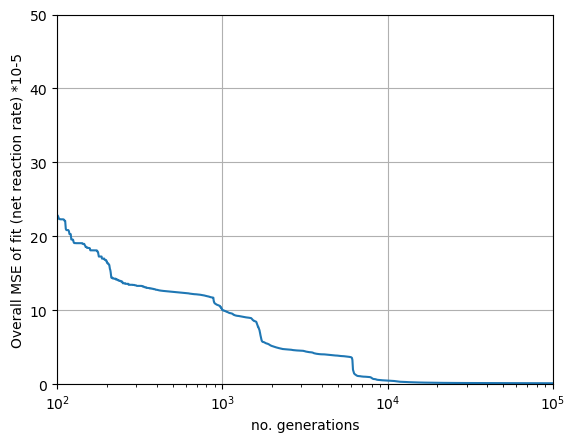

In [35]:
plt.plot(np.arange(len(f_min_log)), f_min_log)
#plt.yscale("log")
plt.xscale("log")
plt.xlabel("no. generations")
plt.ylabel("Overall MSE of fit (net reaction rate) *10-5")

plt.xlim([1e2, 1e5])
plt.ylim([0, 50])

plt.grid()
plt.show()

In [36]:
for i in range(len (res.X)):
    print (res.X[i])

-11.739899520624002
1.5584056939949802
0.8638768100845591
-4.324313511771318
0.5047441373203946
0.011698547702097852
0.40116882194064196
-7.332076815662392
0.63250100504751
6.802509355795012
5.368454313398043
5.393648290296289
0.8447116442133136
0.022498366884571134
3.103630800621784
2.5737314870152034e-06
0.11904102577799369
-11.757516506929543
1.8561154559389987
1.5557940610497212
-11.01461003778848
1.1326062545519342
3.7950229391907953
0.024490032239084046
3.9468864337961422
4.9352262170224
1.9528347604709868
10.656050592552257
-10.750734933774256
2.991096354744333
1.7838547684640824
3.8111594938011297
-4.106835289593688
0.5196511915034143
1.0072937820281478
-1.3010294372436713


In [37]:
res.X

array([-1.17398995e+01,  1.55840569e+00,  8.63876810e-01, -4.32431351e+00,
        5.04744137e-01,  1.16985477e-02,  4.01168822e-01, -7.33207682e+00,
        6.32501005e-01,  6.80250936e+00,  5.36845431e+00,  5.39364829e+00,
        8.44711644e-01,  2.24983669e-02,  3.10363080e+00,  2.57373149e-06,
        1.19041026e-01, -1.17575165e+01,  1.85611546e+00,  1.55579406e+00,
       -1.10146100e+01,  1.13260625e+00,  3.79502294e+00,  2.44900322e-02,
        3.94688643e+00,  4.93522622e+00,  1.95283476e+00,  1.06560506e+01,
       -1.07507349e+01,  2.99109635e+00,  1.78385477e+00,  3.81115949e+00,
       -4.10683529e+00,  5.19651192e-01,  1.00729378e+00, -1.30102944e+00])

In [38]:
logkr = [ 
    -12.0, 1.6,   0.9,
    -4.3,  0.5, 0.003, 0.4,
    -7.9,  0.7,   7.2, 5.7, 5.7,
     0.8, 0.03,   3.1, 6*(10**-9), 0.1,
    -12.0, 1.9, 1.6,
    -11.6, 1.2, 4.0, 0.01, 4.2,
    5.4, 2.2, 11.8,
    -12.0, 3.3, 1.8, 4.2,
    -4.0, 0.5, 1.0]

for i in range(len (logkr)):
    print (logkr[i])

-12.0
1.6
0.9
-4.3
0.5
0.003
0.4
-7.9
0.7
7.2
5.7
5.7
0.8
0.03
3.1
6.000000000000001e-09
0.1
-12.0
1.9
1.6
-11.6
1.2
4.0
0.01
4.2
5.4
2.2
11.8
-12.0
3.3
1.8
4.2
-4.0
0.5
1.0


In [39]:
# average of true log kr values excluding Vin
y_mean = np.mean(logkr)

resX=np.ndarray.tolist(res.X)
del resX[-1]

RSS = 0 # initiate residual sum of square
TSS = 0 # intiate total sum of square
for y,y_hat in zip(logkr,resX):
    print( str(y) + ': ' + str (y_hat) ) 
    RSS = RSS + (y - y_hat)**2
    TSS = TSS + (y - y_mean)**2

# coeff of determination for y = y_hat
R2= 1 -(RSS/TSS)
print ('coeff fit: ' +str(R2) )
print ('r: ' + str(R2**(0.5)) )

-12.0: -11.739899520624002
1.6: 1.5584056939949802
0.9: 0.8638768100845591
-4.3: -4.324313511771318
0.5: 0.5047441373203946
0.003: 0.011698547702097852
0.4: 0.40116882194064196
-7.9: -7.332076815662392
0.7: 0.63250100504751
7.2: 6.802509355795012
5.7: 5.368454313398043
5.7: 5.393648290296289
0.8: 0.8447116442133136
0.03: 0.022498366884571134
3.1: 3.103630800621784
6.000000000000001e-09: 2.5737314870152034e-06
0.1: 0.11904102577799369
-12.0: -11.757516506929543
1.9: 1.8561154559389987
1.6: 1.5557940610497212
-11.6: -11.01461003778848
1.2: 1.1326062545519342
4.0: 3.7950229391907953
0.01: 0.024490032239084046
4.2: 3.9468864337961422
5.4: 4.9352262170224
2.2: 1.9528347604709868
11.8: 10.656050592552257
-12.0: -10.750734933774256
3.3: 2.991096354744333
1.8: 1.7838547684640824
4.2: 3.8111594938011297
-4.0: -4.106835289593688
0.5: 0.5196511915034143
1.0: 1.0072937820281478
coeff fit: 0.995501690352134
r: 0.9977483101224146
